<a href="https://colab.research.google.com/github/cohitai/AI_notebooks/blob/main/VAE/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational AutoEncoder = (encoder= Recognition model, decoder=Generative model)+ Variational loss.

 Variational loss = ELBO (evidence lower bound).



In [1]:
#ToDO: visualizations of the latent space, KL divergence explanations, Generative data. 
### Go over these: 
# Not sure I have the "right" variational loss. 
# https://avandekleut.github.io/vae/
# https://www.jeremyjordan.me/variational-autoencoders/
# https://gaussian37.github.io/deep-learning-chollet-8-4/
# simplify NN ? (How many ResNet layers/Blocks? are actiually meaningfull for a baseline.)
# output doesn't converge well. (check loss ? epochs adjustments/learning rate?)
# plot the loss
# change reconstruction loss to recons_loss =F.mse_loss(recons, input).

# The loss depends heavily on the BS. 
# Compare the loss with the pretrained VAE model(Huggingfaces). 
# sum() or mean() in loss , and kl.sum() or kl.mean() ? 


In [2]:
import torch 
import torchvision
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
import math

print("Working directory:", os.getcwd())
device="cuda"

Working directory: /content


In [3]:
!nvidia-smi

Tue Nov 15 12:14:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
## download cifar10 data

In [5]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

In [5]:
# !ls

cifar-10-python.tar.gz	sample_data


In [6]:
# !tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
# !ls -al cifar-10-batches-py

total 181884
drwxr-xr-x 2 2156 1103     4096 Jun  4  2009 .
drwxr-xr-x 1 root root     4096 Nov 14 11:42 ..
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [12]:
# import os.path as osp
# path = "./cifar-10-batches-py"
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# !ls $path

# c10_data = unpickle(osp.join(path,"data_batch_1"))
# print(c10_data.keys())

# # extract c10 data --> images,labels
# images = c10_data[b"data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") # (10000,3072)
# labels = c10_data[b"labels"]
# #
# print("Data Shape",images.shape)

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Shape (10000, 32, 32, 3)


Model Blocks: - DownEncoderBlock2D
              - UpDecoderBlock2D
              - ResnetBlock
              - Downsample2D
              - Upsample2D
              - AttentionBlockNew
              - UNetMidBlock2D
              - Encoder
              - Decoder

In [6]:
class DownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0, 
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_downsample=True,
        downsample_padding=1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        in_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states

class UpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_upsample=True,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            resnets.append(
                ResnetBlock(
                    in_channels=input_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states

  
    
class ResnetBlock(nn.Module):
    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout=0.0,
        temb_channels=512,
        groups=32,
        groups_out=None,
        pre_norm=True,
        eps=1e-6,
        non_linearity="swish",
        time_embedding_norm="default",
        kernel=None,
        output_scale_factor=1.0,
        use_nin_shortcut=None,
        up=False,
        down=False,
    ):
        super().__init__()
        self.pre_norm = pre_norm
        self.pre_norm = True
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut
        self.time_embedding_norm = time_embedding_norm
        self.up = up
        self.down = down
        self.output_scale_factor = output_scale_factor

        if groups_out is None:
            groups_out = groups

        self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if temb_channels is not None:
            self.time_emb_proj = torch.nn.Linear(temb_channels, out_channels)
        else:
            self.time_emb_proj = None

        self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if non_linearity == "swish":
            self.nonlinearity = lambda x: F.silu(x)
        elif non_linearity == "mish":
            self.nonlinearity = Mish()
        elif non_linearity == "silu":
            self.nonlinearity = nn.SiLU()

        self.upsample = self.downsample = None
        if self.up:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.upsample = lambda x: upsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.upsample = partial(F.interpolate, scale_factor=2.0, mode="nearest")
            else:
                self.upsample = Upsample2D(in_channels, use_conv=False)
        
        elif self.down:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.downsample = lambda x: downsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.downsample = partial(F.avg_pool2d, kernel_size=2, stride=2)
            else:
                self.downsample = Downsample2D(in_channels, use_conv=False, padding=1, name="op")

        self.use_nin_shortcut = self.in_channels != self.out_channels if use_nin_shortcut is None else use_nin_shortcut

        self.conv_shortcut = None
    
        if self.use_nin_shortcut:
            self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb, hey=False):
        h = x

        # print("LOG resnet_input",h.size())

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm1(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        # if self.upsample is not None:
        #     x = self.upsample(x)
        #     h = self.upsample(h)
        # elif self.downsample is not None:
        #     x = self.downsample(x)
        #     h = self.downsample(h)

        h = self.conv1(h)

        # print("LOG temb:",temb is None)

        # if temb is not None:
        #     temb = self.time_emb_proj(self.nonlinearity(temb))[:, :, None, None]
        #     h = h + temb

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm2(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        h = self.dropout(h)
        h = self.conv2(h)

        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x)

        out = (x + h) / self.output_scale_factor

        return out

    def set_weight(self, resnet):
        self.norm1.weight.data = resnet.norm1.weight.data
        self.norm1.bias.data = resnet.norm1.bias.data

        self.conv1.weight.data = resnet.conv1.weight.data
        self.conv1.bias.data = resnet.conv1.bias.data

        if self.time_emb_proj is not None:
            self.time_emb_proj.weight.data = resnet.temb_proj.weight.data
            self.time_emb_proj.bias.data = resnet.temb_proj.bias.data

        self.norm2.weight.data = resnet.norm2.weight.data
        self.norm2.bias.data = resnet.norm2.bias.data

        self.conv2.weight.data = resnet.conv2.weight.data
        self.conv2.bias.data = resnet.conv2.bias.data

        if self.use_nin_shortcut:
            self.conv_shortcut.weight.data = resnet.nin_shortcut.weight.data
            self.conv_shortcut.bias.data = resnet.nin_shortcut.bias.data
            
            
class Downsample2D(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, out_channels=None, padding=1, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.padding = padding
        stride = 2
        self.name = name

        if use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            conv = nn.AvgPool2d(kernel_size=stride, stride=stride)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.Conv2d_0 = conv
            self.conv = conv
        elif name == "Conv2d_0":
            self.conv = conv
        else:
            self.conv = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv and self.padding == 0:
            pad = (0, 1, 0, 1)
            x = F.pad(x, pad, mode="constant", value=0)

        assert x.shape[1] == self.channels
        x = self.conv(x)

        # print('LOG',x)
        return x

class Upsample2D(nn.Module):

    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, use_conv_transpose=False, out_channels=None, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_conv_transpose = use_conv_transpose
        self.name = name

        conv = None
        if use_conv_transpose:
            conv = nn.ConvTranspose2d(channels, self.out_channels, 4, 2, 1)
        elif use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, padding=1)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.conv = conv
        else:
            self.Conv2d_0 = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv_transpose:
            return self.conv(x)

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if self.use_conv:
            if self.name == "conv":
                x = self.conv(x)
            else:
                x = self.Conv2d_0(x)

        return x


class AttentionBlockNew(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other. Originally ported from here, but adapted
    to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    Uses three q, k, v linear layers to compute attention
    """

    def __init__(
        self,
        channels,
        num_head_channels=None,
        num_groups=32,
        rescale_output_factor=1.0,
        eps=1e-5,
    ):
        super().__init__()
        self.channels = channels

        self.num_heads = channels // num_head_channels if num_head_channels is not None else 1
        self.num_head_size = num_head_channels
        self.group_norm = nn.GroupNorm(num_channels=channels, num_groups=num_groups, eps=eps, affine=True)

        # define q,k,v as linear layers
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)

        self.rescale_output_factor = rescale_output_factor
        self.proj_attn = nn.Linear(channels, channels, 1)

    def transpose_for_scores(self, projection: torch.Tensor) -> torch.Tensor:
        new_projection_shape = projection.size()[:-1] + (self.num_heads, -1)
        # move heads to 2nd position (B, T, H * D) -> (B, T, H, D) -> (B, H, T, D)
        new_projection = projection.view(new_projection_shape).permute(0, 2, 1, 3)
        return new_projection

    def forward(self, hidden_states):
        residual = hidden_states
        batch, channel, height, width = hidden_states.shape

        # norm
        hidden_states = self.group_norm(hidden_states)

        hidden_states = hidden_states.view(batch, channel, height * width).transpose(1, 2)

        # proj to q, k, v
        query_proj = self.query(hidden_states)
        key_proj = self.key(hidden_states)
        value_proj = self.value(hidden_states)

        # transpose
        query_states = self.transpose_for_scores(query_proj)
        key_states = self.transpose_for_scores(key_proj)
        value_states = self.transpose_for_scores(value_proj)

        # get scores
        scale = 1 / math.sqrt(math.sqrt(self.channels / self.num_heads))
        attention_scores = torch.matmul(query_states * scale, key_states.transpose(-1, -2) * scale)
        attention_probs = torch.softmax(attention_scores.float(), dim=-1).type(attention_scores.dtype)

        # compute attention output
        context_states = torch.matmul(attention_probs, value_states)

        context_states = context_states.permute(0, 2, 1, 3).contiguous()
        new_context_states_shape = context_states.size()[:-2] + (self.channels,)
        context_states = context_states.view(new_context_states_shape)

        # compute next hidden_states
        hidden_states = self.proj_attn(context_states)
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch, channel, height, width)

        # res connect and rescale
        hidden_states = (hidden_states + residual) / self.rescale_output_factor
        return hidden_states

    def set_weight(self, attn_layer):
        self.group_norm.weight.data = attn_layer.norm.weight.data
        self.group_norm.bias.data = attn_layer.norm.bias.data

        if hasattr(attn_layer, "q"):
            self.query.weight.data = attn_layer.q.weight.data[:, :, 0, 0]
            self.key.weight.data = attn_layer.k.weight.data[:, :, 0, 0]
            self.value.weight.data = attn_layer.v.weight.data[:, :, 0, 0]

            self.query.bias.data = attn_layer.q.bias.data
            self.key.bias.data = attn_layer.k.bias.data
            self.value.bias.data = attn_layer.v.bias.data

            self.proj_attn.weight.data = attn_layer.proj_out.weight.data[:, :, 0, 0]
            self.proj_attn.bias.data = attn_layer.proj_out.bias.data
        elif hasattr(attn_layer, "NIN_0"):
            self.query.weight.data = attn_layer.NIN_0.W.data.T
            self.key.weight.data = attn_layer.NIN_1.W.data.T
            self.value.weight.data = attn_layer.NIN_2.W.data.T

            self.query.bias.data = attn_layer.NIN_0.b.data
            self.key.bias.data = attn_layer.NIN_1.b.data
            self.value.bias.data = attn_layer.NIN_2.b.data

            self.proj_attn.weight.data = attn_layer.NIN_3.W.data.T
            self.proj_attn.bias.data = attn_layer.NIN_3.b.data

            self.group_norm.weight.data = attn_layer.GroupNorm_0.weight.data
            self.group_norm.bias.data = attn_layer.GroupNorm_0.bias.data
        else:
            qkv_weight = attn_layer.qkv.weight.data.reshape(
                self.num_heads, 3 * self.channels // self.num_heads, self.channels
            )
            qkv_bias = attn_layer.qkv.bias.data.reshape(self.num_heads, 3 * self.channels // self.num_heads)

            q_w, k_w, v_w = qkv_weight.split(self.channels // self.num_heads, dim=1)
            q_b, k_b, v_b = qkv_bias.split(self.channels // self.num_heads, dim=1)

            self.query.weight.data = q_w.reshape(-1, self.channels)
            self.key.weight.data = k_w.reshape(-1, self.channels)
            self.value.weight.data = v_w.reshape(-1, self.channels)

            self.query.bias.data = q_b.reshape(-1)
            self.key.bias.data = k_b.reshape(-1)
            self.value.bias.data = v_b.reshape(-1)

            self.proj_attn.weight.data = attn_layer.proj.weight.data[:, :, 0]
            self.proj_attn.bias.data = attn_layer.proj.bias.data

class UNetMidBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attn_num_head_channels=1,
        attention_type="default",
        output_scale_factor=1.0,
        **kwargs,
    ):
        super().__init__()

        self.attention_type = attention_type
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        # there is always at least one resnet
        resnets = [
            ResnetBlock(
                in_channels=in_channels,
                out_channels=in_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
            )
        ]
        attentions = []

        for _ in range(num_layers):
            attentions.append(
                AttentionBlockNew(
                    in_channels,
                    num_head_channels=attn_num_head_channels,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    num_groups=resnet_groups,
                )
            )
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(self, hidden_states, temb=None, encoder_states=None):
        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if self.attention_type == "default":
                hidden_states = attn(hidden_states)
            else:
                hidden_states = attn(hidden_states, encoder_states)
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True,
    ):
        super().__init__()
        self.layers_per_block = layers_per_block
        self.conv_in = torch.nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, stride=1, padding=1)
        self.mid_block = None
        self.down_blocks = nn.ModuleList([])

        # down
        output_channel = block_out_channels[0]
        for i, _ in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = DownEncoderBlock2D(
                num_layers=self.layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                add_downsample=not is_final_block,
                resnet_eps=1e-6,
                resnet_act_fn=act_fn,
                downsample_padding=0,)

            self.down_blocks.append(down_block)

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[-1], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()

        conv_out_channels = 2 * out_channels if double_z else out_channels
        self.conv_out = nn.Conv2d(block_out_channels[-1], conv_out_channels, 3, padding=1)

    def forward(self, x):
        
        sample = x
        sample = self.conv_in(sample)
        
        # down
        for down_block in self.down_blocks:
            sample = down_block(sample)

        # middle
        sample = self.mid_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample


class Decoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        up_block_types=("UpDecoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=2,
        act_fn="silu",
    ):
        super().__init__()
        self.layers_per_block = layers_per_block

        self.conv_in = nn.Conv2d(in_channels, block_out_channels[-1], kernel_size=3, stride=1, padding=1)

        self.mid_block = None
        self.up_blocks = nn.ModuleList([])

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]

            is_final_block = i == len(block_out_channels) - 1

            up_block = UpDecoderBlock2D(
            num_layers=self.layers_per_block + 1,
            in_channels=prev_output_channel,
            out_channels=output_channel,
            add_upsample=not is_final_block,
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
        )

            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, 3, padding=1)

    def forward(self, z):
        sample = z
        sample = self.conv_in(sample)

        # middle
        sample = self.mid_block(sample)

        # up
        for up_block in self.up_blocks:
            sample = up_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample

In [7]:
class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.0])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var
                    - 1.0
                    - self.logvar
                    + other.logvar,
                    dim=[1, 2, 3],
                )

    def nll(self, sample, dims=[1, 2, 3]):
        if self.deterministic:
            return torch.Tensor([0.0])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=dims)

    def mode(self):
        return self.mean



encoder = Encoder(in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True)


decoder = Decoder(in_channels=4,
            out_channels=3,
            up_block_types=("UpDecoderBlock2D",),
            block_out_channels=(64,),
            layers_per_block=1,
            act_fn="silu")





    ##########################
    ##########################
    ##########################
#### AutoEncoder wrap- up class ####
    ##########################
    ##########################
    ##########################

class AutoencoderKL(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        down_block_types=("DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D",),
        up_block_types=("UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D",),
        block_out_channels=(128, 256, 512, 512,),
        layers_per_block=2,
        act_fn="silu",
        latent_channels=4,
        sample_size=512,
    ):
        super().__init__()

        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1) 
        self.kl = 0

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, sample, sample_posterior=False):
        x = sample
        posterior = self.encode(x)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        self.kl=posterior.kl()
        return dec


# **Training function**

In [8]:
##### train
from tqdm import tqdm
PATH = './vae_net.pth'
losses=[]
def train(autoencoder, data, epochs=20,exp=None):

    def adjust(sample):
        # sample=np.expand_dims(np.asarray(sample), axis=0)
        sample=sample.numpy()/ 1.0
        # sample=sample.astype('float32')
        sample = torch.from_numpy(sample).float() # Batch - RGB channel - WxH 
        sample = 2 * (sample - 0.5) # values between (-1, 1)
        return sample

    if not exp:
        model_file='./{}_net.pth'.format(exp)
    else:
        model_file=PATH
    
    global opt
    opt = torch.optim.Adam(autoencoder.parameters())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    epoch = 0

    if os.path.exists(model_file):
      checkpoint = torch.load(model_file)
      autoencoder.load_state_dict(checkpoint['model_state_dict'])
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      scheduler.load_state_dict(checkpoint['scheduler'])
      epoch = checkpoint['epoch']
      loss = checkpoint['loss']

    for epoch in range(epoch, epochs):
        print("Log epoch:",epoch)
        for i,x in enumerate(tqdm(data,total=len(data))):
            x=adjust(x[0]) # Values between -1..1 
            x = torch.Tensor(x).to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            # loss = ((x - x_hat)**2).sum() + autoencoder.kl.sum()
            loss = F.mse_loss(x,x_hat) + autoencoder.kl.sum()
            loss.backward()
            opt.step()
            loss=loss.item()
            losses.append(loss)
            print(loss)

            if not i % 50 and i != 0: 
                torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
                print("model saved!")
        
        scheduler.step()
        torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
        print("model saved!")
   
    return autoencoder,losses

**DataLoader Cifar10** 

In [9]:
#ToDo: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# normalize dataset.

def load_data(BS=32,path = "./cifar-10-batches-py"):
    train = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=32,
        shuffle=True)
    
    test = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True,train=False),
        batch_size=32,
        shuffle=True)
        
    print(train.dataset)
    print(test.dataset)
    print("train data size:",next(iter(train))[0].size())

    return train,test


**Train/Test Split**


In [10]:
train_data,test_data=load_data(BS=32)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-batches-py/cifar-10-python.tar.gz to ./cifar-10-batches-py
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])


Training Variational AutoEncoder on Cifar10 data.

In [ ]:
train_data,test_data=load_data(BS=32)
vae=AutoencoderKL().to(device)
vae, = train(vae, train_data,epochs=10)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])
Log epoch: 0


  0%|          | 1/1563 [00:06<2:46:20,  6.39s/it]

39663.16796875


  0%|          | 2/1563 [00:06<1:12:43,  2.80s/it]

152707.65625


  0%|          | 3/1563 [00:06<42:46,  1.65s/it]  

32141.6796875


  0%|          | 4/1563 [00:07<28:44,  1.11s/it]

67971.609375


  0%|          | 5/1563 [00:07<20:58,  1.24it/s]

23355.390625


  0%|          | 6/1563 [00:07<16:16,  1.59it/s]

24626.078125


  0%|          | 7/1563 [00:08<13:17,  1.95it/s]

29960.068359375


  1%|          | 8/1563 [00:08<11:21,  2.28it/s]

24949.40625


  1%|          | 9/1563 [00:08<10:02,  2.58it/s]

22929.01953125


  1%|          | 10/1563 [00:08<09:09,  2.83it/s]

26952.0859375


  1%|          | 11/1563 [00:09<08:33,  3.02it/s]

27787.064453125


  1%|          | 12/1563 [00:09<08:07,  3.18it/s]

28136.142578125


  1%|          | 13/1563 [00:09<07:50,  3.29it/s]

25486.259765625


  1%|          | 14/1563 [00:10<07:37,  3.38it/s]

24401.90625


  1%|          | 15/1563 [00:10<07:30,  3.44it/s]

21810.740234375


  1%|          | 16/1563 [00:10<07:26,  3.47it/s]

24601.4765625


  1%|          | 17/1563 [00:10<07:21,  3.50it/s]

26788.056640625


  1%|          | 18/1563 [00:11<07:18,  3.53it/s]

28352.76171875


  1%|          | 19/1563 [00:11<07:16,  3.54it/s]

28801.201171875


  1%|▏         | 20/1563 [00:11<07:15,  3.55it/s]

24075.642578125


  1%|▏         | 21/1563 [00:11<07:15,  3.54it/s]

24376.640625


  1%|▏         | 22/1563 [00:12<07:13,  3.55it/s]

24228.47265625


  1%|▏         | 23/1563 [00:12<07:11,  3.57it/s]

29565.23828125


  2%|▏         | 24/1563 [00:12<07:12,  3.56it/s]

22035.037109375


  2%|▏         | 25/1563 [00:13<07:11,  3.56it/s]

26134.91015625


  2%|▏         | 26/1563 [00:13<07:10,  3.57it/s]

26363.2421875


  2%|▏         | 27/1563 [00:13<07:10,  3.57it/s]

23591.435546875


  2%|▏         | 28/1563 [00:13<07:10,  3.56it/s]

23346.658203125


  2%|▏         | 29/1563 [00:14<07:10,  3.56it/s]

23727.390625


  2%|▏         | 30/1563 [00:14<07:09,  3.57it/s]

26006.03515625


  2%|▏         | 31/1563 [00:14<07:08,  3.57it/s]

21597.712890625


  2%|▏         | 32/1563 [00:15<07:08,  3.57it/s]

28360.482421875


  2%|▏         | 33/1563 [00:15<07:08,  3.57it/s]

21129.615234375


  2%|▏         | 34/1563 [00:15<07:07,  3.57it/s]

27476.8203125


  2%|▏         | 35/1563 [00:15<07:07,  3.58it/s]

26338.87890625


  2%|▏         | 36/1563 [00:16<07:06,  3.58it/s]

19946.619140625


  2%|▏         | 37/1563 [00:16<07:06,  3.58it/s]

24496.24609375


  2%|▏         | 38/1563 [00:16<07:05,  3.58it/s]

24973.0234375


  2%|▏         | 39/1563 [00:17<07:05,  3.58it/s]

23664.8125


  3%|▎         | 40/1563 [00:17<07:06,  3.57it/s]

24075.46875


  3%|▎         | 41/1563 [00:17<07:06,  3.57it/s]

22877.068359375


  3%|▎         | 42/1563 [00:17<07:06,  3.56it/s]

24617.455078125


  3%|▎         | 43/1563 [00:18<07:07,  3.56it/s]

20949.7578125


  3%|▎         | 44/1563 [00:18<07:08,  3.55it/s]

21875.1484375


  3%|▎         | 45/1563 [00:18<07:07,  3.55it/s]

22374.32421875


  3%|▎         | 46/1563 [00:18<07:06,  3.56it/s]

22215.876953125


  3%|▎         | 47/1563 [00:19<07:06,  3.55it/s]

27131.9296875


  3%|▎         | 48/1563 [00:19<07:05,  3.56it/s]

22262.59375


  3%|▎         | 49/1563 [00:19<07:05,  3.56it/s]

25994.548828125


  3%|▎         | 50/1563 [00:20<07:05,  3.55it/s]

29838.03125
25287.443359375


  3%|▎         | 51/1563 [00:23<34:18,  1.36s/it]

model saved!


  3%|▎         | 52/1563 [00:24<26:37,  1.06s/it]

22989.453125


  3%|▎         | 53/1563 [00:24<20:44,  1.21it/s]

21952.208984375


  3%|▎         | 54/1563 [00:24<16:37,  1.51it/s]

24172.115234375


  4%|▎         | 55/1563 [00:25<13:45,  1.83it/s]

23162.2734375


  4%|▎         | 56/1563 [00:25<11:43,  2.14it/s]

21077.896484375


  4%|▎         | 57/1563 [00:25<10:18,  2.43it/s]

20882.26953125


  4%|▎         | 58/1563 [00:26<09:19,  2.69it/s]

24102.87109375


  4%|▍         | 59/1563 [00:26<08:39,  2.90it/s]

19035.765625


  4%|▍         | 60/1563 [00:26<08:10,  3.07it/s]

25706.33203125


  4%|▍         | 61/1563 [00:26<07:49,  3.20it/s]

21685.90234375


  4%|▍         | 62/1563 [00:27<07:35,  3.29it/s]

23065.75390625


  4%|▍         | 63/1563 [00:27<07:26,  3.36it/s]

24852.0703125


  4%|▍         | 64/1563 [00:27<07:19,  3.41it/s]

20543.291015625


  4%|▍         | 65/1563 [00:27<07:14,  3.45it/s]

20497.03125


  4%|▍         | 66/1563 [00:28<07:10,  3.48it/s]

24387.38671875


  4%|▍         | 67/1563 [00:28<07:08,  3.49it/s]

21879.01171875


  4%|▍         | 68/1563 [00:28<07:06,  3.50it/s]

20907.01953125


  4%|▍         | 69/1563 [00:29<07:04,  3.52it/s]

24704.306640625


  4%|▍         | 70/1563 [00:29<07:04,  3.52it/s]

18719.119140625


  5%|▍         | 71/1563 [00:29<07:02,  3.53it/s]

29749.2578125


  5%|▍         | 72/1563 [00:29<07:01,  3.54it/s]

19922.6484375


  5%|▍         | 73/1563 [00:30<06:59,  3.55it/s]

21613.8046875


  5%|▍         | 74/1563 [00:30<07:00,  3.54it/s]

21841.40625


  5%|▍         | 75/1563 [00:30<07:00,  3.54it/s]

25271.65625


  5%|▍         | 76/1563 [00:31<07:03,  3.51it/s]

27470.23828125


  5%|▍         | 77/1563 [00:31<07:02,  3.52it/s]

21899.21875


  5%|▍         | 78/1563 [00:31<07:02,  3.52it/s]

21166.0078125


  5%|▌         | 79/1563 [00:31<07:00,  3.53it/s]

22633.31640625


  5%|▌         | 80/1563 [00:32<07:00,  3.53it/s]

19481.49609375


  5%|▌         | 81/1563 [00:32<07:00,  3.52it/s]

19497.90234375


  5%|▌         | 82/1563 [00:32<07:00,  3.52it/s]

19296.326171875


  5%|▌         | 83/1563 [00:33<07:00,  3.52it/s]

17247.583984375


  5%|▌         | 84/1563 [00:33<06:59,  3.53it/s]

20939.318359375


  5%|▌         | 85/1563 [00:33<06:59,  3.52it/s]

20123.732421875


  6%|▌         | 86/1563 [00:33<06:59,  3.52it/s]

17846.12890625


  6%|▌         | 87/1563 [00:34<06:58,  3.53it/s]

18201.888671875


  6%|▌         | 88/1563 [00:34<06:57,  3.54it/s]

18348.23828125


  6%|▌         | 89/1563 [00:34<06:57,  3.53it/s]

16982.90625


  6%|▌         | 90/1563 [00:35<06:56,  3.54it/s]

22619.330078125


  6%|▌         | 91/1563 [00:35<06:57,  3.53it/s]

18941.267578125


  6%|▌         | 92/1563 [00:35<06:57,  3.52it/s]

15592.16796875


  6%|▌         | 93/1563 [00:35<06:56,  3.53it/s]

18507.169921875


  6%|▌         | 94/1563 [00:36<06:56,  3.52it/s]

17154.546875


  6%|▌         | 95/1563 [00:36<06:56,  3.52it/s]

18584.326171875


  6%|▌         | 96/1563 [00:36<06:57,  3.52it/s]

19184.23046875


  6%|▌         | 97/1563 [00:37<06:56,  3.52it/s]

19608.5703125


  6%|▋         | 98/1563 [00:37<06:56,  3.51it/s]

16573.951171875


  6%|▋         | 99/1563 [00:37<06:56,  3.52it/s]

18402.27734375


  6%|▋         | 100/1563 [00:37<06:56,  3.51it/s]

17688.7734375
14897.6572265625


  6%|▋         | 101/1563 [00:42<35:01,  1.44s/it]

model saved!


  7%|▋         | 102/1563 [00:42<27:07,  1.11s/it]

16132.3828125


  7%|▋         | 103/1563 [00:42<21:02,  1.16it/s]

18557.71875


  7%|▋         | 104/1563 [00:42<16:48,  1.45it/s]

16330.2021484375


  7%|▋         | 105/1563 [00:43<13:51,  1.75it/s]

15841.109375


  7%|▋         | 106/1563 [00:43<11:46,  2.06it/s]

18235.716796875


  7%|▋         | 107/1563 [00:43<10:18,  2.35it/s]

14201.044921875


  7%|▋         | 108/1563 [00:44<09:17,  2.61it/s]

18175.71875


  7%|▋         | 109/1563 [00:44<08:34,  2.82it/s]

15778.947265625


  7%|▋         | 110/1563 [00:44<08:04,  3.00it/s]

17183.4296875


  7%|▋         | 111/1563 [00:44<07:42,  3.14it/s]

14353.6484375


  7%|▋         | 112/1563 [00:45<07:31,  3.22it/s]

16173.5556640625


  7%|▋         | 113/1563 [00:45<07:25,  3.26it/s]

15088.17578125


  7%|▋         | 114/1563 [00:45<07:15,  3.33it/s]

15991.85546875


  7%|▋         | 115/1563 [00:46<07:12,  3.35it/s]

16055.5107421875


  7%|▋         | 116/1563 [00:46<07:06,  3.40it/s]

16154.279296875


  7%|▋         | 117/1563 [00:46<07:02,  3.42it/s]

14911.708984375


  8%|▊         | 118/1563 [00:47<07:21,  3.27it/s]

14258.236328125


  8%|▊         | 119/1563 [00:47<07:12,  3.34it/s]

13515.23828125


  8%|▊         | 120/1563 [00:47<07:05,  3.39it/s]

16802.642578125


  8%|▊         | 121/1563 [00:47<07:01,  3.42it/s]

13061.611328125


  8%|▊         | 122/1563 [00:48<06:58,  3.44it/s]

16733.615234375


  8%|▊         | 123/1563 [00:48<06:57,  3.45it/s]

14649.4140625


  8%|▊         | 124/1563 [00:48<06:55,  3.46it/s]

16383.6005859375


  8%|▊         | 125/1563 [00:49<06:54,  3.47it/s]

16502.0625


  8%|▊         | 126/1563 [00:49<06:53,  3.48it/s]

16022.2880859375


  8%|▊         | 127/1563 [00:49<06:53,  3.47it/s]

15629.7861328125


  8%|▊         | 128/1563 [00:49<06:51,  3.49it/s]

16571.986328125


  8%|▊         | 129/1563 [00:50<06:53,  3.47it/s]

15140.83203125


  8%|▊         | 130/1563 [00:50<06:52,  3.48it/s]

16781.638671875


  8%|▊         | 131/1563 [00:50<06:51,  3.48it/s]

13881.31640625


  8%|▊         | 132/1563 [00:51<06:51,  3.48it/s]

14288.6904296875


  9%|▊         | 133/1563 [00:51<06:52,  3.47it/s]

15450.4970703125


  9%|▊         | 134/1563 [00:51<06:50,  3.48it/s]

15439.7236328125


  9%|▊         | 135/1563 [00:51<06:51,  3.47it/s]

17767.263671875


  9%|▊         | 136/1563 [00:52<06:50,  3.48it/s]

14484.34375


  9%|▉         | 137/1563 [00:52<06:49,  3.48it/s]

15914.1767578125


  9%|▉         | 138/1563 [00:52<06:49,  3.48it/s]

13155.2197265625


  9%|▉         | 139/1563 [00:53<06:50,  3.47it/s]

13635.2890625


  9%|▉         | 140/1563 [00:53<06:50,  3.47it/s]

14667.06640625


  9%|▉         | 141/1563 [00:53<06:49,  3.48it/s]

15342.5185546875


  9%|▉         | 142/1563 [00:53<06:47,  3.49it/s]

15447.4794921875


  9%|▉         | 143/1563 [00:54<06:47,  3.48it/s]

14401.7021484375


  9%|▉         | 144/1563 [00:54<06:47,  3.48it/s]

12054.1396484375


  9%|▉         | 145/1563 [00:54<06:48,  3.47it/s]

17220.263671875


  9%|▉         | 146/1563 [00:55<06:47,  3.48it/s]

15692.9833984375


  9%|▉         | 147/1563 [00:55<06:47,  3.48it/s]

17565.19921875


  9%|▉         | 148/1563 [00:55<06:47,  3.47it/s]

13686.2421875


 10%|▉         | 149/1563 [00:55<06:48,  3.47it/s]

16541.41015625


 10%|▉         | 150/1563 [00:56<06:47,  3.46it/s]

16027.5595703125
13397.57421875


 10%|▉         | 151/1563 [01:00<32:06,  1.36s/it]

model saved!


 10%|▉         | 152/1563 [01:00<25:14,  1.07s/it]

14263.14453125


 10%|▉         | 153/1563 [01:00<19:41,  1.19it/s]

17560.7734375


 10%|▉         | 154/1563 [01:01<15:47,  1.49it/s]

17528.130859375


 10%|▉         | 155/1563 [01:01<13:03,  1.80it/s]

17026.1328125


 10%|▉         | 156/1563 [01:01<11:09,  2.10it/s]

15690.7822265625


 10%|█         | 157/1563 [01:01<09:49,  2.38it/s]

14989.453125


 10%|█         | 158/1563 [01:02<08:54,  2.63it/s]

11313.68359375


 10%|█         | 159/1563 [01:02<08:14,  2.84it/s]

12260.943359375


 10%|█         | 160/1563 [01:02<07:47,  3.00it/s]

13958.4736328125


 10%|█         | 161/1563 [01:03<07:28,  3.13it/s]

13454.6953125


 10%|█         | 162/1563 [01:03<07:14,  3.23it/s]

12840.8203125


 10%|█         | 163/1563 [01:03<07:05,  3.29it/s]

12893.349609375


 10%|█         | 164/1563 [01:03<06:59,  3.34it/s]

12719.787109375


 11%|█         | 165/1563 [01:04<06:54,  3.37it/s]

12115.3974609375


 11%|█         | 166/1563 [01:04<06:50,  3.41it/s]

13335.2900390625


 11%|█         | 167/1563 [01:04<06:47,  3.43it/s]

12313.462890625


 11%|█         | 168/1563 [01:05<06:46,  3.43it/s]

13520.638671875


 11%|█         | 169/1563 [01:05<06:45,  3.43it/s]

13685.2373046875


 11%|█         | 170/1563 [01:05<06:45,  3.44it/s]

11957.576171875


 11%|█         | 171/1563 [01:05<06:44,  3.44it/s]

13894.978515625


 11%|█         | 172/1563 [01:06<06:43,  3.45it/s]

12985.693359375


 11%|█         | 173/1563 [01:06<06:42,  3.45it/s]

13043.0888671875


 11%|█         | 174/1563 [01:06<06:42,  3.45it/s]

13017.7998046875


 11%|█         | 175/1563 [01:07<06:42,  3.45it/s]

11959.583984375


 11%|█▏        | 176/1563 [01:07<06:42,  3.45it/s]

12427.5087890625


 11%|█▏        | 177/1563 [01:07<06:42,  3.44it/s]

12085.8095703125


 11%|█▏        | 178/1563 [01:08<06:41,  3.45it/s]

12155.931640625


 11%|█▏        | 179/1563 [01:08<06:41,  3.45it/s]

12125.4599609375


 12%|█▏        | 180/1563 [01:08<06:41,  3.45it/s]

13690.5419921875


 12%|█▏        | 181/1563 [01:08<06:41,  3.45it/s]

10946.4033203125


 12%|█▏        | 182/1563 [01:09<06:41,  3.44it/s]

11925.95703125


 12%|█▏        | 183/1563 [01:09<06:40,  3.45it/s]

11508.5380859375


 12%|█▏        | 184/1563 [01:09<06:40,  3.44it/s]

13967.8037109375


 12%|█▏        | 185/1563 [01:10<06:39,  3.45it/s]

11580.095703125


 12%|█▏        | 186/1563 [01:10<06:39,  3.45it/s]

13815.5166015625


 12%|█▏        | 187/1563 [01:10<06:39,  3.44it/s]

12715.5078125


 12%|█▏        | 188/1563 [01:10<06:39,  3.44it/s]

11832.4111328125


 12%|█▏        | 189/1563 [01:11<06:37,  3.45it/s]

12078.8154296875


 12%|█▏        | 190/1563 [01:11<06:39,  3.44it/s]

11316.947265625


 12%|█▏        | 191/1563 [01:11<06:39,  3.43it/s]

11929.41015625


 12%|█▏        | 192/1563 [01:12<06:39,  3.43it/s]

11141.24609375


 12%|█▏        | 193/1563 [01:12<06:39,  3.43it/s]

11669.6435546875


 12%|█▏        | 194/1563 [01:12<06:40,  3.42it/s]

11504.09765625


 12%|█▏        | 195/1563 [01:12<06:39,  3.42it/s]

11056.6611328125


 13%|█▎        | 196/1563 [01:13<06:39,  3.42it/s]

11538.708984375


 13%|█▎        | 197/1563 [01:13<06:37,  3.43it/s]

12126.8603515625


 13%|█▎        | 198/1563 [01:13<06:37,  3.43it/s]

11347.921875


 13%|█▎        | 199/1563 [01:14<06:36,  3.44it/s]

13297.228515625


 13%|█▎        | 200/1563 [01:14<06:37,  3.43it/s]

11733.30859375
11910.1103515625


 13%|█▎        | 201/1563 [01:18<32:18,  1.42s/it]

model saved!


 13%|█▎        | 202/1563 [01:18<24:59,  1.10s/it]

12280.572265625


 13%|█▎        | 203/1563 [01:19<19:27,  1.17it/s]

11472.47265625


 13%|█▎        | 204/1563 [01:19<15:36,  1.45it/s]

11487.8173828125


 13%|█▎        | 205/1563 [01:19<12:53,  1.76it/s]

13972.087890625


 13%|█▎        | 206/1563 [01:20<10:59,  2.06it/s]

11986.1591796875


 13%|█▎        | 207/1563 [01:20<09:39,  2.34it/s]

10764.7958984375


 13%|█▎        | 208/1563 [01:20<08:43,  2.59it/s]

11392.6259765625


 13%|█▎        | 209/1563 [01:20<08:05,  2.79it/s]

12791.7275390625


 13%|█▎        | 210/1563 [01:21<07:36,  2.96it/s]

11383.3115234375


 13%|█▎        | 211/1563 [01:21<07:17,  3.09it/s]

9766.09375


 14%|█▎        | 212/1563 [01:21<07:04,  3.18it/s]

11334.830078125


 14%|█▎        | 213/1563 [01:22<06:54,  3.26it/s]

12192.5361328125


 14%|█▎        | 214/1563 [01:22<06:47,  3.31it/s]

12114.2470703125


 14%|█▍        | 215/1563 [01:22<06:42,  3.35it/s]

11401.3388671875


 14%|█▍        | 216/1563 [01:22<06:39,  3.37it/s]

11642.947265625


 14%|█▍        | 217/1563 [01:23<06:37,  3.38it/s]

12390.193359375


 14%|█▍        | 218/1563 [01:23<06:36,  3.40it/s]

10754.181640625


 14%|█▍        | 219/1563 [01:23<06:33,  3.41it/s]

10564.0517578125


 14%|█▍        | 220/1563 [01:24<06:33,  3.42it/s]

9798.982421875


 14%|█▍        | 221/1563 [01:24<06:33,  3.41it/s]

10810.0771484375


 14%|█▍        | 222/1563 [01:24<06:33,  3.41it/s]

11655.5771484375


 14%|█▍        | 223/1563 [01:24<06:33,  3.41it/s]

8893.876953125


 14%|█▍        | 224/1563 [01:25<06:32,  3.41it/s]

12006.4775390625


 14%|█▍        | 225/1563 [01:25<06:32,  3.41it/s]

10641.4091796875


 14%|█▍        | 226/1563 [01:25<06:31,  3.42it/s]

10958.7451171875


 15%|█▍        | 227/1563 [01:26<06:31,  3.42it/s]

10771.2783203125


 15%|█▍        | 228/1563 [01:26<06:30,  3.42it/s]

11251.2041015625


 15%|█▍        | 229/1563 [01:26<06:29,  3.42it/s]

10410.33984375


 15%|█▍        | 230/1563 [01:27<06:30,  3.41it/s]

11044.642578125


 15%|█▍        | 231/1563 [01:27<06:30,  3.41it/s]

12243.4208984375


 15%|█▍        | 232/1563 [01:27<06:30,  3.41it/s]

10551.2607421875


 15%|█▍        | 233/1563 [01:27<06:31,  3.40it/s]

10486.6142578125


 15%|█▍        | 234/1563 [01:28<06:33,  3.38it/s]

9712.619140625


 15%|█▌        | 235/1563 [01:28<06:32,  3.38it/s]

11763.2626953125


 15%|█▌        | 236/1563 [01:28<06:31,  3.39it/s]

9832.2568359375


 15%|█▌        | 237/1563 [01:29<06:32,  3.38it/s]

10330.6455078125


 15%|█▌        | 238/1563 [01:29<06:31,  3.39it/s]

10580.689453125


 15%|█▌        | 239/1563 [01:29<06:30,  3.39it/s]

9694.1513671875


 15%|█▌        | 240/1563 [01:29<06:32,  3.37it/s]

10024.173828125


 15%|█▌        | 241/1563 [01:30<06:30,  3.39it/s]

11968.580078125


 15%|█▌        | 242/1563 [01:30<06:29,  3.39it/s]

10741.8291015625


 16%|█▌        | 243/1563 [01:30<06:29,  3.39it/s]

10747.90234375


 16%|█▌        | 244/1563 [01:31<06:28,  3.39it/s]

9927.3681640625


 16%|█▌        | 245/1563 [01:31<06:29,  3.39it/s]

10831.75


 16%|█▌        | 246/1563 [01:31<06:28,  3.39it/s]

11065.9443359375


 16%|█▌        | 247/1563 [01:32<06:28,  3.39it/s]

10190.9951171875


 16%|█▌        | 248/1563 [01:32<06:28,  3.39it/s]

9535.7548828125


 16%|█▌        | 249/1563 [01:32<06:26,  3.40it/s]

9798.421875


 16%|█▌        | 250/1563 [01:32<06:27,  3.39it/s]

10442.044921875
10982.1298828125


 16%|█▌        | 251/1563 [01:36<30:00,  1.37s/it]

model saved!


 16%|█▌        | 252/1563 [01:37<23:35,  1.08s/it]

11527.2763671875


 16%|█▌        | 253/1563 [01:37<18:26,  1.18it/s]

10523.8720703125


 16%|█▋        | 254/1563 [01:37<14:48,  1.47it/s]

11173.513671875


 16%|█▋        | 255/1563 [01:38<12:17,  1.77it/s]

8790.5869140625


 16%|█▋        | 256/1563 [01:38<10:30,  2.07it/s]

9672.322265625


 16%|█▋        | 257/1563 [01:38<09:16,  2.35it/s]

9854.4736328125


 17%|█▋        | 258/1563 [01:38<08:24,  2.59it/s]

8820.2119140625


 17%|█▋        | 259/1563 [01:39<07:48,  2.78it/s]

9663.91796875


 17%|█▋        | 260/1563 [01:39<07:23,  2.94it/s]

9823.9111328125


 17%|█▋        | 261/1563 [01:39<07:05,  3.06it/s]

11979.61328125


 17%|█▋        | 262/1563 [01:40<06:52,  3.15it/s]

10541.2333984375


 17%|█▋        | 263/1563 [01:40<06:43,  3.22it/s]

11177.3994140625


 17%|█▋        | 264/1563 [01:40<06:36,  3.27it/s]

11244.0654296875


 17%|█▋        | 265/1563 [01:41<06:33,  3.30it/s]

9638.8427734375


 17%|█▋        | 266/1563 [01:41<06:29,  3.33it/s]

10327.826171875


 17%|█▋        | 267/1563 [01:41<06:28,  3.34it/s]

11530.6220703125


 17%|█▋        | 268/1563 [01:41<06:26,  3.35it/s]

11660.728515625


 17%|█▋        | 269/1563 [01:42<06:27,  3.34it/s]

9739.3359375


 17%|█▋        | 270/1563 [01:42<06:28,  3.33it/s]

10752.0126953125


 17%|█▋        | 271/1563 [01:42<06:26,  3.34it/s]

10958.4228515625


 17%|█▋        | 272/1563 [01:43<06:25,  3.35it/s]

9422.544921875


 17%|█▋        | 273/1563 [01:43<06:24,  3.35it/s]

10331.474609375


 18%|█▊        | 274/1563 [01:43<06:24,  3.35it/s]

10602.380859375


 18%|█▊        | 275/1563 [01:44<06:23,  3.36it/s]

11004.94140625


 18%|█▊        | 276/1563 [01:44<06:23,  3.36it/s]

10449.7353515625


 18%|█▊        | 277/1563 [01:44<06:22,  3.36it/s]

10868.064453125


 18%|█▊        | 278/1563 [01:44<06:22,  3.36it/s]

12354.591796875


 18%|█▊        | 279/1563 [01:45<06:21,  3.37it/s]

11066.4140625


 18%|█▊        | 280/1563 [01:45<06:22,  3.36it/s]

9949.8466796875


 18%|█▊        | 281/1563 [01:45<06:21,  3.36it/s]

12779.197265625


 18%|█▊        | 282/1563 [01:46<06:22,  3.35it/s]

14611.76953125


 18%|█▊        | 283/1563 [01:46<06:21,  3.36it/s]

9197.6435546875


 18%|█▊        | 284/1563 [01:46<06:20,  3.36it/s]

11323.2587890625


 18%|█▊        | 285/1563 [01:46<06:21,  3.35it/s]

11412.306640625


 18%|█▊        | 286/1563 [01:47<06:20,  3.36it/s]

10358.7060546875


 18%|█▊        | 287/1563 [01:47<06:19,  3.36it/s]

10178.642578125


 18%|█▊        | 288/1563 [01:47<06:19,  3.36it/s]

11737.3583984375


 18%|█▊        | 289/1563 [01:48<06:19,  3.36it/s]

10516.013671875


 19%|█▊        | 290/1563 [01:48<06:20,  3.35it/s]

10510.552734375


 19%|█▊        | 291/1563 [01:48<06:19,  3.35it/s]

10231.03515625


 19%|█▊        | 292/1563 [01:49<06:18,  3.36it/s]

10655.6953125


 19%|█▊        | 293/1563 [01:49<06:18,  3.35it/s]

12415.16796875


 19%|█▉        | 294/1563 [01:49<06:18,  3.35it/s]

11134.134765625


 19%|█▉        | 295/1563 [01:49<06:18,  3.35it/s]

12418.029296875


 19%|█▉        | 296/1563 [01:50<06:18,  3.35it/s]

11773.8515625


 19%|█▉        | 297/1563 [01:50<06:18,  3.34it/s]

9834.720703125


 19%|█▉        | 298/1563 [01:50<06:18,  3.35it/s]

11218.9345703125


 19%|█▉        | 299/1563 [01:51<06:17,  3.35it/s]

10540.818359375


 19%|█▉        | 300/1563 [01:51<06:17,  3.35it/s]

10247.5888671875
11222.3984375


 19%|█▉        | 301/1563 [01:55<29:12,  1.39s/it]

model saved!


 19%|█▉        | 302/1563 [01:55<22:43,  1.08s/it]

10010.130859375


 19%|█▉        | 303/1563 [01:56<17:46,  1.18it/s]

10068.7470703125


 19%|█▉        | 304/1563 [01:56<14:19,  1.47it/s]

10113.70703125


 20%|█▉        | 305/1563 [01:56<11:53,  1.76it/s]

11275.2890625


 20%|█▉        | 306/1563 [01:56<10:11,  2.06it/s]

9836.119140625


 20%|█▉        | 307/1563 [01:57<09:00,  2.32it/s]

10870.611328125


 20%|█▉        | 308/1563 [01:57<08:09,  2.56it/s]

11693.154296875


 20%|█▉        | 309/1563 [01:57<07:34,  2.76it/s]

11350.67578125


 20%|█▉        | 310/1563 [01:58<07:09,  2.91it/s]

11040.5751953125


 20%|█▉        | 311/1563 [01:58<06:53,  3.03it/s]

10248.869140625


 20%|█▉        | 312/1563 [01:58<06:40,  3.12it/s]

11232.7880859375


 20%|██        | 313/1563 [01:59<06:32,  3.18it/s]

10555.4765625


 20%|██        | 314/1563 [01:59<06:26,  3.23it/s]

11168.5283203125


 20%|██        | 315/1563 [01:59<06:21,  3.27it/s]

10578.5869140625


 20%|██        | 316/1563 [01:59<06:18,  3.30it/s]

10908.5048828125


 20%|██        | 317/1563 [02:00<06:16,  3.31it/s]

9175.8701171875


 20%|██        | 318/1563 [02:00<06:16,  3.31it/s]

10991.0498046875


 20%|██        | 319/1563 [02:00<06:14,  3.32it/s]

9741.8623046875


 20%|██        | 320/1563 [02:01<06:13,  3.33it/s]

9552.13671875


 21%|██        | 321/1563 [02:01<06:12,  3.34it/s]

10547.62890625


 21%|██        | 322/1563 [02:01<06:11,  3.34it/s]

10827.869140625


 21%|██        | 323/1563 [02:02<06:11,  3.34it/s]

9251.23828125


 21%|██        | 324/1563 [02:02<06:11,  3.34it/s]

10121.638671875


 21%|██        | 325/1563 [02:02<06:11,  3.33it/s]

10957.7890625


 21%|██        | 326/1563 [02:02<06:10,  3.34it/s]

9540.3837890625


 21%|██        | 327/1563 [02:03<06:10,  3.34it/s]

11739.8515625


 21%|██        | 328/1563 [02:03<06:10,  3.33it/s]

10599.986328125


 21%|██        | 329/1563 [02:03<06:09,  3.34it/s]

10191.6943359375


 21%|██        | 330/1563 [02:04<06:09,  3.33it/s]

10513.9638671875


 21%|██        | 331/1563 [02:04<06:09,  3.33it/s]

9908.115234375


 21%|██        | 332/1563 [02:04<06:08,  3.34it/s]

10311.8779296875


 21%|██▏       | 333/1563 [02:05<06:10,  3.32it/s]

10672.3955078125


 21%|██▏       | 334/1563 [02:05<06:08,  3.33it/s]

9274.1767578125


 21%|██▏       | 335/1563 [02:05<06:08,  3.33it/s]

10298.1572265625


 21%|██▏       | 336/1563 [02:05<06:09,  3.32it/s]

8723.986328125


 22%|██▏       | 337/1563 [02:06<06:07,  3.33it/s]

10824.095703125


 22%|██▏       | 338/1563 [02:06<06:07,  3.33it/s]

9350.6533203125


 22%|██▏       | 339/1563 [02:06<06:08,  3.32it/s]

9689.341796875


 22%|██▏       | 340/1563 [02:07<06:08,  3.32it/s]

10079.5078125


 22%|██▏       | 341/1563 [02:07<06:08,  3.32it/s]

9770.791015625


 22%|██▏       | 342/1563 [02:07<06:07,  3.32it/s]

10676.029296875


 22%|██▏       | 343/1563 [02:08<06:07,  3.32it/s]

9966.5048828125


 22%|██▏       | 344/1563 [02:08<06:06,  3.32it/s]

10060.37109375


 22%|██▏       | 345/1563 [02:08<06:06,  3.32it/s]

9714.650390625


 22%|██▏       | 346/1563 [02:08<06:04,  3.34it/s]

11051.6123046875


 22%|██▏       | 347/1563 [02:09<06:05,  3.33it/s]

10905.9326171875


 22%|██▏       | 348/1563 [02:09<06:05,  3.32it/s]

9857.1943359375


 22%|██▏       | 349/1563 [02:09<06:06,  3.31it/s]

8982.7236328125


 22%|██▏       | 350/1563 [02:10<06:06,  3.31it/s]

8828.58984375
10876.5703125


 22%|██▏       | 351/1563 [02:14<28:04,  1.39s/it]

model saved!


 23%|██▎       | 352/1563 [02:14<22:05,  1.09s/it]

10138.6806640625


 23%|██▎       | 353/1563 [02:14<17:16,  1.17it/s]

10995.11328125


 23%|██▎       | 354/1563 [02:15<13:53,  1.45it/s]

9622.255859375


 23%|██▎       | 355/1563 [02:15<11:32,  1.74it/s]

9268.76953125


 23%|██▎       | 356/1563 [02:15<09:54,  2.03it/s]

10530.6220703125


 23%|██▎       | 357/1563 [02:15<08:45,  2.29it/s]

10054.765625


 23%|██▎       | 358/1563 [02:16<07:57,  2.53it/s]

9176.294921875


 23%|██▎       | 359/1563 [02:16<07:22,  2.72it/s]

9457.2958984375


 23%|██▎       | 360/1563 [02:16<06:58,  2.88it/s]

8691.83984375


 23%|██▎       | 361/1563 [02:17<06:40,  3.00it/s]

9402.2783203125


 23%|██▎       | 362/1563 [02:17<06:28,  3.09it/s]

10646.66015625


 23%|██▎       | 363/1563 [02:17<06:23,  3.13it/s]

10202.39453125


 23%|██▎       | 364/1563 [02:18<06:16,  3.18it/s]

9632.2373046875


 23%|██▎       | 365/1563 [02:18<06:13,  3.21it/s]

9866.3193359375


 23%|██▎       | 366/1563 [02:18<06:09,  3.24it/s]

11574.6748046875


 23%|██▎       | 367/1563 [02:19<06:07,  3.25it/s]

10171.0595703125


 24%|██▎       | 368/1563 [02:19<06:06,  3.26it/s]

9907.09765625


 24%|██▎       | 369/1563 [02:19<06:05,  3.27it/s]

10185.728515625


 24%|██▎       | 370/1563 [02:19<06:03,  3.28it/s]

9815.4453125


 24%|██▎       | 371/1563 [02:20<06:02,  3.28it/s]

10839.5439453125


 24%|██▍       | 372/1563 [02:20<06:03,  3.28it/s]

9169.7216796875


 24%|██▍       | 373/1563 [02:20<06:01,  3.29it/s]

10418.3955078125


 24%|██▍       | 374/1563 [02:21<06:01,  3.29it/s]

10884.6552734375


 24%|██▍       | 375/1563 [02:21<06:01,  3.29it/s]

8807.4404296875


 24%|██▍       | 376/1563 [02:21<06:01,  3.29it/s]

9352.3642578125


 24%|██▍       | 377/1563 [02:22<06:00,  3.29it/s]

10749.2333984375


 24%|██▍       | 378/1563 [02:22<06:00,  3.29it/s]

9823.609375


 24%|██▍       | 379/1563 [02:22<05:59,  3.29it/s]

9547.873046875


 24%|██▍       | 380/1563 [02:22<06:01,  3.27it/s]

12297.357421875


 24%|██▍       | 381/1563 [02:23<06:00,  3.28it/s]

10614.162109375


 24%|██▍       | 382/1563 [02:23<06:00,  3.27it/s]

9020.048828125


 25%|██▍       | 383/1563 [02:23<06:00,  3.27it/s]

10458.134765625


 25%|██▍       | 384/1563 [02:24<06:01,  3.26it/s]

10213.2236328125


 25%|██▍       | 385/1563 [02:24<06:00,  3.27it/s]

7517.94482421875


 25%|██▍       | 386/1563 [02:24<05:59,  3.27it/s]

8398.6416015625


 25%|██▍       | 387/1563 [02:25<05:59,  3.27it/s]

9500.75390625


 25%|██▍       | 388/1563 [02:25<05:59,  3.27it/s]

9892.35546875


 25%|██▍       | 389/1563 [02:25<05:58,  3.27it/s]

9667.0625


 25%|██▍       | 390/1563 [02:26<05:59,  3.27it/s]

9462.66796875


 25%|██▌       | 391/1563 [02:26<05:57,  3.28it/s]

10662.5947265625


 25%|██▌       | 392/1563 [02:26<05:56,  3.28it/s]

9705.6845703125


 25%|██▌       | 393/1563 [02:26<05:55,  3.29it/s]

9667.2314453125


 25%|██▌       | 394/1563 [02:27<05:55,  3.29it/s]

10645.8798828125


 25%|██▌       | 395/1563 [02:27<05:54,  3.29it/s]

9512.53125


 25%|██▌       | 396/1563 [02:27<05:55,  3.28it/s]

9150.916015625


 25%|██▌       | 397/1563 [02:28<05:55,  3.28it/s]

9918.029296875


 25%|██▌       | 398/1563 [02:28<05:55,  3.28it/s]

10499.8896484375


 26%|██▌       | 399/1563 [02:28<05:54,  3.28it/s]

10259.4345703125


 26%|██▌       | 400/1563 [02:29<05:54,  3.28it/s]

9335.9248046875
9483.1884765625


 26%|██▌       | 401/1563 [02:32<26:46,  1.38s/it]

model saved!


 26%|██▌       | 402/1563 [02:33<20:56,  1.08s/it]

10657.0341796875


 26%|██▌       | 403/1563 [02:33<16:25,  1.18it/s]

9020.22265625


 26%|██▌       | 404/1563 [02:33<13:15,  1.46it/s]

9232.0439453125


 26%|██▌       | 405/1563 [02:34<11:02,  1.75it/s]

10762.3095703125


 26%|██▌       | 406/1563 [02:34<09:28,  2.04it/s]

9219.7265625


 26%|██▌       | 407/1563 [02:34<08:22,  2.30it/s]

8971.201171875


 26%|██▌       | 408/1563 [02:35<07:37,  2.52it/s]

8675.984375


 26%|██▌       | 409/1563 [02:35<07:06,  2.71it/s]

8921.68359375


 26%|██▌       | 410/1563 [02:35<06:43,  2.86it/s]

8730.63671875


 26%|██▋       | 411/1563 [02:36<06:27,  2.97it/s]

9420.1552734375


 26%|██▋       | 412/1563 [02:36<06:16,  3.05it/s]

9571.552734375


 26%|██▋       | 413/1563 [02:36<06:08,  3.12it/s]

9778.5673828125


 26%|██▋       | 414/1563 [02:37<06:02,  3.17it/s]

9488.58984375


 27%|██▋       | 415/1563 [02:37<05:58,  3.20it/s]

10601.5625


 27%|██▋       | 416/1563 [02:37<05:55,  3.22it/s]

9345.2783203125


 27%|██▋       | 417/1563 [02:37<05:53,  3.24it/s]

8278.91796875


 27%|██▋       | 418/1563 [02:38<05:51,  3.26it/s]

9997.611328125


 27%|██▋       | 419/1563 [02:38<05:49,  3.27it/s]

7774.74658203125


 27%|██▋       | 420/1563 [02:38<05:49,  3.27it/s]

10813.501953125


 27%|██▋       | 421/1563 [02:39<05:50,  3.26it/s]

10340.26171875


 27%|██▋       | 422/1563 [02:39<05:49,  3.26it/s]

10450.6875


 27%|██▋       | 423/1563 [02:39<05:49,  3.26it/s]

8405.966796875


 27%|██▋       | 424/1563 [02:40<05:49,  3.26it/s]

9313.791015625


 27%|██▋       | 425/1563 [02:40<05:49,  3.26it/s]

8918.1826171875


 27%|██▋       | 426/1563 [02:40<05:48,  3.26it/s]

9624.66796875


 27%|██▋       | 427/1563 [02:41<05:48,  3.26it/s]

9885.7421875


 27%|██▋       | 428/1563 [02:41<05:48,  3.26it/s]

8780.7578125


 27%|██▋       | 429/1563 [02:41<05:48,  3.25it/s]

9317.65234375


 28%|██▊       | 430/1563 [02:41<05:48,  3.25it/s]

9104.3447265625


 28%|██▊       | 431/1563 [02:42<05:48,  3.25it/s]

9614.087890625


 28%|██▊       | 432/1563 [02:42<05:47,  3.26it/s]

9228.013671875


 28%|██▊       | 433/1563 [02:42<05:48,  3.24it/s]

9424.044921875


 28%|██▊       | 434/1563 [02:43<05:48,  3.24it/s]

10196.4189453125


 28%|██▊       | 435/1563 [02:43<05:48,  3.24it/s]

8703.9931640625


 28%|██▊       | 436/1563 [02:43<05:49,  3.23it/s]

9409.388671875


 28%|██▊       | 437/1563 [02:44<05:48,  3.23it/s]

9009.841796875


 28%|██▊       | 438/1563 [02:44<05:47,  3.24it/s]

8953.123046875


 28%|██▊       | 439/1563 [02:44<05:45,  3.25it/s]

10713.9033203125


 28%|██▊       | 440/1563 [02:45<05:46,  3.24it/s]

7570.3740234375


 28%|██▊       | 441/1563 [02:45<05:46,  3.24it/s]

9700.5791015625


 28%|██▊       | 442/1563 [02:45<05:45,  3.24it/s]

9748.1357421875


 28%|██▊       | 443/1563 [02:45<05:45,  3.24it/s]

8909.99609375


 28%|██▊       | 444/1563 [02:46<05:45,  3.24it/s]

9115.0966796875


 28%|██▊       | 445/1563 [02:46<05:45,  3.24it/s]

10533.69921875


 29%|██▊       | 446/1563 [02:46<05:45,  3.23it/s]

8843.4150390625


 29%|██▊       | 447/1563 [02:47<05:44,  3.24it/s]

8275.85546875


 29%|██▊       | 448/1563 [02:47<05:43,  3.24it/s]

8727.03125


 29%|██▊       | 449/1563 [02:47<05:43,  3.24it/s]

10293.00390625


 29%|██▉       | 450/1563 [02:48<05:43,  3.24it/s]

7904.87890625
10200.88671875


 29%|██▉       | 451/1563 [02:51<25:36,  1.38s/it]

model saved!


 29%|██▉       | 452/1563 [02:52<20:07,  1.09s/it]

9042.8291015625


 29%|██▉       | 453/1563 [02:52<15:45,  1.17it/s]

9873.490234375


 29%|██▉       | 454/1563 [02:52<12:43,  1.45it/s]

9656.763671875


 29%|██▉       | 455/1563 [02:53<10:37,  1.74it/s]

9756.1337890625


 29%|██▉       | 456/1563 [02:53<09:08,  2.02it/s]

10310.89453125


 29%|██▉       | 457/1563 [02:53<08:07,  2.27it/s]

7900.2822265625


 29%|██▉       | 458/1563 [02:54<07:21,  2.50it/s]

9170.6318359375


 29%|██▉       | 459/1563 [02:54<06:51,  2.69it/s]

9462.685546875


 29%|██▉       | 460/1563 [02:54<06:29,  2.84it/s]

9351.833984375


 29%|██▉       | 461/1563 [02:55<06:15,  2.94it/s]

10059.353515625


 30%|██▉       | 462/1563 [02:55<06:05,  3.01it/s]

10079.015625


 30%|██▉       | 463/1563 [02:55<05:57,  3.07it/s]

10528.009765625


 30%|██▉       | 464/1563 [02:56<05:52,  3.11it/s]

9972.8857421875


 30%|██▉       | 465/1563 [02:56<05:50,  3.13it/s]

9135.3271484375


 30%|██▉       | 466/1563 [02:56<05:47,  3.15it/s]

9040.203125


 30%|██▉       | 467/1563 [02:57<05:44,  3.18it/s]

9043.06640625


 30%|██▉       | 468/1563 [02:57<05:42,  3.20it/s]

9708.259765625


 30%|███       | 469/1563 [02:57<05:41,  3.20it/s]

7410.8505859375


 30%|███       | 470/1563 [02:57<05:41,  3.20it/s]

9850.0673828125


 30%|███       | 471/1563 [02:58<05:39,  3.21it/s]

9681.734375


 30%|███       | 472/1563 [02:58<05:38,  3.23it/s]

8228.626953125


 30%|███       | 473/1563 [02:58<05:37,  3.23it/s]

9632.36328125


 30%|███       | 474/1563 [02:59<05:35,  3.24it/s]

8717.3779296875


 30%|███       | 475/1563 [02:59<05:37,  3.23it/s]

9560.7490234375


 30%|███       | 476/1563 [02:59<05:36,  3.23it/s]

8831.3662109375


 31%|███       | 477/1563 [03:00<05:39,  3.20it/s]

9205.3515625


 31%|███       | 478/1563 [03:00<05:36,  3.23it/s]

9190.052734375


 31%|███       | 479/1563 [03:00<05:37,  3.21it/s]

9583.8876953125


 31%|███       | 480/1563 [03:01<05:36,  3.22it/s]

9648.5927734375


 31%|███       | 481/1563 [03:01<05:34,  3.23it/s]

7834.0234375


 31%|███       | 482/1563 [03:01<05:36,  3.21it/s]

9228.6875


 31%|███       | 483/1563 [03:01<05:35,  3.22it/s]

8258.267578125


 31%|███       | 484/1563 [03:02<05:35,  3.22it/s]

9438.546875


 31%|███       | 485/1563 [03:02<05:34,  3.22it/s]

7358.59326171875


 31%|███       | 486/1563 [03:02<05:36,  3.20it/s]

8922.5712890625


 31%|███       | 487/1563 [03:03<05:35,  3.21it/s]

8351.744140625


 31%|███       | 488/1563 [03:03<05:35,  3.21it/s]

7831.74267578125


 31%|███▏      | 489/1563 [03:03<05:34,  3.21it/s]

8416.12890625


 31%|███▏      | 490/1563 [03:04<05:34,  3.21it/s]

8350.9931640625


 31%|███▏      | 491/1563 [03:04<05:32,  3.22it/s]

8835.57421875


 31%|███▏      | 492/1563 [03:04<05:33,  3.22it/s]

8457.197265625


 32%|███▏      | 493/1563 [03:05<05:32,  3.22it/s]

9539.619140625


 32%|███▏      | 494/1563 [03:05<05:32,  3.22it/s]

9545.21484375


 32%|███▏      | 495/1563 [03:05<05:32,  3.21it/s]

8571.2275390625


 32%|███▏      | 496/1563 [03:06<05:31,  3.21it/s]

8885.5419921875


 32%|███▏      | 497/1563 [03:06<05:31,  3.21it/s]

9137.44921875


 32%|███▏      | 498/1563 [03:06<05:32,  3.20it/s]

8431.5205078125


 32%|███▏      | 499/1563 [03:06<05:31,  3.21it/s]

10590.556640625


 32%|███▏      | 500/1563 [03:07<05:31,  3.21it/s]

8741.7119140625
8023.51806640625


 32%|███▏      | 501/1563 [03:11<24:25,  1.38s/it]

model saved!


 32%|███▏      | 502/1563 [03:11<19:03,  1.08s/it]

8917.3671875


 32%|███▏      | 503/1563 [03:11<14:58,  1.18it/s]

9079.1142578125


 32%|███▏      | 504/1563 [03:12<12:06,  1.46it/s]

9476.9814453125


 32%|███▏      | 505/1563 [03:12<10:07,  1.74it/s]

9511.203125


 32%|███▏      | 506/1563 [03:12<08:42,  2.02it/s]

10396.26171875


 32%|███▏      | 507/1563 [03:13<07:45,  2.27it/s]

9486.962890625


 33%|███▎      | 508/1563 [03:13<07:05,  2.48it/s]

9820.7109375


 33%|███▎      | 509/1563 [03:13<06:35,  2.66it/s]

9620.68359375


 33%|███▎      | 510/1563 [03:14<06:14,  2.81it/s]

9961.0234375


 33%|███▎      | 511/1563 [03:14<06:00,  2.92it/s]

7768.6357421875


 33%|███▎      | 512/1563 [03:14<05:49,  3.01it/s]

11858.0595703125


 33%|███▎      | 513/1563 [03:14<05:43,  3.05it/s]

9262.97265625


 33%|███▎      | 514/1563 [03:15<05:39,  3.09it/s]

10248.5625


 33%|███▎      | 515/1563 [03:15<05:35,  3.12it/s]

9419.853515625


 33%|███▎      | 516/1563 [03:15<05:32,  3.14it/s]

8868.703125


 33%|███▎      | 517/1563 [03:16<05:31,  3.16it/s]

10124.9853515625


 33%|███▎      | 518/1563 [03:16<05:29,  3.18it/s]

10155.2392578125


 33%|███▎      | 519/1563 [03:16<05:27,  3.18it/s]

9754.478515625


 33%|███▎      | 520/1563 [03:17<05:27,  3.18it/s]

10131.125


 33%|███▎      | 521/1563 [03:17<05:26,  3.19it/s]

9964.5537109375


 33%|███▎      | 522/1563 [03:17<05:25,  3.20it/s]

9403.970703125


 33%|███▎      | 523/1563 [03:18<05:26,  3.18it/s]

8423.982421875


 34%|███▎      | 524/1563 [03:18<05:25,  3.19it/s]

10544.740234375


 34%|███▎      | 525/1563 [03:18<05:23,  3.21it/s]

9135.5693359375


 34%|███▎      | 526/1563 [03:19<05:23,  3.21it/s]

10080.212890625


 34%|███▎      | 527/1563 [03:19<05:22,  3.21it/s]

9923.546875


 34%|███▍      | 528/1563 [03:19<05:23,  3.20it/s]

10794.73828125


 34%|███▍      | 529/1563 [03:19<05:23,  3.19it/s]

9144.3271484375


 34%|███▍      | 530/1563 [03:20<05:23,  3.19it/s]

11185.919921875


 34%|███▍      | 531/1563 [03:20<05:23,  3.19it/s]

7970.333984375


 34%|███▍      | 532/1563 [03:20<05:24,  3.18it/s]

9340.529296875


 34%|███▍      | 533/1563 [03:21<05:22,  3.19it/s]

8854.0751953125


 34%|███▍      | 534/1563 [03:21<05:23,  3.18it/s]

9273.779296875


 34%|███▍      | 535/1563 [03:21<05:24,  3.17it/s]

11418.2607421875


 34%|███▍      | 536/1563 [03:22<05:23,  3.18it/s]

9331.724609375


 34%|███▍      | 537/1563 [03:22<05:22,  3.18it/s]

9437.3203125


 34%|███▍      | 538/1563 [03:22<05:21,  3.19it/s]

8696.9638671875


 34%|███▍      | 539/1563 [03:23<05:20,  3.19it/s]

9077.1005859375


 35%|███▍      | 540/1563 [03:23<05:19,  3.20it/s]

8021.34765625


 35%|███▍      | 541/1563 [03:23<05:20,  3.19it/s]

10223.4931640625


 35%|███▍      | 542/1563 [03:24<05:21,  3.18it/s]

8625.54296875


 35%|███▍      | 543/1563 [03:24<05:20,  3.18it/s]

9243.3515625


 35%|███▍      | 544/1563 [03:24<05:20,  3.18it/s]

8454.2177734375


 35%|███▍      | 545/1563 [03:24<05:20,  3.18it/s]

8591.4111328125


 35%|███▍      | 546/1563 [03:25<05:19,  3.18it/s]

8878.8974609375


 35%|███▍      | 547/1563 [03:25<05:18,  3.19it/s]

10181.169921875


 35%|███▌      | 548/1563 [03:25<05:17,  3.19it/s]

8600.10546875


 35%|███▌      | 549/1563 [03:26<05:16,  3.20it/s]

8784.111328125


 35%|███▌      | 550/1563 [03:26<05:16,  3.20it/s]

9027.927734375
8418.474609375


 35%|███▌      | 551/1563 [03:30<23:24,  1.39s/it]

model saved!


 35%|███▌      | 552/1563 [03:30<18:17,  1.09s/it]

9143.072265625


 35%|███▌      | 553/1563 [03:31<14:20,  1.17it/s]

8670.9482421875


 35%|███▌      | 554/1563 [03:31<11:37,  1.45it/s]

8459.828125


 36%|███▌      | 555/1563 [03:31<09:41,  1.73it/s]

8482.4013671875


 36%|███▌      | 556/1563 [03:32<08:20,  2.01it/s]

7459.9326171875


 36%|███▌      | 557/1563 [03:32<07:23,  2.27it/s]

7767.37109375


 36%|███▌      | 558/1563 [03:32<06:44,  2.49it/s]

8446.3642578125


 36%|███▌      | 559/1563 [03:33<06:19,  2.65it/s]

7596.13623046875


 36%|███▌      | 560/1563 [03:33<05:59,  2.79it/s]

8948.4111328125


 36%|███▌      | 561/1563 [03:33<05:47,  2.89it/s]

9803.1796875


 36%|███▌      | 562/1563 [03:33<05:36,  2.98it/s]

9031.091796875


 36%|███▌      | 563/1563 [03:34<05:30,  3.03it/s]

8413.962890625


 36%|███▌      | 564/1563 [03:34<05:23,  3.09it/s]

8563.3310546875


 36%|███▌      | 565/1563 [03:34<05:19,  3.12it/s]

9829.3134765625


 36%|███▌      | 566/1563 [03:35<05:16,  3.15it/s]

8457.6650390625


 36%|███▋      | 567/1563 [03:35<05:15,  3.16it/s]

9489.5537109375


 36%|███▋      | 568/1563 [03:35<05:12,  3.18it/s]

7937.4931640625


 36%|███▋      | 569/1563 [03:36<05:12,  3.18it/s]

6132.8046875


 36%|███▋      | 570/1563 [03:36<05:11,  3.19it/s]

7831.61474609375


 37%|███▋      | 571/1563 [03:36<05:10,  3.19it/s]

8496.5673828125


 37%|███▋      | 572/1563 [03:37<05:09,  3.21it/s]

8390.26171875


 37%|███▋      | 573/1563 [03:37<05:08,  3.21it/s]

7724.46044921875


 37%|███▋      | 574/1563 [03:37<05:07,  3.22it/s]

7493.4462890625


 37%|███▋      | 575/1563 [03:38<05:09,  3.19it/s]

9205.2626953125


 37%|███▋      | 576/1563 [03:38<05:08,  3.20it/s]

7997.9765625


 37%|███▋      | 577/1563 [03:38<05:09,  3.19it/s]

8288.84375


 37%|███▋      | 578/1563 [03:38<05:09,  3.18it/s]

7777.07568359375


 37%|███▋      | 579/1563 [03:39<05:09,  3.18it/s]

8077.56982421875


 37%|███▋      | 580/1563 [03:39<05:08,  3.19it/s]

9232.6650390625


 37%|███▋      | 581/1563 [03:39<05:06,  3.20it/s]

7725.3369140625


 37%|███▋      | 582/1563 [03:40<05:05,  3.22it/s]

7644.46142578125


 37%|███▋      | 583/1563 [03:40<05:04,  3.22it/s]

6388.26513671875


 37%|███▋      | 584/1563 [03:40<05:04,  3.22it/s]

7296.400390625


 37%|███▋      | 585/1563 [03:41<05:03,  3.22it/s]

8356.08984375


 37%|███▋      | 586/1563 [03:41<05:04,  3.21it/s]

9103.681640625


 38%|███▊      | 587/1563 [03:41<05:03,  3.21it/s]

8914.4580078125


 38%|███▊      | 588/1563 [03:42<05:03,  3.21it/s]

7873.90087890625


 38%|███▊      | 589/1563 [03:42<05:05,  3.19it/s]

8296.708984375


 38%|███▊      | 590/1563 [03:42<05:05,  3.19it/s]

8701.8212890625


 38%|███▊      | 591/1563 [03:43<05:03,  3.20it/s]

6889.8564453125


 38%|███▊      | 592/1563 [03:43<05:03,  3.20it/s]

7914.96484375


 38%|███▊      | 593/1563 [03:43<05:02,  3.20it/s]

8149.0712890625


 38%|███▊      | 594/1563 [03:43<05:02,  3.21it/s]

8065.619140625


 38%|███▊      | 595/1563 [03:44<05:01,  3.21it/s]

10583.90625


 38%|███▊      | 596/1563 [03:44<05:02,  3.20it/s]

7857.05322265625


 38%|███▊      | 597/1563 [03:44<05:02,  3.20it/s]

8630.5


 38%|███▊      | 598/1563 [03:45<05:01,  3.20it/s]

6777.28857421875


 38%|███▊      | 599/1563 [03:45<05:01,  3.20it/s]

6995.32763671875


 38%|███▊      | 600/1563 [03:45<05:01,  3.20it/s]

6651.70263671875
8185.126953125


 38%|███▊      | 601/1563 [03:49<22:13,  1.39s/it]

model saved!


 39%|███▊      | 602/1563 [03:50<17:23,  1.09s/it]

6494.453125


 39%|███▊      | 603/1563 [03:50<13:38,  1.17it/s]

8825.4541015625


 39%|███▊      | 604/1563 [03:50<11:00,  1.45it/s]

7524.521484375


 39%|███▊      | 605/1563 [03:51<09:11,  1.74it/s]

9505.48046875


 39%|███▉      | 606/1563 [03:51<07:55,  2.01it/s]

8105.365234375


 39%|███▉      | 607/1563 [03:51<07:00,  2.27it/s]

7940.1826171875


 39%|███▉      | 608/1563 [03:51<06:21,  2.50it/s]

8554.822265625


 39%|███▉      | 609/1563 [03:52<05:55,  2.68it/s]

7858.49951171875


 39%|███▉      | 610/1563 [03:52<05:38,  2.82it/s]

9006.208984375


 39%|███▉      | 611/1563 [03:52<05:25,  2.93it/s]

8443.31640625


 39%|███▉      | 612/1563 [03:53<05:16,  3.01it/s]

8408.1962890625


 39%|███▉      | 613/1563 [03:53<05:10,  3.06it/s]

8926.3466796875


 39%|███▉      | 614/1563 [03:53<05:04,  3.11it/s]

7873.3271484375


 39%|███▉      | 615/1563 [03:54<05:00,  3.15it/s]

7562.4482421875


 39%|███▉      | 616/1563 [03:54<04:59,  3.17it/s]

7494.8896484375


 39%|███▉      | 617/1563 [03:54<04:56,  3.19it/s]

8763.2890625


 40%|███▉      | 618/1563 [03:55<04:55,  3.20it/s]

6865.0517578125


 40%|███▉      | 619/1563 [03:55<04:54,  3.21it/s]

7130.53662109375


 40%|███▉      | 620/1563 [03:55<04:53,  3.22it/s]

8663.73828125


 40%|███▉      | 621/1563 [03:55<04:52,  3.22it/s]

7721.67333984375


 40%|███▉      | 622/1563 [03:56<04:53,  3.21it/s]

7880.27392578125


 40%|███▉      | 623/1563 [03:56<04:52,  3.22it/s]

7450.62109375


 40%|███▉      | 624/1563 [03:56<04:50,  3.23it/s]

8856.009765625


 40%|███▉      | 625/1563 [03:57<04:50,  3.23it/s]

7218.29248046875


 40%|████      | 626/1563 [03:57<04:50,  3.22it/s]

7372.9541015625


 40%|████      | 627/1563 [03:57<04:51,  3.21it/s]

7146.8671875


 40%|████      | 628/1563 [03:58<04:51,  3.21it/s]

7985.42578125


 40%|████      | 629/1563 [03:58<04:50,  3.21it/s]

7724.8837890625


 40%|████      | 630/1563 [03:58<04:50,  3.21it/s]

7735.06201171875


 40%|████      | 631/1563 [03:59<04:49,  3.22it/s]

7430.17578125


 40%|████      | 632/1563 [03:59<04:49,  3.22it/s]

8472.67578125


 40%|████      | 633/1563 [03:59<04:49,  3.21it/s]

6975.01025390625


 41%|████      | 634/1563 [04:00<04:48,  3.22it/s]

7610.84033203125


 41%|████      | 635/1563 [04:00<04:49,  3.21it/s]

8006.259765625


 41%|████      | 636/1563 [04:00<04:48,  3.22it/s]

8033.1923828125


 41%|████      | 637/1563 [04:00<04:48,  3.21it/s]

7582.37255859375


 41%|████      | 638/1563 [04:01<04:47,  3.21it/s]

6734.21142578125


 41%|████      | 639/1563 [04:01<04:48,  3.21it/s]

7800.36865234375


 41%|████      | 640/1563 [04:01<04:47,  3.21it/s]

7365.8056640625


 41%|████      | 641/1563 [04:02<04:47,  3.21it/s]

7346.2470703125


 41%|████      | 642/1563 [04:02<04:47,  3.20it/s]

8510.1337890625


 41%|████      | 643/1563 [04:02<04:47,  3.20it/s]

7312.12060546875


 41%|████      | 644/1563 [04:03<04:48,  3.18it/s]

7076.6025390625


 41%|████▏     | 645/1563 [04:03<04:48,  3.18it/s]

6958.59326171875


 41%|████▏     | 646/1563 [04:03<04:47,  3.19it/s]

7734.6328125


 41%|████▏     | 647/1563 [04:04<04:45,  3.20it/s]

6662.91845703125


 41%|████▏     | 648/1563 [04:04<04:45,  3.21it/s]

7334.19775390625


 42%|████▏     | 649/1563 [04:04<04:45,  3.21it/s]

7403.82568359375


 42%|████▏     | 650/1563 [04:05<04:44,  3.21it/s]

7100.73583984375
6897.453125


 42%|████▏     | 651/1563 [04:08<21:14,  1.40s/it]

model saved!


 42%|████▏     | 652/1563 [04:09<16:30,  1.09s/it]

7170.35400390625


 42%|████▏     | 653/1563 [04:09<12:56,  1.17it/s]

7411.11083984375


 42%|████▏     | 654/1563 [04:09<10:26,  1.45it/s]

7612.60546875


 42%|████▏     | 655/1563 [04:10<08:44,  1.73it/s]

7394.8583984375


 42%|████▏     | 656/1563 [04:10<07:30,  2.01it/s]

7125.3486328125


 42%|████▏     | 657/1563 [04:10<06:39,  2.27it/s]

7329.45703125


 42%|████▏     | 658/1563 [04:11<06:05,  2.48it/s]

7539.484375


 42%|████▏     | 659/1563 [04:11<05:39,  2.66it/s]

7914.45751953125


 42%|████▏     | 660/1563 [04:11<05:21,  2.81it/s]

7327.7880859375


 42%|████▏     | 661/1563 [04:12<05:08,  2.92it/s]

7690.0654296875


 42%|████▏     | 662/1563 [04:12<04:59,  3.01it/s]

7156.49365234375


 42%|████▏     | 663/1563 [04:12<04:53,  3.06it/s]

6695.310546875


 42%|████▏     | 664/1563 [04:13<04:49,  3.11it/s]

7779.037109375


 43%|████▎     | 665/1563 [04:13<04:45,  3.14it/s]

7914.72119140625


 43%|████▎     | 666/1563 [04:13<04:43,  3.17it/s]

8512.7783203125


 43%|████▎     | 667/1563 [04:13<04:40,  3.19it/s]

8781.419921875


 43%|████▎     | 668/1563 [04:14<04:40,  3.19it/s]

8145.72607421875


 43%|████▎     | 669/1563 [04:14<04:39,  3.20it/s]

6979.19140625


 43%|████▎     | 670/1563 [04:14<04:39,  3.20it/s]

7661.5205078125


 43%|████▎     | 671/1563 [04:15<04:38,  3.20it/s]

7793.14892578125


 43%|████▎     | 672/1563 [04:15<04:38,  3.20it/s]

6872.458984375


 43%|████▎     | 673/1563 [04:15<04:37,  3.21it/s]

8788.3212890625


 43%|████▎     | 674/1563 [04:16<04:36,  3.22it/s]

8037.1220703125


 43%|████▎     | 675/1563 [04:16<04:35,  3.22it/s]

7545.69140625


 43%|████▎     | 676/1563 [04:16<04:35,  3.22it/s]

6950.7490234375


 43%|████▎     | 677/1563 [04:17<04:35,  3.21it/s]

8185.93798828125


 43%|████▎     | 678/1563 [04:17<04:36,  3.20it/s]

7242.12841796875


 43%|████▎     | 679/1563 [04:17<04:36,  3.19it/s]

7245.6728515625


 44%|████▎     | 680/1563 [04:18<04:35,  3.20it/s]

7198.6923828125


 44%|████▎     | 681/1563 [04:18<04:35,  3.20it/s]

7237.30908203125


 44%|████▎     | 682/1563 [04:18<04:35,  3.20it/s]

6298.1494140625


 44%|████▎     | 683/1563 [04:18<04:33,  3.21it/s]

7147.00244140625


 44%|████▍     | 684/1563 [04:19<04:34,  3.20it/s]

6782.83203125


 44%|████▍     | 685/1563 [04:19<04:33,  3.21it/s]

7041.68310546875


 44%|████▍     | 686/1563 [04:19<04:33,  3.21it/s]

6782.36279296875


 44%|████▍     | 687/1563 [04:20<04:32,  3.21it/s]

7652.06298828125


 44%|████▍     | 688/1563 [04:20<04:32,  3.21it/s]

7297.548828125


 44%|████▍     | 689/1563 [04:20<04:33,  3.19it/s]

7007.23095703125


 44%|████▍     | 690/1563 [04:21<04:33,  3.20it/s]

7974.443359375


 44%|████▍     | 691/1563 [04:21<04:32,  3.20it/s]

7977.30908203125


 44%|████▍     | 692/1563 [04:21<04:33,  3.19it/s]

6743.46875


 44%|████▍     | 693/1563 [04:22<04:32,  3.19it/s]

6849.2890625


 44%|████▍     | 694/1563 [04:22<04:32,  3.19it/s]

7769.0693359375


 44%|████▍     | 695/1563 [04:22<04:30,  3.20it/s]

7519.642578125


 45%|████▍     | 696/1563 [04:23<04:30,  3.21it/s]

7412.31640625


 45%|████▍     | 697/1563 [04:23<04:29,  3.21it/s]

7191.4482421875


 45%|████▍     | 698/1563 [04:23<04:29,  3.21it/s]

6983.0087890625


 45%|████▍     | 699/1563 [04:23<04:29,  3.20it/s]

8709.4716796875


 45%|████▍     | 700/1563 [04:24<04:30,  3.19it/s]

6987.7353515625
7189.98974609375


 45%|████▍     | 701/1563 [04:28<19:56,  1.39s/it]

model saved!


 45%|████▍     | 702/1563 [04:28<15:32,  1.08s/it]

6724.62255859375


 45%|████▍     | 703/1563 [04:28<12:10,  1.18it/s]

8118.76904296875


 45%|████▌     | 704/1563 [04:29<09:49,  1.46it/s]

6956.60546875


 45%|████▌     | 705/1563 [04:29<08:13,  1.74it/s]

7981.41943359375


 45%|████▌     | 706/1563 [04:29<07:04,  2.02it/s]

9073.7958984375


 45%|████▌     | 707/1563 [04:30<06:16,  2.27it/s]

7757.6953125


 45%|████▌     | 708/1563 [04:30<05:42,  2.49it/s]

7741.7900390625


 45%|████▌     | 709/1563 [04:30<05:18,  2.68it/s]

8202.5703125


 45%|████▌     | 710/1563 [04:31<05:02,  2.82it/s]

6693.71240234375


 45%|████▌     | 711/1563 [04:31<04:50,  2.93it/s]

7653.49462890625


 46%|████▌     | 712/1563 [04:31<04:43,  3.00it/s]

7999.34375


 46%|████▌     | 713/1563 [04:31<04:37,  3.07it/s]

7519.87451171875


 46%|████▌     | 714/1563 [04:32<04:33,  3.11it/s]

7793.7158203125


 46%|████▌     | 715/1563 [04:32<04:29,  3.14it/s]

7714.9658203125


 46%|████▌     | 716/1563 [04:32<04:27,  3.17it/s]

7027.9541015625


 46%|████▌     | 717/1563 [04:33<04:25,  3.19it/s]

6386.81005859375


 46%|████▌     | 718/1563 [04:33<04:24,  3.19it/s]

7552.6142578125


 46%|████▌     | 719/1563 [04:33<04:23,  3.20it/s]

8109.24951171875


 46%|████▌     | 720/1563 [04:34<04:23,  3.20it/s]

6943.255859375


 46%|████▌     | 721/1563 [04:34<04:22,  3.20it/s]

7334.4228515625


 46%|████▌     | 722/1563 [04:34<04:22,  3.20it/s]

8059.5869140625


 46%|████▋     | 723/1563 [04:35<04:21,  3.21it/s]

8049.7197265625


 46%|████▋     | 724/1563 [04:35<04:21,  3.21it/s]

8403.5478515625


 46%|████▋     | 725/1563 [04:35<04:21,  3.21it/s]

7601.85888671875


 46%|████▋     | 726/1563 [04:35<04:20,  3.21it/s]

7247.3525390625


 47%|████▋     | 727/1563 [04:36<04:19,  3.22it/s]

7777.6015625


 47%|████▋     | 728/1563 [04:36<04:19,  3.21it/s]

7981.31201171875


 47%|████▋     | 729/1563 [04:36<04:19,  3.21it/s]

7130.71826171875


 47%|████▋     | 730/1563 [04:37<04:19,  3.21it/s]

6761.6591796875


 47%|████▋     | 731/1563 [04:37<04:19,  3.21it/s]

6243.1650390625


 47%|████▋     | 732/1563 [04:37<04:18,  3.21it/s]

6503.8369140625


 47%|████▋     | 733/1563 [04:38<04:18,  3.22it/s]

7020.27294921875


 47%|████▋     | 734/1563 [04:38<04:17,  3.21it/s]

7741.42724609375


 47%|████▋     | 735/1563 [04:38<04:18,  3.21it/s]

7317.5791015625


 47%|████▋     | 736/1563 [04:39<04:18,  3.20it/s]

8198.3603515625


 47%|████▋     | 737/1563 [04:39<04:18,  3.19it/s]

7873.9208984375


 47%|████▋     | 738/1563 [04:39<04:19,  3.18it/s]

6915.25439453125


 47%|████▋     | 739/1563 [04:40<04:19,  3.18it/s]

6513.84423828125


 47%|████▋     | 740/1563 [04:40<04:19,  3.17it/s]

7992.9130859375


 47%|████▋     | 741/1563 [04:40<04:17,  3.19it/s]

7044.77392578125


 47%|████▋     | 742/1563 [04:41<04:17,  3.19it/s]

6921.04541015625


 48%|████▊     | 743/1563 [04:41<04:16,  3.20it/s]

7051.46484375


 48%|████▊     | 744/1563 [04:41<04:16,  3.19it/s]

6775.94580078125


 48%|████▊     | 745/1563 [04:41<04:17,  3.18it/s]

6514.01416015625


 48%|████▊     | 746/1563 [04:42<04:16,  3.19it/s]

6625.39990234375


 48%|████▊     | 747/1563 [04:42<04:15,  3.19it/s]

8382.5146484375


 48%|████▊     | 748/1563 [04:42<04:15,  3.19it/s]

6709.92431640625


 48%|████▊     | 749/1563 [04:43<04:16,  3.17it/s]

7374.78515625


 48%|████▊     | 750/1563 [04:43<04:15,  3.19it/s]

6570.16259765625
7325.57763671875


 48%|████▊     | 751/1563 [04:47<19:33,  1.45s/it]

model saved!


 48%|████▊     | 752/1563 [04:47<15:12,  1.13s/it]

6454.31494140625


 48%|████▊     | 753/1563 [04:48<11:53,  1.13it/s]

6409.3876953125


 48%|████▊     | 754/1563 [04:48<09:34,  1.41it/s]

8183.95849609375


 48%|████▊     | 755/1563 [04:48<07:58,  1.69it/s]

7688.94189453125


 48%|████▊     | 756/1563 [04:49<06:50,  1.97it/s]

7071.02978515625


 48%|████▊     | 757/1563 [04:49<06:01,  2.23it/s]

7010.6357421875


 48%|████▊     | 758/1563 [04:49<05:27,  2.46it/s]

6659.5068359375


 49%|████▊     | 759/1563 [04:50<05:03,  2.65it/s]

6451.4130859375


 49%|████▊     | 760/1563 [04:50<04:47,  2.80it/s]

7372.5361328125


 49%|████▊     | 761/1563 [04:50<04:34,  2.92it/s]

7692.7861328125


 49%|████▉     | 762/1563 [04:51<04:27,  3.00it/s]

7013.126953125


 49%|████▉     | 763/1563 [04:51<04:21,  3.06it/s]

7548.2568359375


 49%|████▉     | 764/1563 [04:51<04:17,  3.11it/s]

6963.77734375


 49%|████▉     | 765/1563 [04:52<04:14,  3.14it/s]

6907.9912109375


 49%|████▉     | 766/1563 [04:52<04:12,  3.16it/s]

6921.61572265625


 49%|████▉     | 767/1563 [04:52<04:10,  3.17it/s]

8013.18359375


 49%|████▉     | 768/1563 [04:52<04:09,  3.19it/s]

6772.45849609375


 49%|████▉     | 769/1563 [04:53<04:08,  3.20it/s]

8451.046875


 49%|████▉     | 770/1563 [04:53<04:08,  3.19it/s]

6794.45849609375


 49%|████▉     | 771/1563 [04:53<04:08,  3.18it/s]

7546.55126953125


 49%|████▉     | 772/1563 [04:54<04:08,  3.19it/s]

6697.578125


 49%|████▉     | 773/1563 [04:54<04:07,  3.20it/s]

5949.404296875


 50%|████▉     | 774/1563 [04:54<04:06,  3.20it/s]

8203.7568359375


 50%|████▉     | 775/1563 [04:55<04:06,  3.20it/s]

6976.7978515625


 50%|████▉     | 776/1563 [04:55<04:07,  3.18it/s]

6175.1513671875


 50%|████▉     | 777/1563 [04:55<04:07,  3.18it/s]

6717.8603515625


 50%|████▉     | 778/1563 [04:56<04:07,  3.17it/s]

6758.541015625


 50%|████▉     | 779/1563 [04:56<04:07,  3.17it/s]

7575.93896484375


 50%|████▉     | 780/1563 [04:56<04:06,  3.18it/s]

6882.24658203125


 50%|████▉     | 781/1563 [04:57<04:05,  3.18it/s]

6196.24951171875


 50%|█████     | 782/1563 [04:57<04:04,  3.19it/s]

6869.64453125


 50%|█████     | 783/1563 [04:57<04:04,  3.20it/s]

6995.51171875


 50%|█████     | 784/1563 [04:57<04:03,  3.20it/s]

7530.8974609375


 50%|█████     | 785/1563 [04:58<04:02,  3.20it/s]

6722.49560546875


 50%|█████     | 786/1563 [04:58<04:02,  3.20it/s]

7981.478515625


 50%|█████     | 787/1563 [04:58<04:02,  3.19it/s]

8357.43359375


 50%|█████     | 788/1563 [04:59<04:03,  3.19it/s]

7894.6708984375


 50%|█████     | 789/1563 [04:59<04:03,  3.18it/s]

7091.10595703125


 51%|█████     | 790/1563 [04:59<04:02,  3.18it/s]

7860.44091796875


 51%|█████     | 791/1563 [05:00<04:01,  3.20it/s]

6482.4365234375


 51%|█████     | 792/1563 [05:00<04:01,  3.19it/s]

7179.91845703125


 51%|█████     | 793/1563 [05:00<04:01,  3.19it/s]

6566.4306640625


 51%|█████     | 794/1563 [05:01<04:00,  3.20it/s]

7466.47705078125


 51%|█████     | 795/1563 [05:01<04:00,  3.19it/s]

7000.36767578125


 51%|█████     | 796/1563 [05:01<03:59,  3.20it/s]

6910.59326171875


 51%|█████     | 797/1563 [05:02<03:59,  3.20it/s]

6699.4892578125


 51%|█████     | 798/1563 [05:02<03:59,  3.20it/s]

6772.95361328125


 51%|█████     | 799/1563 [05:02<03:59,  3.20it/s]

8311.576171875


 51%|█████     | 800/1563 [05:02<03:59,  3.19it/s]

6871.33544921875
7634.359375


 51%|█████     | 801/1563 [05:06<17:45,  1.40s/it]

model saved!


 51%|█████▏    | 802/1563 [05:07<13:50,  1.09s/it]

7343.61572265625


 51%|█████▏    | 803/1563 [05:07<10:51,  1.17it/s]

7522.037109375


 51%|█████▏    | 804/1563 [05:07<08:45,  1.44it/s]

7214.76611328125


 52%|█████▏    | 805/1563 [05:08<07:17,  1.73it/s]

8006.06689453125


 52%|█████▏    | 806/1563 [05:08<06:17,  2.01it/s]

6190.60009765625


 52%|█████▏    | 807/1563 [05:08<05:35,  2.26it/s]

8306.16015625


 52%|█████▏    | 808/1563 [05:09<05:04,  2.48it/s]

6476.857421875


 52%|█████▏    | 809/1563 [05:09<04:43,  2.66it/s]

7240.8857421875


 52%|█████▏    | 810/1563 [05:09<04:28,  2.80it/s]

7800.44970703125


 52%|█████▏    | 811/1563 [05:10<04:17,  2.92it/s]

7836.04345703125


 52%|█████▏    | 812/1563 [05:10<04:09,  3.01it/s]

7115.271484375


 52%|█████▏    | 813/1563 [05:10<04:04,  3.06it/s]

7080.35009765625


 52%|█████▏    | 814/1563 [05:11<04:02,  3.09it/s]

8963.3203125


 52%|█████▏    | 815/1563 [05:11<03:59,  3.12it/s]

7005.27490234375


 52%|█████▏    | 816/1563 [05:11<03:57,  3.15it/s]

7468.8564453125


 52%|█████▏    | 817/1563 [05:11<03:55,  3.17it/s]

7180.865234375


 52%|█████▏    | 818/1563 [05:12<03:54,  3.18it/s]

6757.57568359375


 52%|█████▏    | 819/1563 [05:12<03:52,  3.20it/s]

6479.29931640625


 52%|█████▏    | 820/1563 [05:12<03:52,  3.20it/s]

8852.92578125


 53%|█████▎    | 821/1563 [05:13<03:51,  3.20it/s]

6910.2509765625


 53%|█████▎    | 822/1563 [05:13<03:50,  3.21it/s]

6724.40966796875


 53%|█████▎    | 823/1563 [05:13<03:50,  3.21it/s]

7618.51611328125


 53%|█████▎    | 824/1563 [05:14<03:49,  3.22it/s]

8007.63720703125


 53%|█████▎    | 825/1563 [05:14<03:49,  3.22it/s]

6068.189453125


 53%|█████▎    | 826/1563 [05:14<03:49,  3.21it/s]

7629.36962890625


 53%|█████▎    | 827/1563 [05:15<03:50,  3.20it/s]

7628.02099609375


 53%|█████▎    | 828/1563 [05:15<03:49,  3.21it/s]

6557.07080078125


 53%|█████▎    | 829/1563 [05:15<03:49,  3.20it/s]

7895.8720703125


 53%|█████▎    | 830/1563 [05:16<03:49,  3.20it/s]

8547.2119140625


 53%|█████▎    | 831/1563 [05:16<03:48,  3.20it/s]

6517.33251953125


 53%|█████▎    | 832/1563 [05:16<03:48,  3.21it/s]

7472.765625


 53%|█████▎    | 833/1563 [05:16<03:48,  3.20it/s]

7665.81298828125


 53%|█████▎    | 834/1563 [05:17<03:47,  3.20it/s]

6334.8095703125


 53%|█████▎    | 835/1563 [05:17<03:47,  3.20it/s]

7431.95556640625


 53%|█████▎    | 836/1563 [05:17<03:47,  3.20it/s]

6372.498046875


 54%|█████▎    | 837/1563 [05:18<03:47,  3.19it/s]

7548.61669921875


 54%|█████▎    | 838/1563 [05:18<03:46,  3.20it/s]

7398.798828125


 54%|█████▎    | 839/1563 [05:18<03:46,  3.20it/s]

7872.83935546875


 54%|█████▎    | 840/1563 [05:19<03:46,  3.20it/s]

6917.3515625


 54%|█████▍    | 841/1563 [05:19<03:45,  3.20it/s]

6745.24755859375


 54%|█████▍    | 842/1563 [05:19<03:44,  3.21it/s]

8117.65234375


 54%|█████▍    | 843/1563 [05:20<03:44,  3.21it/s]

7002.71533203125


 54%|█████▍    | 844/1563 [05:20<03:44,  3.20it/s]

7218.34619140625


 54%|█████▍    | 845/1563 [05:20<03:44,  3.19it/s]

7247.228515625


 54%|█████▍    | 846/1563 [05:21<03:44,  3.19it/s]

7447.5771484375


 54%|█████▍    | 847/1563 [05:21<03:44,  3.18it/s]

6110.42236328125


 54%|█████▍    | 848/1563 [05:21<03:44,  3.19it/s]

6209.5419921875


 54%|█████▍    | 849/1563 [05:21<03:43,  3.20it/s]

8260.8916015625


 54%|█████▍    | 850/1563 [05:22<03:43,  3.19it/s]

7277.32421875
6674.9287109375


 54%|█████▍    | 851/1563 [05:26<17:12,  1.45s/it]

model saved!


 55%|█████▍    | 852/1563 [05:26<13:19,  1.12s/it]

7211.28125


 55%|█████▍    | 853/1563 [05:27<10:24,  1.14it/s]

8115.83740234375


 55%|█████▍    | 854/1563 [05:27<08:23,  1.41it/s]

6767.50439453125


 55%|█████▍    | 855/1563 [05:27<06:58,  1.69it/s]

6715.7275390625


 55%|█████▍    | 856/1563 [05:28<08:15,  1.43it/s]

7051.22216796875


 55%|█████▍    | 857/1563 [05:28<06:53,  1.71it/s]

7798.8232421875


 55%|█████▍    | 858/1563 [05:29<05:53,  1.99it/s]

6622.3798828125


 55%|█████▍    | 859/1563 [05:29<05:16,  2.23it/s]

7178.17626953125


 55%|█████▌    | 860/1563 [05:29<04:46,  2.45it/s]

6331.49365234375


 55%|█████▌    | 861/1563 [05:30<04:26,  2.63it/s]

5643.6640625


 55%|█████▌    | 862/1563 [05:30<04:11,  2.78it/s]

5767.0693359375


 55%|█████▌    | 863/1563 [05:30<04:00,  2.91it/s]

6233.6787109375


 55%|█████▌    | 864/1563 [05:31<03:53,  2.99it/s]

6810.353515625


 55%|█████▌    | 865/1563 [05:31<03:49,  3.05it/s]

7392.5205078125


 55%|█████▌    | 866/1563 [05:31<03:44,  3.10it/s]

5953.611328125


 55%|█████▌    | 867/1563 [05:32<03:42,  3.13it/s]

5659.1279296875


 56%|█████▌    | 868/1563 [05:32<03:40,  3.15it/s]

6079.99267578125


 56%|█████▌    | 869/1563 [05:32<03:39,  3.16it/s]

6282.72412109375


 56%|█████▌    | 870/1563 [05:33<03:37,  3.18it/s]

6121.509765625


 56%|█████▌    | 871/1563 [05:33<03:36,  3.19it/s]

6569.9365234375


 56%|█████▌    | 872/1563 [05:33<03:36,  3.20it/s]

6751.55078125


 56%|█████▌    | 873/1563 [05:33<03:35,  3.19it/s]

6267.3408203125


 56%|█████▌    | 874/1563 [05:34<03:35,  3.19it/s]

7653.048828125


 56%|█████▌    | 875/1563 [05:34<03:35,  3.19it/s]

6350.33349609375


 56%|█████▌    | 876/1563 [05:34<03:34,  3.20it/s]

6228.79443359375


 56%|█████▌    | 877/1563 [05:35<03:34,  3.20it/s]

5708.5302734375


 56%|█████▌    | 878/1563 [05:35<03:34,  3.19it/s]

6473.84912109375


 56%|█████▌    | 879/1563 [05:35<03:34,  3.19it/s]

5848.44775390625


 56%|█████▋    | 880/1563 [05:36<03:34,  3.18it/s]

5731.3193359375


 56%|█████▋    | 881/1563 [05:36<03:33,  3.19it/s]

6238.4501953125


 56%|█████▋    | 882/1563 [05:36<03:33,  3.18it/s]

7992.0146484375


 56%|█████▋    | 883/1563 [05:37<03:33,  3.18it/s]

6256.970703125


 57%|█████▋    | 884/1563 [05:37<03:32,  3.19it/s]

6133.00439453125


 57%|█████▋    | 885/1563 [05:37<03:32,  3.19it/s]

6471.47705078125


 57%|█████▋    | 886/1563 [05:38<03:32,  3.18it/s]

6209.17919921875


 57%|█████▋    | 887/1563 [05:38<03:32,  3.18it/s]

6289.58740234375


 57%|█████▋    | 888/1563 [05:38<03:32,  3.18it/s]

6511.20263671875


 57%|█████▋    | 889/1563 [05:38<03:31,  3.19it/s]

7570.29638671875


 57%|█████▋    | 890/1563 [05:39<03:30,  3.20it/s]

7495.01708984375


 57%|█████▋    | 891/1563 [05:39<03:29,  3.20it/s]

6205.5546875


 57%|█████▋    | 892/1563 [05:39<03:29,  3.20it/s]

6792.0712890625


 57%|█████▋    | 893/1563 [05:40<03:29,  3.19it/s]

7090.2626953125


 57%|█████▋    | 894/1563 [05:40<03:30,  3.18it/s]

6647.81640625


 57%|█████▋    | 895/1563 [05:40<03:29,  3.19it/s]

6405.65869140625


 57%|█████▋    | 896/1563 [05:41<03:29,  3.19it/s]

6457.36376953125


 57%|█████▋    | 897/1563 [05:41<03:29,  3.17it/s]

6563.384765625


 57%|█████▋    | 898/1563 [05:41<03:29,  3.18it/s]

7565.55029296875


 58%|█████▊    | 899/1563 [05:42<03:29,  3.16it/s]

6347.65673828125


 58%|█████▊    | 900/1563 [05:42<03:29,  3.17it/s]

6866.185546875
8351.939453125


 58%|█████▊    | 901/1563 [05:46<15:28,  1.40s/it]

model saved!


 58%|█████▊    | 902/1563 [05:46<12:04,  1.10s/it]

6784.44140625


 58%|█████▊    | 903/1563 [05:47<09:27,  1.16it/s]

5839.77294921875


 58%|█████▊    | 904/1563 [05:47<07:38,  1.44it/s]

8544.1162109375


 58%|█████▊    | 905/1563 [05:47<06:22,  1.72it/s]

6620.90478515625


 58%|█████▊    | 906/1563 [05:47<05:28,  2.00it/s]

6583.466796875


 58%|█████▊    | 907/1563 [05:48<04:50,  2.26it/s]

6642.560546875


 58%|█████▊    | 908/1563 [05:48<04:24,  2.48it/s]

6309.9091796875


 58%|█████▊    | 909/1563 [05:48<04:05,  2.66it/s]

6352.5166015625


 58%|█████▊    | 910/1563 [05:49<03:52,  2.81it/s]

6198.0947265625


 58%|█████▊    | 911/1563 [05:49<03:42,  2.93it/s]

7536.78564453125


 58%|█████▊    | 912/1563 [05:49<03:36,  3.00it/s]

7607.15966796875


 58%|█████▊    | 913/1563 [05:50<03:32,  3.05it/s]

7754.2294921875


 58%|█████▊    | 914/1563 [05:50<03:29,  3.10it/s]

6389.90283203125


 59%|█████▊    | 915/1563 [05:50<03:27,  3.13it/s]

6601.4482421875


 59%|█████▊    | 916/1563 [05:51<03:25,  3.15it/s]

6912.0107421875


 59%|█████▊    | 917/1563 [05:51<03:24,  3.16it/s]

7629.61328125


 59%|█████▊    | 918/1563 [05:51<03:22,  3.18it/s]

6110.78125


 59%|█████▉    | 919/1563 [05:52<03:22,  3.17it/s]

6189.580078125


 59%|█████▉    | 920/1563 [05:52<03:21,  3.19it/s]

7795.923828125


 59%|█████▉    | 921/1563 [05:52<03:20,  3.20it/s]

6143.69580078125


 59%|█████▉    | 922/1563 [05:52<03:20,  3.20it/s]

6435.03955078125


 59%|█████▉    | 923/1563 [05:53<03:20,  3.20it/s]

6175.29052734375


 59%|█████▉    | 924/1563 [05:53<03:19,  3.20it/s]

5956.88623046875


 59%|█████▉    | 925/1563 [05:53<03:20,  3.18it/s]

6572.39501953125


 59%|█████▉    | 926/1563 [05:54<03:20,  3.18it/s]

6323.24267578125


 59%|█████▉    | 927/1563 [05:54<03:19,  3.19it/s]

6960.8310546875


 59%|█████▉    | 928/1563 [05:54<03:18,  3.19it/s]

6789.0361328125


 59%|█████▉    | 929/1563 [05:55<03:19,  3.18it/s]

6770.83642578125


 60%|█████▉    | 930/1563 [05:55<03:18,  3.18it/s]

5688.9052734375


 60%|█████▉    | 931/1563 [05:55<03:18,  3.19it/s]

7133.7236328125


 60%|█████▉    | 932/1563 [05:56<03:17,  3.20it/s]

5754.55810546875


 60%|█████▉    | 933/1563 [05:56<03:16,  3.21it/s]

7241.75146484375


 60%|█████▉    | 934/1563 [05:56<03:17,  3.19it/s]

6179.62548828125


 60%|█████▉    | 935/1563 [05:57<03:16,  3.20it/s]

8175.654296875


 60%|█████▉    | 936/1563 [05:57<03:15,  3.21it/s]

5601.7646484375


 60%|█████▉    | 937/1563 [05:57<03:15,  3.19it/s]

6404.78125


 60%|██████    | 938/1563 [05:57<03:15,  3.19it/s]

6772.5029296875


 60%|██████    | 939/1563 [05:58<03:15,  3.20it/s]

4987.73095703125


 60%|██████    | 940/1563 [05:58<03:15,  3.19it/s]

7813.1259765625


 60%|██████    | 941/1563 [05:58<03:15,  3.18it/s]

6633.16162109375


 60%|██████    | 942/1563 [05:59<03:15,  3.17it/s]

6840.98681640625


 60%|██████    | 943/1563 [05:59<03:14,  3.19it/s]

7062.9365234375


 60%|██████    | 944/1563 [05:59<03:14,  3.19it/s]

6339.04345703125


 60%|██████    | 945/1563 [06:00<03:13,  3.19it/s]

7119.5185546875


 61%|██████    | 946/1563 [06:00<03:13,  3.19it/s]

7668.65283203125


 61%|██████    | 947/1563 [06:00<03:13,  3.19it/s]

6699.99462890625


 61%|██████    | 948/1563 [06:01<03:12,  3.19it/s]

6995.6181640625


 61%|██████    | 949/1563 [06:01<03:13,  3.17it/s]

5677.55615234375


 61%|██████    | 950/1563 [06:01<03:12,  3.18it/s]

6417.80517578125
7222.21240234375


 61%|██████    | 951/1563 [06:05<14:20,  1.41s/it]

model saved!


 61%|██████    | 952/1563 [06:06<11:10,  1.10s/it]

7778.1484375


 61%|██████    | 953/1563 [06:06<08:44,  1.16it/s]

6486.146484375


 61%|██████    | 954/1563 [06:06<07:03,  1.44it/s]

7699.56005859375


 61%|██████    | 955/1563 [06:07<05:53,  1.72it/s]

6949.708984375


 61%|██████    | 956/1563 [06:07<05:03,  2.00it/s]

7895.49267578125


 61%|██████    | 957/1563 [06:07<04:28,  2.26it/s]

6530.27685546875


 61%|██████▏   | 958/1563 [06:07<04:03,  2.48it/s]

6698.525390625


 61%|██████▏   | 959/1563 [06:08<03:46,  2.66it/s]

7154.80712890625


 61%|██████▏   | 960/1563 [06:08<03:34,  2.81it/s]

7527.42333984375


 61%|██████▏   | 961/1563 [06:08<03:26,  2.92it/s]

7968.8564453125


 62%|██████▏   | 962/1563 [06:09<03:20,  3.00it/s]

6837.26025390625


 62%|██████▏   | 963/1563 [06:09<03:15,  3.07it/s]

6166.466796875


 62%|██████▏   | 964/1563 [06:09<03:12,  3.11it/s]

7320.3271484375


 62%|██████▏   | 965/1563 [06:10<03:10,  3.14it/s]

5957.6005859375


 62%|██████▏   | 966/1563 [06:10<03:08,  3.16it/s]

7657.74365234375


 62%|██████▏   | 967/1563 [06:10<03:07,  3.18it/s]

6692.93994140625


 62%|██████▏   | 968/1563 [06:11<03:07,  3.17it/s]

7371.56884765625


 62%|██████▏   | 969/1563 [06:11<03:06,  3.19it/s]

7542.86328125


 62%|██████▏   | 970/1563 [06:11<03:05,  3.20it/s]

7560.6328125


 62%|██████▏   | 971/1563 [06:12<03:06,  3.18it/s]

6545.8623046875


 62%|██████▏   | 972/1563 [06:12<03:05,  3.19it/s]

7063.66162109375


 62%|██████▏   | 973/1563 [06:12<03:04,  3.20it/s]

5759.2275390625


 62%|██████▏   | 974/1563 [06:12<03:03,  3.21it/s]

6535.810546875


 62%|██████▏   | 975/1563 [06:13<03:03,  3.20it/s]

6091.58056640625


 62%|██████▏   | 976/1563 [06:13<03:04,  3.18it/s]

6116.82568359375


 63%|██████▎   | 977/1563 [06:13<03:03,  3.19it/s]

7086.771484375


 63%|██████▎   | 978/1563 [06:14<03:03,  3.19it/s]

7036.8818359375


 63%|██████▎   | 979/1563 [06:14<03:02,  3.20it/s]

6187.1787109375


 63%|██████▎   | 980/1563 [06:14<03:02,  3.20it/s]

7366.26806640625


 63%|██████▎   | 981/1563 [06:15<03:02,  3.19it/s]

6303.28759765625


 63%|██████▎   | 982/1563 [06:15<03:01,  3.20it/s]

5871.07666015625


 63%|██████▎   | 983/1563 [06:15<03:01,  3.20it/s]

5180.99560546875


 63%|██████▎   | 984/1563 [06:16<03:00,  3.20it/s]

6819.384765625


 63%|██████▎   | 985/1563 [06:16<03:00,  3.20it/s]

6366.6796875


 63%|██████▎   | 986/1563 [06:16<03:01,  3.18it/s]

6582.45263671875


 63%|██████▎   | 987/1563 [06:17<03:01,  3.18it/s]

7022.3193359375


 63%|██████▎   | 988/1563 [06:17<03:01,  3.17it/s]

6496.54443359375


 63%|██████▎   | 989/1563 [06:17<03:00,  3.19it/s]

7066.904296875


 63%|██████▎   | 990/1563 [06:17<02:59,  3.19it/s]

6326.953125


 63%|██████▎   | 991/1563 [06:18<02:59,  3.19it/s]

6882.71875


 63%|██████▎   | 992/1563 [06:18<02:58,  3.19it/s]

7705.95751953125


 64%|██████▎   | 993/1563 [06:18<02:58,  3.19it/s]

5510.05517578125


 64%|██████▎   | 994/1563 [06:19<02:58,  3.20it/s]

7208.56298828125


 64%|██████▎   | 995/1563 [06:19<02:57,  3.20it/s]

7218.7138671875


 64%|██████▎   | 996/1563 [06:19<02:58,  3.18it/s]

6948.57470703125


 64%|██████▍   | 997/1563 [06:20<02:57,  3.19it/s]

6206.4912109375


 64%|██████▍   | 998/1563 [06:20<02:57,  3.18it/s]

6726.77490234375


 64%|██████▍   | 999/1563 [06:20<02:57,  3.18it/s]

5637.24169921875


 64%|██████▍   | 1000/1563 [06:21<02:56,  3.18it/s]

6147.02587890625
6204.19580078125


 64%|██████▍   | 1001/1563 [06:25<13:05,  1.40s/it]

model saved!


 64%|██████▍   | 1002/1563 [06:25<10:17,  1.10s/it]

5653.376953125


 64%|██████▍   | 1003/1563 [06:25<08:03,  1.16it/s]

5966.08251953125


 64%|██████▍   | 1004/1563 [06:26<06:29,  1.44it/s]

6590.98388671875


 64%|██████▍   | 1005/1563 [06:26<05:24,  1.72it/s]

5619.00439453125


 64%|██████▍   | 1006/1563 [06:26<04:38,  2.00it/s]

5946.4501953125


 64%|██████▍   | 1007/1563 [06:26<04:07,  2.25it/s]

5370.841796875


 64%|██████▍   | 1008/1563 [06:27<03:45,  2.46it/s]

5838.46630859375


 65%|██████▍   | 1009/1563 [06:27<03:29,  2.65it/s]

6734.34619140625


 65%|██████▍   | 1010/1563 [06:27<03:17,  2.80it/s]

6777.9111328125


 65%|██████▍   | 1011/1563 [06:28<03:09,  2.92it/s]

5600.900390625


 65%|██████▍   | 1012/1563 [06:28<03:03,  3.00it/s]

6709.66650390625


 65%|██████▍   | 1013/1563 [06:28<02:59,  3.07it/s]

6087.68017578125


 65%|██████▍   | 1014/1563 [06:29<02:56,  3.11it/s]

4466.2685546875


 65%|██████▍   | 1015/1563 [06:29<02:54,  3.14it/s]

6093.921875


 65%|██████▌   | 1016/1563 [06:29<02:52,  3.17it/s]

6245.52587890625


 65%|██████▌   | 1017/1563 [06:30<02:51,  3.18it/s]

6536.4970703125


 65%|██████▌   | 1018/1563 [06:30<02:51,  3.18it/s]

5611.66162109375


 65%|██████▌   | 1019/1563 [06:30<02:50,  3.20it/s]

6511.74267578125


 65%|██████▌   | 1020/1563 [06:31<02:49,  3.20it/s]

5702.6767578125


 65%|██████▌   | 1021/1563 [06:31<02:49,  3.21it/s]

5380.46923828125


 65%|██████▌   | 1022/1563 [06:31<02:48,  3.21it/s]

6923.06298828125


 65%|██████▌   | 1023/1563 [06:31<02:48,  3.20it/s]

7013.98779296875


 66%|██████▌   | 1024/1563 [06:32<02:48,  3.20it/s]

5405.103515625


 66%|██████▌   | 1025/1563 [06:32<02:48,  3.20it/s]

6991.7783203125


 66%|██████▌   | 1026/1563 [06:32<02:48,  3.19it/s]

5279.37109375


 66%|██████▌   | 1027/1563 [06:33<02:47,  3.20it/s]

6655.21435546875


 66%|██████▌   | 1028/1563 [06:33<02:47,  3.20it/s]

5795.68359375


 66%|██████▌   | 1029/1563 [06:33<02:47,  3.20it/s]

5806.02392578125


 66%|██████▌   | 1030/1563 [06:34<02:46,  3.21it/s]

6420.58251953125


 66%|██████▌   | 1031/1563 [06:34<02:46,  3.20it/s]

5699.46923828125


 66%|██████▌   | 1032/1563 [06:34<02:46,  3.20it/s]

6149.9345703125


 66%|██████▌   | 1033/1563 [06:35<02:45,  3.20it/s]

6664.2177734375


 66%|██████▌   | 1034/1563 [06:35<02:45,  3.20it/s]

6834.42236328125


 66%|██████▌   | 1035/1563 [06:35<02:44,  3.20it/s]

5049.453125


 66%|██████▋   | 1036/1563 [06:36<02:44,  3.20it/s]

7156.6357421875


 66%|██████▋   | 1037/1563 [06:36<02:44,  3.19it/s]

6253.88427734375


 66%|██████▋   | 1038/1563 [06:36<02:44,  3.19it/s]

6147.982421875


 66%|██████▋   | 1039/1563 [06:36<02:44,  3.18it/s]

6640.029296875


 67%|██████▋   | 1040/1563 [06:37<02:44,  3.18it/s]

5348.4970703125


 67%|██████▋   | 1041/1563 [06:37<02:44,  3.17it/s]

5098.02099609375


 67%|██████▋   | 1042/1563 [06:37<02:44,  3.18it/s]

5569.2783203125


 67%|██████▋   | 1043/1563 [06:38<02:43,  3.19it/s]

6029.7734375


 67%|██████▋   | 1044/1563 [06:38<02:43,  3.18it/s]

5573.69189453125


 67%|██████▋   | 1045/1563 [06:38<02:42,  3.18it/s]

5554.35693359375


 67%|██████▋   | 1046/1563 [06:39<02:41,  3.19it/s]

6046.6494140625


 67%|██████▋   | 1047/1563 [06:39<02:41,  3.20it/s]

5798.85009765625


 67%|██████▋   | 1048/1563 [06:39<02:40,  3.21it/s]

6097.00830078125


 67%|██████▋   | 1049/1563 [06:40<02:40,  3.21it/s]

6087.57177734375


 67%|██████▋   | 1050/1563 [06:40<02:40,  3.21it/s]

5967.01513671875
5843.37548828125


 67%|██████▋   | 1051/1563 [06:44<11:54,  1.40s/it]

model saved!


 67%|██████▋   | 1052/1563 [06:44<09:17,  1.09s/it]

4768.00927734375


 67%|██████▋   | 1053/1563 [06:45<07:16,  1.17it/s]

6831.58251953125


 67%|██████▋   | 1054/1563 [06:45<05:51,  1.45it/s]

6062.69189453125


 67%|██████▋   | 1055/1563 [06:45<04:53,  1.73it/s]

6760.20947265625


 68%|██████▊   | 1056/1563 [06:45<04:12,  2.01it/s]

6972.37451171875


 68%|██████▊   | 1057/1563 [06:46<03:43,  2.27it/s]

6409.71044921875


 68%|██████▊   | 1058/1563 [06:46<03:22,  2.49it/s]

6488.1005859375


 68%|██████▊   | 1059/1563 [06:46<03:08,  2.67it/s]

6503.06201171875


 68%|██████▊   | 1060/1563 [06:47<02:58,  2.82it/s]

7727.5546875


 68%|██████▊   | 1061/1563 [06:47<02:50,  2.94it/s]

6748.41845703125


 68%|██████▊   | 1062/1563 [06:47<02:46,  3.01it/s]

6350.904296875


 68%|██████▊   | 1063/1563 [06:48<02:43,  3.07it/s]

6815.068359375


 68%|██████▊   | 1064/1563 [06:48<02:40,  3.11it/s]

5758.06591796875


 68%|██████▊   | 1065/1563 [06:48<02:38,  3.14it/s]

5779.14501953125


 68%|██████▊   | 1066/1563 [06:49<02:37,  3.16it/s]

5456.68505859375


 68%|██████▊   | 1067/1563 [06:49<02:36,  3.17it/s]

7219.13916015625


 68%|██████▊   | 1068/1563 [06:49<02:35,  3.18it/s]

6747.6103515625


 68%|██████▊   | 1069/1563 [06:49<02:35,  3.18it/s]

7024.41845703125


 68%|██████▊   | 1070/1563 [06:50<02:35,  3.17it/s]

5681.6005859375


 69%|██████▊   | 1071/1563 [06:50<02:34,  3.19it/s]

6613.646484375


 69%|██████▊   | 1072/1563 [06:50<02:33,  3.20it/s]

5346.126953125


 69%|██████▊   | 1073/1563 [06:51<02:33,  3.19it/s]

6715.18310546875


 69%|██████▊   | 1074/1563 [06:51<02:32,  3.20it/s]

7081.22998046875


 69%|██████▉   | 1075/1563 [06:51<02:32,  3.20it/s]

5898.43505859375


 69%|██████▉   | 1076/1563 [06:52<02:31,  3.21it/s]

6768.56494140625


 69%|██████▉   | 1077/1563 [06:52<02:31,  3.21it/s]

6145.36279296875


 69%|██████▉   | 1078/1563 [06:52<02:31,  3.21it/s]

7958.71435546875


 69%|██████▉   | 1079/1563 [06:53<02:30,  3.21it/s]

6004.54150390625


 69%|██████▉   | 1080/1563 [06:53<02:30,  3.21it/s]

6234.259765625


 69%|██████▉   | 1081/1563 [06:53<02:30,  3.21it/s]

6276.48095703125


 69%|██████▉   | 1082/1563 [06:54<02:30,  3.20it/s]

6649.68310546875


 69%|██████▉   | 1083/1563 [06:54<02:30,  3.19it/s]

5623.97314453125


 69%|██████▉   | 1084/1563 [06:54<02:30,  3.17it/s]

5542.029296875


 69%|██████▉   | 1085/1563 [06:55<02:30,  3.18it/s]

5632.07080078125


 69%|██████▉   | 1086/1563 [06:55<02:29,  3.19it/s]

6315.5654296875


 70%|██████▉   | 1087/1563 [06:55<02:29,  3.19it/s]

6791.72705078125


 70%|██████▉   | 1088/1563 [06:55<02:28,  3.20it/s]

6150.595703125


 70%|██████▉   | 1089/1563 [06:56<02:28,  3.20it/s]

6622.125


 70%|██████▉   | 1090/1563 [06:56<02:28,  3.19it/s]

5653.6240234375


 70%|██████▉   | 1091/1563 [06:56<02:28,  3.19it/s]

6266.619140625


 70%|██████▉   | 1092/1563 [06:57<02:27,  3.19it/s]

6463.37939453125


 70%|██████▉   | 1093/1563 [06:57<02:26,  3.20it/s]

5635.72900390625


 70%|██████▉   | 1094/1563 [06:57<02:26,  3.19it/s]

6203.837890625


 70%|███████   | 1095/1563 [06:58<02:27,  3.18it/s]

6740.43310546875


 70%|███████   | 1096/1563 [06:58<02:26,  3.18it/s]

6504.04150390625


 70%|███████   | 1097/1563 [06:58<02:26,  3.19it/s]

5570.97802734375


 70%|███████   | 1098/1563 [06:59<02:25,  3.19it/s]

5412.33984375


 70%|███████   | 1099/1563 [06:59<02:25,  3.19it/s]

6064.26416015625


 70%|███████   | 1100/1563 [06:59<02:25,  3.18it/s]

6883.32177734375
6104.23974609375


 70%|███████   | 1101/1563 [07:03<10:46,  1.40s/it]

model saved!


 71%|███████   | 1102/1563 [07:04<08:22,  1.09s/it]

5740.29345703125


 71%|███████   | 1103/1563 [07:04<06:33,  1.17it/s]

5863.189453125


 71%|███████   | 1104/1563 [07:04<05:17,  1.45it/s]

6823.376953125


 71%|███████   | 1105/1563 [07:04<04:25,  1.73it/s]

7462.73095703125


 71%|███████   | 1106/1563 [07:05<03:47,  2.01it/s]

5664.62158203125


 71%|███████   | 1107/1563 [07:05<03:21,  2.27it/s]

5998.9013671875


 71%|███████   | 1108/1563 [07:05<03:02,  2.49it/s]

5980.17529296875


 71%|███████   | 1109/1563 [07:06<02:50,  2.67it/s]

6350.28564453125


 71%|███████   | 1110/1563 [07:06<02:40,  2.82it/s]

5625.908203125


 71%|███████   | 1111/1563 [07:06<02:34,  2.93it/s]

6221.369140625


 71%|███████   | 1112/1563 [07:07<02:29,  3.01it/s]

7411.62353515625


 71%|███████   | 1113/1563 [07:07<02:26,  3.07it/s]

5452.7431640625


 71%|███████▏  | 1114/1563 [07:07<02:24,  3.12it/s]

4619.8173828125


 71%|███████▏  | 1115/1563 [07:08<02:23,  3.13it/s]

5957.18701171875


 71%|███████▏  | 1116/1563 [07:08<02:21,  3.15it/s]

6171.9091796875


 71%|███████▏  | 1117/1563 [07:08<02:21,  3.16it/s]

5546.5556640625


 72%|███████▏  | 1118/1563 [07:08<02:20,  3.17it/s]

5335.767578125


 72%|███████▏  | 1119/1563 [07:09<02:19,  3.18it/s]

5124.2509765625


 72%|███████▏  | 1120/1563 [07:09<02:19,  3.16it/s]

5829.7119140625


 72%|███████▏  | 1121/1563 [07:09<02:19,  3.17it/s]

5611.85498046875


 72%|███████▏  | 1122/1563 [07:10<02:19,  3.16it/s]

6539.74951171875


 72%|███████▏  | 1123/1563 [07:10<02:19,  3.16it/s]

5126.03173828125


 72%|███████▏  | 1124/1563 [07:10<02:18,  3.17it/s]

7266.552734375


 72%|███████▏  | 1125/1563 [07:11<02:17,  3.17it/s]

7242.34619140625


 72%|███████▏  | 1126/1563 [07:11<02:17,  3.19it/s]

6067.466796875


 72%|███████▏  | 1127/1563 [07:11<02:16,  3.19it/s]

5537.0615234375


 72%|███████▏  | 1128/1563 [07:12<02:17,  3.17it/s]

5556.3037109375


 72%|███████▏  | 1129/1563 [07:12<02:16,  3.18it/s]

5418.875


 72%|███████▏  | 1130/1563 [07:12<02:16,  3.18it/s]

5766.134765625


 72%|███████▏  | 1131/1563 [07:13<02:15,  3.19it/s]

6132.85888671875


 72%|███████▏  | 1132/1563 [07:13<02:15,  3.18it/s]

6130.23583984375


 72%|███████▏  | 1133/1563 [07:13<02:15,  3.18it/s]

6188.841796875


 73%|███████▎  | 1134/1563 [07:14<02:14,  3.20it/s]

8151.0849609375


 73%|███████▎  | 1135/1563 [07:14<02:14,  3.19it/s]

6247.5126953125


 73%|███████▎  | 1136/1563 [07:14<02:13,  3.19it/s]

6604.8623046875


 73%|███████▎  | 1137/1563 [07:14<02:13,  3.20it/s]

6718.34423828125


 73%|███████▎  | 1138/1563 [07:15<02:12,  3.20it/s]

6685.44384765625


 73%|███████▎  | 1139/1563 [07:15<02:13,  3.18it/s]

5915.71533203125


 73%|███████▎  | 1140/1563 [07:15<02:13,  3.17it/s]

5622.52783203125


 73%|███████▎  | 1141/1563 [07:16<02:13,  3.16it/s]

6725.58984375


 73%|███████▎  | 1142/1563 [07:16<02:13,  3.15it/s]

6152.6357421875


 73%|███████▎  | 1143/1563 [07:16<02:12,  3.16it/s]

7066.39697265625


 73%|███████▎  | 1144/1563 [07:17<02:11,  3.18it/s]

6151.86083984375


 73%|███████▎  | 1145/1563 [07:17<02:10,  3.20it/s]

5703.50732421875


 73%|███████▎  | 1146/1563 [07:17<02:10,  3.20it/s]

6102.83349609375


 73%|███████▎  | 1147/1563 [07:18<02:10,  3.20it/s]

5244.90087890625


 73%|███████▎  | 1148/1563 [07:18<02:10,  3.19it/s]

5253.6357421875


 74%|███████▎  | 1149/1563 [07:18<02:10,  3.18it/s]

5802.29541015625


 74%|███████▎  | 1150/1563 [07:19<02:09,  3.18it/s]

5433.1953125
6681.1845703125


 74%|███████▎  | 1151/1563 [07:23<09:58,  1.45s/it]

model saved!


 74%|███████▎  | 1152/1563 [07:23<07:47,  1.14s/it]

5404.556640625


 74%|███████▍  | 1153/1563 [07:23<06:03,  1.13it/s]

5572.30810546875


 74%|███████▍  | 1154/1563 [07:24<04:51,  1.40it/s]

5521.748046875


 74%|███████▍  | 1155/1563 [07:24<04:01,  1.69it/s]

6396.50537109375


 74%|███████▍  | 1156/1563 [07:24<03:27,  1.97it/s]

6473.30859375


 74%|███████▍  | 1157/1563 [07:25<03:02,  2.23it/s]

5039.7333984375


 74%|███████▍  | 1158/1563 [07:25<02:44,  2.46it/s]

5524.1513671875


 74%|███████▍  | 1159/1563 [07:25<02:32,  2.64it/s]

6117.45263671875


 74%|███████▍  | 1160/1563 [07:26<02:24,  2.79it/s]

5159.958984375


 74%|███████▍  | 1161/1563 [07:26<02:18,  2.90it/s]

6192.01123046875


 74%|███████▍  | 1162/1563 [07:26<02:14,  2.98it/s]

5635.18603515625


 74%|███████▍  | 1163/1563 [07:26<02:11,  3.05it/s]

6463.76953125


 74%|███████▍  | 1164/1563 [07:27<02:08,  3.11it/s]

5814.59716796875


 75%|███████▍  | 1165/1563 [07:27<02:07,  3.13it/s]

6441.865234375


 75%|███████▍  | 1166/1563 [07:27<02:06,  3.15it/s]

5820.22509765625


 75%|███████▍  | 1167/1563 [07:28<02:05,  3.17it/s]

6284.1884765625


 75%|███████▍  | 1168/1563 [07:28<02:04,  3.18it/s]

6830.53564453125


 75%|███████▍  | 1169/1563 [07:28<02:04,  3.18it/s]

5908.73779296875


 75%|███████▍  | 1170/1563 [07:29<02:03,  3.19it/s]

5180.599609375


 75%|███████▍  | 1171/1563 [07:29<02:02,  3.20it/s]

6239.2880859375


 75%|███████▍  | 1172/1563 [07:29<02:02,  3.20it/s]

6046.00732421875


 75%|███████▌  | 1173/1563 [07:30<02:02,  3.19it/s]

5161.0166015625


 75%|███████▌  | 1174/1563 [07:30<02:01,  3.20it/s]

5886.10205078125


 75%|███████▌  | 1175/1563 [07:30<02:01,  3.19it/s]

5526.015625


 75%|███████▌  | 1176/1563 [07:31<02:01,  3.20it/s]

5846.818359375


 75%|███████▌  | 1177/1563 [07:31<02:00,  3.19it/s]

5809.1103515625


 75%|███████▌  | 1178/1563 [07:31<02:00,  3.21it/s]

6656.3369140625


 75%|███████▌  | 1179/1563 [07:31<01:59,  3.22it/s]

6500.56787109375


 75%|███████▌  | 1180/1563 [07:32<01:59,  3.21it/s]

5448.07080078125


 76%|███████▌  | 1181/1563 [07:32<01:59,  3.20it/s]

5182.3447265625


 76%|███████▌  | 1182/1563 [07:32<01:58,  3.21it/s]

6101.78955078125


 76%|███████▌  | 1183/1563 [07:33<01:58,  3.20it/s]

5204.986328125


 76%|███████▌  | 1184/1563 [07:33<01:58,  3.20it/s]

5776.02001953125


 76%|███████▌  | 1185/1563 [07:33<01:58,  3.18it/s]

6125.14013671875


 76%|███████▌  | 1186/1563 [07:34<01:58,  3.19it/s]

6140.65087890625


 76%|███████▌  | 1187/1563 [07:34<01:57,  3.19it/s]

5158.1923828125


 76%|███████▌  | 1188/1563 [07:34<01:57,  3.19it/s]

5274.5185546875


 76%|███████▌  | 1189/1563 [07:35<01:56,  3.20it/s]

5306.701171875


 76%|███████▌  | 1190/1563 [07:35<01:56,  3.19it/s]

5365.26220703125


 76%|███████▌  | 1191/1563 [07:35<01:57,  3.17it/s]

5956.05126953125


 76%|███████▋  | 1192/1563 [07:36<01:56,  3.18it/s]

5951.0615234375


 76%|███████▋  | 1193/1563 [07:36<01:56,  3.18it/s]

7568.7470703125


 76%|███████▋  | 1194/1563 [07:36<01:55,  3.19it/s]

6002.095703125


 76%|███████▋  | 1195/1563 [07:36<01:55,  3.19it/s]

5324.08740234375


 77%|███████▋  | 1196/1563 [07:37<01:54,  3.19it/s]

5494.24072265625


 77%|███████▋  | 1197/1563 [07:37<01:54,  3.20it/s]

5017.494140625


 77%|███████▋  | 1198/1563 [07:37<01:54,  3.17it/s]

6384.1044921875


 77%|███████▋  | 1199/1563 [07:38<01:54,  3.18it/s]

5550.50830078125


 77%|███████▋  | 1200/1563 [07:38<01:54,  3.18it/s]

5734.3916015625
5941.62841796875


 77%|███████▋  | 1201/1563 [07:42<08:31,  1.41s/it]

model saved!


 77%|███████▋  | 1202/1563 [07:42<06:38,  1.10s/it]

5343.60986328125


 77%|███████▋  | 1203/1563 [07:43<05:11,  1.16it/s]

6600.3837890625


 77%|███████▋  | 1204/1563 [07:43<04:10,  1.43it/s]

6286.94091796875


 77%|███████▋  | 1205/1563 [07:43<03:28,  1.72it/s]

5260.52685546875


 77%|███████▋  | 1206/1563 [07:44<02:58,  1.99it/s]

5671.693359375


 77%|███████▋  | 1207/1563 [07:44<02:38,  2.25it/s]

5227.22412109375


 77%|███████▋  | 1208/1563 [07:44<02:23,  2.47it/s]

5393.328125


 77%|███████▋  | 1209/1563 [07:45<02:13,  2.66it/s]

5498.92822265625


 77%|███████▋  | 1210/1563 [07:45<02:05,  2.81it/s]

5905.6953125


 77%|███████▋  | 1211/1563 [07:45<02:00,  2.91it/s]

6362.71923828125


 78%|███████▊  | 1212/1563 [07:46<01:56,  3.00it/s]

5713.27294921875


 78%|███████▊  | 1213/1563 [07:46<01:54,  3.06it/s]

6136.18017578125


 78%|███████▊  | 1214/1563 [07:46<01:52,  3.10it/s]

5881.67529296875


 78%|███████▊  | 1215/1563 [07:46<01:51,  3.13it/s]

5591.029296875


 78%|███████▊  | 1216/1563 [07:47<01:50,  3.15it/s]

6536.34814453125


 78%|███████▊  | 1217/1563 [07:47<01:49,  3.16it/s]

5241.810546875


 78%|███████▊  | 1218/1563 [07:47<01:48,  3.18it/s]

4959.77197265625


 78%|███████▊  | 1219/1563 [07:48<01:48,  3.18it/s]

5807.85888671875


 78%|███████▊  | 1220/1563 [07:48<01:47,  3.18it/s]

5506.43701171875


 78%|███████▊  | 1221/1563 [07:48<01:47,  3.19it/s]

5563.5859375


 78%|███████▊  | 1222/1563 [07:49<01:46,  3.19it/s]

5650.3212890625


 78%|███████▊  | 1223/1563 [07:49<01:46,  3.19it/s]

5731.72314453125


 78%|███████▊  | 1224/1563 [07:49<01:45,  3.20it/s]

4870.79150390625


 78%|███████▊  | 1225/1563 [07:50<01:45,  3.21it/s]

5556.2001953125


 78%|███████▊  | 1226/1563 [07:50<01:45,  3.20it/s]

5726.89501953125


 79%|███████▊  | 1227/1563 [07:50<01:45,  3.20it/s]

5243.61474609375


 79%|███████▊  | 1228/1563 [07:51<01:44,  3.21it/s]

6202.49951171875


 79%|███████▊  | 1229/1563 [07:51<01:43,  3.21it/s]

6324.361328125


 79%|███████▊  | 1230/1563 [07:51<01:43,  3.20it/s]

6581.7099609375


 79%|███████▉  | 1231/1563 [07:51<01:43,  3.21it/s]

5804.78125


 79%|███████▉  | 1232/1563 [07:52<01:43,  3.20it/s]

5689.26416015625


 79%|███████▉  | 1233/1563 [07:52<01:43,  3.20it/s]

5694.080078125


 79%|███████▉  | 1234/1563 [07:52<01:42,  3.21it/s]

6228.75048828125


 79%|███████▉  | 1235/1563 [07:53<01:42,  3.20it/s]

6080.77001953125


 79%|███████▉  | 1236/1563 [07:53<01:42,  3.20it/s]

5905.67822265625


 79%|███████▉  | 1237/1563 [07:53<01:41,  3.20it/s]

6258.8212890625


 79%|███████▉  | 1238/1563 [07:54<01:41,  3.20it/s]

6380.83447265625


 79%|███████▉  | 1239/1563 [07:54<01:41,  3.20it/s]

5688.23779296875


 79%|███████▉  | 1240/1563 [07:54<01:41,  3.18it/s]

6347.0947265625


 79%|███████▉  | 1241/1563 [07:55<01:41,  3.17it/s]

5907.68603515625


 79%|███████▉  | 1242/1563 [07:55<01:41,  3.17it/s]

5961.01806640625


 80%|███████▉  | 1243/1563 [07:55<01:40,  3.18it/s]

5366.79443359375


 80%|███████▉  | 1244/1563 [07:56<01:40,  3.18it/s]

6853.8857421875


 80%|███████▉  | 1245/1563 [07:56<01:39,  3.19it/s]

5881.93310546875


 80%|███████▉  | 1246/1563 [07:56<01:39,  3.19it/s]

5491.4853515625


 80%|███████▉  | 1247/1563 [07:56<01:39,  3.18it/s]

6661.44775390625


 80%|███████▉  | 1248/1563 [07:57<01:38,  3.19it/s]

5367.39697265625


 80%|███████▉  | 1249/1563 [07:57<01:38,  3.18it/s]

5306.0322265625


 80%|███████▉  | 1250/1563 [07:57<01:38,  3.18it/s]

5559.36279296875
5776.96484375


 80%|████████  | 1251/1563 [08:02<07:31,  1.45s/it]

model saved!


 80%|████████  | 1252/1563 [08:02<05:48,  1.12s/it]

5245.6787109375


 80%|████████  | 1253/1563 [08:02<04:31,  1.14it/s]

5204.50830078125


 80%|████████  | 1254/1563 [08:02<03:38,  1.42it/s]

5918.07373046875


 80%|████████  | 1255/1563 [08:03<03:01,  1.69it/s]

5843.8408203125


 80%|████████  | 1256/1563 [08:03<02:36,  1.97it/s]

5123.72412109375


 80%|████████  | 1257/1563 [08:03<02:17,  2.23it/s]

5646.4755859375


 80%|████████  | 1258/1563 [08:04<02:04,  2.45it/s]

6105.97900390625


 81%|████████  | 1259/1563 [08:04<01:55,  2.63it/s]

5800.2138671875


 81%|████████  | 1260/1563 [08:04<01:48,  2.78it/s]

5034.53662109375


 81%|████████  | 1261/1563 [08:05<01:44,  2.89it/s]

6691.11865234375


 81%|████████  | 1262/1563 [08:05<01:41,  2.98it/s]

5158.0087890625


 81%|████████  | 1263/1563 [08:05<01:38,  3.04it/s]

5653.76220703125


 81%|████████  | 1264/1563 [08:06<01:36,  3.09it/s]

5116.39306640625


 81%|████████  | 1265/1563 [08:06<01:35,  3.12it/s]

6284.9560546875


 81%|████████  | 1266/1563 [08:06<01:34,  3.14it/s]

5813.4580078125


 81%|████████  | 1267/1563 [08:07<01:33,  3.15it/s]

6232.84228515625


 81%|████████  | 1268/1563 [08:07<01:33,  3.16it/s]

6392.61962890625


 81%|████████  | 1269/1563 [08:07<01:32,  3.17it/s]

6048.9052734375


 81%|████████▏ | 1270/1563 [08:07<01:32,  3.18it/s]

7154.61865234375


 81%|████████▏ | 1271/1563 [08:08<01:32,  3.17it/s]

5377.15234375


 81%|████████▏ | 1272/1563 [08:08<01:31,  3.18it/s]

6617.5009765625


 81%|████████▏ | 1273/1563 [08:08<01:31,  3.16it/s]

5276.4501953125


 82%|████████▏ | 1274/1563 [08:09<01:31,  3.17it/s]

5380.78466796875


 82%|████████▏ | 1275/1563 [08:09<01:30,  3.18it/s]

5725.73388671875


 82%|████████▏ | 1276/1563 [08:09<01:30,  3.19it/s]

5743.23193359375


 82%|████████▏ | 1277/1563 [08:10<01:29,  3.20it/s]

6653.0830078125


 82%|████████▏ | 1278/1563 [08:10<01:29,  3.19it/s]

5855.6025390625


 82%|████████▏ | 1279/1563 [08:10<01:28,  3.21it/s]

5552.24365234375


 82%|████████▏ | 1280/1563 [08:11<01:28,  3.19it/s]

5344.671875


 82%|████████▏ | 1281/1563 [08:11<01:28,  3.19it/s]

5092.94580078125


 82%|████████▏ | 1282/1563 [08:11<01:28,  3.19it/s]

4905.59814453125


 82%|████████▏ | 1283/1563 [08:12<01:27,  3.19it/s]

5595.28515625


 82%|████████▏ | 1284/1563 [08:12<01:27,  3.19it/s]

5524.8095703125


 82%|████████▏ | 1285/1563 [08:12<01:27,  3.18it/s]

5520.33056640625


 82%|████████▏ | 1286/1563 [08:13<01:26,  3.19it/s]

6189.31982421875


 82%|████████▏ | 1287/1563 [08:13<01:26,  3.19it/s]

7120.72998046875


 82%|████████▏ | 1288/1563 [08:13<01:26,  3.18it/s]

5484.96826171875


 82%|████████▏ | 1289/1563 [08:13<01:26,  3.18it/s]

5369.3154296875


 83%|████████▎ | 1290/1563 [08:14<01:26,  3.17it/s]

5138.7607421875


 83%|████████▎ | 1291/1563 [08:14<01:25,  3.17it/s]

5725.3427734375


 83%|████████▎ | 1292/1563 [08:14<01:25,  3.18it/s]

5293.20263671875


 83%|████████▎ | 1293/1563 [08:15<01:25,  3.16it/s]

5853.44580078125


 83%|████████▎ | 1294/1563 [08:15<01:24,  3.18it/s]

5472.85205078125


 83%|████████▎ | 1295/1563 [08:15<01:24,  3.17it/s]

5800.51025390625


 83%|████████▎ | 1296/1563 [08:16<01:24,  3.17it/s]

6491.6728515625


 83%|████████▎ | 1297/1563 [08:16<01:23,  3.17it/s]

5324.87451171875


 83%|████████▎ | 1298/1563 [08:16<01:23,  3.18it/s]

6514.61181640625


 83%|████████▎ | 1299/1563 [08:17<01:22,  3.18it/s]

6831.38623046875


 83%|████████▎ | 1300/1563 [08:17<01:22,  3.18it/s]

5564.81689453125
5859.3828125


 83%|████████▎ | 1301/1563 [08:21<06:33,  1.50s/it]

model saved!


 83%|████████▎ | 1302/1563 [08:22<05:03,  1.16s/it]

5637.240234375


 83%|████████▎ | 1303/1563 [08:22<03:55,  1.10it/s]

7108.34033203125


 83%|████████▎ | 1304/1563 [08:22<03:08,  1.37it/s]

6064.4716796875


 83%|████████▎ | 1305/1563 [08:23<02:35,  1.66it/s]

5103.197265625


 84%|████████▎ | 1306/1563 [08:23<02:12,  1.94it/s]

6665.345703125


 84%|████████▎ | 1307/1563 [08:23<01:55,  2.21it/s]

6459.482421875


 84%|████████▎ | 1308/1563 [08:23<01:44,  2.44it/s]

5389.64501953125


 84%|████████▎ | 1309/1563 [08:24<01:37,  2.62it/s]

6532.18994140625


 84%|████████▍ | 1310/1563 [08:24<01:31,  2.77it/s]

6470.396484375


 84%|████████▍ | 1311/1563 [08:24<01:27,  2.89it/s]

6137.64501953125


 84%|████████▍ | 1312/1563 [08:25<01:24,  2.98it/s]

5067.255859375


 84%|████████▍ | 1313/1563 [08:25<01:22,  3.05it/s]

5254.76318359375


 84%|████████▍ | 1314/1563 [08:25<01:20,  3.08it/s]

5954.22021484375


 84%|████████▍ | 1315/1563 [08:26<01:19,  3.11it/s]

5614.44677734375


 84%|████████▍ | 1316/1563 [08:26<01:19,  3.10it/s]

5746.10986328125


 84%|████████▍ | 1317/1563 [08:26<01:18,  3.13it/s]

5918.2060546875


 84%|████████▍ | 1318/1563 [08:27<01:17,  3.15it/s]

5711.71728515625


 84%|████████▍ | 1319/1563 [08:27<01:17,  3.14it/s]

5046.912109375


 84%|████████▍ | 1320/1563 [08:27<01:17,  3.14it/s]

5638.83642578125


 85%|████████▍ | 1321/1563 [08:28<01:17,  3.14it/s]

5886.22705078125


 85%|████████▍ | 1322/1563 [08:28<01:16,  3.15it/s]

5649.53369140625


 85%|████████▍ | 1323/1563 [08:28<01:15,  3.16it/s]

6088.1318359375


 85%|████████▍ | 1324/1563 [08:28<01:15,  3.18it/s]

5777.5751953125


 85%|████████▍ | 1325/1563 [08:29<01:14,  3.18it/s]

5865.712890625


 85%|████████▍ | 1326/1563 [08:29<01:14,  3.19it/s]

5620.08935546875


 85%|████████▍ | 1327/1563 [08:29<01:13,  3.19it/s]

6206.501953125


 85%|████████▍ | 1328/1563 [08:30<01:13,  3.20it/s]

4940.826171875


 85%|████████▌ | 1329/1563 [08:30<01:13,  3.20it/s]

5777.42724609375


 85%|████████▌ | 1330/1563 [08:30<01:12,  3.21it/s]

5600.86572265625


 85%|████████▌ | 1331/1563 [08:31<01:12,  3.21it/s]

5524.06982421875


 85%|████████▌ | 1332/1563 [08:31<01:11,  3.21it/s]

5482.24853515625


 85%|████████▌ | 1333/1563 [08:31<01:11,  3.21it/s]

5352.82275390625


 85%|████████▌ | 1334/1563 [08:32<01:11,  3.20it/s]

5588.88525390625


 85%|████████▌ | 1335/1563 [08:32<01:11,  3.20it/s]

5172.23779296875


 85%|████████▌ | 1336/1563 [08:32<01:10,  3.20it/s]

6980.18212890625


 86%|████████▌ | 1337/1563 [08:33<01:10,  3.18it/s]

6014.53076171875


 86%|████████▌ | 1338/1563 [08:33<01:10,  3.17it/s]

7337.482421875


 86%|████████▌ | 1339/1563 [08:33<01:10,  3.18it/s]

6127.2509765625


 86%|████████▌ | 1340/1563 [08:33<01:10,  3.17it/s]

5062.0673828125


 86%|████████▌ | 1341/1563 [08:34<01:10,  3.17it/s]

4858.2177734375


 86%|████████▌ | 1342/1563 [08:34<01:09,  3.17it/s]

6018.88720703125


 86%|████████▌ | 1343/1563 [08:34<01:09,  3.17it/s]

5827.2578125


 86%|████████▌ | 1344/1563 [08:35<01:08,  3.18it/s]

4706.27294921875


 86%|████████▌ | 1345/1563 [08:35<01:08,  3.19it/s]

5845.44384765625


 86%|████████▌ | 1346/1563 [08:35<01:08,  3.18it/s]

5711.67724609375


 86%|████████▌ | 1347/1563 [08:36<01:07,  3.19it/s]

5069.26025390625


 86%|████████▌ | 1348/1563 [08:36<01:07,  3.20it/s]

5579.41357421875


 86%|████████▋ | 1349/1563 [08:36<01:07,  3.19it/s]

5384.00341796875


 86%|████████▋ | 1350/1563 [08:37<01:06,  3.19it/s]

5614.14404296875
5725.8876953125


 86%|████████▋ | 1351/1563 [08:41<05:07,  1.45s/it]

model saved!


 87%|████████▋ | 1352/1563 [08:41<03:59,  1.13s/it]

5819.82958984375


 87%|████████▋ | 1353/1563 [08:41<03:06,  1.13it/s]

5705.02734375


 87%|████████▋ | 1354/1563 [08:42<02:29,  1.40it/s]

5214.58154296875


 87%|████████▋ | 1355/1563 [08:42<02:03,  1.69it/s]

4956.98974609375


 87%|████████▋ | 1356/1563 [08:42<01:45,  1.97it/s]

5495.9814453125


 87%|████████▋ | 1357/1563 [08:43<01:32,  2.23it/s]

5491.966796875


 87%|████████▋ | 1358/1563 [08:43<01:23,  2.46it/s]

5902.71923828125


 87%|████████▋ | 1359/1563 [08:43<01:17,  2.65it/s]

5006.2109375


 87%|████████▋ | 1360/1563 [08:44<01:12,  2.79it/s]

5282.17138671875


 87%|████████▋ | 1361/1563 [08:44<01:09,  2.91it/s]

5521.337890625


 87%|████████▋ | 1362/1563 [08:44<01:07,  2.99it/s]

6018.22021484375


 87%|████████▋ | 1363/1563 [08:45<01:05,  3.05it/s]

5539.25341796875


 87%|████████▋ | 1364/1563 [08:45<01:04,  3.09it/s]

6347.3291015625


 87%|████████▋ | 1365/1563 [08:45<01:03,  3.12it/s]

5519.59912109375


 87%|████████▋ | 1366/1563 [08:45<01:02,  3.15it/s]

5821.0478515625


 87%|████████▋ | 1367/1563 [08:46<01:01,  3.17it/s]

5217.10791015625


 88%|████████▊ | 1368/1563 [08:46<01:01,  3.18it/s]

5702.89697265625


 88%|████████▊ | 1369/1563 [08:46<01:00,  3.18it/s]

5653.328125


 88%|████████▊ | 1370/1563 [08:47<01:00,  3.18it/s]

5372.69482421875


 88%|████████▊ | 1371/1563 [08:47<01:00,  3.19it/s]

5697.212890625


 88%|████████▊ | 1372/1563 [08:47<00:59,  3.20it/s]

6218.466796875


 88%|████████▊ | 1373/1563 [08:48<00:59,  3.20it/s]

5092.5380859375


 88%|████████▊ | 1374/1563 [08:48<00:59,  3.19it/s]

5611.5283203125


 88%|████████▊ | 1375/1563 [08:48<00:59,  3.19it/s]

6010.02490234375


 88%|████████▊ | 1376/1563 [08:49<00:58,  3.19it/s]

5163.3671875


 88%|████████▊ | 1377/1563 [08:49<00:58,  3.19it/s]

5255.470703125


 88%|████████▊ | 1378/1563 [08:49<00:57,  3.20it/s]

6404.03369140625


 88%|████████▊ | 1379/1563 [08:50<00:57,  3.21it/s]

5146.71142578125


 88%|████████▊ | 1380/1563 [08:50<00:56,  3.21it/s]

5999.86572265625


 88%|████████▊ | 1381/1563 [08:50<00:56,  3.21it/s]

7688.11865234375


 88%|████████▊ | 1382/1563 [08:50<00:56,  3.21it/s]

6129.00341796875


 88%|████████▊ | 1383/1563 [08:51<00:56,  3.20it/s]

5201.27734375


 89%|████████▊ | 1384/1563 [08:51<00:55,  3.21it/s]

5991.23876953125


 89%|████████▊ | 1385/1563 [08:51<00:55,  3.20it/s]

5033.0341796875


 89%|████████▊ | 1386/1563 [08:52<00:55,  3.20it/s]

6324.37841796875


 89%|████████▊ | 1387/1563 [08:52<00:55,  3.20it/s]

5752.51953125


 89%|████████▉ | 1388/1563 [08:52<00:54,  3.19it/s]

5358.76708984375


 89%|████████▉ | 1389/1563 [08:53<00:54,  3.18it/s]

6694.771484375


 89%|████████▉ | 1390/1563 [08:53<00:54,  3.18it/s]

4864.9228515625


 89%|████████▉ | 1391/1563 [08:53<00:54,  3.17it/s]

6737.361328125


 89%|████████▉ | 1392/1563 [08:54<00:54,  3.16it/s]

5797.74365234375


 89%|████████▉ | 1393/1563 [08:54<00:53,  3.17it/s]

5362.90966796875


 89%|████████▉ | 1394/1563 [08:54<00:53,  3.16it/s]

5701.9384765625


 89%|████████▉ | 1395/1563 [08:55<00:52,  3.17it/s]

5301.2880859375


 89%|████████▉ | 1396/1563 [08:55<00:52,  3.18it/s]

5634.72216796875


 89%|████████▉ | 1397/1563 [08:55<00:52,  3.18it/s]

5727.40673828125


 89%|████████▉ | 1398/1563 [08:56<00:51,  3.19it/s]

6073.84130859375


 90%|████████▉ | 1399/1563 [08:56<00:51,  3.18it/s]

6565.32373046875


 90%|████████▉ | 1400/1563 [08:56<00:51,  3.16it/s]

5226.64306640625
5357.9140625


 90%|████████▉ | 1401/1563 [09:00<03:58,  1.47s/it]

model saved!


 90%|████████▉ | 1402/1563 [09:01<03:03,  1.14s/it]

6402.4306640625


 90%|████████▉ | 1403/1563 [09:01<02:22,  1.12it/s]

6773.0517578125


 90%|████████▉ | 1404/1563 [09:01<01:53,  1.40it/s]

7109.359375


 90%|████████▉ | 1405/1563 [09:02<01:33,  1.68it/s]

5290.345703125


 90%|████████▉ | 1406/1563 [09:02<01:19,  1.96it/s]

6278.2734375


 90%|█████████ | 1407/1563 [09:02<01:10,  2.22it/s]

6771.677734375


 90%|█████████ | 1408/1563 [09:03<01:03,  2.45it/s]

5505.74462890625


 90%|█████████ | 1409/1563 [09:03<00:58,  2.64it/s]

5536.68798828125


 90%|█████████ | 1410/1563 [09:03<00:54,  2.79it/s]

5774.86767578125


 90%|█████████ | 1411/1563 [09:03<00:52,  2.90it/s]

5698.7919921875


 90%|█████████ | 1412/1563 [09:04<00:50,  2.99it/s]

5840.3046875


 90%|█████████ | 1413/1563 [09:04<00:49,  3.05it/s]

6137.97900390625


 90%|█████████ | 1414/1563 [09:04<00:48,  3.09it/s]

5300.43505859375


 91%|█████████ | 1415/1563 [09:05<00:47,  3.12it/s]

6106.69482421875


 91%|█████████ | 1416/1563 [09:05<00:46,  3.14it/s]

5307.90087890625


 91%|█████████ | 1417/1563 [09:05<00:46,  3.15it/s]

6380.6455078125


 91%|█████████ | 1418/1563 [09:06<00:45,  3.17it/s]

5361.29833984375


 91%|█████████ | 1419/1563 [09:06<00:45,  3.18it/s]

5472.42236328125


 91%|█████████ | 1420/1563 [09:06<00:45,  3.18it/s]

5925.7939453125


 91%|█████████ | 1421/1563 [09:07<00:44,  3.18it/s]

6373.79052734375


 91%|█████████ | 1422/1563 [09:07<00:44,  3.18it/s]

5082.82958984375


 91%|█████████ | 1423/1563 [09:07<00:43,  3.19it/s]

5515.00537109375


 91%|█████████ | 1424/1563 [09:08<00:43,  3.18it/s]

5343.43212890625


 91%|█████████ | 1425/1563 [09:08<00:43,  3.18it/s]

5828.1640625


 91%|█████████ | 1426/1563 [09:08<00:43,  3.18it/s]

5671.13818359375


 91%|█████████▏| 1427/1563 [09:08<00:42,  3.19it/s]

5323.80517578125


 91%|█████████▏| 1428/1563 [09:09<00:42,  3.20it/s]

5485.0771484375


 91%|█████████▏| 1429/1563 [09:09<00:41,  3.20it/s]

5663.83935546875


 91%|█████████▏| 1430/1563 [09:09<00:41,  3.19it/s]

6058.35693359375


 92%|█████████▏| 1431/1563 [09:10<00:41,  3.20it/s]

5020.8876953125


 92%|█████████▏| 1432/1563 [09:10<00:41,  3.19it/s]

5634.5791015625


 92%|█████████▏| 1433/1563 [09:10<00:40,  3.18it/s]

5605.98388671875


 92%|█████████▏| 1434/1563 [09:11<00:40,  3.19it/s]

5984.65625


 92%|█████████▏| 1435/1563 [09:11<00:40,  3.19it/s]

4699.376953125


 92%|█████████▏| 1436/1563 [09:11<00:39,  3.19it/s]

5487.775390625


 92%|█████████▏| 1437/1563 [09:12<00:39,  3.19it/s]

5332.93310546875


 92%|█████████▏| 1438/1563 [09:12<00:39,  3.19it/s]

5566.412109375


 92%|█████████▏| 1439/1563 [09:12<00:38,  3.19it/s]

7180.31298828125


 92%|█████████▏| 1440/1563 [09:13<00:38,  3.20it/s]

5172.1494140625


 92%|█████████▏| 1441/1563 [09:13<00:38,  3.20it/s]

6468.8154296875


 92%|█████████▏| 1442/1563 [09:13<00:37,  3.19it/s]

5632.97509765625


 92%|█████████▏| 1443/1563 [09:13<00:37,  3.19it/s]

5740.4453125


 92%|█████████▏| 1444/1563 [09:14<00:37,  3.19it/s]

4752.72314453125


 92%|█████████▏| 1445/1563 [09:14<00:37,  3.18it/s]

5545.71240234375


 93%|█████████▎| 1446/1563 [09:14<00:36,  3.18it/s]

5400.4931640625


 93%|█████████▎| 1447/1563 [09:15<00:36,  3.19it/s]

5259.60986328125


 93%|█████████▎| 1448/1563 [09:15<00:36,  3.18it/s]

5153.1650390625


 93%|█████████▎| 1449/1563 [09:15<00:35,  3.17it/s]

4882.8916015625


 93%|█████████▎| 1450/1563 [09:16<00:35,  3.18it/s]

6255.38134765625
4882.8603515625


 93%|█████████▎| 1451/1563 [09:20<02:44,  1.46s/it]

model saved!


 93%|█████████▎| 1452/1563 [09:20<02:07,  1.14s/it]

6115.67431640625


 93%|█████████▎| 1453/1563 [09:21<01:38,  1.12it/s]

5657.986328125


 93%|█████████▎| 1454/1563 [09:21<01:18,  1.39it/s]

5077.47607421875


 93%|█████████▎| 1455/1563 [09:21<01:04,  1.68it/s]

5115.59521484375


 93%|█████████▎| 1456/1563 [09:21<00:54,  1.96it/s]

5092.173828125


 93%|█████████▎| 1457/1563 [09:22<00:47,  2.21it/s]

5357.80517578125


 93%|█████████▎| 1458/1563 [09:22<00:43,  2.44it/s]

5461.29443359375


 93%|█████████▎| 1459/1563 [09:22<00:39,  2.63it/s]

5207.87158203125


 93%|█████████▎| 1460/1563 [09:23<00:37,  2.76it/s]

5732.5029296875


 93%|█████████▎| 1461/1563 [09:23<00:35,  2.88it/s]

5947.07373046875


 94%|█████████▎| 1462/1563 [09:23<00:34,  2.97it/s]

5180.21923828125


 94%|█████████▎| 1463/1563 [09:24<00:32,  3.05it/s]

7063.41259765625


 94%|█████████▎| 1464/1563 [09:24<00:32,  3.09it/s]

5282.71435546875


 94%|█████████▎| 1465/1563 [09:24<00:31,  3.12it/s]

6473.8466796875


 94%|█████████▍| 1466/1563 [09:25<00:30,  3.13it/s]

5450.16064453125


 94%|█████████▍| 1467/1563 [09:25<00:30,  3.14it/s]

6507.33740234375


 94%|█████████▍| 1468/1563 [09:25<00:30,  3.16it/s]

5661.70166015625


 94%|█████████▍| 1469/1563 [09:26<00:29,  3.18it/s]

6235.025390625


 94%|█████████▍| 1470/1563 [09:26<00:29,  3.19it/s]

6203.26953125


 94%|█████████▍| 1471/1563 [09:26<00:28,  3.18it/s]

5270.71142578125


 94%|█████████▍| 1472/1563 [09:26<00:28,  3.19it/s]

4538.79296875


 94%|█████████▍| 1473/1563 [09:27<00:28,  3.19it/s]

5112.044921875


 94%|█████████▍| 1474/1563 [09:27<00:27,  3.20it/s]

5697.25048828125


 94%|█████████▍| 1475/1563 [09:27<00:27,  3.19it/s]

6134.43603515625


 94%|█████████▍| 1476/1563 [09:28<00:27,  3.20it/s]

5130.5439453125


 94%|█████████▍| 1477/1563 [09:28<00:26,  3.20it/s]

6114.216796875


 95%|█████████▍| 1478/1563 [09:28<00:26,  3.19it/s]

5504.0419921875


 95%|█████████▍| 1479/1563 [09:29<00:26,  3.19it/s]

5517.82666015625


 95%|█████████▍| 1480/1563 [09:29<00:26,  3.19it/s]

5758.4453125


 95%|█████████▍| 1481/1563 [09:29<00:25,  3.19it/s]

5641.001953125


 95%|█████████▍| 1482/1563 [09:30<00:25,  3.20it/s]

5475.994140625


 95%|█████████▍| 1483/1563 [09:30<00:24,  3.20it/s]

4986.6240234375


 95%|█████████▍| 1484/1563 [09:30<00:24,  3.20it/s]

5968.96044921875


 95%|█████████▌| 1485/1563 [09:31<00:24,  3.19it/s]

6479.91162109375


 95%|█████████▌| 1486/1563 [09:31<00:24,  3.18it/s]

5062.3232421875


 95%|█████████▌| 1487/1563 [09:31<00:23,  3.19it/s]

5596.6171875


 95%|█████████▌| 1488/1563 [09:32<00:23,  3.19it/s]

5098.98583984375


 95%|█████████▌| 1489/1563 [09:32<00:23,  3.19it/s]

6059.7216796875


 95%|█████████▌| 1490/1563 [09:32<00:22,  3.20it/s]

5822.75


 95%|█████████▌| 1491/1563 [09:32<00:22,  3.20it/s]

5599.904296875


 95%|█████████▌| 1492/1563 [09:33<00:22,  3.21it/s]

5456.85791015625


 96%|█████████▌| 1493/1563 [09:33<00:21,  3.21it/s]

5118.947265625


 96%|█████████▌| 1494/1563 [09:33<00:21,  3.20it/s]

5378.14208984375


 96%|█████████▌| 1495/1563 [09:34<00:21,  3.21it/s]

5530.11181640625


 96%|█████████▌| 1496/1563 [09:34<00:20,  3.19it/s]

5620.7861328125


 96%|█████████▌| 1497/1563 [09:34<00:20,  3.20it/s]

4537.9892578125


 96%|█████████▌| 1498/1563 [09:35<00:20,  3.20it/s]

6156.4794921875


 96%|█████████▌| 1499/1563 [09:35<00:20,  3.19it/s]

5086.318359375


 96%|█████████▌| 1500/1563 [09:35<00:19,  3.19it/s]

5304.90576171875
5660.7353515625


 96%|█████████▌| 1501/1563 [09:39<01:26,  1.40s/it]

model saved!


 96%|█████████▌| 1502/1563 [09:40<01:06,  1.09s/it]

5213.5478515625


 96%|█████████▌| 1503/1563 [09:40<00:51,  1.17it/s]

6376.38037109375


 96%|█████████▌| 1504/1563 [09:40<00:40,  1.44it/s]

5878.23974609375


 96%|█████████▋| 1505/1563 [09:40<00:33,  1.72it/s]

7045.80859375


 96%|█████████▋| 1506/1563 [09:41<00:28,  2.00it/s]

6176.392578125


 96%|█████████▋| 1507/1563 [09:41<00:24,  2.26it/s]

5634.31787109375


 96%|█████████▋| 1508/1563 [09:41<00:22,  2.49it/s]

5083.8037109375


 97%|█████████▋| 1509/1563 [09:42<00:20,  2.67it/s]

5895.98779296875


 97%|█████████▋| 1510/1563 [09:42<00:18,  2.81it/s]

5065.54248046875


 97%|█████████▋| 1511/1563 [09:42<00:17,  2.93it/s]

4546.052734375


 97%|█████████▋| 1512/1563 [09:43<00:16,  3.02it/s]

5132.4951171875


 97%|█████████▋| 1513/1563 [09:43<00:16,  3.06it/s]

6560.642578125


 97%|█████████▋| 1514/1563 [09:43<00:15,  3.09it/s]

5765.3359375


 97%|█████████▋| 1515/1563 [09:44<00:15,  3.13it/s]

5336.2548828125


 97%|█████████▋| 1516/1563 [09:44<00:14,  3.15it/s]

5780.19775390625


 97%|█████████▋| 1517/1563 [09:44<00:14,  3.17it/s]

5993.83349609375


 97%|█████████▋| 1518/1563 [09:45<00:14,  3.18it/s]

5605.82470703125


 97%|█████████▋| 1519/1563 [09:45<00:13,  3.19it/s]

5535.86181640625


 97%|█████████▋| 1520/1563 [09:45<00:13,  3.20it/s]

6517.56591796875


 97%|█████████▋| 1521/1563 [09:45<00:13,  3.20it/s]

5581.42578125


 97%|█████████▋| 1522/1563 [09:46<00:12,  3.19it/s]

5043.64794921875


 97%|█████████▋| 1523/1563 [09:46<00:12,  3.18it/s]

6027.37939453125


 98%|█████████▊| 1524/1563 [09:46<00:12,  3.20it/s]

7012.4638671875


 98%|█████████▊| 1525/1563 [09:47<00:11,  3.22it/s]

5673.02001953125


 98%|█████████▊| 1526/1563 [09:47<00:11,  3.22it/s]

5657.6962890625


 98%|█████████▊| 1527/1563 [09:47<00:11,  3.22it/s]

5462.45556640625


 98%|█████████▊| 1528/1563 [09:48<00:10,  3.21it/s]

5590.86083984375


 98%|█████████▊| 1529/1563 [09:48<00:10,  3.20it/s]

6119.34228515625


 98%|█████████▊| 1530/1563 [09:48<00:10,  3.20it/s]

6286.15283203125


 98%|█████████▊| 1531/1563 [09:49<00:09,  3.20it/s]

6344.92041015625


 98%|█████████▊| 1532/1563 [09:49<00:09,  3.20it/s]

5976.63916015625


 98%|█████████▊| 1533/1563 [09:49<00:09,  3.20it/s]

5218.61376953125


 98%|█████████▊| 1534/1563 [09:50<00:09,  3.20it/s]

6283.1396484375


 98%|█████████▊| 1535/1563 [09:50<00:08,  3.20it/s]

6262.51513671875


 98%|█████████▊| 1536/1563 [09:50<00:08,  3.20it/s]

6042.51220703125


 98%|█████████▊| 1537/1563 [09:50<00:08,  3.21it/s]

5780.35107421875


 98%|█████████▊| 1538/1563 [09:51<00:07,  3.21it/s]

5033.18212890625


 98%|█████████▊| 1539/1563 [09:51<00:07,  3.20it/s]

5573.1337890625


 99%|█████████▊| 1540/1563 [09:51<00:07,  3.20it/s]

5758.27001953125


 99%|█████████▊| 1541/1563 [09:52<00:06,  3.20it/s]

6376.65283203125


 99%|█████████▊| 1542/1563 [09:52<00:06,  3.21it/s]

5760.5380859375


 99%|█████████▊| 1543/1563 [09:52<00:06,  3.21it/s]

5687.4423828125


 99%|█████████▉| 1544/1563 [09:53<00:05,  3.20it/s]

5802.12255859375


 99%|█████████▉| 1545/1563 [09:53<00:05,  3.20it/s]

6538.9443359375


 99%|█████████▉| 1546/1563 [09:53<00:05,  3.21it/s]

6839.63916015625


 99%|█████████▉| 1547/1563 [09:54<00:05,  3.19it/s]

6580.193359375


 99%|█████████▉| 1548/1563 [09:54<00:04,  3.20it/s]

6253.79052734375


 99%|█████████▉| 1549/1563 [09:54<00:04,  3.18it/s]

5975.10693359375


 99%|█████████▉| 1550/1563 [09:55<00:04,  3.18it/s]

6070.47607421875
5241.37255859375


 99%|█████████▉| 1551/1563 [09:59<00:17,  1.45s/it]

model saved!


 99%|█████████▉| 1552/1563 [09:59<00:12,  1.13s/it]

5542.689453125


 99%|█████████▉| 1553/1563 [09:59<00:08,  1.13it/s]

5165.02099609375


 99%|█████████▉| 1554/1563 [10:00<00:06,  1.41it/s]

5628.47900390625


 99%|█████████▉| 1555/1563 [10:00<00:04,  1.69it/s]

5509.42822265625


100%|█████████▉| 1556/1563 [10:00<00:03,  1.97it/s]

5091.25048828125


100%|█████████▉| 1557/1563 [10:01<00:02,  2.22it/s]

5736.23583984375


100%|█████████▉| 1558/1563 [10:01<00:02,  2.45it/s]

5805.041015625


100%|█████████▉| 1559/1563 [10:01<00:01,  2.63it/s]

5364.50927734375


100%|█████████▉| 1560/1563 [10:02<00:01,  2.79it/s]

5321.591796875


100%|█████████▉| 1561/1563 [10:02<00:00,  2.91it/s]

5003.56591796875


100%|█████████▉| 1562/1563 [10:02<00:00,  3.00it/s]

6694.60595703125


100%|██████████| 1563/1563 [10:02<00:00,  2.59it/s]

2665.75634765625


model saved!
Log epoch: 1


  0%|          | 1/1563 [00:00<10:55,  2.38it/s]

5456.61279296875


  0%|          | 2/1563 [00:00<09:12,  2.82it/s]

6682.85498046875


  0%|          | 3/1563 [00:01<08:40,  3.00it/s]

5397.92333984375


  0%|          | 4/1563 [00:01<08:28,  3.07it/s]

6816.71337890625


  0%|          | 5/1563 [00:01<08:17,  3.13it/s]

5209.1298828125


  0%|          | 6/1563 [00:01<08:12,  3.16it/s]

5315.736328125


  0%|          | 7/1563 [00:02<08:09,  3.18it/s]

6003.0


  1%|          | 8/1563 [00:02<08:05,  3.20it/s]

4905.86669921875


  1%|          | 9/1563 [00:02<08:04,  3.21it/s]

5054.51123046875


  1%|          | 10/1563 [00:03<08:03,  3.21it/s]

5485.3681640625


  1%|          | 11/1563 [00:03<08:06,  3.19it/s]

5417.82177734375


  1%|          | 12/1563 [00:03<08:05,  3.19it/s]

6275.41455078125


  1%|          | 13/1563 [00:04<08:05,  3.19it/s]

5709.14453125


  1%|          | 14/1563 [00:04<08:02,  3.21it/s]

5251.3427734375


  1%|          | 15/1563 [00:04<08:04,  3.20it/s]

5315.12841796875


  1%|          | 16/1563 [00:05<08:02,  3.21it/s]

6019.77587890625


  1%|          | 17/1563 [00:05<08:01,  3.21it/s]

5395.94482421875


  1%|          | 18/1563 [00:05<08:02,  3.20it/s]

5392.21630859375


  1%|          | 19/1563 [00:06<08:00,  3.21it/s]

4864.47998046875


  1%|▏         | 20/1563 [00:06<08:01,  3.21it/s]

5375.041015625


  1%|▏         | 21/1563 [00:06<08:01,  3.20it/s]

5455.91748046875


  1%|▏         | 22/1563 [00:06<07:59,  3.21it/s]

5058.34521484375


  1%|▏         | 23/1563 [00:07<07:58,  3.22it/s]

5423.4072265625


  2%|▏         | 24/1563 [00:07<07:58,  3.22it/s]

5007.3583984375


  2%|▏         | 25/1563 [00:07<07:56,  3.22it/s]

5237.54833984375


  2%|▏         | 26/1563 [00:08<07:57,  3.22it/s]

5679.326171875


  2%|▏         | 27/1563 [00:08<07:57,  3.21it/s]

4899.43408203125


  2%|▏         | 28/1563 [00:08<07:59,  3.20it/s]

4934.34326171875


  2%|▏         | 29/1563 [00:09<07:57,  3.21it/s]

5703.88720703125


  2%|▏         | 30/1563 [00:09<07:57,  3.21it/s]

5748.955078125


  2%|▏         | 31/1563 [00:09<07:56,  3.22it/s]

6361.9150390625


  2%|▏         | 32/1563 [00:10<07:57,  3.21it/s]

6188.1064453125


  2%|▏         | 33/1563 [00:10<07:57,  3.20it/s]

5499.7470703125


  2%|▏         | 34/1563 [00:10<07:58,  3.19it/s]

5124.1494140625


  2%|▏         | 35/1563 [00:11<07:58,  3.19it/s]

5285.32568359375


  2%|▏         | 36/1563 [00:11<07:56,  3.21it/s]

6087.81103515625


  2%|▏         | 37/1563 [00:11<07:56,  3.20it/s]

5485.10302734375


  2%|▏         | 38/1563 [00:11<07:57,  3.19it/s]

6280.57861328125


  2%|▏         | 39/1563 [00:12<07:58,  3.19it/s]

5140.95751953125


  3%|▎         | 40/1563 [00:12<07:59,  3.18it/s]

5732.29296875


  3%|▎         | 41/1563 [00:12<07:59,  3.18it/s]

5374.10888671875


  3%|▎         | 42/1563 [00:13<07:57,  3.19it/s]

6392.59912109375


  3%|▎         | 43/1563 [00:13<07:56,  3.19it/s]

5672.8408203125


  3%|▎         | 44/1563 [00:13<07:57,  3.18it/s]

4686.6650390625


  3%|▎         | 45/1563 [00:14<07:58,  3.17it/s]

5752.51416015625


  3%|▎         | 46/1563 [00:14<07:59,  3.16it/s]

5752.32421875


  3%|▎         | 47/1563 [00:14<07:58,  3.17it/s]

5512.947265625


  3%|▎         | 48/1563 [00:15<07:57,  3.17it/s]

5560.4521484375


  3%|▎         | 49/1563 [00:15<07:58,  3.16it/s]

5333.66796875


  3%|▎         | 50/1563 [00:15<07:57,  3.17it/s]

5354.05810546875
5203.5283203125


  3%|▎         | 51/1563 [00:19<35:12,  1.40s/it]

model saved!


  3%|▎         | 52/1563 [00:20<27:35,  1.10s/it]

5346.94189453125


  3%|▎         | 53/1563 [00:20<21:39,  1.16it/s]

5116.9306640625


  3%|▎         | 54/1563 [00:20<17:30,  1.44it/s]

5249.69970703125


  4%|▎         | 55/1563 [00:20<14:37,  1.72it/s]

6103.87451171875


  4%|▎         | 56/1563 [00:21<12:34,  2.00it/s]

5628.11572265625


  4%|▎         | 57/1563 [00:21<11:09,  2.25it/s]

5349.44287109375


  4%|▎         | 58/1563 [00:21<10:10,  2.46it/s]

5909.876953125


  4%|▍         | 59/1563 [00:22<09:31,  2.63it/s]

5007.5751953125


  4%|▍         | 60/1563 [00:22<09:02,  2.77it/s]

5202.08544921875


  4%|▍         | 61/1563 [00:22<08:39,  2.89it/s]

5531.98779296875


  4%|▍         | 62/1563 [00:23<08:24,  2.98it/s]

5952.794921875


  4%|▍         | 63/1563 [00:23<08:12,  3.04it/s]

5369.0400390625


  4%|▍         | 64/1563 [00:23<08:05,  3.09it/s]

5247.3154296875


  4%|▍         | 65/1563 [00:24<08:01,  3.11it/s]

5760.88037109375


  4%|▍         | 66/1563 [00:24<07:57,  3.14it/s]

5171.3798828125


  4%|▍         | 67/1563 [00:24<07:54,  3.15it/s]

5615.54736328125


  4%|▍         | 68/1563 [00:25<07:54,  3.15it/s]

6012.81884765625


  4%|▍         | 69/1563 [00:25<07:53,  3.15it/s]

5053.146484375


  4%|▍         | 70/1563 [00:25<07:52,  3.16it/s]

5554.71826171875


  5%|▍         | 71/1563 [00:26<07:50,  3.17it/s]

5506.4091796875


  5%|▍         | 72/1563 [00:26<07:50,  3.17it/s]

4884.89453125


  5%|▍         | 73/1563 [00:26<07:50,  3.17it/s]

5560.46337890625


  5%|▍         | 74/1563 [00:26<07:47,  3.18it/s]

5745.71240234375


  5%|▍         | 75/1563 [00:27<07:45,  3.19it/s]

5318.6455078125


  5%|▍         | 76/1563 [00:27<07:46,  3.19it/s]

5639.8603515625


  5%|▍         | 77/1563 [00:27<07:45,  3.20it/s]

5303.77294921875


  5%|▍         | 78/1563 [00:28<07:44,  3.20it/s]

5203.35107421875


  5%|▌         | 79/1563 [00:28<07:45,  3.19it/s]

5422.0751953125


  5%|▌         | 80/1563 [00:28<07:48,  3.17it/s]

5486.74951171875


  5%|▌         | 81/1563 [00:29<07:46,  3.18it/s]

5073.59375


  5%|▌         | 82/1563 [00:29<07:45,  3.18it/s]

4856.6767578125


  5%|▌         | 83/1563 [00:29<07:45,  3.18it/s]

5109.2646484375


  5%|▌         | 84/1563 [00:30<07:47,  3.17it/s]

5838.8037109375


  5%|▌         | 85/1563 [00:30<07:45,  3.17it/s]

4900.92138671875


  6%|▌         | 86/1563 [00:30<07:45,  3.18it/s]

4670.68701171875


  6%|▌         | 87/1563 [00:31<07:44,  3.18it/s]

6046.80712890625


  6%|▌         | 88/1563 [00:31<07:45,  3.17it/s]

6069.18310546875


  6%|▌         | 89/1563 [00:31<07:44,  3.17it/s]

4735.7421875


  6%|▌         | 90/1563 [00:31<07:46,  3.16it/s]

6537.9130859375


  6%|▌         | 91/1563 [00:32<07:45,  3.16it/s]

4844.6826171875


  6%|▌         | 92/1563 [00:32<07:45,  3.16it/s]

5041.072265625


  6%|▌         | 93/1563 [00:32<07:43,  3.17it/s]

5020.935546875


  6%|▌         | 94/1563 [00:33<07:40,  3.19it/s]

5167.65234375


  6%|▌         | 95/1563 [00:33<07:41,  3.18it/s]

5829.99072265625


  6%|▌         | 96/1563 [00:33<07:42,  3.17it/s]

5404.04736328125


  6%|▌         | 97/1563 [00:34<07:44,  3.16it/s]

5178.02197265625


  6%|▋         | 98/1563 [00:34<07:43,  3.16it/s]

5997.91162109375


  6%|▋         | 99/1563 [00:34<07:43,  3.16it/s]

4931.79052734375


  6%|▋         | 100/1563 [00:35<07:41,  3.17it/s]

4940.13671875
5880.25634765625


  6%|▋         | 101/1563 [00:39<34:10,  1.40s/it]

model saved!


  7%|▋         | 102/1563 [00:39<26:33,  1.09s/it]

4650.38427734375


  7%|▋         | 103/1563 [00:39<20:51,  1.17it/s]

4864.4140625


  7%|▋         | 104/1563 [00:40<16:50,  1.44it/s]

5431.27880859375


  7%|▋         | 105/1563 [00:40<14:03,  1.73it/s]

6065.29345703125


  7%|▋         | 106/1563 [00:40<12:05,  2.01it/s]

6189.49609375


  7%|▋         | 107/1563 [00:41<10:43,  2.26it/s]

5246.66064453125


  7%|▋         | 108/1563 [00:41<09:45,  2.48it/s]

5275.24609375


  7%|▋         | 109/1563 [00:41<09:05,  2.66it/s]

5497.69873046875


  7%|▋         | 110/1563 [00:41<08:37,  2.81it/s]

5134.294921875


  7%|▋         | 111/1563 [00:42<08:17,  2.92it/s]

5911.615234375


  7%|▋         | 112/1563 [00:42<08:02,  3.01it/s]

4505.52197265625


  7%|▋         | 113/1563 [00:42<07:52,  3.07it/s]

5529.60693359375


  7%|▋         | 114/1563 [00:43<07:45,  3.11it/s]

4700.99072265625


  7%|▋         | 115/1563 [00:43<07:41,  3.14it/s]

5080.12548828125


  7%|▋         | 116/1563 [00:43<07:40,  3.14it/s]

5667.48828125


  7%|▋         | 117/1563 [00:44<07:39,  3.15it/s]

5131.1787109375


  8%|▊         | 118/1563 [00:44<07:37,  3.16it/s]

4694.9521484375


  8%|▊         | 119/1563 [00:44<07:34,  3.18it/s]

4904.482421875


  8%|▊         | 120/1563 [00:45<07:34,  3.17it/s]

5139.81494140625


  8%|▊         | 121/1563 [00:45<07:33,  3.18it/s]

6011.6748046875


  8%|▊         | 122/1563 [00:45<07:31,  3.19it/s]

5146.23974609375


  8%|▊         | 123/1563 [00:46<07:32,  3.19it/s]

5024.677734375


  8%|▊         | 124/1563 [00:46<07:30,  3.19it/s]

5704.2333984375


  8%|▊         | 125/1563 [00:46<07:29,  3.20it/s]

5007.982421875


  8%|▊         | 126/1563 [00:46<07:29,  3.20it/s]

5531.63232421875


  8%|▊         | 127/1563 [00:47<07:28,  3.20it/s]

5486.5947265625


  8%|▊         | 128/1563 [00:47<07:26,  3.22it/s]

4965.56640625


  8%|▊         | 129/1563 [00:47<07:26,  3.21it/s]

5238.9365234375


  8%|▊         | 130/1563 [00:48<07:26,  3.21it/s]

5668.1142578125


  8%|▊         | 131/1563 [00:48<07:27,  3.20it/s]

5197.31005859375


  8%|▊         | 132/1563 [00:48<07:27,  3.20it/s]

5235.4208984375


  9%|▊         | 133/1563 [00:49<07:26,  3.21it/s]

5217.58642578125


  9%|▊         | 134/1563 [00:49<07:25,  3.20it/s]

4839.06298828125


  9%|▊         | 135/1563 [00:49<07:25,  3.20it/s]

5708.3173828125


  9%|▊         | 136/1563 [00:50<07:25,  3.20it/s]

5511.7802734375


  9%|▉         | 137/1563 [00:50<07:27,  3.19it/s]

5697.8720703125


  9%|▉         | 138/1563 [00:50<07:24,  3.20it/s]

4792.14990234375


  9%|▉         | 139/1563 [00:50<07:24,  3.20it/s]

4681.814453125


  9%|▉         | 140/1563 [00:51<07:24,  3.20it/s]

5440.7470703125


  9%|▉         | 141/1563 [00:51<07:25,  3.19it/s]

5056.3310546875


  9%|▉         | 142/1563 [00:51<07:27,  3.17it/s]

5332.82568359375


  9%|▉         | 143/1563 [00:52<07:26,  3.18it/s]

5948.5537109375


  9%|▉         | 144/1563 [00:52<07:27,  3.17it/s]

5822.86865234375


  9%|▉         | 145/1563 [00:52<07:27,  3.17it/s]

5297.48828125


  9%|▉         | 146/1563 [00:53<07:27,  3.17it/s]

4842.3515625


  9%|▉         | 147/1563 [00:53<07:25,  3.18it/s]

5443.61865234375


  9%|▉         | 148/1563 [00:53<07:26,  3.17it/s]

4920.67236328125


 10%|▉         | 149/1563 [00:54<07:26,  3.16it/s]

5280.92626953125


 10%|▉         | 150/1563 [00:54<07:26,  3.17it/s]

5261.60888671875
4850.60546875


 10%|▉         | 151/1563 [00:58<32:57,  1.40s/it]

model saved!


 10%|▉         | 152/1563 [00:58<25:49,  1.10s/it]

5369.56591796875


 10%|▉         | 153/1563 [00:59<20:14,  1.16it/s]

4255.177734375


 10%|▉         | 154/1563 [00:59<16:20,  1.44it/s]

4776.44921875


 10%|▉         | 155/1563 [00:59<13:38,  1.72it/s]

5196.59326171875


 10%|▉         | 156/1563 [01:00<11:42,  2.00it/s]

4956.19287109375


 10%|█         | 157/1563 [01:00<10:23,  2.26it/s]

6220.775390625


 10%|█         | 158/1563 [01:00<09:27,  2.48it/s]

5325.91943359375


 10%|█         | 159/1563 [01:00<08:48,  2.66it/s]

4648.2509765625


 10%|█         | 160/1563 [01:01<08:19,  2.81it/s]

5008.45068359375


 10%|█         | 161/1563 [01:01<07:59,  2.92it/s]

5351.994140625


 10%|█         | 162/1563 [01:01<07:46,  3.00it/s]

5050.07177734375


 10%|█         | 163/1563 [01:02<07:36,  3.07it/s]

4988.94189453125


 10%|█         | 164/1563 [01:02<07:31,  3.10it/s]

5302.00341796875


 11%|█         | 165/1563 [01:02<07:29,  3.11it/s]

4643.29345703125


 11%|█         | 166/1563 [01:03<07:24,  3.14it/s]

5921.349609375


 11%|█         | 167/1563 [01:03<07:21,  3.16it/s]

6374.306640625


 11%|█         | 168/1563 [01:03<07:17,  3.19it/s]

5040.41015625


 11%|█         | 169/1563 [01:04<07:16,  3.19it/s]

6235.3154296875


 11%|█         | 170/1563 [01:04<07:15,  3.20it/s]

5537.31640625


 11%|█         | 171/1563 [01:04<07:15,  3.20it/s]

5209.98388671875


 11%|█         | 172/1563 [01:05<07:13,  3.21it/s]

5988.82861328125


 11%|█         | 173/1563 [01:05<07:15,  3.19it/s]

5440.01953125


 11%|█         | 174/1563 [01:05<07:12,  3.21it/s]

4988.29541015625


 11%|█         | 175/1563 [01:05<07:13,  3.21it/s]

5440.2275390625


 11%|█▏        | 176/1563 [01:06<07:12,  3.21it/s]

6366.9375


 11%|█▏        | 177/1563 [01:06<07:12,  3.20it/s]

5139.28369140625


 11%|█▏        | 178/1563 [01:06<07:12,  3.20it/s]

4928.59423828125


 11%|█▏        | 179/1563 [01:07<07:12,  3.20it/s]

4377.68896484375


 12%|█▏        | 180/1563 [01:07<07:12,  3.20it/s]

5347.5869140625


 12%|█▏        | 181/1563 [01:07<07:12,  3.20it/s]

5592.66552734375


 12%|█▏        | 182/1563 [01:08<07:12,  3.19it/s]

5663.4208984375


 12%|█▏        | 183/1563 [01:08<07:16,  3.16it/s]

5381.259765625


 12%|█▏        | 184/1563 [01:08<07:14,  3.18it/s]

4927.896484375


 12%|█▏        | 185/1563 [01:09<07:12,  3.19it/s]

5265.03955078125


 12%|█▏        | 186/1563 [01:09<07:10,  3.20it/s]

4726.033203125


 12%|█▏        | 187/1563 [01:09<07:10,  3.20it/s]

5306.7421875


 12%|█▏        | 188/1563 [01:10<07:09,  3.20it/s]

4953.05517578125


 12%|█▏        | 189/1563 [01:10<07:10,  3.19it/s]

5003.76171875


 12%|█▏        | 190/1563 [01:10<07:08,  3.20it/s]

5353.47509765625


 12%|█▏        | 191/1563 [01:10<07:07,  3.21it/s]

5409.97119140625


 12%|█▏        | 192/1563 [01:11<07:09,  3.19it/s]

4636.9013671875


 12%|█▏        | 193/1563 [01:11<07:09,  3.19it/s]

4982.82275390625


 12%|█▏        | 194/1563 [01:11<07:08,  3.20it/s]

5246.896484375


 12%|█▏        | 195/1563 [01:12<07:07,  3.20it/s]

4864.69384765625


 13%|█▎        | 196/1563 [01:12<07:08,  3.19it/s]

5625.02099609375


 13%|█▎        | 197/1563 [01:12<07:09,  3.18it/s]

4942.220703125


 13%|█▎        | 198/1563 [01:13<07:09,  3.18it/s]

5284.021484375


 13%|█▎        | 199/1563 [01:13<07:07,  3.19it/s]

4637.96044921875


 13%|█▎        | 200/1563 [01:13<07:08,  3.18it/s]

5381.63232421875
4937.12744140625


 13%|█▎        | 201/1563 [01:17<31:55,  1.41s/it]

model saved!


 13%|█▎        | 202/1563 [01:18<24:57,  1.10s/it]

4699.5498046875


 13%|█▎        | 203/1563 [01:18<19:32,  1.16it/s]

4520.23046875


 13%|█▎        | 204/1563 [01:18<15:44,  1.44it/s]

5422.4765625


 13%|█▎        | 205/1563 [01:19<13:10,  1.72it/s]

5339.47705078125


 13%|█▎        | 206/1563 [01:19<11:20,  1.99it/s]

4834.03369140625


 13%|█▎        | 207/1563 [01:19<10:04,  2.24it/s]

5105.9189453125


 13%|█▎        | 208/1563 [01:20<09:08,  2.47it/s]

5264.89697265625


 13%|█▎        | 209/1563 [01:20<08:30,  2.65it/s]

5659.3193359375


 13%|█▎        | 210/1563 [01:20<08:03,  2.80it/s]

5253.3740234375


 13%|█▎        | 211/1563 [01:20<07:43,  2.91it/s]

5302.02783203125


 14%|█▎        | 212/1563 [01:21<07:31,  2.99it/s]

5092.80615234375


 14%|█▎        | 213/1563 [01:21<07:23,  3.04it/s]

5081.98193359375


 14%|█▎        | 214/1563 [01:21<07:14,  3.10it/s]

4620.76708984375


 14%|█▍        | 215/1563 [01:22<07:09,  3.14it/s]

4368.48291015625


 14%|█▍        | 216/1563 [01:22<07:05,  3.16it/s]

5677.314453125


 14%|█▍        | 217/1563 [01:22<07:01,  3.19it/s]

4806.544921875


 14%|█▍        | 218/1563 [01:23<07:02,  3.19it/s]

5559.51513671875


 14%|█▍        | 219/1563 [01:23<06:59,  3.20it/s]

5133.97265625


 14%|█▍        | 220/1563 [01:23<07:00,  3.20it/s]

5083.77001953125


 14%|█▍        | 221/1563 [01:24<06:59,  3.20it/s]

4457.27587890625


 14%|█▍        | 222/1563 [01:24<07:00,  3.19it/s]

5252.47265625


 14%|█▍        | 223/1563 [01:24<07:00,  3.19it/s]

5711.90283203125


 14%|█▍        | 224/1563 [01:24<06:59,  3.19it/s]

4371.75146484375


 14%|█▍        | 225/1563 [01:25<06:58,  3.20it/s]

5243.50732421875


 14%|█▍        | 226/1563 [01:25<06:57,  3.20it/s]

4887.5146484375


 15%|█▍        | 227/1563 [01:25<06:57,  3.20it/s]

4876.21240234375


 15%|█▍        | 228/1563 [01:26<06:55,  3.21it/s]

4795.98046875


 15%|█▍        | 229/1563 [01:26<06:55,  3.21it/s]

5738.90673828125


 15%|█▍        | 230/1563 [01:26<06:55,  3.21it/s]

5187.99853515625


 15%|█▍        | 231/1563 [01:27<06:56,  3.20it/s]

5514.01953125


 15%|█▍        | 232/1563 [01:27<06:55,  3.20it/s]

4143.216796875


 15%|█▍        | 233/1563 [01:27<06:57,  3.19it/s]

5737.37890625


 15%|█▍        | 234/1563 [01:28<06:56,  3.19it/s]

5208.5673828125


 15%|█▌        | 235/1563 [01:28<06:57,  3.18it/s]

4849.6708984375


 15%|█▌        | 236/1563 [01:28<06:56,  3.19it/s]

4891.673828125


 15%|█▌        | 237/1563 [01:29<06:57,  3.18it/s]

5132.14208984375


 15%|█▌        | 238/1563 [01:29<06:54,  3.19it/s]

5144.60107421875


 15%|█▌        | 239/1563 [01:29<06:55,  3.18it/s]

5330.244140625


 15%|█▌        | 240/1563 [01:30<06:55,  3.19it/s]

5217.00048828125


 15%|█▌        | 241/1563 [01:30<06:56,  3.17it/s]

4626.1982421875


 15%|█▌        | 242/1563 [01:30<06:55,  3.18it/s]

5246.9619140625


 16%|█▌        | 243/1563 [01:30<06:57,  3.16it/s]

4708.48095703125


 16%|█▌        | 244/1563 [01:31<06:57,  3.16it/s]

5331.73681640625


 16%|█▌        | 245/1563 [01:31<06:56,  3.16it/s]

4643.7958984375


 16%|█▌        | 246/1563 [01:31<06:55,  3.17it/s]

4929.47607421875


 16%|█▌        | 247/1563 [01:32<06:55,  3.16it/s]

4607.88623046875


 16%|█▌        | 248/1563 [01:32<06:53,  3.18it/s]

5183.3544921875


 16%|█▌        | 249/1563 [01:32<06:52,  3.18it/s]

4681.5224609375


 16%|█▌        | 250/1563 [01:33<06:52,  3.19it/s]

5231.81298828125
5364.55810546875


 16%|█▌        | 251/1563 [01:37<30:56,  1.41s/it]

model saved!


 16%|█▌        | 252/1563 [01:37<24:17,  1.11s/it]

5234.9814453125


 16%|█▌        | 253/1563 [01:37<19:00,  1.15it/s]

5724.05712890625


 16%|█▋        | 254/1563 [01:38<15:19,  1.42it/s]

5939.07958984375


 16%|█▋        | 255/1563 [01:38<12:46,  1.71it/s]

5087.76318359375


 16%|█▋        | 256/1563 [01:38<10:59,  1.98it/s]

5271.6708984375


 16%|█▋        | 257/1563 [01:39<09:42,  2.24it/s]

4808.6279296875


 17%|█▋        | 258/1563 [01:39<08:49,  2.47it/s]

5617.11962890625


 17%|█▋        | 259/1563 [01:39<08:13,  2.64it/s]

4785.380859375


 17%|█▋        | 260/1563 [01:40<07:47,  2.79it/s]

5928.3427734375


 17%|█▋        | 261/1563 [01:40<07:28,  2.90it/s]

4710.6923828125


 17%|█▋        | 262/1563 [01:40<07:16,  2.98it/s]

4951.4423828125


 17%|█▋        | 263/1563 [01:40<07:07,  3.04it/s]

4731.2841796875


 17%|█▋        | 264/1563 [01:41<07:01,  3.08it/s]

5373.5478515625


 17%|█▋        | 265/1563 [01:41<06:55,  3.12it/s]

4883.60791015625


 17%|█▋        | 266/1563 [01:41<06:54,  3.13it/s]

5289.6328125


 17%|█▋        | 267/1563 [01:42<06:50,  3.16it/s]

5810.64404296875


 17%|█▋        | 268/1563 [01:42<06:47,  3.18it/s]

4727.009765625


 17%|█▋        | 269/1563 [01:42<06:45,  3.19it/s]

5346.44287109375


 17%|█▋        | 270/1563 [01:43<06:44,  3.20it/s]

4749.98876953125


 17%|█▋        | 271/1563 [01:43<06:43,  3.20it/s]

5398.4873046875


 17%|█▋        | 272/1563 [01:43<06:44,  3.20it/s]

5278.72998046875


 17%|█▋        | 273/1563 [01:44<06:42,  3.20it/s]

4226.33251953125


 18%|█▊        | 274/1563 [01:44<06:42,  3.20it/s]

4404.98486328125


 18%|█▊        | 275/1563 [01:44<06:45,  3.18it/s]

4399.16259765625


 18%|█▊        | 276/1563 [01:45<06:44,  3.18it/s]

4860.6328125


 18%|█▊        | 277/1563 [01:45<06:43,  3.19it/s]

6047.29052734375


 18%|█▊        | 278/1563 [01:45<06:41,  3.20it/s]

5342.44287109375


 18%|█▊        | 279/1563 [01:45<06:40,  3.21it/s]

4530.1025390625


 18%|█▊        | 280/1563 [01:46<06:41,  3.20it/s]

4861.95751953125


 18%|█▊        | 281/1563 [01:46<06:42,  3.19it/s]

4537.1533203125


 18%|█▊        | 282/1563 [01:46<06:42,  3.19it/s]

5426.171875


 18%|█▊        | 283/1563 [01:47<06:42,  3.18it/s]

5674.505859375


 18%|█▊        | 284/1563 [01:47<06:42,  3.18it/s]

5622.2119140625


 18%|█▊        | 285/1563 [01:47<06:43,  3.17it/s]

6534.94775390625


 18%|█▊        | 286/1563 [01:48<06:43,  3.17it/s]

4607.025390625


 18%|█▊        | 287/1563 [01:48<06:45,  3.15it/s]

5115.4833984375


 18%|█▊        | 288/1563 [01:48<06:43,  3.16it/s]

5166.0185546875


 18%|█▊        | 289/1563 [01:49<06:43,  3.15it/s]

4463.6611328125


 19%|█▊        | 290/1563 [01:49<06:41,  3.17it/s]

4949.87890625


 19%|█▊        | 291/1563 [01:49<06:40,  3.18it/s]

5465.7470703125


 19%|█▊        | 292/1563 [01:50<06:39,  3.19it/s]

5668.92041015625


 19%|█▊        | 293/1563 [01:50<06:39,  3.18it/s]

4758.2099609375


 19%|█▉        | 294/1563 [01:50<06:39,  3.18it/s]

5642.33642578125


 19%|█▉        | 295/1563 [01:51<06:38,  3.18it/s]

4134.13232421875


 19%|█▉        | 296/1563 [01:51<06:37,  3.19it/s]

5072.11083984375


 19%|█▉        | 297/1563 [01:51<06:38,  3.18it/s]

5491.54052734375


 19%|█▉        | 298/1563 [01:51<06:37,  3.18it/s]

5542.7255859375


 19%|█▉        | 299/1563 [01:52<06:38,  3.17it/s]

5692.36181640625


 19%|█▉        | 300/1563 [01:52<06:36,  3.19it/s]

4916.40087890625
5065.9853515625


 19%|█▉        | 301/1563 [01:56<29:26,  1.40s/it]

model saved!


 19%|█▉        | 302/1563 [01:56<22:57,  1.09s/it]

4671.09521484375


 19%|█▉        | 303/1563 [01:57<18:01,  1.17it/s]

5058.78662109375


 19%|█▉        | 304/1563 [01:57<14:32,  1.44it/s]

4903.9833984375


 20%|█▉        | 305/1563 [01:57<12:09,  1.72it/s]

4849.11962890625


 20%|█▉        | 306/1563 [01:58<10:28,  2.00it/s]

4526.29052734375


 20%|█▉        | 307/1563 [01:58<09:16,  2.26it/s]

5094.58056640625


 20%|█▉        | 308/1563 [01:58<08:25,  2.48it/s]

5378.6474609375


 20%|█▉        | 309/1563 [01:59<07:49,  2.67it/s]

4450.943359375


 20%|█▉        | 310/1563 [01:59<07:25,  2.81it/s]

5023.11474609375


 20%|█▉        | 311/1563 [01:59<07:07,  2.93it/s]

4787.1806640625


 20%|█▉        | 312/1563 [02:00<06:54,  3.02it/s]

4721.14794921875


 20%|██        | 313/1563 [02:00<06:45,  3.08it/s]

4865.99462890625


 20%|██        | 314/1563 [02:00<06:39,  3.12it/s]

4855.15625


 20%|██        | 315/1563 [02:00<06:35,  3.16it/s]

5137.25634765625


 20%|██        | 316/1563 [02:01<06:33,  3.17it/s]

6388.265625


 20%|██        | 317/1563 [02:01<06:30,  3.19it/s]

4544.0849609375


 20%|██        | 318/1563 [02:01<06:28,  3.20it/s]

4646.89208984375


 20%|██        | 319/1563 [02:02<06:29,  3.19it/s]

5111.6396484375


 20%|██        | 320/1563 [02:02<06:27,  3.21it/s]

4667.78564453125


 21%|██        | 321/1563 [02:02<06:26,  3.21it/s]

4842.40576171875


 21%|██        | 322/1563 [02:03<06:25,  3.22it/s]

4935.13330078125


 21%|██        | 323/1563 [02:03<06:26,  3.21it/s]

5197.01171875


 21%|██        | 324/1563 [02:03<06:26,  3.21it/s]

5139.34912109375


 21%|██        | 325/1563 [02:04<06:25,  3.21it/s]

4107.548828125


 21%|██        | 326/1563 [02:04<06:24,  3.22it/s]

4738.6884765625


 21%|██        | 327/1563 [02:04<06:23,  3.22it/s]

5044.83935546875


 21%|██        | 328/1563 [02:04<06:22,  3.23it/s]

5782.99755859375


 21%|██        | 329/1563 [02:05<06:24,  3.21it/s]

4870.025390625


 21%|██        | 330/1563 [02:05<06:24,  3.20it/s]

4842.3193359375


 21%|██        | 331/1563 [02:05<06:24,  3.21it/s]

5481.26806640625


 21%|██        | 332/1563 [02:06<06:24,  3.20it/s]

4873.9794921875


 21%|██▏       | 333/1563 [02:06<06:24,  3.20it/s]

4608.0029296875


 21%|██▏       | 334/1563 [02:06<06:23,  3.20it/s]

4033.02294921875


 21%|██▏       | 335/1563 [02:07<06:22,  3.21it/s]

5011.9853515625


 21%|██▏       | 336/1563 [02:07<06:22,  3.21it/s]

5338.14208984375


 22%|██▏       | 337/1563 [02:07<06:23,  3.20it/s]

4911.87255859375


 22%|██▏       | 338/1563 [02:08<06:22,  3.20it/s]

4720.97998046875


 22%|██▏       | 339/1563 [02:08<06:23,  3.20it/s]

4781.16845703125


 22%|██▏       | 340/1563 [02:08<06:23,  3.19it/s]

4787.05419921875


 22%|██▏       | 341/1563 [02:09<06:24,  3.18it/s]

4348.82421875


 22%|██▏       | 342/1563 [02:09<06:24,  3.18it/s]

4814.9736328125


 22%|██▏       | 343/1563 [02:09<06:22,  3.19it/s]

5598.94677734375


 22%|██▏       | 344/1563 [02:09<06:22,  3.19it/s]

5106.7783203125


 22%|██▏       | 345/1563 [02:10<06:20,  3.20it/s]

5127.955078125


 22%|██▏       | 346/1563 [02:10<06:20,  3.20it/s]

4939.51708984375


 22%|██▏       | 347/1563 [02:10<06:20,  3.20it/s]

4847.17724609375


 22%|██▏       | 348/1563 [02:11<06:20,  3.19it/s]

5671.3828125


 22%|██▏       | 349/1563 [02:11<06:20,  3.19it/s]

4537.6845703125


 22%|██▏       | 350/1563 [02:11<06:21,  3.18it/s]

4907.0966796875
4361.8369140625


 22%|██▏       | 351/1563 [02:15<28:21,  1.40s/it]

model saved!


 23%|██▎       | 352/1563 [02:16<22:09,  1.10s/it]

5073.19970703125


 23%|██▎       | 353/1563 [02:16<17:21,  1.16it/s]

5245.279296875


 23%|██▎       | 354/1563 [02:16<13:59,  1.44it/s]

4501.2939453125


 23%|██▎       | 355/1563 [02:17<11:39,  1.73it/s]

5437.16748046875


 23%|██▎       | 356/1563 [02:17<10:03,  2.00it/s]

4316.22705078125


 23%|██▎       | 357/1563 [02:17<08:54,  2.26it/s]

4101.826171875


 23%|██▎       | 358/1563 [02:18<08:05,  2.48it/s]

5236.697265625


 23%|██▎       | 359/1563 [02:18<07:33,  2.66it/s]

4909.626953125


 23%|██▎       | 360/1563 [02:18<07:08,  2.81it/s]

5384.4384765625


 23%|██▎       | 361/1563 [02:18<06:52,  2.91it/s]

4409.5302734375


 23%|██▎       | 362/1563 [02:19<06:41,  2.99it/s]

4657.50390625


 23%|██▎       | 363/1563 [02:19<06:35,  3.04it/s]

4225.12548828125


 23%|██▎       | 364/1563 [02:19<06:30,  3.07it/s]

4375.287109375


 23%|██▎       | 365/1563 [02:20<06:24,  3.11it/s]

5309.81982421875


 23%|██▎       | 366/1563 [02:20<06:21,  3.14it/s]

4537.16796875


 23%|██▎       | 367/1563 [02:20<06:19,  3.16it/s]

5136.28759765625


 24%|██▎       | 368/1563 [02:21<06:17,  3.16it/s]

4624.0009765625


 24%|██▎       | 369/1563 [02:21<06:15,  3.18it/s]

4266.99560546875


 24%|██▎       | 370/1563 [02:21<06:13,  3.20it/s]

4209.24658203125


 24%|██▎       | 371/1563 [02:22<06:12,  3.20it/s]

5305.423828125


 24%|██▍       | 372/1563 [02:22<06:12,  3.19it/s]

4724.18701171875


 24%|██▍       | 373/1563 [02:22<06:11,  3.20it/s]

4578.99365234375


 24%|██▍       | 374/1563 [02:23<06:11,  3.20it/s]

4971.18701171875


 24%|██▍       | 375/1563 [02:23<06:11,  3.20it/s]

4773.87060546875


 24%|██▍       | 376/1563 [02:23<06:10,  3.21it/s]

4847.99853515625


 24%|██▍       | 377/1563 [02:23<06:08,  3.22it/s]

5159.63671875


 24%|██▍       | 378/1563 [02:24<06:09,  3.21it/s]

4884.6806640625


 24%|██▍       | 379/1563 [02:24<06:10,  3.20it/s]

4860.81884765625


 24%|██▍       | 380/1563 [02:24<06:10,  3.19it/s]

4841.88623046875


 24%|██▍       | 381/1563 [02:25<06:09,  3.19it/s]

5245.94873046875


 24%|██▍       | 382/1563 [02:25<06:09,  3.19it/s]

5023.005859375


 25%|██▍       | 383/1563 [02:25<06:09,  3.19it/s]

4675.169921875


 25%|██▍       | 384/1563 [02:26<06:08,  3.20it/s]

4484.4033203125


 25%|██▍       | 385/1563 [02:26<06:08,  3.19it/s]

4452.95361328125


 25%|██▍       | 386/1563 [02:26<06:08,  3.19it/s]

4453.7939453125


 25%|██▍       | 387/1563 [02:27<06:08,  3.19it/s]

4371.88427734375


 25%|██▍       | 388/1563 [02:27<06:08,  3.19it/s]

4531.78662109375


 25%|██▍       | 389/1563 [02:27<06:07,  3.20it/s]

4646.560546875


 25%|██▍       | 390/1563 [02:28<06:06,  3.20it/s]

4771.73876953125


 25%|██▌       | 391/1563 [02:28<06:06,  3.19it/s]

5360.44970703125


 25%|██▌       | 392/1563 [02:28<06:06,  3.20it/s]

4442.28662109375


 25%|██▌       | 393/1563 [02:28<06:05,  3.20it/s]

4973.06982421875


 25%|██▌       | 394/1563 [02:29<06:05,  3.19it/s]

5084.12060546875


 25%|██▌       | 395/1563 [02:29<06:07,  3.18it/s]

5022.50830078125


 25%|██▌       | 396/1563 [02:29<06:05,  3.19it/s]

4657.18701171875


 25%|██▌       | 397/1563 [02:30<06:04,  3.20it/s]

4996.2880859375


 25%|██▌       | 398/1563 [02:30<06:03,  3.20it/s]

5597.4931640625


 26%|██▌       | 399/1563 [02:30<06:05,  3.19it/s]

4348.83837890625


 26%|██▌       | 400/1563 [02:31<06:04,  3.19it/s]

4561.0693359375
4414.0107421875


 26%|██▌       | 401/1563 [02:35<28:22,  1.47s/it]

model saved!


 26%|██▌       | 402/1563 [02:35<22:07,  1.14s/it]

4962.43212890625


 26%|██▌       | 403/1563 [02:36<17:17,  1.12it/s]

4687.26123046875


 26%|██▌       | 404/1563 [02:36<13:53,  1.39it/s]

4363.27783203125


 26%|██▌       | 405/1563 [02:36<11:32,  1.67it/s]

5427.66943359375


 26%|██▌       | 406/1563 [02:36<09:52,  1.95it/s]

4441.62744140625


 26%|██▌       | 407/1563 [02:37<08:42,  2.21it/s]

5362.6650390625


 26%|██▌       | 408/1563 [02:37<07:52,  2.44it/s]

4238.169921875


 26%|██▌       | 409/1563 [02:37<07:19,  2.63it/s]

4513.052734375


 26%|██▌       | 410/1563 [02:38<06:57,  2.76it/s]

5119.095703125


 26%|██▋       | 411/1563 [02:38<06:39,  2.89it/s]

5353.36474609375


 26%|██▋       | 412/1563 [02:38<06:26,  2.98it/s]

4274.00048828125


 26%|██▋       | 413/1563 [02:39<06:16,  3.05it/s]

5069.77099609375


 26%|██▋       | 414/1563 [02:39<06:10,  3.10it/s]

4768.66650390625


 27%|██▋       | 415/1563 [02:39<06:08,  3.12it/s]

4356.77294921875


 27%|██▋       | 416/1563 [02:40<06:07,  3.12it/s]

4119.234375


 27%|██▋       | 417/1563 [02:40<06:06,  3.13it/s]

5028.53955078125


 27%|██▋       | 418/1563 [02:40<06:05,  3.13it/s]

4887.70166015625


 27%|██▋       | 419/1563 [02:41<06:02,  3.16it/s]

5864.23193359375


 27%|██▋       | 420/1563 [02:41<06:01,  3.16it/s]

5166.2060546875


 27%|██▋       | 421/1563 [02:41<06:00,  3.17it/s]

5606.640625


 27%|██▋       | 422/1563 [02:42<05:59,  3.17it/s]

4741.38916015625


 27%|██▋       | 423/1563 [02:42<05:59,  3.17it/s]

4708.69287109375


 27%|██▋       | 424/1563 [02:42<05:58,  3.18it/s]

5125.63671875


 27%|██▋       | 425/1563 [02:42<05:56,  3.19it/s]

4651.8955078125


 27%|██▋       | 426/1563 [02:43<05:55,  3.20it/s]

4557.97119140625


 27%|██▋       | 427/1563 [02:43<05:55,  3.20it/s]

4936.93408203125


 27%|██▋       | 428/1563 [02:43<05:54,  3.20it/s]

4782.31201171875


 27%|██▋       | 429/1563 [02:44<05:54,  3.20it/s]

5046.1298828125


 28%|██▊       | 430/1563 [02:44<05:54,  3.20it/s]

4747.60986328125


 28%|██▊       | 431/1563 [02:44<05:53,  3.20it/s]

4577.80322265625


 28%|██▊       | 432/1563 [02:45<05:54,  3.19it/s]

5102.75830078125


 28%|██▊       | 433/1563 [02:45<05:54,  3.19it/s]

4702.75732421875


 28%|██▊       | 434/1563 [02:45<05:53,  3.20it/s]

5208.20263671875


 28%|██▊       | 435/1563 [02:46<05:52,  3.20it/s]

5172.958984375


 28%|██▊       | 436/1563 [02:46<05:52,  3.19it/s]

4949.2880859375


 28%|██▊       | 437/1563 [02:46<05:53,  3.18it/s]

4612.111328125


 28%|██▊       | 438/1563 [02:47<05:53,  3.19it/s]

5485.84228515625


 28%|██▊       | 439/1563 [02:47<05:54,  3.17it/s]

5341.78564453125


 28%|██▊       | 440/1563 [02:47<05:54,  3.17it/s]

5306.8662109375


 28%|██▊       | 441/1563 [02:47<05:53,  3.17it/s]

4624.85595703125


 28%|██▊       | 442/1563 [02:48<05:53,  3.17it/s]

4900.84228515625


 28%|██▊       | 443/1563 [02:48<05:52,  3.18it/s]

5001.212890625


 28%|██▊       | 444/1563 [02:48<05:51,  3.18it/s]

4440.9755859375


 28%|██▊       | 445/1563 [02:49<05:51,  3.18it/s]

4485.39208984375


 29%|██▊       | 446/1563 [02:49<05:50,  3.18it/s]

4688.74609375


 29%|██▊       | 447/1563 [02:49<05:50,  3.18it/s]

4382.65673828125


 29%|██▊       | 448/1563 [02:50<05:50,  3.18it/s]

4582.275390625


 29%|██▊       | 449/1563 [02:50<05:52,  3.16it/s]

4363.5615234375


 29%|██▉       | 450/1563 [02:50<05:50,  3.18it/s]

4229.4130859375
5172.82275390625


 29%|██▉       | 451/1563 [02:54<25:52,  1.40s/it]

model saved!


 29%|██▉       | 452/1563 [02:55<20:12,  1.09s/it]

4978.408203125


 29%|██▉       | 453/1563 [02:55<15:53,  1.16it/s]

5181.9296875


 29%|██▉       | 454/1563 [02:55<12:52,  1.44it/s]

4927.58837890625


 29%|██▉       | 455/1563 [02:56<10:44,  1.72it/s]

4949.9775390625


 29%|██▉       | 456/1563 [02:56<09:14,  2.00it/s]

3964.515869140625


 29%|██▉       | 457/1563 [02:56<08:14,  2.24it/s]

4452.5673828125


 29%|██▉       | 458/1563 [02:56<07:28,  2.46it/s]

4476.55078125


 29%|██▉       | 459/1563 [02:57<06:57,  2.64it/s]

4999.380859375


 29%|██▉       | 460/1563 [02:57<06:35,  2.79it/s]

4636.984375


 29%|██▉       | 461/1563 [02:57<06:19,  2.90it/s]

4405.841796875


 30%|██▉       | 462/1563 [02:58<06:07,  2.99it/s]

4364.03955078125


 30%|██▉       | 463/1563 [02:58<06:00,  3.06it/s]

4973.96875


 30%|██▉       | 464/1563 [02:58<05:54,  3.10it/s]

3971.045166015625


 30%|██▉       | 465/1563 [02:59<05:50,  3.13it/s]

4288.810546875


 30%|██▉       | 466/1563 [02:59<05:50,  3.13it/s]

4909.22802734375


 30%|██▉       | 467/1563 [02:59<05:46,  3.16it/s]

4951.07177734375


 30%|██▉       | 468/1563 [03:00<05:45,  3.17it/s]

4921.60009765625


 30%|███       | 469/1563 [03:00<05:43,  3.18it/s]

4715.134765625


 30%|███       | 470/1563 [03:00<05:41,  3.20it/s]

4652.2724609375


 30%|███       | 471/1563 [03:01<05:40,  3.20it/s]

5498.06982421875


 30%|███       | 472/1563 [03:01<05:39,  3.22it/s]

5002.87109375


 30%|███       | 473/1563 [03:01<05:40,  3.20it/s]

4768.9208984375


 30%|███       | 474/1563 [03:01<05:40,  3.20it/s]

4945.67578125


 30%|███       | 475/1563 [03:02<05:40,  3.19it/s]

4416.208984375


 30%|███       | 476/1563 [03:02<05:40,  3.19it/s]

5080.1064453125


 31%|███       | 477/1563 [03:02<05:40,  3.19it/s]

5180.9423828125


 31%|███       | 478/1563 [03:03<05:41,  3.18it/s]

6005.0390625


 31%|███       | 479/1563 [03:03<05:40,  3.18it/s]

4544.91748046875


 31%|███       | 480/1563 [03:03<05:40,  3.18it/s]

4858.08544921875


 31%|███       | 481/1563 [03:04<05:40,  3.18it/s]

4825.3359375


 31%|███       | 482/1563 [03:04<05:39,  3.18it/s]

4754.041015625


 31%|███       | 483/1563 [03:04<05:40,  3.18it/s]

5185.84814453125


 31%|███       | 484/1563 [03:05<05:39,  3.18it/s]

4886.43603515625


 31%|███       | 485/1563 [03:05<05:38,  3.18it/s]

4461.76611328125


 31%|███       | 486/1563 [03:05<05:37,  3.19it/s]

4608.47216796875


 31%|███       | 487/1563 [03:06<05:38,  3.18it/s]

4450.3330078125


 31%|███       | 488/1563 [03:06<05:36,  3.20it/s]

4791.3017578125


 31%|███▏      | 489/1563 [03:06<05:35,  3.20it/s]

4733.80810546875


 31%|███▏      | 490/1563 [03:07<05:35,  3.20it/s]

4991.51611328125


 31%|███▏      | 491/1563 [03:07<05:34,  3.20it/s]

5164.6103515625


 31%|███▏      | 492/1563 [03:07<05:36,  3.19it/s]

4996.56201171875


 32%|███▏      | 493/1563 [03:07<05:35,  3.19it/s]

4267.82373046875


 32%|███▏      | 494/1563 [03:08<05:35,  3.19it/s]

5030.4638671875


 32%|███▏      | 495/1563 [03:08<05:34,  3.19it/s]

4322.775390625


 32%|███▏      | 496/1563 [03:08<05:35,  3.18it/s]

5014.17724609375


 32%|███▏      | 497/1563 [03:09<05:35,  3.18it/s]

4539.47509765625


 32%|███▏      | 498/1563 [03:09<05:35,  3.17it/s]

4788.07861328125


 32%|███▏      | 499/1563 [03:09<05:34,  3.18it/s]

5005.6904296875


 32%|███▏      | 500/1563 [03:10<05:35,  3.17it/s]

5128.087890625
4675.232421875


 32%|███▏      | 501/1563 [03:14<24:52,  1.41s/it]

model saved!


 32%|███▏      | 502/1563 [03:14<19:23,  1.10s/it]

4172.77197265625


 32%|███▏      | 503/1563 [03:14<15:11,  1.16it/s]

5027.0498046875


 32%|███▏      | 504/1563 [03:15<12:17,  1.44it/s]

5334.95556640625


 32%|███▏      | 505/1563 [03:15<10:19,  1.71it/s]

4589.84130859375


 32%|███▏      | 506/1563 [03:15<08:52,  1.99it/s]

4703.3818359375


 32%|███▏      | 507/1563 [03:16<07:50,  2.24it/s]

4973.00830078125


 33%|███▎      | 508/1563 [03:16<07:11,  2.44it/s]

4900.9599609375


 33%|███▎      | 509/1563 [03:16<06:44,  2.60it/s]

4984.70751953125


 33%|███▎      | 510/1563 [03:17<06:23,  2.74it/s]

4339.099609375


 33%|███▎      | 511/1563 [03:17<06:08,  2.85it/s]

4731.95068359375


 33%|███▎      | 512/1563 [03:17<05:56,  2.95it/s]

4553.26416015625


 33%|███▎      | 513/1563 [03:17<05:49,  3.00it/s]

4369.3720703125


 33%|███▎      | 514/1563 [03:18<05:42,  3.07it/s]

6007.04638671875


 33%|███▎      | 515/1563 [03:18<05:38,  3.10it/s]

3917.75048828125


 33%|███▎      | 516/1563 [03:18<05:34,  3.13it/s]

4985.056640625


 33%|███▎      | 517/1563 [03:19<05:32,  3.14it/s]

4408.12939453125


 33%|███▎      | 518/1563 [03:19<05:30,  3.16it/s]

5065.4560546875


 33%|███▎      | 519/1563 [03:19<05:29,  3.17it/s]

4941.8779296875


 33%|███▎      | 520/1563 [03:20<05:28,  3.18it/s]

4854.28662109375


 33%|███▎      | 521/1563 [03:20<05:28,  3.18it/s]

5114.14404296875


 33%|███▎      | 522/1563 [03:20<05:27,  3.18it/s]

5369.197265625


 33%|███▎      | 523/1563 [03:21<05:26,  3.19it/s]

4710.13720703125


 34%|███▎      | 524/1563 [03:21<05:25,  3.19it/s]

5075.16552734375


 34%|███▎      | 525/1563 [03:21<05:26,  3.18it/s]

4821.43115234375


 34%|███▎      | 526/1563 [03:22<05:26,  3.18it/s]

4488.42529296875


 34%|███▎      | 527/1563 [03:22<05:26,  3.17it/s]

4671.29541015625


 34%|███▍      | 528/1563 [03:22<05:26,  3.17it/s]

4446.88134765625


 34%|███▍      | 529/1563 [03:22<05:25,  3.18it/s]

4721.703125


 34%|███▍      | 530/1563 [03:23<05:25,  3.18it/s]

4044.733154296875


 34%|███▍      | 531/1563 [03:23<05:27,  3.15it/s]

5131.97314453125


 34%|███▍      | 532/1563 [03:23<05:27,  3.15it/s]

5450.30224609375


 34%|███▍      | 533/1563 [03:24<05:24,  3.18it/s]

4648.60693359375


 34%|███▍      | 534/1563 [03:24<05:25,  3.17it/s]

4419.6708984375


 34%|███▍      | 535/1563 [03:24<05:24,  3.17it/s]

4420.1103515625


 34%|███▍      | 536/1563 [03:25<05:23,  3.17it/s]

4992.05419921875


 34%|███▍      | 537/1563 [03:25<05:22,  3.18it/s]

4185.921875


 34%|███▍      | 538/1563 [03:25<05:21,  3.19it/s]

4920.86572265625


 34%|███▍      | 539/1563 [03:26<05:21,  3.19it/s]

4459.5615234375


 35%|███▍      | 540/1563 [03:26<05:20,  3.19it/s]

4563.2255859375


 35%|███▍      | 541/1563 [03:26<05:22,  3.17it/s]

4979.35986328125


 35%|███▍      | 542/1563 [03:27<05:21,  3.18it/s]

3857.034423828125


 35%|███▍      | 543/1563 [03:27<05:20,  3.18it/s]

4342.7470703125


 35%|███▍      | 544/1563 [03:27<05:20,  3.18it/s]

4152.30615234375


 35%|███▍      | 545/1563 [03:28<05:20,  3.18it/s]

5449.44677734375


 35%|███▍      | 546/1563 [03:28<05:19,  3.18it/s]

4986.9921875


 35%|███▍      | 547/1563 [03:28<05:19,  3.18it/s]

4543.4609375


 35%|███▌      | 548/1563 [03:28<05:20,  3.17it/s]

4752.18359375


 35%|███▌      | 549/1563 [03:29<05:19,  3.17it/s]

4386.775390625


 35%|███▌      | 550/1563 [03:29<05:18,  3.18it/s]

4523.98046875
4485.6875


 35%|███▌      | 551/1563 [03:33<23:38,  1.40s/it]

model saved!


 35%|███▌      | 552/1563 [03:33<18:30,  1.10s/it]

5049.68994140625


 35%|███▌      | 553/1563 [03:34<14:30,  1.16it/s]

5328.24560546875


 35%|███▌      | 554/1563 [03:34<11:42,  1.44it/s]

4573.94921875


 36%|███▌      | 555/1563 [03:34<09:45,  1.72it/s]

5105.3115234375


 36%|███▌      | 556/1563 [03:35<08:24,  2.00it/s]

5329.32373046875


 36%|███▌      | 557/1563 [03:35<07:25,  2.26it/s]

4468.16162109375


 36%|███▌      | 558/1563 [03:35<06:47,  2.46it/s]

5845.6044921875


 36%|███▌      | 559/1563 [03:36<06:19,  2.65it/s]

4839.49462890625


 36%|███▌      | 560/1563 [03:36<06:00,  2.78it/s]

4829.6240234375


 36%|███▌      | 561/1563 [03:36<05:46,  2.89it/s]

4797.6474609375


 36%|███▌      | 562/1563 [03:37<05:37,  2.97it/s]

4564.97509765625


 36%|███▌      | 563/1563 [03:37<05:30,  3.02it/s]

4959.27001953125


 36%|███▌      | 564/1563 [03:37<05:24,  3.08it/s]

4942.86767578125


 36%|███▌      | 565/1563 [03:38<05:19,  3.12it/s]

4794.419921875


 36%|███▌      | 566/1563 [03:38<05:18,  3.13it/s]

4584.9794921875


 36%|███▋      | 567/1563 [03:38<05:16,  3.15it/s]

5956.98291015625


 36%|███▋      | 568/1563 [03:38<05:13,  3.17it/s]

4855.9716796875


 36%|███▋      | 569/1563 [03:39<05:13,  3.17it/s]

4832.72314453125


 36%|███▋      | 570/1563 [03:39<05:12,  3.18it/s]

4414.27783203125


 37%|███▋      | 571/1563 [03:39<05:12,  3.17it/s]

5038.03466796875


 37%|███▋      | 572/1563 [03:40<05:12,  3.17it/s]

4519.76025390625


 37%|███▋      | 573/1563 [03:40<05:11,  3.18it/s]

4992.5732421875


 37%|███▋      | 574/1563 [03:40<05:10,  3.19it/s]

4727.6015625


 37%|███▋      | 575/1563 [03:41<05:10,  3.18it/s]

4731.65869140625


 37%|███▋      | 576/1563 [03:41<05:10,  3.18it/s]

4853.6015625


 37%|███▋      | 577/1563 [03:41<05:09,  3.18it/s]

4718.1787109375


 37%|███▋      | 578/1563 [03:42<05:09,  3.18it/s]

5064.2548828125


 37%|███▋      | 579/1563 [03:42<05:09,  3.18it/s]

5761.43505859375


 37%|███▋      | 580/1563 [03:42<05:09,  3.17it/s]

4507.6015625


 37%|███▋      | 581/1563 [03:43<05:08,  3.19it/s]

5047.51171875


 37%|███▋      | 582/1563 [03:43<05:06,  3.20it/s]

4283.3193359375


 37%|███▋      | 583/1563 [03:43<05:06,  3.20it/s]

4923.0771484375


 37%|███▋      | 584/1563 [03:43<05:05,  3.21it/s]

4606.89501953125


 37%|███▋      | 585/1563 [03:44<05:04,  3.21it/s]

4614.31640625


 37%|███▋      | 586/1563 [03:44<05:04,  3.21it/s]

5042.39501953125


 38%|███▊      | 587/1563 [03:44<05:04,  3.20it/s]

4809.95068359375


 38%|███▊      | 588/1563 [03:45<05:04,  3.20it/s]

4840.99072265625


 38%|███▊      | 589/1563 [03:45<05:05,  3.19it/s]

3940.8828125


 38%|███▊      | 590/1563 [03:45<05:05,  3.18it/s]

4310.9921875


 38%|███▊      | 591/1563 [03:46<05:05,  3.18it/s]

4526.76318359375


 38%|███▊      | 592/1563 [03:46<05:06,  3.17it/s]

5056.55419921875


 38%|███▊      | 593/1563 [03:46<05:05,  3.18it/s]

5193.50439453125


 38%|███▊      | 594/1563 [03:47<05:04,  3.19it/s]

5475.75537109375


 38%|███▊      | 595/1563 [03:47<05:04,  3.18it/s]

4105.5205078125


 38%|███▊      | 596/1563 [03:47<05:04,  3.18it/s]

4978.5703125


 38%|███▊      | 597/1563 [03:48<05:03,  3.18it/s]

3907.2587890625


 38%|███▊      | 598/1563 [03:48<05:03,  3.18it/s]

4733.9892578125


 38%|███▊      | 599/1563 [03:48<05:03,  3.18it/s]

5127.22314453125


 38%|███▊      | 600/1563 [03:48<05:02,  3.18it/s]

5471.904296875
4638.0439453125


 38%|███▊      | 601/1563 [03:52<22:27,  1.40s/it]

model saved!


 39%|███▊      | 602/1563 [03:53<17:40,  1.10s/it]

4551.71044921875


 39%|███▊      | 603/1563 [03:53<13:50,  1.16it/s]

4804.6416015625


 39%|███▊      | 604/1563 [03:53<11:08,  1.43it/s]

4564.234375


 39%|███▊      | 605/1563 [03:54<09:18,  1.71it/s]

4326.18896484375


 39%|███▉      | 606/1563 [03:54<07:59,  2.00it/s]

4686.33447265625


 39%|███▉      | 607/1563 [03:54<07:04,  2.25it/s]

4472.82861328125


 39%|███▉      | 608/1563 [03:55<06:26,  2.47it/s]

4411.97119140625


 39%|███▉      | 609/1563 [03:55<05:59,  2.65it/s]

4906.67333984375


 39%|███▉      | 610/1563 [03:55<05:41,  2.79it/s]

4886.16796875


 39%|███▉      | 611/1563 [03:56<05:27,  2.90it/s]

5374.7744140625


 39%|███▉      | 612/1563 [03:56<05:17,  3.00it/s]

5564.5927734375


 39%|███▉      | 613/1563 [03:56<05:10,  3.06it/s]

4971.24462890625


 39%|███▉      | 614/1563 [03:57<05:05,  3.11it/s]

5219.86669921875


 39%|███▉      | 615/1563 [03:57<05:02,  3.14it/s]

5382.611328125


 39%|███▉      | 616/1563 [03:57<04:59,  3.16it/s]

4804.84716796875


 39%|███▉      | 617/1563 [03:58<04:58,  3.17it/s]

4319.98876953125


 40%|███▉      | 618/1563 [03:58<04:56,  3.19it/s]

4202.64306640625


 40%|███▉      | 619/1563 [03:58<04:55,  3.19it/s]

4944.8076171875


 40%|███▉      | 620/1563 [03:58<04:54,  3.20it/s]

4635.693359375


 40%|███▉      | 621/1563 [03:59<04:53,  3.21it/s]

4581.68505859375


 40%|███▉      | 622/1563 [03:59<04:52,  3.21it/s]

5099.447265625


 40%|███▉      | 623/1563 [03:59<04:52,  3.22it/s]

5192.36962890625


 40%|███▉      | 624/1563 [04:00<04:51,  3.22it/s]

3916.044189453125


 40%|███▉      | 625/1563 [04:00<04:52,  3.21it/s]

4542.82275390625


 40%|████      | 626/1563 [04:00<04:52,  3.21it/s]

4861.71630859375


 40%|████      | 627/1563 [04:01<04:53,  3.19it/s]

4520.56591796875


 40%|████      | 628/1563 [04:01<04:52,  3.20it/s]

5044.65185546875


 40%|████      | 629/1563 [04:01<04:51,  3.21it/s]

4351.751953125


 40%|████      | 630/1563 [04:02<04:52,  3.19it/s]

4763.826171875


 40%|████      | 631/1563 [04:02<04:51,  3.19it/s]

4591.3291015625


 40%|████      | 632/1563 [04:02<04:51,  3.19it/s]

4868.23974609375


 40%|████      | 633/1563 [04:02<04:51,  3.20it/s]

4893.54248046875


 41%|████      | 634/1563 [04:03<04:49,  3.20it/s]

4592.73095703125


 41%|████      | 635/1563 [04:03<04:49,  3.21it/s]

5005.99658203125


 41%|████      | 636/1563 [04:03<04:49,  3.20it/s]

4321.44189453125


 41%|████      | 637/1563 [04:04<04:49,  3.19it/s]

4550.98779296875


 41%|████      | 638/1563 [04:04<04:50,  3.19it/s]

4502.3388671875


 41%|████      | 639/1563 [04:04<04:49,  3.19it/s]

4732.1259765625


 41%|████      | 640/1563 [04:05<04:49,  3.19it/s]

4813.58837890625


 41%|████      | 641/1563 [04:05<04:48,  3.19it/s]

5106.61572265625


 41%|████      | 642/1563 [04:05<04:48,  3.19it/s]

5217.1416015625


 41%|████      | 643/1563 [04:06<04:48,  3.19it/s]

4290.728515625


 41%|████      | 644/1563 [04:06<04:48,  3.18it/s]

4864.72705078125


 41%|████▏     | 645/1563 [04:06<04:48,  3.18it/s]

4901.7060546875


 41%|████▏     | 646/1563 [04:07<04:47,  3.19it/s]

5023.61083984375


 41%|████▏     | 647/1563 [04:07<04:47,  3.18it/s]

4416.38232421875


 41%|████▏     | 648/1563 [04:07<04:46,  3.19it/s]

4560.74658203125


 42%|████▏     | 649/1563 [04:08<04:46,  3.19it/s]

4931.578125


 42%|████▏     | 650/1563 [04:08<04:46,  3.19it/s]

4259.9658203125
4167.4873046875


 42%|████▏     | 651/1563 [04:12<21:15,  1.40s/it]

model saved!


 42%|████▏     | 652/1563 [04:12<16:37,  1.09s/it]

4483.630859375


 42%|████▏     | 653/1563 [04:12<13:02,  1.16it/s]

5318.4921875


 42%|████▏     | 654/1563 [04:13<10:31,  1.44it/s]

4916.546875


 42%|████▏     | 655/1563 [04:13<08:47,  1.72it/s]

4428.2939453125


 42%|████▏     | 656/1563 [04:13<07:37,  1.98it/s]

4014.37548828125


 42%|████▏     | 657/1563 [04:14<06:45,  2.23it/s]

4410.43798828125


 42%|████▏     | 658/1563 [04:14<06:09,  2.45it/s]

4788.0185546875


 42%|████▏     | 659/1563 [04:14<05:42,  2.64it/s]

5004.34375


 42%|████▏     | 660/1563 [04:15<05:24,  2.79it/s]

4909.3193359375


 42%|████▏     | 661/1563 [04:15<05:11,  2.89it/s]

4807.93896484375


 42%|████▏     | 662/1563 [04:15<05:04,  2.96it/s]

5024.2333984375


 42%|████▏     | 663/1563 [04:16<04:57,  3.02it/s]

5071.96728515625


 42%|████▏     | 664/1563 [04:16<04:51,  3.08it/s]

4694.21923828125


 43%|████▎     | 665/1563 [04:16<04:49,  3.10it/s]

5096.64501953125


 43%|████▎     | 666/1563 [04:17<04:46,  3.14it/s]

4130.37255859375


 43%|████▎     | 667/1563 [04:17<04:43,  3.16it/s]

4150.7080078125


 43%|████▎     | 668/1563 [04:17<04:42,  3.16it/s]

5081.6259765625


 43%|████▎     | 669/1563 [04:17<04:40,  3.18it/s]

5159.5361328125


 43%|████▎     | 670/1563 [04:18<04:39,  3.19it/s]

4098.81982421875


 43%|████▎     | 671/1563 [04:18<04:40,  3.18it/s]

4180.13330078125


 43%|████▎     | 672/1563 [04:18<04:38,  3.20it/s]

4574.193359375


 43%|████▎     | 673/1563 [04:19<04:38,  3.20it/s]

5086.0576171875


 43%|████▎     | 674/1563 [04:19<04:37,  3.20it/s]

4707.62060546875


 43%|████▎     | 675/1563 [04:19<04:37,  3.20it/s]

4791.638671875


 43%|████▎     | 676/1563 [04:20<04:36,  3.20it/s]

4929.81201171875


 43%|████▎     | 677/1563 [04:20<04:35,  3.21it/s]

4672.8818359375


 43%|████▎     | 678/1563 [04:20<04:36,  3.20it/s]

5007.361328125


 43%|████▎     | 679/1563 [04:21<04:35,  3.20it/s]

4729.1923828125


 44%|████▎     | 680/1563 [04:21<04:35,  3.21it/s]

4099.39306640625


 44%|████▎     | 681/1563 [04:21<04:37,  3.18it/s]

4726.77783203125


 44%|████▎     | 682/1563 [04:22<04:36,  3.19it/s]

3978.124755859375


 44%|████▎     | 683/1563 [04:22<04:36,  3.18it/s]

4477.69482421875


 44%|████▍     | 684/1563 [04:22<04:36,  3.18it/s]

4199.97998046875


 44%|████▍     | 685/1563 [04:22<04:35,  3.19it/s]

4509.83251953125


 44%|████▍     | 686/1563 [04:23<04:34,  3.19it/s]

4189.05419921875


 44%|████▍     | 687/1563 [04:23<04:34,  3.19it/s]

4056.592529296875


 44%|████▍     | 688/1563 [04:23<04:35,  3.18it/s]

4494.03759765625


 44%|████▍     | 689/1563 [04:24<04:34,  3.19it/s]

3846.512451171875


 44%|████▍     | 690/1563 [04:24<04:33,  3.19it/s]

4432.7451171875


 44%|████▍     | 691/1563 [04:24<04:33,  3.19it/s]

5324.69091796875


 44%|████▍     | 692/1563 [04:25<04:33,  3.19it/s]

4131.80126953125


 44%|████▍     | 693/1563 [04:25<04:32,  3.19it/s]

4573.56982421875


 44%|████▍     | 694/1563 [04:25<04:32,  3.19it/s]

4010.283203125


 44%|████▍     | 695/1563 [04:26<04:31,  3.20it/s]

4481.22314453125


 45%|████▍     | 696/1563 [04:26<04:32,  3.19it/s]

4680.35888671875


 45%|████▍     | 697/1563 [04:26<04:31,  3.19it/s]

5301.84619140625


 45%|████▍     | 698/1563 [04:27<04:31,  3.19it/s]

4434.6025390625


 45%|████▍     | 699/1563 [04:27<04:30,  3.19it/s]

4286.74267578125


 45%|████▍     | 700/1563 [04:27<04:30,  3.19it/s]

4754.24169921875
4579.392578125


 45%|████▍     | 701/1563 [04:31<20:06,  1.40s/it]

model saved!


 45%|████▍     | 702/1563 [04:32<15:45,  1.10s/it]

4732.73193359375


 45%|████▍     | 703/1563 [04:32<12:19,  1.16it/s]

4833.1689453125


 45%|████▌     | 704/1563 [04:32<09:56,  1.44it/s]

3930.66162109375


 45%|████▌     | 705/1563 [04:32<08:17,  1.72it/s]

5363.8349609375


 45%|████▌     | 706/1563 [04:33<07:08,  2.00it/s]

4626.61767578125


 45%|████▌     | 707/1563 [04:33<06:19,  2.26it/s]

4204.5263671875


 45%|████▌     | 708/1563 [04:33<05:44,  2.48it/s]

4236.54736328125


 45%|████▌     | 709/1563 [04:34<05:20,  2.66it/s]

4487.41845703125


 45%|████▌     | 710/1563 [04:34<05:04,  2.80it/s]

4143.826171875


 45%|████▌     | 711/1563 [04:34<04:53,  2.90it/s]

4591.39599609375


 46%|████▌     | 712/1563 [04:35<04:45,  2.98it/s]

4358.69873046875


 46%|████▌     | 713/1563 [04:35<04:39,  3.04it/s]

4764.88720703125


 46%|████▌     | 714/1563 [04:35<04:35,  3.09it/s]

5502.7861328125


 46%|████▌     | 715/1563 [04:36<04:31,  3.12it/s]

4246.787109375


 46%|████▌     | 716/1563 [04:36<04:30,  3.13it/s]

4936.498046875


 46%|████▌     | 717/1563 [04:36<04:28,  3.16it/s]

4905.10400390625


 46%|████▌     | 718/1563 [04:37<04:26,  3.17it/s]

4903.9189453125


 46%|████▌     | 719/1563 [04:37<04:25,  3.18it/s]

3911.400390625


 46%|████▌     | 720/1563 [04:37<04:23,  3.20it/s]

4870.4189453125


 46%|████▌     | 721/1563 [04:37<04:22,  3.20it/s]

4474.751953125


 46%|████▌     | 722/1563 [04:38<04:22,  3.20it/s]

3779.94189453125


 46%|████▋     | 723/1563 [04:38<04:23,  3.19it/s]

4858.48291015625


 46%|████▋     | 724/1563 [04:38<04:22,  3.19it/s]

4512.74267578125


 46%|████▋     | 725/1563 [04:39<04:21,  3.20it/s]

4015.99560546875


 46%|████▋     | 726/1563 [04:39<04:21,  3.20it/s]

4320.26904296875


 47%|████▋     | 727/1563 [04:39<04:20,  3.21it/s]

4289.2861328125


 47%|████▋     | 728/1563 [04:40<04:21,  3.20it/s]

5151.6103515625


 47%|████▋     | 729/1563 [04:40<04:20,  3.20it/s]

4211.11865234375


 47%|████▋     | 730/1563 [04:40<04:22,  3.18it/s]

4462.69384765625


 47%|████▋     | 731/1563 [04:41<04:21,  3.18it/s]

5014.88427734375


 47%|████▋     | 732/1563 [04:41<04:20,  3.19it/s]

5364.0166015625


 47%|████▋     | 733/1563 [04:41<04:20,  3.18it/s]

4335.63037109375


 47%|████▋     | 734/1563 [04:42<04:19,  3.20it/s]

4452.4169921875


 47%|████▋     | 735/1563 [04:42<04:18,  3.20it/s]

4641.21728515625


 47%|████▋     | 736/1563 [04:42<04:18,  3.20it/s]

3738.6162109375


 47%|████▋     | 737/1563 [04:42<04:17,  3.20it/s]

4137.43359375


 47%|████▋     | 738/1563 [04:43<04:18,  3.19it/s]

4741.57568359375


 47%|████▋     | 739/1563 [04:43<04:18,  3.18it/s]

5234.40478515625


 47%|████▋     | 740/1563 [04:43<04:18,  3.18it/s]

5304.8056640625


 47%|████▋     | 741/1563 [04:44<04:17,  3.19it/s]

3989.1962890625


 47%|████▋     | 742/1563 [04:44<04:16,  3.20it/s]

4260.0263671875


 48%|████▊     | 743/1563 [04:44<04:16,  3.19it/s]

4934.37646484375


 48%|████▊     | 744/1563 [04:45<04:16,  3.19it/s]

4529.52392578125


 48%|████▊     | 745/1563 [04:45<04:15,  3.20it/s]

4934.125


 48%|████▊     | 746/1563 [04:45<04:15,  3.20it/s]

4708.2548828125


 48%|████▊     | 747/1563 [04:46<04:14,  3.20it/s]

4628.22900390625


 48%|████▊     | 748/1563 [04:46<04:15,  3.19it/s]

4287.203125


 48%|████▊     | 749/1563 [04:46<04:15,  3.19it/s]

4079.115478515625


 48%|████▊     | 750/1563 [04:47<04:15,  3.18it/s]

4705.611328125
4343.7490234375


 48%|████▊     | 751/1563 [04:50<18:52,  1.40s/it]

model saved!


 48%|████▊     | 752/1563 [04:51<14:46,  1.09s/it]

4912.6728515625


 48%|████▊     | 753/1563 [04:51<11:35,  1.16it/s]

4176.12744140625


 48%|████▊     | 754/1563 [04:51<09:20,  1.44it/s]

4578.49951171875


 48%|████▊     | 755/1563 [04:52<07:47,  1.73it/s]

4849.06494140625


 48%|████▊     | 756/1563 [04:52<06:41,  2.01it/s]

4443.97216796875


 48%|████▊     | 757/1563 [04:52<05:55,  2.27it/s]

3945.068359375


 48%|████▊     | 758/1563 [04:53<05:23,  2.49it/s]

4137.7763671875


 49%|████▊     | 759/1563 [04:53<05:01,  2.67it/s]

4159.1787109375


 49%|████▊     | 760/1563 [04:53<04:45,  2.82it/s]

4995.4580078125


 49%|████▊     | 761/1563 [04:54<04:33,  2.93it/s]

4645.69140625


 49%|████▉     | 762/1563 [04:54<04:26,  3.01it/s]

5184.74072265625


 49%|████▉     | 763/1563 [04:54<04:21,  3.06it/s]

4785.95361328125


 49%|████▉     | 764/1563 [04:55<04:18,  3.10it/s]

5346.9228515625


 49%|████▉     | 765/1563 [04:55<04:15,  3.12it/s]

4111.24267578125


 49%|████▉     | 766/1563 [04:55<04:13,  3.15it/s]

4524.06396484375


 49%|████▉     | 767/1563 [04:55<04:11,  3.16it/s]

4060.753173828125


 49%|████▉     | 768/1563 [04:56<04:09,  3.18it/s]

4309.03857421875


 49%|████▉     | 769/1563 [04:56<04:08,  3.19it/s]

4862.24658203125


 49%|████▉     | 770/1563 [04:56<04:08,  3.19it/s]

4518.96240234375


 49%|████▉     | 771/1563 [04:57<04:07,  3.20it/s]

4187.82763671875


 49%|████▉     | 772/1563 [04:57<04:06,  3.20it/s]

5047.35498046875


 49%|████▉     | 773/1563 [04:57<04:06,  3.20it/s]

4070.746337890625


 50%|████▉     | 774/1563 [04:58<04:06,  3.20it/s]

4468.33740234375


 50%|████▉     | 775/1563 [04:58<04:06,  3.19it/s]

4439.849609375


 50%|████▉     | 776/1563 [04:58<04:06,  3.19it/s]

4741.56884765625


 50%|████▉     | 777/1563 [04:59<04:05,  3.20it/s]

4769.40576171875


 50%|████▉     | 778/1563 [04:59<04:05,  3.20it/s]

4627.263671875


 50%|████▉     | 779/1563 [04:59<04:04,  3.20it/s]

3937.58935546875


 50%|████▉     | 780/1563 [05:00<04:04,  3.20it/s]

3722.25830078125


 50%|████▉     | 781/1563 [05:00<04:03,  3.21it/s]

4231.54638671875


 50%|█████     | 782/1563 [05:00<04:04,  3.20it/s]

4207.8544921875


 50%|█████     | 783/1563 [05:00<04:03,  3.21it/s]

4351.55419921875


 50%|█████     | 784/1563 [05:01<04:03,  3.20it/s]

3843.064208984375


 50%|█████     | 785/1563 [05:01<04:03,  3.20it/s]

4437.10498046875


 50%|█████     | 786/1563 [05:01<04:02,  3.20it/s]

4493.759765625


 50%|█████     | 787/1563 [05:02<04:03,  3.19it/s]

4426.50634765625


 50%|█████     | 788/1563 [05:02<04:02,  3.20it/s]

4628.07958984375


 50%|█████     | 789/1563 [05:02<04:02,  3.20it/s]

4708.65625


 51%|█████     | 790/1563 [05:03<04:02,  3.19it/s]

4735.07568359375


 51%|█████     | 791/1563 [05:03<04:02,  3.18it/s]

5794.28955078125


 51%|█████     | 792/1563 [05:03<04:01,  3.19it/s]

4381.34521484375


 51%|█████     | 793/1563 [05:04<04:01,  3.18it/s]

4251.91064453125


 51%|█████     | 794/1563 [05:04<04:01,  3.18it/s]

4188.80078125


 51%|█████     | 795/1563 [05:04<04:00,  3.19it/s]

5159.173828125


 51%|█████     | 796/1563 [05:05<04:00,  3.19it/s]

4169.47802734375


 51%|█████     | 797/1563 [05:05<04:00,  3.19it/s]

5021.30712890625


 51%|█████     | 798/1563 [05:05<03:59,  3.20it/s]

4575.5341796875


 51%|█████     | 799/1563 [05:06<03:59,  3.20it/s]

4214.37451171875


 51%|█████     | 800/1563 [05:06<03:57,  3.21it/s]

5099.11572265625
4493.89599609375


 51%|█████     | 801/1563 [05:10<17:42,  1.39s/it]

model saved!


 51%|█████▏    | 802/1563 [05:10<13:49,  1.09s/it]

4862.283203125


 51%|█████▏    | 803/1563 [05:10<10:50,  1.17it/s]

5103.2841796875


 51%|█████▏    | 804/1563 [05:11<08:45,  1.45it/s]

4258.00830078125


 52%|█████▏    | 805/1563 [05:11<07:18,  1.73it/s]

3732.420166015625


 52%|█████▏    | 806/1563 [05:11<06:17,  2.01it/s]

4453.35400390625


 52%|█████▏    | 807/1563 [05:12<05:33,  2.27it/s]

4849.669921875


 52%|█████▏    | 808/1563 [05:12<05:02,  2.50it/s]

4823.4765625


 52%|█████▏    | 809/1563 [05:12<04:41,  2.68it/s]

4889.57861328125


 52%|█████▏    | 810/1563 [05:13<04:27,  2.82it/s]

4526.09130859375


 52%|█████▏    | 811/1563 [05:13<04:16,  2.93it/s]

4327.64892578125


 52%|█████▏    | 812/1563 [05:13<04:09,  3.01it/s]

4252.6318359375


 52%|█████▏    | 813/1563 [05:14<04:03,  3.08it/s]

3982.45458984375


 52%|█████▏    | 814/1563 [05:14<04:00,  3.11it/s]

4418.1279296875


 52%|█████▏    | 815/1563 [05:14<03:58,  3.13it/s]

4821.7529296875


 52%|█████▏    | 816/1563 [05:14<03:57,  3.15it/s]

4494.625


 52%|█████▏    | 817/1563 [05:15<03:56,  3.16it/s]

4379.52685546875


 52%|█████▏    | 818/1563 [05:15<03:55,  3.17it/s]

3835.464111328125


 52%|█████▏    | 819/1563 [05:15<03:53,  3.18it/s]

4282.50390625


 52%|█████▏    | 820/1563 [05:16<03:53,  3.19it/s]

4214.00927734375


 53%|█████▎    | 821/1563 [05:16<03:52,  3.19it/s]

4805.279296875


 53%|█████▎    | 822/1563 [05:16<03:51,  3.20it/s]

4461.62158203125


 53%|█████▎    | 823/1563 [05:17<03:51,  3.20it/s]

4449.64990234375


 53%|█████▎    | 824/1563 [05:17<03:50,  3.20it/s]

4253.224609375


 53%|█████▎    | 825/1563 [05:17<03:50,  3.21it/s]

3724.0947265625


 53%|█████▎    | 826/1563 [05:18<03:50,  3.19it/s]

4111.5361328125


 53%|█████▎    | 827/1563 [05:18<03:50,  3.19it/s]

4787.3017578125


 53%|█████▎    | 828/1563 [05:18<03:50,  3.19it/s]

4160.6083984375


 53%|█████▎    | 829/1563 [05:19<03:49,  3.19it/s]

4209.74609375


 53%|█████▎    | 830/1563 [05:19<03:50,  3.18it/s]

4226.34130859375


 53%|█████▎    | 831/1563 [05:19<03:49,  3.19it/s]

4825.66943359375


 53%|█████▎    | 832/1563 [05:19<03:49,  3.19it/s]

4593.6181640625


 53%|█████▎    | 833/1563 [05:20<03:49,  3.18it/s]

4783.6015625


 53%|█████▎    | 834/1563 [05:20<03:48,  3.19it/s]

3970.43505859375


 53%|█████▎    | 835/1563 [05:20<03:48,  3.19it/s]

4516.06005859375


 53%|█████▎    | 836/1563 [05:21<03:47,  3.20it/s]

4019.171630859375


 54%|█████▎    | 837/1563 [05:21<03:46,  3.21it/s]

4291.71435546875


 54%|█████▎    | 838/1563 [05:21<03:46,  3.21it/s]

4550.916015625


 54%|█████▎    | 839/1563 [05:22<03:46,  3.20it/s]

4324.36181640625


 54%|█████▎    | 840/1563 [05:22<03:46,  3.19it/s]

4167.41748046875


 54%|█████▍    | 841/1563 [05:22<03:45,  3.19it/s]

4410.7109375


 54%|█████▍    | 842/1563 [05:23<03:45,  3.20it/s]

4662.09228515625


 54%|█████▍    | 843/1563 [05:23<03:45,  3.19it/s]

4484.68115234375


 54%|█████▍    | 844/1563 [05:23<03:45,  3.18it/s]

4927.107421875


 54%|█████▍    | 845/1563 [05:24<03:45,  3.19it/s]

4326.64404296875


 54%|█████▍    | 846/1563 [05:24<03:44,  3.19it/s]

4183.3974609375


 54%|█████▍    | 847/1563 [05:24<03:44,  3.19it/s]

5048.94775390625


 54%|█████▍    | 848/1563 [05:24<03:43,  3.20it/s]

4643.142578125


 54%|█████▍    | 849/1563 [05:25<03:43,  3.20it/s]

4521.87451171875


 54%|█████▍    | 850/1563 [05:25<03:43,  3.19it/s]

4219.6962890625
4923.005859375


 54%|█████▍    | 851/1563 [05:29<17:13,  1.45s/it]

model saved!


 55%|█████▍    | 852/1563 [05:30<13:21,  1.13s/it]

4752.41552734375


 55%|█████▍    | 853/1563 [05:30<10:26,  1.13it/s]

3782.605224609375


 55%|█████▍    | 854/1563 [05:30<08:23,  1.41it/s]

4221.9384765625


 55%|█████▍    | 855/1563 [05:31<06:59,  1.69it/s]

3694.0888671875


 55%|█████▍    | 856/1563 [05:31<05:59,  1.97it/s]

4711.35693359375


 55%|█████▍    | 857/1563 [05:31<05:16,  2.23it/s]

4504.88818359375


 55%|█████▍    | 858/1563 [05:31<04:47,  2.45it/s]

4721.02783203125


 55%|█████▍    | 859/1563 [05:32<04:26,  2.64it/s]

4632.4443359375


 55%|█████▌    | 860/1563 [05:32<04:10,  2.81it/s]

4904.1904296875


 55%|█████▌    | 861/1563 [05:32<04:00,  2.92it/s]

4783.65185546875


 55%|█████▌    | 862/1563 [05:33<03:54,  2.99it/s]

4248.03515625


 55%|█████▌    | 863/1563 [05:33<03:48,  3.06it/s]

4274.24462890625


 55%|█████▌    | 864/1563 [05:33<03:44,  3.11it/s]

4269.1201171875


 55%|█████▌    | 865/1563 [05:34<03:41,  3.15it/s]

5156.1630859375


 55%|█████▌    | 866/1563 [05:34<03:40,  3.16it/s]

4406.923828125


 55%|█████▌    | 867/1563 [05:34<03:38,  3.18it/s]

5170.7421875


 56%|█████▌    | 868/1563 [05:35<03:36,  3.20it/s]

5111.84716796875


 56%|█████▌    | 869/1563 [05:35<03:35,  3.21it/s]

5067.2783203125


 56%|█████▌    | 870/1563 [05:35<03:35,  3.21it/s]

4375.91845703125


 56%|█████▌    | 871/1563 [05:35<03:35,  3.22it/s]

4288.7490234375


 56%|█████▌    | 872/1563 [05:36<03:35,  3.20it/s]

4509.96044921875


 56%|█████▌    | 873/1563 [05:36<03:34,  3.21it/s]

4697.79052734375


 56%|█████▌    | 874/1563 [05:36<03:33,  3.22it/s]

4872.197265625


 56%|█████▌    | 875/1563 [05:37<03:34,  3.21it/s]

4823.59619140625


 56%|█████▌    | 876/1563 [05:37<03:34,  3.21it/s]

4767.29150390625


 56%|█████▌    | 877/1563 [05:37<03:33,  3.22it/s]

4894.49755859375


 56%|█████▌    | 878/1563 [05:38<03:33,  3.21it/s]

4182.42236328125


 56%|█████▌    | 879/1563 [05:38<03:32,  3.21it/s]

4554.27294921875


 56%|█████▋    | 880/1563 [05:38<03:33,  3.21it/s]

4519.23388671875


 56%|█████▋    | 881/1563 [05:39<03:32,  3.20it/s]

4145.55615234375


 56%|█████▋    | 882/1563 [05:39<03:33,  3.19it/s]

5413.2578125


 56%|█████▋    | 883/1563 [05:39<03:32,  3.20it/s]

3758.212158203125


 57%|█████▋    | 884/1563 [05:40<03:32,  3.19it/s]

4591.673828125


 57%|█████▋    | 885/1563 [05:40<03:32,  3.20it/s]

4069.84912109375


 57%|█████▋    | 886/1563 [05:40<03:31,  3.21it/s]

4437.38623046875


 57%|█████▋    | 887/1563 [05:40<03:30,  3.21it/s]

4534.24609375


 57%|█████▋    | 888/1563 [05:41<03:30,  3.21it/s]

4486.89990234375


 57%|█████▋    | 889/1563 [05:41<03:30,  3.20it/s]

4258.03076171875


 57%|█████▋    | 890/1563 [05:41<03:31,  3.19it/s]

3825.876953125


 57%|█████▋    | 891/1563 [05:42<03:30,  3.19it/s]

4702.79150390625


 57%|█████▋    | 892/1563 [05:42<03:29,  3.20it/s]

4360.953125


 57%|█████▋    | 893/1563 [05:42<03:29,  3.20it/s]

4658.84130859375


 57%|█████▋    | 894/1563 [05:43<03:29,  3.19it/s]

4288.03369140625


 57%|█████▋    | 895/1563 [05:43<03:29,  3.20it/s]

4674.5498046875


 57%|█████▋    | 896/1563 [05:43<03:28,  3.19it/s]

4660.9775390625


 57%|█████▋    | 897/1563 [05:44<03:28,  3.19it/s]

4222.658203125


 57%|█████▋    | 898/1563 [05:44<03:27,  3.20it/s]

4407.7958984375


 58%|█████▊    | 899/1563 [05:44<03:27,  3.20it/s]

4952.34130859375


 58%|█████▊    | 900/1563 [05:45<03:26,  3.21it/s]

4045.868896484375
4919.64794921875


 58%|█████▊    | 901/1563 [05:48<15:29,  1.40s/it]

model saved!


 58%|█████▊    | 902/1563 [05:49<12:03,  1.09s/it]

4695.80224609375


 58%|█████▊    | 903/1563 [05:49<09:27,  1.16it/s]

4387.33349609375


 58%|█████▊    | 904/1563 [05:49<07:37,  1.44it/s]

3944.101806640625


 58%|█████▊    | 905/1563 [05:50<06:22,  1.72it/s]

5335.70068359375


 58%|█████▊    | 906/1563 [05:50<05:29,  2.00it/s]

4770.77001953125


 58%|█████▊    | 907/1563 [05:50<04:51,  2.25it/s]

3981.06103515625


 58%|█████▊    | 908/1563 [05:51<04:24,  2.47it/s]

4059.954345703125


 58%|█████▊    | 909/1563 [05:51<04:05,  2.67it/s]

4608.2333984375


 58%|█████▊    | 910/1563 [05:51<03:51,  2.82it/s]

5163.771484375


 58%|█████▊    | 911/1563 [05:52<03:43,  2.92it/s]

4752.14453125


 58%|█████▊    | 912/1563 [05:52<03:37,  2.99it/s]

5407.4755859375


 58%|█████▊    | 913/1563 [05:52<03:33,  3.05it/s]

4125.755859375


 58%|█████▊    | 914/1563 [05:53<03:30,  3.08it/s]

5045.01904296875


 59%|█████▊    | 915/1563 [05:53<03:28,  3.10it/s]

4627.919921875


 59%|█████▊    | 916/1563 [05:53<03:27,  3.11it/s]

4274.544921875


 59%|█████▊    | 917/1563 [05:54<03:27,  3.12it/s]

4679.25830078125


 59%|█████▊    | 918/1563 [05:54<03:25,  3.14it/s]

4218.28759765625


 59%|█████▉    | 919/1563 [05:54<03:24,  3.15it/s]

4742.80322265625


 59%|█████▉    | 920/1563 [05:55<03:22,  3.17it/s]

4376.369140625


 59%|█████▉    | 921/1563 [05:55<03:22,  3.17it/s]

4254.46533203125


 59%|█████▉    | 922/1563 [05:55<03:21,  3.18it/s]

4716.3701171875


 59%|█████▉    | 923/1563 [05:55<03:20,  3.19it/s]

4057.70361328125


 59%|█████▉    | 924/1563 [05:56<03:20,  3.18it/s]

3706.481201171875


 59%|█████▉    | 925/1563 [05:56<03:20,  3.19it/s]

4889.78271484375


 59%|█████▉    | 926/1563 [05:56<03:19,  3.20it/s]

4410.1064453125


 59%|█████▉    | 927/1563 [05:57<03:18,  3.20it/s]

3443.29345703125


 59%|█████▉    | 928/1563 [05:57<03:18,  3.20it/s]

4664.52490234375


 59%|█████▉    | 929/1563 [05:57<03:17,  3.21it/s]

4384.24951171875


 60%|█████▉    | 930/1563 [05:58<03:16,  3.22it/s]

4495.57763671875


 60%|█████▉    | 931/1563 [05:58<03:16,  3.21it/s]

4063.10205078125


 60%|█████▉    | 932/1563 [05:58<03:16,  3.21it/s]

4309.9814453125


 60%|█████▉    | 933/1563 [05:59<03:16,  3.20it/s]

4497.8310546875


 60%|█████▉    | 934/1563 [05:59<03:16,  3.20it/s]

5237.81591796875


 60%|█████▉    | 935/1563 [05:59<03:16,  3.20it/s]

4454.5361328125


 60%|█████▉    | 936/1563 [05:59<03:15,  3.21it/s]

5850.1611328125


 60%|█████▉    | 937/1563 [06:00<03:15,  3.20it/s]

4105.58935546875


 60%|██████    | 938/1563 [06:00<03:15,  3.19it/s]

4228.72412109375


 60%|██████    | 939/1563 [06:00<03:14,  3.20it/s]

4025.098876953125


 60%|██████    | 940/1563 [06:01<03:14,  3.21it/s]

4560.92919921875


 60%|██████    | 941/1563 [06:01<03:15,  3.19it/s]

3789.231689453125


 60%|██████    | 942/1563 [06:01<03:14,  3.19it/s]

3893.490234375


 60%|██████    | 943/1563 [06:02<03:14,  3.19it/s]

5082.673828125


 60%|██████    | 944/1563 [06:02<03:15,  3.17it/s]

3729.98388671875


 60%|██████    | 945/1563 [06:02<03:14,  3.17it/s]

4685.9423828125


 61%|██████    | 946/1563 [06:03<03:13,  3.18it/s]

4823.32470703125


 61%|██████    | 947/1563 [06:03<03:13,  3.19it/s]

4041.076904296875


 61%|██████    | 948/1563 [06:03<03:13,  3.18it/s]

3971.1923828125


 61%|██████    | 949/1563 [06:04<03:13,  3.17it/s]

3892.370849609375


 61%|██████    | 950/1563 [06:04<03:13,  3.17it/s]

4883.66357421875
4202.24072265625


 61%|██████    | 951/1563 [06:08<14:14,  1.40s/it]

model saved!


 61%|██████    | 952/1563 [06:08<11:11,  1.10s/it]

4729.908203125


 61%|██████    | 953/1563 [06:09<08:46,  1.16it/s]

4210.40478515625


 61%|██████    | 954/1563 [06:09<07:04,  1.43it/s]

4241.3505859375


 61%|██████    | 955/1563 [06:09<05:54,  1.71it/s]

3701.010986328125


 61%|██████    | 956/1563 [06:09<05:04,  1.99it/s]

3881.5947265625


 61%|██████    | 957/1563 [06:10<04:29,  2.25it/s]

3886.875244140625


 61%|██████▏   | 958/1563 [06:10<04:04,  2.47it/s]

4322.08203125


 61%|██████▏   | 959/1563 [06:10<03:46,  2.66it/s]

3823.82861328125


 61%|██████▏   | 960/1563 [06:11<03:35,  2.80it/s]

5456.21630859375


 61%|██████▏   | 961/1563 [06:11<03:26,  2.92it/s]

4957.0751953125


 62%|██████▏   | 962/1563 [06:11<03:20,  3.00it/s]

4412.7080078125


 62%|██████▏   | 963/1563 [06:12<03:16,  3.06it/s]

4070.693115234375


 62%|██████▏   | 964/1563 [06:12<03:13,  3.10it/s]

4047.096923828125


 62%|██████▏   | 965/1563 [06:12<03:11,  3.13it/s]

4259.6318359375


 62%|██████▏   | 966/1563 [06:13<03:10,  3.13it/s]

4418.33056640625


 62%|██████▏   | 967/1563 [06:13<03:09,  3.14it/s]

4476.96484375


 62%|██████▏   | 968/1563 [06:13<03:08,  3.15it/s]

3973.1962890625


 62%|██████▏   | 969/1563 [06:14<03:07,  3.17it/s]

4604.21142578125


 62%|██████▏   | 970/1563 [06:14<03:07,  3.17it/s]

4537.65478515625


 62%|██████▏   | 971/1563 [06:14<03:06,  3.18it/s]

4427.5302734375


 62%|██████▏   | 972/1563 [06:14<03:06,  3.17it/s]

5064.67919921875


 62%|██████▏   | 973/1563 [06:15<03:05,  3.17it/s]

4376.06103515625


 62%|██████▏   | 974/1563 [06:15<03:05,  3.18it/s]

4336.40185546875


 62%|██████▏   | 975/1563 [06:15<03:04,  3.19it/s]

4337.1513671875


 62%|██████▏   | 976/1563 [06:16<03:04,  3.18it/s]

4302.17138671875


 63%|██████▎   | 977/1563 [06:16<03:04,  3.18it/s]

4499.38623046875


 63%|██████▎   | 978/1563 [06:16<03:03,  3.19it/s]

4161.080078125


 63%|██████▎   | 979/1563 [06:17<03:02,  3.19it/s]

4687.9677734375


 63%|██████▎   | 980/1563 [06:17<03:01,  3.21it/s]

5016.4560546875


 63%|██████▎   | 981/1563 [06:17<03:01,  3.21it/s]

4633.90966796875


 63%|██████▎   | 982/1563 [06:18<03:01,  3.21it/s]

4126.6572265625


 63%|██████▎   | 983/1563 [06:18<03:02,  3.18it/s]

3933.990966796875


 63%|██████▎   | 984/1563 [06:18<03:02,  3.17it/s]

4653.2421875


 63%|██████▎   | 985/1563 [06:19<03:01,  3.18it/s]

4323.1474609375


 63%|██████▎   | 986/1563 [06:19<03:02,  3.16it/s]

4156.29248046875


 63%|██████▎   | 987/1563 [06:19<03:03,  3.14it/s]

4424.625


 63%|██████▎   | 988/1563 [06:20<03:03,  3.14it/s]

3882.616455078125


 63%|██████▎   | 989/1563 [06:20<03:02,  3.15it/s]

4573.09619140625


 63%|██████▎   | 990/1563 [06:20<03:01,  3.16it/s]

4316.21435546875


 63%|██████▎   | 991/1563 [06:20<03:00,  3.17it/s]

4479.43701171875


 63%|██████▎   | 992/1563 [06:21<02:59,  3.18it/s]

4332.70556640625


 64%|██████▎   | 993/1563 [06:21<02:59,  3.17it/s]

4232.46435546875


 64%|██████▎   | 994/1563 [06:21<02:59,  3.17it/s]

4680.7685546875


 64%|██████▎   | 995/1563 [06:22<02:59,  3.17it/s]

5072.1943359375


 64%|██████▎   | 996/1563 [06:22<02:58,  3.18it/s]

4048.602294921875


 64%|██████▍   | 997/1563 [06:22<02:57,  3.18it/s]

4641.927734375


 64%|██████▍   | 998/1563 [06:23<02:57,  3.18it/s]

4785.3720703125


 64%|██████▍   | 999/1563 [06:23<02:56,  3.19it/s]

4505.9443359375


 64%|██████▍   | 1000/1563 [06:23<02:57,  3.18it/s]

4298.43115234375
4341.15087890625


 64%|██████▍   | 1001/1563 [06:27<13:06,  1.40s/it]

model saved!


 64%|██████▍   | 1002/1563 [06:28<10:12,  1.09s/it]

3929.439697265625


 64%|██████▍   | 1003/1563 [06:28<08:00,  1.17it/s]

4540.70556640625


 64%|██████▍   | 1004/1563 [06:28<06:28,  1.44it/s]

3884.783203125


 64%|██████▍   | 1005/1563 [06:29<05:23,  1.73it/s]

4864.7001953125


 64%|██████▍   | 1006/1563 [06:29<04:38,  2.00it/s]

3930.821533203125


 64%|██████▍   | 1007/1563 [06:29<04:05,  2.26it/s]

4823.68017578125


 64%|██████▍   | 1008/1563 [06:29<03:43,  2.48it/s]

5020.24267578125


 65%|██████▍   | 1009/1563 [06:30<03:28,  2.66it/s]

4013.25634765625


 65%|██████▍   | 1010/1563 [06:30<03:16,  2.81it/s]

5006.38916015625


 65%|██████▍   | 1011/1563 [06:30<03:08,  2.93it/s]

4289.3876953125


 65%|██████▍   | 1012/1563 [06:31<03:03,  3.01it/s]

3495.2763671875


 65%|██████▍   | 1013/1563 [06:31<03:00,  3.05it/s]

4130.3251953125


 65%|██████▍   | 1014/1563 [06:31<02:57,  3.10it/s]

3890.293701171875


 65%|██████▍   | 1015/1563 [06:32<02:55,  3.12it/s]

4172.6962890625


 65%|██████▌   | 1016/1563 [06:32<02:53,  3.16it/s]

4325.4453125


 65%|██████▌   | 1017/1563 [06:32<02:52,  3.16it/s]

5157.41748046875


 65%|██████▌   | 1018/1563 [06:33<02:51,  3.17it/s]

4475.85693359375


 65%|██████▌   | 1019/1563 [06:33<02:51,  3.17it/s]

4126.82373046875


 65%|██████▌   | 1020/1563 [06:33<02:51,  3.17it/s]

4359.51513671875


 65%|██████▌   | 1021/1563 [06:34<02:50,  3.19it/s]

4531.78759765625


 65%|██████▌   | 1022/1563 [06:34<02:49,  3.19it/s]

4276.91357421875


 65%|██████▌   | 1023/1563 [06:34<02:49,  3.19it/s]

4107.0419921875


 66%|██████▌   | 1024/1563 [06:34<02:49,  3.19it/s]

4512.04296875


 66%|██████▌   | 1025/1563 [06:35<02:48,  3.20it/s]

3950.363525390625


 66%|██████▌   | 1026/1563 [06:35<02:48,  3.19it/s]

4741.71240234375


 66%|██████▌   | 1027/1563 [06:35<02:48,  3.19it/s]

4293.75732421875


 66%|██████▌   | 1028/1563 [06:36<02:47,  3.20it/s]

4943.6103515625


 66%|██████▌   | 1029/1563 [06:36<02:46,  3.20it/s]

3901.655029296875


 66%|██████▌   | 1030/1563 [06:36<02:46,  3.21it/s]

4341.2724609375


 66%|██████▌   | 1031/1563 [06:37<02:45,  3.21it/s]

4519.4208984375


 66%|██████▌   | 1032/1563 [06:37<02:46,  3.20it/s]

4233.4482421875


 66%|██████▌   | 1033/1563 [06:37<02:45,  3.20it/s]

3550.88330078125


 66%|██████▌   | 1034/1563 [06:38<02:45,  3.21it/s]

3743.79248046875


 66%|██████▌   | 1035/1563 [06:38<02:44,  3.21it/s]

4409.66259765625


 66%|██████▋   | 1036/1563 [06:38<02:45,  3.19it/s]

3899.308837890625


 66%|██████▋   | 1037/1563 [06:39<02:44,  3.19it/s]

4196.1640625


 66%|██████▋   | 1038/1563 [06:39<02:44,  3.19it/s]

4440.43017578125


 66%|██████▋   | 1039/1563 [06:39<02:44,  3.18it/s]

4071.678466796875


 67%|██████▋   | 1040/1563 [06:39<02:44,  3.18it/s]

4051.71630859375


 67%|██████▋   | 1041/1563 [06:40<02:43,  3.19it/s]

4247.02490234375


 67%|██████▋   | 1042/1563 [06:40<02:43,  3.18it/s]

3951.911376953125


 67%|██████▋   | 1043/1563 [06:40<02:42,  3.20it/s]

4264.0166015625


 67%|██████▋   | 1044/1563 [06:41<02:43,  3.17it/s]

3880.197265625


 67%|██████▋   | 1045/1563 [06:41<02:43,  3.17it/s]

4594.0888671875


 67%|██████▋   | 1046/1563 [06:41<02:43,  3.17it/s]

4495.556640625


 67%|██████▋   | 1047/1563 [06:42<02:42,  3.17it/s]

3817.814208984375


 67%|██████▋   | 1048/1563 [06:42<02:42,  3.17it/s]

4569.88134765625


 67%|██████▋   | 1049/1563 [06:42<02:41,  3.18it/s]

3879.0146484375


 67%|██████▋   | 1050/1563 [06:43<02:40,  3.19it/s]

4079.257568359375
4272.9951171875


 67%|██████▋   | 1051/1563 [06:47<12:21,  1.45s/it]

model saved!


 67%|██████▋   | 1052/1563 [06:47<09:38,  1.13s/it]

4212.10205078125


 67%|██████▋   | 1053/1563 [06:47<07:30,  1.13it/s]

4834.70654296875


 67%|██████▋   | 1054/1563 [06:48<06:02,  1.41it/s]

4380.873046875


 67%|██████▋   | 1055/1563 [06:48<05:00,  1.69it/s]

3875.5400390625


 68%|██████▊   | 1056/1563 [06:48<04:17,  1.97it/s]

4106.68798828125


 68%|██████▊   | 1057/1563 [06:49<03:46,  2.23it/s]

4734.36474609375


 68%|██████▊   | 1058/1563 [06:49<03:24,  2.47it/s]

4574.2890625


 68%|██████▊   | 1059/1563 [06:49<03:10,  2.65it/s]

4298.01806640625


 68%|██████▊   | 1060/1563 [06:50<03:00,  2.79it/s]

4038.66357421875


 68%|██████▊   | 1061/1563 [06:50<02:52,  2.91it/s]

4316.47802734375


 68%|██████▊   | 1062/1563 [06:50<02:47,  2.99it/s]

3912.01318359375


 68%|██████▊   | 1063/1563 [06:51<02:44,  3.04it/s]

4713.1171875


 68%|██████▊   | 1064/1563 [06:51<02:42,  3.08it/s]

4668.78857421875


 68%|██████▊   | 1065/1563 [06:51<02:40,  3.11it/s]

4434.01416015625


 68%|██████▊   | 1066/1563 [06:51<02:38,  3.14it/s]

4473.44580078125


 68%|██████▊   | 1067/1563 [06:52<02:37,  3.16it/s]

4447.43603515625


 68%|██████▊   | 1068/1563 [06:52<02:35,  3.18it/s]

3993.58203125


 68%|██████▊   | 1069/1563 [06:52<02:34,  3.19it/s]

4070.0029296875


 68%|██████▊   | 1070/1563 [06:53<02:33,  3.21it/s]

4302.68505859375


 69%|██████▊   | 1071/1563 [06:53<02:33,  3.21it/s]

3612.537841796875


 69%|██████▊   | 1072/1563 [06:53<02:32,  3.21it/s]

4332.43603515625


 69%|██████▊   | 1073/1563 [06:54<02:32,  3.21it/s]

4218.73046875


 69%|██████▊   | 1074/1563 [06:54<02:32,  3.21it/s]

3811.80224609375


 69%|██████▉   | 1075/1563 [06:54<02:31,  3.21it/s]

3525.94287109375


 69%|██████▉   | 1076/1563 [06:55<02:31,  3.21it/s]

4495.875


 69%|██████▉   | 1077/1563 [06:55<02:31,  3.22it/s]

3340.97607421875


 69%|██████▉   | 1078/1563 [06:55<02:30,  3.23it/s]

3714.314208984375


 69%|██████▉   | 1079/1563 [06:56<02:31,  3.20it/s]

3990.708251953125


 69%|██████▉   | 1080/1563 [06:56<02:31,  3.19it/s]

3511.798828125


 69%|██████▉   | 1081/1563 [06:56<02:30,  3.19it/s]

4667.91015625


 69%|██████▉   | 1082/1563 [06:56<02:30,  3.19it/s]

4187.05712890625


 69%|██████▉   | 1083/1563 [06:57<02:30,  3.20it/s]

4200.06396484375


 69%|██████▉   | 1084/1563 [06:57<02:29,  3.20it/s]

4066.063232421875


 69%|██████▉   | 1085/1563 [06:57<02:29,  3.20it/s]

4010.770751953125


 69%|██████▉   | 1086/1563 [06:58<02:29,  3.20it/s]

4431.95947265625


 70%|██████▉   | 1087/1563 [06:58<02:28,  3.20it/s]

3544.397216796875


 70%|██████▉   | 1088/1563 [06:58<02:28,  3.19it/s]

3859.50634765625


 70%|██████▉   | 1089/1563 [06:59<02:28,  3.20it/s]

3846.95361328125


 70%|██████▉   | 1090/1563 [06:59<02:27,  3.20it/s]

4361.58203125


 70%|██████▉   | 1091/1563 [06:59<02:27,  3.21it/s]

4623.46240234375


 70%|██████▉   | 1092/1563 [07:00<02:27,  3.20it/s]

3500.0078125


 70%|██████▉   | 1093/1563 [07:00<02:26,  3.20it/s]

4491.06201171875


 70%|██████▉   | 1094/1563 [07:00<02:26,  3.20it/s]

3777.95654296875


 70%|███████   | 1095/1563 [07:01<02:26,  3.20it/s]

3987.116943359375


 70%|███████   | 1096/1563 [07:01<02:25,  3.21it/s]

4702.34228515625


 70%|███████   | 1097/1563 [07:01<02:25,  3.20it/s]

4291.84375


 70%|███████   | 1098/1563 [07:01<02:24,  3.21it/s]

3776.15869140625


 70%|███████   | 1099/1563 [07:02<02:24,  3.21it/s]

3982.28271484375


 70%|███████   | 1100/1563 [07:02<02:25,  3.19it/s]

4659.81689453125
4416.333984375


 70%|███████   | 1101/1563 [07:06<11:11,  1.45s/it]

model saved!


 71%|███████   | 1102/1563 [07:07<08:44,  1.14s/it]

3733.335205078125


 71%|███████   | 1103/1563 [07:07<06:49,  1.12it/s]

4054.93798828125


 71%|███████   | 1104/1563 [07:07<05:28,  1.40it/s]

4213.74609375


 71%|███████   | 1105/1563 [07:08<04:32,  1.68it/s]

3951.45068359375


 71%|███████   | 1106/1563 [07:08<03:53,  1.96it/s]

4090.321533203125


 71%|███████   | 1107/1563 [07:08<03:25,  2.22it/s]

4358.6279296875


 71%|███████   | 1108/1563 [07:08<03:05,  2.45it/s]

4128.86376953125


 71%|███████   | 1109/1563 [07:09<02:53,  2.62it/s]

3466.950927734375


 71%|███████   | 1110/1563 [07:09<02:43,  2.77it/s]

4649.6162109375


 71%|███████   | 1111/1563 [07:09<02:36,  2.89it/s]

4512.08447265625


 71%|███████   | 1112/1563 [07:10<02:31,  2.97it/s]

4388.16357421875


 71%|███████   | 1113/1563 [07:10<02:28,  3.03it/s]

3937.072265625


 71%|███████▏  | 1114/1563 [07:10<02:25,  3.08it/s]

4817.66796875


 71%|███████▏  | 1115/1563 [07:11<02:23,  3.11it/s]

4410.86279296875


 71%|███████▏  | 1116/1563 [07:11<02:21,  3.15it/s]

4294.96826171875


 71%|███████▏  | 1117/1563 [07:11<02:20,  3.16it/s]

3505.026611328125


 72%|███████▏  | 1118/1563 [07:12<02:19,  3.18it/s]

5019.26611328125


 72%|███████▏  | 1119/1563 [07:12<02:19,  3.18it/s]

4421.54345703125


 72%|███████▏  | 1120/1563 [07:12<02:18,  3.20it/s]

4515.345703125


 72%|███████▏  | 1121/1563 [07:13<02:18,  3.19it/s]

4903.08447265625


 72%|███████▏  | 1122/1563 [07:13<02:18,  3.19it/s]

4195.98486328125


 72%|███████▏  | 1123/1563 [07:13<02:17,  3.20it/s]

3982.901611328125


 72%|███████▏  | 1124/1563 [07:13<02:16,  3.21it/s]

4856.51171875


 72%|███████▏  | 1125/1563 [07:14<02:16,  3.20it/s]

4608.21923828125


 72%|███████▏  | 1126/1563 [07:14<02:16,  3.20it/s]

3615.223388671875


 72%|███████▏  | 1127/1563 [07:14<02:16,  3.20it/s]

4726.33056640625


 72%|███████▏  | 1128/1563 [07:15<02:16,  3.19it/s]

4170.38525390625


 72%|███████▏  | 1129/1563 [07:15<02:15,  3.20it/s]

4749.15966796875


 72%|███████▏  | 1130/1563 [07:15<02:15,  3.19it/s]

4309.43798828125


 72%|███████▏  | 1131/1563 [07:16<02:14,  3.20it/s]

4157.21337890625


 72%|███████▏  | 1132/1563 [07:16<02:14,  3.21it/s]

3977.7021484375


 72%|███████▏  | 1133/1563 [07:16<02:14,  3.21it/s]

4684.154296875


 73%|███████▎  | 1134/1563 [07:17<02:13,  3.21it/s]

4282.7685546875


 73%|███████▎  | 1135/1563 [07:17<02:13,  3.22it/s]

4091.405029296875


 73%|███████▎  | 1136/1563 [07:17<02:13,  3.21it/s]

4444.37890625


 73%|███████▎  | 1137/1563 [07:18<02:12,  3.20it/s]

4201.36376953125


 73%|███████▎  | 1138/1563 [07:18<02:13,  3.18it/s]

4265.01806640625


 73%|███████▎  | 1139/1563 [07:18<02:13,  3.18it/s]

4121.02392578125


 73%|███████▎  | 1140/1563 [07:18<02:13,  3.18it/s]

4417.94921875


 73%|███████▎  | 1141/1563 [07:19<02:12,  3.19it/s]

4379.50390625


 73%|███████▎  | 1142/1563 [07:19<02:12,  3.19it/s]

4526.89599609375


 73%|███████▎  | 1143/1563 [07:19<02:12,  3.18it/s]

3737.390625


 73%|███████▎  | 1144/1563 [07:20<02:11,  3.18it/s]

4151.1669921875


 73%|███████▎  | 1145/1563 [07:20<02:11,  3.19it/s]

4425.18115234375


 73%|███████▎  | 1146/1563 [07:20<02:10,  3.20it/s]

4084.866455078125


 73%|███████▎  | 1147/1563 [07:21<02:10,  3.20it/s]

3926.356689453125


 73%|███████▎  | 1148/1563 [07:21<02:10,  3.19it/s]

4243.2333984375


 74%|███████▎  | 1149/1563 [07:21<02:10,  3.18it/s]

3528.304443359375


 74%|███████▎  | 1150/1563 [07:22<02:09,  3.20it/s]

4488.25439453125
4736.2900390625


 74%|███████▎  | 1151/1563 [07:26<09:35,  1.40s/it]

model saved!


 74%|███████▎  | 1152/1563 [07:26<07:28,  1.09s/it]

3980.198974609375


 74%|███████▍  | 1153/1563 [07:26<05:52,  1.16it/s]

3708.991943359375


 74%|███████▍  | 1154/1563 [07:27<04:43,  1.44it/s]

4677.84423828125


 74%|███████▍  | 1155/1563 [07:27<03:56,  1.73it/s]

4565.8349609375


 74%|███████▍  | 1156/1563 [07:27<03:23,  2.00it/s]

3746.326171875


 74%|███████▍  | 1157/1563 [07:27<02:59,  2.26it/s]

4008.4814453125


 74%|███████▍  | 1158/1563 [07:28<02:42,  2.49it/s]

3970.853515625


 74%|███████▍  | 1159/1563 [07:28<02:31,  2.66it/s]

4151.412109375


 74%|███████▍  | 1160/1563 [07:28<02:23,  2.80it/s]

4934.9619140625


 74%|███████▍  | 1161/1563 [07:29<02:17,  2.92it/s]

5112.67529296875


 74%|███████▍  | 1162/1563 [07:29<02:13,  3.01it/s]

3881.883056640625


 74%|███████▍  | 1163/1563 [07:29<02:11,  3.04it/s]

4494.9169921875


 74%|███████▍  | 1164/1563 [07:30<02:09,  3.08it/s]

3351.1005859375


 75%|███████▍  | 1165/1563 [07:30<02:08,  3.10it/s]

3983.772216796875


 75%|███████▍  | 1166/1563 [07:30<02:06,  3.13it/s]

3704.979736328125


 75%|███████▍  | 1167/1563 [07:31<02:05,  3.16it/s]

4332.8369140625


 75%|███████▍  | 1168/1563 [07:31<02:04,  3.17it/s]

4543.841796875


 75%|███████▍  | 1169/1563 [07:31<02:04,  3.18it/s]

4197.35693359375


 75%|███████▍  | 1170/1563 [07:32<02:03,  3.19it/s]

3992.313232421875


 75%|███████▍  | 1171/1563 [07:32<02:02,  3.19it/s]

4073.1708984375


 75%|███████▍  | 1172/1563 [07:32<02:02,  3.20it/s]

3918.455810546875


 75%|███████▌  | 1173/1563 [07:32<02:02,  3.19it/s]

4080.231689453125


 75%|███████▌  | 1174/1563 [07:33<02:01,  3.21it/s]

4275.8486328125


 75%|███████▌  | 1175/1563 [07:33<02:01,  3.19it/s]

4030.219482421875


 75%|███████▌  | 1176/1563 [07:33<02:01,  3.19it/s]

4137.35888671875


 75%|███████▌  | 1177/1563 [07:34<02:00,  3.20it/s]

3969.25634765625


 75%|███████▌  | 1178/1563 [07:34<02:00,  3.20it/s]

4037.426025390625


 75%|███████▌  | 1179/1563 [07:34<01:59,  3.21it/s]

3685.685302734375


 75%|███████▌  | 1180/1563 [07:35<01:59,  3.21it/s]

4269.3154296875


 76%|███████▌  | 1181/1563 [07:35<01:58,  3.21it/s]

4261.11083984375


 76%|███████▌  | 1182/1563 [07:35<01:58,  3.21it/s]

3936.756103515625


 76%|███████▌  | 1183/1563 [07:36<01:58,  3.21it/s]

4166.94482421875


 76%|███████▌  | 1184/1563 [07:36<01:57,  3.21it/s]

3903.295654296875


 76%|███████▌  | 1185/1563 [07:36<01:57,  3.21it/s]

3744.043212890625


 76%|███████▌  | 1186/1563 [07:37<01:57,  3.20it/s]

4283.8515625


 76%|███████▌  | 1187/1563 [07:37<01:57,  3.20it/s]

4026.79443359375


 76%|███████▌  | 1188/1563 [07:37<01:57,  3.20it/s]

3431.769775390625


 76%|███████▌  | 1189/1563 [07:37<01:56,  3.20it/s]

4263.580078125


 76%|███████▌  | 1190/1563 [07:38<01:56,  3.20it/s]

3629.01220703125


 76%|███████▌  | 1191/1563 [07:38<01:56,  3.19it/s]

4164.9765625


 76%|███████▋  | 1192/1563 [07:38<01:56,  3.18it/s]

4566.5517578125


 76%|███████▋  | 1193/1563 [07:39<01:56,  3.19it/s]

4251.90771484375


 76%|███████▋  | 1194/1563 [07:39<01:55,  3.19it/s]

3468.244873046875


 76%|███████▋  | 1195/1563 [07:39<01:55,  3.20it/s]

4192.373046875


 77%|███████▋  | 1196/1563 [07:40<01:55,  3.18it/s]

4637.75


 77%|███████▋  | 1197/1563 [07:40<01:55,  3.17it/s]

3599.40966796875


 77%|███████▋  | 1198/1563 [07:40<01:54,  3.18it/s]

4577.548828125


 77%|███████▋  | 1199/1563 [07:41<01:53,  3.19it/s]

4488.208984375


 77%|███████▋  | 1200/1563 [07:41<01:53,  3.20it/s]

3876.881591796875
4526.78857421875


 77%|███████▋  | 1201/1563 [07:45<08:23,  1.39s/it]

model saved!


 77%|███████▋  | 1202/1563 [07:45<06:32,  1.09s/it]

4821.677734375


 77%|███████▋  | 1203/1563 [07:46<05:06,  1.17it/s]

4558.0615234375


 77%|███████▋  | 1204/1563 [07:46<04:07,  1.45it/s]

4385.27294921875


 77%|███████▋  | 1205/1563 [07:46<03:26,  1.73it/s]

3982.64306640625


 77%|███████▋  | 1206/1563 [07:46<02:58,  2.01it/s]

4542.01416015625


 77%|███████▋  | 1207/1563 [07:47<02:37,  2.26it/s]

4257.23388671875


 77%|███████▋  | 1208/1563 [07:47<02:23,  2.47it/s]

4572.84521484375


 77%|███████▋  | 1209/1563 [07:47<02:13,  2.65it/s]

4313.1708984375


 77%|███████▋  | 1210/1563 [07:48<02:05,  2.80it/s]

4470.9541015625


 77%|███████▋  | 1211/1563 [07:48<02:01,  2.90it/s]

4227.22900390625


 78%|███████▊  | 1212/1563 [07:48<01:57,  2.99it/s]

4377.970703125


 78%|███████▊  | 1213/1563 [07:49<01:55,  3.04it/s]

4588.66552734375


 78%|███████▊  | 1214/1563 [07:49<01:53,  3.09it/s]

4419.849609375


 78%|███████▊  | 1215/1563 [07:49<01:51,  3.12it/s]

3908.013427734375


 78%|███████▊  | 1216/1563 [07:50<01:50,  3.13it/s]

4653.99560546875


 78%|███████▊  | 1217/1563 [07:50<01:50,  3.13it/s]

4154.2744140625


 78%|███████▊  | 1218/1563 [07:50<01:49,  3.14it/s]

4590.51025390625


 78%|███████▊  | 1219/1563 [07:51<01:49,  3.15it/s]

4591.26318359375


 78%|███████▊  | 1220/1563 [07:51<01:48,  3.17it/s]

4591.22705078125


 78%|███████▊  | 1221/1563 [07:51<01:47,  3.19it/s]

3079.150146484375


 78%|███████▊  | 1222/1563 [07:51<01:46,  3.20it/s]

4706.8564453125


 78%|███████▊  | 1223/1563 [07:52<01:46,  3.19it/s]

3856.873046875


 78%|███████▊  | 1224/1563 [07:52<01:46,  3.20it/s]

3957.6015625


 78%|███████▊  | 1225/1563 [07:52<01:45,  3.20it/s]

3546.84326171875


 78%|███████▊  | 1226/1563 [07:53<01:45,  3.20it/s]

4698.3818359375


 79%|███████▊  | 1227/1563 [07:53<01:45,  3.20it/s]

3639.5634765625


 79%|███████▊  | 1228/1563 [07:53<01:44,  3.20it/s]

4209.22509765625


 79%|███████▊  | 1229/1563 [07:54<01:44,  3.19it/s]

4360.7041015625


 79%|███████▊  | 1230/1563 [07:54<01:44,  3.20it/s]

4164.77490234375


 79%|███████▉  | 1231/1563 [07:54<01:44,  3.18it/s]

4113.28369140625


 79%|███████▉  | 1232/1563 [07:55<01:44,  3.18it/s]

4149.24853515625


 79%|███████▉  | 1233/1563 [07:55<01:44,  3.17it/s]

4102.6259765625


 79%|███████▉  | 1234/1563 [07:55<01:43,  3.17it/s]

3681.973388671875


 79%|███████▉  | 1235/1563 [07:56<01:43,  3.17it/s]

3793.739013671875


 79%|███████▉  | 1236/1563 [07:56<01:42,  3.18it/s]

5506.7138671875


 79%|███████▉  | 1237/1563 [07:56<01:42,  3.17it/s]

4291.76416015625


 79%|███████▉  | 1238/1563 [07:56<01:42,  3.17it/s]

4224.9677734375


 79%|███████▉  | 1239/1563 [07:57<01:41,  3.18it/s]

4160.07861328125


 79%|███████▉  | 1240/1563 [07:57<01:41,  3.18it/s]

4338.91650390625


 79%|███████▉  | 1241/1563 [07:57<01:41,  3.17it/s]

4544.2666015625


 79%|███████▉  | 1242/1563 [07:58<01:41,  3.17it/s]

4863.99951171875


 80%|███████▉  | 1243/1563 [07:58<01:40,  3.17it/s]

4249.10400390625


 80%|███████▉  | 1244/1563 [07:58<01:40,  3.17it/s]

4410.537109375


 80%|███████▉  | 1245/1563 [07:59<01:40,  3.16it/s]

4088.05126953125


 80%|███████▉  | 1246/1563 [07:59<01:39,  3.18it/s]

4492.01416015625


 80%|███████▉  | 1247/1563 [07:59<01:39,  3.17it/s]

3473.01220703125


 80%|███████▉  | 1248/1563 [08:00<01:39,  3.16it/s]

4662.10009765625


 80%|███████▉  | 1249/1563 [08:00<01:39,  3.15it/s]

3763.205078125


 80%|███████▉  | 1250/1563 [08:00<01:38,  3.17it/s]

3861.648681640625
3948.088134765625


 80%|████████  | 1251/1563 [08:04<07:33,  1.45s/it]

model saved!


 80%|████████  | 1252/1563 [08:05<05:53,  1.14s/it]

3510.687744140625


 80%|████████  | 1253/1563 [08:05<04:35,  1.12it/s]

4179.876953125


 80%|████████  | 1254/1563 [08:05<03:41,  1.40it/s]

3799.693115234375


 80%|████████  | 1255/1563 [08:06<03:03,  1.68it/s]

3716.51708984375


 80%|████████  | 1256/1563 [08:06<02:37,  1.96it/s]

3978.7255859375


 80%|████████  | 1257/1563 [08:06<02:17,  2.22it/s]

3801.45068359375


 80%|████████  | 1258/1563 [08:07<02:05,  2.44it/s]

4005.724609375


 81%|████████  | 1259/1563 [08:07<01:55,  2.63it/s]

3984.03955078125


 81%|████████  | 1260/1563 [08:07<01:48,  2.78it/s]

4116.0693359375


 81%|████████  | 1261/1563 [08:08<01:44,  2.90it/s]

4429.58154296875


 81%|████████  | 1262/1563 [08:08<01:40,  2.99it/s]

3496.0625


 81%|████████  | 1263/1563 [08:08<01:38,  3.05it/s]

3976.571533203125


 81%|████████  | 1264/1563 [08:09<01:36,  3.09it/s]

4269.677734375


 81%|████████  | 1265/1563 [08:09<01:35,  3.12it/s]

4239.95703125


 81%|████████  | 1266/1563 [08:09<01:34,  3.15it/s]

3898.107421875


 81%|████████  | 1267/1563 [08:09<01:33,  3.16it/s]

3637.109619140625


 81%|████████  | 1268/1563 [08:10<01:33,  3.17it/s]

3831.732666015625


 81%|████████  | 1269/1563 [08:10<01:32,  3.17it/s]

4347.19970703125


 81%|████████▏ | 1270/1563 [08:10<01:32,  3.18it/s]

3593.884521484375


 81%|████████▏ | 1271/1563 [08:11<01:32,  3.17it/s]

4206.0947265625


 81%|████████▏ | 1272/1563 [08:11<01:32,  3.16it/s]

3993.177490234375


 81%|████████▏ | 1273/1563 [08:11<01:31,  3.17it/s]

4086.146240234375


 82%|████████▏ | 1274/1563 [08:12<01:30,  3.18it/s]

4305.2431640625


 82%|████████▏ | 1275/1563 [08:12<01:30,  3.18it/s]

3601.616455078125


 82%|████████▏ | 1276/1563 [08:12<01:30,  3.18it/s]

4500.16650390625


 82%|████████▏ | 1277/1563 [08:13<01:29,  3.20it/s]

5324.630859375


 82%|████████▏ | 1278/1563 [08:13<01:29,  3.20it/s]

3899.675048828125


 82%|████████▏ | 1279/1563 [08:13<01:29,  3.18it/s]

3368.54248046875


 82%|████████▏ | 1280/1563 [08:14<01:29,  3.18it/s]

4154.0634765625


 82%|████████▏ | 1281/1563 [08:14<01:28,  3.18it/s]

4381.11181640625


 82%|████████▏ | 1282/1563 [08:14<01:28,  3.18it/s]

4294.8525390625


 82%|████████▏ | 1283/1563 [08:14<01:27,  3.19it/s]

3866.646484375


 82%|████████▏ | 1284/1563 [08:15<01:27,  3.18it/s]

4535.79443359375


 82%|████████▏ | 1285/1563 [08:15<01:27,  3.17it/s]

4377.232421875


 82%|████████▏ | 1286/1563 [08:15<01:26,  3.19it/s]

3910.645751953125


 82%|████████▏ | 1287/1563 [08:16<01:26,  3.19it/s]

3615.880859375


 82%|████████▏ | 1288/1563 [08:16<01:26,  3.19it/s]

4014.291748046875


 82%|████████▏ | 1289/1563 [08:16<01:25,  3.20it/s]

3856.69140625


 83%|████████▎ | 1290/1563 [08:17<01:25,  3.19it/s]

3932.29736328125


 83%|████████▎ | 1291/1563 [08:17<01:25,  3.18it/s]

3785.862548828125


 83%|████████▎ | 1292/1563 [08:17<01:25,  3.19it/s]

3853.80908203125


 83%|████████▎ | 1293/1563 [08:18<01:24,  3.19it/s]

3653.44482421875


 83%|████████▎ | 1294/1563 [08:18<01:24,  3.17it/s]

3737.678466796875


 83%|████████▎ | 1295/1563 [08:18<01:24,  3.18it/s]

3659.621337890625


 83%|████████▎ | 1296/1563 [08:19<01:23,  3.18it/s]

4166.271484375


 83%|████████▎ | 1297/1563 [08:19<01:23,  3.18it/s]

4639.0908203125


 83%|████████▎ | 1298/1563 [08:19<01:23,  3.16it/s]

4015.2744140625


 83%|████████▎ | 1299/1563 [08:20<01:23,  3.17it/s]

4282.21533203125


 83%|████████▎ | 1300/1563 [08:20<01:22,  3.19it/s]

3999.63916015625
4010.125732421875


 83%|████████▎ | 1301/1563 [08:24<06:05,  1.39s/it]

model saved!


 83%|████████▎ | 1302/1563 [08:24<04:43,  1.09s/it]

4535.09912109375


 83%|████████▎ | 1303/1563 [08:24<03:41,  1.17it/s]

4658.1826171875


 83%|████████▎ | 1304/1563 [08:25<02:58,  1.45it/s]

3814.767333984375


 83%|████████▎ | 1305/1563 [08:25<02:28,  1.73it/s]

3926.223876953125


 84%|████████▎ | 1306/1563 [08:25<02:07,  2.01it/s]

3817.7353515625


 84%|████████▎ | 1307/1563 [08:26<01:52,  2.27it/s]

4283.60595703125


 84%|████████▎ | 1308/1563 [08:26<01:42,  2.49it/s]

3536.595458984375


 84%|████████▎ | 1309/1563 [08:26<01:35,  2.67it/s]

3706.52783203125


 84%|████████▍ | 1310/1563 [08:27<01:29,  2.83it/s]

3496.815185546875


 84%|████████▍ | 1311/1563 [08:27<01:25,  2.94it/s]

3919.00927734375


 84%|████████▍ | 1312/1563 [08:27<01:23,  3.02it/s]

4385.67333984375


 84%|████████▍ | 1313/1563 [08:28<01:21,  3.06it/s]

4387.45458984375


 84%|████████▍ | 1314/1563 [08:28<01:20,  3.11it/s]

4158.49267578125


 84%|████████▍ | 1315/1563 [08:28<01:18,  3.14it/s]

3689.91357421875


 84%|████████▍ | 1316/1563 [08:28<01:18,  3.16it/s]

3724.981201171875


 84%|████████▍ | 1317/1563 [08:29<01:17,  3.16it/s]

4015.547119140625


 84%|████████▍ | 1318/1563 [08:29<01:17,  3.18it/s]

3603.6728515625


 84%|████████▍ | 1319/1563 [08:29<01:16,  3.19it/s]

4397.96630859375


 84%|████████▍ | 1320/1563 [08:30<01:15,  3.20it/s]

4102.52978515625


 85%|████████▍ | 1321/1563 [08:30<01:15,  3.21it/s]

4324.681640625


 85%|████████▍ | 1322/1563 [08:30<01:15,  3.21it/s]

3590.33984375


 85%|████████▍ | 1323/1563 [08:31<01:14,  3.21it/s]

4154.119140625


 85%|████████▍ | 1324/1563 [08:31<01:14,  3.21it/s]

4651.60791015625


 85%|████████▍ | 1325/1563 [08:31<01:14,  3.21it/s]

4733.93994140625


 85%|████████▍ | 1326/1563 [08:32<01:13,  3.21it/s]

3915.358154296875


 85%|████████▍ | 1327/1563 [08:32<01:13,  3.22it/s]

4747.72900390625


 85%|████████▍ | 1328/1563 [08:32<01:13,  3.21it/s]

3899.118408203125


 85%|████████▌ | 1329/1563 [08:33<01:12,  3.21it/s]

4346.10498046875


 85%|████████▌ | 1330/1563 [08:33<01:12,  3.22it/s]

3932.0478515625


 85%|████████▌ | 1331/1563 [08:33<01:12,  3.22it/s]

3772.6142578125


 85%|████████▌ | 1332/1563 [08:33<01:11,  3.22it/s]

4590.423828125


 85%|████████▌ | 1333/1563 [08:34<01:11,  3.22it/s]

3836.347412109375


 85%|████████▌ | 1334/1563 [08:34<01:11,  3.22it/s]

4315.33251953125


 85%|████████▌ | 1335/1563 [08:34<01:11,  3.21it/s]

4054.234375


 85%|████████▌ | 1336/1563 [08:35<01:10,  3.21it/s]

3738.308349609375


 86%|████████▌ | 1337/1563 [08:35<01:10,  3.21it/s]

4310.810546875


 86%|████████▌ | 1338/1563 [08:35<01:10,  3.21it/s]

4052.209228515625


 86%|████████▌ | 1339/1563 [08:36<01:09,  3.21it/s]

3961.431396484375


 86%|████████▌ | 1340/1563 [08:36<01:09,  3.20it/s]

3951.960693359375


 86%|████████▌ | 1341/1563 [08:36<01:09,  3.19it/s]

3962.051513671875


 86%|████████▌ | 1342/1563 [08:37<01:09,  3.20it/s]

3685.126220703125


 86%|████████▌ | 1343/1563 [08:37<01:08,  3.21it/s]

3993.766845703125


 86%|████████▌ | 1344/1563 [08:37<01:08,  3.21it/s]

3559.754150390625


 86%|████████▌ | 1345/1563 [08:37<01:08,  3.19it/s]

4396.3583984375


 86%|████████▌ | 1346/1563 [08:38<01:08,  3.16it/s]

3601.718505859375


 86%|████████▌ | 1347/1563 [08:38<01:08,  3.17it/s]

4215.6650390625


 86%|████████▌ | 1348/1563 [08:38<01:07,  3.18it/s]

3722.727783203125


 86%|████████▋ | 1349/1563 [08:39<01:07,  3.19it/s]

3559.994873046875


 86%|████████▋ | 1350/1563 [08:39<01:06,  3.19it/s]

4374.7587890625
4116.34912109375


 86%|████████▋ | 1351/1563 [08:43<05:08,  1.46s/it]

model saved!


 87%|████████▋ | 1352/1563 [08:44<03:58,  1.13s/it]

3810.271484375


 87%|████████▋ | 1353/1563 [08:44<03:05,  1.13it/s]

4615.8623046875


 87%|████████▋ | 1354/1563 [08:44<02:28,  1.40it/s]

3653.705078125


 87%|████████▋ | 1355/1563 [08:45<02:03,  1.68it/s]

3685.812255859375


 87%|████████▋ | 1356/1563 [08:45<01:45,  1.96it/s]

3949.25244140625


 87%|████████▋ | 1357/1563 [08:45<01:32,  2.22it/s]

3505.075927734375


 87%|████████▋ | 1358/1563 [08:45<01:23,  2.45it/s]

4115.21875


 87%|████████▋ | 1359/1563 [08:46<01:17,  2.63it/s]

3980.85498046875


 87%|████████▋ | 1360/1563 [08:46<01:12,  2.79it/s]

4448.259765625


 87%|████████▋ | 1361/1563 [08:46<01:09,  2.89it/s]

3990.133056640625


 87%|████████▋ | 1362/1563 [08:47<01:07,  2.98it/s]

3630.93359375


 87%|████████▋ | 1363/1563 [08:47<01:05,  3.04it/s]

4439.685546875


 87%|████████▋ | 1364/1563 [08:47<01:04,  3.09it/s]

4365.5478515625


 87%|████████▋ | 1365/1563 [08:48<01:03,  3.13it/s]

3665.51416015625


 87%|████████▋ | 1366/1563 [08:48<01:02,  3.15it/s]

3413.674560546875


 87%|████████▋ | 1367/1563 [08:48<01:01,  3.18it/s]

4120.8076171875


 88%|████████▊ | 1368/1563 [08:49<01:01,  3.18it/s]

3474.357666015625


 88%|████████▊ | 1369/1563 [08:49<01:01,  3.18it/s]

3705.581787109375


 88%|████████▊ | 1370/1563 [08:49<01:00,  3.19it/s]

4263.1728515625


 88%|████████▊ | 1371/1563 [08:49<00:59,  3.20it/s]

4137.86181640625


 88%|████████▊ | 1372/1563 [08:50<00:59,  3.20it/s]

4109.14404296875


 88%|████████▊ | 1373/1563 [08:50<00:59,  3.21it/s]

3779.17138671875


 88%|████████▊ | 1374/1563 [08:50<00:58,  3.22it/s]

4217.390625


 88%|████████▊ | 1375/1563 [08:51<00:58,  3.20it/s]

3819.037841796875


 88%|████████▊ | 1376/1563 [08:51<00:58,  3.20it/s]

3403.619384765625


 88%|████████▊ | 1377/1563 [08:51<00:57,  3.21it/s]

4276.88671875


 88%|████████▊ | 1378/1563 [08:52<00:57,  3.21it/s]

3863.45654296875


 88%|████████▊ | 1379/1563 [08:52<00:57,  3.21it/s]

3916.9521484375


 88%|████████▊ | 1380/1563 [08:52<00:57,  3.20it/s]

3901.4072265625


 88%|████████▊ | 1381/1563 [08:53<00:56,  3.21it/s]

4183.61181640625


 88%|████████▊ | 1382/1563 [08:53<00:56,  3.21it/s]

3967.249755859375


 88%|████████▊ | 1383/1563 [08:53<00:56,  3.20it/s]

3431.643798828125


 89%|████████▊ | 1384/1563 [08:54<00:55,  3.20it/s]

3690.7958984375


 89%|████████▊ | 1385/1563 [08:54<00:55,  3.20it/s]

4065.884765625


 89%|████████▊ | 1386/1563 [08:54<00:55,  3.20it/s]

3836.508056640625


 89%|████████▊ | 1387/1563 [08:54<00:55,  3.19it/s]

4095.90283203125


 89%|████████▉ | 1388/1563 [08:55<00:54,  3.20it/s]

4400.515625


 89%|████████▉ | 1389/1563 [08:55<00:54,  3.20it/s]

3646.427734375


 89%|████████▉ | 1390/1563 [08:55<00:53,  3.20it/s]

3310.155029296875


 89%|████████▉ | 1391/1563 [08:56<00:53,  3.19it/s]

4045.319580078125


 89%|████████▉ | 1392/1563 [08:56<00:53,  3.19it/s]

4033.822265625


 89%|████████▉ | 1393/1563 [08:56<00:53,  3.18it/s]

4776.64892578125


 89%|████████▉ | 1394/1563 [08:57<00:53,  3.18it/s]

3259.309326171875


 89%|████████▉ | 1395/1563 [08:57<00:52,  3.18it/s]

3849.279052734375


 89%|████████▉ | 1396/1563 [08:57<00:52,  3.18it/s]

4357.14111328125


 89%|████████▉ | 1397/1563 [08:58<00:52,  3.18it/s]

4223.66357421875


 89%|████████▉ | 1398/1563 [08:58<00:51,  3.18it/s]

3952.18310546875


 90%|████████▉ | 1399/1563 [08:58<00:51,  3.19it/s]

4124.708984375


 90%|████████▉ | 1400/1563 [08:59<00:51,  3.18it/s]

3966.50634765625
3622.563720703125


 90%|████████▉ | 1401/1563 [09:02<03:46,  1.40s/it]

model saved!


 90%|████████▉ | 1402/1563 [09:03<02:56,  1.09s/it]

4081.754638671875


 90%|████████▉ | 1403/1563 [09:03<02:18,  1.16it/s]

4195.5888671875


 90%|████████▉ | 1404/1563 [09:04<01:50,  1.43it/s]

3670.5693359375


 90%|████████▉ | 1405/1563 [09:04<01:32,  1.71it/s]

4385.3603515625


 90%|████████▉ | 1406/1563 [09:04<01:19,  1.99it/s]

4317.19140625


 90%|█████████ | 1407/1563 [09:04<01:09,  2.24it/s]

4292.2158203125


 90%|█████████ | 1408/1563 [09:05<01:03,  2.45it/s]

4567.56884765625


 90%|█████████ | 1409/1563 [09:05<00:58,  2.64it/s]

3968.62255859375


 90%|█████████ | 1410/1563 [09:05<00:54,  2.78it/s]

3343.294677734375


 90%|█████████ | 1411/1563 [09:06<00:52,  2.90it/s]

3799.52978515625


 90%|█████████ | 1412/1563 [09:06<00:50,  2.97it/s]

4231.66796875


 90%|█████████ | 1413/1563 [09:06<00:49,  3.04it/s]

4404.34521484375


 90%|█████████ | 1414/1563 [09:07<00:48,  3.06it/s]

4032.97900390625


 91%|█████████ | 1415/1563 [09:07<00:47,  3.10it/s]

3627.79833984375


 91%|█████████ | 1416/1563 [09:07<00:46,  3.14it/s]

3909.73046875


 91%|█████████ | 1417/1563 [09:08<00:46,  3.14it/s]

5506.212890625


 91%|█████████ | 1418/1563 [09:08<00:46,  3.14it/s]

4019.867431640625


 91%|█████████ | 1419/1563 [09:08<00:45,  3.16it/s]

3839.60986328125


 91%|█████████ | 1420/1563 [09:09<00:45,  3.17it/s]

3975.866455078125


 91%|█████████ | 1421/1563 [09:09<00:44,  3.17it/s]

4337.1064453125


 91%|█████████ | 1422/1563 [09:09<00:44,  3.18it/s]

4210.966796875


 91%|█████████ | 1423/1563 [09:09<00:43,  3.18it/s]

4135.70166015625


 91%|█████████ | 1424/1563 [09:10<00:43,  3.18it/s]

3848.622802734375


 91%|█████████ | 1425/1563 [09:10<00:43,  3.18it/s]

3812.562744140625


 91%|█████████ | 1426/1563 [09:10<00:42,  3.19it/s]

3683.1650390625


 91%|█████████▏| 1427/1563 [09:11<00:42,  3.18it/s]

3556.254150390625


 91%|█████████▏| 1428/1563 [09:11<00:42,  3.19it/s]

4535.07958984375


 91%|█████████▏| 1429/1563 [09:11<00:41,  3.20it/s]

4241.26416015625


 91%|█████████▏| 1430/1563 [09:12<00:41,  3.20it/s]

3953.091552734375


 92%|█████████▏| 1431/1563 [09:12<00:41,  3.20it/s]

4015.813720703125


 92%|█████████▏| 1432/1563 [09:12<00:40,  3.21it/s]

4357.80908203125


 92%|█████████▏| 1433/1563 [09:13<00:40,  3.21it/s]

4175.27587890625


 92%|█████████▏| 1434/1563 [09:13<00:40,  3.21it/s]

3937.54638671875


 92%|█████████▏| 1435/1563 [09:13<00:39,  3.21it/s]

4448.50537109375


 92%|█████████▏| 1436/1563 [09:14<00:39,  3.20it/s]

3424.182373046875


 92%|█████████▏| 1437/1563 [09:14<00:39,  3.20it/s]

3861.69140625


 92%|█████████▏| 1438/1563 [09:14<00:39,  3.19it/s]

3514.6982421875


 92%|█████████▏| 1439/1563 [09:14<00:38,  3.19it/s]

3996.19091796875


 92%|█████████▏| 1440/1563 [09:15<00:38,  3.20it/s]

3798.6552734375


 92%|█████████▏| 1441/1563 [09:15<00:38,  3.19it/s]

3832.094482421875


 92%|█████████▏| 1442/1563 [09:15<00:38,  3.18it/s]

4218.49560546875


 92%|█████████▏| 1443/1563 [09:16<00:37,  3.18it/s]

3705.322021484375


 92%|█████████▏| 1444/1563 [09:16<00:37,  3.19it/s]

3656.7841796875


 92%|█████████▏| 1445/1563 [09:16<00:37,  3.18it/s]

3680.407958984375


 93%|█████████▎| 1446/1563 [09:17<00:36,  3.18it/s]

3479.017822265625


 93%|█████████▎| 1447/1563 [09:17<00:36,  3.19it/s]

3570.27001953125


 93%|█████████▎| 1448/1563 [09:17<00:35,  3.20it/s]

4224.97998046875


 93%|█████████▎| 1449/1563 [09:18<00:35,  3.18it/s]

4408.1865234375


 93%|█████████▎| 1450/1563 [09:18<00:35,  3.18it/s]

4044.90966796875
3965.427978515625


 93%|█████████▎| 1451/1563 [09:22<02:44,  1.47s/it]

model saved!


 93%|█████████▎| 1452/1563 [09:22<02:06,  1.14s/it]

4046.251953125


 93%|█████████▎| 1453/1563 [09:23<01:37,  1.12it/s]

3585.444580078125


 93%|█████████▎| 1454/1563 [09:23<01:17,  1.40it/s]

4670.9072265625


 93%|█████████▎| 1455/1563 [09:23<01:04,  1.68it/s]

3564.82568359375


 93%|█████████▎| 1456/1563 [09:24<00:54,  1.96it/s]

3911.52734375


 93%|█████████▎| 1457/1563 [09:24<00:47,  2.22it/s]

3938.743896484375


 93%|█████████▎| 1458/1563 [09:24<00:42,  2.45it/s]

3997.230224609375


 93%|█████████▎| 1459/1563 [09:25<00:39,  2.63it/s]

3739.6865234375


 93%|█████████▎| 1460/1563 [09:25<00:37,  2.78it/s]

4157.17724609375


 93%|█████████▎| 1461/1563 [09:25<00:35,  2.89it/s]

3053.055419921875


 94%|█████████▎| 1462/1563 [09:26<00:33,  2.98it/s]

3335.763916015625


 94%|█████████▎| 1463/1563 [09:26<00:32,  3.06it/s]

3470.46630859375


 94%|█████████▎| 1464/1563 [09:26<00:31,  3.10it/s]

3918.01953125


 94%|█████████▎| 1465/1563 [09:27<00:31,  3.14it/s]

4266.77734375


 94%|█████████▍| 1466/1563 [09:27<00:30,  3.17it/s]

3432.257080078125


 94%|█████████▍| 1467/1563 [09:27<00:30,  3.18it/s]

3816.160888671875


 94%|█████████▍| 1468/1563 [09:27<00:29,  3.19it/s]

4119.8291015625


 94%|█████████▍| 1469/1563 [09:28<00:29,  3.20it/s]

3950.530517578125


 94%|█████████▍| 1470/1563 [09:28<00:28,  3.21it/s]

3909.47998046875


 94%|█████████▍| 1471/1563 [09:28<00:28,  3.21it/s]

3987.9619140625


 94%|█████████▍| 1472/1563 [09:29<00:28,  3.20it/s]

4479.1953125


 94%|█████████▍| 1473/1563 [09:29<00:28,  3.18it/s]

4833.626953125


 94%|█████████▍| 1474/1563 [09:29<00:27,  3.19it/s]

4866.927734375


 94%|█████████▍| 1475/1563 [09:30<00:27,  3.19it/s]

3984.384033203125


 94%|█████████▍| 1476/1563 [09:30<00:27,  3.19it/s]

3748.580078125


 94%|█████████▍| 1477/1563 [09:30<00:26,  3.20it/s]

3350.330322265625


 95%|█████████▍| 1478/1563 [09:31<00:26,  3.20it/s]

4688.33642578125


 95%|█████████▍| 1479/1563 [09:31<00:26,  3.19it/s]

3878.27197265625


 95%|█████████▍| 1480/1563 [09:31<00:25,  3.19it/s]

3962.206298828125


 95%|█████████▍| 1481/1563 [09:32<00:25,  3.20it/s]

3846.459228515625


 95%|█████████▍| 1482/1563 [09:32<00:25,  3.21it/s]

3306.37255859375


 95%|█████████▍| 1483/1563 [09:32<00:24,  3.21it/s]

3694.956787109375


 95%|█████████▍| 1484/1563 [09:32<00:24,  3.19it/s]

3770.465087890625


 95%|█████████▌| 1485/1563 [09:33<00:24,  3.20it/s]

3910.717041015625


 95%|█████████▌| 1486/1563 [09:33<00:24,  3.20it/s]

3732.0732421875


 95%|█████████▌| 1487/1563 [09:33<00:23,  3.20it/s]

3646.884765625


 95%|█████████▌| 1488/1563 [09:34<00:23,  3.21it/s]

3496.303955078125


 95%|█████████▌| 1489/1563 [09:34<00:23,  3.20it/s]

3856.692626953125


 95%|█████████▌| 1490/1563 [09:34<00:22,  3.19it/s]

4038.7490234375


 95%|█████████▌| 1491/1563 [09:35<00:22,  3.19it/s]

3405.620849609375


 95%|█████████▌| 1492/1563 [09:35<00:22,  3.20it/s]

4061.557861328125


 96%|█████████▌| 1493/1563 [09:35<00:21,  3.20it/s]

3760.204833984375


 96%|█████████▌| 1494/1563 [09:36<00:21,  3.21it/s]

3753.5576171875


 96%|█████████▌| 1495/1563 [09:36<00:21,  3.21it/s]

3671.2841796875


 96%|█████████▌| 1496/1563 [09:36<00:20,  3.21it/s]

3806.14111328125


 96%|█████████▌| 1497/1563 [09:37<00:20,  3.20it/s]

3602.045166015625


 96%|█████████▌| 1498/1563 [09:37<00:20,  3.21it/s]

3407.249267578125


 96%|█████████▌| 1499/1563 [09:37<00:19,  3.22it/s]

3629.76806640625


 96%|█████████▌| 1500/1563 [09:37<00:19,  3.22it/s]

4549.47900390625
3593.83203125


 96%|█████████▌| 1501/1563 [09:42<01:30,  1.46s/it]

model saved!


 96%|█████████▌| 1502/1563 [09:42<01:08,  1.13s/it]

3833.1240234375


 96%|█████████▌| 1503/1563 [09:42<00:53,  1.13it/s]

3814.721435546875


 96%|█████████▌| 1504/1563 [09:43<00:42,  1.40it/s]

4376.23876953125


 96%|█████████▋| 1505/1563 [09:43<00:34,  1.69it/s]

3896.316162109375


 96%|█████████▋| 1506/1563 [09:43<00:28,  1.97it/s]

4093.498291015625


 96%|█████████▋| 1507/1563 [09:44<00:25,  2.22it/s]

3986.879638671875


 96%|█████████▋| 1508/1563 [09:44<00:22,  2.45it/s]

4128.86083984375


 97%|█████████▋| 1509/1563 [09:44<00:20,  2.64it/s]

3775.32080078125


 97%|█████████▋| 1510/1563 [09:44<00:18,  2.79it/s]

4379.17578125


 97%|█████████▋| 1511/1563 [09:45<00:17,  2.91it/s]

3648.354736328125


 97%|█████████▋| 1512/1563 [09:45<00:17,  2.99it/s]

4544.5009765625


 97%|█████████▋| 1513/1563 [09:45<00:16,  3.06it/s]

3531.49072265625


 97%|█████████▋| 1514/1563 [09:46<00:15,  3.10it/s]

3925.244384765625


 97%|█████████▋| 1515/1563 [09:46<00:15,  3.12it/s]

3517.227294921875


 97%|█████████▋| 1516/1563 [09:46<00:14,  3.14it/s]

3489.997314453125


 97%|█████████▋| 1517/1563 [09:47<00:14,  3.17it/s]

4162.37841796875


 97%|█████████▋| 1518/1563 [09:47<00:14,  3.19it/s]

3850.446533203125


 97%|█████████▋| 1519/1563 [09:47<00:13,  3.16it/s]

3578.574951171875


 97%|█████████▋| 1520/1563 [09:48<00:13,  3.19it/s]

3846.249267578125


 97%|█████████▋| 1521/1563 [09:48<00:13,  3.19it/s]

3806.9013671875


 97%|█████████▋| 1522/1563 [09:48<00:12,  3.18it/s]

4149.14990234375


 97%|█████████▋| 1523/1563 [09:48<00:12,  3.20it/s]

4540.9921875


 98%|█████████▊| 1524/1563 [09:49<00:12,  3.21it/s]

3830.468994140625


 98%|█████████▊| 1525/1563 [09:49<00:11,  3.20it/s]

3390.58056640625


 98%|█████████▊| 1526/1563 [09:49<00:11,  3.22it/s]

3737.076416015625


 98%|█████████▊| 1527/1563 [09:50<00:11,  3.21it/s]

4115.8115234375


 98%|█████████▊| 1528/1563 [09:50<00:10,  3.19it/s]

3589.69873046875


 98%|█████████▊| 1529/1563 [09:50<00:10,  3.17it/s]

4078.7021484375


 98%|█████████▊| 1530/1563 [09:51<00:10,  3.18it/s]

3626.979736328125


 98%|█████████▊| 1531/1563 [09:51<00:10,  3.19it/s]

3292.0498046875


 98%|█████████▊| 1532/1563 [09:51<00:09,  3.19it/s]

4147.7294921875


 98%|█████████▊| 1533/1563 [09:52<00:09,  3.19it/s]

4487.54541015625


 98%|█████████▊| 1534/1563 [09:52<00:09,  3.17it/s]

4210.8662109375


 98%|█████████▊| 1535/1563 [09:52<00:08,  3.18it/s]

3829.098876953125


 98%|█████████▊| 1536/1563 [09:53<00:08,  3.19it/s]

4477.20263671875


 98%|█████████▊| 1537/1563 [09:53<00:08,  3.20it/s]

3950.91552734375


 98%|█████████▊| 1538/1563 [09:53<00:07,  3.19it/s]

3521.7978515625


 98%|█████████▊| 1539/1563 [09:54<00:07,  3.19it/s]

3726.47314453125


 99%|█████████▊| 1540/1563 [09:54<00:07,  3.19it/s]

4127.931640625


 99%|█████████▊| 1541/1563 [09:54<00:06,  3.19it/s]

4227.70703125


 99%|█████████▊| 1542/1563 [09:54<00:06,  3.18it/s]

3891.495849609375


 99%|█████████▊| 1543/1563 [09:55<00:06,  3.18it/s]

4994.31005859375


 99%|█████████▉| 1544/1563 [09:55<00:05,  3.19it/s]

4342.82958984375


 99%|█████████▉| 1545/1563 [09:55<00:05,  3.19it/s]

3860.092529296875


 99%|█████████▉| 1546/1563 [09:56<00:05,  3.19it/s]

5858.66357421875


 99%|█████████▉| 1547/1563 [09:56<00:05,  3.20it/s]

3337.493896484375


 99%|█████████▉| 1548/1563 [09:56<00:04,  3.20it/s]

4260.765625


 99%|█████████▉| 1549/1563 [09:57<00:04,  3.20it/s]

4906.4677734375


 99%|█████████▉| 1550/1563 [09:57<00:04,  3.20it/s]

4164.96337890625
3917.62890625


 99%|█████████▉| 1551/1563 [10:01<00:17,  1.45s/it]

model saved!


 99%|█████████▉| 1552/1563 [10:01<00:12,  1.12s/it]

4483.63720703125


 99%|█████████▉| 1553/1563 [10:02<00:08,  1.14it/s]

4456.34423828125


 99%|█████████▉| 1554/1563 [10:02<00:06,  1.41it/s]

4453.89501953125


 99%|█████████▉| 1555/1563 [10:02<00:04,  1.69it/s]

4214.57080078125


100%|█████████▉| 1556/1563 [10:03<00:03,  1.97it/s]

4325.0791015625


100%|█████████▉| 1557/1563 [10:03<00:02,  2.23it/s]

4400.27685546875


100%|█████████▉| 1558/1563 [10:03<00:02,  2.45it/s]

4230.1201171875


100%|█████████▉| 1559/1563 [10:04<00:01,  2.63it/s]

3460.70263671875


100%|█████████▉| 1560/1563 [10:04<00:01,  2.78it/s]

4175.32568359375


100%|█████████▉| 1561/1563 [10:04<00:00,  2.90it/s]

4533.28955078125


100%|█████████▉| 1562/1563 [10:05<00:00,  2.98it/s]

3786.6982421875


100%|██████████| 1563/1563 [10:05<00:00,  2.58it/s]

2093.42626953125


model saved!
Log epoch: 2


  0%|          | 1/1563 [00:00<15:51,  1.64it/s]

5122.53173828125


  0%|          | 2/1563 [00:00<11:15,  2.31it/s]

4367.8544921875


  0%|          | 3/1563 [00:01<09:44,  2.67it/s]

4406.52880859375


  0%|          | 4/1563 [00:01<09:07,  2.85it/s]

4060.649169921875


  0%|          | 5/1563 [00:01<08:45,  2.96it/s]

4295.3720703125


  0%|          | 6/1563 [00:02<08:30,  3.05it/s]

3778.046630859375


  0%|          | 7/1563 [00:02<08:21,  3.11it/s]

3877.107666015625


  1%|          | 8/1563 [00:02<08:17,  3.13it/s]

4528.96875


  1%|          | 9/1563 [00:03<08:12,  3.15it/s]

4136.04736328125


  1%|          | 10/1563 [00:03<08:07,  3.18it/s]

4625.42822265625


  1%|          | 11/1563 [00:03<08:04,  3.20it/s]

4352.470703125


  1%|          | 12/1563 [00:04<08:03,  3.21it/s]

4588.7626953125


  1%|          | 13/1563 [00:04<08:00,  3.22it/s]

4313.06103515625


  1%|          | 14/1563 [00:04<08:02,  3.21it/s]

4261.3447265625


  1%|          | 15/1563 [00:04<08:04,  3.20it/s]

4063.081298828125


  1%|          | 16/1563 [00:05<08:02,  3.20it/s]

4259.05322265625


  1%|          | 17/1563 [00:05<08:03,  3.20it/s]

4117.48828125


  1%|          | 18/1563 [00:05<08:01,  3.21it/s]

3935.432861328125


  1%|          | 19/1563 [00:06<08:03,  3.20it/s]

4244.6923828125


  1%|▏         | 20/1563 [00:06<08:02,  3.20it/s]

4208.14111328125


  1%|▏         | 21/1563 [00:06<08:02,  3.19it/s]

3519.506591796875


  1%|▏         | 22/1563 [00:07<08:02,  3.19it/s]

4342.74462890625


  1%|▏         | 23/1563 [00:07<08:00,  3.20it/s]

3668.033935546875


  2%|▏         | 24/1563 [00:07<08:00,  3.20it/s]

4178.7109375


  2%|▏         | 25/1563 [00:08<08:01,  3.19it/s]

3564.8095703125


  2%|▏         | 26/1563 [00:08<08:01,  3.19it/s]

3854.440673828125


  2%|▏         | 27/1563 [00:08<08:03,  3.18it/s]

3399.862548828125


  2%|▏         | 28/1563 [00:09<08:05,  3.16it/s]

3552.5771484375


  2%|▏         | 29/1563 [00:09<08:04,  3.17it/s]

4120.61767578125


  2%|▏         | 30/1563 [00:09<08:04,  3.16it/s]

3845.480224609375


  2%|▏         | 31/1563 [00:09<08:01,  3.18it/s]

4219.53759765625


  2%|▏         | 32/1563 [00:10<08:02,  3.17it/s]

3641.0068359375


  2%|▏         | 33/1563 [00:10<08:05,  3.15it/s]

3953.9775390625


  2%|▏         | 34/1563 [00:10<08:03,  3.16it/s]

4020.44677734375


  2%|▏         | 35/1563 [00:11<08:02,  3.17it/s]

4551.72607421875


  2%|▏         | 36/1563 [00:11<07:59,  3.18it/s]

3580.88037109375


  2%|▏         | 37/1563 [00:11<07:59,  3.18it/s]

3690.620849609375


  2%|▏         | 38/1563 [00:12<07:59,  3.18it/s]

4424.35888671875


  2%|▏         | 39/1563 [00:12<07:58,  3.19it/s]

3358.27294921875


  3%|▎         | 40/1563 [00:12<07:57,  3.19it/s]

4068.820068359375


  3%|▎         | 41/1563 [00:13<07:56,  3.19it/s]

4743.2763671875


  3%|▎         | 42/1563 [00:13<07:58,  3.18it/s]

3789.705810546875


  3%|▎         | 43/1563 [00:13<07:58,  3.18it/s]

3627.429443359375


  3%|▎         | 44/1563 [00:14<07:59,  3.17it/s]

3506.60302734375


  3%|▎         | 45/1563 [00:14<07:59,  3.16it/s]

4263.2412109375


  3%|▎         | 46/1563 [00:14<07:59,  3.17it/s]

3644.336669921875


  3%|▎         | 47/1563 [00:15<07:57,  3.18it/s]

3339.32763671875


  3%|▎         | 48/1563 [00:15<07:55,  3.19it/s]

5423.08837890625


  3%|▎         | 49/1563 [00:15<07:55,  3.18it/s]

3736.890380859375


  3%|▎         | 50/1563 [00:15<07:56,  3.18it/s]

4099.4296875
4437.87158203125


  3%|▎         | 51/1563 [00:19<35:33,  1.41s/it]

model saved!


  3%|▎         | 52/1563 [00:20<27:40,  1.10s/it]

4023.759033203125


  3%|▎         | 53/1563 [00:20<21:42,  1.16it/s]

3980.533447265625


  3%|▎         | 54/1563 [00:20<17:31,  1.44it/s]

3766.333740234375


  4%|▎         | 55/1563 [00:21<14:40,  1.71it/s]

3206.054931640625


  4%|▎         | 56/1563 [00:21<12:36,  1.99it/s]

4257.736328125


  4%|▎         | 57/1563 [00:21<11:11,  2.24it/s]

3340.655029296875


  4%|▎         | 58/1563 [00:22<10:11,  2.46it/s]

4227.3095703125


  4%|▍         | 59/1563 [00:22<09:29,  2.64it/s]

4019.32177734375


  4%|▍         | 60/1563 [00:22<09:00,  2.78it/s]

3826.641845703125


  4%|▍         | 61/1563 [00:23<08:39,  2.89it/s]

4269.1298828125


  4%|▍         | 62/1563 [00:23<08:24,  2.98it/s]

3477.67919921875


  4%|▍         | 63/1563 [00:23<08:16,  3.02it/s]

3663.609619140625


  4%|▍         | 64/1563 [00:24<08:08,  3.07it/s]

3439.03125


  4%|▍         | 65/1563 [00:24<08:03,  3.10it/s]

3833.534912109375


  4%|▍         | 66/1563 [00:24<07:59,  3.12it/s]

3845.25048828125


  4%|▍         | 67/1563 [00:25<07:57,  3.14it/s]

3714.51806640625


  4%|▍         | 68/1563 [00:25<07:56,  3.14it/s]

3382.772216796875


  4%|▍         | 69/1563 [00:25<07:54,  3.15it/s]

4083.419921875


  4%|▍         | 70/1563 [00:25<07:53,  3.15it/s]

3728.93701171875


  5%|▍         | 71/1563 [00:26<07:50,  3.17it/s]

3737.130615234375


  5%|▍         | 72/1563 [00:26<07:48,  3.18it/s]

3849.22509765625


  5%|▍         | 73/1563 [00:26<07:49,  3.18it/s]

3886.254150390625


  5%|▍         | 74/1563 [00:27<07:47,  3.19it/s]

3653.54345703125


  5%|▍         | 75/1563 [00:27<07:49,  3.17it/s]

3504.283203125


  5%|▍         | 76/1563 [00:27<07:47,  3.18it/s]

3913.906982421875


  5%|▍         | 77/1563 [00:28<07:47,  3.18it/s]

4061.303466796875


  5%|▍         | 78/1563 [00:28<07:46,  3.18it/s]

3708.864990234375


  5%|▌         | 79/1563 [00:28<07:46,  3.18it/s]

3675.49853515625


  5%|▌         | 80/1563 [00:29<07:48,  3.17it/s]

4099.66748046875


  5%|▌         | 81/1563 [00:29<07:46,  3.17it/s]

4039.201416015625


  5%|▌         | 82/1563 [00:29<07:44,  3.19it/s]

3501.81689453125


  5%|▌         | 83/1563 [00:30<07:45,  3.18it/s]

4838.30224609375


  5%|▌         | 84/1563 [00:30<07:44,  3.18it/s]

5132.56298828125


  5%|▌         | 85/1563 [00:30<07:46,  3.17it/s]

3704.762451171875


  6%|▌         | 86/1563 [00:30<07:44,  3.18it/s]

4100.50146484375


  6%|▌         | 87/1563 [00:31<07:43,  3.18it/s]

3710.530029296875


  6%|▌         | 88/1563 [00:31<07:43,  3.18it/s]

4220.52294921875


  6%|▌         | 89/1563 [00:31<07:41,  3.19it/s]

4166.658203125


  6%|▌         | 90/1563 [00:32<07:41,  3.19it/s]

3508.556640625


  6%|▌         | 91/1563 [00:32<07:42,  3.18it/s]

3877.845947265625


  6%|▌         | 92/1563 [00:32<07:42,  3.18it/s]

3898.48583984375


  6%|▌         | 93/1563 [00:33<07:42,  3.18it/s]

3821.048828125


  6%|▌         | 94/1563 [00:33<07:41,  3.18it/s]

4722.9580078125


  6%|▌         | 95/1563 [00:33<07:43,  3.17it/s]

4056.963134765625


  6%|▌         | 96/1563 [00:34<07:44,  3.16it/s]

4317.01025390625


  6%|▌         | 97/1563 [00:34<07:42,  3.17it/s]

4032.97998046875


  6%|▋         | 98/1563 [00:34<07:42,  3.17it/s]

3838.509033203125


  6%|▋         | 99/1563 [00:35<07:43,  3.16it/s]

4124.78857421875


  6%|▋         | 100/1563 [00:35<07:41,  3.17it/s]

3433.448486328125
4686.5166015625


  6%|▋         | 101/1563 [00:39<34:57,  1.43s/it]

model saved!


  7%|▋         | 102/1563 [00:39<27:41,  1.14s/it]

4086.19287109375


  7%|▋         | 103/1563 [00:40<21:38,  1.12it/s]

4325.83056640625


  7%|▋         | 104/1563 [00:40<17:22,  1.40it/s]

3042.668212890625


  7%|▋         | 105/1563 [00:40<14:25,  1.68it/s]

4307.25439453125


  7%|▋         | 106/1563 [00:41<12:23,  1.96it/s]

3744.561767578125


  7%|▋         | 107/1563 [00:41<10:55,  2.22it/s]

3737.723388671875


  7%|▋         | 108/1563 [00:41<09:58,  2.43it/s]

3823.73095703125


  7%|▋         | 109/1563 [00:42<09:14,  2.62it/s]

3877.628662109375


  7%|▋         | 110/1563 [00:42<08:44,  2.77it/s]

4112.392578125


  7%|▋         | 111/1563 [00:42<08:22,  2.89it/s]

3938.64892578125


  7%|▋         | 112/1563 [00:43<08:06,  2.99it/s]

3323.26611328125


  7%|▋         | 113/1563 [00:43<07:55,  3.05it/s]

3511.460205078125


  7%|▋         | 114/1563 [00:43<07:48,  3.09it/s]

4312.296875


  7%|▋         | 115/1563 [00:43<07:42,  3.13it/s]

3710.52587890625


  7%|▋         | 116/1563 [00:44<07:41,  3.14it/s]

3752.146728515625


  7%|▋         | 117/1563 [00:44<07:38,  3.15it/s]

3542.26171875


  8%|▊         | 118/1563 [00:44<07:35,  3.17it/s]

3381.365966796875


  8%|▊         | 119/1563 [00:45<07:33,  3.18it/s]

3563.465087890625


  8%|▊         | 120/1563 [00:45<07:30,  3.21it/s]

3311.88671875


  8%|▊         | 121/1563 [00:45<07:30,  3.20it/s]

3165.813720703125


  8%|▊         | 122/1563 [00:46<07:29,  3.21it/s]

3590.693115234375


  8%|▊         | 123/1563 [00:46<07:28,  3.21it/s]

3618.97265625


  8%|▊         | 124/1563 [00:46<07:29,  3.20it/s]

3810.944091796875


  8%|▊         | 125/1563 [00:47<07:28,  3.21it/s]

3503.947998046875


  8%|▊         | 126/1563 [00:47<07:27,  3.21it/s]

4401.751953125


  8%|▊         | 127/1563 [00:47<07:27,  3.21it/s]

3352.4013671875


  8%|▊         | 128/1563 [00:48<07:28,  3.20it/s]

3603.723876953125


  8%|▊         | 129/1563 [00:48<07:27,  3.20it/s]

3954.34912109375


  8%|▊         | 130/1563 [00:48<07:27,  3.20it/s]

3672.774169921875


  8%|▊         | 131/1563 [00:48<07:28,  3.19it/s]

3868.541748046875


  8%|▊         | 132/1563 [00:49<07:27,  3.19it/s]

3449.919189453125


  9%|▊         | 133/1563 [00:49<07:28,  3.19it/s]

3635.151611328125


  9%|▊         | 134/1563 [00:49<07:26,  3.20it/s]

3904.615478515625


  9%|▊         | 135/1563 [00:50<07:26,  3.20it/s]

3507.645751953125


  9%|▊         | 136/1563 [00:50<07:26,  3.20it/s]

3656.89501953125


  9%|▉         | 137/1563 [00:50<07:25,  3.20it/s]

3936.4580078125


  9%|▉         | 138/1563 [00:51<07:24,  3.21it/s]

4355.94921875


  9%|▉         | 139/1563 [00:51<07:23,  3.21it/s]

3851.02001953125


  9%|▉         | 140/1563 [00:51<07:24,  3.20it/s]

3929.774658203125


  9%|▉         | 141/1563 [00:52<07:25,  3.19it/s]

3706.080322265625


  9%|▉         | 142/1563 [00:52<07:24,  3.20it/s]

3419.595703125


  9%|▉         | 143/1563 [00:52<07:27,  3.17it/s]

3558.588623046875


  9%|▉         | 144/1563 [00:53<07:26,  3.18it/s]

3019.528564453125


  9%|▉         | 145/1563 [00:53<07:23,  3.20it/s]

3600.88427734375


  9%|▉         | 146/1563 [00:53<07:22,  3.21it/s]

4419.51416015625


  9%|▉         | 147/1563 [00:53<07:22,  3.20it/s]

3220.27880859375


  9%|▉         | 148/1563 [00:54<07:22,  3.20it/s]

4119.83935546875


 10%|▉         | 149/1563 [00:54<07:22,  3.20it/s]

3834.00048828125


 10%|▉         | 150/1563 [00:54<07:21,  3.20it/s]

3295.50732421875
3780.314208984375


 10%|▉         | 151/1563 [00:58<34:05,  1.45s/it]

model saved!


 10%|▉         | 152/1563 [00:59<26:37,  1.13s/it]

3508.518310546875


 10%|▉         | 153/1563 [00:59<20:46,  1.13it/s]

3493.523193359375


 10%|▉         | 154/1563 [00:59<16:41,  1.41it/s]

3583.3056640625


 10%|▉         | 155/1563 [01:00<13:52,  1.69it/s]

3874.16796875


 10%|▉         | 156/1563 [01:00<11:53,  1.97it/s]

4580.2666015625


 10%|█         | 157/1563 [01:00<10:30,  2.23it/s]

3558.841552734375


 10%|█         | 158/1563 [01:01<09:30,  2.46it/s]

3663.064697265625


 10%|█         | 159/1563 [01:01<08:51,  2.64it/s]

3635.60693359375


 10%|█         | 160/1563 [01:01<08:23,  2.79it/s]

3443.850830078125


 10%|█         | 161/1563 [01:02<08:02,  2.91it/s]

4064.560546875


 10%|█         | 162/1563 [01:02<07:47,  3.00it/s]

3676.827880859375


 10%|█         | 163/1563 [01:02<07:36,  3.06it/s]

3862.914306640625


 10%|█         | 164/1563 [01:03<07:28,  3.12it/s]

3608.766845703125


 11%|█         | 165/1563 [01:03<07:24,  3.14it/s]

3428.965087890625


 11%|█         | 166/1563 [01:03<07:23,  3.15it/s]

3553.50244140625


 11%|█         | 167/1563 [01:04<07:19,  3.17it/s]

3836.0224609375


 11%|█         | 168/1563 [01:04<07:17,  3.19it/s]

3459.5029296875


 11%|█         | 169/1563 [01:04<07:15,  3.20it/s]

3407.416015625


 11%|█         | 170/1563 [01:04<07:14,  3.21it/s]

4205.4033203125


 11%|█         | 171/1563 [01:05<07:15,  3.20it/s]

3241.34521484375


 11%|█         | 172/1563 [01:05<07:16,  3.19it/s]

4204.9072265625


 11%|█         | 173/1563 [01:05<07:16,  3.19it/s]

3500.90234375


 11%|█         | 174/1563 [01:06<07:15,  3.19it/s]

3561.450439453125


 11%|█         | 175/1563 [01:06<07:13,  3.20it/s]

4245.5517578125


 11%|█▏        | 176/1563 [01:06<07:13,  3.20it/s]

3510.220458984375


 11%|█▏        | 177/1563 [01:07<07:13,  3.20it/s]

4179.96826171875


 11%|█▏        | 178/1563 [01:07<07:12,  3.20it/s]

3381.505126953125


 11%|█▏        | 179/1563 [01:07<07:12,  3.20it/s]

4428.75


 12%|█▏        | 180/1563 [01:08<07:10,  3.21it/s]

3803.1943359375


 12%|█▏        | 181/1563 [01:08<07:11,  3.20it/s]

3360.5302734375


 12%|█▏        | 182/1563 [01:08<07:10,  3.21it/s]

3400.083251953125


 12%|█▏        | 183/1563 [01:09<07:10,  3.20it/s]

4191.11962890625


 12%|█▏        | 184/1563 [01:09<07:09,  3.21it/s]

3633.380615234375


 12%|█▏        | 185/1563 [01:09<07:09,  3.21it/s]

3974.755859375


 12%|█▏        | 186/1563 [01:09<07:08,  3.21it/s]

3785.7744140625


 12%|█▏        | 187/1563 [01:10<07:09,  3.20it/s]

3910.67431640625


 12%|█▏        | 188/1563 [01:10<07:10,  3.20it/s]

3579.275634765625


 12%|█▏        | 189/1563 [01:10<07:09,  3.20it/s]

3180.133056640625


 12%|█▏        | 190/1563 [01:11<07:08,  3.21it/s]

3495.13623046875


 12%|█▏        | 191/1563 [01:11<07:08,  3.20it/s]

3733.79541015625


 12%|█▏        | 192/1563 [01:11<07:09,  3.19it/s]

3995.447265625


 12%|█▏        | 193/1563 [01:12<07:06,  3.21it/s]

3444.998779296875


 12%|█▏        | 194/1563 [01:12<07:07,  3.20it/s]

3408.3115234375


 12%|█▏        | 195/1563 [01:12<07:06,  3.21it/s]

3559.54248046875


 13%|█▎        | 196/1563 [01:13<07:08,  3.19it/s]

4329.1123046875


 13%|█▎        | 197/1563 [01:13<07:06,  3.20it/s]

3485.982421875


 13%|█▎        | 198/1563 [01:13<07:06,  3.20it/s]

3567.5224609375


 13%|█▎        | 199/1563 [01:14<07:05,  3.20it/s]

3592.800537109375


 13%|█▎        | 200/1563 [01:14<07:06,  3.20it/s]

3298.90185546875
2965.88037109375


 13%|█▎        | 201/1563 [01:18<31:37,  1.39s/it]

model saved!


 13%|█▎        | 202/1563 [01:18<24:44,  1.09s/it]

4036.220458984375


 13%|█▎        | 203/1563 [01:18<19:23,  1.17it/s]

3497.650146484375


 13%|█▎        | 204/1563 [01:19<15:40,  1.44it/s]

3640.65283203125


 13%|█▎        | 205/1563 [01:19<13:04,  1.73it/s]

3310.571044921875


 13%|█▎        | 206/1563 [01:19<11:14,  2.01it/s]

3693.70849609375


 13%|█▎        | 207/1563 [01:20<09:57,  2.27it/s]

3662.66796875


 13%|█▎        | 208/1563 [01:20<09:06,  2.48it/s]

3715.240478515625


 13%|█▎        | 209/1563 [01:20<08:29,  2.66it/s]

3537.025146484375


 13%|█▎        | 210/1563 [01:21<08:02,  2.80it/s]

3916.33935546875


 13%|█▎        | 211/1563 [01:21<07:42,  2.92it/s]

3754.48291015625


 14%|█▎        | 212/1563 [01:21<07:28,  3.01it/s]

3864.478271484375


 14%|█▎        | 213/1563 [01:22<07:19,  3.07it/s]

3983.27685546875


 14%|█▎        | 214/1563 [01:22<07:13,  3.11it/s]

3179.786376953125


 14%|█▍        | 215/1563 [01:22<07:08,  3.15it/s]

4112.5908203125


 14%|█▍        | 216/1563 [01:22<07:05,  3.16it/s]

3549.18115234375


 14%|█▍        | 217/1563 [01:23<07:04,  3.17it/s]

4222.31298828125


 14%|█▍        | 218/1563 [01:23<07:01,  3.19it/s]

3335.548828125


 14%|█▍        | 219/1563 [01:23<07:00,  3.20it/s]

4231.09228515625


 14%|█▍        | 220/1563 [01:24<07:00,  3.19it/s]

4096.005859375


 14%|█▍        | 221/1563 [01:24<06:58,  3.21it/s]

3666.9716796875


 14%|█▍        | 222/1563 [01:24<06:57,  3.21it/s]

3991.09423828125


 14%|█▍        | 223/1563 [01:25<06:56,  3.22it/s]

3563.51953125


 14%|█▍        | 224/1563 [01:25<06:55,  3.22it/s]

3956.2451171875


 14%|█▍        | 225/1563 [01:25<06:54,  3.23it/s]

3608.55908203125


 14%|█▍        | 226/1563 [01:26<06:54,  3.22it/s]

3455.23486328125


 15%|█▍        | 227/1563 [01:26<06:54,  3.22it/s]

3904.31982421875


 15%|█▍        | 228/1563 [01:26<06:55,  3.21it/s]

3873.75732421875


 15%|█▍        | 229/1563 [01:27<06:55,  3.21it/s]

4103.12060546875


 15%|█▍        | 230/1563 [01:27<06:56,  3.20it/s]

4858.2626953125


 15%|█▍        | 231/1563 [01:27<06:59,  3.18it/s]

4334.5205078125


 15%|█▍        | 232/1563 [01:27<06:57,  3.19it/s]

4029.4375


 15%|█▍        | 233/1563 [01:28<06:58,  3.17it/s]

4656.31103515625


 15%|█▍        | 234/1563 [01:28<06:57,  3.18it/s]

4491.5341796875


 15%|█▌        | 235/1563 [01:28<06:56,  3.18it/s]

3618.516357421875


 15%|█▌        | 236/1563 [01:29<06:55,  3.19it/s]

4457.2412109375


 15%|█▌        | 237/1563 [01:29<06:56,  3.18it/s]

3624.591796875


 15%|█▌        | 238/1563 [01:29<06:56,  3.18it/s]

3868.81494140625


 15%|█▌        | 239/1563 [01:30<06:55,  3.19it/s]

3966.888916015625


 15%|█▌        | 240/1563 [01:30<06:54,  3.19it/s]

4256.99755859375


 15%|█▌        | 241/1563 [01:30<06:54,  3.19it/s]

3333.653564453125


 15%|█▌        | 242/1563 [01:31<06:53,  3.19it/s]

4152.1259765625


 16%|█▌        | 243/1563 [01:31<06:54,  3.18it/s]

4189.38720703125


 16%|█▌        | 244/1563 [01:31<06:53,  3.19it/s]

3988.03125


 16%|█▌        | 245/1563 [01:32<06:55,  3.18it/s]

4021.113525390625


 16%|█▌        | 246/1563 [01:32<06:56,  3.16it/s]

3748.62939453125


 16%|█▌        | 247/1563 [01:32<06:53,  3.18it/s]

3493.95849609375


 16%|█▌        | 248/1563 [01:33<06:53,  3.18it/s]

3631.216796875


 16%|█▌        | 249/1563 [01:33<06:53,  3.18it/s]

3596.50048828125


 16%|█▌        | 250/1563 [01:33<06:51,  3.19it/s]

3615.197998046875
3141.02978515625


 16%|█▌        | 251/1563 [01:37<30:41,  1.40s/it]

model saved!


 16%|█▌        | 252/1563 [01:37<23:51,  1.09s/it]

3360.16259765625


 16%|█▌        | 253/1563 [01:38<18:43,  1.17it/s]

3329.05224609375


 16%|█▋        | 254/1563 [01:38<15:07,  1.44it/s]

4119.72509765625


 16%|█▋        | 255/1563 [01:38<12:43,  1.71it/s]

3962.548095703125


 16%|█▋        | 256/1563 [01:39<10:54,  2.00it/s]

3301.15625


 16%|█▋        | 257/1563 [01:39<09:40,  2.25it/s]

3643.77001953125


 17%|█▋        | 258/1563 [01:39<08:48,  2.47it/s]

3266.9501953125


 17%|█▋        | 259/1563 [01:40<08:12,  2.65it/s]

3870.93408203125


 17%|█▋        | 260/1563 [01:40<07:45,  2.80it/s]

3811.295166015625


 17%|█▋        | 261/1563 [01:40<07:26,  2.92it/s]

3754.01611328125


 17%|█▋        | 262/1563 [01:41<07:13,  3.00it/s]

3901.36669921875


 17%|█▋        | 263/1563 [01:41<07:06,  3.05it/s]

3260.47412109375


 17%|█▋        | 264/1563 [01:41<06:59,  3.10it/s]

3940.4541015625


 17%|█▋        | 265/1563 [01:42<06:53,  3.14it/s]

3773.544677734375


 17%|█▋        | 266/1563 [01:42<06:51,  3.15it/s]

3610.507080078125


 17%|█▋        | 267/1563 [01:42<06:49,  3.17it/s]

3983.681396484375


 17%|█▋        | 268/1563 [01:42<06:49,  3.17it/s]

3363.831787109375


 17%|█▋        | 269/1563 [01:43<06:48,  3.17it/s]

3436.037109375


 17%|█▋        | 270/1563 [01:43<06:49,  3.16it/s]

3946.415771484375


 17%|█▋        | 271/1563 [01:43<06:47,  3.17it/s]

3525.790283203125


 17%|█▋        | 272/1563 [01:44<06:47,  3.17it/s]

3364.141845703125


 17%|█▋        | 273/1563 [01:44<06:45,  3.18it/s]

4338.443359375


 18%|█▊        | 274/1563 [01:44<06:44,  3.18it/s]

3285.6962890625


 18%|█▊        | 275/1563 [01:45<06:43,  3.20it/s]

3128.917236328125


 18%|█▊        | 276/1563 [01:45<06:42,  3.20it/s]

3583.830078125


 18%|█▊        | 277/1563 [01:45<06:43,  3.19it/s]

3091.526611328125


 18%|█▊        | 278/1563 [01:46<06:42,  3.19it/s]

5093.10107421875


 18%|█▊        | 279/1563 [01:46<06:41,  3.20it/s]

3623.622314453125


 18%|█▊        | 280/1563 [01:46<06:42,  3.19it/s]

3716.7158203125


 18%|█▊        | 281/1563 [01:47<06:41,  3.19it/s]

4039.087646484375


 18%|█▊        | 282/1563 [01:47<06:44,  3.17it/s]

3656.87255859375


 18%|█▊        | 283/1563 [01:47<06:44,  3.16it/s]

4279.1044921875


 18%|█▊        | 284/1563 [01:47<06:43,  3.17it/s]

4558.2255859375


 18%|█▊        | 285/1563 [01:48<06:40,  3.19it/s]

4532.83935546875


 18%|█▊        | 286/1563 [01:48<06:39,  3.20it/s]

3671.943603515625


 18%|█▊        | 287/1563 [01:48<06:39,  3.19it/s]

4159.05322265625


 18%|█▊        | 288/1563 [01:49<06:39,  3.19it/s]

3691.406005859375


 18%|█▊        | 289/1563 [01:49<06:38,  3.20it/s]

3847.307373046875


 19%|█▊        | 290/1563 [01:49<06:38,  3.19it/s]

4416.044921875


 19%|█▊        | 291/1563 [01:50<06:37,  3.20it/s]

4370.9345703125


 19%|█▊        | 292/1563 [01:50<06:39,  3.18it/s]

4477.32080078125


 19%|█▊        | 293/1563 [01:50<06:39,  3.18it/s]

3954.893798828125


 19%|█▉        | 294/1563 [01:51<06:37,  3.20it/s]

3579.957275390625


 19%|█▉        | 295/1563 [01:51<06:37,  3.19it/s]

3614.856201171875


 19%|█▉        | 296/1563 [01:51<06:36,  3.19it/s]

4295.8359375


 19%|█▉        | 297/1563 [01:52<06:37,  3.19it/s]

3848.033935546875


 19%|█▉        | 298/1563 [01:52<06:36,  3.19it/s]

3764.599609375


 19%|█▉        | 299/1563 [01:52<06:35,  3.20it/s]

3554.3544921875


 19%|█▉        | 300/1563 [01:52<06:33,  3.21it/s]

4105.57080078125
3917.603515625


 19%|█▉        | 301/1563 [01:56<29:37,  1.41s/it]

model saved!


 19%|█▉        | 302/1563 [01:57<23:12,  1.10s/it]

3623.326416015625


 19%|█▉        | 303/1563 [01:57<18:12,  1.15it/s]

3726.398681640625


 19%|█▉        | 304/1563 [01:57<14:40,  1.43it/s]

3631.301513671875


 20%|█▉        | 305/1563 [01:58<12:12,  1.72it/s]

4151.1220703125


 20%|█▉        | 306/1563 [01:58<10:29,  2.00it/s]

3776.56591796875


 20%|█▉        | 307/1563 [01:58<09:16,  2.26it/s]

3987.703857421875


 20%|█▉        | 308/1563 [01:59<08:25,  2.48it/s]

4197.4169921875


 20%|█▉        | 309/1563 [01:59<07:50,  2.66it/s]

3906.579833984375


 20%|█▉        | 310/1563 [01:59<07:27,  2.80it/s]

3709.08349609375


 20%|█▉        | 311/1563 [02:00<07:10,  2.91it/s]

3934.97705078125


 20%|█▉        | 312/1563 [02:00<06:58,  2.99it/s]

3460.376708984375


 20%|██        | 313/1563 [02:00<06:51,  3.04it/s]

3478.801513671875


 20%|██        | 314/1563 [02:01<06:45,  3.08it/s]

3421.530517578125


 20%|██        | 315/1563 [02:01<06:38,  3.13it/s]

3942.595947265625


 20%|██        | 316/1563 [02:01<06:35,  3.15it/s]

3429.94189453125


 20%|██        | 317/1563 [02:02<06:33,  3.17it/s]

3088.005126953125


 20%|██        | 318/1563 [02:02<06:31,  3.18it/s]

3506.91064453125


 20%|██        | 319/1563 [02:02<06:29,  3.19it/s]

4117.1845703125


 20%|██        | 320/1563 [02:02<06:28,  3.20it/s]

4031.823974609375


 21%|██        | 321/1563 [02:03<06:26,  3.21it/s]

3485.59375


 21%|██        | 322/1563 [02:03<06:25,  3.22it/s]

4907.99951171875


 21%|██        | 323/1563 [02:03<06:26,  3.21it/s]

4250.20458984375


 21%|██        | 324/1563 [02:04<06:26,  3.21it/s]

3425.7490234375


 21%|██        | 325/1563 [02:04<06:25,  3.21it/s]

3452.602783203125


 21%|██        | 326/1563 [02:04<06:26,  3.20it/s]

4232.70361328125


 21%|██        | 327/1563 [02:05<06:25,  3.20it/s]

4930.119140625


 21%|██        | 328/1563 [02:05<06:25,  3.20it/s]

4174.18017578125


 21%|██        | 329/1563 [02:05<06:25,  3.20it/s]

4299.8720703125


 21%|██        | 330/1563 [02:06<06:24,  3.20it/s]

4031.452392578125


 21%|██        | 331/1563 [02:06<06:23,  3.21it/s]

3764.7666015625


 21%|██        | 332/1563 [02:06<06:24,  3.20it/s]

3782.628662109375


 21%|██▏       | 333/1563 [02:06<06:23,  3.21it/s]

4054.404296875


 21%|██▏       | 334/1563 [02:07<06:23,  3.21it/s]

3899.590576171875


 21%|██▏       | 335/1563 [02:07<06:22,  3.21it/s]

3383.64697265625


 21%|██▏       | 336/1563 [02:07<06:21,  3.21it/s]

3311.4169921875


 22%|██▏       | 337/1563 [02:08<06:22,  3.21it/s]

4046.093994140625


 22%|██▏       | 338/1563 [02:08<06:21,  3.21it/s]

3951.906005859375


 22%|██▏       | 339/1563 [02:08<06:21,  3.21it/s]

3661.7939453125


 22%|██▏       | 340/1563 [02:09<06:20,  3.21it/s]

3569.65673828125


 22%|██▏       | 341/1563 [02:09<06:19,  3.22it/s]

3947.88232421875


 22%|██▏       | 342/1563 [02:09<06:22,  3.20it/s]

3803.440673828125


 22%|██▏       | 343/1563 [02:10<06:22,  3.19it/s]

3733.001220703125


 22%|██▏       | 344/1563 [02:10<06:21,  3.19it/s]

3035.59814453125


 22%|██▏       | 345/1563 [02:10<06:21,  3.20it/s]

3939.14892578125


 22%|██▏       | 346/1563 [02:11<06:20,  3.20it/s]

4140.75048828125


 22%|██▏       | 347/1563 [02:11<06:18,  3.21it/s]

4117.4609375


 22%|██▏       | 348/1563 [02:11<06:19,  3.20it/s]

4014.08349609375


 22%|██▏       | 349/1563 [02:11<06:19,  3.20it/s]

3233.3740234375


 22%|██▏       | 350/1563 [02:12<06:20,  3.19it/s]

4175.123046875
3552.32861328125


 22%|██▏       | 351/1563 [02:16<28:15,  1.40s/it]

model saved!


 23%|██▎       | 352/1563 [02:16<22:04,  1.09s/it]

3750.2861328125


 23%|██▎       | 353/1563 [02:16<17:20,  1.16it/s]

4250.30419921875


 23%|██▎       | 354/1563 [02:17<13:59,  1.44it/s]

3887.657470703125


 23%|██▎       | 355/1563 [02:17<11:42,  1.72it/s]

5054.31298828125


 23%|██▎       | 356/1563 [02:17<10:02,  2.00it/s]

4129.8359375


 23%|██▎       | 357/1563 [02:18<08:52,  2.26it/s]

3745.97412109375


 23%|██▎       | 358/1563 [02:18<08:05,  2.48it/s]

3060.589599609375


 23%|██▎       | 359/1563 [02:18<07:31,  2.67it/s]

3187.787841796875


 23%|██▎       | 360/1563 [02:19<07:08,  2.81it/s]

3433.01806640625


 23%|██▎       | 361/1563 [02:19<06:50,  2.93it/s]

3301.9794921875


 23%|██▎       | 362/1563 [02:19<06:39,  3.01it/s]

3041.677734375


 23%|██▎       | 363/1563 [02:20<06:30,  3.08it/s]

4046.8232421875


 23%|██▎       | 364/1563 [02:20<06:24,  3.12it/s]

3869.810302734375


 23%|██▎       | 365/1563 [02:20<06:20,  3.15it/s]

3517.1083984375


 23%|██▎       | 366/1563 [02:20<06:17,  3.17it/s]

4069.581787109375


 23%|██▎       | 367/1563 [02:21<06:15,  3.19it/s]

3764.32275390625


 24%|██▎       | 368/1563 [02:21<06:15,  3.18it/s]

3495.40185546875


 24%|██▎       | 369/1563 [02:21<06:13,  3.20it/s]

4035.906982421875


 24%|██▎       | 370/1563 [02:22<06:11,  3.21it/s]

3755.15869140625


 24%|██▎       | 371/1563 [02:22<06:13,  3.19it/s]

3301.306640625


 24%|██▍       | 372/1563 [02:22<06:12,  3.19it/s]

3415.271240234375


 24%|██▍       | 373/1563 [02:23<06:11,  3.20it/s]

3856.991943359375


 24%|██▍       | 374/1563 [02:23<06:09,  3.21it/s]

3595.9716796875


 24%|██▍       | 375/1563 [02:23<06:09,  3.22it/s]

3698.416748046875


 24%|██▍       | 376/1563 [02:24<06:08,  3.22it/s]

3647.32421875


 24%|██▍       | 377/1563 [02:24<06:08,  3.22it/s]

3832.24609375


 24%|██▍       | 378/1563 [02:24<06:08,  3.21it/s]

3931.619384765625


 24%|██▍       | 379/1563 [02:25<06:08,  3.21it/s]

3638.1650390625


 24%|██▍       | 380/1563 [02:25<06:07,  3.22it/s]

3369.0029296875


 24%|██▍       | 381/1563 [02:25<06:08,  3.20it/s]

3529.74853515625


 24%|██▍       | 382/1563 [02:25<06:08,  3.21it/s]

3965.2451171875


 25%|██▍       | 383/1563 [02:26<06:09,  3.20it/s]

3420.111572265625


 25%|██▍       | 384/1563 [02:26<06:08,  3.20it/s]

4289.26318359375


 25%|██▍       | 385/1563 [02:26<06:07,  3.20it/s]

3820.529052734375


 25%|██▍       | 386/1563 [02:27<06:08,  3.19it/s]

3750.641357421875


 25%|██▍       | 387/1563 [02:27<06:08,  3.19it/s]

3447.0810546875


 25%|██▍       | 388/1563 [02:27<06:07,  3.19it/s]

3527.943115234375


 25%|██▍       | 389/1563 [02:28<06:07,  3.20it/s]

3203.67822265625


 25%|██▍       | 390/1563 [02:28<06:07,  3.19it/s]

3689.0771484375


 25%|██▌       | 391/1563 [02:28<06:06,  3.20it/s]

3814.15283203125


 25%|██▌       | 392/1563 [02:29<06:07,  3.19it/s]

3064.756591796875


 25%|██▌       | 393/1563 [02:29<06:09,  3.17it/s]

3669.715576171875


 25%|██▌       | 394/1563 [02:29<06:07,  3.18it/s]

4194.0048828125


 25%|██▌       | 395/1563 [02:30<06:07,  3.18it/s]

3579.52978515625


 25%|██▌       | 396/1563 [02:30<06:06,  3.18it/s]

3543.652587890625


 25%|██▌       | 397/1563 [02:30<06:07,  3.17it/s]

4024.36767578125


 25%|██▌       | 398/1563 [02:30<06:07,  3.17it/s]

3632.464599609375


 26%|██▌       | 399/1563 [02:31<06:06,  3.18it/s]

3843.2119140625


 26%|██▌       | 400/1563 [02:31<06:06,  3.18it/s]

3769.507568359375
3845.859130859375


 26%|██▌       | 401/1563 [02:35<27:24,  1.42s/it]

model saved!


 26%|██▌       | 402/1563 [02:35<21:27,  1.11s/it]

4130.22119140625


 26%|██▌       | 403/1563 [02:36<16:47,  1.15it/s]

3231.712646484375


 26%|██▌       | 404/1563 [02:36<13:34,  1.42it/s]

3426.023193359375


 26%|██▌       | 405/1563 [02:36<11:20,  1.70it/s]

3426.307861328125


 26%|██▌       | 406/1563 [02:37<09:45,  1.98it/s]

3171.410888671875


 26%|██▌       | 407/1563 [02:37<08:36,  2.24it/s]

3653.501953125


 26%|██▌       | 408/1563 [02:37<07:48,  2.47it/s]

3544.814697265625


 26%|██▌       | 409/1563 [02:38<07:15,  2.65it/s]

3431.917236328125


 26%|██▌       | 410/1563 [02:38<06:52,  2.79it/s]

3923.1357421875


 26%|██▋       | 411/1563 [02:38<06:36,  2.91it/s]

3708.887451171875


 26%|██▋       | 412/1563 [02:39<06:24,  2.99it/s]

4145.73681640625


 26%|██▋       | 413/1563 [02:39<06:18,  3.04it/s]

3790.56689453125


 26%|██▋       | 414/1563 [02:39<06:13,  3.08it/s]

3347.9228515625


 27%|██▋       | 415/1563 [02:40<06:09,  3.11it/s]

3853.598876953125


 27%|██▋       | 416/1563 [02:40<06:07,  3.12it/s]

3742.31005859375


 27%|██▋       | 417/1563 [02:40<06:05,  3.14it/s]

3659.74462890625


 27%|██▋       | 418/1563 [02:40<06:02,  3.16it/s]

4193.57080078125


 27%|██▋       | 419/1563 [02:41<06:01,  3.16it/s]

3612.2138671875


 27%|██▋       | 420/1563 [02:41<06:02,  3.15it/s]

3947.217041015625


 27%|██▋       | 421/1563 [02:41<06:03,  3.14it/s]

3583.0263671875


 27%|██▋       | 422/1563 [02:42<06:00,  3.16it/s]

3311.99951171875


 27%|██▋       | 423/1563 [02:42<05:59,  3.17it/s]

3410.710205078125


 27%|██▋       | 424/1563 [02:42<05:58,  3.18it/s]

3795.211181640625


 27%|██▋       | 425/1563 [02:43<05:57,  3.19it/s]

3793.574951171875


 27%|██▋       | 426/1563 [02:43<05:56,  3.19it/s]

3395.3447265625


 27%|██▋       | 427/1563 [02:43<05:56,  3.18it/s]

3627.121337890625


 27%|██▋       | 428/1563 [02:44<05:56,  3.18it/s]

3703.36083984375


 27%|██▋       | 429/1563 [02:44<05:57,  3.18it/s]

3637.19677734375


 28%|██▊       | 430/1563 [02:44<05:55,  3.19it/s]

3163.296630859375


 28%|██▊       | 431/1563 [02:45<05:56,  3.18it/s]

3475.644775390625


 28%|██▊       | 432/1563 [02:45<05:56,  3.17it/s]

3534.6494140625


 28%|██▊       | 433/1563 [02:45<05:56,  3.17it/s]

4018.125244140625


 28%|██▊       | 434/1563 [02:46<05:55,  3.17it/s]

3232.744873046875


 28%|██▊       | 435/1563 [02:46<05:55,  3.17it/s]

3093.927734375


 28%|██▊       | 436/1563 [02:46<05:56,  3.16it/s]

3615.822265625


 28%|██▊       | 437/1563 [02:46<05:54,  3.18it/s]

4055.3798828125


 28%|██▊       | 438/1563 [02:47<05:53,  3.18it/s]

3236.49951171875


 28%|██▊       | 439/1563 [02:47<05:53,  3.18it/s]

4427.95068359375


 28%|██▊       | 440/1563 [02:47<05:52,  3.18it/s]

3597.699951171875


 28%|██▊       | 441/1563 [02:48<05:53,  3.18it/s]

4410.0595703125


 28%|██▊       | 442/1563 [02:48<05:53,  3.18it/s]

3181.169189453125


 28%|██▊       | 443/1563 [02:48<05:54,  3.16it/s]

3311.961181640625


 28%|██▊       | 444/1563 [02:49<05:53,  3.17it/s]

3413.708740234375


 28%|██▊       | 445/1563 [02:49<05:51,  3.18it/s]

3549.243408203125


 29%|██▊       | 446/1563 [02:49<05:54,  3.15it/s]

3546.546630859375


 29%|██▊       | 447/1563 [02:50<05:52,  3.16it/s]

4032.507568359375


 29%|██▊       | 448/1563 [02:50<05:52,  3.17it/s]

3514.1005859375


 29%|██▊       | 449/1563 [02:50<05:51,  3.17it/s]

3549.818603515625


 29%|██▉       | 450/1563 [02:51<05:50,  3.17it/s]

3342.70166015625
3182.203857421875


 29%|██▉       | 451/1563 [02:55<26:37,  1.44s/it]

model saved!


 29%|██▉       | 452/1563 [02:55<20:45,  1.12s/it]

3814.611328125


 29%|██▉       | 453/1563 [02:55<16:13,  1.14it/s]

3652.767578125


 29%|██▉       | 454/1563 [02:56<13:02,  1.42it/s]

3742.549560546875


 29%|██▉       | 455/1563 [02:56<10:54,  1.69it/s]

3426.762451171875


 29%|██▉       | 456/1563 [02:56<09:20,  1.97it/s]

4061.167236328125


 29%|██▉       | 457/1563 [02:57<08:16,  2.23it/s]

3796.24658203125


 29%|██▉       | 458/1563 [02:57<07:30,  2.45it/s]

3288.44580078125


 29%|██▉       | 459/1563 [02:57<06:59,  2.63it/s]

4133.03662109375


 29%|██▉       | 460/1563 [02:58<06:35,  2.79it/s]

3479.486328125


 29%|██▉       | 461/1563 [02:58<06:20,  2.90it/s]

4260.861328125


 30%|██▉       | 462/1563 [02:58<06:08,  2.99it/s]

3080.316162109375


 30%|██▉       | 463/1563 [02:58<05:59,  3.06it/s]

4088.34423828125


 30%|██▉       | 464/1563 [02:59<05:54,  3.10it/s]

3678.76806640625


 30%|██▉       | 465/1563 [02:59<05:51,  3.12it/s]

3109.0927734375


 30%|██▉       | 466/1563 [02:59<05:48,  3.15it/s]

3315.38623046875


 30%|██▉       | 467/1563 [03:00<05:45,  3.17it/s]

3694.252197265625


 30%|██▉       | 468/1563 [03:00<05:44,  3.18it/s]

4033.98828125


 30%|███       | 469/1563 [03:00<05:44,  3.17it/s]

3636.517578125


 30%|███       | 470/1563 [03:01<05:43,  3.18it/s]

3545.449951171875


 30%|███       | 471/1563 [03:01<05:42,  3.19it/s]

3818.08154296875


 30%|███       | 472/1563 [03:01<05:42,  3.19it/s]

3589.585693359375


 30%|███       | 473/1563 [03:02<05:40,  3.20it/s]

4048.369873046875


 30%|███       | 474/1563 [03:02<05:39,  3.21it/s]

4084.01318359375


 30%|███       | 475/1563 [03:02<05:51,  3.10it/s]

4254.65869140625


 30%|███       | 476/1563 [03:03<05:48,  3.12it/s]

3787.7099609375


 31%|███       | 477/1563 [03:03<05:46,  3.13it/s]

3321.0546875


 31%|███       | 478/1563 [03:03<05:45,  3.14it/s]

3983.184326171875


 31%|███       | 479/1563 [03:03<05:43,  3.16it/s]

3735.16650390625


 31%|███       | 480/1563 [03:04<05:44,  3.14it/s]

3867.45556640625


 31%|███       | 481/1563 [03:04<05:43,  3.15it/s]

3887.0908203125


 31%|███       | 482/1563 [03:04<05:42,  3.16it/s]

3555.319580078125


 31%|███       | 483/1563 [03:05<05:40,  3.17it/s]

4530.09814453125


 31%|███       | 484/1563 [03:05<05:40,  3.17it/s]

3824.468505859375


 31%|███       | 485/1563 [03:05<05:39,  3.18it/s]

3718.0576171875


 31%|███       | 486/1563 [03:06<05:39,  3.18it/s]

3725.8388671875


 31%|███       | 487/1563 [03:06<05:38,  3.18it/s]

4257.046875


 31%|███       | 488/1563 [03:06<05:37,  3.19it/s]

3258.796875


 31%|███▏      | 489/1563 [03:07<05:39,  3.16it/s]

3894.099365234375


 31%|███▏      | 490/1563 [03:07<05:39,  3.16it/s]

3450.911865234375


 31%|███▏      | 491/1563 [03:07<05:37,  3.17it/s]

3553.30126953125


 31%|███▏      | 492/1563 [03:08<05:36,  3.19it/s]

3821.251220703125


 32%|███▏      | 493/1563 [03:08<05:35,  3.19it/s]

3753.3701171875


 32%|███▏      | 494/1563 [03:08<05:36,  3.18it/s]

3729.184326171875


 32%|███▏      | 495/1563 [03:09<05:36,  3.17it/s]

3705.974853515625


 32%|███▏      | 496/1563 [03:09<05:34,  3.19it/s]

3061.364013671875


 32%|███▏      | 497/1563 [03:09<05:37,  3.16it/s]

3537.75927734375


 32%|███▏      | 498/1563 [03:09<05:36,  3.16it/s]

4109.36572265625


 32%|███▏      | 499/1563 [03:10<05:34,  3.18it/s]

3581.947021484375


 32%|███▏      | 500/1563 [03:10<05:33,  3.18it/s]

3198.109130859375
3914.232177734375


 32%|███▏      | 501/1563 [03:14<24:52,  1.41s/it]

model saved!


 32%|███▏      | 502/1563 [03:14<19:31,  1.10s/it]

3709.08837890625


 32%|███▏      | 503/1563 [03:15<15:17,  1.15it/s]

3156.280517578125


 32%|███▏      | 504/1563 [03:15<12:20,  1.43it/s]

4066.7568359375


 32%|███▏      | 505/1563 [03:15<10:18,  1.71it/s]

3551.859130859375


 32%|███▏      | 506/1563 [03:16<08:50,  1.99it/s]

4078.228515625


 32%|███▏      | 507/1563 [03:16<07:49,  2.25it/s]

3851.80810546875


 33%|███▎      | 508/1563 [03:16<07:08,  2.46it/s]

3679.455078125


 33%|███▎      | 509/1563 [03:17<06:39,  2.64it/s]

3777.769775390625


 33%|███▎      | 510/1563 [03:17<06:19,  2.78it/s]

3590.84228515625


 33%|███▎      | 511/1563 [03:17<06:04,  2.89it/s]

3255.932373046875


 33%|███▎      | 512/1563 [03:18<05:53,  2.97it/s]

3492.9267578125


 33%|███▎      | 513/1563 [03:18<05:44,  3.04it/s]

3881.554931640625


 33%|███▎      | 514/1563 [03:18<05:38,  3.10it/s]

3664.00244140625


 33%|███▎      | 515/1563 [03:19<05:34,  3.13it/s]

3585.523681640625


 33%|███▎      | 516/1563 [03:19<05:32,  3.15it/s]

4313.421875


 33%|███▎      | 517/1563 [03:19<05:31,  3.16it/s]

3560.85302734375


 33%|███▎      | 518/1563 [03:19<05:28,  3.18it/s]

3286.95166015625


 33%|███▎      | 519/1563 [03:20<05:26,  3.19it/s]

3816.712890625


 33%|███▎      | 520/1563 [03:20<05:26,  3.20it/s]

3751.180419921875


 33%|███▎      | 521/1563 [03:20<05:25,  3.20it/s]

3518.06005859375


 33%|███▎      | 522/1563 [03:21<05:26,  3.19it/s]

3698.587158203125


 33%|███▎      | 523/1563 [03:21<05:24,  3.20it/s]

3822.5029296875


 34%|███▎      | 524/1563 [03:21<05:23,  3.21it/s]

3480.868408203125


 34%|███▎      | 525/1563 [03:22<05:22,  3.22it/s]

3651.100830078125


 34%|███▎      | 526/1563 [03:22<05:23,  3.20it/s]

3536.56591796875


 34%|███▎      | 527/1563 [03:22<05:24,  3.19it/s]

4173.8720703125


 34%|███▍      | 528/1563 [03:23<05:23,  3.20it/s]

4785.47314453125


 34%|███▍      | 529/1563 [03:23<05:22,  3.21it/s]

3497.822998046875


 34%|███▍      | 530/1563 [03:23<05:21,  3.21it/s]

3295.80810546875


 34%|███▍      | 531/1563 [03:24<05:20,  3.22it/s]

3486.712158203125


 34%|███▍      | 532/1563 [03:24<05:21,  3.21it/s]

3799.30419921875


 34%|███▍      | 533/1563 [03:24<05:21,  3.20it/s]

3712.424072265625


 34%|███▍      | 534/1563 [03:24<05:22,  3.19it/s]

3658.43505859375


 34%|███▍      | 535/1563 [03:25<05:21,  3.19it/s]

3367.185791015625


 34%|███▍      | 536/1563 [03:25<05:22,  3.19it/s]

3316.23046875


 34%|███▍      | 537/1563 [03:25<05:21,  3.20it/s]

3678.501708984375


 34%|███▍      | 538/1563 [03:26<05:19,  3.21it/s]

3628.498291015625


 34%|███▍      | 539/1563 [03:26<05:18,  3.21it/s]

3774.879150390625


 35%|███▍      | 540/1563 [03:26<05:18,  3.21it/s]

3477.89599609375


 35%|███▍      | 541/1563 [03:27<05:18,  3.21it/s]

3585.677978515625


 35%|███▍      | 542/1563 [03:27<05:18,  3.20it/s]

4017.128662109375


 35%|███▍      | 543/1563 [03:27<05:19,  3.19it/s]

3527.41748046875


 35%|███▍      | 544/1563 [03:28<05:19,  3.19it/s]

3270.67236328125


 35%|███▍      | 545/1563 [03:28<05:19,  3.19it/s]

3481.33154296875


 35%|███▍      | 546/1563 [03:28<05:19,  3.18it/s]

3748.84033203125


 35%|███▍      | 547/1563 [03:29<05:20,  3.17it/s]

4344.76220703125


 35%|███▌      | 548/1563 [03:29<05:20,  3.16it/s]

3576.408935546875


 35%|███▌      | 549/1563 [03:29<05:20,  3.17it/s]

3792.549560546875


 35%|███▌      | 550/1563 [03:29<05:19,  3.17it/s]

3815.626953125
3380.467529296875


 35%|███▌      | 551/1563 [03:34<24:15,  1.44s/it]

model saved!


 35%|███▌      | 552/1563 [03:34<18:57,  1.12s/it]

3714.4638671875


 35%|███▌      | 553/1563 [03:34<14:48,  1.14it/s]

3780.734375


 35%|███▌      | 554/1563 [03:35<11:54,  1.41it/s]

3644.770751953125


 36%|███▌      | 555/1563 [03:35<09:55,  1.69it/s]

3505.480224609375


 36%|███▌      | 556/1563 [03:35<08:29,  1.98it/s]

2949.7978515625


 36%|███▌      | 557/1563 [03:35<07:29,  2.24it/s]

2891.41748046875


 36%|███▌      | 558/1563 [03:36<06:48,  2.46it/s]

3455.0107421875


 36%|███▌      | 559/1563 [03:36<06:19,  2.65it/s]

3159.869873046875


 36%|███▌      | 560/1563 [03:36<05:58,  2.80it/s]

4598.35595703125


 36%|███▌      | 561/1563 [03:37<05:44,  2.91it/s]

3556.906005859375


 36%|███▌      | 562/1563 [03:37<05:37,  2.97it/s]

3031.614013671875


 36%|███▌      | 563/1563 [03:37<05:28,  3.04it/s]

3764.9833984375


 36%|███▌      | 564/1563 [03:38<05:23,  3.09it/s]

3685.54150390625


 36%|███▌      | 565/1563 [03:38<05:19,  3.12it/s]

3060.5859375


 36%|███▌      | 566/1563 [03:38<05:19,  3.12it/s]

4616.2119140625


 36%|███▋      | 567/1563 [03:39<05:26,  3.05it/s]

3471.6220703125


 36%|███▋      | 568/1563 [03:39<05:41,  2.92it/s]

3712.99169921875


 36%|███▋      | 569/1563 [03:39<05:30,  3.01it/s]

3261.389892578125


 36%|███▋      | 570/1563 [03:40<05:26,  3.04it/s]

3407.9482421875


 37%|███▋      | 571/1563 [03:40<05:22,  3.07it/s]

3853.90966796875


 37%|███▋      | 572/1563 [03:40<05:23,  3.06it/s]

3819.530517578125


 37%|███▋      | 573/1563 [03:41<05:37,  2.94it/s]

3772.136474609375


 37%|███▋      | 574/1563 [03:41<05:43,  2.88it/s]

4689.10205078125


 37%|███▋      | 575/1563 [03:41<05:46,  2.85it/s]

4071.14599609375


 37%|███▋      | 576/1563 [03:42<05:44,  2.87it/s]

3569.0986328125


 37%|███▋      | 577/1563 [03:42<05:44,  2.87it/s]

3785.01806640625


 37%|███▋      | 578/1563 [03:42<05:55,  2.77it/s]

3163.315673828125


 37%|███▋      | 579/1563 [03:43<06:03,  2.71it/s]

3739.281982421875


 37%|███▋      | 580/1563 [03:43<05:47,  2.83it/s]

3270.64306640625


 37%|███▋      | 581/1563 [03:44<05:39,  2.89it/s]

3567.57763671875


 37%|███▋      | 582/1563 [03:44<05:36,  2.91it/s]

3468.8984375


 37%|███▋      | 583/1563 [03:44<05:33,  2.94it/s]

3841.834716796875


 37%|███▋      | 584/1563 [03:45<05:36,  2.91it/s]

3649.3984375


 37%|███▋      | 585/1563 [03:45<05:41,  2.86it/s]

3562.913818359375


 37%|███▋      | 586/1563 [03:45<05:31,  2.95it/s]

3855.372802734375


 38%|███▊      | 587/1563 [03:46<05:37,  2.89it/s]

3844.987548828125


 38%|███▊      | 588/1563 [03:46<05:40,  2.86it/s]

4222.27197265625


 38%|███▊      | 589/1563 [03:46<05:29,  2.96it/s]

3533.888427734375


 38%|███▊      | 590/1563 [03:47<05:23,  3.00it/s]

3167.796875


 38%|███▊      | 591/1563 [03:47<05:21,  3.03it/s]

3282.658935546875


 38%|███▊      | 592/1563 [03:47<05:36,  2.88it/s]

3875.805419921875


 38%|███▊      | 593/1563 [03:48<05:33,  2.90it/s]

3577.587646484375


 38%|███▊      | 594/1563 [03:48<05:44,  2.82it/s]

3688.280517578125


 38%|███▊      | 595/1563 [03:48<05:34,  2.90it/s]

3158.149169921875


 38%|███▊      | 596/1563 [03:49<05:31,  2.92it/s]

3511.418212890625


 38%|███▊      | 597/1563 [03:49<05:23,  2.99it/s]

3500.477294921875


 38%|███▊      | 598/1563 [03:49<05:17,  3.04it/s]

4125.22265625


 38%|███▊      | 599/1563 [03:50<05:12,  3.08it/s]

3884.643310546875


 38%|███▊      | 600/1563 [03:50<05:11,  3.09it/s]

3894.4208984375
3667.681396484375


 38%|███▊      | 601/1563 [03:54<25:13,  1.57s/it]

model saved!


 39%|███▊      | 602/1563 [03:55<19:33,  1.22s/it]

4036.428955078125


 39%|███▊      | 603/1563 [03:55<15:09,  1.06it/s]

3617.083740234375


 39%|███▊      | 604/1563 [03:55<12:05,  1.32it/s]

4103.19775390625


 39%|███▊      | 605/1563 [03:56<09:59,  1.60it/s]

3418.870361328125


 39%|███▉      | 606/1563 [03:56<08:30,  1.87it/s]

3345.16845703125


 39%|███▉      | 607/1563 [03:56<07:34,  2.10it/s]

4480.166015625


 39%|███▉      | 608/1563 [03:57<06:47,  2.34it/s]

3874.506103515625


 39%|███▉      | 609/1563 [03:57<06:14,  2.55it/s]

3698.060302734375


 39%|███▉      | 610/1563 [03:57<05:51,  2.71it/s]

4344.75341796875


 39%|███▉      | 611/1563 [03:58<05:35,  2.84it/s]

3886.5625


 39%|███▉      | 612/1563 [03:58<05:22,  2.94it/s]

3853.346435546875


 39%|███▉      | 613/1563 [03:58<05:17,  2.99it/s]

3353.14794921875


 39%|███▉      | 614/1563 [03:59<05:10,  3.06it/s]

3815.018310546875


 39%|███▉      | 615/1563 [03:59<05:07,  3.08it/s]

4134.73876953125


 39%|███▉      | 616/1563 [03:59<05:03,  3.12it/s]

3655.03173828125


 39%|███▉      | 617/1563 [04:00<05:00,  3.15it/s]

3733.443115234375


 40%|███▉      | 618/1563 [04:00<04:58,  3.16it/s]

3957.107666015625


 40%|███▉      | 619/1563 [04:00<04:56,  3.18it/s]

3668.197509765625


 40%|███▉      | 620/1563 [04:00<04:55,  3.19it/s]

3536.703857421875


 40%|███▉      | 621/1563 [04:01<04:55,  3.18it/s]

3301.314453125


 40%|███▉      | 622/1563 [04:01<04:54,  3.20it/s]

3520.07421875


 40%|███▉      | 623/1563 [04:01<04:55,  3.18it/s]

3642.70654296875


 40%|███▉      | 624/1563 [04:02<04:54,  3.19it/s]

3380.75830078125


 40%|███▉      | 625/1563 [04:02<04:54,  3.19it/s]

3624.43359375


 40%|████      | 626/1563 [04:02<04:53,  3.19it/s]

3809.204833984375


 40%|████      | 627/1563 [04:03<04:52,  3.20it/s]

4259.134765625


 40%|████      | 628/1563 [04:03<04:52,  3.20it/s]

3505.731201171875


 40%|████      | 629/1563 [04:03<04:51,  3.20it/s]

3746.0703125


 40%|████      | 630/1563 [04:04<04:51,  3.20it/s]

2930.1845703125


 40%|████      | 631/1563 [04:04<04:50,  3.21it/s]

3362.33935546875


 40%|████      | 632/1563 [04:04<04:50,  3.20it/s]

3640.4951171875


 40%|████      | 633/1563 [04:05<04:49,  3.21it/s]

3102.519287109375


 41%|████      | 634/1563 [04:05<04:49,  3.21it/s]

3176.514892578125


 41%|████      | 635/1563 [04:05<04:49,  3.20it/s]

3403.92919921875


 41%|████      | 636/1563 [04:05<04:50,  3.19it/s]

3769.100341796875


 41%|████      | 637/1563 [04:06<04:49,  3.20it/s]

3282.83984375


 41%|████      | 638/1563 [04:06<04:49,  3.20it/s]

3084.59716796875


 41%|████      | 639/1563 [04:06<04:49,  3.19it/s]

3236.38720703125


 41%|████      | 640/1563 [04:07<04:48,  3.20it/s]

2962.76025390625


 41%|████      | 641/1563 [04:07<04:48,  3.20it/s]

3377.034912109375


 41%|████      | 642/1563 [04:07<04:47,  3.20it/s]

3331.418212890625


 41%|████      | 643/1563 [04:08<04:47,  3.21it/s]

3427.73486328125


 41%|████      | 644/1563 [04:08<04:46,  3.20it/s]

4046.28125


 41%|████▏     | 645/1563 [04:08<04:46,  3.21it/s]

3502.796142578125


 41%|████▏     | 646/1563 [04:09<04:46,  3.21it/s]

3548.424560546875


 41%|████▏     | 647/1563 [04:09<04:47,  3.19it/s]

3885.851806640625


 41%|████▏     | 648/1563 [04:09<04:47,  3.19it/s]

3220.19775390625


 42%|████▏     | 649/1563 [04:10<04:46,  3.19it/s]

3691.15380859375


 42%|████▏     | 650/1563 [04:10<04:47,  3.18it/s]

3527.871337890625
3740.19921875


 42%|████▏     | 651/1563 [04:14<22:05,  1.45s/it]

model saved!


 42%|████▏     | 652/1563 [04:14<17:08,  1.13s/it]

3658.7822265625


 42%|████▏     | 653/1563 [04:15<13:22,  1.13it/s]

4266.3466796875


 42%|████▏     | 654/1563 [04:15<10:46,  1.41it/s]

3543.601806640625


 42%|████▏     | 655/1563 [04:15<08:58,  1.69it/s]

3431.708984375


 42%|████▏     | 656/1563 [04:16<07:40,  1.97it/s]

2964.1513671875


 42%|████▏     | 657/1563 [04:16<06:48,  2.22it/s]

3678.096435546875


 42%|████▏     | 658/1563 [04:16<06:09,  2.45it/s]

3825.52587890625


 42%|████▏     | 659/1563 [04:17<05:43,  2.63it/s]

3778.748046875


 42%|████▏     | 660/1563 [04:17<05:24,  2.78it/s]

3813.2548828125


 42%|████▏     | 661/1563 [04:17<05:10,  2.91it/s]

3188.4423828125


 42%|████▏     | 662/1563 [04:17<05:00,  2.99it/s]

3777.17529296875


 42%|████▏     | 663/1563 [04:18<04:54,  3.05it/s]

3798.9501953125


 42%|████▏     | 664/1563 [04:18<04:52,  3.07it/s]

4017.91845703125


 43%|████▎     | 665/1563 [04:18<04:48,  3.12it/s]

3503.192138671875


 43%|████▎     | 666/1563 [04:19<04:46,  3.13it/s]

3533.371337890625


 43%|████▎     | 667/1563 [04:19<04:44,  3.15it/s]

3162.193359375


 43%|████▎     | 668/1563 [04:19<04:42,  3.17it/s]

3442.14404296875


 43%|████▎     | 669/1563 [04:20<04:40,  3.19it/s]

3922.228515625


 43%|████▎     | 670/1563 [04:20<04:39,  3.19it/s]

4260.03759765625


 43%|████▎     | 671/1563 [04:20<04:39,  3.19it/s]

3605.375


 43%|████▎     | 672/1563 [04:21<04:38,  3.20it/s]

3572.790283203125


 43%|████▎     | 673/1563 [04:21<04:38,  3.20it/s]

3369.979736328125


 43%|████▎     | 674/1563 [04:21<04:39,  3.18it/s]

3663.36181640625


 43%|████▎     | 675/1563 [04:22<04:38,  3.18it/s]

3974.345947265625


 43%|████▎     | 676/1563 [04:22<04:38,  3.18it/s]

3656.32373046875


 43%|████▎     | 677/1563 [04:22<04:38,  3.18it/s]

2993.62646484375


 43%|████▎     | 678/1563 [04:22<04:38,  3.18it/s]

3865.567138671875


 43%|████▎     | 679/1563 [04:23<04:37,  3.18it/s]

3296.880859375


 44%|████▎     | 680/1563 [04:23<04:37,  3.18it/s]

3817.2236328125


 44%|████▎     | 681/1563 [04:23<04:35,  3.20it/s]

3357.923828125


 44%|████▎     | 682/1563 [04:24<04:36,  3.19it/s]

3645.790283203125


 44%|████▎     | 683/1563 [04:24<04:37,  3.17it/s]

3910.660400390625


 44%|████▍     | 684/1563 [04:24<04:36,  3.18it/s]

4229.47265625


 44%|████▍     | 685/1563 [04:25<04:36,  3.18it/s]

3982.4453125


 44%|████▍     | 686/1563 [04:25<04:35,  3.18it/s]

3661.382568359375


 44%|████▍     | 687/1563 [04:25<04:35,  3.18it/s]

3971.1142578125


 44%|████▍     | 688/1563 [04:26<04:36,  3.16it/s]

3949.236083984375


 44%|████▍     | 689/1563 [04:26<04:35,  3.18it/s]

3761.0888671875


 44%|████▍     | 690/1563 [04:26<04:34,  3.19it/s]

3726.033447265625


 44%|████▍     | 691/1563 [04:27<04:33,  3.18it/s]

3212.371337890625


 44%|████▍     | 692/1563 [04:27<04:33,  3.18it/s]

4109.1240234375


 44%|████▍     | 693/1563 [04:27<04:33,  3.19it/s]

3031.40771484375


 44%|████▍     | 694/1563 [04:28<04:33,  3.18it/s]

4409.078125


 44%|████▍     | 695/1563 [04:28<04:32,  3.18it/s]

3827.2412109375


 45%|████▍     | 696/1563 [04:28<04:33,  3.17it/s]

3513.95751953125


 45%|████▍     | 697/1563 [04:28<04:32,  3.18it/s]

3445.209716796875


 45%|████▍     | 698/1563 [04:29<04:31,  3.18it/s]

3582.612060546875


 45%|████▍     | 699/1563 [04:29<04:30,  3.19it/s]

3804.156982421875


 45%|████▍     | 700/1563 [04:29<04:30,  3.19it/s]

3181.5615234375
3551.806640625


 45%|████▍     | 701/1563 [04:33<20:48,  1.45s/it]

model saved!


 45%|████▍     | 702/1563 [04:34<16:17,  1.13s/it]

3257.067626953125


 45%|████▍     | 703/1563 [04:34<12:42,  1.13it/s]

3172.843505859375


 45%|████▌     | 704/1563 [04:34<10:12,  1.40it/s]

3310.958984375


 45%|████▌     | 705/1563 [04:35<08:29,  1.68it/s]

3651.35595703125


 45%|████▌     | 706/1563 [04:35<07:16,  1.97it/s]

3552.614990234375


 45%|████▌     | 707/1563 [04:35<06:24,  2.23it/s]

3873.002197265625


 45%|████▌     | 708/1563 [04:36<05:48,  2.45it/s]

3304.311767578125


 45%|████▌     | 709/1563 [04:36<05:25,  2.63it/s]

3225.1572265625


 45%|████▌     | 710/1563 [04:36<05:06,  2.78it/s]

4017.397216796875


 45%|████▌     | 711/1563 [04:37<04:53,  2.90it/s]

3704.054931640625


 46%|████▌     | 712/1563 [04:37<04:44,  2.99it/s]

4026.13525390625


 46%|████▌     | 713/1563 [04:37<04:38,  3.05it/s]

3336.424072265625


 46%|████▌     | 714/1563 [04:38<04:34,  3.09it/s]

3574.94189453125


 46%|████▌     | 715/1563 [04:38<04:31,  3.12it/s]

3884.295654296875


 46%|████▌     | 716/1563 [04:38<04:29,  3.14it/s]

3334.667724609375


 46%|████▌     | 717/1563 [04:39<04:27,  3.17it/s]

3200.821533203125


 46%|████▌     | 718/1563 [04:39<04:25,  3.18it/s]

3244.509521484375


 46%|████▌     | 719/1563 [04:39<04:25,  3.18it/s]

3363.156494140625


 46%|████▌     | 720/1563 [04:39<04:24,  3.19it/s]

3805.091552734375


 46%|████▌     | 721/1563 [04:40<04:23,  3.20it/s]

3031.813232421875


 46%|████▌     | 722/1563 [04:40<04:23,  3.19it/s]

3805.725341796875


 46%|████▋     | 723/1563 [04:40<04:22,  3.19it/s]

3851.19970703125


 46%|████▋     | 724/1563 [04:41<04:22,  3.19it/s]

4050.219482421875


 46%|████▋     | 725/1563 [04:41<04:22,  3.19it/s]

3601.485107421875


 46%|████▋     | 726/1563 [04:41<04:22,  3.18it/s]

3862.62109375


 47%|████▋     | 727/1563 [04:42<04:22,  3.19it/s]

3563.886474609375


 47%|████▋     | 728/1563 [04:42<04:21,  3.20it/s]

3733.873046875


 47%|████▋     | 729/1563 [04:42<04:21,  3.19it/s]

2888.3203125


 47%|████▋     | 730/1563 [04:43<04:20,  3.19it/s]

3934.628662109375


 47%|████▋     | 731/1563 [04:43<04:19,  3.20it/s]

3816.759033203125


 47%|████▋     | 732/1563 [04:43<04:19,  3.20it/s]

3056.483154296875


 47%|████▋     | 733/1563 [04:44<04:18,  3.21it/s]

3395.480712890625


 47%|████▋     | 734/1563 [04:44<04:18,  3.21it/s]

3630.142822265625


 47%|████▋     | 735/1563 [04:44<04:18,  3.20it/s]

3459.166015625


 47%|████▋     | 736/1563 [04:44<04:17,  3.21it/s]

3312.064208984375


 47%|████▋     | 737/1563 [04:45<04:17,  3.20it/s]

3527.396240234375


 47%|████▋     | 738/1563 [04:45<04:17,  3.20it/s]

3228.50732421875


 47%|████▋     | 739/1563 [04:45<04:17,  3.20it/s]

3234.03955078125


 47%|████▋     | 740/1563 [04:46<04:18,  3.19it/s]

3880.86865234375


 47%|████▋     | 741/1563 [04:46<04:18,  3.18it/s]

3825.216064453125


 47%|████▋     | 742/1563 [04:46<04:17,  3.19it/s]

4068.307861328125


 48%|████▊     | 743/1563 [04:47<04:17,  3.19it/s]

3517.516357421875


 48%|████▊     | 744/1563 [04:47<04:15,  3.20it/s]

3670.3203125


 48%|████▊     | 745/1563 [04:47<04:16,  3.19it/s]

3631.811767578125


 48%|████▊     | 746/1563 [04:48<04:15,  3.19it/s]

4033.22802734375


 48%|████▊     | 747/1563 [04:48<04:14,  3.21it/s]

3363.219482421875


 48%|████▊     | 748/1563 [04:48<04:15,  3.20it/s]

4073.350341796875


 48%|████▊     | 749/1563 [04:49<04:15,  3.19it/s]

3531.79150390625


 48%|████▊     | 750/1563 [04:49<04:14,  3.19it/s]

3655.0478515625
3730.697021484375


 48%|████▊     | 751/1563 [04:53<19:50,  1.47s/it]

model saved!


 48%|████▊     | 752/1563 [04:53<15:22,  1.14s/it]

3143.2021484375


 48%|████▊     | 753/1563 [04:54<12:01,  1.12it/s]

3795.160400390625


 48%|████▊     | 754/1563 [04:54<09:38,  1.40it/s]

3264.05712890625


 48%|████▊     | 755/1563 [04:54<08:01,  1.68it/s]

3585.246826171875


 48%|████▊     | 756/1563 [04:55<06:51,  1.96it/s]

3625.992431640625


 48%|████▊     | 757/1563 [04:55<06:02,  2.23it/s]

4033.187255859375


 48%|████▊     | 758/1563 [04:55<05:27,  2.46it/s]

3248.62158203125


 49%|████▊     | 759/1563 [04:56<05:04,  2.64it/s]

3737.712646484375


 49%|████▊     | 760/1563 [04:56<04:47,  2.79it/s]

3745.546630859375


 49%|████▊     | 761/1563 [04:56<04:35,  2.91it/s]

3157.279541015625


 49%|████▉     | 762/1563 [04:57<04:26,  3.00it/s]

4105.4541015625


 49%|████▉     | 763/1563 [04:57<04:22,  3.05it/s]

4267.8544921875


 49%|████▉     | 764/1563 [04:57<04:17,  3.11it/s]

3364.915771484375


 49%|████▉     | 765/1563 [04:57<04:13,  3.15it/s]

3774.713134765625


 49%|████▉     | 766/1563 [04:58<04:12,  3.16it/s]

3830.398193359375


 49%|████▉     | 767/1563 [04:58<04:11,  3.17it/s]

3740.59716796875


 49%|████▉     | 768/1563 [04:58<04:09,  3.19it/s]

4041.4267578125


 49%|████▉     | 769/1563 [04:59<04:08,  3.19it/s]

3710.406982421875


 49%|████▉     | 770/1563 [04:59<04:08,  3.19it/s]

4041.91064453125


 49%|████▉     | 771/1563 [04:59<04:06,  3.21it/s]

3627.297607421875


 49%|████▉     | 772/1563 [05:00<04:06,  3.21it/s]

3220.178466796875


 49%|████▉     | 773/1563 [05:00<04:06,  3.20it/s]

3519.314453125


 50%|████▉     | 774/1563 [05:00<04:05,  3.21it/s]

3527.631591796875


 50%|████▉     | 775/1563 [05:01<04:06,  3.20it/s]

3627.815185546875


 50%|████▉     | 776/1563 [05:01<04:06,  3.20it/s]

4120.3828125


 50%|████▉     | 777/1563 [05:01<04:05,  3.21it/s]

3924.034423828125


 50%|████▉     | 778/1563 [05:01<04:05,  3.20it/s]

3420.310302734375


 50%|████▉     | 779/1563 [05:02<04:05,  3.20it/s]

3854.8173828125


 50%|████▉     | 780/1563 [05:02<04:05,  3.19it/s]

3680.63818359375


 50%|████▉     | 781/1563 [05:02<04:04,  3.20it/s]

3126.685791015625


 50%|█████     | 782/1563 [05:03<04:03,  3.21it/s]

3740.79833984375


 50%|█████     | 783/1563 [05:03<04:02,  3.21it/s]

3731.786865234375


 50%|█████     | 784/1563 [05:03<04:02,  3.22it/s]

3368.17041015625


 50%|█████     | 785/1563 [05:04<04:01,  3.22it/s]

3338.275634765625


 50%|█████     | 786/1563 [05:04<04:02,  3.21it/s]

4067.947021484375


 50%|█████     | 787/1563 [05:04<04:02,  3.19it/s]

3088.1162109375


 50%|█████     | 788/1563 [05:05<04:02,  3.20it/s]

3837.18017578125


 50%|█████     | 789/1563 [05:05<04:01,  3.20it/s]

3518.041259765625


 51%|█████     | 790/1563 [05:05<04:01,  3.21it/s]

4118.57275390625


 51%|█████     | 791/1563 [05:06<04:01,  3.20it/s]

3428.341552734375


 51%|█████     | 792/1563 [05:06<04:01,  3.20it/s]

3655.80517578125


 51%|█████     | 793/1563 [05:06<04:00,  3.20it/s]

4003.843017578125


 51%|█████     | 794/1563 [05:06<04:00,  3.20it/s]

3460.70068359375


 51%|█████     | 795/1563 [05:07<04:00,  3.19it/s]

3631.999267578125


 51%|█████     | 796/1563 [05:07<03:59,  3.20it/s]

4068.700439453125


 51%|█████     | 797/1563 [05:07<03:58,  3.21it/s]

3727.181396484375


 51%|█████     | 798/1563 [05:08<03:58,  3.20it/s]

4147.0478515625


 51%|█████     | 799/1563 [05:08<03:58,  3.21it/s]

3189.29833984375


 51%|█████     | 800/1563 [05:08<03:57,  3.22it/s]

3395.185302734375
3638.406982421875


 51%|█████     | 801/1563 [05:12<18:23,  1.45s/it]

model saved!


 51%|█████▏    | 802/1563 [05:13<14:18,  1.13s/it]

3664.70166015625


 51%|█████▏    | 803/1563 [05:13<11:11,  1.13it/s]

3648.62548828125


 51%|█████▏    | 804/1563 [05:13<08:59,  1.41it/s]

3900.63525390625


 52%|█████▏    | 805/1563 [05:14<07:28,  1.69it/s]

3895.293212890625


 52%|█████▏    | 806/1563 [05:14<06:24,  1.97it/s]

3842.7744140625


 52%|█████▏    | 807/1563 [05:14<05:40,  2.22it/s]

3270.237548828125


 52%|█████▏    | 808/1563 [05:15<05:08,  2.45it/s]

3573.006103515625


 52%|█████▏    | 809/1563 [05:15<04:45,  2.64it/s]

3197.78955078125


 52%|█████▏    | 810/1563 [05:15<04:29,  2.80it/s]

3613.026123046875


 52%|█████▏    | 811/1563 [05:16<04:18,  2.91it/s]

3504.13671875


 52%|█████▏    | 812/1563 [05:16<04:09,  3.01it/s]

3432.60302734375


 52%|█████▏    | 813/1563 [05:16<04:05,  3.06it/s]

3564.7607421875


 52%|█████▏    | 814/1563 [05:17<04:01,  3.11it/s]

3935.79150390625


 52%|█████▏    | 815/1563 [05:17<03:57,  3.15it/s]

3305.844970703125


 52%|█████▏    | 816/1563 [05:17<03:56,  3.16it/s]

3435.669677734375


 52%|█████▏    | 817/1563 [05:18<03:54,  3.18it/s]

3483.26611328125


 52%|█████▏    | 818/1563 [05:18<03:53,  3.19it/s]

4165.4345703125


 52%|█████▏    | 819/1563 [05:18<03:52,  3.20it/s]

3749.655517578125


 52%|█████▏    | 820/1563 [05:18<03:51,  3.20it/s]

3367.557861328125


 53%|█████▎    | 821/1563 [05:19<03:51,  3.20it/s]

4009.615234375


 53%|█████▎    | 822/1563 [05:19<03:50,  3.21it/s]

3682.98046875


 53%|█████▎    | 823/1563 [05:19<03:52,  3.19it/s]

3998.22705078125


 53%|█████▎    | 824/1563 [05:20<03:51,  3.19it/s]

3882.790283203125


 53%|█████▎    | 825/1563 [05:20<03:49,  3.21it/s]

3637.12255859375


 53%|█████▎    | 826/1563 [05:20<03:51,  3.19it/s]

4392.109375


 53%|█████▎    | 827/1563 [05:21<03:50,  3.20it/s]

3057.34814453125


 53%|█████▎    | 828/1563 [05:21<03:50,  3.19it/s]

3595.564453125


 53%|█████▎    | 829/1563 [05:21<03:49,  3.20it/s]

3639.735107421875


 53%|█████▎    | 830/1563 [05:22<03:49,  3.20it/s]

4087.8232421875


 53%|█████▎    | 831/1563 [05:22<03:48,  3.20it/s]

3536.45068359375


 53%|█████▎    | 832/1563 [05:22<03:48,  3.20it/s]

3915.5908203125


 53%|█████▎    | 833/1563 [05:23<03:48,  3.20it/s]

3325.51025390625


 53%|█████▎    | 834/1563 [05:23<03:47,  3.20it/s]

3906.257080078125


 53%|█████▎    | 835/1563 [05:23<03:48,  3.19it/s]

4040.94677734375


 53%|█████▎    | 836/1563 [05:23<03:47,  3.19it/s]

3721.378662109375


 54%|█████▎    | 837/1563 [05:24<03:47,  3.19it/s]

3798.64306640625


 54%|█████▎    | 838/1563 [05:24<03:47,  3.19it/s]

4066.07080078125


 54%|█████▎    | 839/1563 [05:24<03:47,  3.19it/s]

3529.874267578125


 54%|█████▎    | 840/1563 [05:25<03:46,  3.20it/s]

3819.533447265625


 54%|█████▍    | 841/1563 [05:25<03:45,  3.20it/s]

3975.117431640625


 54%|█████▍    | 842/1563 [05:25<03:45,  3.19it/s]

3920.80517578125


 54%|█████▍    | 843/1563 [05:26<03:45,  3.19it/s]

4041.208984375


 54%|█████▍    | 844/1563 [05:26<03:45,  3.19it/s]

4000.66064453125


 54%|█████▍    | 845/1563 [05:26<03:45,  3.19it/s]

3838.9931640625


 54%|█████▍    | 846/1563 [05:27<03:45,  3.18it/s]

3181.393310546875


 54%|█████▍    | 847/1563 [05:27<03:45,  3.18it/s]

3734.137451171875


 54%|█████▍    | 848/1563 [05:27<03:45,  3.17it/s]

4359.69482421875


 54%|█████▍    | 849/1563 [05:28<03:44,  3.18it/s]

3902.12646484375


 54%|█████▍    | 850/1563 [05:28<03:43,  3.19it/s]

3951.687255859375
3947.41357421875


 54%|█████▍    | 851/1563 [05:32<16:41,  1.41s/it]

model saved!


 55%|█████▍    | 852/1563 [05:32<12:59,  1.10s/it]

4168.017578125


 55%|█████▍    | 853/1563 [05:32<10:11,  1.16it/s]

3309.95263671875


 55%|█████▍    | 854/1563 [05:33<08:12,  1.44it/s]

3916.785888671875


 55%|█████▍    | 855/1563 [05:33<06:50,  1.72it/s]

3591.146484375


 55%|█████▍    | 856/1563 [05:33<05:52,  2.00it/s]

3420.3017578125


 55%|█████▍    | 857/1563 [05:34<05:12,  2.26it/s]

4112.7568359375


 55%|█████▍    | 858/1563 [05:34<04:43,  2.48it/s]

3367.88623046875


 55%|█████▍    | 859/1563 [05:34<04:24,  2.67it/s]

4160.63427734375


 55%|█████▌    | 860/1563 [05:35<04:09,  2.82it/s]

3824.013916015625


 55%|█████▌    | 861/1563 [05:35<03:59,  2.93it/s]

3310.63427734375


 55%|█████▌    | 862/1563 [05:35<03:52,  3.02it/s]

3891.335693359375


 55%|█████▌    | 863/1563 [05:36<03:48,  3.06it/s]

4114.79736328125


 55%|█████▌    | 864/1563 [05:36<03:45,  3.09it/s]

3780.31689453125


 55%|█████▌    | 865/1563 [05:36<03:43,  3.13it/s]

3328.05029296875


 55%|█████▌    | 866/1563 [05:37<03:41,  3.15it/s]

3408.68896484375


 55%|█████▌    | 867/1563 [05:37<03:40,  3.15it/s]

4555.0556640625


 56%|█████▌    | 868/1563 [05:37<03:38,  3.17it/s]

3692.853515625


 56%|█████▌    | 869/1563 [05:37<03:38,  3.18it/s]

3663.72607421875


 56%|█████▌    | 870/1563 [05:38<03:38,  3.18it/s]

3428.018310546875


 56%|█████▌    | 871/1563 [05:38<03:37,  3.18it/s]

3542.39501953125


 56%|█████▌    | 872/1563 [05:38<03:38,  3.16it/s]

4277.94580078125


 56%|█████▌    | 873/1563 [05:39<03:37,  3.18it/s]

3475.755859375


 56%|█████▌    | 874/1563 [05:39<03:35,  3.19it/s]

3616.930908203125


 56%|█████▌    | 875/1563 [05:39<03:35,  3.20it/s]

3265.65234375


 56%|█████▌    | 876/1563 [05:40<03:35,  3.18it/s]

3284.639892578125


 56%|█████▌    | 877/1563 [05:40<03:35,  3.18it/s]

3123.080078125


 56%|█████▌    | 878/1563 [05:40<03:35,  3.18it/s]

3580.1357421875


 56%|█████▌    | 879/1563 [05:41<03:35,  3.18it/s]

3478.841064453125


 56%|█████▋    | 880/1563 [05:41<03:35,  3.18it/s]

3161.19384765625


 56%|█████▋    | 881/1563 [05:41<03:34,  3.18it/s]

3286.177734375


 56%|█████▋    | 882/1563 [05:42<03:32,  3.20it/s]

3431.74658203125


 56%|█████▋    | 883/1563 [05:42<03:33,  3.19it/s]

3517.494140625


 57%|█████▋    | 884/1563 [05:42<03:33,  3.19it/s]

3519.23779296875


 57%|█████▋    | 885/1563 [05:42<03:33,  3.17it/s]

3712.248779296875


 57%|█████▋    | 886/1563 [05:43<03:33,  3.17it/s]

3794.482421875


 57%|█████▋    | 887/1563 [05:43<03:32,  3.18it/s]

4140.677734375


 57%|█████▋    | 888/1563 [05:43<03:32,  3.18it/s]

3648.59033203125


 57%|█████▋    | 889/1563 [05:44<03:31,  3.19it/s]

4184.4267578125


 57%|█████▋    | 890/1563 [05:44<03:30,  3.20it/s]

3831.012451171875


 57%|█████▋    | 891/1563 [05:44<03:29,  3.20it/s]

3193.71630859375


 57%|█████▋    | 892/1563 [05:45<03:29,  3.20it/s]

3880.4697265625


 57%|█████▋    | 893/1563 [05:45<03:29,  3.20it/s]

3749.861328125


 57%|█████▋    | 894/1563 [05:45<03:29,  3.20it/s]

3573.142822265625


 57%|█████▋    | 895/1563 [05:46<03:28,  3.20it/s]

3372.799072265625


 57%|█████▋    | 896/1563 [05:46<03:28,  3.20it/s]

3596.48095703125


 57%|█████▋    | 897/1563 [05:46<03:28,  3.19it/s]

3751.094970703125


 57%|█████▋    | 898/1563 [05:47<03:28,  3.19it/s]

3610.18115234375


 58%|█████▊    | 899/1563 [05:47<03:28,  3.18it/s]

4072.861083984375


 58%|█████▊    | 900/1563 [05:47<03:28,  3.18it/s]

4182.904296875
3250.070068359375


 58%|█████▊    | 901/1563 [05:51<16:01,  1.45s/it]

model saved!


 58%|█████▊    | 902/1563 [05:52<12:32,  1.14s/it]

3681.980224609375


 58%|█████▊    | 903/1563 [05:52<09:47,  1.12it/s]

3048.992919921875


 58%|█████▊    | 904/1563 [05:52<07:51,  1.40it/s]

3749.337646484375


 58%|█████▊    | 905/1563 [05:53<06:30,  1.68it/s]

3548.74609375


 58%|█████▊    | 906/1563 [05:53<05:34,  1.96it/s]

3849.242919921875


 58%|█████▊    | 907/1563 [05:53<04:55,  2.22it/s]

3825.982421875


 58%|█████▊    | 908/1563 [05:54<04:27,  2.45it/s]

3334.83740234375


 58%|█████▊    | 909/1563 [05:54<04:08,  2.63it/s]

4103.65087890625


 58%|█████▊    | 910/1563 [05:54<03:54,  2.79it/s]

4494.87744140625


 58%|█████▊    | 911/1563 [05:55<03:44,  2.91it/s]

4244.98095703125


 58%|█████▊    | 912/1563 [05:55<03:38,  2.99it/s]

4022.45751953125


 58%|█████▊    | 913/1563 [05:55<03:32,  3.06it/s]

3866.0498046875


 58%|█████▊    | 914/1563 [05:55<03:28,  3.11it/s]

3783.399169921875


 59%|█████▊    | 915/1563 [05:56<03:26,  3.14it/s]

3858.602294921875


 59%|█████▊    | 916/1563 [05:56<03:24,  3.16it/s]

3449.5361328125


 59%|█████▊    | 917/1563 [05:56<03:22,  3.19it/s]

3984.343994140625


 59%|█████▊    | 918/1563 [05:57<03:21,  3.20it/s]

3784.90673828125


 59%|█████▉    | 919/1563 [05:57<03:21,  3.19it/s]

3536.081787109375


 59%|█████▉    | 920/1563 [05:57<03:22,  3.18it/s]

4015.3974609375


 59%|█████▉    | 921/1563 [05:58<03:21,  3.19it/s]

3270.1552734375


 59%|█████▉    | 922/1563 [05:58<03:21,  3.19it/s]

3312.275634765625


 59%|█████▉    | 923/1563 [05:58<03:20,  3.19it/s]

3638.42333984375


 59%|█████▉    | 924/1563 [05:59<03:20,  3.19it/s]

3511.430908203125


 59%|█████▉    | 925/1563 [05:59<03:20,  3.18it/s]

2993.738525390625


 59%|█████▉    | 926/1563 [05:59<03:19,  3.19it/s]

3388.56103515625


 59%|█████▉    | 927/1563 [06:00<03:20,  3.18it/s]

3574.068115234375


 59%|█████▉    | 928/1563 [06:00<03:19,  3.19it/s]

3399.93408203125


 59%|█████▉    | 929/1563 [06:00<03:18,  3.19it/s]

3809.59423828125


 60%|█████▉    | 930/1563 [06:00<03:18,  3.19it/s]

3698.22265625


 60%|█████▉    | 931/1563 [06:01<03:16,  3.21it/s]

3703.290771484375


 60%|█████▉    | 932/1563 [06:01<03:17,  3.20it/s]

3726.60546875


 60%|█████▉    | 933/1563 [06:01<03:16,  3.21it/s]

3334.71044921875


 60%|█████▉    | 934/1563 [06:02<03:16,  3.21it/s]

3659.197021484375


 60%|█████▉    | 935/1563 [06:02<03:16,  3.20it/s]

3254.1904296875


 60%|█████▉    | 936/1563 [06:02<03:16,  3.19it/s]

4053.16015625


 60%|█████▉    | 937/1563 [06:03<03:15,  3.20it/s]

4080.177001953125


 60%|██████    | 938/1563 [06:03<03:14,  3.21it/s]

3462.10205078125


 60%|██████    | 939/1563 [06:03<03:14,  3.20it/s]

3854.251708984375


 60%|██████    | 940/1563 [06:04<03:14,  3.20it/s]

3312.26220703125


 60%|██████    | 941/1563 [06:04<03:14,  3.20it/s]

3368.055908203125


 60%|██████    | 942/1563 [06:04<03:13,  3.20it/s]

3401.637939453125


 60%|██████    | 943/1563 [06:05<03:14,  3.18it/s]

3195.772705078125


 60%|██████    | 944/1563 [06:05<03:14,  3.18it/s]

4119.96142578125


 60%|██████    | 945/1563 [06:05<03:14,  3.18it/s]

3321.55615234375


 61%|██████    | 946/1563 [06:05<03:13,  3.18it/s]

3777.8154296875


 61%|██████    | 947/1563 [06:06<03:13,  3.18it/s]

3565.879638671875


 61%|██████    | 948/1563 [06:06<03:12,  3.19it/s]

3002.773681640625


 61%|██████    | 949/1563 [06:06<03:13,  3.18it/s]

3469.033447265625


 61%|██████    | 950/1563 [06:07<03:12,  3.19it/s]

3474.3603515625
3684.89990234375


 61%|██████    | 951/1563 [06:11<14:45,  1.45s/it]

model saved!


 61%|██████    | 952/1563 [06:11<11:30,  1.13s/it]

3547.87744140625


 61%|██████    | 953/1563 [06:11<08:59,  1.13it/s]

3077.825439453125


 61%|██████    | 954/1563 [06:12<07:13,  1.41it/s]

3677.08349609375


 61%|██████    | 955/1563 [06:12<05:59,  1.69it/s]

3561.44873046875


 61%|██████    | 956/1563 [06:12<05:07,  1.97it/s]

3264.0615234375


 61%|██████    | 957/1563 [06:13<04:31,  2.24it/s]

3608.924072265625


 61%|██████▏   | 958/1563 [06:13<04:05,  2.47it/s]

3666.710205078125


 61%|██████▏   | 959/1563 [06:13<03:48,  2.65it/s]

3326.436767578125


 61%|██████▏   | 960/1563 [06:14<03:35,  2.80it/s]

4785.9326171875


 61%|██████▏   | 961/1563 [06:14<03:27,  2.90it/s]

3030.752197265625


 62%|██████▏   | 962/1563 [06:14<03:20,  3.00it/s]

3225.694091796875


 62%|██████▏   | 963/1563 [06:15<03:15,  3.07it/s]

3789.216552734375


 62%|██████▏   | 964/1563 [06:15<03:12,  3.11it/s]

3543.769775390625


 62%|██████▏   | 965/1563 [06:15<03:10,  3.14it/s]

3291.821044921875


 62%|██████▏   | 966/1563 [06:16<03:09,  3.16it/s]

4021.04052734375


 62%|██████▏   | 967/1563 [06:16<03:07,  3.18it/s]

3727.13720703125


 62%|██████▏   | 968/1563 [06:16<03:07,  3.18it/s]

3100.9775390625


 62%|██████▏   | 969/1563 [06:16<03:07,  3.18it/s]

3163.707763671875


 62%|██████▏   | 970/1563 [06:17<03:06,  3.18it/s]

3864.99072265625


 62%|██████▏   | 971/1563 [06:17<03:05,  3.19it/s]

3353.3095703125


 62%|██████▏   | 972/1563 [06:17<03:04,  3.19it/s]

3294.204833984375


 62%|██████▏   | 973/1563 [06:18<03:04,  3.20it/s]

3424.56640625


 62%|██████▏   | 974/1563 [06:18<03:04,  3.20it/s]

3391.97705078125


 62%|██████▏   | 975/1563 [06:18<03:03,  3.20it/s]

3674.302490234375


 62%|██████▏   | 976/1563 [06:19<03:03,  3.21it/s]

4047.967041015625


 63%|██████▎   | 977/1563 [06:19<03:02,  3.21it/s]

3548.49072265625


 63%|██████▎   | 978/1563 [06:19<03:02,  3.21it/s]

4552.47119140625


 63%|██████▎   | 979/1563 [06:20<03:01,  3.22it/s]

3425.57470703125


 63%|██████▎   | 980/1563 [06:20<03:01,  3.22it/s]

3952.7744140625


 63%|██████▎   | 981/1563 [06:20<03:01,  3.20it/s]

3989.3623046875


 63%|██████▎   | 982/1563 [06:21<03:01,  3.21it/s]

3099.968994140625


 63%|██████▎   | 983/1563 [06:21<03:00,  3.21it/s]

3602.11083984375


 63%|██████▎   | 984/1563 [06:21<03:01,  3.20it/s]

3501.0966796875


 63%|██████▎   | 985/1563 [06:21<03:00,  3.20it/s]

3800.70361328125


 63%|██████▎   | 986/1563 [06:22<03:00,  3.19it/s]

3278.56201171875


 63%|██████▎   | 987/1563 [06:22<03:00,  3.19it/s]

3289.70751953125


 63%|██████▎   | 988/1563 [06:22<03:00,  3.19it/s]

3470.5751953125


 63%|██████▎   | 989/1563 [06:23<02:59,  3.20it/s]

3830.927001953125


 63%|██████▎   | 990/1563 [06:23<02:59,  3.19it/s]

2919.67626953125


 63%|██████▎   | 991/1563 [06:23<02:59,  3.18it/s]

3830.5234375


 63%|██████▎   | 992/1563 [06:24<02:58,  3.19it/s]

3195.17529296875


 64%|██████▎   | 993/1563 [06:24<02:58,  3.20it/s]

3405.482421875


 64%|██████▎   | 994/1563 [06:24<02:58,  3.20it/s]

3820.11083984375


 64%|██████▎   | 995/1563 [06:25<02:57,  3.19it/s]

3399.96142578125


 64%|██████▎   | 996/1563 [06:25<02:57,  3.20it/s]

3775.00146484375


 64%|██████▍   | 997/1563 [06:25<02:56,  3.20it/s]

4134.07470703125


 64%|██████▍   | 998/1563 [06:26<02:56,  3.20it/s]

3518.0986328125


 64%|██████▍   | 999/1563 [06:26<02:56,  3.20it/s]

3235.622314453125


 64%|██████▍   | 1000/1563 [06:26<02:55,  3.21it/s]

3846.759765625
3706.775146484375


 64%|██████▍   | 1001/1563 [06:30<13:39,  1.46s/it]

model saved!


 64%|██████▍   | 1002/1563 [06:31<10:37,  1.14s/it]

4644.93212890625


 64%|██████▍   | 1003/1563 [06:31<08:17,  1.13it/s]

4034.90771484375


 64%|██████▍   | 1004/1563 [06:31<06:38,  1.40it/s]

3453.394775390625


 64%|██████▍   | 1005/1563 [06:32<05:30,  1.69it/s]

3597.93115234375


 64%|██████▍   | 1006/1563 [06:32<04:42,  1.97it/s]

3468.284912109375


 64%|██████▍   | 1007/1563 [06:32<04:09,  2.23it/s]

3135.718505859375


 64%|██████▍   | 1008/1563 [06:33<03:45,  2.46it/s]

3382.88525390625


 65%|██████▍   | 1009/1563 [06:33<03:28,  2.65it/s]

3450.173828125


 65%|██████▍   | 1010/1563 [06:33<03:18,  2.79it/s]

3710.305419921875


 65%|██████▍   | 1011/1563 [06:33<03:09,  2.92it/s]

3387.114501953125


 65%|██████▍   | 1012/1563 [06:34<03:03,  3.00it/s]

3685.673828125


 65%|██████▍   | 1013/1563 [06:34<03:00,  3.05it/s]

4181.15771484375


 65%|██████▍   | 1014/1563 [06:34<02:56,  3.11it/s]

3781.26611328125


 65%|██████▍   | 1015/1563 [06:35<02:54,  3.14it/s]

3603.818115234375


 65%|██████▌   | 1016/1563 [06:35<02:53,  3.16it/s]

3376.738525390625


 65%|██████▌   | 1017/1563 [06:35<02:52,  3.17it/s]

3636.14306640625


 65%|██████▌   | 1018/1563 [06:36<02:51,  3.17it/s]

2865.178955078125


 65%|██████▌   | 1019/1563 [06:36<02:52,  3.16it/s]

3095.10302734375


 65%|██████▌   | 1020/1563 [06:36<02:50,  3.18it/s]

3542.630859375


 65%|██████▌   | 1021/1563 [06:37<02:49,  3.20it/s]

3086.6083984375


 65%|██████▌   | 1022/1563 [06:37<02:49,  3.18it/s]

2892.264892578125


 65%|██████▌   | 1023/1563 [06:37<02:49,  3.18it/s]

3357.319580078125


 66%|██████▌   | 1024/1563 [06:38<02:49,  3.17it/s]

3579.24462890625


 66%|██████▌   | 1025/1563 [06:38<02:48,  3.19it/s]

3146.19384765625


 66%|██████▌   | 1026/1563 [06:38<02:47,  3.20it/s]

3548.338134765625


 66%|██████▌   | 1027/1563 [06:38<02:46,  3.21it/s]

3431.80322265625


 66%|██████▌   | 1028/1563 [06:39<02:46,  3.22it/s]

3531.4072265625


 66%|██████▌   | 1029/1563 [06:39<02:46,  3.21it/s]

3541.581298828125


 66%|██████▌   | 1030/1563 [06:39<02:46,  3.20it/s]

3916.660888671875


 66%|██████▌   | 1031/1563 [06:40<02:46,  3.20it/s]

3595.985595703125


 66%|██████▌   | 1032/1563 [06:40<02:46,  3.20it/s]

2932.6376953125


 66%|██████▌   | 1033/1563 [06:40<02:45,  3.20it/s]

3921.75


 66%|██████▌   | 1034/1563 [06:41<02:45,  3.20it/s]

3558.044921875


 66%|██████▌   | 1035/1563 [06:41<02:45,  3.19it/s]

3134.5966796875


 66%|██████▋   | 1036/1563 [06:41<02:44,  3.20it/s]

3974.678955078125


 66%|██████▋   | 1037/1563 [06:42<02:45,  3.18it/s]

3534.114501953125


 66%|██████▋   | 1038/1563 [06:42<02:44,  3.18it/s]

3483.837646484375


 66%|██████▋   | 1039/1563 [06:42<02:44,  3.18it/s]

3182.375244140625


 67%|██████▋   | 1040/1563 [06:43<02:44,  3.19it/s]

3184.54833984375


 67%|██████▋   | 1041/1563 [06:43<02:44,  3.18it/s]

3677.19775390625


 67%|██████▋   | 1042/1563 [06:43<02:43,  3.19it/s]

3719.511474609375


 67%|██████▋   | 1043/1563 [06:43<02:42,  3.20it/s]

3207.907958984375


 67%|██████▋   | 1044/1563 [06:44<02:42,  3.20it/s]

3763.69873046875


 67%|██████▋   | 1045/1563 [06:44<02:41,  3.20it/s]

4107.18310546875


 67%|██████▋   | 1046/1563 [06:44<02:42,  3.18it/s]

3539.592529296875


 67%|██████▋   | 1047/1563 [06:45<02:41,  3.20it/s]

3656.544921875


 67%|██████▋   | 1048/1563 [06:45<02:41,  3.18it/s]

4062.277099609375


 67%|██████▋   | 1049/1563 [06:45<02:41,  3.19it/s]

3625.26708984375


 67%|██████▋   | 1050/1563 [06:46<02:41,  3.18it/s]

3591.63720703125
3580.09912109375


 67%|██████▋   | 1051/1563 [06:50<12:32,  1.47s/it]

model saved!


 67%|██████▋   | 1052/1563 [06:50<09:43,  1.14s/it]

3888.412353515625


 67%|██████▋   | 1053/1563 [06:51<07:34,  1.12it/s]

3466.510986328125


 67%|██████▋   | 1054/1563 [06:51<06:04,  1.40it/s]

3669.66064453125


 67%|██████▋   | 1055/1563 [06:51<05:02,  1.68it/s]

4190.79638671875


 68%|██████▊   | 1056/1563 [06:51<04:18,  1.96it/s]

3297.541259765625


 68%|██████▊   | 1057/1563 [06:52<03:47,  2.22it/s]

2902.262451171875


 68%|██████▊   | 1058/1563 [06:52<03:26,  2.45it/s]

3388.08642578125


 68%|██████▊   | 1059/1563 [06:52<03:12,  2.61it/s]

3842.784912109375


 68%|██████▊   | 1060/1563 [06:53<03:01,  2.78it/s]

3645.87353515625


 68%|██████▊   | 1061/1563 [06:53<02:53,  2.90it/s]

3296.3779296875


 68%|██████▊   | 1062/1563 [06:53<02:47,  2.99it/s]

3371.327880859375


 68%|██████▊   | 1063/1563 [06:54<02:43,  3.06it/s]

3314.900390625


 68%|██████▊   | 1064/1563 [06:54<02:41,  3.09it/s]

3671.206298828125


 68%|██████▊   | 1065/1563 [06:54<02:39,  3.12it/s]

3365.63525390625


 68%|██████▊   | 1066/1563 [06:55<02:37,  3.15it/s]

4223.251953125


 68%|██████▊   | 1067/1563 [06:55<02:36,  3.17it/s]

4126.47900390625


 68%|██████▊   | 1068/1563 [06:55<02:35,  3.19it/s]

3190.119140625


 68%|██████▊   | 1069/1563 [06:55<02:34,  3.19it/s]

4009.70263671875


 68%|██████▊   | 1070/1563 [06:56<02:34,  3.20it/s]

3302.586181640625


 69%|██████▊   | 1071/1563 [06:56<02:33,  3.20it/s]

3558.30615234375


 69%|██████▊   | 1072/1563 [06:56<02:33,  3.20it/s]

3333.139404296875


 69%|██████▊   | 1073/1563 [06:57<02:33,  3.19it/s]

3499.34228515625


 69%|██████▊   | 1074/1563 [06:57<02:33,  3.19it/s]

3633.102294921875


 69%|██████▉   | 1075/1563 [06:57<02:32,  3.20it/s]

3772.968994140625


 69%|██████▉   | 1076/1563 [06:58<02:32,  3.20it/s]

3476.4365234375


 69%|██████▉   | 1077/1563 [06:58<02:31,  3.20it/s]

4021.379150390625


 69%|██████▉   | 1078/1563 [06:58<02:31,  3.21it/s]

3906.35009765625


 69%|██████▉   | 1079/1563 [06:59<02:30,  3.21it/s]

3781.603759765625


 69%|██████▉   | 1080/1563 [06:59<02:30,  3.20it/s]

4460.46875


 69%|██████▉   | 1081/1563 [06:59<02:30,  3.21it/s]

3706.062255859375


 69%|██████▉   | 1082/1563 [07:00<02:29,  3.21it/s]

3858.605224609375


 69%|██████▉   | 1083/1563 [07:00<02:30,  3.20it/s]

4070.81787109375


 69%|██████▉   | 1084/1563 [07:00<02:28,  3.22it/s]

4320.5791015625


 69%|██████▉   | 1085/1563 [07:00<02:28,  3.21it/s]

4106.1611328125


 69%|██████▉   | 1086/1563 [07:01<02:28,  3.20it/s]

3167.327880859375


 70%|██████▉   | 1087/1563 [07:01<02:28,  3.21it/s]

3697.501220703125


 70%|██████▉   | 1088/1563 [07:01<02:28,  3.21it/s]

4524.87255859375


 70%|██████▉   | 1089/1563 [07:02<02:28,  3.20it/s]

3588.27783203125


 70%|██████▉   | 1090/1563 [07:02<02:27,  3.20it/s]

3310.90283203125


 70%|██████▉   | 1091/1563 [07:02<02:27,  3.20it/s]

3522.885498046875


 70%|██████▉   | 1092/1563 [07:03<02:27,  3.20it/s]

3074.213623046875


 70%|██████▉   | 1093/1563 [07:03<02:27,  3.19it/s]

3898.05859375


 70%|██████▉   | 1094/1563 [07:03<02:26,  3.20it/s]

3617.231689453125


 70%|███████   | 1095/1563 [07:04<02:26,  3.20it/s]

3930.837646484375


 70%|███████   | 1096/1563 [07:04<02:25,  3.20it/s]

3702.4619140625


 70%|███████   | 1097/1563 [07:04<02:25,  3.20it/s]

3903.258544921875


 70%|███████   | 1098/1563 [07:05<02:25,  3.20it/s]

3804.93017578125


 70%|███████   | 1099/1563 [07:05<02:24,  3.21it/s]

3881.1572265625


 70%|███████   | 1100/1563 [07:05<02:24,  3.21it/s]

2991.5361328125
4071.23974609375


 70%|███████   | 1101/1563 [07:09<11:09,  1.45s/it]

model saved!


 71%|███████   | 1102/1563 [07:10<08:38,  1.13s/it]

3491.505126953125


 71%|███████   | 1103/1563 [07:10<06:44,  1.14it/s]

3314.552001953125


 71%|███████   | 1104/1563 [07:10<05:26,  1.41it/s]

3616.46484375


 71%|███████   | 1105/1563 [07:11<04:30,  1.69it/s]

3077.375732421875


 71%|███████   | 1106/1563 [07:11<03:51,  1.97it/s]

4092.7578125


 71%|███████   | 1107/1563 [07:11<03:24,  2.23it/s]

4121.16796875


 71%|███████   | 1108/1563 [07:12<03:05,  2.46it/s]

3510.5517578125


 71%|███████   | 1109/1563 [07:12<02:51,  2.64it/s]

3501.255615234375


 71%|███████   | 1110/1563 [07:12<02:41,  2.80it/s]

3881.3505859375


 71%|███████   | 1111/1563 [07:12<02:34,  2.92it/s]

3146.2578125


 71%|███████   | 1112/1563 [07:13<02:30,  3.00it/s]

3925.38525390625


 71%|███████   | 1113/1563 [07:13<02:26,  3.07it/s]

4316.11328125


 71%|███████▏  | 1114/1563 [07:13<02:24,  3.11it/s]

3972.4365234375


 71%|███████▏  | 1115/1563 [07:14<02:22,  3.15it/s]

3163.82080078125


 71%|███████▏  | 1116/1563 [07:14<02:21,  3.17it/s]

3916.712890625


 71%|███████▏  | 1117/1563 [07:14<02:20,  3.16it/s]

3698.767822265625


 72%|███████▏  | 1118/1563 [07:15<02:19,  3.19it/s]

3284.197265625


 72%|███████▏  | 1119/1563 [07:15<02:18,  3.20it/s]

3969.22265625


 72%|███████▏  | 1120/1563 [07:15<02:18,  3.20it/s]

3675.322509765625


 72%|███████▏  | 1121/1563 [07:16<02:17,  3.21it/s]

3443.533203125


 72%|███████▏  | 1122/1563 [07:16<02:17,  3.21it/s]

4201.6796875


 72%|███████▏  | 1123/1563 [07:16<02:17,  3.21it/s]

3979.937744140625


 72%|███████▏  | 1124/1563 [07:16<02:16,  3.21it/s]

3451.184326171875


 72%|███████▏  | 1125/1563 [07:17<02:15,  3.22it/s]

4215.919921875


 72%|███████▏  | 1126/1563 [07:17<02:15,  3.23it/s]

3544.75048828125


 72%|███████▏  | 1127/1563 [07:17<02:15,  3.22it/s]

3663.98828125


 72%|███████▏  | 1128/1563 [07:18<02:15,  3.22it/s]

3556.4404296875


 72%|███████▏  | 1129/1563 [07:18<02:14,  3.22it/s]

4236.87255859375


 72%|███████▏  | 1130/1563 [07:18<02:14,  3.21it/s]

3713.510009765625


 72%|███████▏  | 1131/1563 [07:19<02:14,  3.21it/s]

3563.272705078125


 72%|███████▏  | 1132/1563 [07:19<02:14,  3.20it/s]

3098.8857421875


 72%|███████▏  | 1133/1563 [07:19<02:14,  3.21it/s]

3790.03271484375


 73%|███████▎  | 1134/1563 [07:20<02:13,  3.21it/s]

3569.218017578125


 73%|███████▎  | 1135/1563 [07:20<02:13,  3.21it/s]

3640.873291015625


 73%|███████▎  | 1136/1563 [07:20<02:13,  3.19it/s]

3336.056884765625


 73%|███████▎  | 1137/1563 [07:21<02:13,  3.20it/s]

3850.677978515625


 73%|███████▎  | 1138/1563 [07:21<02:12,  3.20it/s]

3812.16455078125


 73%|███████▎  | 1139/1563 [07:21<02:12,  3.19it/s]

3529.327392578125


 73%|███████▎  | 1140/1563 [07:21<02:12,  3.19it/s]

3860.448974609375


 73%|███████▎  | 1141/1563 [07:22<02:12,  3.18it/s]

4135.01318359375


 73%|███████▎  | 1142/1563 [07:22<02:12,  3.19it/s]

3371.718505859375


 73%|███████▎  | 1143/1563 [07:22<02:11,  3.18it/s]

3056.087158203125


 73%|███████▎  | 1144/1563 [07:23<02:11,  3.20it/s]

4094.66357421875


 73%|███████▎  | 1145/1563 [07:23<02:10,  3.20it/s]

4094.190185546875


 73%|███████▎  | 1146/1563 [07:23<02:10,  3.21it/s]

3332.8037109375


 73%|███████▎  | 1147/1563 [07:24<02:09,  3.20it/s]

3713.36474609375


 73%|███████▎  | 1148/1563 [07:24<02:09,  3.20it/s]

3643.3818359375


 74%|███████▎  | 1149/1563 [07:24<02:10,  3.18it/s]

3537.880859375


 74%|███████▎  | 1150/1563 [07:25<02:10,  3.18it/s]

3507.775634765625
3376.885009765625


 74%|███████▎  | 1151/1563 [07:29<09:58,  1.45s/it]

model saved!


 74%|███████▎  | 1152/1563 [07:29<07:43,  1.13s/it]

3621.67578125


 74%|███████▍  | 1153/1563 [07:29<06:01,  1.13it/s]

3176.64306640625


 74%|███████▍  | 1154/1563 [07:30<04:50,  1.41it/s]

3494.345703125


 74%|███████▍  | 1155/1563 [07:30<04:02,  1.68it/s]

3142.0439453125


 74%|███████▍  | 1156/1563 [07:30<03:27,  1.97it/s]

3612.562744140625


 74%|███████▍  | 1157/1563 [07:31<03:02,  2.23it/s]

3922.24365234375


 74%|███████▍  | 1158/1563 [07:31<02:45,  2.45it/s]

3858.083740234375


 74%|███████▍  | 1159/1563 [07:31<02:33,  2.64it/s]

3201.8046875


 74%|███████▍  | 1160/1563 [07:32<02:24,  2.79it/s]

3086.592529296875


 74%|███████▍  | 1161/1563 [07:32<02:18,  2.90it/s]

3626.11181640625


 74%|███████▍  | 1162/1563 [07:32<02:14,  2.98it/s]

4611.9921875


 74%|███████▍  | 1163/1563 [07:33<02:11,  3.04it/s]

3257.107421875


 74%|███████▍  | 1164/1563 [07:33<02:09,  3.09it/s]

3476.207763671875


 75%|███████▍  | 1165/1563 [07:33<02:07,  3.13it/s]

3603.162109375


 75%|███████▍  | 1166/1563 [07:33<02:06,  3.15it/s]

3048.432861328125


 75%|███████▍  | 1167/1563 [07:34<02:05,  3.15it/s]

3366.2548828125


 75%|███████▍  | 1168/1563 [07:34<02:05,  3.15it/s]

3234.57568359375


 75%|███████▍  | 1169/1563 [07:34<02:04,  3.17it/s]

3893.845947265625


 75%|███████▍  | 1170/1563 [07:35<02:03,  3.18it/s]

3310.25732421875


 75%|███████▍  | 1171/1563 [07:35<02:03,  3.18it/s]

3441.841796875


 75%|███████▍  | 1172/1563 [07:35<02:03,  3.18it/s]

3496.965087890625


 75%|███████▌  | 1173/1563 [07:36<02:02,  3.18it/s]

4086.35107421875


 75%|███████▌  | 1174/1563 [07:36<02:02,  3.18it/s]

3584.281982421875


 75%|███████▌  | 1175/1563 [07:36<02:02,  3.17it/s]

3729.669921875


 75%|███████▌  | 1176/1563 [07:37<02:01,  3.19it/s]

3765.32470703125


 75%|███████▌  | 1177/1563 [07:37<02:00,  3.19it/s]

3095.3095703125


 75%|███████▌  | 1178/1563 [07:37<02:00,  3.19it/s]

3983.949951171875


 75%|███████▌  | 1179/1563 [07:38<02:00,  3.18it/s]

4014.1162109375


 75%|███████▌  | 1180/1563 [07:38<02:00,  3.19it/s]

3444.8564453125


 76%|███████▌  | 1181/1563 [07:38<01:59,  3.19it/s]

3987.495361328125


 76%|███████▌  | 1182/1563 [07:38<01:59,  3.19it/s]

3620.537109375


 76%|███████▌  | 1183/1563 [07:39<01:58,  3.19it/s]

3186.407958984375


 76%|███████▌  | 1184/1563 [07:39<01:58,  3.19it/s]

3752.11328125


 76%|███████▌  | 1185/1563 [07:39<01:58,  3.18it/s]

3457.417236328125


 76%|███████▌  | 1186/1563 [07:40<01:58,  3.18it/s]

2729.961669921875


 76%|███████▌  | 1187/1563 [07:40<01:58,  3.17it/s]

3650.147216796875


 76%|███████▌  | 1188/1563 [07:40<01:57,  3.18it/s]

3674.581787109375


 76%|███████▌  | 1189/1563 [07:41<01:57,  3.18it/s]

3674.253662109375


 76%|███████▌  | 1190/1563 [07:41<01:57,  3.18it/s]

2623.57861328125


 76%|███████▌  | 1191/1563 [07:41<01:57,  3.17it/s]

3566.052734375


 76%|███████▋  | 1192/1563 [07:42<01:56,  3.18it/s]

3921.757080078125


 76%|███████▋  | 1193/1563 [07:42<01:56,  3.17it/s]

3185.425048828125


 76%|███████▋  | 1194/1563 [07:42<01:56,  3.17it/s]

4191.23193359375


 76%|███████▋  | 1195/1563 [07:43<01:56,  3.16it/s]

3570.484619140625


 77%|███████▋  | 1196/1563 [07:43<01:55,  3.18it/s]

3727.40283203125


 77%|███████▋  | 1197/1563 [07:43<01:55,  3.18it/s]

3630.281982421875


 77%|███████▋  | 1198/1563 [07:44<01:55,  3.17it/s]

3467.627197265625


 77%|███████▋  | 1199/1563 [07:44<01:54,  3.18it/s]

3202.32470703125


 77%|███████▋  | 1200/1563 [07:44<01:54,  3.18it/s]

3837.5185546875
3393.143310546875


 77%|███████▋  | 1201/1563 [07:48<08:45,  1.45s/it]

model saved!


 77%|███████▋  | 1202/1563 [07:49<06:50,  1.14s/it]

3778.227294921875


 77%|███████▋  | 1203/1563 [07:49<05:19,  1.13it/s]

3754.591796875


 77%|███████▋  | 1204/1563 [07:49<04:16,  1.40it/s]

3315.40576171875


 77%|███████▋  | 1205/1563 [07:50<03:32,  1.68it/s]

3548.629638671875


 77%|███████▋  | 1206/1563 [07:50<03:01,  1.96it/s]

3619.5078125


 77%|███████▋  | 1207/1563 [07:50<02:40,  2.22it/s]

3508.804931640625


 77%|███████▋  | 1208/1563 [07:51<02:24,  2.45it/s]

3266.073974609375


 77%|███████▋  | 1209/1563 [07:51<02:14,  2.64it/s]

3665.690673828125


 77%|███████▋  | 1210/1563 [07:51<02:06,  2.79it/s]

3306.96728515625


 77%|███████▋  | 1211/1563 [07:51<02:00,  2.92it/s]

3383.017333984375


 78%|███████▊  | 1212/1563 [07:52<01:57,  2.98it/s]

2967.150146484375


 78%|███████▊  | 1213/1563 [07:52<01:55,  3.04it/s]

3732.005615234375


 78%|███████▊  | 1214/1563 [07:52<01:52,  3.09it/s]

3398.107177734375


 78%|███████▊  | 1215/1563 [07:53<01:51,  3.12it/s]

3689.819091796875


 78%|███████▊  | 1216/1563 [07:53<01:50,  3.15it/s]

3845.83056640625


 78%|███████▊  | 1217/1563 [07:53<01:49,  3.16it/s]

3257.4912109375


 78%|███████▊  | 1218/1563 [07:54<01:48,  3.18it/s]

3300.6416015625


 78%|███████▊  | 1219/1563 [07:54<01:47,  3.19it/s]

3242.454345703125


 78%|███████▊  | 1220/1563 [07:54<01:47,  3.18it/s]

3299.193603515625


 78%|███████▊  | 1221/1563 [07:55<01:47,  3.17it/s]

4343.76513671875


 78%|███████▊  | 1222/1563 [07:55<01:47,  3.18it/s]

2940.74267578125


 78%|███████▊  | 1223/1563 [07:55<01:46,  3.19it/s]

3657.10986328125


 78%|███████▊  | 1224/1563 [07:56<01:46,  3.20it/s]

4189.86376953125


 78%|███████▊  | 1225/1563 [07:56<01:45,  3.19it/s]

3539.607177734375


 78%|███████▊  | 1226/1563 [07:56<01:45,  3.19it/s]

3354.458984375


 79%|███████▊  | 1227/1563 [07:56<01:45,  3.20it/s]

3330.495361328125


 79%|███████▊  | 1228/1563 [07:57<01:44,  3.21it/s]

3695.526611328125


 79%|███████▊  | 1229/1563 [07:57<01:44,  3.21it/s]

3858.758056640625


 79%|███████▊  | 1230/1563 [07:57<01:44,  3.19it/s]

3429.833740234375


 79%|███████▉  | 1231/1563 [07:58<01:44,  3.18it/s]

3437.774658203125


 79%|███████▉  | 1232/1563 [07:58<01:44,  3.18it/s]

3600.498779296875


 79%|███████▉  | 1233/1563 [07:58<01:43,  3.17it/s]

4028.460693359375


 79%|███████▉  | 1234/1563 [07:59<01:43,  3.18it/s]

3645.501953125


 79%|███████▉  | 1235/1563 [07:59<01:42,  3.19it/s]

3199.69140625


 79%|███████▉  | 1236/1563 [07:59<01:42,  3.18it/s]

3511.53466796875


 79%|███████▉  | 1237/1563 [08:00<01:41,  3.20it/s]

3905.434326171875


 79%|███████▉  | 1238/1563 [08:00<01:41,  3.20it/s]

3211.469482421875


 79%|███████▉  | 1239/1563 [08:00<01:41,  3.19it/s]

3439.73681640625


 79%|███████▉  | 1240/1563 [08:01<01:41,  3.18it/s]

3431.89111328125


 79%|███████▉  | 1241/1563 [08:01<01:42,  3.15it/s]

3612.51416015625


 79%|███████▉  | 1242/1563 [08:01<01:42,  3.15it/s]

2961.849609375


 80%|███████▉  | 1243/1563 [08:02<01:42,  3.14it/s]

3258.4033203125


 80%|███████▉  | 1244/1563 [08:02<01:41,  3.14it/s]

3477.177490234375


 80%|███████▉  | 1245/1563 [08:02<01:41,  3.14it/s]

3678.3212890625


 80%|███████▉  | 1246/1563 [08:02<01:41,  3.14it/s]

3282.293701171875


 80%|███████▉  | 1247/1563 [08:03<01:40,  3.13it/s]

3268.477294921875


 80%|███████▉  | 1248/1563 [08:03<01:40,  3.13it/s]

3211.873046875


 80%|███████▉  | 1249/1563 [08:03<01:40,  3.14it/s]

3368.2744140625


 80%|███████▉  | 1250/1563 [08:04<01:39,  3.14it/s]

3276.577880859375
3235.73193359375


 80%|████████  | 1251/1563 [08:08<07:36,  1.46s/it]

model saved!


 80%|████████  | 1252/1563 [08:08<05:54,  1.14s/it]

3571.83203125


 80%|████████  | 1253/1563 [08:09<04:35,  1.12it/s]

3243.011962890625


 80%|████████  | 1254/1563 [08:09<03:40,  1.40it/s]

3375.436767578125


 80%|████████  | 1255/1563 [08:09<03:02,  1.69it/s]

3670.020751953125


 80%|████████  | 1256/1563 [08:09<02:36,  1.97it/s]

3779.931640625


 80%|████████  | 1257/1563 [08:10<02:17,  2.23it/s]

3363.13134765625


 80%|████████  | 1258/1563 [08:10<02:04,  2.45it/s]

3809.252197265625


 81%|████████  | 1259/1563 [08:10<01:55,  2.64it/s]

3733.365966796875


 81%|████████  | 1260/1563 [08:11<01:48,  2.78it/s]

3308.92822265625


 81%|████████  | 1261/1563 [08:11<01:44,  2.90it/s]

3736.33203125


 81%|████████  | 1262/1563 [08:11<01:40,  2.99it/s]

3497.2158203125


 81%|████████  | 1263/1563 [08:12<01:38,  3.05it/s]

3545.120361328125


 81%|████████  | 1264/1563 [08:12<01:36,  3.10it/s]

3671.317626953125


 81%|████████  | 1265/1563 [08:12<01:35,  3.13it/s]

2805.383056640625


 81%|████████  | 1266/1563 [08:13<01:34,  3.15it/s]

4200.8466796875


 81%|████████  | 1267/1563 [08:13<01:33,  3.18it/s]

3560.19580078125


 81%|████████  | 1268/1563 [08:13<01:32,  3.19it/s]

3530.861083984375


 81%|████████  | 1269/1563 [08:14<01:31,  3.20it/s]

3685.580322265625


 81%|████████▏ | 1270/1563 [08:14<01:31,  3.20it/s]

3229.119140625


 81%|████████▏ | 1271/1563 [08:14<01:31,  3.20it/s]

3626.416748046875


 81%|████████▏ | 1272/1563 [08:14<01:30,  3.20it/s]

3676.302490234375


 81%|████████▏ | 1273/1563 [08:15<01:31,  3.18it/s]

3527.810546875


 82%|████████▏ | 1274/1563 [08:15<01:30,  3.18it/s]

3546.462158203125


 82%|████████▏ | 1275/1563 [08:15<01:30,  3.18it/s]

3470.994384765625


 82%|████████▏ | 1276/1563 [08:16<01:30,  3.18it/s]

3399.987060546875


 82%|████████▏ | 1277/1563 [08:16<01:29,  3.19it/s]

3522.66845703125


 82%|████████▏ | 1278/1563 [08:16<01:29,  3.19it/s]

3367.08447265625


 82%|████████▏ | 1279/1563 [08:17<01:29,  3.19it/s]

3430.460205078125


 82%|████████▏ | 1280/1563 [08:17<01:28,  3.19it/s]

3534.8798828125


 82%|████████▏ | 1281/1563 [08:17<01:28,  3.19it/s]

3769.409912109375


 82%|████████▏ | 1282/1563 [08:18<01:27,  3.20it/s]

3874.1044921875


 82%|████████▏ | 1283/1563 [08:18<01:27,  3.21it/s]

3863.723876953125


 82%|████████▏ | 1284/1563 [08:18<01:27,  3.20it/s]

3343.62841796875


 82%|████████▏ | 1285/1563 [08:19<01:27,  3.19it/s]

3423.549560546875


 82%|████████▏ | 1286/1563 [08:19<01:26,  3.20it/s]

3524.259033203125


 82%|████████▏ | 1287/1563 [08:19<01:26,  3.19it/s]

3466.9091796875


 82%|████████▏ | 1288/1563 [08:19<01:26,  3.19it/s]

3852.84716796875


 82%|████████▏ | 1289/1563 [08:20<01:26,  3.18it/s]

3736.03125


 83%|████████▎ | 1290/1563 [08:20<01:25,  3.18it/s]

3510.607666015625


 83%|████████▎ | 1291/1563 [08:20<01:25,  3.20it/s]

4201.001953125


 83%|████████▎ | 1292/1563 [08:21<01:24,  3.19it/s]

4242.04541015625


 83%|████████▎ | 1293/1563 [08:21<01:24,  3.19it/s]

3671.7626953125


 83%|████████▎ | 1294/1563 [08:21<01:24,  3.19it/s]

4276.25


 83%|████████▎ | 1295/1563 [08:22<01:23,  3.20it/s]

3382.448486328125


 83%|████████▎ | 1296/1563 [08:22<01:23,  3.19it/s]

3488.682373046875


 83%|████████▎ | 1297/1563 [08:22<01:23,  3.18it/s]

3452.24853515625


 83%|████████▎ | 1298/1563 [08:23<01:23,  3.18it/s]

3168.046875


 83%|████████▎ | 1299/1563 [08:23<01:23,  3.17it/s]

3486.708251953125


 83%|████████▎ | 1300/1563 [08:23<01:22,  3.18it/s]

3637.51123046875
3750.977783203125


 83%|████████▎ | 1301/1563 [08:27<06:21,  1.46s/it]

model saved!


 83%|████████▎ | 1302/1563 [08:28<04:57,  1.14s/it]

3780.33056640625


 83%|████████▎ | 1303/1563 [08:28<03:51,  1.12it/s]

3035.0087890625


 83%|████████▎ | 1304/1563 [08:28<03:05,  1.40it/s]

3272.5908203125


 83%|████████▎ | 1305/1563 [08:29<02:33,  1.68it/s]

3341.424560546875


 84%|████████▎ | 1306/1563 [08:29<02:11,  1.96it/s]

3467.876708984375


 84%|████████▎ | 1307/1563 [08:29<01:55,  2.22it/s]

3706.141845703125


 84%|████████▎ | 1308/1563 [08:30<01:44,  2.44it/s]

3600.66259765625


 84%|████████▎ | 1309/1563 [08:30<01:36,  2.62it/s]

3744.334716796875


 84%|████████▍ | 1310/1563 [08:30<01:31,  2.77it/s]

3518.999755859375


 84%|████████▍ | 1311/1563 [08:31<01:27,  2.89it/s]

3059.098388671875


 84%|████████▍ | 1312/1563 [08:31<01:24,  2.98it/s]

3741.09326171875


 84%|████████▍ | 1313/1563 [08:31<01:22,  3.04it/s]

3490.489501953125


 84%|████████▍ | 1314/1563 [08:32<01:20,  3.08it/s]

3904.98388671875


 84%|████████▍ | 1315/1563 [08:32<01:19,  3.11it/s]

3486.734130859375


 84%|████████▍ | 1316/1563 [08:32<01:18,  3.13it/s]

3462.7666015625


 84%|████████▍ | 1317/1563 [08:32<01:17,  3.16it/s]

3624.64892578125


 84%|████████▍ | 1318/1563 [08:33<01:17,  3.17it/s]

3345.752197265625


 84%|████████▍ | 1319/1563 [08:33<01:16,  3.18it/s]

3509.598388671875


 84%|████████▍ | 1320/1563 [08:33<01:16,  3.17it/s]

3591.065673828125


 85%|████████▍ | 1321/1563 [08:34<01:16,  3.17it/s]

3546.231201171875


 85%|████████▍ | 1322/1563 [08:34<01:15,  3.19it/s]

3399.275390625


 85%|████████▍ | 1323/1563 [08:34<01:15,  3.19it/s]

3369.04052734375


 85%|████████▍ | 1324/1563 [08:35<01:14,  3.19it/s]

4145.880859375


 85%|████████▍ | 1325/1563 [08:35<01:14,  3.20it/s]

3225.573974609375


 85%|████████▍ | 1326/1563 [08:35<01:14,  3.19it/s]

3841.026611328125


 85%|████████▍ | 1327/1563 [08:36<01:14,  3.18it/s]

3459.35009765625


 85%|████████▍ | 1328/1563 [08:36<01:13,  3.18it/s]

3651.487060546875


 85%|████████▌ | 1329/1563 [08:36<01:13,  3.19it/s]

3183.06103515625


 85%|████████▌ | 1330/1563 [08:37<01:12,  3.19it/s]

3994.175537109375


 85%|████████▌ | 1331/1563 [08:37<01:12,  3.19it/s]

3824.16796875


 85%|████████▌ | 1332/1563 [08:37<01:12,  3.18it/s]

2988.021728515625


 85%|████████▌ | 1333/1563 [08:37<01:12,  3.17it/s]

2814.892822265625


 85%|████████▌ | 1334/1563 [08:38<01:11,  3.18it/s]

3577.818359375


 85%|████████▌ | 1335/1563 [08:38<01:11,  3.19it/s]

3381.099365234375


 85%|████████▌ | 1336/1563 [08:38<01:11,  3.18it/s]

3432.118408203125


 86%|████████▌ | 1337/1563 [08:39<01:11,  3.18it/s]

3783.653076171875


 86%|████████▌ | 1338/1563 [08:39<01:10,  3.18it/s]

3896.98486328125


 86%|████████▌ | 1339/1563 [08:39<01:10,  3.18it/s]

2984.81005859375


 86%|████████▌ | 1340/1563 [08:40<01:10,  3.18it/s]

3057.290771484375


 86%|████████▌ | 1341/1563 [08:40<01:09,  3.18it/s]

3776.068115234375


 86%|████████▌ | 1342/1563 [08:40<01:09,  3.17it/s]

3703.50244140625


 86%|████████▌ | 1343/1563 [08:41<01:09,  3.18it/s]

3476.9833984375


 86%|████████▌ | 1344/1563 [08:41<01:08,  3.18it/s]

4105.21044921875


 86%|████████▌ | 1345/1563 [08:41<01:08,  3.19it/s]

3283.371337890625


 86%|████████▌ | 1346/1563 [08:42<01:08,  3.18it/s]

3342.89892578125


 86%|████████▌ | 1347/1563 [08:42<01:08,  3.17it/s]

3735.976806640625


 86%|████████▌ | 1348/1563 [08:42<01:07,  3.17it/s]

4050.0703125


 86%|████████▋ | 1349/1563 [08:43<01:07,  3.16it/s]

4082.927978515625


 86%|████████▋ | 1350/1563 [08:43<01:07,  3.16it/s]

3591.7421875
3519.70751953125


 86%|████████▋ | 1351/1563 [08:47<05:08,  1.46s/it]

model saved!


 87%|████████▋ | 1352/1563 [08:47<03:58,  1.13s/it]

3762.5771484375


 87%|████████▋ | 1353/1563 [08:48<03:05,  1.13it/s]

3206.0078125


 87%|████████▋ | 1354/1563 [08:48<02:28,  1.41it/s]

3929.118408203125


 87%|████████▋ | 1355/1563 [08:48<02:03,  1.69it/s]

3640.50048828125


 87%|████████▋ | 1356/1563 [08:49<01:45,  1.97it/s]

3672.473388671875


 87%|████████▋ | 1357/1563 [08:49<01:32,  2.23it/s]

3548.905029296875


 87%|████████▋ | 1358/1563 [08:49<01:23,  2.45it/s]

3900.9951171875


 87%|████████▋ | 1359/1563 [08:50<01:17,  2.65it/s]

3424.021484375


 87%|████████▋ | 1360/1563 [08:50<01:12,  2.80it/s]

3828.615966796875


 87%|████████▋ | 1361/1563 [08:50<01:09,  2.91it/s]

2792.71044921875


 87%|████████▋ | 1362/1563 [08:50<01:07,  2.99it/s]

3499.87646484375


 87%|████████▋ | 1363/1563 [08:51<01:05,  3.07it/s]

3691.793212890625


 87%|████████▋ | 1364/1563 [08:51<01:04,  3.10it/s]

3380.123046875


 87%|████████▋ | 1365/1563 [08:51<01:03,  3.11it/s]

3529.352294921875


 87%|████████▋ | 1366/1563 [08:52<01:02,  3.13it/s]

3410.792236328125


 87%|████████▋ | 1367/1563 [08:52<01:02,  3.15it/s]

3418.2734375


 88%|████████▊ | 1368/1563 [08:52<01:01,  3.15it/s]

3747.51318359375


 88%|████████▊ | 1369/1563 [08:53<01:01,  3.17it/s]

3545.3564453125


 88%|████████▊ | 1370/1563 [08:53<01:00,  3.18it/s]

3693.510498046875


 88%|████████▊ | 1371/1563 [08:53<01:00,  3.19it/s]

3601.88232421875


 88%|████████▊ | 1372/1563 [08:54<00:59,  3.20it/s]

3964.114501953125


 88%|████████▊ | 1373/1563 [08:54<00:59,  3.20it/s]

3357.043212890625


 88%|████████▊ | 1374/1563 [08:54<00:59,  3.20it/s]

3438.576904296875


 88%|████████▊ | 1375/1563 [08:55<00:58,  3.20it/s]

4224.77880859375


 88%|████████▊ | 1376/1563 [08:55<00:58,  3.19it/s]

3469.452880859375


 88%|████████▊ | 1377/1563 [08:55<00:58,  3.20it/s]

3443.64794921875


 88%|████████▊ | 1378/1563 [08:55<00:57,  3.20it/s]

3554.478271484375


 88%|████████▊ | 1379/1563 [08:56<00:57,  3.20it/s]

3597.0400390625


 88%|████████▊ | 1380/1563 [08:56<00:57,  3.19it/s]

3536.163818359375


 88%|████████▊ | 1381/1563 [08:56<00:57,  3.19it/s]

3453.50830078125


 88%|████████▊ | 1382/1563 [08:57<00:57,  3.17it/s]

3538.953125


 88%|████████▊ | 1383/1563 [08:57<00:56,  3.19it/s]

3264.437255859375


 89%|████████▊ | 1384/1563 [08:57<00:56,  3.19it/s]

3546.515380859375


 89%|████████▊ | 1385/1563 [08:58<00:55,  3.19it/s]

3616.340087890625


 89%|████████▊ | 1386/1563 [08:58<00:55,  3.19it/s]

3369.969482421875


 89%|████████▊ | 1387/1563 [08:58<00:55,  3.19it/s]

3441.98193359375


 89%|████████▉ | 1388/1563 [08:59<00:54,  3.19it/s]

3557.488037109375


 89%|████████▉ | 1389/1563 [08:59<00:54,  3.19it/s]

3627.99658203125


 89%|████████▉ | 1390/1563 [08:59<00:54,  3.19it/s]

3553.721435546875


 89%|████████▉ | 1391/1563 [09:00<00:53,  3.19it/s]

3861.6728515625


 89%|████████▉ | 1392/1563 [09:00<00:53,  3.19it/s]

3219.400634765625


 89%|████████▉ | 1393/1563 [09:00<00:53,  3.20it/s]

3531.590087890625


 89%|████████▉ | 1394/1563 [09:00<00:52,  3.20it/s]

3340.825927734375


 89%|████████▉ | 1395/1563 [09:01<00:52,  3.20it/s]

3243.42822265625


 89%|████████▉ | 1396/1563 [09:01<00:52,  3.19it/s]

3206.595458984375


 89%|████████▉ | 1397/1563 [09:01<00:52,  3.18it/s]

3271.74658203125


 89%|████████▉ | 1398/1563 [09:02<00:51,  3.19it/s]

3556.976806640625


 90%|████████▉ | 1399/1563 [09:02<00:51,  3.19it/s]

3479.554443359375


 90%|████████▉ | 1400/1563 [09:02<00:51,  3.19it/s]

3307.551025390625
3327.282958984375


 90%|████████▉ | 1401/1563 [09:06<03:55,  1.45s/it]

model saved!


 90%|████████▉ | 1402/1563 [09:07<03:02,  1.13s/it]

4166.978515625


 90%|████████▉ | 1403/1563 [09:07<02:21,  1.13it/s]

3309.29541015625


 90%|████████▉ | 1404/1563 [09:07<01:53,  1.41it/s]

3762.468017578125


 90%|████████▉ | 1405/1563 [09:08<01:33,  1.69it/s]

3588.44580078125


 90%|████████▉ | 1406/1563 [09:08<01:19,  1.97it/s]

3194.950439453125


 90%|█████████ | 1407/1563 [09:08<01:09,  2.23it/s]

3460.673828125


 90%|█████████ | 1408/1563 [09:09<01:03,  2.46it/s]

3419.73486328125


 90%|█████████ | 1409/1563 [09:09<00:58,  2.64it/s]

4414.27587890625


 90%|█████████ | 1410/1563 [09:09<00:54,  2.79it/s]

3262.73583984375


 90%|█████████ | 1411/1563 [09:10<00:52,  2.90it/s]

3539.055908203125


 90%|█████████ | 1412/1563 [09:10<00:50,  2.99it/s]

3442.300048828125


 90%|█████████ | 1413/1563 [09:10<00:49,  3.05it/s]

3396.3837890625


 90%|█████████ | 1414/1563 [09:11<00:48,  3.10it/s]

3442.206787109375


 91%|█████████ | 1415/1563 [09:11<00:47,  3.13it/s]

3531.994140625


 91%|█████████ | 1416/1563 [09:11<00:46,  3.15it/s]

3671.85546875


 91%|█████████ | 1417/1563 [09:11<00:45,  3.18it/s]

2817.063720703125


 91%|█████████ | 1418/1563 [09:12<00:45,  3.19it/s]

3567.813720703125


 91%|█████████ | 1419/1563 [09:12<00:45,  3.19it/s]

3909.61279296875


 91%|█████████ | 1420/1563 [09:12<00:44,  3.19it/s]

3916.01513671875


 91%|█████████ | 1421/1563 [09:13<00:44,  3.19it/s]

3301.202880859375


 91%|█████████ | 1422/1563 [09:13<00:44,  3.20it/s]

3115.78759765625


 91%|█████████ | 1423/1563 [09:13<00:43,  3.21it/s]

3409.391845703125


 91%|█████████ | 1424/1563 [09:14<00:43,  3.20it/s]

3138.612060546875


 91%|█████████ | 1425/1563 [09:14<00:43,  3.20it/s]

3399.25048828125


 91%|█████████ | 1426/1563 [09:14<00:42,  3.20it/s]

3733.149169921875


 91%|█████████▏| 1427/1563 [09:15<00:42,  3.18it/s]

3770.550048828125


 91%|█████████▏| 1428/1563 [09:15<00:42,  3.18it/s]

4126.2265625


 91%|█████████▏| 1429/1563 [09:15<00:42,  3.18it/s]

3479.6904296875


 91%|█████████▏| 1430/1563 [09:16<00:41,  3.20it/s]

3643.56982421875


 92%|█████████▏| 1431/1563 [09:16<00:41,  3.20it/s]

3675.51318359375


 92%|█████████▏| 1432/1563 [09:16<00:41,  3.19it/s]

3287.136474609375


 92%|█████████▏| 1433/1563 [09:16<00:40,  3.20it/s]

3744.11767578125


 92%|█████████▏| 1434/1563 [09:17<00:40,  3.21it/s]

4026.074951171875


 92%|█████████▏| 1435/1563 [09:17<00:39,  3.22it/s]

4156.6376953125


 92%|█████████▏| 1436/1563 [09:17<00:39,  3.22it/s]

3540.20361328125


 92%|█████████▏| 1437/1563 [09:18<00:39,  3.21it/s]

3655.654541015625


 92%|█████████▏| 1438/1563 [09:18<00:38,  3.21it/s]

3664.231689453125


 92%|█████████▏| 1439/1563 [09:18<00:38,  3.21it/s]

3312.424072265625


 92%|█████████▏| 1440/1563 [09:19<00:38,  3.20it/s]

3444.005126953125


 92%|█████████▏| 1441/1563 [09:19<00:38,  3.20it/s]

3420.7998046875


 92%|█████████▏| 1442/1563 [09:19<00:37,  3.19it/s]

3585.197509765625


 92%|█████████▏| 1443/1563 [09:20<00:37,  3.19it/s]

3809.813720703125


 92%|█████████▏| 1444/1563 [09:20<00:37,  3.19it/s]

4095.271240234375


 92%|█████████▏| 1445/1563 [09:20<00:36,  3.19it/s]

3405.941162109375


 93%|█████████▎| 1446/1563 [09:21<00:36,  3.19it/s]

3321.983154296875


 93%|█████████▎| 1447/1563 [09:21<00:36,  3.18it/s]

3432.7373046875


 93%|█████████▎| 1448/1563 [09:21<00:36,  3.18it/s]

3779.565185546875


 93%|█████████▎| 1449/1563 [09:22<00:35,  3.17it/s]

3686.22314453125


 93%|█████████▎| 1450/1563 [09:22<00:35,  3.15it/s]

3816.15185546875
3390.686767578125


 93%|█████████▎| 1451/1563 [09:26<02:40,  1.43s/it]

model saved!


 93%|█████████▎| 1452/1563 [09:26<02:03,  1.11s/it]

3776.888427734375


 93%|█████████▎| 1453/1563 [09:27<01:35,  1.15it/s]

3734.949462890625


 93%|█████████▎| 1454/1563 [09:27<01:16,  1.42it/s]

4181.53759765625


 93%|█████████▎| 1455/1563 [09:27<01:03,  1.70it/s]

3666.968994140625


 93%|█████████▎| 1456/1563 [09:27<00:53,  1.99it/s]

3164.832275390625


 93%|█████████▎| 1457/1563 [09:28<00:47,  2.24it/s]

3867.924560546875


 93%|█████████▎| 1458/1563 [09:28<00:42,  2.47it/s]

3751.856689453125


 93%|█████████▎| 1459/1563 [09:28<00:39,  2.64it/s]

3839.79443359375


 93%|█████████▎| 1460/1563 [09:29<00:36,  2.79it/s]

3537.94287109375


 93%|█████████▎| 1461/1563 [09:29<00:35,  2.90it/s]

3046.861328125


 94%|█████████▎| 1462/1563 [09:29<00:33,  2.98it/s]

3571.149658203125


 94%|█████████▎| 1463/1563 [09:30<00:32,  3.06it/s]

3709.531982421875


 94%|█████████▎| 1464/1563 [09:30<00:31,  3.10it/s]

3834.1240234375


 94%|█████████▎| 1465/1563 [09:30<00:31,  3.12it/s]

3300.572021484375


 94%|█████████▍| 1466/1563 [09:31<00:30,  3.15it/s]

3570.778076171875


 94%|█████████▍| 1467/1563 [09:31<00:30,  3.17it/s]

3439.606201171875


 94%|█████████▍| 1468/1563 [09:31<00:30,  3.17it/s]

3759.21142578125


 94%|█████████▍| 1469/1563 [09:32<00:29,  3.18it/s]

3221.672607421875


 94%|█████████▍| 1470/1563 [09:32<00:29,  3.18it/s]

3288.9365234375


 94%|█████████▍| 1471/1563 [09:32<00:28,  3.20it/s]

3514.02099609375


 94%|█████████▍| 1472/1563 [09:32<00:28,  3.19it/s]

4030.75439453125


 94%|█████████▍| 1473/1563 [09:33<00:28,  3.19it/s]

3352.929931640625


 94%|█████████▍| 1474/1563 [09:33<00:27,  3.19it/s]

3929.896484375


 94%|█████████▍| 1475/1563 [09:33<00:27,  3.19it/s]

3647.22119140625


 94%|█████████▍| 1476/1563 [09:34<00:27,  3.19it/s]

3314.724365234375


 94%|█████████▍| 1477/1563 [09:34<00:26,  3.19it/s]

3152.720703125


 95%|█████████▍| 1478/1563 [09:34<00:26,  3.19it/s]

3497.89208984375


 95%|█████████▍| 1479/1563 [09:35<00:26,  3.17it/s]

3543.606689453125


 95%|█████████▍| 1480/1563 [09:35<00:26,  3.18it/s]

3446.277587890625


 95%|█████████▍| 1481/1563 [09:35<00:25,  3.18it/s]

3516.9755859375


 95%|█████████▍| 1482/1563 [09:36<00:25,  3.19it/s]

3167.222900390625


 95%|█████████▍| 1483/1563 [09:36<00:25,  3.19it/s]

3626.56298828125


 95%|█████████▍| 1484/1563 [09:36<00:24,  3.20it/s]

3319.745361328125


 95%|█████████▌| 1485/1563 [09:37<00:24,  3.20it/s]

3280.843017578125


 95%|█████████▌| 1486/1563 [09:37<00:24,  3.19it/s]

2758.77392578125


 95%|█████████▌| 1487/1563 [09:37<00:23,  3.17it/s]

4083.859619140625


 95%|█████████▌| 1488/1563 [09:37<00:23,  3.17it/s]

3207.616455078125


 95%|█████████▌| 1489/1563 [09:38<00:23,  3.18it/s]

2851.372802734375


 95%|█████████▌| 1490/1563 [09:38<00:22,  3.18it/s]

3188.50146484375


 95%|█████████▌| 1491/1563 [09:38<00:22,  3.17it/s]

3334.2392578125


 95%|█████████▌| 1492/1563 [09:39<00:22,  3.18it/s]

3877.398681640625


 96%|█████████▌| 1493/1563 [09:39<00:21,  3.19it/s]

3238.638671875


 96%|█████████▌| 1494/1563 [09:39<00:21,  3.19it/s]

3570.26953125


 96%|█████████▌| 1495/1563 [09:40<00:21,  3.19it/s]

2868.696533203125


 96%|█████████▌| 1496/1563 [09:40<00:20,  3.19it/s]

3428.804443359375


 96%|█████████▌| 1497/1563 [09:40<00:20,  3.19it/s]

3318.254638671875


 96%|█████████▌| 1498/1563 [09:41<00:20,  3.18it/s]

3745.0576171875


 96%|█████████▌| 1499/1563 [09:41<00:20,  3.18it/s]

3685.219482421875


 96%|█████████▌| 1500/1563 [09:41<00:19,  3.18it/s]

3899.444091796875
3085.30615234375


 96%|█████████▌| 1501/1563 [09:45<01:29,  1.45s/it]

model saved!


 96%|█████████▌| 1502/1563 [09:46<01:08,  1.13s/it]

4076.40234375


 96%|█████████▌| 1503/1563 [09:46<00:52,  1.14it/s]

3205.568603515625


 96%|█████████▌| 1504/1563 [09:46<00:41,  1.41it/s]

3655.364501953125


 96%|█████████▋| 1505/1563 [09:47<00:34,  1.69it/s]

3193.4326171875


 96%|█████████▋| 1506/1563 [09:47<00:28,  1.97it/s]

3290.679931640625


 96%|█████████▋| 1507/1563 [09:47<00:25,  2.23it/s]

3631.556396484375


 96%|█████████▋| 1508/1563 [09:48<00:22,  2.46it/s]

4088.023193359375


 97%|█████████▋| 1509/1563 [09:48<00:20,  2.65it/s]

3596.198486328125


 97%|█████████▋| 1510/1563 [09:48<00:19,  2.78it/s]

3795.087646484375


 97%|█████████▋| 1511/1563 [09:49<00:17,  2.90it/s]

3458.256591796875


 97%|█████████▋| 1512/1563 [09:49<00:17,  2.98it/s]

3538.96484375


 97%|█████████▋| 1513/1563 [09:49<00:16,  3.03it/s]

3490.6904296875


 97%|█████████▋| 1514/1563 [09:49<00:15,  3.08it/s]

3640.981689453125


 97%|█████████▋| 1515/1563 [09:50<00:15,  3.10it/s]

3750.009033203125


 97%|█████████▋| 1516/1563 [09:50<00:14,  3.14it/s]

3653.87109375


 97%|█████████▋| 1517/1563 [09:50<00:14,  3.16it/s]

3613.115966796875


 97%|█████████▋| 1518/1563 [09:51<00:14,  3.18it/s]

4378.71337890625


 97%|█████████▋| 1519/1563 [09:51<00:13,  3.16it/s]

3553.2275390625


 97%|█████████▋| 1520/1563 [09:51<00:13,  3.17it/s]

3279.53125


 97%|█████████▋| 1521/1563 [09:52<00:13,  3.18it/s]

3478.7197265625


 97%|█████████▋| 1522/1563 [09:52<00:12,  3.19it/s]

3023.99755859375


 97%|█████████▋| 1523/1563 [09:52<00:12,  3.19it/s]

3208.700927734375


 98%|█████████▊| 1524/1563 [09:53<00:12,  3.19it/s]

4049.4365234375


 98%|█████████▊| 1525/1563 [09:53<00:11,  3.18it/s]

3542.3330078125


 98%|█████████▊| 1526/1563 [09:53<00:11,  3.18it/s]

2961.250732421875


 98%|█████████▊| 1527/1563 [09:54<00:11,  3.19it/s]

2917.34033203125


 98%|█████████▊| 1528/1563 [09:54<00:10,  3.19it/s]

3631.842041015625


 98%|█████████▊| 1529/1563 [09:54<00:10,  3.21it/s]

3803.148193359375


 98%|█████████▊| 1530/1563 [09:54<00:10,  3.21it/s]

3527.080078125


 98%|█████████▊| 1531/1563 [09:55<00:10,  3.20it/s]

2798.7841796875


 98%|█████████▊| 1532/1563 [09:55<00:09,  3.19it/s]

3637.558349609375


 98%|█████████▊| 1533/1563 [09:55<00:09,  3.19it/s]

4088.6923828125


 98%|█████████▊| 1534/1563 [09:56<00:09,  3.20it/s]

3213.22021484375


 98%|█████████▊| 1535/1563 [09:56<00:08,  3.20it/s]

3452.055419921875


 98%|█████████▊| 1536/1563 [09:56<00:08,  3.18it/s]

3590.726806640625


 98%|█████████▊| 1537/1563 [09:57<00:08,  3.18it/s]

3617.49853515625


 98%|█████████▊| 1538/1563 [09:57<00:07,  3.18it/s]

3108.439697265625


 98%|█████████▊| 1539/1563 [09:57<00:07,  3.17it/s]

3486.964111328125


 99%|█████████▊| 1540/1563 [09:58<00:07,  3.17it/s]

3592.593505859375


 99%|█████████▊| 1541/1563 [09:58<00:06,  3.16it/s]

3346.087158203125


 99%|█████████▊| 1542/1563 [09:58<00:06,  3.17it/s]

3379.1923828125


 99%|█████████▊| 1543/1563 [09:59<00:06,  3.17it/s]

3179.334716796875


 99%|█████████▉| 1544/1563 [09:59<00:05,  3.18it/s]

3590.10986328125


 99%|█████████▉| 1545/1563 [09:59<00:05,  3.18it/s]

3237.935791015625


 99%|█████████▉| 1546/1563 [10:00<00:05,  3.19it/s]

3246.46484375


 99%|█████████▉| 1547/1563 [10:00<00:05,  3.19it/s]

3012.34130859375


 99%|█████████▉| 1548/1563 [10:00<00:04,  3.18it/s]

3227.174560546875


 99%|█████████▉| 1549/1563 [10:00<00:04,  3.18it/s]

3055.824951171875


 99%|█████████▉| 1550/1563 [10:01<00:04,  3.18it/s]

3802.58544921875
3159.28857421875


 99%|█████████▉| 1551/1563 [10:05<00:17,  1.45s/it]

model saved!


 99%|█████████▉| 1552/1563 [10:05<00:12,  1.14s/it]

3617.52001953125


 99%|█████████▉| 1553/1563 [10:06<00:08,  1.13it/s]

3516.281005859375


 99%|█████████▉| 1554/1563 [10:06<00:06,  1.40it/s]

3060.356201171875


 99%|█████████▉| 1555/1563 [10:06<00:04,  1.69it/s]

3324.700927734375


100%|█████████▉| 1556/1563 [10:07<00:03,  1.97it/s]

3920.675048828125


100%|█████████▉| 1557/1563 [10:07<00:02,  2.23it/s]

4141.576171875


100%|█████████▉| 1558/1563 [10:07<00:02,  2.46it/s]

3212.873291015625


100%|█████████▉| 1559/1563 [10:07<00:01,  2.65it/s]

3560.205322265625


100%|█████████▉| 1560/1563 [10:08<00:01,  2.80it/s]

2704.923095703125


100%|█████████▉| 1561/1563 [10:08<00:00,  2.91it/s]

3430.364013671875


100%|█████████▉| 1562/1563 [10:08<00:00,  2.99it/s]

2984.680908203125


100%|██████████| 1563/1563 [10:09<00:00,  2.57it/s]

2182.354248046875


model saved!
Log epoch: 3


  0%|          | 1/1563 [00:00<14:13,  1.83it/s]

3333.733154296875


  0%|          | 2/1563 [00:00<10:31,  2.47it/s]

4001.47705078125


  0%|          | 3/1563 [00:01<09:22,  2.77it/s]

3503.35888671875


  0%|          | 4/1563 [00:01<08:48,  2.95it/s]

3515.050537109375


  0%|          | 5/1563 [00:01<08:30,  3.05it/s]

3534.02587890625


  0%|          | 6/1563 [00:02<08:18,  3.13it/s]

3396.806640625


  0%|          | 7/1563 [00:02<08:10,  3.17it/s]

3347.32763671875


  1%|          | 8/1563 [00:02<08:10,  3.17it/s]

3219.833740234375


  1%|          | 9/1563 [00:03<08:07,  3.19it/s]

3255.23583984375


  1%|          | 10/1563 [00:03<08:06,  3.19it/s]

3581.0986328125


  1%|          | 11/1563 [00:03<08:04,  3.20it/s]

3660.295654296875


  1%|          | 12/1563 [00:03<08:03,  3.21it/s]

3098.34765625


  1%|          | 13/1563 [00:04<08:00,  3.23it/s]

3207.98779296875


  1%|          | 14/1563 [00:04<07:59,  3.23it/s]

3434.24267578125


  1%|          | 15/1563 [00:04<07:59,  3.23it/s]

2911.45849609375


  1%|          | 16/1563 [00:05<07:59,  3.22it/s]

3749.802734375


  1%|          | 17/1563 [00:05<07:59,  3.22it/s]

3317.80419921875


  1%|          | 18/1563 [00:05<07:58,  3.23it/s]

2879.75341796875


  1%|          | 19/1563 [00:06<07:58,  3.22it/s]

3362.330322265625


  1%|▏         | 20/1563 [00:06<08:00,  3.21it/s]

3525.067138671875


  1%|▏         | 21/1563 [00:06<07:59,  3.21it/s]

3668.166259765625


  1%|▏         | 22/1563 [00:07<07:59,  3.21it/s]

3749.46484375


  1%|▏         | 23/1563 [00:07<07:58,  3.22it/s]

3323.912109375


  2%|▏         | 24/1563 [00:07<07:59,  3.21it/s]

3279.64453125


  2%|▏         | 25/1563 [00:07<07:59,  3.21it/s]

3404.01171875


  2%|▏         | 26/1563 [00:08<07:57,  3.22it/s]

3307.185302734375


  2%|▏         | 27/1563 [00:08<07:57,  3.22it/s]

2974.793212890625


  2%|▏         | 28/1563 [00:08<07:56,  3.22it/s]

3664.3232421875


  2%|▏         | 29/1563 [00:09<07:56,  3.22it/s]

3743.20263671875


  2%|▏         | 30/1563 [00:09<07:56,  3.22it/s]

3432.580322265625


  2%|▏         | 31/1563 [00:09<07:56,  3.22it/s]

3519.020751953125


  2%|▏         | 32/1563 [00:10<07:56,  3.21it/s]

3334.02490234375


  2%|▏         | 33/1563 [00:10<07:55,  3.22it/s]

3052.607666015625


  2%|▏         | 34/1563 [00:10<07:56,  3.21it/s]

3471.885009765625


  2%|▏         | 35/1563 [00:11<07:56,  3.21it/s]

3288.619140625


  2%|▏         | 36/1563 [00:11<07:56,  3.20it/s]

3451.739990234375


  2%|▏         | 37/1563 [00:11<07:55,  3.21it/s]

3749.43603515625


  2%|▏         | 38/1563 [00:12<07:54,  3.22it/s]

2991.7802734375


  2%|▏         | 39/1563 [00:12<07:53,  3.22it/s]

3306.35400390625


  3%|▎         | 40/1563 [00:12<07:54,  3.21it/s]

4010.73291015625


  3%|▎         | 41/1563 [00:12<07:53,  3.21it/s]

3696.14453125


  3%|▎         | 42/1563 [00:13<07:55,  3.20it/s]

3144.274169921875


  3%|▎         | 43/1563 [00:13<07:54,  3.20it/s]

3221.591064453125


  3%|▎         | 44/1563 [00:13<07:56,  3.19it/s]

3615.88916015625


  3%|▎         | 45/1563 [00:14<07:58,  3.17it/s]

3472.072509765625


  3%|▎         | 46/1563 [00:14<07:57,  3.18it/s]

3190.81494140625


  3%|▎         | 47/1563 [00:14<08:00,  3.16it/s]

3484.050537109375


  3%|▎         | 48/1563 [00:15<07:58,  3.17it/s]

3095.9130859375


  3%|▎         | 49/1563 [00:15<07:58,  3.16it/s]

3480.708251953125


  3%|▎         | 50/1563 [00:15<07:58,  3.16it/s]

3505.402099609375
2960.051025390625


  3%|▎         | 51/1563 [00:19<36:57,  1.47s/it]

model saved!


  3%|▎         | 52/1563 [00:20<28:42,  1.14s/it]

3557.90234375


  3%|▎         | 53/1563 [00:20<22:25,  1.12it/s]

3114.48681640625


  3%|▎         | 54/1563 [00:20<18:00,  1.40it/s]

3602.01025390625


  4%|▎         | 55/1563 [00:21<14:58,  1.68it/s]

3754.82421875


  4%|▎         | 56/1563 [00:21<12:50,  1.96it/s]

3369.697265625


  4%|▎         | 57/1563 [00:21<11:20,  2.21it/s]

3056.622314453125


  4%|▎         | 58/1563 [00:22<10:16,  2.44it/s]

3388.371337890625


  4%|▍         | 59/1563 [00:22<09:33,  2.62it/s]

3557.3447265625


  4%|▍         | 60/1563 [00:22<09:02,  2.77it/s]

3446.177734375


  4%|▍         | 61/1563 [00:23<08:42,  2.87it/s]

3234.0712890625


  4%|▍         | 62/1563 [00:23<08:27,  2.96it/s]

2917.60302734375


  4%|▍         | 63/1563 [00:23<08:16,  3.02it/s]

3037.923095703125


  4%|▍         | 64/1563 [00:24<08:06,  3.08it/s]

2959.505126953125


  4%|▍         | 65/1563 [00:24<08:00,  3.12it/s]

3315.0830078125


  4%|▍         | 66/1563 [00:24<07:58,  3.13it/s]

3362.732177734375


  4%|▍         | 67/1563 [00:25<07:55,  3.15it/s]

3714.43896484375


  4%|▍         | 68/1563 [00:25<07:52,  3.16it/s]

3826.687255859375


  4%|▍         | 69/1563 [00:25<07:51,  3.17it/s]

3073.0751953125


  4%|▍         | 70/1563 [00:25<07:50,  3.17it/s]

3111.55517578125


  5%|▍         | 71/1563 [00:26<07:51,  3.17it/s]

3488.80126953125


  5%|▍         | 72/1563 [00:26<07:49,  3.18it/s]

3593.14111328125


  5%|▍         | 73/1563 [00:26<07:50,  3.17it/s]

3903.869873046875


  5%|▍         | 74/1563 [00:27<07:49,  3.17it/s]

3472.947021484375


  5%|▍         | 75/1563 [00:27<07:46,  3.19it/s]

3201.06494140625


  5%|▍         | 76/1563 [00:27<07:47,  3.18it/s]

3412.5908203125


  5%|▍         | 77/1563 [00:28<07:46,  3.18it/s]

3482.5068359375


  5%|▍         | 78/1563 [00:28<07:47,  3.18it/s]

4148.13232421875


  5%|▌         | 79/1563 [00:28<07:44,  3.19it/s]

3054.506103515625


  5%|▌         | 80/1563 [00:29<07:44,  3.19it/s]

3226.811279296875


  5%|▌         | 81/1563 [00:29<07:44,  3.19it/s]

3230.392578125


  5%|▌         | 82/1563 [00:29<07:44,  3.19it/s]

3441.7578125


  5%|▌         | 83/1563 [00:30<07:44,  3.19it/s]

3357.838623046875


  5%|▌         | 84/1563 [00:30<07:44,  3.18it/s]

3343.98828125


  5%|▌         | 85/1563 [00:30<07:41,  3.20it/s]

3145.496337890625


  6%|▌         | 86/1563 [00:30<07:43,  3.19it/s]

3922.849609375


  6%|▌         | 87/1563 [00:31<07:42,  3.19it/s]

3033.128662109375


  6%|▌         | 88/1563 [00:31<07:42,  3.19it/s]

3393.067626953125


  6%|▌         | 89/1563 [00:31<07:41,  3.19it/s]

3338.2060546875


  6%|▌         | 90/1563 [00:32<07:42,  3.18it/s]

3374.94677734375


  6%|▌         | 91/1563 [00:32<07:43,  3.17it/s]

3896.0810546875


  6%|▌         | 92/1563 [00:32<07:42,  3.18it/s]

3724.347412109375


  6%|▌         | 93/1563 [00:33<07:41,  3.18it/s]

3863.281005859375


  6%|▌         | 94/1563 [00:33<07:41,  3.18it/s]

3793.16064453125


  6%|▌         | 95/1563 [00:33<07:41,  3.18it/s]

3341.46484375


  6%|▌         | 96/1563 [00:34<07:42,  3.17it/s]

3802.56494140625


  6%|▌         | 97/1563 [00:34<07:42,  3.17it/s]

3991.70458984375


  6%|▋         | 98/1563 [00:34<07:42,  3.17it/s]

4027.5146484375


  6%|▋         | 99/1563 [00:35<07:43,  3.16it/s]

3622.33935546875


  6%|▋         | 100/1563 [00:35<07:42,  3.16it/s]

3229.200439453125
3599.259765625


  6%|▋         | 101/1563 [00:39<34:07,  1.40s/it]

model saved!


  7%|▋         | 102/1563 [00:39<26:51,  1.10s/it]

3904.279052734375


  7%|▋         | 103/1563 [00:40<21:02,  1.16it/s]

3423.900390625


  7%|▋         | 104/1563 [00:40<16:59,  1.43it/s]

3553.950927734375


  7%|▋         | 105/1563 [00:40<14:13,  1.71it/s]

3830.05712890625


  7%|▋         | 106/1563 [00:40<12:13,  1.99it/s]

3766.20654296875


  7%|▋         | 107/1563 [00:41<10:47,  2.25it/s]

3102.728271484375


  7%|▋         | 108/1563 [00:41<09:48,  2.47it/s]

3942.135009765625


  7%|▋         | 109/1563 [00:41<09:06,  2.66it/s]

3229.870849609375


  7%|▋         | 110/1563 [00:42<08:38,  2.80it/s]

3635.243896484375


  7%|▋         | 111/1563 [00:42<08:17,  2.92it/s]

3910.796630859375


  7%|▋         | 112/1563 [00:42<08:05,  2.99it/s]

3391.752685546875


  7%|▋         | 113/1563 [00:43<07:54,  3.05it/s]

4314.70654296875


  7%|▋         | 114/1563 [00:43<07:46,  3.10it/s]

3451.1279296875


  7%|▋         | 115/1563 [00:43<07:40,  3.14it/s]

3919.4833984375


  7%|▋         | 116/1563 [00:44<07:37,  3.16it/s]

3046.7841796875


  7%|▋         | 117/1563 [00:44<07:36,  3.17it/s]

2634.2705078125


  8%|▊         | 118/1563 [00:44<07:34,  3.18it/s]

3780.632080078125


  8%|▊         | 119/1563 [00:45<07:32,  3.19it/s]

3203.0185546875


  8%|▊         | 120/1563 [00:45<07:30,  3.21it/s]

3303.56005859375


  8%|▊         | 121/1563 [00:45<07:28,  3.21it/s]

3389.904296875


  8%|▊         | 122/1563 [00:45<07:27,  3.22it/s]

2994.728515625


  8%|▊         | 123/1563 [00:46<07:27,  3.22it/s]

3528.89501953125


  8%|▊         | 124/1563 [00:46<07:28,  3.21it/s]

3218.352294921875


  8%|▊         | 125/1563 [00:46<07:29,  3.20it/s]

3426.640625


  8%|▊         | 126/1563 [00:47<07:29,  3.20it/s]

3672.868896484375


  8%|▊         | 127/1563 [00:47<07:31,  3.18it/s]

3284.01708984375


  8%|▊         | 128/1563 [00:47<07:30,  3.19it/s]

3177.888427734375


  8%|▊         | 129/1563 [00:48<07:28,  3.20it/s]

3802.800537109375


  8%|▊         | 130/1563 [00:48<07:28,  3.19it/s]

3573.6767578125


  8%|▊         | 131/1563 [00:48<07:28,  3.19it/s]

3608.089599609375


  8%|▊         | 132/1563 [00:49<07:26,  3.21it/s]

3676.298828125


  9%|▊         | 133/1563 [00:49<07:26,  3.21it/s]

3524.91650390625


  9%|▊         | 134/1563 [00:49<07:25,  3.20it/s]

3439.0712890625


  9%|▊         | 135/1563 [00:50<07:26,  3.20it/s]

3566.101806640625


  9%|▊         | 136/1563 [00:50<07:25,  3.20it/s]

3810.741455078125


  9%|▉         | 137/1563 [00:50<07:27,  3.19it/s]

3671.13037109375


  9%|▉         | 138/1563 [00:50<07:27,  3.18it/s]

3707.70166015625


  9%|▉         | 139/1563 [00:51<07:25,  3.20it/s]

3104.25830078125


  9%|▉         | 140/1563 [00:51<07:24,  3.20it/s]

3803.3251953125


  9%|▉         | 141/1563 [00:51<07:23,  3.21it/s]

3679.27783203125


  9%|▉         | 142/1563 [00:52<07:25,  3.19it/s]

3646.55078125


  9%|▉         | 143/1563 [00:52<07:23,  3.20it/s]

3094.169677734375


  9%|▉         | 144/1563 [00:52<07:24,  3.20it/s]

3212.96337890625


  9%|▉         | 145/1563 [00:53<07:22,  3.21it/s]

3575.011474609375


  9%|▉         | 146/1563 [00:53<07:22,  3.20it/s]

3598.8212890625


  9%|▉         | 147/1563 [00:53<07:24,  3.19it/s]

3461.755126953125


  9%|▉         | 148/1563 [00:54<07:22,  3.20it/s]

3930.27001953125


 10%|▉         | 149/1563 [00:54<07:21,  3.20it/s]

3152.223876953125


 10%|▉         | 150/1563 [00:54<07:20,  3.21it/s]

2942.061767578125
3114.857666015625


 10%|▉         | 151/1563 [00:58<34:08,  1.45s/it]

model saved!


 10%|▉         | 152/1563 [00:59<26:38,  1.13s/it]

3693.49755859375


 10%|▉         | 153/1563 [00:59<20:48,  1.13it/s]

2941.046630859375


 10%|▉         | 154/1563 [00:59<16:46,  1.40it/s]

3267.849609375


 10%|▉         | 155/1563 [01:00<13:56,  1.68it/s]

3397.166748046875


 10%|▉         | 156/1563 [01:00<11:56,  1.96it/s]

3517.914306640625


 10%|█         | 157/1563 [01:00<10:33,  2.22it/s]

3526.406005859375


 10%|█         | 158/1563 [01:01<09:33,  2.45it/s]

3184.420654296875


 10%|█         | 159/1563 [01:01<08:51,  2.64it/s]

3007.839111328125


 10%|█         | 160/1563 [01:01<08:22,  2.79it/s]

3408.99365234375


 10%|█         | 161/1563 [01:02<08:02,  2.90it/s]

3266.371826171875


 10%|█         | 162/1563 [01:02<07:51,  2.97it/s]

3907.510498046875


 10%|█         | 163/1563 [01:02<07:40,  3.04it/s]

3459.554931640625


 10%|█         | 164/1563 [01:02<07:32,  3.09it/s]

3716.68359375


 11%|█         | 165/1563 [01:03<07:26,  3.13it/s]

3166.123779296875


 11%|█         | 166/1563 [01:03<07:24,  3.15it/s]

3620.020751953125


 11%|█         | 167/1563 [01:03<07:22,  3.16it/s]

3547.135009765625


 11%|█         | 168/1563 [01:04<07:19,  3.17it/s]

3092.71337890625


 11%|█         | 169/1563 [01:04<07:18,  3.18it/s]

3724.669677734375


 11%|█         | 170/1563 [01:04<07:16,  3.19it/s]

3149.065185546875


 11%|█         | 171/1563 [01:05<07:15,  3.19it/s]

4189.27783203125


 11%|█         | 172/1563 [01:05<07:13,  3.21it/s]

3495.577880859375


 11%|█         | 173/1563 [01:05<07:13,  3.20it/s]

2673.732666015625


 11%|█         | 174/1563 [01:06<07:11,  3.22it/s]

3239.373046875


 11%|█         | 175/1563 [01:06<07:11,  3.22it/s]

3705.2607421875


 11%|█▏        | 176/1563 [01:06<07:13,  3.20it/s]

3800.01220703125


 11%|█▏        | 177/1563 [01:07<07:11,  3.21it/s]

3922.195556640625


 11%|█▏        | 178/1563 [01:07<07:12,  3.20it/s]

3904.98291015625


 11%|█▏        | 179/1563 [01:07<07:12,  3.20it/s]

3712.309326171875


 12%|█▏        | 180/1563 [01:07<07:13,  3.19it/s]

3090.364501953125


 12%|█▏        | 181/1563 [01:08<07:12,  3.20it/s]

3170.595947265625


 12%|█▏        | 182/1563 [01:08<07:11,  3.20it/s]

3345.49072265625


 12%|█▏        | 183/1563 [01:08<07:11,  3.20it/s]

3582.181396484375


 12%|█▏        | 184/1563 [01:09<07:10,  3.21it/s]

3414.828857421875


 12%|█▏        | 185/1563 [01:09<07:08,  3.22it/s]

4493.236328125


 12%|█▏        | 186/1563 [01:09<07:08,  3.21it/s]

3060.001220703125


 12%|█▏        | 187/1563 [01:10<07:08,  3.21it/s]

3616.855712890625


 12%|█▏        | 188/1563 [01:10<07:09,  3.20it/s]

3848.347412109375


 12%|█▏        | 189/1563 [01:10<07:09,  3.20it/s]

3075.659912109375


 12%|█▏        | 190/1563 [01:11<07:07,  3.21it/s]

3420.109375


 12%|█▏        | 191/1563 [01:11<07:06,  3.21it/s]

2840.355712890625


 12%|█▏        | 192/1563 [01:11<07:06,  3.22it/s]

3496.33251953125


 12%|█▏        | 193/1563 [01:12<07:08,  3.20it/s]

3218.02001953125


 12%|█▏        | 194/1563 [01:12<07:08,  3.20it/s]

3510.16943359375


 12%|█▏        | 195/1563 [01:12<07:07,  3.20it/s]

3395.80712890625


 13%|█▎        | 196/1563 [01:12<07:06,  3.20it/s]

3610.802978515625


 13%|█▎        | 197/1563 [01:13<07:07,  3.20it/s]

3714.85498046875


 13%|█▎        | 198/1563 [01:13<07:07,  3.19it/s]

3159.337890625


 13%|█▎        | 199/1563 [01:13<07:08,  3.19it/s]

4355.2470703125


 13%|█▎        | 200/1563 [01:14<07:06,  3.20it/s]

3682.159912109375
3287.227294921875


 13%|█▎        | 201/1563 [01:18<31:48,  1.40s/it]

model saved!


 13%|█▎        | 202/1563 [01:18<24:47,  1.09s/it]

3451.56884765625


 13%|█▎        | 203/1563 [01:18<19:28,  1.16it/s]

3249.874267578125


 13%|█▎        | 204/1563 [01:19<15:44,  1.44it/s]

3627.8271484375


 13%|█▎        | 205/1563 [01:19<13:10,  1.72it/s]

3227.630859375


 13%|█▎        | 206/1563 [01:19<11:18,  2.00it/s]

3503.263916015625


 13%|█▎        | 207/1563 [01:20<09:59,  2.26it/s]

3398.741943359375


 13%|█▎        | 208/1563 [01:20<09:04,  2.49it/s]

3594.276611328125


 13%|█▎        | 209/1563 [01:20<08:25,  2.68it/s]

4378.52685546875


 13%|█▎        | 210/1563 [01:21<08:01,  2.81it/s]

3518.291259765625


 13%|█▎        | 211/1563 [01:21<07:42,  2.93it/s]

3713.444580078125


 14%|█▎        | 212/1563 [01:21<07:28,  3.01it/s]

3966.957275390625


 14%|█▎        | 213/1563 [01:21<07:19,  3.07it/s]

3766.135498046875


 14%|█▎        | 214/1563 [01:22<07:15,  3.10it/s]

3901.2900390625


 14%|█▍        | 215/1563 [01:22<07:08,  3.14it/s]

3461.135498046875


 14%|█▍        | 216/1563 [01:22<07:04,  3.17it/s]

3636.184814453125


 14%|█▍        | 217/1563 [01:23<07:02,  3.19it/s]

3572.0869140625


 14%|█▍        | 218/1563 [01:23<07:02,  3.19it/s]

2850.950439453125


 14%|█▍        | 219/1563 [01:23<06:59,  3.21it/s]

3341.5068359375


 14%|█▍        | 220/1563 [01:24<06:59,  3.20it/s]

4909.64306640625


 14%|█▍        | 221/1563 [01:24<06:58,  3.21it/s]

3618.921630859375


 14%|█▍        | 222/1563 [01:24<06:57,  3.21it/s]

2986.27880859375


 14%|█▍        | 223/1563 [01:25<06:57,  3.21it/s]

3043.894287109375


 14%|█▍        | 224/1563 [01:25<06:56,  3.21it/s]

3464.586181640625


 14%|█▍        | 225/1563 [01:25<06:55,  3.22it/s]

3203.948974609375


 14%|█▍        | 226/1563 [01:25<06:57,  3.20it/s]

3215.636962890625


 15%|█▍        | 227/1563 [01:26<06:56,  3.21it/s]

3386.276611328125


 15%|█▍        | 228/1563 [01:26<06:57,  3.20it/s]

3719.952880859375


 15%|█▍        | 229/1563 [01:26<06:59,  3.18it/s]

3348.46484375


 15%|█▍        | 230/1563 [01:27<06:58,  3.19it/s]

3354.888427734375


 15%|█▍        | 231/1563 [01:27<06:56,  3.20it/s]

3547.666015625


 15%|█▍        | 232/1563 [01:27<06:56,  3.19it/s]

3377.710693359375


 15%|█▍        | 233/1563 [01:28<06:55,  3.20it/s]

3273.643798828125


 15%|█▍        | 234/1563 [01:28<06:55,  3.20it/s]

3280.865478515625


 15%|█▌        | 235/1563 [01:28<06:54,  3.20it/s]

3469.891357421875


 15%|█▌        | 236/1563 [01:29<06:55,  3.19it/s]

3354.98291015625


 15%|█▌        | 237/1563 [01:29<06:55,  3.19it/s]

2941.91259765625


 15%|█▌        | 238/1563 [01:29<06:55,  3.19it/s]

3051.119384765625


 15%|█▌        | 239/1563 [01:30<06:53,  3.20it/s]

4244.9072265625


 15%|█▌        | 240/1563 [01:30<06:51,  3.21it/s]

4096.44287109375


 15%|█▌        | 241/1563 [01:30<06:52,  3.21it/s]

3843.23583984375


 15%|█▌        | 242/1563 [01:30<06:52,  3.21it/s]

3862.87841796875


 16%|█▌        | 243/1563 [01:31<06:51,  3.21it/s]

3197.281494140625


 16%|█▌        | 244/1563 [01:31<06:52,  3.20it/s]

3248.997314453125


 16%|█▌        | 245/1563 [01:31<06:51,  3.20it/s]

3420.409423828125


 16%|█▌        | 246/1563 [01:32<06:53,  3.19it/s]

3169.603759765625


 16%|█▌        | 247/1563 [01:32<06:51,  3.20it/s]

3231.545166015625


 16%|█▌        | 248/1563 [01:32<06:51,  3.20it/s]

2962.8994140625


 16%|█▌        | 249/1563 [01:33<06:51,  3.19it/s]

3624.35302734375


 16%|█▌        | 250/1563 [01:33<06:49,  3.20it/s]

3981.5078125
4051.005859375


 16%|█▌        | 251/1563 [01:37<31:46,  1.45s/it]

model saved!


 16%|█▌        | 252/1563 [01:37<24:39,  1.13s/it]

3711.213623046875


 16%|█▌        | 253/1563 [01:38<19:15,  1.13it/s]

3501.983642578125


 16%|█▋        | 254/1563 [01:38<15:29,  1.41it/s]

2818.82568359375


 16%|█▋        | 255/1563 [01:38<12:54,  1.69it/s]

3218.249755859375


 16%|█▋        | 256/1563 [01:39<11:03,  1.97it/s]

3377.267578125


 16%|█▋        | 257/1563 [01:39<09:44,  2.23it/s]

3383.9912109375


 17%|█▋        | 258/1563 [01:39<08:50,  2.46it/s]

3655.528076171875


 17%|█▋        | 259/1563 [01:40<08:14,  2.64it/s]

3452.30517578125


 17%|█▋        | 260/1563 [01:40<07:46,  2.79it/s]

3674.114501953125


 17%|█▋        | 261/1563 [01:40<07:27,  2.91it/s]

3320.97314453125


 17%|█▋        | 262/1563 [01:41<07:14,  3.00it/s]

3518.58251953125


 17%|█▋        | 263/1563 [01:41<07:05,  3.06it/s]

3693.2763671875


 17%|█▋        | 264/1563 [01:41<06:59,  3.10it/s]

3414.939208984375


 17%|█▋        | 265/1563 [01:42<06:53,  3.14it/s]

3273.1416015625


 17%|█▋        | 266/1563 [01:42<06:51,  3.16it/s]

3760.153076171875


 17%|█▋        | 267/1563 [01:42<06:47,  3.18it/s]

3641.3408203125


 17%|█▋        | 268/1563 [01:42<06:45,  3.19it/s]

3201.6591796875


 17%|█▋        | 269/1563 [01:43<06:43,  3.21it/s]

3813.8232421875


 17%|█▋        | 270/1563 [01:43<06:42,  3.21it/s]

3495.11474609375


 17%|█▋        | 271/1563 [01:43<06:42,  3.21it/s]

3502.208251953125


 17%|█▋        | 272/1563 [01:44<06:41,  3.21it/s]

3188.38427734375


 17%|█▋        | 273/1563 [01:44<06:42,  3.20it/s]

3482.218505859375


 18%|█▊        | 274/1563 [01:44<06:41,  3.21it/s]

3942.205810546875


 18%|█▊        | 275/1563 [01:45<06:40,  3.21it/s]

2897.22265625


 18%|█▊        | 276/1563 [01:45<06:41,  3.21it/s]

3343.845458984375


 18%|█▊        | 277/1563 [01:45<06:40,  3.21it/s]

3971.953857421875


 18%|█▊        | 278/1563 [01:46<06:41,  3.20it/s]

3241.550537109375


 18%|█▊        | 279/1563 [01:46<06:39,  3.21it/s]

3991.801025390625


 18%|█▊        | 280/1563 [01:46<06:40,  3.21it/s]

3352.983642578125


 18%|█▊        | 281/1563 [01:46<06:40,  3.20it/s]

4149.3876953125


 18%|█▊        | 282/1563 [01:47<06:39,  3.21it/s]

3190.076171875


 18%|█▊        | 283/1563 [01:47<06:39,  3.20it/s]

3757.031494140625


 18%|█▊        | 284/1563 [01:47<06:39,  3.20it/s]

3866.8837890625


 18%|█▊        | 285/1563 [01:48<06:40,  3.19it/s]

3457.6845703125


 18%|█▊        | 286/1563 [01:48<06:40,  3.19it/s]

3470.509521484375


 18%|█▊        | 287/1563 [01:48<06:39,  3.19it/s]

3210.039794921875


 18%|█▊        | 288/1563 [01:49<06:40,  3.19it/s]

3824.61083984375


 18%|█▊        | 289/1563 [01:49<06:41,  3.18it/s]

3640.5986328125


 19%|█▊        | 290/1563 [01:49<06:39,  3.19it/s]

3193.75537109375


 19%|█▊        | 291/1563 [01:50<06:40,  3.18it/s]

3925.955810546875


 19%|█▊        | 292/1563 [01:50<06:38,  3.19it/s]

3301.977783203125


 19%|█▊        | 293/1563 [01:50<06:37,  3.20it/s]

3176.978271484375


 19%|█▉        | 294/1563 [01:51<06:36,  3.20it/s]

3176.724609375


 19%|█▉        | 295/1563 [01:51<06:35,  3.21it/s]

3633.904296875


 19%|█▉        | 296/1563 [01:51<06:35,  3.20it/s]

3561.21435546875


 19%|█▉        | 297/1563 [01:52<06:37,  3.18it/s]

3915.635009765625


 19%|█▉        | 298/1563 [01:52<06:35,  3.19it/s]

3173.9140625


 19%|█▉        | 299/1563 [01:52<06:35,  3.20it/s]

3876.054443359375


 19%|█▉        | 300/1563 [01:52<06:35,  3.19it/s]

2907.148193359375
3728.87548828125


 19%|█▉        | 301/1563 [01:57<30:31,  1.45s/it]

model saved!


 19%|█▉        | 302/1563 [01:57<23:47,  1.13s/it]

3464.663818359375


 19%|█▉        | 303/1563 [01:57<18:34,  1.13it/s]

3081.456298828125


 19%|█▉        | 304/1563 [01:58<14:57,  1.40it/s]

2978.8330078125


 20%|█▉        | 305/1563 [01:58<12:25,  1.69it/s]

3271.899658203125


 20%|█▉        | 306/1563 [01:58<10:38,  1.97it/s]

3598.740966796875


 20%|█▉        | 307/1563 [01:58<09:24,  2.23it/s]

4078.657470703125


 20%|█▉        | 308/1563 [01:59<08:31,  2.45it/s]

3100.414794921875


 20%|█▉        | 309/1563 [01:59<07:54,  2.64it/s]

3647.288818359375


 20%|█▉        | 310/1563 [01:59<07:29,  2.79it/s]

3376.169677734375


 20%|█▉        | 311/1563 [02:00<07:11,  2.90it/s]

3716.9453125


 20%|█▉        | 312/1563 [02:00<06:59,  2.98it/s]

3277.18896484375


 20%|██        | 313/1563 [02:00<06:51,  3.04it/s]

3864.599853515625


 20%|██        | 314/1563 [02:01<06:44,  3.09it/s]

4101.89501953125


 20%|██        | 315/1563 [02:01<06:39,  3.13it/s]

3785.594970703125


 20%|██        | 316/1563 [02:01<06:35,  3.16it/s]

3369.46435546875


 20%|██        | 317/1563 [02:02<06:32,  3.18it/s]

3457.70751953125


 20%|██        | 318/1563 [02:02<06:30,  3.19it/s]

2772.117431640625


 20%|██        | 319/1563 [02:02<06:28,  3.20it/s]

3483.965576171875


 20%|██        | 320/1563 [02:03<06:26,  3.22it/s]

3336.578125


 21%|██        | 321/1563 [02:03<06:26,  3.21it/s]

4038.914306640625


 21%|██        | 322/1563 [02:03<06:25,  3.22it/s]

3456.148681640625


 21%|██        | 323/1563 [02:03<06:26,  3.21it/s]

3396.541259765625


 21%|██        | 324/1563 [02:04<06:26,  3.21it/s]

3512.76708984375


 21%|██        | 325/1563 [02:04<06:25,  3.21it/s]

2965.651123046875


 21%|██        | 326/1563 [02:04<06:25,  3.21it/s]

3463.501708984375


 21%|██        | 327/1563 [02:05<06:25,  3.21it/s]

3371.658447265625


 21%|██        | 328/1563 [02:05<06:24,  3.21it/s]

2969.051025390625


 21%|██        | 329/1563 [02:05<06:23,  3.21it/s]

3297.476806640625


 21%|██        | 330/1563 [02:06<06:25,  3.20it/s]

3913.556640625


 21%|██        | 331/1563 [02:06<06:26,  3.19it/s]

3577.024169921875


 21%|██        | 332/1563 [02:06<06:25,  3.20it/s]

2937.20703125


 21%|██▏       | 333/1563 [02:07<06:24,  3.20it/s]

3443.2001953125


 21%|██▏       | 334/1563 [02:07<06:26,  3.18it/s]

2926.199951171875


 21%|██▏       | 335/1563 [02:07<06:24,  3.19it/s]

3417.795654296875


 21%|██▏       | 336/1563 [02:08<06:24,  3.19it/s]

3383.984619140625


 22%|██▏       | 337/1563 [02:08<06:23,  3.20it/s]

3456.9853515625


 22%|██▏       | 338/1563 [02:08<06:22,  3.20it/s]

3424.70458984375


 22%|██▏       | 339/1563 [02:08<06:22,  3.20it/s]

3321.08837890625


 22%|██▏       | 340/1563 [02:09<06:24,  3.18it/s]

3495.386474609375


 22%|██▏       | 341/1563 [02:09<06:23,  3.19it/s]

2894.502685546875


 22%|██▏       | 342/1563 [02:09<06:22,  3.19it/s]

3533.545166015625


 22%|██▏       | 343/1563 [02:10<06:21,  3.20it/s]

3551.1767578125


 22%|██▏       | 344/1563 [02:10<06:20,  3.21it/s]

2921.8583984375


 22%|██▏       | 345/1563 [02:10<06:20,  3.20it/s]

3488.291748046875


 22%|██▏       | 346/1563 [02:11<06:21,  3.19it/s]

3384.49560546875


 22%|██▏       | 347/1563 [02:11<06:20,  3.19it/s]

3223.7734375


 22%|██▏       | 348/1563 [02:11<06:21,  3.18it/s]

3049.36376953125


 22%|██▏       | 349/1563 [02:12<06:19,  3.20it/s]

2971.044189453125


 22%|██▏       | 350/1563 [02:12<06:19,  3.20it/s]

3584.7783203125
3562.96533203125


 22%|██▏       | 351/1563 [02:16<29:14,  1.45s/it]

model saved!


 23%|██▎       | 352/1563 [02:16<22:44,  1.13s/it]

3287.848388671875


 23%|██▎       | 353/1563 [02:17<17:46,  1.13it/s]

3954.176513671875


 23%|██▎       | 354/1563 [02:17<14:19,  1.41it/s]

4231.39990234375


 23%|██▎       | 355/1563 [02:17<11:54,  1.69it/s]

3067.474365234375


 23%|██▎       | 356/1563 [02:18<10:12,  1.97it/s]

3286.900146484375


 23%|██▎       | 357/1563 [02:18<08:59,  2.23it/s]

3902.95166015625


 23%|██▎       | 358/1563 [02:18<08:09,  2.46it/s]

3200.974853515625


 23%|██▎       | 359/1563 [02:19<07:35,  2.64it/s]

4022.266357421875


 23%|██▎       | 360/1563 [02:19<07:11,  2.79it/s]

4003.359619140625


 23%|██▎       | 361/1563 [02:19<06:55,  2.89it/s]

3678.999267578125


 23%|██▎       | 362/1563 [02:20<06:41,  2.99it/s]

3936.656982421875


 23%|██▎       | 363/1563 [02:20<06:34,  3.04it/s]

3616.1298828125


 23%|██▎       | 364/1563 [02:20<06:27,  3.09it/s]

3430.018310546875


 23%|██▎       | 365/1563 [02:20<06:21,  3.14it/s]

3871.513671875


 23%|██▎       | 366/1563 [02:21<06:17,  3.17it/s]

3838.72705078125


 23%|██▎       | 367/1563 [02:21<06:16,  3.18it/s]

3202.650634765625


 24%|██▎       | 368/1563 [02:21<06:14,  3.19it/s]

3669.6328125


 24%|██▎       | 369/1563 [02:22<06:12,  3.20it/s]

3978.9931640625


 24%|██▎       | 370/1563 [02:22<06:11,  3.21it/s]

3149.691650390625


 24%|██▎       | 371/1563 [02:22<06:10,  3.22it/s]

3455.64208984375


 24%|██▍       | 372/1563 [02:23<06:12,  3.20it/s]

3133.76953125


 24%|██▍       | 373/1563 [02:23<06:11,  3.20it/s]

3791.85498046875


 24%|██▍       | 374/1563 [02:23<06:10,  3.21it/s]

3343.585693359375


 24%|██▍       | 375/1563 [02:24<06:09,  3.21it/s]

3849.3056640625


 24%|██▍       | 376/1563 [02:24<06:09,  3.21it/s]

3353.468017578125


 24%|██▍       | 377/1563 [02:24<06:10,  3.20it/s]

3071.444580078125


 24%|██▍       | 378/1563 [02:24<06:09,  3.21it/s]

3234.12158203125


 24%|██▍       | 379/1563 [02:25<06:08,  3.21it/s]

3171.90478515625


 24%|██▍       | 380/1563 [02:25<06:09,  3.20it/s]

3978.260498046875


 24%|██▍       | 381/1563 [02:25<06:10,  3.19it/s]

3069.985595703125


 24%|██▍       | 382/1563 [02:26<06:11,  3.18it/s]

3714.181396484375


 25%|██▍       | 383/1563 [02:26<06:09,  3.19it/s]

3417.379150390625


 25%|██▍       | 384/1563 [02:26<06:10,  3.18it/s]

3379.92041015625


 25%|██▍       | 385/1563 [02:27<06:08,  3.19it/s]

3290.13671875


 25%|██▍       | 386/1563 [02:27<06:10,  3.18it/s]

3307.95166015625


 25%|██▍       | 387/1563 [02:27<06:08,  3.19it/s]

3562.783447265625


 25%|██▍       | 388/1563 [02:28<06:09,  3.18it/s]

3745.744140625


 25%|██▍       | 389/1563 [02:28<06:08,  3.19it/s]

4232.14208984375


 25%|██▍       | 390/1563 [02:28<06:06,  3.20it/s]

3505.59326171875


 25%|██▌       | 391/1563 [02:29<06:07,  3.19it/s]

3561.525390625


 25%|██▌       | 392/1563 [02:29<06:06,  3.19it/s]

3453.18603515625


 25%|██▌       | 393/1563 [02:29<06:05,  3.20it/s]

3494.066162109375


 25%|██▌       | 394/1563 [02:30<06:06,  3.19it/s]

3540.635498046875


 25%|██▌       | 395/1563 [02:30<06:05,  3.20it/s]

3814.622802734375


 25%|██▌       | 396/1563 [02:30<06:05,  3.19it/s]

3826.08984375


 25%|██▌       | 397/1563 [02:30<06:05,  3.19it/s]

3870.08251953125


 25%|██▌       | 398/1563 [02:31<06:04,  3.20it/s]

3465.36865234375


 26%|██▌       | 399/1563 [02:31<06:04,  3.19it/s]

2861.24951171875


 26%|██▌       | 400/1563 [02:31<06:05,  3.18it/s]

3770.189453125
3703.37255859375


 26%|██▌       | 401/1563 [02:35<27:12,  1.40s/it]

model saved!


 26%|██▌       | 402/1563 [02:36<21:14,  1.10s/it]

3308.05712890625


 26%|██▌       | 403/1563 [02:36<16:39,  1.16it/s]

3197.295654296875


 26%|██▌       | 404/1563 [02:36<13:26,  1.44it/s]

3422.061279296875


 26%|██▌       | 405/1563 [02:37<11:13,  1.72it/s]

3301.028076171875


 26%|██▌       | 406/1563 [02:37<09:38,  2.00it/s]

3396.95849609375


 26%|██▌       | 407/1563 [02:37<08:34,  2.25it/s]

4084.853759765625


 26%|██▌       | 408/1563 [02:38<07:46,  2.48it/s]

2883.9697265625


 26%|██▌       | 409/1563 [02:38<07:13,  2.66it/s]

3405.146484375


 26%|██▌       | 410/1563 [02:38<06:50,  2.81it/s]

3347.726806640625


 26%|██▋       | 411/1563 [02:39<06:33,  2.93it/s]

3022.064208984375


 26%|██▋       | 412/1563 [02:39<06:21,  3.02it/s]

3129.66357421875


 26%|██▋       | 413/1563 [02:39<06:13,  3.08it/s]

3931.510009765625


 26%|██▋       | 414/1563 [02:39<06:08,  3.12it/s]

3392.705322265625


 27%|██▋       | 415/1563 [02:40<06:05,  3.14it/s]

3344.1474609375


 27%|██▋       | 416/1563 [02:40<06:03,  3.16it/s]

3662.173828125


 27%|██▋       | 417/1563 [02:40<06:00,  3.18it/s]

3227.05615234375


 27%|██▋       | 418/1563 [02:41<05:59,  3.18it/s]

3905.684814453125


 27%|██▋       | 419/1563 [02:41<05:57,  3.20it/s]

3331.43115234375


 27%|██▋       | 420/1563 [02:41<05:56,  3.20it/s]

3532.9052734375


 27%|██▋       | 421/1563 [02:42<05:56,  3.20it/s]

3367.537841796875


 27%|██▋       | 422/1563 [02:42<05:55,  3.21it/s]

2729.38330078125


 27%|██▋       | 423/1563 [02:42<05:55,  3.21it/s]

3436.451171875


 27%|██▋       | 424/1563 [02:43<05:56,  3.19it/s]

3555.377685546875


 27%|██▋       | 425/1563 [02:43<05:55,  3.20it/s]

3819.087158203125


 27%|██▋       | 426/1563 [02:43<05:55,  3.20it/s]

3734.74462890625


 27%|██▋       | 427/1563 [02:44<05:55,  3.19it/s]

3598.447998046875


 27%|██▋       | 428/1563 [02:44<05:55,  3.19it/s]

3668.245849609375


 27%|██▋       | 429/1563 [02:44<05:55,  3.19it/s]

3256.302490234375


 28%|██▊       | 430/1563 [02:44<05:54,  3.20it/s]

3151.3349609375


 28%|██▊       | 431/1563 [02:45<05:52,  3.21it/s]

3701.216552734375


 28%|██▊       | 432/1563 [02:45<05:51,  3.21it/s]

3892.453857421875


 28%|██▊       | 433/1563 [02:45<05:51,  3.21it/s]

3021.4375


 28%|██▊       | 434/1563 [02:46<05:51,  3.21it/s]

3270.510498046875


 28%|██▊       | 435/1563 [02:46<05:52,  3.20it/s]

3680.1279296875


 28%|██▊       | 436/1563 [02:46<05:52,  3.20it/s]

3100.096435546875


 28%|██▊       | 437/1563 [02:47<05:51,  3.20it/s]

2777.443359375


 28%|██▊       | 438/1563 [02:47<05:51,  3.20it/s]

3301.737060546875


 28%|██▊       | 439/1563 [02:47<05:50,  3.21it/s]

3037.504150390625


 28%|██▊       | 440/1563 [02:48<05:53,  3.18it/s]

3258.054931640625


 28%|██▊       | 441/1563 [02:48<05:54,  3.17it/s]

3699.5634765625


 28%|██▊       | 442/1563 [02:48<05:54,  3.16it/s]

3222.55615234375


 28%|██▊       | 443/1563 [02:49<05:52,  3.18it/s]

3580.222900390625


 28%|██▊       | 444/1563 [02:49<05:52,  3.17it/s]

3572.838134765625


 28%|██▊       | 445/1563 [02:49<05:51,  3.18it/s]

3737.560791015625


 29%|██▊       | 446/1563 [02:49<05:51,  3.18it/s]

2737.592041015625


 29%|██▊       | 447/1563 [02:50<05:52,  3.17it/s]

3814.336669921875


 29%|██▊       | 448/1563 [02:50<05:54,  3.15it/s]

3611.93408203125


 29%|██▊       | 449/1563 [02:50<05:52,  3.16it/s]

2961.420166015625


 29%|██▉       | 450/1563 [02:51<05:51,  3.17it/s]

3323.13818359375
3412.129150390625


 29%|██▉       | 451/1563 [02:55<27:44,  1.50s/it]

model saved!


 29%|██▉       | 452/1563 [02:55<21:26,  1.16s/it]

3165.341064453125


 29%|██▉       | 453/1563 [02:56<16:41,  1.11it/s]

2920.101806640625


 29%|██▉       | 454/1563 [02:56<13:22,  1.38it/s]

3211.02294921875


 29%|██▉       | 455/1563 [02:56<11:05,  1.67it/s]

2929.05322265625


 29%|██▉       | 456/1563 [02:57<09:27,  1.95it/s]

3580.6650390625


 29%|██▉       | 457/1563 [02:57<08:19,  2.21it/s]

3465.233154296875


 29%|██▉       | 458/1563 [02:57<07:33,  2.44it/s]

2809.3505859375


 29%|██▉       | 459/1563 [02:58<06:59,  2.63it/s]

3728.134521484375


 29%|██▉       | 460/1563 [02:58<06:36,  2.78it/s]

3116.1474609375


 29%|██▉       | 461/1563 [02:58<06:20,  2.89it/s]

2928.3564453125


 30%|██▉       | 462/1563 [02:58<06:08,  2.99it/s]

3466.739990234375


 30%|██▉       | 463/1563 [02:59<06:00,  3.05it/s]

2836.115478515625


 30%|██▉       | 464/1563 [02:59<05:54,  3.10it/s]

3901.99072265625


 30%|██▉       | 465/1563 [02:59<05:49,  3.14it/s]

3427.749267578125


 30%|██▉       | 466/1563 [03:00<05:46,  3.17it/s]

3259.759765625


 30%|██▉       | 467/1563 [03:00<05:44,  3.18it/s]

3142.936767578125


 30%|██▉       | 468/1563 [03:00<05:43,  3.19it/s]

3395.891357421875


 30%|███       | 469/1563 [03:01<05:43,  3.19it/s]

3686.4423828125


 30%|███       | 470/1563 [03:01<05:42,  3.19it/s]

3290.697265625


 30%|███       | 471/1563 [03:01<05:42,  3.19it/s]

3134.574462890625


 30%|███       | 472/1563 [03:02<05:41,  3.19it/s]

3352.84033203125


 30%|███       | 473/1563 [03:02<05:42,  3.19it/s]

3774.03564453125


 30%|███       | 474/1563 [03:02<05:40,  3.19it/s]

3410.944580078125


 30%|███       | 475/1563 [03:03<05:42,  3.18it/s]

3368.95068359375


 30%|███       | 476/1563 [03:03<05:41,  3.18it/s]

3566.8935546875


 31%|███       | 477/1563 [03:03<05:42,  3.17it/s]

3267.54345703125


 31%|███       | 478/1563 [03:03<05:41,  3.18it/s]

3549.72021484375


 31%|███       | 479/1563 [03:04<05:40,  3.19it/s]

3467.675537109375


 31%|███       | 480/1563 [03:04<05:40,  3.18it/s]

3434.337646484375


 31%|███       | 481/1563 [03:04<05:40,  3.18it/s]

3528.55029296875


 31%|███       | 482/1563 [03:05<05:39,  3.18it/s]

3378.239990234375


 31%|███       | 483/1563 [03:05<05:38,  3.19it/s]

3504.0126953125


 31%|███       | 484/1563 [03:05<05:38,  3.19it/s]

3126.6103515625


 31%|███       | 485/1563 [03:06<05:37,  3.19it/s]

3246.212158203125


 31%|███       | 486/1563 [03:06<05:36,  3.20it/s]

3165.66650390625


 31%|███       | 487/1563 [03:06<05:35,  3.20it/s]

2961.7138671875


 31%|███       | 488/1563 [03:07<05:36,  3.20it/s]

3613.10888671875


 31%|███▏      | 489/1563 [03:07<05:35,  3.20it/s]

3026.63623046875


 31%|███▏      | 490/1563 [03:07<05:34,  3.20it/s]

4523.6865234375


 31%|███▏      | 491/1563 [03:08<05:35,  3.20it/s]

3354.113525390625


 31%|███▏      | 492/1563 [03:08<05:33,  3.21it/s]

3217.904052734375


 32%|███▏      | 493/1563 [03:08<05:33,  3.21it/s]

3585.251220703125


 32%|███▏      | 494/1563 [03:08<05:35,  3.19it/s]

3459.59716796875


 32%|███▏      | 495/1563 [03:09<05:33,  3.21it/s]

3540.283935546875


 32%|███▏      | 496/1563 [03:09<05:32,  3.21it/s]

3566.970947265625


 32%|███▏      | 497/1563 [03:09<05:31,  3.22it/s]

3573.5029296875


 32%|███▏      | 498/1563 [03:10<05:30,  3.22it/s]

3489.763427734375


 32%|███▏      | 499/1563 [03:10<05:30,  3.22it/s]

3213.376953125


 32%|███▏      | 500/1563 [03:10<05:30,  3.22it/s]

3465.9736328125
3197.64111328125


 32%|███▏      | 501/1563 [03:14<25:44,  1.45s/it]

model saved!


 32%|███▏      | 502/1563 [03:15<20:00,  1.13s/it]

3750.44970703125


 32%|███▏      | 503/1563 [03:15<15:37,  1.13it/s]

3681.98291015625


 32%|███▏      | 504/1563 [03:15<12:33,  1.41it/s]

3447.320068359375


 32%|███▏      | 505/1563 [03:16<10:25,  1.69it/s]

3667.116943359375


 32%|███▏      | 506/1563 [03:16<08:55,  1.97it/s]

2833.751953125


 32%|███▏      | 507/1563 [03:16<07:52,  2.23it/s]

3489.538330078125


 33%|███▎      | 508/1563 [03:17<07:09,  2.46it/s]

2987.76953125


 33%|███▎      | 509/1563 [03:17<06:39,  2.64it/s]

3312.8017578125


 33%|███▎      | 510/1563 [03:17<06:18,  2.78it/s]

3638.172607421875


 33%|███▎      | 511/1563 [03:18<06:03,  2.89it/s]

2873.16650390625


 33%|███▎      | 512/1563 [03:18<05:50,  3.00it/s]

3994.30322265625


 33%|███▎      | 513/1563 [03:18<05:42,  3.06it/s]

3261.3203125


 33%|███▎      | 514/1563 [03:19<05:37,  3.11it/s]

3524.1474609375


 33%|███▎      | 515/1563 [03:19<05:33,  3.15it/s]

3295.6259765625


 33%|███▎      | 516/1563 [03:19<05:30,  3.16it/s]

3514.33544921875


 33%|███▎      | 517/1563 [03:19<05:29,  3.17it/s]

3160.141357421875


 33%|███▎      | 518/1563 [03:20<05:28,  3.18it/s]

3077.1728515625


 33%|███▎      | 519/1563 [03:20<05:27,  3.19it/s]

4001.89892578125


 33%|███▎      | 520/1563 [03:20<05:26,  3.20it/s]

3688.514892578125


 33%|███▎      | 521/1563 [03:21<05:26,  3.19it/s]

3560.05419921875


 33%|███▎      | 522/1563 [03:21<05:24,  3.20it/s]

3891.0810546875


 33%|███▎      | 523/1563 [03:21<05:24,  3.21it/s]

3301.59375


 34%|███▎      | 524/1563 [03:22<05:24,  3.20it/s]

3728.1064453125


 34%|███▎      | 525/1563 [03:22<05:23,  3.21it/s]

3370.267822265625


 34%|███▎      | 526/1563 [03:22<05:24,  3.20it/s]

3607.099853515625


 34%|███▎      | 527/1563 [03:23<05:23,  3.21it/s]

3348.074951171875


 34%|███▍      | 528/1563 [03:23<05:23,  3.20it/s]

3168.83154296875


 34%|███▍      | 529/1563 [03:23<05:24,  3.18it/s]

3488.359130859375


 34%|███▍      | 530/1563 [03:24<05:24,  3.19it/s]

3340.46923828125


 34%|███▍      | 531/1563 [03:24<05:24,  3.18it/s]

3394.61865234375


 34%|███▍      | 532/1563 [03:24<05:24,  3.18it/s]

3463.011474609375


 34%|███▍      | 533/1563 [03:24<05:23,  3.18it/s]

3394.263427734375


 34%|███▍      | 534/1563 [03:25<05:23,  3.18it/s]

3748.203857421875


 34%|███▍      | 535/1563 [03:25<05:23,  3.18it/s]

3828.28662109375


 34%|███▍      | 536/1563 [03:25<05:22,  3.18it/s]

3220.82177734375


 34%|███▍      | 537/1563 [03:26<05:22,  3.19it/s]

3312.62744140625


 34%|███▍      | 538/1563 [03:26<05:20,  3.19it/s]

2849.197509765625


 34%|███▍      | 539/1563 [03:26<05:21,  3.19it/s]

3317.371826171875


 35%|███▍      | 540/1563 [03:27<05:19,  3.20it/s]

3825.487548828125


 35%|███▍      | 541/1563 [03:27<05:20,  3.19it/s]

3812.33349609375


 35%|███▍      | 542/1563 [03:27<05:20,  3.19it/s]

3375.26171875


 35%|███▍      | 543/1563 [03:28<05:19,  3.19it/s]

3025.6328125


 35%|███▍      | 544/1563 [03:28<05:19,  3.19it/s]

3209.114013671875


 35%|███▍      | 545/1563 [03:28<05:18,  3.19it/s]

3219.93212890625


 35%|███▍      | 546/1563 [03:29<05:19,  3.19it/s]

3248.7978515625


 35%|███▍      | 547/1563 [03:29<05:19,  3.18it/s]

2909.201904296875


 35%|███▌      | 548/1563 [03:29<05:20,  3.17it/s]

2937.31005859375


 35%|███▌      | 549/1563 [03:30<05:20,  3.17it/s]

3028.489501953125


 35%|███▌      | 550/1563 [03:30<05:19,  3.17it/s]

4030.789794921875
3216.00146484375


 35%|███▌      | 551/1563 [03:34<24:33,  1.46s/it]

model saved!


 35%|███▌      | 552/1563 [03:34<19:12,  1.14s/it]

3599.564453125


 35%|███▌      | 553/1563 [03:35<14:58,  1.12it/s]

2965.268798828125


 35%|███▌      | 554/1563 [03:35<12:02,  1.40it/s]

3826.835205078125


 36%|███▌      | 555/1563 [03:35<10:02,  1.67it/s]

3973.2490234375


 36%|███▌      | 556/1563 [03:36<08:35,  1.95it/s]

3090.30322265625


 36%|███▌      | 557/1563 [03:36<07:33,  2.22it/s]

3545.320068359375


 36%|███▌      | 558/1563 [03:36<06:50,  2.45it/s]

3342.712646484375


 36%|███▌      | 559/1563 [03:37<06:20,  2.64it/s]

3002.200439453125


 36%|███▌      | 560/1563 [03:37<05:59,  2.79it/s]

3090.280517578125


 36%|███▌      | 561/1563 [03:37<05:44,  2.91it/s]

3420.94482421875


 36%|███▌      | 562/1563 [03:37<05:35,  2.99it/s]

3037.125732421875


 36%|███▌      | 563/1563 [03:38<05:26,  3.06it/s]

3446.90234375


 36%|███▌      | 564/1563 [03:38<05:21,  3.10it/s]

3150.2666015625


 36%|███▌      | 565/1563 [03:38<05:17,  3.14it/s]

3039.727294921875


 36%|███▌      | 566/1563 [03:39<05:14,  3.17it/s]

3674.705810546875


 36%|███▋      | 567/1563 [03:39<05:13,  3.18it/s]

3267.779052734375


 36%|███▋      | 568/1563 [03:39<05:12,  3.18it/s]

3734.743408203125


 36%|███▋      | 569/1563 [03:40<05:11,  3.19it/s]

3132.01025390625


 36%|███▋      | 570/1563 [03:40<05:11,  3.19it/s]

3445.840087890625


 37%|███▋      | 571/1563 [03:40<05:09,  3.20it/s]

3740.439208984375


 37%|███▋      | 572/1563 [03:41<05:08,  3.21it/s]

3513.984619140625


 37%|███▋      | 573/1563 [03:41<05:08,  3.21it/s]

3302.046142578125


 37%|███▋      | 574/1563 [03:41<05:08,  3.20it/s]

3483.84228515625


 37%|███▋      | 575/1563 [03:42<05:08,  3.21it/s]

3121.6474609375


 37%|███▋      | 576/1563 [03:42<05:08,  3.20it/s]

3549.08642578125


 37%|███▋      | 577/1563 [03:42<05:07,  3.20it/s]

3706.199951171875


 37%|███▋      | 578/1563 [03:42<05:08,  3.20it/s]

3725.0302734375


 37%|███▋      | 579/1563 [03:43<05:08,  3.19it/s]

3403.329345703125


 37%|███▋      | 580/1563 [03:43<05:09,  3.18it/s]

2955.892333984375


 37%|███▋      | 581/1563 [03:43<05:09,  3.17it/s]

3071.839111328125


 37%|███▋      | 582/1563 [03:44<05:08,  3.18it/s]

3943.13916015625


 37%|███▋      | 583/1563 [03:44<05:07,  3.18it/s]

2808.228759765625


 37%|███▋      | 584/1563 [03:44<05:08,  3.17it/s]

3718.79833984375


 37%|███▋      | 585/1563 [03:45<05:06,  3.19it/s]

3124.307861328125


 37%|███▋      | 586/1563 [03:45<05:06,  3.19it/s]

3591.90087890625


 38%|███▊      | 587/1563 [03:45<05:06,  3.18it/s]

3344.59375


 38%|███▊      | 588/1563 [03:46<05:07,  3.17it/s]

2977.749267578125


 38%|███▊      | 589/1563 [03:46<05:09,  3.15it/s]

3048.67919921875


 38%|███▊      | 590/1563 [03:46<05:07,  3.17it/s]

3447.298583984375


 38%|███▊      | 591/1563 [03:47<05:06,  3.17it/s]

3277.33544921875


 38%|███▊      | 592/1563 [03:47<05:07,  3.16it/s]

3519.516845703125


 38%|███▊      | 593/1563 [03:47<05:05,  3.17it/s]

3689.6376953125


 38%|███▊      | 594/1563 [03:47<05:07,  3.15it/s]

3279.900634765625


 38%|███▊      | 595/1563 [03:48<05:07,  3.15it/s]

3288.809326171875


 38%|███▊      | 596/1563 [03:48<05:06,  3.16it/s]

2244.830078125


 38%|███▊      | 597/1563 [03:48<05:04,  3.17it/s]

3619.645751953125


 38%|███▊      | 598/1563 [03:49<05:03,  3.18it/s]

3367.753662109375


 38%|███▊      | 599/1563 [03:49<05:02,  3.18it/s]

3468.64404296875


 38%|███▊      | 600/1563 [03:49<05:02,  3.18it/s]

3819.186279296875
2804.43701171875


 38%|███▊      | 601/1563 [03:53<23:17,  1.45s/it]

model saved!


 39%|███▊      | 602/1563 [03:54<18:05,  1.13s/it]

3227.863037109375


 39%|███▊      | 603/1563 [03:54<14:07,  1.13it/s]

2837.331298828125


 39%|███▊      | 604/1563 [03:54<11:21,  1.41it/s]

3481.644287109375


 39%|███▊      | 605/1563 [03:55<09:27,  1.69it/s]

3669.449951171875


 39%|███▉      | 606/1563 [03:55<08:05,  1.97it/s]

3250.926025390625


 39%|███▉      | 607/1563 [03:55<07:07,  2.23it/s]

3785.513427734375


 39%|███▉      | 608/1563 [03:56<06:27,  2.46it/s]

3196.17822265625


 39%|███▉      | 609/1563 [03:56<05:59,  2.65it/s]

3519.29541015625


 39%|███▉      | 610/1563 [03:56<05:40,  2.80it/s]

3153.392333984375


 39%|███▉      | 611/1563 [03:57<05:27,  2.91it/s]

2971.468994140625


 39%|███▉      | 612/1563 [03:57<05:17,  2.99it/s]

3312.194091796875


 39%|███▉      | 613/1563 [03:57<05:11,  3.05it/s]

3368.17626953125


 39%|███▉      | 614/1563 [03:58<05:07,  3.09it/s]

3597.81005859375


 39%|███▉      | 615/1563 [03:58<05:03,  3.12it/s]

3674.71337890625


 39%|███▉      | 616/1563 [03:58<05:00,  3.15it/s]

3311.74951171875


 39%|███▉      | 617/1563 [03:59<04:58,  3.17it/s]

3370.03662109375


 40%|███▉      | 618/1563 [03:59<04:56,  3.19it/s]

2794.987060546875


 40%|███▉      | 619/1563 [03:59<04:56,  3.18it/s]

3917.93115234375


 40%|███▉      | 620/1563 [03:59<04:57,  3.17it/s]

2653.860107421875


 40%|███▉      | 621/1563 [04:00<04:55,  3.18it/s]

3553.471435546875


 40%|███▉      | 622/1563 [04:00<04:54,  3.20it/s]

3275.361572265625


 40%|███▉      | 623/1563 [04:00<04:54,  3.19it/s]

3233.0712890625


 40%|███▉      | 624/1563 [04:01<04:54,  3.19it/s]

2994.313720703125


 40%|███▉      | 625/1563 [04:01<04:52,  3.20it/s]

3586.7236328125


 40%|████      | 626/1563 [04:01<04:52,  3.20it/s]

3532.349609375


 40%|████      | 627/1563 [04:02<04:51,  3.21it/s]

3502.90673828125


 40%|████      | 628/1563 [04:02<04:51,  3.21it/s]

3621.574951171875


 40%|████      | 629/1563 [04:02<04:50,  3.21it/s]

3826.700439453125


 40%|████      | 630/1563 [04:03<04:50,  3.21it/s]

3241.98388671875


 40%|████      | 631/1563 [04:03<04:50,  3.21it/s]

3960.166259765625


 40%|████      | 632/1563 [04:03<04:50,  3.21it/s]

3182.81591796875


 40%|████      | 633/1563 [04:04<04:49,  3.21it/s]

3764.64208984375


 41%|████      | 634/1563 [04:04<04:49,  3.21it/s]

3366.2333984375


 41%|████      | 635/1563 [04:04<04:49,  3.21it/s]

3115.150390625


 41%|████      | 636/1563 [04:04<04:47,  3.22it/s]

3155.294921875


 41%|████      | 637/1563 [04:05<04:49,  3.20it/s]

3667.7744140625


 41%|████      | 638/1563 [04:05<04:48,  3.20it/s]

2911.59326171875


 41%|████      | 639/1563 [04:05<04:48,  3.20it/s]

3438.98486328125


 41%|████      | 640/1563 [04:06<04:49,  3.18it/s]

3730.3173828125


 41%|████      | 641/1563 [04:06<04:49,  3.19it/s]

3577.723876953125


 41%|████      | 642/1563 [04:06<04:49,  3.18it/s]

3971.05810546875


 41%|████      | 643/1563 [04:07<04:48,  3.19it/s]

3352.887451171875


 41%|████      | 644/1563 [04:07<04:47,  3.19it/s]

2972.117919921875


 41%|████▏     | 645/1563 [04:07<04:47,  3.19it/s]

3846.926513671875


 41%|████▏     | 646/1563 [04:08<04:46,  3.20it/s]

3542.466552734375


 41%|████▏     | 647/1563 [04:08<04:46,  3.20it/s]

3300.768798828125


 41%|████▏     | 648/1563 [04:08<04:46,  3.19it/s]

3153.731201171875


 42%|████▏     | 649/1563 [04:09<04:46,  3.19it/s]

3529.3173828125


 42%|████▏     | 650/1563 [04:09<04:47,  3.18it/s]

3536.335205078125
3881.49072265625


 42%|████▏     | 651/1563 [04:13<22:13,  1.46s/it]

model saved!


 42%|████▏     | 652/1563 [04:13<17:22,  1.14s/it]

3180.7685546875


 42%|████▏     | 653/1563 [04:14<13:33,  1.12it/s]

3552.34033203125


 42%|████▏     | 654/1563 [04:14<10:53,  1.39it/s]

2995.26953125


 42%|████▏     | 655/1563 [04:14<09:01,  1.68it/s]

3592.498046875


 42%|████▏     | 656/1563 [04:15<07:42,  1.96it/s]

3250.859130859375


 42%|████▏     | 657/1563 [04:15<06:47,  2.22it/s]

3453.801513671875


 42%|████▏     | 658/1563 [04:15<06:08,  2.45it/s]

3242.00244140625


 42%|████▏     | 659/1563 [04:16<05:43,  2.63it/s]

3989.281494140625


 42%|████▏     | 660/1563 [04:16<05:23,  2.79it/s]

2910.7109375


 42%|████▏     | 661/1563 [04:16<05:09,  2.91it/s]

3342.973388671875


 42%|████▏     | 662/1563 [04:16<05:00,  3.00it/s]

3098.970458984375


 42%|████▏     | 663/1563 [04:17<04:53,  3.06it/s]

3175.36279296875


 42%|████▏     | 664/1563 [04:17<04:48,  3.11it/s]

3610.64794921875


 43%|████▎     | 665/1563 [04:17<04:45,  3.15it/s]

2877.547607421875


 43%|████▎     | 666/1563 [04:18<04:44,  3.15it/s]

3761.854736328125


 43%|████▎     | 667/1563 [04:18<04:43,  3.16it/s]

3691.820068359375


 43%|████▎     | 668/1563 [04:18<04:43,  3.16it/s]

3049.384521484375


 43%|████▎     | 669/1563 [04:19<04:40,  3.19it/s]

3679.5029296875


 43%|████▎     | 670/1563 [04:19<04:40,  3.18it/s]

3147.49609375


 43%|████▎     | 671/1563 [04:19<04:39,  3.19it/s]

3766.918701171875


 43%|████▎     | 672/1563 [04:20<04:37,  3.21it/s]

3583.482421875


 43%|████▎     | 673/1563 [04:20<04:38,  3.19it/s]

3266.926513671875


 43%|████▎     | 674/1563 [04:20<04:38,  3.19it/s]

3888.7080078125


 43%|████▎     | 675/1563 [04:21<04:37,  3.20it/s]

3406.511962890625


 43%|████▎     | 676/1563 [04:21<04:37,  3.20it/s]

3313.888671875


 43%|████▎     | 677/1563 [04:21<04:36,  3.20it/s]

3412.932373046875


 43%|████▎     | 678/1563 [04:21<04:36,  3.20it/s]

3805.439697265625


 43%|████▎     | 679/1563 [04:22<04:36,  3.19it/s]

2893.818115234375


 44%|████▎     | 680/1563 [04:22<04:35,  3.21it/s]

3362.982177734375


 44%|████▎     | 681/1563 [04:22<04:35,  3.20it/s]

3825.7626953125


 44%|████▎     | 682/1563 [04:23<04:34,  3.21it/s]

3231.900390625


 44%|████▎     | 683/1563 [04:23<04:33,  3.21it/s]

3968.38134765625


 44%|████▍     | 684/1563 [04:23<04:33,  3.22it/s]

2965.056396484375


 44%|████▍     | 685/1563 [04:24<04:33,  3.21it/s]

3303.23486328125


 44%|████▍     | 686/1563 [04:24<04:33,  3.21it/s]

3349.7158203125


 44%|████▍     | 687/1563 [04:24<04:34,  3.19it/s]

3221.427978515625


 44%|████▍     | 688/1563 [04:25<04:35,  3.18it/s]

3098.073974609375


 44%|████▍     | 689/1563 [04:25<04:35,  3.18it/s]

3644.828857421875


 44%|████▍     | 690/1563 [04:25<04:34,  3.18it/s]

3457.572265625


 44%|████▍     | 691/1563 [04:26<04:33,  3.19it/s]

3315.80224609375


 44%|████▍     | 692/1563 [04:26<04:32,  3.20it/s]

3702.82177734375


 44%|████▍     | 693/1563 [04:26<04:32,  3.20it/s]

3513.75439453125


 44%|████▍     | 694/1563 [04:26<04:33,  3.18it/s]

3461.537353515625


 44%|████▍     | 695/1563 [04:27<04:32,  3.19it/s]

2691.79150390625


 45%|████▍     | 696/1563 [04:27<04:31,  3.19it/s]

3435.716796875


 45%|████▍     | 697/1563 [04:27<04:31,  3.19it/s]

3337.60107421875


 45%|████▍     | 698/1563 [04:28<04:31,  3.18it/s]

3215.616943359375


 45%|████▍     | 699/1563 [04:28<04:30,  3.19it/s]

3254.500732421875


 45%|████▍     | 700/1563 [04:28<04:30,  3.19it/s]

3290.152587890625
3596.061279296875


 45%|████▍     | 701/1563 [04:32<20:53,  1.45s/it]

model saved!


 45%|████▍     | 702/1563 [04:33<16:17,  1.14s/it]

3535.113525390625


 45%|████▍     | 703/1563 [04:33<12:42,  1.13it/s]

3334.97216796875


 45%|████▌     | 704/1563 [04:34<10:14,  1.40it/s]

3402.6171875


 45%|████▌     | 705/1563 [04:34<08:30,  1.68it/s]

3224.028564453125


 45%|████▌     | 706/1563 [04:34<07:16,  1.96it/s]

3002.925537109375


 45%|████▌     | 707/1563 [04:34<06:25,  2.22it/s]

3490.87744140625


 45%|████▌     | 708/1563 [04:35<05:50,  2.44it/s]

3219.301025390625


 45%|████▌     | 709/1563 [04:35<05:23,  2.64it/s]

3426.395263671875


 45%|████▌     | 710/1563 [04:35<05:07,  2.78it/s]

3342.20458984375


 45%|████▌     | 711/1563 [04:36<04:53,  2.90it/s]

3447.3369140625


 46%|████▌     | 712/1563 [04:36<04:45,  2.98it/s]

3033.697509765625


 46%|████▌     | 713/1563 [04:36<04:39,  3.05it/s]

3256.28369140625


 46%|████▌     | 714/1563 [04:37<04:33,  3.10it/s]

3746.43115234375


 46%|████▌     | 715/1563 [04:37<04:30,  3.13it/s]

3379.1904296875


 46%|████▌     | 716/1563 [04:37<04:27,  3.16it/s]

3209.38818359375


 46%|████▌     | 717/1563 [04:38<04:26,  3.18it/s]

3167.644775390625


 46%|████▌     | 718/1563 [04:38<04:24,  3.19it/s]

3176.995849609375


 46%|████▌     | 719/1563 [04:38<04:25,  3.18it/s]

3801.42919921875


 46%|████▌     | 720/1563 [04:38<04:24,  3.19it/s]

3291.293212890625


 46%|████▌     | 721/1563 [04:39<04:22,  3.21it/s]

3394.674560546875


 46%|████▌     | 722/1563 [04:39<04:22,  3.20it/s]

2721.5029296875


 46%|████▋     | 723/1563 [04:39<04:22,  3.20it/s]

3312.134765625


 46%|████▋     | 724/1563 [04:40<04:21,  3.21it/s]

2919.6015625


 46%|████▋     | 725/1563 [04:40<04:21,  3.21it/s]

3047.90185546875


 46%|████▋     | 726/1563 [04:40<04:20,  3.21it/s]

3876.494873046875


 47%|████▋     | 727/1563 [04:41<04:20,  3.20it/s]

3042.32470703125


 47%|████▋     | 728/1563 [04:41<04:20,  3.21it/s]

3399.707275390625


 47%|████▋     | 729/1563 [04:41<04:19,  3.22it/s]

3299.60986328125


 47%|████▋     | 730/1563 [04:42<04:18,  3.22it/s]

3528.1591796875


 47%|████▋     | 731/1563 [04:42<04:18,  3.21it/s]

3338.0869140625


 47%|████▋     | 732/1563 [04:42<04:18,  3.22it/s]

3140.0751953125


 47%|████▋     | 733/1563 [04:43<04:17,  3.22it/s]

3515.299072265625


 47%|████▋     | 734/1563 [04:43<04:18,  3.21it/s]

3283.080078125


 47%|████▋     | 735/1563 [04:43<04:18,  3.20it/s]

3344.636962890625


 47%|████▋     | 736/1563 [04:43<04:18,  3.20it/s]

3148.13525390625


 47%|████▋     | 737/1563 [04:44<04:18,  3.19it/s]

3638.70458984375


 47%|████▋     | 738/1563 [04:44<04:18,  3.19it/s]

3381.800537109375


 47%|████▋     | 739/1563 [04:44<04:18,  3.18it/s]

3337.66162109375


 47%|████▋     | 740/1563 [04:45<04:18,  3.19it/s]

3125.973876953125


 47%|████▋     | 741/1563 [04:45<04:17,  3.19it/s]

3666.15869140625


 47%|████▋     | 742/1563 [04:45<04:16,  3.20it/s]

3359.930419921875


 48%|████▊     | 743/1563 [04:46<04:16,  3.20it/s]

3330.195068359375


 48%|████▊     | 744/1563 [04:46<04:16,  3.19it/s]

3401.61376953125


 48%|████▊     | 745/1563 [04:46<04:16,  3.19it/s]

3401.188232421875


 48%|████▊     | 746/1563 [04:47<04:16,  3.19it/s]

3041.14697265625


 48%|████▊     | 747/1563 [04:47<04:15,  3.19it/s]

3207.936279296875


 48%|████▊     | 748/1563 [04:47<04:15,  3.19it/s]

3253.350830078125


 48%|████▊     | 749/1563 [04:48<04:15,  3.19it/s]

3147.181884765625


 48%|████▊     | 750/1563 [04:48<04:16,  3.18it/s]

3284.268310546875
3699.544189453125


 48%|████▊     | 751/1563 [04:52<19:41,  1.46s/it]

model saved!


 48%|████▊     | 752/1563 [04:52<15:22,  1.14s/it]

3024.57080078125


 48%|████▊     | 753/1563 [04:53<11:59,  1.13it/s]

2966.2861328125


 48%|████▊     | 754/1563 [04:53<09:37,  1.40it/s]

3238.336181640625


 48%|████▊     | 755/1563 [04:53<08:00,  1.68it/s]

3089.7763671875


 48%|████▊     | 756/1563 [04:54<06:50,  1.96it/s]

3112.27783203125


 48%|████▊     | 757/1563 [04:54<06:02,  2.22it/s]

3368.43310546875


 48%|████▊     | 758/1563 [04:54<05:28,  2.45it/s]

3434.863525390625


 49%|████▊     | 759/1563 [04:55<05:04,  2.64it/s]

3575.4814453125


 49%|████▊     | 760/1563 [04:55<04:47,  2.79it/s]

3606.9697265625


 49%|████▊     | 761/1563 [04:55<04:36,  2.90it/s]

3285.37744140625


 49%|████▉     | 762/1563 [04:55<04:27,  3.00it/s]

3205.205078125


 49%|████▉     | 763/1563 [04:56<04:21,  3.07it/s]

4349.2373046875


 49%|████▉     | 764/1563 [04:56<04:16,  3.12it/s]

3525.022216796875


 49%|████▉     | 765/1563 [04:56<04:13,  3.15it/s]

3491.8759765625


 49%|████▉     | 766/1563 [04:57<04:12,  3.15it/s]

3096.729736328125


 49%|████▉     | 767/1563 [04:57<04:10,  3.18it/s]

3452.27392578125


 49%|████▉     | 768/1563 [04:57<04:10,  3.18it/s]

3474.415283203125


 49%|████▉     | 769/1563 [04:58<04:09,  3.19it/s]

3245.59619140625


 49%|████▉     | 770/1563 [04:58<04:08,  3.19it/s]

3396.4453125


 49%|████▉     | 771/1563 [04:58<04:07,  3.20it/s]

3281.163818359375


 49%|████▉     | 772/1563 [04:59<04:07,  3.20it/s]

2772.738037109375


 49%|████▉     | 773/1563 [04:59<04:06,  3.21it/s]

3582.142578125


 50%|████▉     | 774/1563 [04:59<04:06,  3.20it/s]

3159.176513671875


 50%|████▉     | 775/1563 [05:00<04:06,  3.20it/s]

3103.604248046875


 50%|████▉     | 776/1563 [05:00<04:06,  3.19it/s]

2727.060302734375


 50%|████▉     | 777/1563 [05:00<04:05,  3.20it/s]

2727.044921875


 50%|████▉     | 778/1563 [05:00<04:05,  3.20it/s]

3215.53662109375


 50%|████▉     | 779/1563 [05:01<04:04,  3.21it/s]

3012.623291015625


 50%|████▉     | 780/1563 [05:01<04:04,  3.20it/s]

3524.912353515625


 50%|████▉     | 781/1563 [05:01<04:04,  3.20it/s]

3204.590576171875


 50%|█████     | 782/1563 [05:02<04:04,  3.19it/s]

3259.16748046875


 50%|█████     | 783/1563 [05:02<04:04,  3.20it/s]

2947.903076171875


 50%|█████     | 784/1563 [05:02<04:05,  3.17it/s]

3179.03271484375


 50%|█████     | 785/1563 [05:03<04:05,  3.17it/s]

2978.134521484375


 50%|█████     | 786/1563 [05:03<04:05,  3.17it/s]

3249.3994140625


 50%|█████     | 787/1563 [05:03<04:04,  3.17it/s]

3140.115234375


 50%|█████     | 788/1563 [05:04<04:05,  3.16it/s]

2929.97509765625


 50%|█████     | 789/1563 [05:04<04:03,  3.17it/s]

3394.2041015625


 51%|█████     | 790/1563 [05:04<04:02,  3.19it/s]

3313.023193359375


 51%|█████     | 791/1563 [05:05<04:02,  3.18it/s]

3064.530029296875


 51%|█████     | 792/1563 [05:05<04:02,  3.19it/s]

3285.54638671875


 51%|█████     | 793/1563 [05:05<04:01,  3.19it/s]

3512.132568359375


 51%|█████     | 794/1563 [05:06<04:01,  3.18it/s]

3113.34033203125


 51%|█████     | 795/1563 [05:06<04:01,  3.18it/s]

3359.049072265625


 51%|█████     | 796/1563 [05:06<04:00,  3.19it/s]

3910.715576171875


 51%|█████     | 797/1563 [05:06<04:01,  3.17it/s]

3887.345703125


 51%|█████     | 798/1563 [05:07<04:01,  3.17it/s]

3034.32861328125


 51%|█████     | 799/1563 [05:07<04:00,  3.17it/s]

3956.067626953125


 51%|█████     | 800/1563 [05:07<04:00,  3.18it/s]

3329.343505859375
3623.486572265625


 51%|█████     | 801/1563 [05:12<18:27,  1.45s/it]

model saved!


 51%|█████▏    | 802/1563 [05:12<14:21,  1.13s/it]

3404.194580078125


 51%|█████▏    | 803/1563 [05:12<11:12,  1.13it/s]

3507.19482421875


 51%|█████▏    | 804/1563 [05:13<09:00,  1.40it/s]

2963.77685546875


 52%|█████▏    | 805/1563 [05:13<07:29,  1.69it/s]

3818.2880859375


 52%|█████▏    | 806/1563 [05:13<06:25,  1.96it/s]

3497.03076171875


 52%|█████▏    | 807/1563 [05:13<05:39,  2.23it/s]

3516.391845703125


 52%|█████▏    | 808/1563 [05:14<05:07,  2.46it/s]

3279.017578125


 52%|█████▏    | 809/1563 [05:14<04:45,  2.64it/s]

3456.969482421875


 52%|█████▏    | 810/1563 [05:14<04:29,  2.79it/s]

3299.555908203125


 52%|█████▏    | 811/1563 [05:15<04:18,  2.91it/s]

3355.074462890625


 52%|█████▏    | 812/1563 [05:15<04:10,  2.99it/s]

3300.050048828125


 52%|█████▏    | 813/1563 [05:15<04:05,  3.06it/s]

3802.22265625


 52%|█████▏    | 814/1563 [05:16<04:02,  3.09it/s]

3741.342529296875


 52%|█████▏    | 815/1563 [05:16<03:58,  3.13it/s]

3648.47900390625


 52%|█████▏    | 816/1563 [05:16<03:57,  3.15it/s]

3227.09326171875


 52%|█████▏    | 817/1563 [05:17<03:54,  3.18it/s]

3617.732666015625


 52%|█████▏    | 818/1563 [05:17<03:53,  3.19it/s]

3482.50439453125


 52%|█████▏    | 819/1563 [05:17<03:52,  3.20it/s]

3098.05908203125


 52%|█████▏    | 820/1563 [05:17<03:51,  3.21it/s]

3432.16064453125


 53%|█████▎    | 821/1563 [05:18<03:51,  3.21it/s]

2993.734130859375


 53%|█████▎    | 822/1563 [05:18<03:50,  3.21it/s]

3514.528076171875


 53%|█████▎    | 823/1563 [05:18<03:51,  3.20it/s]

2967.168212890625


 53%|█████▎    | 824/1563 [05:19<03:51,  3.19it/s]

3247.541259765625


 53%|█████▎    | 825/1563 [05:19<03:51,  3.19it/s]

3768.23681640625


 53%|█████▎    | 826/1563 [05:19<03:52,  3.18it/s]

3081.20556640625


 53%|█████▎    | 827/1563 [05:20<03:51,  3.18it/s]

3319.761962890625


 53%|█████▎    | 828/1563 [05:20<03:50,  3.19it/s]

2998.16455078125


 53%|█████▎    | 829/1563 [05:20<03:50,  3.18it/s]

2371.094970703125


 53%|█████▎    | 830/1563 [05:21<03:50,  3.18it/s]

3227.72607421875


 53%|█████▎    | 831/1563 [05:21<03:49,  3.19it/s]

3400.629150390625


 53%|█████▎    | 832/1563 [05:21<03:49,  3.19it/s]

3179.279541015625


 53%|█████▎    | 833/1563 [05:22<03:49,  3.18it/s]

3045.0947265625


 53%|█████▎    | 834/1563 [05:22<03:48,  3.19it/s]

2804.41748046875


 53%|█████▎    | 835/1563 [05:22<03:47,  3.20it/s]

2972.412353515625


 53%|█████▎    | 836/1563 [05:23<03:47,  3.20it/s]

3247.798583984375


 54%|█████▎    | 837/1563 [05:23<03:48,  3.18it/s]

2905.64501953125


 54%|█████▎    | 838/1563 [05:23<03:47,  3.19it/s]

3240.669921875


 54%|█████▎    | 839/1563 [05:23<03:48,  3.17it/s]

3358.03759765625


 54%|█████▎    | 840/1563 [05:24<03:47,  3.18it/s]

3038.929931640625


 54%|█████▍    | 841/1563 [05:24<03:48,  3.16it/s]

3334.548095703125


 54%|█████▍    | 842/1563 [05:24<03:48,  3.16it/s]

3432.109619140625


 54%|█████▍    | 843/1563 [05:25<03:47,  3.16it/s]

3093.2001953125


 54%|█████▍    | 844/1563 [05:25<03:48,  3.15it/s]

2687.740234375


 54%|█████▍    | 845/1563 [05:25<03:47,  3.16it/s]

2633.165771484375


 54%|█████▍    | 846/1563 [05:26<03:45,  3.17it/s]

3150.087646484375


 54%|█████▍    | 847/1563 [05:26<03:45,  3.18it/s]

3536.351806640625


 54%|█████▍    | 848/1563 [05:26<03:44,  3.18it/s]

3566.06201171875


 54%|█████▍    | 849/1563 [05:27<03:44,  3.18it/s]

3294.0029296875


 54%|█████▍    | 850/1563 [05:27<03:43,  3.19it/s]

3837.913330078125
3275.12548828125


 54%|█████▍    | 851/1563 [05:31<17:16,  1.46s/it]

model saved!


 55%|█████▍    | 852/1563 [05:31<13:23,  1.13s/it]

3125.389892578125


 55%|█████▍    | 853/1563 [05:32<10:28,  1.13it/s]

3412.61962890625


 55%|█████▍    | 854/1563 [05:32<08:25,  1.40it/s]

3545.54736328125


 55%|█████▍    | 855/1563 [05:32<06:59,  1.69it/s]

3617.4814453125


 55%|█████▍    | 856/1563 [05:33<05:59,  1.97it/s]

4002.147705078125


 55%|█████▍    | 857/1563 [05:33<05:16,  2.23it/s]

3100.897705078125


 55%|█████▍    | 858/1563 [05:33<04:46,  2.46it/s]

2963.619140625


 55%|█████▍    | 859/1563 [05:34<04:25,  2.65it/s]

3258.75244140625


 55%|█████▌    | 860/1563 [05:34<04:11,  2.80it/s]

3728.884765625


 55%|█████▌    | 861/1563 [05:34<04:00,  2.91it/s]

3577.396240234375


 55%|█████▌    | 862/1563 [05:35<03:53,  3.00it/s]

3428.3837890625


 55%|█████▌    | 863/1563 [05:35<03:49,  3.06it/s]

3714.4228515625


 55%|█████▌    | 864/1563 [05:35<03:45,  3.10it/s]

3253.482177734375


 55%|█████▌    | 865/1563 [05:35<03:42,  3.13it/s]

3431.83154296875


 55%|█████▌    | 866/1563 [05:36<03:40,  3.16it/s]

3334.705810546875


 55%|█████▌    | 867/1563 [05:36<03:39,  3.17it/s]

3433.785400390625


 56%|█████▌    | 868/1563 [05:36<03:39,  3.17it/s]

3341.72900390625


 56%|█████▌    | 869/1563 [05:37<03:38,  3.17it/s]

3640.1630859375


 56%|█████▌    | 870/1563 [05:37<03:38,  3.16it/s]

3926.241943359375


 56%|█████▌    | 871/1563 [05:37<03:37,  3.18it/s]

3177.3046875


 56%|█████▌    | 872/1563 [05:38<03:36,  3.19it/s]

3489.0537109375


 56%|█████▌    | 873/1563 [05:38<03:37,  3.18it/s]

3864.91015625


 56%|█████▌    | 874/1563 [05:38<03:37,  3.18it/s]

2735.90966796875


 56%|█████▌    | 875/1563 [05:39<03:36,  3.18it/s]

3345.990234375


 56%|█████▌    | 876/1563 [05:39<03:36,  3.17it/s]

3498.091552734375


 56%|█████▌    | 877/1563 [05:39<03:35,  3.18it/s]

3415.90234375


 56%|█████▌    | 878/1563 [05:40<03:35,  3.18it/s]

3212.582763671875


 56%|█████▌    | 879/1563 [05:40<03:34,  3.19it/s]

3084.792724609375


 56%|█████▋    | 880/1563 [05:40<03:34,  3.18it/s]

3353.349853515625


 56%|█████▋    | 881/1563 [05:40<03:33,  3.19it/s]

3205.139404296875


 56%|█████▋    | 882/1563 [05:41<03:33,  3.20it/s]

3526.3681640625


 56%|█████▋    | 883/1563 [05:41<03:33,  3.18it/s]

3436.672119140625


 57%|█████▋    | 884/1563 [05:41<03:32,  3.19it/s]

3676.01953125


 57%|█████▋    | 885/1563 [05:42<03:32,  3.20it/s]

3305.740966796875


 57%|█████▋    | 886/1563 [05:42<03:32,  3.19it/s]

3646.28271484375


 57%|█████▋    | 887/1563 [05:42<03:32,  3.18it/s]

3310.48876953125


 57%|█████▋    | 888/1563 [05:43<03:32,  3.18it/s]

3215.022216796875


 57%|█████▋    | 889/1563 [05:43<03:31,  3.18it/s]

3726.32763671875


 57%|█████▋    | 890/1563 [05:43<03:31,  3.18it/s]

3099.03564453125


 57%|█████▋    | 891/1563 [05:44<03:32,  3.16it/s]

3630.700439453125


 57%|█████▋    | 892/1563 [05:44<03:31,  3.17it/s]

3146.000732421875


 57%|█████▋    | 893/1563 [05:44<03:30,  3.18it/s]

2855.509033203125


 57%|█████▋    | 894/1563 [05:45<03:30,  3.18it/s]

3550.80078125


 57%|█████▋    | 895/1563 [05:45<03:28,  3.20it/s]

2767.732666015625


 57%|█████▋    | 896/1563 [05:45<03:29,  3.19it/s]

3315.787353515625


 57%|█████▋    | 897/1563 [05:46<03:29,  3.18it/s]

3282.4453125


 57%|█████▋    | 898/1563 [05:46<03:28,  3.19it/s]

3146.50048828125


 58%|█████▊    | 899/1563 [05:46<03:28,  3.19it/s]

3426.202880859375


 58%|█████▊    | 900/1563 [05:46<03:28,  3.18it/s]

3859.630615234375
3151.950927734375


 58%|█████▊    | 901/1563 [05:51<16:06,  1.46s/it]

model saved!


 58%|█████▊    | 902/1563 [05:51<12:31,  1.14s/it]

3732.009765625


 58%|█████▊    | 903/1563 [05:51<09:47,  1.12it/s]

3333.5361328125


 58%|█████▊    | 904/1563 [05:52<07:51,  1.40it/s]

3532.0732421875


 58%|█████▊    | 905/1563 [05:52<06:31,  1.68it/s]

3350.896728515625


 58%|█████▊    | 906/1563 [05:52<05:35,  1.96it/s]

3335.912109375


 58%|█████▊    | 907/1563 [05:53<04:55,  2.22it/s]

3582.975830078125


 58%|█████▊    | 908/1563 [05:53<04:27,  2.45it/s]

3120.4970703125


 58%|█████▊    | 909/1563 [05:53<04:07,  2.64it/s]

3135.88427734375


 58%|█████▊    | 910/1563 [05:53<03:53,  2.79it/s]

3460.18310546875


 58%|█████▊    | 911/1563 [05:54<03:44,  2.90it/s]

3641.815185546875


 58%|█████▊    | 912/1563 [05:54<03:37,  2.99it/s]

3844.978759765625


 58%|█████▊    | 913/1563 [05:54<03:32,  3.06it/s]

3552.0556640625


 58%|█████▊    | 914/1563 [05:55<03:29,  3.10it/s]

3136.720458984375


 59%|█████▊    | 915/1563 [05:55<03:28,  3.11it/s]

3157.253173828125


 59%|█████▊    | 916/1563 [05:55<03:27,  3.12it/s]

2866.83251953125


 59%|█████▊    | 917/1563 [05:56<03:25,  3.15it/s]

2837.104736328125


 59%|█████▊    | 918/1563 [05:56<03:23,  3.17it/s]

3530.26904296875


 59%|█████▉    | 919/1563 [05:56<03:21,  3.19it/s]

3696.62353515625


 59%|█████▉    | 920/1563 [05:57<03:21,  3.19it/s]

3653.954345703125


 59%|█████▉    | 921/1563 [05:57<03:21,  3.19it/s]

2976.573974609375


 59%|█████▉    | 922/1563 [05:57<03:19,  3.21it/s]

3605.596435546875


 59%|█████▉    | 923/1563 [05:58<03:20,  3.19it/s]

2823.017822265625


 59%|█████▉    | 924/1563 [05:58<03:19,  3.20it/s]

3261.779296875


 59%|█████▉    | 925/1563 [05:58<03:18,  3.21it/s]

3725.0380859375


 59%|█████▉    | 926/1563 [05:58<03:18,  3.20it/s]

3424.6201171875


 59%|█████▉    | 927/1563 [05:59<03:18,  3.20it/s]

3097.0390625


 59%|█████▉    | 928/1563 [05:59<03:18,  3.20it/s]

2973.87744140625


 59%|█████▉    | 929/1563 [05:59<03:18,  3.20it/s]

3502.770263671875


 60%|█████▉    | 930/1563 [06:00<03:18,  3.18it/s]

3588.040283203125


 60%|█████▉    | 931/1563 [06:00<03:18,  3.18it/s]

3128.412353515625


 60%|█████▉    | 932/1563 [06:00<03:18,  3.18it/s]

3268.38818359375


 60%|█████▉    | 933/1563 [06:01<03:18,  3.18it/s]

3223.303955078125


 60%|█████▉    | 934/1563 [06:01<03:17,  3.18it/s]

3096.90234375


 60%|█████▉    | 935/1563 [06:01<03:17,  3.18it/s]

3286.398193359375


 60%|█████▉    | 936/1563 [06:02<03:16,  3.18it/s]

3626.774658203125


 60%|█████▉    | 937/1563 [06:02<03:17,  3.17it/s]

3514.484619140625


 60%|██████    | 938/1563 [06:02<03:16,  3.18it/s]

2945.601806640625


 60%|██████    | 939/1563 [06:03<03:15,  3.19it/s]

3017.05859375


 60%|██████    | 940/1563 [06:03<03:15,  3.19it/s]

3279.121826171875


 60%|██████    | 941/1563 [06:03<03:14,  3.20it/s]

3348.03076171875


 60%|██████    | 942/1563 [06:03<03:13,  3.20it/s]

3407.51123046875


 60%|██████    | 943/1563 [06:04<03:13,  3.20it/s]

3325.69287109375


 60%|██████    | 944/1563 [06:04<03:14,  3.19it/s]

3474.421875


 60%|██████    | 945/1563 [06:04<03:14,  3.18it/s]

3110.32275390625


 61%|██████    | 946/1563 [06:05<03:14,  3.17it/s]

3515.40966796875


 61%|██████    | 947/1563 [06:05<03:13,  3.18it/s]

2857.85498046875


 61%|██████    | 948/1563 [06:05<03:12,  3.19it/s]

3562.08154296875


 61%|██████    | 949/1563 [06:06<03:11,  3.21it/s]

3858.385009765625


 61%|██████    | 950/1563 [06:06<03:11,  3.20it/s]

3292.26953125
3117.69677734375


 61%|██████    | 951/1563 [06:10<14:50,  1.45s/it]

model saved!


 61%|██████    | 952/1563 [06:10<11:29,  1.13s/it]

3410.7666015625


 61%|██████    | 953/1563 [06:11<08:58,  1.13it/s]

3102.17041015625


 61%|██████    | 954/1563 [06:11<07:12,  1.41it/s]

3420.490966796875


 61%|██████    | 955/1563 [06:11<06:00,  1.69it/s]

3383.47509765625


 61%|██████    | 956/1563 [06:12<05:07,  1.97it/s]

3385.86474609375


 61%|██████    | 957/1563 [06:12<04:31,  2.23it/s]

3347.938720703125


 61%|██████▏   | 958/1563 [06:12<04:05,  2.46it/s]

3202.932373046875


 61%|██████▏   | 959/1563 [06:13<03:47,  2.65it/s]

3131.616943359375


 61%|██████▏   | 960/1563 [06:13<03:35,  2.80it/s]

3812.595458984375


 61%|██████▏   | 961/1563 [06:13<03:26,  2.91it/s]

3761.93017578125


 62%|██████▏   | 962/1563 [06:14<03:20,  3.00it/s]

3446.0615234375


 62%|██████▏   | 963/1563 [06:14<03:15,  3.07it/s]

3104.19921875


 62%|██████▏   | 964/1563 [06:14<03:11,  3.13it/s]

3078.995361328125


 62%|██████▏   | 965/1563 [06:15<03:11,  3.12it/s]

2949.689208984375


 62%|██████▏   | 966/1563 [06:15<03:10,  3.13it/s]

2992.595703125


 62%|██████▏   | 967/1563 [06:15<03:08,  3.15it/s]

2858.537109375


 62%|██████▏   | 968/1563 [06:15<03:07,  3.18it/s]

3671.880126953125


 62%|██████▏   | 969/1563 [06:16<03:05,  3.20it/s]

3888.68603515625


 62%|██████▏   | 970/1563 [06:16<03:05,  3.20it/s]

3029.6787109375


 62%|██████▏   | 971/1563 [06:16<03:04,  3.21it/s]

3499.2578125


 62%|██████▏   | 972/1563 [06:17<03:04,  3.20it/s]

2825.450927734375


 62%|██████▏   | 973/1563 [06:17<03:04,  3.19it/s]

2738.91015625


 62%|██████▏   | 974/1563 [06:17<03:03,  3.20it/s]

3222.65185546875


 62%|██████▏   | 975/1563 [06:18<03:03,  3.21it/s]

3530.141357421875


 62%|██████▏   | 976/1563 [06:18<03:03,  3.20it/s]

3564.003662109375


 63%|██████▎   | 977/1563 [06:18<03:03,  3.20it/s]

3214.738525390625


 63%|██████▎   | 978/1563 [06:19<03:02,  3.21it/s]

3586.015869140625


 63%|██████▎   | 979/1563 [06:19<03:02,  3.21it/s]

3223.279541015625


 63%|██████▎   | 980/1563 [06:19<03:02,  3.20it/s]

3270.403564453125


 63%|██████▎   | 981/1563 [06:19<03:01,  3.20it/s]

2970.837646484375


 63%|██████▎   | 982/1563 [06:20<03:01,  3.20it/s]

3294.15283203125


 63%|██████▎   | 983/1563 [06:20<03:00,  3.21it/s]

3281.1259765625


 63%|██████▎   | 984/1563 [06:20<03:00,  3.20it/s]

3236.94384765625


 63%|██████▎   | 985/1563 [06:21<03:01,  3.19it/s]

3552.62548828125


 63%|██████▎   | 986/1563 [06:21<03:00,  3.19it/s]

3359.7900390625


 63%|██████▎   | 987/1563 [06:21<02:59,  3.21it/s]

3029.2998046875


 63%|██████▎   | 988/1563 [06:22<02:59,  3.21it/s]

3723.440185546875


 63%|██████▎   | 989/1563 [06:22<02:58,  3.22it/s]

3252.326171875


 63%|██████▎   | 990/1563 [06:22<02:59,  3.19it/s]

3680.786376953125


 63%|██████▎   | 991/1563 [06:23<02:59,  3.18it/s]

3875.58740234375


 63%|██████▎   | 992/1563 [06:23<02:59,  3.19it/s]

3016.548095703125


 64%|██████▎   | 993/1563 [06:23<02:58,  3.19it/s]

3128.70263671875


 64%|██████▎   | 994/1563 [06:24<02:58,  3.19it/s]

3063.7978515625


 64%|██████▎   | 995/1563 [06:24<02:57,  3.19it/s]

3102.972412109375


 64%|██████▎   | 996/1563 [06:24<02:57,  3.19it/s]

3891.767822265625


 64%|██████▍   | 997/1563 [06:25<02:57,  3.19it/s]

3937.921875


 64%|██████▍   | 998/1563 [06:25<02:57,  3.18it/s]

3181.955810546875


 64%|██████▍   | 999/1563 [06:25<02:57,  3.17it/s]

3324.2958984375


 64%|██████▍   | 1000/1563 [06:25<02:57,  3.17it/s]

3545.646240234375
2919.777099609375


 64%|██████▍   | 1001/1563 [06:30<13:35,  1.45s/it]

model saved!


 64%|██████▍   | 1002/1563 [06:30<10:34,  1.13s/it]

3039.03466796875


 64%|██████▍   | 1003/1563 [06:30<08:15,  1.13it/s]

3397.289794921875


 64%|██████▍   | 1004/1563 [06:31<06:38,  1.40it/s]

2999.05615234375


 64%|██████▍   | 1005/1563 [06:31<05:31,  1.68it/s]

3191.246826171875


 64%|██████▍   | 1006/1563 [06:31<04:43,  1.97it/s]

3062.60498046875


 64%|██████▍   | 1007/1563 [06:32<04:09,  2.23it/s]

4057.273681640625


 64%|██████▍   | 1008/1563 [06:32<03:46,  2.45it/s]

3441.4306640625


 65%|██████▍   | 1009/1563 [06:32<03:30,  2.63it/s]

3307.921875


 65%|██████▍   | 1010/1563 [06:32<03:18,  2.79it/s]

3760.58203125


 65%|██████▍   | 1011/1563 [06:33<03:11,  2.88it/s]

2780.81982421875


 65%|██████▍   | 1012/1563 [06:33<03:05,  2.97it/s]

3175.6494140625


 65%|██████▍   | 1013/1563 [06:33<03:01,  3.04it/s]

3402.650634765625


 65%|██████▍   | 1014/1563 [06:34<02:57,  3.09it/s]

3625.067626953125


 65%|██████▍   | 1015/1563 [06:34<02:55,  3.12it/s]

3126.890380859375


 65%|██████▌   | 1016/1563 [06:34<02:53,  3.15it/s]

3491.20263671875


 65%|██████▌   | 1017/1563 [06:35<02:52,  3.17it/s]

3566.754638671875


 65%|██████▌   | 1018/1563 [06:35<02:51,  3.19it/s]

3816.1044921875


 65%|██████▌   | 1019/1563 [06:35<02:50,  3.19it/s]

3136.607666015625


 65%|██████▌   | 1020/1563 [06:36<02:49,  3.20it/s]

3111.899169921875


 65%|██████▌   | 1021/1563 [06:36<02:49,  3.19it/s]

3674.75244140625


 65%|██████▌   | 1022/1563 [06:36<02:49,  3.18it/s]

3222.38134765625


 65%|██████▌   | 1023/1563 [06:37<02:50,  3.17it/s]

3514.742431640625


 66%|██████▌   | 1024/1563 [06:37<02:49,  3.18it/s]

3171.477294921875


 66%|██████▌   | 1025/1563 [06:37<02:48,  3.19it/s]

3435.59130859375


 66%|██████▌   | 1026/1563 [06:37<02:48,  3.19it/s]

3340.2880859375


 66%|██████▌   | 1027/1563 [06:38<02:48,  3.19it/s]

3463.93798828125


 66%|██████▌   | 1028/1563 [06:38<02:47,  3.19it/s]

3173.85693359375


 66%|██████▌   | 1029/1563 [06:38<02:46,  3.20it/s]

3549.978515625


 66%|██████▌   | 1030/1563 [06:39<02:46,  3.20it/s]

3610.972900390625


 66%|██████▌   | 1031/1563 [06:39<02:46,  3.20it/s]

3051.7392578125


 66%|██████▌   | 1032/1563 [06:39<02:45,  3.20it/s]

3272.78369140625


 66%|██████▌   | 1033/1563 [06:40<02:45,  3.19it/s]

3339.9970703125


 66%|██████▌   | 1034/1563 [06:40<02:44,  3.21it/s]

3214.491943359375


 66%|██████▌   | 1035/1563 [06:40<02:44,  3.20it/s]

3861.365234375


 66%|██████▋   | 1036/1563 [06:41<02:45,  3.19it/s]

3446.328369140625


 66%|██████▋   | 1037/1563 [06:41<02:44,  3.20it/s]

3166.000732421875


 66%|██████▋   | 1038/1563 [06:41<02:44,  3.20it/s]

2768.5859375


 66%|██████▋   | 1039/1563 [06:42<02:44,  3.19it/s]

3653.940673828125


 67%|██████▋   | 1040/1563 [06:42<02:43,  3.20it/s]

3310.271484375


 67%|██████▋   | 1041/1563 [06:42<02:42,  3.21it/s]

2845.86669921875


 67%|██████▋   | 1042/1563 [06:42<02:42,  3.22it/s]

3169.89892578125


 67%|██████▋   | 1043/1563 [06:43<02:42,  3.20it/s]

2857.499267578125


 67%|██████▋   | 1044/1563 [06:43<02:42,  3.19it/s]

3445.0048828125


 67%|██████▋   | 1045/1563 [06:43<02:42,  3.19it/s]

3414.369873046875


 67%|██████▋   | 1046/1563 [06:44<02:42,  3.19it/s]

2873.553955078125


 67%|██████▋   | 1047/1563 [06:44<02:42,  3.18it/s]

3744.318603515625


 67%|██████▋   | 1048/1563 [06:44<02:42,  3.17it/s]

3224.195068359375


 67%|██████▋   | 1049/1563 [06:45<02:41,  3.18it/s]

3558.622314453125


 67%|██████▋   | 1050/1563 [06:45<02:40,  3.20it/s]

3375.306640625
3426.1357421875


 67%|██████▋   | 1051/1563 [06:49<12:03,  1.41s/it]

model saved!


 67%|██████▋   | 1052/1563 [06:49<09:26,  1.11s/it]

2838.96240234375


 67%|██████▋   | 1053/1563 [06:50<07:23,  1.15it/s]

3490.658203125


 67%|██████▋   | 1054/1563 [06:50<05:56,  1.43it/s]

3209.676025390625


 67%|██████▋   | 1055/1563 [06:50<04:57,  1.71it/s]

3304.703857421875


 68%|██████▊   | 1056/1563 [06:51<04:14,  1.99it/s]

3191.498779296875


 68%|██████▊   | 1057/1563 [06:51<03:44,  2.25it/s]

2786.825439453125


 68%|██████▊   | 1058/1563 [06:51<03:24,  2.47it/s]

3842.806884765625


 68%|██████▊   | 1059/1563 [06:52<03:10,  2.65it/s]

3294.95068359375


 68%|██████▊   | 1060/1563 [06:52<02:59,  2.80it/s]

3083.850341796875


 68%|██████▊   | 1061/1563 [06:52<02:52,  2.91it/s]

3310.03564453125


 68%|██████▊   | 1062/1563 [06:52<02:46,  3.00it/s]

3182.036865234375


 68%|██████▊   | 1063/1563 [06:53<02:43,  3.06it/s]

3190.078857421875


 68%|██████▊   | 1064/1563 [06:53<02:40,  3.11it/s]

3236.298583984375


 68%|██████▊   | 1065/1563 [06:53<02:38,  3.14it/s]

3407.504150390625


 68%|██████▊   | 1066/1563 [06:54<02:37,  3.15it/s]

3756.583740234375


 68%|██████▊   | 1067/1563 [06:54<02:36,  3.17it/s]

3196.030029296875


 68%|██████▊   | 1068/1563 [06:54<02:35,  3.19it/s]

3502.473388671875


 68%|██████▊   | 1069/1563 [06:55<02:34,  3.20it/s]

3374.987060546875


 68%|██████▊   | 1070/1563 [06:55<02:33,  3.21it/s]

2822.459716796875


 69%|██████▊   | 1071/1563 [06:55<02:33,  3.21it/s]

3452.9091796875


 69%|██████▊   | 1072/1563 [06:56<02:33,  3.20it/s]

3306.228759765625


 69%|██████▊   | 1073/1563 [06:56<02:34,  3.18it/s]

3085.9140625


 69%|██████▊   | 1074/1563 [06:56<02:34,  3.17it/s]

3037.75830078125


 69%|██████▉   | 1075/1563 [06:57<02:33,  3.18it/s]

3079.134521484375


 69%|██████▉   | 1076/1563 [06:57<02:33,  3.18it/s]

3206.21142578125


 69%|██████▉   | 1077/1563 [06:57<02:31,  3.20it/s]

2945.302734375


 69%|██████▉   | 1078/1563 [06:57<02:31,  3.20it/s]

3209.679443359375


 69%|██████▉   | 1079/1563 [06:58<02:31,  3.19it/s]

3638.217041015625


 69%|██████▉   | 1080/1563 [06:58<02:31,  3.19it/s]

3553.814697265625


 69%|██████▉   | 1081/1563 [06:58<02:31,  3.18it/s]

3354.919921875


 69%|██████▉   | 1082/1563 [06:59<02:31,  3.18it/s]

3058.5751953125


 69%|██████▉   | 1083/1563 [06:59<02:31,  3.16it/s]

3508.064697265625


 69%|██████▉   | 1084/1563 [06:59<02:31,  3.16it/s]

3408.740966796875


 69%|██████▉   | 1085/1563 [07:00<02:30,  3.17it/s]

3141.013671875


 69%|██████▉   | 1086/1563 [07:00<02:29,  3.19it/s]

3660.412841796875


 70%|██████▉   | 1087/1563 [07:00<02:29,  3.19it/s]

3526.3916015625


 70%|██████▉   | 1088/1563 [07:01<02:29,  3.19it/s]

3655.793701171875


 70%|██████▉   | 1089/1563 [07:01<02:28,  3.20it/s]

3342.94189453125


 70%|██████▉   | 1090/1563 [07:01<02:27,  3.20it/s]

3423.243896484375


 70%|██████▉   | 1091/1563 [07:02<02:28,  3.18it/s]

3370.862060546875


 70%|██████▉   | 1092/1563 [07:02<02:27,  3.19it/s]

3029.630615234375


 70%|██████▉   | 1093/1563 [07:02<02:27,  3.19it/s]

3235.854248046875


 70%|██████▉   | 1094/1563 [07:02<02:26,  3.20it/s]

3019.935791015625


 70%|███████   | 1095/1563 [07:03<02:26,  3.19it/s]

3122.89697265625


 70%|███████   | 1096/1563 [07:03<02:26,  3.19it/s]

3155.517822265625


 70%|███████   | 1097/1563 [07:03<02:26,  3.18it/s]

3078.038818359375


 70%|███████   | 1098/1563 [07:04<02:26,  3.18it/s]

3934.1298828125


 70%|███████   | 1099/1563 [07:04<02:25,  3.19it/s]

3028.603515625


 70%|███████   | 1100/1563 [07:04<02:25,  3.18it/s]

3712.847900390625
3146.427734375


 70%|███████   | 1101/1563 [07:08<11:12,  1.45s/it]

model saved!


 71%|███████   | 1102/1563 [07:09<08:41,  1.13s/it]

3163.38134765625


 71%|███████   | 1103/1563 [07:09<06:46,  1.13it/s]

3692.519287109375


 71%|███████   | 1104/1563 [07:09<05:26,  1.40it/s]

3305.904296875


 71%|███████   | 1105/1563 [07:10<04:31,  1.68it/s]

2785.3369140625


 71%|███████   | 1106/1563 [07:10<03:52,  1.96it/s]

2937.40478515625


 71%|███████   | 1107/1563 [07:10<03:25,  2.22it/s]

3477.551513671875


 71%|███████   | 1108/1563 [07:11<03:06,  2.44it/s]

2997.06396484375


 71%|███████   | 1109/1563 [07:11<02:52,  2.63it/s]

3433.266357421875


 71%|███████   | 1110/1563 [07:11<02:43,  2.77it/s]

3286.875


 71%|███████   | 1111/1563 [07:12<02:36,  2.89it/s]

3342.015869140625


 71%|███████   | 1112/1563 [07:12<02:31,  2.98it/s]

3269.296142578125


 71%|███████   | 1113/1563 [07:12<02:27,  3.06it/s]

3369.04052734375


 71%|███████▏  | 1114/1563 [07:13<02:25,  3.09it/s]

3926.9345703125


 71%|███████▏  | 1115/1563 [07:13<02:23,  3.12it/s]

3744.022216796875


 71%|███████▏  | 1116/1563 [07:13<02:22,  3.14it/s]

3162.906494140625


 71%|███████▏  | 1117/1563 [07:14<02:21,  3.16it/s]

2901.47509765625


 72%|███████▏  | 1118/1563 [07:14<02:20,  3.17it/s]

3128.7548828125


 72%|███████▏  | 1119/1563 [07:14<02:19,  3.19it/s]

3093.37158203125


 72%|███████▏  | 1120/1563 [07:14<02:18,  3.20it/s]

2841.6826171875


 72%|███████▏  | 1121/1563 [07:15<02:17,  3.20it/s]

3343.487060546875


 72%|███████▏  | 1122/1563 [07:15<02:17,  3.21it/s]

3309.609375


 72%|███████▏  | 1123/1563 [07:15<02:17,  3.20it/s]

2902.876220703125


 72%|███████▏  | 1124/1563 [07:16<02:17,  3.20it/s]

3734.38525390625


 72%|███████▏  | 1125/1563 [07:16<02:16,  3.20it/s]

3163.080322265625


 72%|███████▏  | 1126/1563 [07:16<02:16,  3.19it/s]

2873.052978515625


 72%|███████▏  | 1127/1563 [07:17<02:17,  3.18it/s]

4127.43994140625


 72%|███████▏  | 1128/1563 [07:17<02:16,  3.19it/s]

3195.58740234375


 72%|███████▏  | 1129/1563 [07:17<02:16,  3.19it/s]

3584.74951171875


 72%|███████▏  | 1130/1563 [07:18<02:15,  3.19it/s]

3565.60791015625


 72%|███████▏  | 1131/1563 [07:18<02:15,  3.19it/s]

3251.41650390625


 72%|███████▏  | 1132/1563 [07:18<02:14,  3.20it/s]

2736.494873046875


 72%|███████▏  | 1133/1563 [07:19<02:14,  3.20it/s]

2862.006591796875


 73%|███████▎  | 1134/1563 [07:19<02:14,  3.19it/s]

3007.604248046875


 73%|███████▎  | 1135/1563 [07:19<02:13,  3.20it/s]

3665.398681640625


 73%|███████▎  | 1136/1563 [07:19<02:13,  3.20it/s]

3887.79443359375


 73%|███████▎  | 1137/1563 [07:20<02:12,  3.21it/s]

3443.8349609375


 73%|███████▎  | 1138/1563 [07:20<02:12,  3.21it/s]

2736.9873046875


 73%|███████▎  | 1139/1563 [07:20<02:12,  3.20it/s]

2978.701904296875


 73%|███████▎  | 1140/1563 [07:21<02:12,  3.20it/s]

3616.3017578125


 73%|███████▎  | 1141/1563 [07:21<02:12,  3.18it/s]

2974.368408203125


 73%|███████▎  | 1142/1563 [07:21<02:12,  3.18it/s]

3115.199462890625


 73%|███████▎  | 1143/1563 [07:22<02:12,  3.17it/s]

3173.684326171875


 73%|███████▎  | 1144/1563 [07:22<02:11,  3.18it/s]

3174.932861328125


 73%|███████▎  | 1145/1563 [07:22<02:11,  3.17it/s]

3461.76171875


 73%|███████▎  | 1146/1563 [07:23<02:11,  3.16it/s]

3972.56298828125


 73%|███████▎  | 1147/1563 [07:23<02:11,  3.16it/s]

3176.04931640625


 73%|███████▎  | 1148/1563 [07:23<02:11,  3.17it/s]

3190.30126953125


 74%|███████▎  | 1149/1563 [07:24<02:10,  3.17it/s]

3468.6396484375


 74%|███████▎  | 1150/1563 [07:24<02:10,  3.17it/s]

2889.819091796875
3373.223388671875


 74%|███████▎  | 1151/1563 [07:28<10:01,  1.46s/it]

model saved!


 74%|███████▎  | 1152/1563 [07:28<07:47,  1.14s/it]

2907.386962890625


 74%|███████▍  | 1153/1563 [07:29<06:04,  1.13it/s]

2949.110595703125


 74%|███████▍  | 1154/1563 [07:29<04:51,  1.40it/s]

3328.6025390625


 74%|███████▍  | 1155/1563 [07:29<04:01,  1.69it/s]

3065.997314453125


 74%|███████▍  | 1156/1563 [07:30<03:27,  1.96it/s]

3988.907958984375


 74%|███████▍  | 1157/1563 [07:30<03:02,  2.23it/s]

3564.221435546875


 74%|███████▍  | 1158/1563 [07:30<02:44,  2.46it/s]

3096.113037109375


 74%|███████▍  | 1159/1563 [07:31<02:33,  2.64it/s]

4087.530517578125


 74%|███████▍  | 1160/1563 [07:31<02:24,  2.79it/s]

3180.027587890625


 74%|███████▍  | 1161/1563 [07:31<02:18,  2.91it/s]

3412.080078125


 74%|███████▍  | 1162/1563 [07:31<02:13,  3.00it/s]

3321.684814453125


 74%|███████▍  | 1163/1563 [07:32<02:11,  3.05it/s]

3280.957275390625


 74%|███████▍  | 1164/1563 [07:32<02:09,  3.09it/s]

2952.053466796875


 75%|███████▍  | 1165/1563 [07:32<02:07,  3.13it/s]

3225.261474609375


 75%|███████▍  | 1166/1563 [07:33<02:05,  3.16it/s]

3855.290771484375


 75%|███████▍  | 1167/1563 [07:33<02:04,  3.18it/s]

3040.758056640625


 75%|███████▍  | 1168/1563 [07:33<02:04,  3.17it/s]

3051.015625


 75%|███████▍  | 1169/1563 [07:34<02:03,  3.19it/s]

3377.4033203125


 75%|███████▍  | 1170/1563 [07:34<02:03,  3.19it/s]

3797.819580078125


 75%|███████▍  | 1171/1563 [07:34<02:02,  3.20it/s]

3309.498291015625


 75%|███████▍  | 1172/1563 [07:35<02:02,  3.20it/s]

3536.11572265625


 75%|███████▌  | 1173/1563 [07:35<02:02,  3.19it/s]

3664.06201171875


 75%|███████▌  | 1174/1563 [07:35<02:01,  3.19it/s]

3372.919189453125


 75%|███████▌  | 1175/1563 [07:36<02:01,  3.19it/s]

3305.51708984375


 75%|███████▌  | 1176/1563 [07:36<02:00,  3.20it/s]

3226.2197265625


 75%|███████▌  | 1177/1563 [07:36<02:00,  3.20it/s]

3390.818115234375


 75%|███████▌  | 1178/1563 [07:36<02:00,  3.19it/s]

3262.658447265625


 75%|███████▌  | 1179/1563 [07:37<02:00,  3.18it/s]

3148.85302734375


 75%|███████▌  | 1180/1563 [07:37<02:00,  3.19it/s]

3367.93310546875


 76%|███████▌  | 1181/1563 [07:37<02:00,  3.18it/s]

3449.28125


 76%|███████▌  | 1182/1563 [07:38<02:00,  3.17it/s]

3536.99853515625


 76%|███████▌  | 1183/1563 [07:38<01:59,  3.18it/s]

3268.191650390625


 76%|███████▌  | 1184/1563 [07:38<01:59,  3.17it/s]

3833.4267578125


 76%|███████▌  | 1185/1563 [07:39<01:58,  3.18it/s]

3493.6591796875


 76%|███████▌  | 1186/1563 [07:39<01:58,  3.18it/s]

3397.397216796875


 76%|███████▌  | 1187/1563 [07:39<01:58,  3.18it/s]

3739.015625


 76%|███████▌  | 1188/1563 [07:40<01:58,  3.17it/s]

3393.70849609375


 76%|███████▌  | 1189/1563 [07:40<01:57,  3.19it/s]

3365.7998046875


 76%|███████▌  | 1190/1563 [07:40<01:57,  3.19it/s]

3135.271240234375


 76%|███████▌  | 1191/1563 [07:41<01:56,  3.19it/s]

3462.776611328125


 76%|███████▋  | 1192/1563 [07:41<01:56,  3.18it/s]

3216.4970703125


 76%|███████▋  | 1193/1563 [07:41<01:56,  3.18it/s]

3864.85205078125


 76%|███████▋  | 1194/1563 [07:42<01:55,  3.18it/s]

3460.543212890625


 76%|███████▋  | 1195/1563 [07:42<01:55,  3.19it/s]

3908.7900390625


 77%|███████▋  | 1196/1563 [07:42<01:54,  3.20it/s]

2870.0771484375


 77%|███████▋  | 1197/1563 [07:42<01:54,  3.19it/s]

3767.4990234375


 77%|███████▋  | 1198/1563 [07:43<01:54,  3.18it/s]

3207.380615234375


 77%|███████▋  | 1199/1563 [07:43<01:54,  3.18it/s]

2940.71044921875


 77%|███████▋  | 1200/1563 [07:43<01:54,  3.18it/s]

3230.2421875
3199.173583984375


 77%|███████▋  | 1201/1563 [07:47<08:40,  1.44s/it]

model saved!


 77%|███████▋  | 1202/1563 [07:48<06:46,  1.13s/it]

2683.722900390625


 77%|███████▋  | 1203/1563 [07:48<05:17,  1.14it/s]

2652.13037109375


 77%|███████▋  | 1204/1563 [07:48<04:14,  1.41it/s]

3380.781005859375


 77%|███████▋  | 1205/1563 [07:49<03:31,  1.70it/s]

3020.838134765625


 77%|███████▋  | 1206/1563 [07:49<03:00,  1.98it/s]

3379.590087890625


 77%|███████▋  | 1207/1563 [07:49<02:39,  2.23it/s]

2831.773681640625


 77%|███████▋  | 1208/1563 [07:50<02:24,  2.46it/s]

2772.72998046875


 77%|███████▋  | 1209/1563 [07:50<02:14,  2.64it/s]

3213.39453125


 77%|███████▋  | 1210/1563 [07:50<02:06,  2.78it/s]

3255.45068359375


 77%|███████▋  | 1211/1563 [07:51<02:01,  2.89it/s]

3497.2373046875


 78%|███████▊  | 1212/1563 [07:51<01:58,  2.97it/s]

3400.12841796875


 78%|███████▊  | 1213/1563 [07:51<01:55,  3.03it/s]

3760.287109375


 78%|███████▊  | 1214/1563 [07:52<01:53,  3.08it/s]

3139.11083984375


 78%|███████▊  | 1215/1563 [07:52<01:51,  3.11it/s]

4062.28857421875


 78%|███████▊  | 1216/1563 [07:52<01:51,  3.12it/s]

2866.924560546875


 78%|███████▊  | 1217/1563 [07:53<01:50,  3.13it/s]

3483.6142578125


 78%|███████▊  | 1218/1563 [07:53<01:49,  3.16it/s]

2987.587646484375


 78%|███████▊  | 1219/1563 [07:53<01:48,  3.17it/s]

3370.600341796875


 78%|███████▊  | 1220/1563 [07:54<01:48,  3.17it/s]

3145.835205078125


 78%|███████▊  | 1221/1563 [07:54<01:48,  3.15it/s]

2909.118408203125


 78%|███████▊  | 1222/1563 [07:54<01:47,  3.17it/s]

3258.5224609375


 78%|███████▊  | 1223/1563 [07:54<01:47,  3.17it/s]

3050.419677734375


 78%|███████▊  | 1224/1563 [07:55<01:46,  3.17it/s]

3006.745361328125


 78%|███████▊  | 1225/1563 [07:55<01:46,  3.18it/s]

3076.34375


 78%|███████▊  | 1226/1563 [07:55<01:46,  3.17it/s]

3486.491455078125


 79%|███████▊  | 1227/1563 [07:56<01:45,  3.18it/s]

2863.087890625


 79%|███████▊  | 1228/1563 [07:56<01:45,  3.18it/s]

3385.889892578125


 79%|███████▊  | 1229/1563 [07:56<01:44,  3.19it/s]

3447.046630859375


 79%|███████▊  | 1230/1563 [07:57<01:44,  3.18it/s]

3170.34375


 79%|███████▉  | 1231/1563 [07:57<01:44,  3.19it/s]

2929.721435546875


 79%|███████▉  | 1232/1563 [07:57<01:43,  3.19it/s]

3329.961181640625


 79%|███████▉  | 1233/1563 [07:58<01:43,  3.20it/s]

3114.5009765625


 79%|███████▉  | 1234/1563 [07:58<01:43,  3.19it/s]

3442.815673828125


 79%|███████▉  | 1235/1563 [07:58<01:42,  3.21it/s]

2935.51123046875


 79%|███████▉  | 1236/1563 [07:59<01:41,  3.21it/s]

3096.833740234375


 79%|███████▉  | 1237/1563 [07:59<01:41,  3.21it/s]

2913.96484375


 79%|███████▉  | 1238/1563 [07:59<01:41,  3.21it/s]

3532.926513671875


 79%|███████▉  | 1239/1563 [07:59<01:41,  3.20it/s]

3194.64111328125


 79%|███████▉  | 1240/1563 [08:00<01:41,  3.19it/s]

3972.82568359375


 79%|███████▉  | 1241/1563 [08:00<01:40,  3.19it/s]

3388.087890625


 79%|███████▉  | 1242/1563 [08:00<01:40,  3.19it/s]

3133.12646484375


 80%|███████▉  | 1243/1563 [08:01<01:40,  3.19it/s]

2784.444091796875


 80%|███████▉  | 1244/1563 [08:01<01:39,  3.19it/s]

3014.752685546875


 80%|███████▉  | 1245/1563 [08:01<01:39,  3.19it/s]

3399.590087890625


 80%|███████▉  | 1246/1563 [08:02<01:39,  3.19it/s]

3835.000732421875


 80%|███████▉  | 1247/1563 [08:02<01:39,  3.17it/s]

3095.5498046875


 80%|███████▉  | 1248/1563 [08:02<01:39,  3.18it/s]

3172.56982421875


 80%|███████▉  | 1249/1563 [08:03<01:38,  3.18it/s]

3444.52001953125


 80%|███████▉  | 1250/1563 [08:03<01:38,  3.19it/s]

3268.05029296875
2484.459228515625


 80%|████████  | 1251/1563 [08:07<07:33,  1.45s/it]

model saved!


 80%|████████  | 1252/1563 [08:07<05:52,  1.13s/it]

3252.785400390625


 80%|████████  | 1253/1563 [08:08<04:34,  1.13it/s]

3252.05517578125


 80%|████████  | 1254/1563 [08:08<03:40,  1.40it/s]

3339.890869140625


 80%|████████  | 1255/1563 [08:08<03:02,  1.68it/s]

3002.842041015625


 80%|████████  | 1256/1563 [08:09<02:36,  1.97it/s]

3244.6923828125


 80%|████████  | 1257/1563 [08:09<02:17,  2.23it/s]

3248.3154296875


 80%|████████  | 1258/1563 [08:09<02:04,  2.46it/s]

3866.909912109375


 81%|████████  | 1259/1563 [08:10<01:55,  2.64it/s]

3073.78564453125


 81%|████████  | 1260/1563 [08:10<01:48,  2.80it/s]

3272.96044921875


 81%|████████  | 1261/1563 [08:10<01:44,  2.90it/s]

2938.11865234375


 81%|████████  | 1262/1563 [08:11<01:40,  2.98it/s]

3417.139892578125


 81%|████████  | 1263/1563 [08:11<01:38,  3.04it/s]

3148.17724609375


 81%|████████  | 1264/1563 [08:11<01:37,  3.08it/s]

3597.86474609375


 81%|████████  | 1265/1563 [08:11<01:35,  3.11it/s]

3366.3876953125


 81%|████████  | 1266/1563 [08:12<01:34,  3.14it/s]

3516.419677734375


 81%|████████  | 1267/1563 [08:12<01:34,  3.15it/s]

3688.93603515625


 81%|████████  | 1268/1563 [08:12<01:33,  3.16it/s]

3753.419677734375


 81%|████████  | 1269/1563 [08:13<01:32,  3.17it/s]

2887.037353515625


 81%|████████▏ | 1270/1563 [08:13<01:31,  3.19it/s]

3340.486328125


 81%|████████▏ | 1271/1563 [08:13<01:31,  3.20it/s]

3274.899658203125


 81%|████████▏ | 1272/1563 [08:14<01:30,  3.20it/s]

3724.393310546875


 81%|████████▏ | 1273/1563 [08:14<01:30,  3.20it/s]

2963.723876953125


 82%|████████▏ | 1274/1563 [08:14<01:30,  3.21it/s]

2923.7998046875


 82%|████████▏ | 1275/1563 [08:15<01:29,  3.21it/s]

3091.1396484375


 82%|████████▏ | 1276/1563 [08:15<01:29,  3.21it/s]

3239.37060546875


 82%|████████▏ | 1277/1563 [08:15<01:29,  3.19it/s]

3242.542724609375


 82%|████████▏ | 1278/1563 [08:16<01:29,  3.20it/s]

3188.819091796875


 82%|████████▏ | 1279/1563 [08:16<01:28,  3.19it/s]

3439.1162109375


 82%|████████▏ | 1280/1563 [08:16<01:28,  3.19it/s]

3076.70263671875


 82%|████████▏ | 1281/1563 [08:16<01:28,  3.20it/s]

3363.6982421875


 82%|████████▏ | 1282/1563 [08:17<01:27,  3.20it/s]

3765.179443359375


 82%|████████▏ | 1283/1563 [08:17<01:27,  3.19it/s]

3699.0263671875


 82%|████████▏ | 1284/1563 [08:17<01:27,  3.18it/s]

2699.380859375


 82%|████████▏ | 1285/1563 [08:18<01:26,  3.20it/s]

3394.03515625


 82%|████████▏ | 1286/1563 [08:18<01:26,  3.22it/s]

3083.9365234375


 82%|████████▏ | 1287/1563 [08:18<01:26,  3.21it/s]

3616.531494140625


 82%|████████▏ | 1288/1563 [08:19<01:25,  3.21it/s]

3733.356201171875


 82%|████████▏ | 1289/1563 [08:19<01:25,  3.21it/s]

3472.934326171875


 83%|████████▎ | 1290/1563 [08:19<01:25,  3.20it/s]

3121.895263671875


 83%|████████▎ | 1291/1563 [08:20<01:24,  3.20it/s]

2901.221923828125


 83%|████████▎ | 1292/1563 [08:20<01:24,  3.19it/s]

2857.729736328125


 83%|████████▎ | 1293/1563 [08:20<01:24,  3.19it/s]

3060.3955078125


 83%|████████▎ | 1294/1563 [08:21<01:24,  3.19it/s]

3171.90673828125


 83%|████████▎ | 1295/1563 [08:21<01:23,  3.19it/s]

3363.08154296875


 83%|████████▎ | 1296/1563 [08:21<01:23,  3.19it/s]

3044.2626953125


 83%|████████▎ | 1297/1563 [08:21<01:23,  3.20it/s]

3070.962158203125


 83%|████████▎ | 1298/1563 [08:22<01:22,  3.19it/s]

3275.725341796875


 83%|████████▎ | 1299/1563 [08:22<01:22,  3.19it/s]

3257.42041015625


 83%|████████▎ | 1300/1563 [08:22<01:22,  3.20it/s]

3018.3837890625
3597.049560546875


 83%|████████▎ | 1301/1563 [08:27<06:21,  1.45s/it]

model saved!


 83%|████████▎ | 1302/1563 [08:27<04:54,  1.13s/it]

3020.79345703125


 83%|████████▎ | 1303/1563 [08:27<03:49,  1.13it/s]

2920.37255859375


 83%|████████▎ | 1304/1563 [08:28<03:04,  1.41it/s]

3094.222900390625


 83%|████████▎ | 1305/1563 [08:28<02:32,  1.69it/s]

2988.38525390625


 84%|████████▎ | 1306/1563 [08:28<02:10,  1.97it/s]

3124.20458984375


 84%|████████▎ | 1307/1563 [08:28<01:54,  2.23it/s]

3259.810302734375


 84%|████████▎ | 1308/1563 [08:29<01:43,  2.46it/s]

3704.848876953125


 84%|████████▎ | 1309/1563 [08:29<01:35,  2.66it/s]

3415.927490234375


 84%|████████▍ | 1310/1563 [08:29<01:30,  2.80it/s]

3325.809814453125


 84%|████████▍ | 1311/1563 [08:30<01:26,  2.92it/s]

3378.28564453125


 84%|████████▍ | 1312/1563 [08:30<01:23,  3.00it/s]

3777.473876953125


 84%|████████▍ | 1313/1563 [08:30<01:21,  3.07it/s]

3791.24609375


 84%|████████▍ | 1314/1563 [08:31<01:19,  3.11it/s]

2915.010498046875


 84%|████████▍ | 1315/1563 [08:31<01:18,  3.15it/s]

3554.947509765625


 84%|████████▍ | 1316/1563 [08:31<01:18,  3.16it/s]

3417.670654296875


 84%|████████▍ | 1317/1563 [08:32<01:17,  3.18it/s]

3589.121337890625


 84%|████████▍ | 1318/1563 [08:32<01:16,  3.19it/s]

3183.396484375


 84%|████████▍ | 1319/1563 [08:32<01:16,  3.19it/s]

2895.90087890625


 84%|████████▍ | 1320/1563 [08:32<01:16,  3.20it/s]

3433.208984375


 85%|████████▍ | 1321/1563 [08:33<01:15,  3.21it/s]

3977.742431640625


 85%|████████▍ | 1322/1563 [08:33<01:15,  3.20it/s]

2804.083251953125


 85%|████████▍ | 1323/1563 [08:33<01:15,  3.19it/s]

3119.33203125


 85%|████████▍ | 1324/1563 [08:34<01:14,  3.20it/s]

3090.37890625


 85%|████████▍ | 1325/1563 [08:34<01:14,  3.21it/s]

3343.5908203125


 85%|████████▍ | 1326/1563 [08:34<01:13,  3.22it/s]

2997.392822265625


 85%|████████▍ | 1327/1563 [08:35<01:13,  3.22it/s]

3270.593017578125


 85%|████████▍ | 1328/1563 [08:35<01:13,  3.21it/s]

3289.026611328125


 85%|████████▌ | 1329/1563 [08:35<01:12,  3.21it/s]

3193.55908203125


 85%|████████▌ | 1330/1563 [08:36<01:12,  3.19it/s]

3396.4580078125


 85%|████████▌ | 1331/1563 [08:36<01:12,  3.20it/s]

3561.97216796875


 85%|████████▌ | 1332/1563 [08:36<01:12,  3.21it/s]

3258.7626953125


 85%|████████▌ | 1333/1563 [08:37<01:11,  3.21it/s]

3231.232421875


 85%|████████▌ | 1334/1563 [08:37<01:11,  3.19it/s]

3182.9560546875


 85%|████████▌ | 1335/1563 [08:37<01:11,  3.20it/s]

3257.717529296875


 85%|████████▌ | 1336/1563 [08:37<01:10,  3.20it/s]

3977.159912109375


 86%|████████▌ | 1337/1563 [08:38<01:10,  3.21it/s]

3717.455810546875


 86%|████████▌ | 1338/1563 [08:38<01:09,  3.22it/s]

3329.009765625


 86%|████████▌ | 1339/1563 [08:38<01:09,  3.21it/s]

3144.79345703125


 86%|████████▌ | 1340/1563 [08:39<01:09,  3.21it/s]

2876.10986328125


 86%|████████▌ | 1341/1563 [08:39<01:08,  3.22it/s]

3061.149169921875


 86%|████████▌ | 1342/1563 [08:39<01:08,  3.22it/s]

2980.365234375


 86%|████████▌ | 1343/1563 [08:40<01:08,  3.21it/s]

3771.727783203125


 86%|████████▌ | 1344/1563 [08:40<01:08,  3.22it/s]

2455.0302734375


 86%|████████▌ | 1345/1563 [08:40<01:07,  3.21it/s]

3441.95458984375


 86%|████████▌ | 1346/1563 [08:41<01:07,  3.21it/s]

2946.08837890625


 86%|████████▌ | 1347/1563 [08:41<01:07,  3.21it/s]

3252.773681640625


 86%|████████▌ | 1348/1563 [08:41<01:06,  3.21it/s]

3534.0048828125


 86%|████████▋ | 1349/1563 [08:42<01:07,  3.19it/s]

3334.41259765625


 86%|████████▋ | 1350/1563 [08:42<01:06,  3.19it/s]

3066.515625
2745.71484375


 86%|████████▋ | 1351/1563 [08:46<05:08,  1.45s/it]

model saved!


 87%|████████▋ | 1352/1563 [08:46<03:58,  1.13s/it]

3895.072509765625


 87%|████████▋ | 1353/1563 [08:47<03:05,  1.13it/s]

3338.86181640625


 87%|████████▋ | 1354/1563 [08:47<02:28,  1.41it/s]

3003.32666015625


 87%|████████▋ | 1355/1563 [08:47<02:03,  1.68it/s]

3028.69873046875


 87%|████████▋ | 1356/1563 [08:48<01:45,  1.96it/s]

3435.264892578125


 87%|████████▋ | 1357/1563 [08:48<01:32,  2.23it/s]

3228.387451171875


 87%|████████▋ | 1358/1563 [08:48<01:23,  2.45it/s]

3225.70068359375


 87%|████████▋ | 1359/1563 [08:49<01:17,  2.63it/s]

3321.502685546875


 87%|████████▋ | 1360/1563 [08:49<01:13,  2.78it/s]

2858.590576171875


 87%|████████▋ | 1361/1563 [08:49<01:09,  2.90it/s]

3185.2607421875


 87%|████████▋ | 1362/1563 [08:49<01:07,  2.98it/s]

3596.348876953125


 87%|████████▋ | 1363/1563 [08:50<01:05,  3.05it/s]

3601.533935546875


 87%|████████▋ | 1364/1563 [08:50<01:04,  3.10it/s]

3233.380859375


 87%|████████▋ | 1365/1563 [08:50<01:03,  3.13it/s]

3243.652099609375


 87%|████████▋ | 1366/1563 [08:51<01:02,  3.16it/s]

2545.066650390625


 87%|████████▋ | 1367/1563 [08:51<01:02,  3.16it/s]

3325.279296875


 88%|████████▊ | 1368/1563 [08:51<01:01,  3.18it/s]

2930.406005859375


 88%|████████▊ | 1369/1563 [08:52<01:00,  3.19it/s]

3055.736083984375


 88%|████████▊ | 1370/1563 [08:52<01:00,  3.18it/s]

3004.656982421875


 88%|████████▊ | 1371/1563 [08:52<01:00,  3.19it/s]

3640.77197265625


 88%|████████▊ | 1372/1563 [08:53<00:59,  3.19it/s]

3286.11083984375


 88%|████████▊ | 1373/1563 [08:53<00:59,  3.19it/s]

2772.36376953125


 88%|████████▊ | 1374/1563 [08:53<00:59,  3.20it/s]

3009.1845703125


 88%|████████▊ | 1375/1563 [08:54<00:59,  3.19it/s]

3384.775390625


 88%|████████▊ | 1376/1563 [08:54<00:58,  3.19it/s]

3011.58740234375


 88%|████████▊ | 1377/1563 [08:54<00:58,  3.19it/s]

2777.626953125


 88%|████████▊ | 1378/1563 [08:54<00:57,  3.20it/s]

2826.807373046875


 88%|████████▊ | 1379/1563 [08:55<00:57,  3.20it/s]

3217.055908203125


 88%|████████▊ | 1380/1563 [08:55<00:57,  3.20it/s]

3253.106689453125


 88%|████████▊ | 1381/1563 [08:55<00:56,  3.21it/s]

3491.973876953125


 88%|████████▊ | 1382/1563 [08:56<00:56,  3.21it/s]

3082.607421875


 88%|████████▊ | 1383/1563 [08:56<00:55,  3.22it/s]

3322.39697265625


 89%|████████▊ | 1384/1563 [08:56<00:55,  3.20it/s]

3218.25439453125


 89%|████████▊ | 1385/1563 [08:57<00:55,  3.21it/s]

2946.4716796875


 89%|████████▊ | 1386/1563 [08:57<00:55,  3.19it/s]

3491.321533203125


 89%|████████▊ | 1387/1563 [08:57<00:55,  3.16it/s]

3644.245361328125


 89%|████████▉ | 1388/1563 [08:58<00:55,  3.14it/s]

2890.940673828125


 89%|████████▉ | 1389/1563 [08:58<00:55,  3.15it/s]

3004.626220703125


 89%|████████▉ | 1390/1563 [08:58<00:54,  3.16it/s]

3037.979736328125


 89%|████████▉ | 1391/1563 [08:59<00:54,  3.17it/s]

2907.4755859375


 89%|████████▉ | 1392/1563 [08:59<00:53,  3.17it/s]

3108.645751953125


 89%|████████▉ | 1393/1563 [08:59<00:53,  3.18it/s]

2701.83154296875


 89%|████████▉ | 1394/1563 [08:59<00:53,  3.17it/s]

3203.701171875


 89%|████████▉ | 1395/1563 [09:00<00:52,  3.19it/s]

2770.878173828125


 89%|████████▉ | 1396/1563 [09:00<00:52,  3.19it/s]

3272.52294921875


 89%|████████▉ | 1397/1563 [09:00<00:52,  3.18it/s]

3376.659912109375


 89%|████████▉ | 1398/1563 [09:01<00:51,  3.18it/s]

3526.245361328125


 90%|████████▉ | 1399/1563 [09:01<00:51,  3.19it/s]

2674.31982421875


 90%|████████▉ | 1400/1563 [09:01<00:51,  3.19it/s]

3273.939697265625
3243.155517578125


 90%|████████▉ | 1401/1563 [09:05<03:48,  1.41s/it]

model saved!


 90%|████████▉ | 1402/1563 [09:06<02:58,  1.11s/it]

2616.502197265625


 90%|████████▉ | 1403/1563 [09:06<02:19,  1.15it/s]

3379.213623046875


 90%|████████▉ | 1404/1563 [09:06<01:51,  1.43it/s]

3138.045654296875


 90%|████████▉ | 1405/1563 [09:07<01:32,  1.71it/s]

3181.0068359375


 90%|████████▉ | 1406/1563 [09:07<01:18,  1.99it/s]

3414.43408203125


 90%|█████████ | 1407/1563 [09:07<01:09,  2.25it/s]

3678.705810546875


 90%|█████████ | 1408/1563 [09:08<01:03,  2.46it/s]

2770.157958984375


 90%|█████████ | 1409/1563 [09:08<00:58,  2.65it/s]

4142.990234375


 90%|█████████ | 1410/1563 [09:08<00:54,  2.79it/s]

3354.58935546875


 90%|█████████ | 1411/1563 [09:09<00:52,  2.90it/s]

4145.0185546875


 90%|█████████ | 1412/1563 [09:09<00:50,  2.98it/s]

2785.628662109375


 90%|█████████ | 1413/1563 [09:09<00:49,  3.05it/s]

2878.89111328125


 90%|█████████ | 1414/1563 [09:09<00:48,  3.10it/s]

2947.62548828125


 91%|█████████ | 1415/1563 [09:10<00:47,  3.13it/s]

3332.698486328125


 91%|█████████ | 1416/1563 [09:10<00:46,  3.15it/s]

2834.178955078125


 91%|█████████ | 1417/1563 [09:10<00:46,  3.17it/s]

3132.711181640625


 91%|█████████ | 1418/1563 [09:11<00:45,  3.18it/s]

2959.61572265625


 91%|█████████ | 1419/1563 [09:11<00:45,  3.19it/s]

3006.158203125


 91%|█████████ | 1420/1563 [09:11<00:44,  3.18it/s]

3381.308837890625


 91%|█████████ | 1421/1563 [09:12<00:44,  3.18it/s]

3213.33935546875


 91%|█████████ | 1422/1563 [09:12<00:44,  3.17it/s]

3104.773193359375


 91%|█████████ | 1423/1563 [09:12<00:43,  3.19it/s]

3297.3779296875


 91%|█████████ | 1424/1563 [09:13<00:43,  3.19it/s]

2650.041259765625


 91%|█████████ | 1425/1563 [09:13<00:43,  3.20it/s]

3502.836669921875


 91%|█████████ | 1426/1563 [09:13<00:43,  3.19it/s]

2762.1025390625


 91%|█████████▏| 1427/1563 [09:14<00:42,  3.18it/s]

3216.405517578125


 91%|█████████▏| 1428/1563 [09:14<00:42,  3.20it/s]

2918.2861328125


 91%|█████████▏| 1429/1563 [09:14<00:41,  3.19it/s]

3340.711181640625


 91%|█████████▏| 1430/1563 [09:14<00:41,  3.20it/s]

3363.953857421875


 92%|█████████▏| 1431/1563 [09:15<00:41,  3.21it/s]

3786.584716796875


 92%|█████████▏| 1432/1563 [09:15<00:40,  3.21it/s]

3046.878173828125


 92%|█████████▏| 1433/1563 [09:15<00:40,  3.18it/s]

3181.47314453125


 92%|█████████▏| 1434/1563 [09:16<00:40,  3.18it/s]

2847.251708984375


 92%|█████████▏| 1435/1563 [09:16<00:40,  3.17it/s]

3589.2451171875


 92%|█████████▏| 1436/1563 [09:16<00:40,  3.17it/s]

3061.890625


 92%|█████████▏| 1437/1563 [09:17<00:39,  3.18it/s]

2986.512939453125


 92%|█████████▏| 1438/1563 [09:17<00:39,  3.16it/s]

3550.146240234375


 92%|█████████▏| 1439/1563 [09:17<00:39,  3.16it/s]

3047.276611328125


 92%|█████████▏| 1440/1563 [09:18<00:38,  3.19it/s]

3451.72607421875


 92%|█████████▏| 1441/1563 [09:18<00:38,  3.17it/s]

3331.655517578125


 92%|█████████▏| 1442/1563 [09:18<00:38,  3.16it/s]

2879.28857421875


 92%|█████████▏| 1443/1563 [09:19<00:37,  3.17it/s]

3446.562255859375


 92%|█████████▏| 1444/1563 [09:19<00:37,  3.17it/s]

3228.125732421875


 92%|█████████▏| 1445/1563 [09:19<00:37,  3.16it/s]

3371.36572265625


 93%|█████████▎| 1446/1563 [09:20<00:36,  3.17it/s]

3767.231201171875


 93%|█████████▎| 1447/1563 [09:20<00:36,  3.17it/s]

3480.948486328125


 93%|█████████▎| 1448/1563 [09:20<00:36,  3.17it/s]

2699.48681640625


 93%|█████████▎| 1449/1563 [09:20<00:35,  3.17it/s]

3335.548583984375


 93%|█████████▎| 1450/1563 [09:21<00:35,  3.18it/s]

2811.3115234375
3319.04931640625


 93%|█████████▎| 1451/1563 [09:25<02:42,  1.45s/it]

model saved!


 93%|█████████▎| 1452/1563 [09:25<02:05,  1.13s/it]

3337.32421875


 93%|█████████▎| 1453/1563 [09:26<01:37,  1.13it/s]

2790.290771484375


 93%|█████████▎| 1454/1563 [09:26<01:17,  1.41it/s]

3386.14794921875


 93%|█████████▎| 1455/1563 [09:26<01:03,  1.69it/s]

3047.2431640625


 93%|█████████▎| 1456/1563 [09:27<00:54,  1.97it/s]

3596.51025390625


 93%|█████████▎| 1457/1563 [09:27<00:47,  2.23it/s]

3557.167724609375


 93%|█████████▎| 1458/1563 [09:27<00:42,  2.46it/s]

2952.8798828125


 93%|█████████▎| 1459/1563 [09:27<00:39,  2.63it/s]

3537.232177734375


 93%|█████████▎| 1460/1563 [09:28<00:37,  2.78it/s]

2934.6318359375


 93%|█████████▎| 1461/1563 [09:28<00:35,  2.88it/s]

3437.755859375


 94%|█████████▎| 1462/1563 [09:28<00:34,  2.96it/s]

2703.876708984375


 94%|█████████▎| 1463/1563 [09:29<00:32,  3.03it/s]

3268.2041015625


 94%|█████████▎| 1464/1563 [09:29<00:32,  3.09it/s]

3655.35546875


 94%|█████████▎| 1465/1563 [09:29<00:31,  3.12it/s]

3044.56591796875


 94%|█████████▍| 1466/1563 [09:30<00:30,  3.15it/s]

3033.964599609375


 94%|█████████▍| 1467/1563 [09:30<00:30,  3.16it/s]

3273.449462890625


 94%|█████████▍| 1468/1563 [09:30<00:30,  3.16it/s]

3295.20703125


 94%|█████████▍| 1469/1563 [09:31<00:29,  3.16it/s]

3147.702392578125


 94%|█████████▍| 1470/1563 [09:31<00:29,  3.16it/s]

3131.117431640625


 94%|█████████▍| 1471/1563 [09:31<00:29,  3.16it/s]

3762.34228515625


 94%|█████████▍| 1472/1563 [09:32<00:28,  3.17it/s]

3081.576171875


 94%|█████████▍| 1473/1563 [09:32<00:28,  3.18it/s]

3052.5673828125


 94%|█████████▍| 1474/1563 [09:32<00:27,  3.19it/s]

3383.843505859375


 94%|█████████▍| 1475/1563 [09:32<00:27,  3.19it/s]

3685.230712890625


 94%|█████████▍| 1476/1563 [09:33<00:27,  3.19it/s]

3461.12109375


 94%|█████████▍| 1477/1563 [09:33<00:26,  3.20it/s]

3206.788818359375


 95%|█████████▍| 1478/1563 [09:33<00:26,  3.19it/s]

3152.58984375


 95%|█████████▍| 1479/1563 [09:34<00:26,  3.20it/s]

3535.61669921875


 95%|█████████▍| 1480/1563 [09:34<00:26,  3.19it/s]

3511.353271484375


 95%|█████████▍| 1481/1563 [09:34<00:25,  3.19it/s]

2728.90380859375


 95%|█████████▍| 1482/1563 [09:35<00:25,  3.19it/s]

3348.75390625


 95%|█████████▍| 1483/1563 [09:35<00:25,  3.20it/s]

3460.01611328125


 95%|█████████▍| 1484/1563 [09:35<00:24,  3.19it/s]

3606.03076171875


 95%|█████████▌| 1485/1563 [09:36<00:24,  3.19it/s]

3262.860107421875


 95%|█████████▌| 1486/1563 [09:36<00:24,  3.19it/s]

3605.631591796875


 95%|█████████▌| 1487/1563 [09:36<00:23,  3.19it/s]

3536.05810546875


 95%|█████████▌| 1488/1563 [09:37<00:23,  3.20it/s]

3428.898193359375


 95%|█████████▌| 1489/1563 [09:37<00:23,  3.20it/s]

3032.517578125


 95%|█████████▌| 1490/1563 [09:37<00:22,  3.20it/s]

3176.39501953125


 95%|█████████▌| 1491/1563 [09:37<00:22,  3.21it/s]

3689.508056640625


 95%|█████████▌| 1492/1563 [09:38<00:22,  3.21it/s]

3071.795166015625


 96%|█████████▌| 1493/1563 [09:38<00:21,  3.21it/s]

3454.324462890625


 96%|█████████▌| 1494/1563 [09:38<00:21,  3.20it/s]

2979.65087890625


 96%|█████████▌| 1495/1563 [09:39<00:21,  3.19it/s]

2983.514404296875


 96%|█████████▌| 1496/1563 [09:39<00:20,  3.19it/s]

3092.03515625


 96%|█████████▌| 1497/1563 [09:39<00:20,  3.19it/s]

3073.908203125


 96%|█████████▌| 1498/1563 [09:40<00:20,  3.18it/s]

3353.55029296875


 96%|█████████▌| 1499/1563 [09:40<00:20,  3.18it/s]

3005.90234375


 96%|█████████▌| 1500/1563 [09:40<00:19,  3.18it/s]

3222.7294921875
3237.484375


 96%|█████████▌| 1501/1563 [09:44<01:29,  1.45s/it]

model saved!


 96%|█████████▌| 1502/1563 [09:45<01:08,  1.12s/it]

3640.317138671875


 96%|█████████▌| 1503/1563 [09:45<00:52,  1.14it/s]

3589.583251953125


 96%|█████████▌| 1504/1563 [09:45<00:41,  1.41it/s]

3066.8740234375


 96%|█████████▋| 1505/1563 [09:46<00:34,  1.70it/s]

3156.93359375


 96%|█████████▋| 1506/1563 [09:46<00:28,  1.98it/s]

3029.60986328125


 96%|█████████▋| 1507/1563 [09:46<00:25,  2.24it/s]

3072.96728515625


 96%|█████████▋| 1508/1563 [09:47<00:22,  2.46it/s]

3122.66455078125


 97%|█████████▋| 1509/1563 [09:47<00:20,  2.65it/s]

2915.222412109375


 97%|█████████▋| 1510/1563 [09:47<00:18,  2.80it/s]

3411.62939453125


 97%|█████████▋| 1511/1563 [09:48<00:17,  2.92it/s]

3608.349853515625


 97%|█████████▋| 1512/1563 [09:48<00:17,  2.99it/s]

3332.3935546875


 97%|█████████▋| 1513/1563 [09:48<00:16,  3.05it/s]

3398.031005859375


 97%|█████████▋| 1514/1563 [09:48<00:15,  3.09it/s]

3278.7841796875


 97%|█████████▋| 1515/1563 [09:49<00:15,  3.13it/s]

2684.249267578125


 97%|█████████▋| 1516/1563 [09:49<00:14,  3.15it/s]

3474.6064453125


 97%|█████████▋| 1517/1563 [09:49<00:14,  3.18it/s]

3230.707275390625


 97%|█████████▋| 1518/1563 [09:50<00:14,  3.19it/s]

3987.158203125


 97%|█████████▋| 1519/1563 [09:50<00:13,  3.20it/s]

3314.74169921875


 97%|█████████▋| 1520/1563 [09:50<00:13,  3.20it/s]

3782.9345703125


 97%|█████████▋| 1521/1563 [09:51<00:13,  3.20it/s]

3897.091796875


 97%|█████████▋| 1522/1563 [09:51<00:12,  3.20it/s]

2964.824951171875


 97%|█████████▋| 1523/1563 [09:51<00:12,  3.20it/s]

3551.720703125


 98%|█████████▊| 1524/1563 [09:52<00:12,  3.20it/s]

3203.775146484375


 98%|█████████▊| 1525/1563 [09:52<00:11,  3.19it/s]

3261.30029296875


 98%|█████████▊| 1526/1563 [09:52<00:11,  3.18it/s]

2957.030517578125


 98%|█████████▊| 1527/1563 [09:53<00:11,  3.19it/s]

3085.375244140625


 98%|█████████▊| 1528/1563 [09:53<00:10,  3.19it/s]

3281.74609375


 98%|█████████▊| 1529/1563 [09:53<00:10,  3.20it/s]

3135.865234375


 98%|█████████▊| 1530/1563 [09:53<00:10,  3.20it/s]

3080.23193359375


 98%|█████████▊| 1531/1563 [09:54<00:09,  3.21it/s]

3098.27587890625


 98%|█████████▊| 1532/1563 [09:54<00:09,  3.21it/s]

3091.26708984375


 98%|█████████▊| 1533/1563 [09:54<00:09,  3.19it/s]

3371.27392578125


 98%|█████████▊| 1534/1563 [09:55<00:09,  3.21it/s]

3276.458984375


 98%|█████████▊| 1535/1563 [09:55<00:08,  3.19it/s]

3437.048828125


 98%|█████████▊| 1536/1563 [09:55<00:08,  3.19it/s]

3142.013916015625


 98%|█████████▊| 1537/1563 [09:56<00:08,  3.19it/s]

2969.694580078125


 98%|█████████▊| 1538/1563 [09:56<00:07,  3.20it/s]

3033.255126953125


 98%|█████████▊| 1539/1563 [09:56<00:07,  3.19it/s]

3739.298095703125


 99%|█████████▊| 1540/1563 [09:57<00:07,  3.19it/s]

3025.427978515625


 99%|█████████▊| 1541/1563 [09:57<00:06,  3.19it/s]

3211.137939453125


 99%|█████████▊| 1542/1563 [09:57<00:06,  3.19it/s]

2997.366455078125


 99%|█████████▊| 1543/1563 [09:58<00:06,  3.19it/s]

3129.1064453125


 99%|█████████▉| 1544/1563 [09:58<00:05,  3.20it/s]

3545.4482421875


 99%|█████████▉| 1545/1563 [09:58<00:05,  3.21it/s]

3451.05615234375


 99%|█████████▉| 1546/1563 [09:58<00:05,  3.20it/s]

3048.03125


 99%|█████████▉| 1547/1563 [09:59<00:04,  3.20it/s]

2997.498046875


 99%|█████████▉| 1548/1563 [09:59<00:04,  3.21it/s]

2873.247802734375


 99%|█████████▉| 1549/1563 [09:59<00:04,  3.20it/s]

3367.88818359375


 99%|█████████▉| 1550/1563 [10:00<00:04,  3.21it/s]

3313.955322265625
3312.564453125


 99%|█████████▉| 1551/1563 [10:04<00:17,  1.44s/it]

model saved!


 99%|█████████▉| 1552/1563 [10:04<00:12,  1.12s/it]

3196.84423828125


 99%|█████████▉| 1553/1563 [10:04<00:08,  1.14it/s]

2931.24658203125


 99%|█████████▉| 1554/1563 [10:05<00:06,  1.41it/s]

3040.280517578125


 99%|█████████▉| 1555/1563 [10:05<00:04,  1.69it/s]

3287.617919921875


100%|█████████▉| 1556/1563 [10:05<00:03,  1.97it/s]

3525.82568359375


100%|█████████▉| 1557/1563 [10:06<00:02,  2.23it/s]

2860.8251953125


100%|█████████▉| 1558/1563 [10:06<00:02,  2.46it/s]

3485.97802734375


100%|█████████▉| 1559/1563 [10:06<00:01,  2.65it/s]

2708.63818359375


100%|█████████▉| 1560/1563 [10:07<00:01,  2.80it/s]

3142.0654296875


100%|█████████▉| 1561/1563 [10:07<00:00,  2.91it/s]

3031.572509765625


100%|█████████▉| 1562/1563 [10:07<00:00,  2.99it/s]

2889.33544921875


100%|██████████| 1563/1563 [10:08<00:00,  2.57it/s]

1628.2449951171875


model saved!
Log epoch: 4


  0%|          | 1/1563 [00:00<14:06,  1.85it/s]

3398.502197265625


  0%|          | 2/1563 [00:00<10:34,  2.46it/s]

3453.630615234375


  0%|          | 3/1563 [00:01<09:23,  2.77it/s]

3173.809326171875


  0%|          | 4/1563 [00:01<08:51,  2.93it/s]

3087.319091796875


  0%|          | 5/1563 [00:01<08:32,  3.04it/s]

2962.22265625


  0%|          | 6/1563 [00:02<08:22,  3.10it/s]

3530.302001953125


  0%|          | 7/1563 [00:02<08:13,  3.15it/s]

2732.464111328125


  1%|          | 8/1563 [00:02<08:09,  3.18it/s]

3180.02099609375


  1%|          | 9/1563 [00:03<08:08,  3.18it/s]

3398.06982421875


  1%|          | 10/1563 [00:03<08:05,  3.20it/s]

3494.62646484375


  1%|          | 11/1563 [00:03<08:03,  3.21it/s]

3279.172607421875


  1%|          | 12/1563 [00:03<08:02,  3.22it/s]

2815.822265625


  1%|          | 13/1563 [00:04<08:04,  3.20it/s]

3165.666015625


  1%|          | 14/1563 [00:04<08:04,  3.20it/s]

3498.32275390625


  1%|          | 15/1563 [00:04<08:03,  3.20it/s]

3138.757080078125


  1%|          | 16/1563 [00:05<08:02,  3.20it/s]

3279.81689453125


  1%|          | 17/1563 [00:05<08:03,  3.19it/s]

2687.8671875


  1%|          | 18/1563 [00:05<08:02,  3.20it/s]

3564.77001953125


  1%|          | 19/1563 [00:06<08:03,  3.19it/s]

3125.445556640625


  1%|▏         | 20/1563 [00:06<08:03,  3.19it/s]

3193.479736328125


  1%|▏         | 21/1563 [00:06<08:02,  3.20it/s]

3466.4580078125


  1%|▏         | 22/1563 [00:07<08:00,  3.20it/s]

2953.260498046875


  1%|▏         | 23/1563 [00:07<08:00,  3.20it/s]

3471.334716796875


  2%|▏         | 24/1563 [00:07<07:59,  3.21it/s]

3589.037353515625


  2%|▏         | 25/1563 [00:08<08:00,  3.20it/s]

2934.8603515625


  2%|▏         | 26/1563 [00:08<07:59,  3.20it/s]

3732.057373046875


  2%|▏         | 27/1563 [00:08<08:01,  3.19it/s]

3172.310791015625


  2%|▏         | 28/1563 [00:08<08:01,  3.19it/s]

3310.701171875


  2%|▏         | 29/1563 [00:09<08:02,  3.18it/s]

3152.6328125


  2%|▏         | 30/1563 [00:09<08:00,  3.19it/s]

3016.52294921875


  2%|▏         | 31/1563 [00:09<07:59,  3.20it/s]

3277.30126953125


  2%|▏         | 32/1563 [00:10<07:57,  3.21it/s]

3294.197509765625


  2%|▏         | 33/1563 [00:10<07:56,  3.21it/s]

3346.596435546875


  2%|▏         | 34/1563 [00:10<07:56,  3.21it/s]

3050.225830078125


  2%|▏         | 35/1563 [00:11<07:56,  3.21it/s]

3207.069580078125


  2%|▏         | 36/1563 [00:11<07:57,  3.20it/s]

3208.140625


  2%|▏         | 37/1563 [00:11<07:56,  3.20it/s]

3286.84130859375


  2%|▏         | 38/1563 [00:12<07:57,  3.19it/s]

3157.569091796875


  2%|▏         | 39/1563 [00:12<07:57,  3.19it/s]

3162.877197265625


  3%|▎         | 40/1563 [00:12<07:59,  3.18it/s]

3432.729736328125


  3%|▎         | 41/1563 [00:13<07:59,  3.17it/s]

3128.826171875


  3%|▎         | 42/1563 [00:13<08:00,  3.17it/s]

3272.451904296875


  3%|▎         | 43/1563 [00:13<08:00,  3.16it/s]

3515.0986328125


  3%|▎         | 44/1563 [00:13<08:00,  3.16it/s]

2784.005615234375


  3%|▎         | 45/1563 [00:14<07:59,  3.17it/s]

3221.47021484375


  3%|▎         | 46/1563 [00:14<07:59,  3.16it/s]

3471.17138671875


  3%|▎         | 47/1563 [00:14<07:57,  3.18it/s]

3214.3681640625


  3%|▎         | 48/1563 [00:15<07:59,  3.16it/s]

2864.273193359375


  3%|▎         | 49/1563 [00:15<07:57,  3.17it/s]

2758.47412109375


  3%|▎         | 50/1563 [00:15<07:56,  3.18it/s]

2989.99658203125
3115.41552734375


  3%|▎         | 51/1563 [00:20<36:58,  1.47s/it]

model saved!


  3%|▎         | 52/1563 [00:20<28:45,  1.14s/it]

3146.616943359375


  3%|▎         | 53/1563 [00:20<22:29,  1.12it/s]

3491.830078125


  3%|▎         | 54/1563 [00:21<18:01,  1.39it/s]

2760.015625


  4%|▎         | 55/1563 [00:21<15:01,  1.67it/s]

3499.8095703125


  4%|▎         | 56/1563 [00:21<12:51,  1.95it/s]

2810.835205078125


  4%|▎         | 57/1563 [00:21<11:21,  2.21it/s]

2704.7548828125


  4%|▎         | 58/1563 [00:22<10:18,  2.43it/s]

3058.123779296875


  4%|▍         | 59/1563 [00:22<09:35,  2.61it/s]

3132.324951171875


  4%|▍         | 60/1563 [00:22<09:03,  2.76it/s]

3031.6240234375


  4%|▍         | 61/1563 [00:23<08:42,  2.88it/s]

3603.330322265625


  4%|▍         | 62/1563 [00:23<08:25,  2.97it/s]

3550.876708984375


  4%|▍         | 63/1563 [00:23<08:14,  3.03it/s]

3415.345458984375


  4%|▍         | 64/1563 [00:24<08:05,  3.09it/s]

3490.0166015625


  4%|▍         | 65/1563 [00:24<07:59,  3.12it/s]

3230.3447265625


  4%|▍         | 66/1563 [00:24<07:56,  3.14it/s]

3226.2734375


  4%|▍         | 67/1563 [00:25<07:53,  3.16it/s]

3266.1416015625


  4%|▍         | 68/1563 [00:25<07:52,  3.16it/s]

2460.212158203125


  4%|▍         | 69/1563 [00:25<07:51,  3.17it/s]

3195.479736328125


  4%|▍         | 70/1563 [00:26<07:50,  3.17it/s]

3254.279296875


  5%|▍         | 71/1563 [00:26<07:49,  3.18it/s]

2892.91064453125


  5%|▍         | 72/1563 [00:26<07:47,  3.19it/s]

3349.900634765625


  5%|▍         | 73/1563 [00:26<07:49,  3.17it/s]

3336.111083984375


  5%|▍         | 74/1563 [00:27<07:49,  3.17it/s]

2715.85302734375


  5%|▍         | 75/1563 [00:27<07:47,  3.18it/s]

3505.634765625


  5%|▍         | 76/1563 [00:27<07:49,  3.17it/s]

3126.926513671875


  5%|▍         | 77/1563 [00:28<07:47,  3.18it/s]

3113.015625


  5%|▍         | 78/1563 [00:28<07:47,  3.18it/s]

2729.2978515625


  5%|▌         | 79/1563 [00:28<07:47,  3.18it/s]

3315.9794921875


  5%|▌         | 80/1563 [00:29<07:47,  3.17it/s]

3510.9912109375


  5%|▌         | 81/1563 [00:29<07:48,  3.16it/s]

3008.67578125


  5%|▌         | 82/1563 [00:29<07:46,  3.18it/s]

2868.36572265625


  5%|▌         | 83/1563 [00:30<07:46,  3.17it/s]

3088.7958984375


  5%|▌         | 84/1563 [00:30<07:44,  3.18it/s]

2934.76953125


  5%|▌         | 85/1563 [00:30<07:44,  3.18it/s]

2992.11865234375


  6%|▌         | 86/1563 [00:31<07:44,  3.18it/s]

2964.58935546875


  6%|▌         | 87/1563 [00:31<07:43,  3.19it/s]

3025.2421875


  6%|▌         | 88/1563 [00:31<07:43,  3.18it/s]

3014.31787109375


  6%|▌         | 89/1563 [00:32<07:44,  3.18it/s]

3213.773193359375


  6%|▌         | 90/1563 [00:32<07:44,  3.17it/s]

3425.765380859375


  6%|▌         | 91/1563 [00:32<07:43,  3.17it/s]

3021.10400390625


  6%|▌         | 92/1563 [00:32<07:45,  3.16it/s]

2991.849853515625


  6%|▌         | 93/1563 [00:33<07:46,  3.15it/s]

3250.084228515625


  6%|▌         | 94/1563 [00:33<07:44,  3.16it/s]

3175.2587890625


  6%|▌         | 95/1563 [00:33<07:45,  3.15it/s]

3073.912109375


  6%|▌         | 96/1563 [00:34<07:43,  3.17it/s]

2904.825439453125


  6%|▌         | 97/1563 [00:34<07:42,  3.17it/s]

3387.04833984375


  6%|▋         | 98/1563 [00:34<07:41,  3.17it/s]

3278.22119140625


  6%|▋         | 99/1563 [00:35<07:40,  3.18it/s]

3157.7822265625


  6%|▋         | 100/1563 [00:35<07:40,  3.18it/s]

3212.072265625
3278.273681640625


  6%|▋         | 101/1563 [00:39<35:31,  1.46s/it]

model saved!


  7%|▋         | 102/1563 [00:40<27:50,  1.14s/it]

2733.512451171875


  7%|▋         | 103/1563 [00:40<21:44,  1.12it/s]

3286.4443359375


  7%|▋         | 104/1563 [00:40<17:27,  1.39it/s]

3496.390625


  7%|▋         | 105/1563 [00:40<14:30,  1.68it/s]

2744.939453125


  7%|▋         | 106/1563 [00:41<12:24,  1.96it/s]

3235.265625


  7%|▋         | 107/1563 [00:41<10:55,  2.22it/s]

2593.711669921875


  7%|▋         | 108/1563 [00:41<09:53,  2.45it/s]

3256.37451171875


  7%|▋         | 109/1563 [00:42<09:11,  2.64it/s]

3071.42431640625


  7%|▋         | 110/1563 [00:42<08:43,  2.78it/s]

3095.684326171875


  7%|▋         | 111/1563 [00:42<08:23,  2.88it/s]

2970.099609375


  7%|▋         | 112/1563 [00:43<08:07,  2.98it/s]

3558.25341796875


  7%|▋         | 113/1563 [00:43<07:55,  3.05it/s]

3285.563720703125


  7%|▋         | 114/1563 [00:43<07:48,  3.09it/s]

3207.572265625


  7%|▋         | 115/1563 [00:44<07:47,  3.10it/s]

2399.134765625


  7%|▋         | 116/1563 [00:44<07:41,  3.13it/s]

3364.23486328125


  7%|▋         | 117/1563 [00:44<07:39,  3.15it/s]

3316.9296875


  8%|▊         | 118/1563 [00:45<07:35,  3.18it/s]

3118.827880859375


  8%|▊         | 119/1563 [00:45<07:34,  3.18it/s]

2882.56494140625


  8%|▊         | 120/1563 [00:45<07:32,  3.19it/s]

3361.06787109375


  8%|▊         | 121/1563 [00:45<07:32,  3.18it/s]

2902.833984375


  8%|▊         | 122/1563 [00:46<07:33,  3.18it/s]

2608.176025390625


  8%|▊         | 123/1563 [00:46<07:32,  3.18it/s]

3288.36474609375


  8%|▊         | 124/1563 [00:46<07:32,  3.18it/s]

2763.564697265625


  8%|▊         | 125/1563 [00:47<07:30,  3.19it/s]

3410.258544921875


  8%|▊         | 126/1563 [00:47<07:31,  3.18it/s]

2798.421875


  8%|▊         | 127/1563 [00:47<07:30,  3.19it/s]

3563.734130859375


  8%|▊         | 128/1563 [00:48<07:30,  3.18it/s]

2605.722412109375


  8%|▊         | 129/1563 [00:48<07:29,  3.19it/s]

3093.83447265625


  8%|▊         | 130/1563 [00:48<07:27,  3.20it/s]

3277.028076171875


  8%|▊         | 131/1563 [00:49<07:26,  3.21it/s]

3039.7646484375


  8%|▊         | 132/1563 [00:49<07:28,  3.19it/s]

2799.00341796875


  9%|▊         | 133/1563 [00:49<07:26,  3.20it/s]

3370.64111328125


  9%|▊         | 134/1563 [00:50<07:27,  3.19it/s]

3368.458740234375


  9%|▊         | 135/1563 [00:50<07:26,  3.20it/s]

3545.522216796875


  9%|▊         | 136/1563 [00:50<07:27,  3.19it/s]

3381.731689453125


  9%|▉         | 137/1563 [00:50<07:26,  3.19it/s]

3369.24609375


  9%|▉         | 138/1563 [00:51<07:25,  3.20it/s]

2996.960205078125


  9%|▉         | 139/1563 [00:51<07:24,  3.20it/s]

2757.10107421875


  9%|▉         | 140/1563 [00:51<07:25,  3.20it/s]

3440.96142578125


  9%|▉         | 141/1563 [00:52<07:27,  3.18it/s]

3338.75390625


  9%|▉         | 142/1563 [00:52<07:27,  3.17it/s]

3126.266357421875


  9%|▉         | 143/1563 [00:52<07:26,  3.18it/s]

3007.56396484375


  9%|▉         | 144/1563 [00:53<07:24,  3.19it/s]

3103.559814453125


  9%|▉         | 145/1563 [00:53<07:25,  3.18it/s]

3002.082275390625


  9%|▉         | 146/1563 [00:53<07:25,  3.18it/s]

3659.21728515625


  9%|▉         | 147/1563 [00:54<07:26,  3.17it/s]

3242.76220703125


  9%|▉         | 148/1563 [00:54<07:27,  3.16it/s]

2875.59130859375


 10%|▉         | 149/1563 [00:54<07:26,  3.17it/s]

3170.695068359375


 10%|▉         | 150/1563 [00:55<07:25,  3.17it/s]

3442.81396484375
2992.471435546875


 10%|▉         | 151/1563 [00:59<34:21,  1.46s/it]

model saved!


 10%|▉         | 152/1563 [00:59<26:36,  1.13s/it]

3280.0869140625


 10%|▉         | 153/1563 [00:59<20:46,  1.13it/s]

3060.721923828125


 10%|▉         | 154/1563 [01:00<16:41,  1.41it/s]

3501.576171875


 10%|▉         | 155/1563 [01:00<13:55,  1.69it/s]

2760.22119140625


 10%|▉         | 156/1563 [01:00<11:55,  1.97it/s]

3514.9951171875


 10%|█         | 157/1563 [01:01<10:31,  2.23it/s]

3602.49658203125


 10%|█         | 158/1563 [01:01<09:33,  2.45it/s]

3017.843505859375


 10%|█         | 159/1563 [01:01<08:52,  2.64it/s]

2777.47509765625


 10%|█         | 160/1563 [01:02<08:23,  2.79it/s]

2916.405517578125


 10%|█         | 161/1563 [01:02<08:02,  2.90it/s]

3022.093505859375


 10%|█         | 162/1563 [01:02<07:46,  3.00it/s]

3488.847900390625


 10%|█         | 163/1563 [01:02<07:37,  3.06it/s]

3286.5126953125


 10%|█         | 164/1563 [01:03<07:30,  3.11it/s]

2952.520751953125


 11%|█         | 165/1563 [01:03<07:24,  3.14it/s]

3066.522216796875


 11%|█         | 166/1563 [01:03<07:23,  3.15it/s]

3047.373291015625


 11%|█         | 167/1563 [01:04<07:20,  3.17it/s]

3392.7060546875


 11%|█         | 168/1563 [01:04<07:19,  3.18it/s]

3224.28271484375


 11%|█         | 169/1563 [01:04<07:17,  3.19it/s]

3830.427001953125


 11%|█         | 170/1563 [01:05<07:17,  3.19it/s]

3048.532470703125


 11%|█         | 171/1563 [01:05<07:14,  3.20it/s]

3267.697509765625


 11%|█         | 172/1563 [01:05<07:14,  3.20it/s]

3312.530517578125


 11%|█         | 173/1563 [01:06<07:13,  3.21it/s]

3230.001708984375


 11%|█         | 174/1563 [01:06<07:12,  3.21it/s]

3117.337158203125


 11%|█         | 175/1563 [01:06<07:15,  3.19it/s]

3187.5947265625


 11%|█▏        | 176/1563 [01:07<07:13,  3.20it/s]

3082.0029296875


 11%|█▏        | 177/1563 [01:07<07:13,  3.19it/s]

3160.6025390625


 11%|█▏        | 178/1563 [01:07<07:12,  3.20it/s]

3227.810546875


 11%|█▏        | 179/1563 [01:07<07:11,  3.21it/s]

3009.757568359375


 12%|█▏        | 180/1563 [01:08<07:10,  3.21it/s]

3585.718017578125


 12%|█▏        | 181/1563 [01:08<07:10,  3.21it/s]

3444.294189453125


 12%|█▏        | 182/1563 [01:08<07:10,  3.21it/s]

3107.8330078125


 12%|█▏        | 183/1563 [01:09<07:12,  3.19it/s]

2628.59765625


 12%|█▏        | 184/1563 [01:09<07:11,  3.19it/s]

3466.711181640625


 12%|█▏        | 185/1563 [01:09<07:11,  3.19it/s]

3234.56689453125


 12%|█▏        | 186/1563 [01:10<07:09,  3.20it/s]

2871.092529296875


 12%|█▏        | 187/1563 [01:10<07:09,  3.21it/s]

3280.10546875


 12%|█▏        | 188/1563 [01:10<07:10,  3.20it/s]

3063.654296875


 12%|█▏        | 189/1563 [01:11<07:11,  3.19it/s]

3287.18505859375


 12%|█▏        | 190/1563 [01:11<07:11,  3.18it/s]

3203.990234375


 12%|█▏        | 191/1563 [01:11<07:10,  3.19it/s]

3069.012939453125


 12%|█▏        | 192/1563 [01:12<07:10,  3.18it/s]

3133.102783203125


 12%|█▏        | 193/1563 [01:12<07:08,  3.20it/s]

3782.46044921875


 12%|█▏        | 194/1563 [01:12<07:08,  3.19it/s]

3050.595458984375


 12%|█▏        | 195/1563 [01:12<07:06,  3.21it/s]

3221.05224609375


 13%|█▎        | 196/1563 [01:13<07:06,  3.20it/s]

2909.0986328125


 13%|█▎        | 197/1563 [01:13<07:07,  3.19it/s]

3236.516357421875


 13%|█▎        | 198/1563 [01:13<07:05,  3.21it/s]

2730.312744140625


 13%|█▎        | 199/1563 [01:14<07:06,  3.20it/s]

3383.78662109375


 13%|█▎        | 200/1563 [01:14<07:07,  3.19it/s]

3386.962158203125
3118.52587890625


 13%|█▎        | 201/1563 [01:18<33:05,  1.46s/it]

model saved!


 13%|█▎        | 202/1563 [01:19<25:39,  1.13s/it]

3003.951904296875


 13%|█▎        | 203/1563 [01:19<20:02,  1.13it/s]

3121.792724609375


 13%|█▎        | 204/1563 [01:19<16:07,  1.40it/s]

3337.21484375


 13%|█▎        | 205/1563 [01:19<13:24,  1.69it/s]

2854.22900390625


 13%|█▎        | 206/1563 [01:20<11:27,  1.97it/s]

3082.458984375


 13%|█▎        | 207/1563 [01:20<10:07,  2.23it/s]

3778.24365234375


 13%|█▎        | 208/1563 [01:20<09:12,  2.45it/s]

3688.031005859375


 13%|█▎        | 209/1563 [01:21<08:32,  2.64it/s]

3279.54638671875


 13%|█▎        | 210/1563 [01:21<08:04,  2.79it/s]

2831.81591796875


 13%|█▎        | 211/1563 [01:21<07:45,  2.90it/s]

2958.40185546875


 14%|█▎        | 212/1563 [01:22<07:31,  2.99it/s]

3015.0908203125


 14%|█▎        | 213/1563 [01:22<07:21,  3.06it/s]

3048.94873046875


 14%|█▎        | 214/1563 [01:22<07:13,  3.11it/s]

3173.46875


 14%|█▍        | 215/1563 [01:23<07:10,  3.13it/s]

2886.049560546875


 14%|█▍        | 216/1563 [01:23<07:07,  3.15it/s]

3087.8798828125


 14%|█▍        | 217/1563 [01:23<07:04,  3.17it/s]

3483.70751953125


 14%|█▍        | 218/1563 [01:24<07:02,  3.19it/s]

2982.96484375


 14%|█▍        | 219/1563 [01:24<07:00,  3.20it/s]

2895.880859375


 14%|█▍        | 220/1563 [01:24<06:59,  3.20it/s]

3553.90283203125


 14%|█▍        | 221/1563 [01:24<06:59,  3.20it/s]

3200.009765625


 14%|█▍        | 222/1563 [01:25<06:58,  3.21it/s]

2931.440673828125


 14%|█▍        | 223/1563 [01:25<06:57,  3.21it/s]

3517.13671875


 14%|█▍        | 224/1563 [01:25<06:57,  3.21it/s]

3228.6171875


 14%|█▍        | 225/1563 [01:26<06:58,  3.20it/s]

3365.711181640625


 14%|█▍        | 226/1563 [01:26<06:59,  3.19it/s]

3319.798095703125


 15%|█▍        | 227/1563 [01:26<06:59,  3.19it/s]

3340.71923828125


 15%|█▍        | 228/1563 [01:27<06:58,  3.19it/s]

3033.096435546875


 15%|█▍        | 229/1563 [01:27<06:56,  3.20it/s]

2964.2216796875


 15%|█▍        | 230/1563 [01:27<06:57,  3.19it/s]

2688.37255859375


 15%|█▍        | 231/1563 [01:28<06:57,  3.19it/s]

3263.45703125


 15%|█▍        | 232/1563 [01:28<06:57,  3.19it/s]

3432.637939453125


 15%|█▍        | 233/1563 [01:28<06:57,  3.18it/s]

3102.228759765625


 15%|█▍        | 234/1563 [01:29<06:57,  3.18it/s]

3178.365234375


 15%|█▌        | 235/1563 [01:29<06:57,  3.18it/s]

2980.316162109375


 15%|█▌        | 236/1563 [01:29<06:55,  3.19it/s]

3194.656005859375


 15%|█▌        | 237/1563 [01:29<06:55,  3.19it/s]

2929.94189453125


 15%|█▌        | 238/1563 [01:30<06:55,  3.19it/s]

3076.87109375


 15%|█▌        | 239/1563 [01:30<06:57,  3.17it/s]

2771.964111328125


 15%|█▌        | 240/1563 [01:30<06:56,  3.18it/s]

3338.90087890625


 15%|█▌        | 241/1563 [01:31<06:56,  3.17it/s]

2988.181396484375


 15%|█▌        | 242/1563 [01:31<06:53,  3.19it/s]

3266.513427734375


 16%|█▌        | 243/1563 [01:31<06:53,  3.19it/s]

3297.084228515625


 16%|█▌        | 244/1563 [01:32<06:51,  3.20it/s]

2813.527587890625


 16%|█▌        | 245/1563 [01:32<06:52,  3.20it/s]

2926.739990234375


 16%|█▌        | 246/1563 [01:32<06:52,  3.20it/s]

2747.144775390625


 16%|█▌        | 247/1563 [01:33<06:53,  3.18it/s]

3248.222900390625


 16%|█▌        | 248/1563 [01:33<06:53,  3.18it/s]

2733.11474609375


 16%|█▌        | 249/1563 [01:33<06:54,  3.17it/s]

3482.978515625


 16%|█▌        | 250/1563 [01:34<06:52,  3.18it/s]

3461.2802734375
3101.401611328125


 16%|█▌        | 251/1563 [01:38<32:15,  1.47s/it]

model saved!


 16%|█▌        | 252/1563 [01:38<25:06,  1.15s/it]

3338.043212890625


 16%|█▌        | 253/1563 [01:38<19:36,  1.11it/s]

2885.564697265625


 16%|█▋        | 254/1563 [01:39<15:43,  1.39it/s]

2958.96435546875


 16%|█▋        | 255/1563 [01:39<13:07,  1.66it/s]

2893.26025390625


 16%|█▋        | 256/1563 [01:39<11:12,  1.94it/s]

3231.7705078125


 16%|█▋        | 257/1563 [01:40<09:51,  2.21it/s]

2800.822998046875


 17%|█▋        | 258/1563 [01:40<08:56,  2.43it/s]

2994.9794921875


 17%|█▋        | 259/1563 [01:40<08:19,  2.61it/s]

2936.543212890625


 17%|█▋        | 260/1563 [01:41<07:52,  2.76it/s]

2915.154296875


 17%|█▋        | 261/1563 [01:41<07:33,  2.87it/s]

2963.84814453125


 17%|█▋        | 262/1563 [01:41<07:18,  2.96it/s]

3264.77734375


 17%|█▋        | 263/1563 [01:42<07:09,  3.03it/s]

2998.795166015625


 17%|█▋        | 264/1563 [01:42<07:02,  3.08it/s]

3514.216796875


 17%|█▋        | 265/1563 [01:42<06:56,  3.12it/s]

3470.000732421875


 17%|█▋        | 266/1563 [01:43<06:51,  3.15it/s]

3188.150390625


 17%|█▋        | 267/1563 [01:43<06:48,  3.17it/s]

2801.95849609375


 17%|█▋        | 268/1563 [01:43<06:47,  3.18it/s]

3100.762451171875


 17%|█▋        | 269/1563 [01:43<06:46,  3.18it/s]

2671.963623046875


 17%|█▋        | 270/1563 [01:44<06:47,  3.17it/s]

3189.962646484375


 17%|█▋        | 271/1563 [01:44<06:45,  3.18it/s]

3366.6796875


 17%|█▋        | 272/1563 [01:44<06:45,  3.19it/s]

3386.94189453125


 17%|█▋        | 273/1563 [01:45<06:44,  3.19it/s]

3451.482666015625


 18%|█▊        | 274/1563 [01:45<06:45,  3.18it/s]

3084.08251953125


 18%|█▊        | 275/1563 [01:45<06:45,  3.17it/s]

3016.560546875


 18%|█▊        | 276/1563 [01:46<06:43,  3.19it/s]

2946.62939453125


 18%|█▊        | 277/1563 [01:46<06:43,  3.18it/s]

2980.129150390625


 18%|█▊        | 278/1563 [01:46<06:42,  3.19it/s]

2908.97998046875


 18%|█▊        | 279/1563 [01:47<06:41,  3.19it/s]

3132.238037109375


 18%|█▊        | 280/1563 [01:47<06:41,  3.19it/s]

2372.914794921875


 18%|█▊        | 281/1563 [01:47<06:40,  3.20it/s]

3014.876953125


 18%|█▊        | 282/1563 [01:48<06:39,  3.20it/s]

3624.476806640625


 18%|█▊        | 283/1563 [01:48<06:40,  3.20it/s]

2679.19091796875


 18%|█▊        | 284/1563 [01:48<06:39,  3.20it/s]

2838.470458984375


 18%|█▊        | 285/1563 [01:48<06:40,  3.19it/s]

3098.650146484375


 18%|█▊        | 286/1563 [01:49<06:41,  3.18it/s]

2885.3330078125


 18%|█▊        | 287/1563 [01:49<06:40,  3.19it/s]

3140.269775390625


 18%|█▊        | 288/1563 [01:49<06:43,  3.16it/s]

3427.222900390625


 18%|█▊        | 289/1563 [01:50<06:42,  3.17it/s]

3075.5849609375


 19%|█▊        | 290/1563 [01:50<06:41,  3.17it/s]

3312.423095703125


 19%|█▊        | 291/1563 [01:50<06:40,  3.18it/s]

2963.380859375


 19%|█▊        | 292/1563 [01:51<06:41,  3.16it/s]

3415.734130859375


 19%|█▊        | 293/1563 [01:51<06:39,  3.18it/s]

2778.65966796875


 19%|█▉        | 294/1563 [01:51<06:40,  3.17it/s]

2979.84619140625


 19%|█▉        | 295/1563 [01:52<06:39,  3.17it/s]

2731.426025390625


 19%|█▉        | 296/1563 [01:52<06:38,  3.18it/s]

2948.945556640625


 19%|█▉        | 297/1563 [01:52<06:38,  3.18it/s]

3302.84423828125


 19%|█▉        | 298/1563 [01:53<06:36,  3.19it/s]

2931.810546875


 19%|█▉        | 299/1563 [01:53<06:35,  3.20it/s]

3458.330322265625


 19%|█▉        | 300/1563 [01:53<06:39,  3.17it/s]

3189.383056640625
3073.04443359375


 19%|█▉        | 301/1563 [01:57<30:37,  1.46s/it]

model saved!


 19%|█▉        | 302/1563 [01:58<23:48,  1.13s/it]

3219.075927734375


 19%|█▉        | 303/1563 [01:58<18:34,  1.13it/s]

2622.630859375


 19%|█▉        | 304/1563 [01:58<14:55,  1.41it/s]

2865.97119140625


 20%|█▉        | 305/1563 [01:59<12:24,  1.69it/s]

2822.401123046875


 20%|█▉        | 306/1563 [01:59<10:37,  1.97it/s]

3094.366943359375


 20%|█▉        | 307/1563 [01:59<09:22,  2.23it/s]

3239.82568359375


 20%|█▉        | 308/1563 [02:00<08:34,  2.44it/s]

2705.497314453125


 20%|█▉        | 309/1563 [02:00<07:56,  2.63it/s]

3441.57275390625


 20%|█▉        | 310/1563 [02:00<07:29,  2.79it/s]

3224.1025390625


 20%|█▉        | 311/1563 [02:00<07:13,  2.89it/s]

3078.0654296875


 20%|█▉        | 312/1563 [02:01<06:59,  2.98it/s]

3519.007568359375


 20%|██        | 313/1563 [02:01<06:52,  3.03it/s]

2995.61083984375


 20%|██        | 314/1563 [02:01<06:44,  3.09it/s]

3375.09912109375


 20%|██        | 315/1563 [02:02<06:39,  3.12it/s]

3188.05908203125


 20%|██        | 316/1563 [02:02<06:34,  3.16it/s]

2361.2080078125


 20%|██        | 317/1563 [02:02<06:32,  3.18it/s]

3576.72900390625


 20%|██        | 318/1563 [02:03<06:31,  3.18it/s]

2700.87646484375


 20%|██        | 319/1563 [02:03<06:31,  3.17it/s]

2994.24365234375


 20%|██        | 320/1563 [02:03<06:30,  3.18it/s]

2814.821044921875


 21%|██        | 321/1563 [02:04<06:30,  3.18it/s]

3457.750732421875


 21%|██        | 322/1563 [02:04<06:29,  3.19it/s]

2821.27783203125


 21%|██        | 323/1563 [02:04<06:28,  3.19it/s]

3462.61572265625


 21%|██        | 324/1563 [02:05<06:28,  3.19it/s]

3068.062255859375


 21%|██        | 325/1563 [02:05<06:26,  3.20it/s]

2639.813720703125


 21%|██        | 326/1563 [02:05<06:27,  3.20it/s]

2610.829345703125


 21%|██        | 327/1563 [02:05<06:27,  3.19it/s]

2979.11181640625


 21%|██        | 328/1563 [02:06<06:26,  3.19it/s]

3268.195068359375


 21%|██        | 329/1563 [02:06<06:26,  3.20it/s]

3672.56884765625


 21%|██        | 330/1563 [02:06<06:25,  3.20it/s]

2999.95166015625


 21%|██        | 331/1563 [02:07<06:25,  3.20it/s]

2994.652587890625


 21%|██        | 332/1563 [02:07<06:27,  3.18it/s]

3143.762939453125


 21%|██▏       | 333/1563 [02:07<06:26,  3.19it/s]

2761.011474609375


 21%|██▏       | 334/1563 [02:08<06:24,  3.19it/s]

2792.79443359375


 21%|██▏       | 335/1563 [02:08<06:24,  3.19it/s]

3098.84912109375


 21%|██▏       | 336/1563 [02:08<06:24,  3.19it/s]

3042.601806640625


 22%|██▏       | 337/1563 [02:09<06:22,  3.20it/s]

3300.293701171875


 22%|██▏       | 338/1563 [02:09<06:23,  3.20it/s]

3045.006591796875


 22%|██▏       | 339/1563 [02:09<06:22,  3.20it/s]

2989.366455078125


 22%|██▏       | 340/1563 [02:10<06:22,  3.20it/s]

3161.448974609375


 22%|██▏       | 341/1563 [02:10<06:22,  3.20it/s]

3126.38720703125


 22%|██▏       | 342/1563 [02:10<06:23,  3.18it/s]

3017.75


 22%|██▏       | 343/1563 [02:10<06:24,  3.17it/s]

3121.98388671875


 22%|██▏       | 344/1563 [02:11<06:23,  3.18it/s]

2792.17919921875


 22%|██▏       | 345/1563 [02:11<06:22,  3.18it/s]

3137.77978515625


 22%|██▏       | 346/1563 [02:11<06:21,  3.19it/s]

3304.8310546875


 22%|██▏       | 347/1563 [02:12<06:20,  3.19it/s]

2907.73095703125


 22%|██▏       | 348/1563 [02:12<06:20,  3.19it/s]

3632.93603515625


 22%|██▏       | 349/1563 [02:12<06:20,  3.19it/s]

3278.59375


 22%|██▏       | 350/1563 [02:13<06:19,  3.19it/s]

2992.5595703125
3550.404296875


 22%|██▏       | 351/1563 [02:17<29:02,  1.44s/it]

model saved!


 23%|██▎       | 352/1563 [02:17<22:37,  1.12s/it]

3406.74609375


 23%|██▎       | 353/1563 [02:17<17:41,  1.14it/s]

3766.50341796875


 23%|██▎       | 354/1563 [02:18<14:13,  1.42it/s]

2933.53466796875


 23%|██▎       | 355/1563 [02:18<11:50,  1.70it/s]

3064.103759765625


 23%|██▎       | 356/1563 [02:18<10:09,  1.98it/s]

3499.614990234375


 23%|██▎       | 357/1563 [02:19<08:58,  2.24it/s]

3102.24609375


 23%|██▎       | 358/1563 [02:19<08:08,  2.47it/s]

2954.078125


 23%|██▎       | 359/1563 [02:19<07:34,  2.65it/s]

3250.1259765625


 23%|██▎       | 360/1563 [02:20<07:11,  2.79it/s]

3014.740478515625


 23%|██▎       | 361/1563 [02:20<06:53,  2.91it/s]

3165.092529296875


 23%|██▎       | 362/1563 [02:20<06:42,  2.99it/s]

2881.408935546875


 23%|██▎       | 363/1563 [02:21<06:33,  3.05it/s]

3245.212158203125


 23%|██▎       | 364/1563 [02:21<06:26,  3.10it/s]

3027.602294921875


 23%|██▎       | 365/1563 [02:21<06:21,  3.14it/s]

3309.451171875


 23%|██▎       | 366/1563 [02:21<06:18,  3.16it/s]

3225.197265625


 23%|██▎       | 367/1563 [02:22<06:16,  3.17it/s]

2929.21533203125


 24%|██▎       | 368/1563 [02:22<06:16,  3.17it/s]

3535.3603515625


 24%|██▎       | 369/1563 [02:22<06:15,  3.18it/s]

3173.301513671875


 24%|██▎       | 370/1563 [02:23<06:14,  3.19it/s]

3159.670166015625


 24%|██▎       | 371/1563 [02:23<06:13,  3.20it/s]

3680.376953125


 24%|██▍       | 372/1563 [02:23<06:11,  3.20it/s]

3083.92333984375


 24%|██▍       | 373/1563 [02:24<06:10,  3.21it/s]

3224.57177734375


 24%|██▍       | 374/1563 [02:24<06:11,  3.20it/s]

2720.0712890625


 24%|██▍       | 375/1563 [02:24<06:12,  3.19it/s]

3056.29345703125


 24%|██▍       | 376/1563 [02:25<06:12,  3.19it/s]

3496.41650390625


 24%|██▍       | 377/1563 [02:25<06:11,  3.19it/s]

3326.60888671875


 24%|██▍       | 378/1563 [02:25<06:09,  3.21it/s]

2921.33447265625


 24%|██▍       | 379/1563 [02:26<06:09,  3.20it/s]

2860.197998046875


 24%|██▍       | 380/1563 [02:26<06:10,  3.20it/s]

3074.8232421875


 24%|██▍       | 381/1563 [02:26<06:10,  3.19it/s]

3180.64013671875


 24%|██▍       | 382/1563 [02:26<06:10,  3.18it/s]

2545.962890625


 25%|██▍       | 383/1563 [02:27<06:09,  3.20it/s]

2425.33154296875


 25%|██▍       | 384/1563 [02:27<06:09,  3.19it/s]

3134.155029296875


 25%|██▍       | 385/1563 [02:27<06:09,  3.19it/s]

3559.332275390625


 25%|██▍       | 386/1563 [02:28<06:07,  3.20it/s]

3310.63525390625


 25%|██▍       | 387/1563 [02:28<06:06,  3.21it/s]

3262.3740234375


 25%|██▍       | 388/1563 [02:28<06:07,  3.19it/s]

3218.447021484375


 25%|██▍       | 389/1563 [02:29<06:07,  3.19it/s]

3108.167236328125


 25%|██▍       | 390/1563 [02:29<06:07,  3.19it/s]

3278.69921875


 25%|██▌       | 391/1563 [02:29<06:06,  3.20it/s]

3041.081787109375


 25%|██▌       | 392/1563 [02:30<06:07,  3.19it/s]

2920.075927734375


 25%|██▌       | 393/1563 [02:30<06:06,  3.19it/s]

3174.322021484375


 25%|██▌       | 394/1563 [02:30<06:06,  3.19it/s]

2814.262451171875


 25%|██▌       | 395/1563 [02:31<06:04,  3.21it/s]

2730.82177734375


 25%|██▌       | 396/1563 [02:31<06:03,  3.21it/s]

3520.94482421875


 25%|██▌       | 397/1563 [02:31<06:04,  3.20it/s]

3046.872314453125


 25%|██▌       | 398/1563 [02:31<06:04,  3.19it/s]

2910.74853515625


 26%|██▌       | 399/1563 [02:32<06:04,  3.19it/s]

3028.8974609375


 26%|██▌       | 400/1563 [02:32<06:04,  3.19it/s]

3077.55419921875
4085.033935546875


 26%|██▌       | 401/1563 [02:36<28:04,  1.45s/it]

model saved!


 26%|██▌       | 402/1563 [02:37<21:58,  1.14s/it]

2627.36083984375


 26%|██▌       | 403/1563 [02:37<17:09,  1.13it/s]

3396.104736328125


 26%|██▌       | 404/1563 [02:37<13:50,  1.40it/s]

3231.9169921875


 26%|██▌       | 405/1563 [02:38<11:30,  1.68it/s]

3366.03173828125


 26%|██▌       | 406/1563 [02:38<09:51,  1.96it/s]

3073.229248046875


 26%|██▌       | 407/1563 [02:38<08:42,  2.21it/s]

3034.514892578125


 26%|██▌       | 408/1563 [02:39<07:52,  2.44it/s]

3416.537109375


 26%|██▌       | 409/1563 [02:39<07:20,  2.62it/s]

3308.78271484375


 26%|██▌       | 410/1563 [02:39<06:55,  2.78it/s]

3352.03076171875


 26%|██▋       | 411/1563 [02:39<06:39,  2.88it/s]

2745.3232421875


 26%|██▋       | 412/1563 [02:40<06:29,  2.95it/s]

2924.245361328125


 26%|██▋       | 413/1563 [02:40<06:22,  3.01it/s]

2700.4619140625


 26%|██▋       | 414/1563 [02:40<06:13,  3.08it/s]

3239.81201171875


 27%|██▋       | 415/1563 [02:41<06:11,  3.09it/s]

3459.35791015625


 27%|██▋       | 416/1563 [02:41<06:09,  3.11it/s]

3749.542724609375


 27%|██▋       | 417/1563 [02:41<06:08,  3.11it/s]

3266.21142578125


 27%|██▋       | 418/1563 [02:42<06:06,  3.13it/s]

2901.73974609375


 27%|██▋       | 419/1563 [02:42<06:03,  3.15it/s]

2703.691162109375


 27%|██▋       | 420/1563 [02:42<06:00,  3.17it/s]

3220.37255859375


 27%|██▋       | 421/1563 [02:43<06:00,  3.17it/s]

3618.207275390625


 27%|██▋       | 422/1563 [02:43<05:58,  3.18it/s]

2898.205078125


 27%|██▋       | 423/1563 [02:43<05:57,  3.18it/s]

3237.054443359375


 27%|██▋       | 424/1563 [02:44<05:57,  3.19it/s]

3183.740966796875


 27%|██▋       | 425/1563 [02:44<05:56,  3.19it/s]

3218.6279296875


 27%|██▋       | 426/1563 [02:44<05:55,  3.20it/s]

3062.674072265625


 27%|██▋       | 427/1563 [02:44<05:55,  3.20it/s]

3147.5205078125


 27%|██▋       | 428/1563 [02:45<05:54,  3.20it/s]

3165.567138671875


 27%|██▋       | 429/1563 [02:45<05:54,  3.20it/s]

3089.352783203125


 28%|██▊       | 430/1563 [02:45<05:54,  3.19it/s]

2960.158447265625


 28%|██▊       | 431/1563 [02:46<05:56,  3.18it/s]

3208.226318359375


 28%|██▊       | 432/1563 [02:46<05:53,  3.20it/s]

3572.954833984375


 28%|██▊       | 433/1563 [02:46<05:53,  3.20it/s]

2757.6572265625


 28%|██▊       | 434/1563 [02:47<05:53,  3.19it/s]

2852.63818359375


 28%|██▊       | 435/1563 [02:47<05:53,  3.19it/s]

3575.762451171875


 28%|██▊       | 436/1563 [02:47<05:54,  3.18it/s]

2945.98095703125


 28%|██▊       | 437/1563 [02:48<05:55,  3.16it/s]

2967.9013671875


 28%|██▊       | 438/1563 [02:48<05:54,  3.18it/s]

3147.522705078125


 28%|██▊       | 439/1563 [02:48<05:53,  3.18it/s]

2913.80029296875


 28%|██▊       | 440/1563 [02:49<05:52,  3.18it/s]

3001.00390625


 28%|██▊       | 441/1563 [02:49<05:52,  3.19it/s]

3240.489501953125


 28%|██▊       | 442/1563 [02:49<05:51,  3.19it/s]

3481.829345703125


 28%|██▊       | 443/1563 [02:50<05:51,  3.19it/s]

2870.496337890625


 28%|██▊       | 444/1563 [02:50<05:50,  3.20it/s]

2845.069580078125


 28%|██▊       | 445/1563 [02:50<05:49,  3.20it/s]

3215.043212890625


 29%|██▊       | 446/1563 [02:50<05:49,  3.19it/s]

3174.474609375


 29%|██▊       | 447/1563 [02:51<05:49,  3.20it/s]

3074.728515625


 29%|██▊       | 448/1563 [02:51<05:49,  3.19it/s]

2983.262939453125


 29%|██▊       | 449/1563 [02:51<05:50,  3.18it/s]

3048.0478515625


 29%|██▉       | 450/1563 [02:52<05:49,  3.18it/s]

2888.08251953125
3165.6123046875


 29%|██▉       | 451/1563 [02:56<26:20,  1.42s/it]

model saved!


 29%|██▉       | 452/1563 [02:56<20:41,  1.12s/it]

3523.050537109375


 29%|██▉       | 453/1563 [02:56<16:11,  1.14it/s]

2912.048583984375


 29%|██▉       | 454/1563 [02:57<13:01,  1.42it/s]

2837.618408203125


 29%|██▉       | 455/1563 [02:57<10:49,  1.71it/s]

3229.668212890625


 29%|██▉       | 456/1563 [02:57<09:17,  1.99it/s]

2857.026611328125


 29%|██▉       | 457/1563 [02:58<08:13,  2.24it/s]

3205.6474609375


 29%|██▉       | 458/1563 [02:58<07:27,  2.47it/s]

3508.27587890625


 29%|██▉       | 459/1563 [02:58<06:56,  2.65it/s]

2568.026123046875


 29%|██▉       | 460/1563 [02:59<06:33,  2.80it/s]

3142.73828125


 29%|██▉       | 461/1563 [02:59<06:18,  2.91it/s]

3341.99755859375


 30%|██▉       | 462/1563 [02:59<06:07,  3.00it/s]

3444.678955078125


 30%|██▉       | 463/1563 [03:00<05:59,  3.06it/s]

3355.99658203125


 30%|██▉       | 464/1563 [03:00<05:54,  3.10it/s]

2927.0302734375


 30%|██▉       | 465/1563 [03:00<05:50,  3.13it/s]

2995.33251953125


 30%|██▉       | 466/1563 [03:00<05:48,  3.15it/s]

2792.960693359375


 30%|██▉       | 467/1563 [03:01<05:46,  3.16it/s]

2776.08544921875


 30%|██▉       | 468/1563 [03:01<05:45,  3.17it/s]

3210.49365234375


 30%|███       | 469/1563 [03:01<05:43,  3.18it/s]

2968.04150390625


 30%|███       | 470/1563 [03:02<05:44,  3.18it/s]

3205.038330078125


 30%|███       | 471/1563 [03:02<05:42,  3.18it/s]

2580.214599609375


 30%|███       | 472/1563 [03:02<05:42,  3.19it/s]

3105.367431640625


 30%|███       | 473/1563 [03:03<05:40,  3.20it/s]

3498.5732421875


 30%|███       | 474/1563 [03:03<05:39,  3.21it/s]

3063.312255859375


 30%|███       | 475/1563 [03:03<05:39,  3.20it/s]

2870.44677734375


 30%|███       | 476/1563 [03:04<05:39,  3.20it/s]

3509.1083984375


 31%|███       | 477/1563 [03:04<05:39,  3.20it/s]

3055.611328125


 31%|███       | 478/1563 [03:04<05:38,  3.20it/s]

2918.686767578125


 31%|███       | 479/1563 [03:05<05:39,  3.20it/s]

2921.843017578125


 31%|███       | 480/1563 [03:05<05:38,  3.20it/s]

2899.242431640625


 31%|███       | 481/1563 [03:05<05:38,  3.20it/s]

3149.46240234375


 31%|███       | 482/1563 [03:05<05:38,  3.20it/s]

2834.031982421875


 31%|███       | 483/1563 [03:06<05:38,  3.19it/s]

3772.9638671875


 31%|███       | 484/1563 [03:06<05:36,  3.20it/s]

3142.86669921875


 31%|███       | 485/1563 [03:06<05:37,  3.20it/s]

3176.236572265625


 31%|███       | 486/1563 [03:07<05:36,  3.20it/s]

3344.0244140625


 31%|███       | 487/1563 [03:07<05:35,  3.20it/s]

2759.231689453125


 31%|███       | 488/1563 [03:07<05:36,  3.19it/s]

3426.37353515625


 31%|███▏      | 489/1563 [03:08<05:37,  3.18it/s]

2922.286376953125


 31%|███▏      | 490/1563 [03:08<05:36,  3.19it/s]

2899.864990234375


 31%|███▏      | 491/1563 [03:08<05:36,  3.18it/s]

3164.525634765625


 31%|███▏      | 492/1563 [03:09<05:36,  3.19it/s]

2842.864013671875


 32%|███▏      | 493/1563 [03:09<05:35,  3.19it/s]

4047.911376953125


 32%|███▏      | 494/1563 [03:09<05:34,  3.19it/s]

3346.4228515625


 32%|███▏      | 495/1563 [03:10<05:34,  3.19it/s]

3793.49951171875


 32%|███▏      | 496/1563 [03:10<05:34,  3.19it/s]

2916.27734375


 32%|███▏      | 497/1563 [03:10<05:35,  3.18it/s]

3037.8603515625


 32%|███▏      | 498/1563 [03:10<05:35,  3.17it/s]

2977.5693359375


 32%|███▏      | 499/1563 [03:11<05:34,  3.18it/s]

2490.62451171875


 32%|███▏      | 500/1563 [03:11<05:32,  3.19it/s]

3307.915771484375
3250.120361328125


 32%|███▏      | 501/1563 [03:15<25:48,  1.46s/it]

model saved!


 32%|███▏      | 502/1563 [03:16<20:02,  1.13s/it]

3046.4091796875


 32%|███▏      | 503/1563 [03:16<15:39,  1.13it/s]

2729.834716796875


 32%|███▏      | 504/1563 [03:16<12:35,  1.40it/s]

2626.822509765625


 32%|███▏      | 505/1563 [03:17<10:28,  1.68it/s]

3071.931884765625


 32%|███▏      | 506/1563 [03:17<08:58,  1.96it/s]

3894.296875


 32%|███▏      | 507/1563 [03:17<07:55,  2.22it/s]

3290.76708984375


 33%|███▎      | 508/1563 [03:17<07:09,  2.45it/s]

3161.604248046875


 33%|███▎      | 509/1563 [03:18<06:38,  2.64it/s]

2866.234375


 33%|███▎      | 510/1563 [03:18<06:16,  2.79it/s]

2345.694091796875


 33%|███▎      | 511/1563 [03:18<06:01,  2.91it/s]

3065.94921875


 33%|███▎      | 512/1563 [03:19<05:50,  3.00it/s]

3269.6767578125


 33%|███▎      | 513/1563 [03:19<05:43,  3.06it/s]

3391.67822265625


 33%|███▎      | 514/1563 [03:19<05:37,  3.11it/s]

3642.081298828125


 33%|███▎      | 515/1563 [03:20<05:35,  3.12it/s]

2614.051025390625


 33%|███▎      | 516/1563 [03:20<05:34,  3.13it/s]

3179.0771484375


 33%|███▎      | 517/1563 [03:20<05:33,  3.14it/s]

3506.927978515625


 33%|███▎      | 518/1563 [03:21<05:31,  3.15it/s]

3069.59375


 33%|███▎      | 519/1563 [03:21<05:29,  3.17it/s]

2825.206298828125


 33%|███▎      | 520/1563 [03:21<05:28,  3.17it/s]

3421.4697265625


 33%|███▎      | 521/1563 [03:22<05:28,  3.17it/s]

3838.74853515625


 33%|███▎      | 522/1563 [03:22<05:26,  3.19it/s]

3229.269287109375


 33%|███▎      | 523/1563 [03:22<05:27,  3.18it/s]

3276.240966796875


 34%|███▎      | 524/1563 [03:22<05:26,  3.18it/s]

2727.23583984375


 34%|███▎      | 525/1563 [03:23<05:25,  3.19it/s]

3264.3759765625


 34%|███▎      | 526/1563 [03:23<05:25,  3.19it/s]

2981.63330078125


 34%|███▎      | 527/1563 [03:23<05:24,  3.19it/s]

3253.2021484375


 34%|███▍      | 528/1563 [03:24<05:23,  3.20it/s]

2746.1337890625


 34%|███▍      | 529/1563 [03:24<05:23,  3.20it/s]

3451.744140625


 34%|███▍      | 530/1563 [03:24<05:23,  3.19it/s]

3301.5517578125


 34%|███▍      | 531/1563 [03:25<05:23,  3.19it/s]

4262.4951171875


 34%|███▍      | 532/1563 [03:25<05:21,  3.21it/s]

3424.538330078125


 34%|███▍      | 533/1563 [03:25<05:23,  3.19it/s]

2811.8935546875


 34%|███▍      | 534/1563 [03:26<05:21,  3.20it/s]

3171.70751953125


 34%|███▍      | 535/1563 [03:26<05:20,  3.21it/s]

2959.668212890625


 34%|███▍      | 536/1563 [03:26<05:19,  3.22it/s]

2820.11572265625


 34%|███▍      | 537/1563 [03:27<05:19,  3.21it/s]

3280.0498046875


 34%|███▍      | 538/1563 [03:27<05:19,  3.21it/s]

3139.12451171875


 34%|███▍      | 539/1563 [03:27<05:20,  3.20it/s]

3255.209716796875


 35%|███▍      | 540/1563 [03:27<05:20,  3.19it/s]

2876.130615234375


 35%|███▍      | 541/1563 [03:28<05:20,  3.18it/s]

2602.6474609375


 35%|███▍      | 542/1563 [03:28<05:21,  3.18it/s]

3321.061767578125


 35%|███▍      | 543/1563 [03:28<05:21,  3.17it/s]

2724.7607421875


 35%|███▍      | 544/1563 [03:29<05:21,  3.17it/s]

3340.81298828125


 35%|███▍      | 545/1563 [03:29<05:21,  3.17it/s]

3462.5478515625


 35%|███▍      | 546/1563 [03:29<05:20,  3.18it/s]

3445.65771484375


 35%|███▍      | 547/1563 [03:30<05:19,  3.18it/s]

2666.713134765625


 35%|███▌      | 548/1563 [03:30<05:18,  3.19it/s]

3640.45458984375


 35%|███▌      | 549/1563 [03:30<05:17,  3.19it/s]

3222.527587890625


 35%|███▌      | 550/1563 [03:31<05:18,  3.18it/s]

2883.015380859375
3368.9443359375


 35%|███▌      | 551/1563 [03:35<24:32,  1.45s/it]

model saved!


 35%|███▌      | 552/1563 [03:35<19:00,  1.13s/it]

3193.427001953125


 35%|███▌      | 553/1563 [03:35<14:50,  1.13it/s]

3177.3837890625


 35%|███▌      | 554/1563 [03:36<11:56,  1.41it/s]

3457.785888671875


 36%|███▌      | 555/1563 [03:36<09:54,  1.69it/s]

2803.9130859375


 36%|███▌      | 556/1563 [03:36<08:30,  1.97it/s]

3280.801025390625


 36%|███▌      | 557/1563 [03:37<07:32,  2.22it/s]

3238.889892578125


 36%|███▌      | 558/1563 [03:37<06:50,  2.45it/s]

3467.94482421875


 36%|███▌      | 559/1563 [03:37<06:20,  2.64it/s]

3090.983642578125


 36%|███▌      | 560/1563 [03:38<05:59,  2.79it/s]

3159.17724609375


 36%|███▌      | 561/1563 [03:38<05:46,  2.89it/s]

3261.64013671875


 36%|███▌      | 562/1563 [03:38<05:35,  2.98it/s]

3537.740966796875


 36%|███▌      | 563/1563 [03:39<05:27,  3.05it/s]

3327.0439453125


 36%|███▌      | 564/1563 [03:39<05:22,  3.10it/s]

3225.42724609375


 36%|███▌      | 565/1563 [03:39<05:17,  3.14it/s]

2707.529052734375


 36%|███▌      | 566/1563 [03:39<05:14,  3.17it/s]

3275.353515625


 36%|███▋      | 567/1563 [03:40<05:12,  3.19it/s]

2872.810791015625


 36%|███▋      | 568/1563 [03:40<05:11,  3.20it/s]

2991.619384765625


 36%|███▋      | 569/1563 [03:40<05:11,  3.20it/s]

3496.212158203125


 36%|███▋      | 570/1563 [03:41<05:10,  3.20it/s]

2911.767578125


 37%|███▋      | 571/1563 [03:41<05:10,  3.19it/s]

3256.91650390625


 37%|███▋      | 572/1563 [03:41<05:10,  3.20it/s]

2861.990478515625


 37%|███▋      | 573/1563 [03:42<05:09,  3.20it/s]

2887.46826171875


 37%|███▋      | 574/1563 [03:42<05:09,  3.20it/s]

2586.4990234375


 37%|███▋      | 575/1563 [03:42<05:08,  3.20it/s]

3293.15087890625


 37%|███▋      | 576/1563 [03:43<05:07,  3.21it/s]

2866.28955078125


 37%|███▋      | 577/1563 [03:43<05:08,  3.20it/s]

2984.87744140625


 37%|███▋      | 578/1563 [03:43<05:10,  3.18it/s]

2867.4345703125


 37%|███▋      | 579/1563 [03:44<05:08,  3.19it/s]

3134.082763671875


 37%|███▋      | 580/1563 [03:44<05:08,  3.19it/s]

2867.210205078125


 37%|███▋      | 581/1563 [03:44<05:08,  3.19it/s]

3514.42431640625


 37%|███▋      | 582/1563 [03:44<05:07,  3.19it/s]

2713.933349609375


 37%|███▋      | 583/1563 [03:45<05:07,  3.18it/s]

3178.895263671875


 37%|███▋      | 584/1563 [03:45<05:10,  3.16it/s]

2715.793701171875


 37%|███▋      | 585/1563 [03:45<05:08,  3.17it/s]

3125.344482421875


 37%|███▋      | 586/1563 [03:46<05:07,  3.17it/s]

3423.42919921875


 38%|███▊      | 587/1563 [03:46<05:07,  3.17it/s]

3422.833251953125


 38%|███▊      | 588/1563 [03:46<05:05,  3.19it/s]

2684.452880859375


 38%|███▊      | 589/1563 [03:47<05:06,  3.17it/s]

3229.606689453125


 38%|███▊      | 590/1563 [03:47<05:06,  3.17it/s]

3249.14794921875


 38%|███▊      | 591/1563 [03:47<05:05,  3.19it/s]

3287.535400390625


 38%|███▊      | 592/1563 [03:48<05:05,  3.18it/s]

2923.51708984375


 38%|███▊      | 593/1563 [03:48<05:04,  3.18it/s]

3105.815185546875


 38%|███▊      | 594/1563 [03:48<05:03,  3.19it/s]

3131.9794921875


 38%|███▊      | 595/1563 [03:49<05:03,  3.19it/s]

2776.084228515625


 38%|███▊      | 596/1563 [03:49<05:03,  3.18it/s]

3143.657470703125


 38%|███▊      | 597/1563 [03:49<05:02,  3.19it/s]

2804.717041015625


 38%|███▊      | 598/1563 [03:50<05:02,  3.19it/s]

2587.94921875


 38%|███▊      | 599/1563 [03:50<05:02,  3.19it/s]

2989.099853515625


 38%|███▊      | 600/1563 [03:50<05:03,  3.17it/s]

3504.74560546875
2985.92236328125


 38%|███▊      | 601/1563 [03:54<23:14,  1.45s/it]

model saved!


 39%|███▊      | 602/1563 [03:55<18:12,  1.14s/it]

2856.9013671875


 39%|███▊      | 603/1563 [03:55<14:13,  1.12it/s]

3231.465576171875


 39%|███▊      | 604/1563 [03:55<11:26,  1.40it/s]

2933.279052734375


 39%|███▊      | 605/1563 [03:56<09:29,  1.68it/s]

2841.5791015625


 39%|███▉      | 606/1563 [03:56<08:09,  1.96it/s]

3109.071533203125


 39%|███▉      | 607/1563 [03:56<07:10,  2.22it/s]

3654.857177734375


 39%|███▉      | 608/1563 [03:57<06:29,  2.45it/s]

3313.63232421875


 39%|███▉      | 609/1563 [03:57<06:02,  2.63it/s]

2906.929443359375


 39%|███▉      | 610/1563 [03:57<05:41,  2.79it/s]

3578.350830078125


 39%|███▉      | 611/1563 [03:57<05:28,  2.90it/s]

3249.414306640625


 39%|███▉      | 612/1563 [03:58<05:18,  2.98it/s]

2865.309326171875


 39%|███▉      | 613/1563 [03:58<05:11,  3.05it/s]

3194.6865234375


 39%|███▉      | 614/1563 [03:58<05:06,  3.10it/s]

3758.246826171875


 39%|███▉      | 615/1563 [03:59<05:03,  3.12it/s]

3290.3984375


 39%|███▉      | 616/1563 [03:59<05:03,  3.12it/s]

3035.99267578125


 39%|███▉      | 617/1563 [03:59<05:01,  3.14it/s]

3667.562744140625


 40%|███▉      | 618/1563 [04:00<04:58,  3.16it/s]

3201.362548828125


 40%|███▉      | 619/1563 [04:00<04:59,  3.16it/s]

3601.533447265625


 40%|███▉      | 620/1563 [04:00<04:56,  3.18it/s]

3384.510986328125


 40%|███▉      | 621/1563 [04:01<04:56,  3.18it/s]

3351.846923828125


 40%|███▉      | 622/1563 [04:01<04:55,  3.19it/s]

3034.09033203125


 40%|███▉      | 623/1563 [04:01<04:53,  3.20it/s]

3223.3046875


 40%|███▉      | 624/1563 [04:02<04:52,  3.21it/s]

3172.06982421875


 40%|███▉      | 625/1563 [04:02<04:52,  3.20it/s]

2759.28125


 40%|████      | 626/1563 [04:02<04:52,  3.20it/s]

2941.45849609375


 40%|████      | 627/1563 [04:02<04:52,  3.20it/s]

2922.708251953125


 40%|████      | 628/1563 [04:03<04:51,  3.21it/s]

3421.8251953125


 40%|████      | 629/1563 [04:03<04:50,  3.22it/s]

3092.273681640625


 40%|████      | 630/1563 [04:03<04:50,  3.21it/s]

3420.659423828125


 40%|████      | 631/1563 [04:04<04:50,  3.21it/s]

2943.062744140625


 40%|████      | 632/1563 [04:04<04:51,  3.19it/s]

3299.697509765625


 40%|████      | 633/1563 [04:04<04:50,  3.20it/s]

2680.56591796875


 41%|████      | 634/1563 [04:05<04:49,  3.20it/s]

2858.84033203125


 41%|████      | 635/1563 [04:05<04:49,  3.20it/s]

3238.13427734375


 41%|████      | 636/1563 [04:05<04:50,  3.19it/s]

3159.921630859375


 41%|████      | 637/1563 [04:06<04:51,  3.18it/s]

3184.15283203125


 41%|████      | 638/1563 [04:06<04:51,  3.17it/s]

2867.72021484375


 41%|████      | 639/1563 [04:06<04:54,  3.14it/s]

2783.04736328125


 41%|████      | 640/1563 [04:07<04:52,  3.16it/s]

3300.32177734375


 41%|████      | 641/1563 [04:07<04:51,  3.16it/s]

2917.708740234375


 41%|████      | 642/1563 [04:07<04:50,  3.17it/s]

3055.667236328125


 41%|████      | 643/1563 [04:07<04:50,  3.16it/s]

2712.50390625


 41%|████      | 644/1563 [04:08<04:51,  3.16it/s]

3021.8310546875


 41%|████▏     | 645/1563 [04:08<04:49,  3.17it/s]

3015.88671875


 41%|████▏     | 646/1563 [04:08<04:49,  3.16it/s]

2921.763671875


 41%|████▏     | 647/1563 [04:09<04:49,  3.17it/s]

3316.57861328125


 41%|████▏     | 648/1563 [04:09<04:48,  3.17it/s]

2952.645751953125


 42%|████▏     | 649/1563 [04:09<04:47,  3.17it/s]

2809.818115234375


 42%|████▏     | 650/1563 [04:10<04:47,  3.18it/s]

2854.986083984375
3071.223388671875


 42%|████▏     | 651/1563 [04:14<22:14,  1.46s/it]

model saved!


 42%|████▏     | 652/1563 [04:14<17:15,  1.14s/it]

2705.03564453125


 42%|████▏     | 653/1563 [04:15<13:28,  1.13it/s]

3036.35009765625


 42%|████▏     | 654/1563 [04:15<10:49,  1.40it/s]

2841.5302734375


 42%|████▏     | 655/1563 [04:15<09:00,  1.68it/s]

3036.8232421875


 42%|████▏     | 656/1563 [04:15<07:42,  1.96it/s]

3164.325439453125


 42%|████▏     | 657/1563 [04:16<06:48,  2.22it/s]

3633.981201171875


 42%|████▏     | 658/1563 [04:16<06:10,  2.44it/s]

2876.9716796875


 42%|████▏     | 659/1563 [04:16<05:43,  2.63it/s]

2979.6376953125


 42%|████▏     | 660/1563 [04:17<05:25,  2.78it/s]

3378.038818359375


 42%|████▏     | 661/1563 [04:17<05:12,  2.89it/s]

3080.769775390625


 42%|████▏     | 662/1563 [04:17<05:03,  2.97it/s]

3255.87060546875


 42%|████▏     | 663/1563 [04:18<04:57,  3.03it/s]

3105.197509765625


 42%|████▏     | 664/1563 [04:18<04:51,  3.09it/s]

3711.632568359375


 43%|████▎     | 665/1563 [04:18<04:47,  3.12it/s]

3831.825927734375


 43%|████▎     | 666/1563 [04:19<04:46,  3.13it/s]

3383.709228515625


 43%|████▎     | 667/1563 [04:19<04:43,  3.16it/s]

2900.93994140625


 43%|████▎     | 668/1563 [04:19<04:42,  3.16it/s]

3780.69189453125


 43%|████▎     | 669/1563 [04:20<04:41,  3.18it/s]

3321.424560546875


 43%|████▎     | 670/1563 [04:20<04:41,  3.18it/s]

3141.986572265625


 43%|████▎     | 671/1563 [04:20<04:39,  3.19it/s]

2889.465576171875


 43%|████▎     | 672/1563 [04:20<04:38,  3.20it/s]

3353.760498046875


 43%|████▎     | 673/1563 [04:21<04:38,  3.20it/s]

2736.005126953125


 43%|████▎     | 674/1563 [04:21<04:38,  3.19it/s]

3253.872314453125


 43%|████▎     | 675/1563 [04:21<04:37,  3.19it/s]

3709.52197265625


 43%|████▎     | 676/1563 [04:22<04:37,  3.19it/s]

3484.49951171875


 43%|████▎     | 677/1563 [04:22<04:37,  3.20it/s]

3069.22265625


 43%|████▎     | 678/1563 [04:22<04:36,  3.20it/s]

3292.353271484375


 43%|████▎     | 679/1563 [04:23<04:37,  3.19it/s]

3670.5595703125


 44%|████▎     | 680/1563 [04:23<04:36,  3.19it/s]

3035.72705078125


 44%|████▎     | 681/1563 [04:23<04:37,  3.18it/s]

2873.88037109375


 44%|████▎     | 682/1563 [04:24<04:35,  3.20it/s]

2858.78076171875


 44%|████▎     | 683/1563 [04:24<04:35,  3.20it/s]

3743.078125


 44%|████▍     | 684/1563 [04:24<04:33,  3.21it/s]

2849.892333984375


 44%|████▍     | 685/1563 [04:25<04:33,  3.20it/s]

3165.419189453125


 44%|████▍     | 686/1563 [04:25<04:33,  3.20it/s]

3183.9306640625


 44%|████▍     | 687/1563 [04:25<04:33,  3.20it/s]

3573.376953125


 44%|████▍     | 688/1563 [04:25<04:32,  3.21it/s]

3422.31689453125


 44%|████▍     | 689/1563 [04:26<04:32,  3.20it/s]

2812.9306640625


 44%|████▍     | 690/1563 [04:26<04:34,  3.18it/s]

3280.7041015625


 44%|████▍     | 691/1563 [04:26<04:34,  3.18it/s]

3440.419677734375


 44%|████▍     | 692/1563 [04:27<04:33,  3.18it/s]

3074.884765625


 44%|████▍     | 693/1563 [04:27<04:33,  3.18it/s]

3084.9189453125


 44%|████▍     | 694/1563 [04:27<04:32,  3.19it/s]

2891.9609375


 44%|████▍     | 695/1563 [04:28<04:32,  3.18it/s]

2986.968505859375


 45%|████▍     | 696/1563 [04:28<04:33,  3.17it/s]

3010.004150390625


 45%|████▍     | 697/1563 [04:28<04:32,  3.18it/s]

3211.41796875


 45%|████▍     | 698/1563 [04:29<04:33,  3.17it/s]

2844.49462890625


 45%|████▍     | 699/1563 [04:29<04:31,  3.18it/s]

2830.389404296875


 45%|████▍     | 700/1563 [04:29<04:30,  3.19it/s]

3747.21923828125
3052.01513671875


 45%|████▍     | 701/1563 [04:33<20:57,  1.46s/it]

model saved!


 45%|████▍     | 702/1563 [04:34<16:22,  1.14s/it]

3094.68505859375


 45%|████▍     | 703/1563 [04:34<12:46,  1.12it/s]

2851.454345703125


 45%|████▌     | 704/1563 [04:34<10:16,  1.39it/s]

3381.997314453125


 45%|████▌     | 705/1563 [04:35<08:32,  1.67it/s]

3099.363525390625


 45%|████▌     | 706/1563 [04:35<07:18,  1.95it/s]

3016.79541015625


 45%|████▌     | 707/1563 [04:35<06:27,  2.21it/s]

3788.228271484375


 45%|████▌     | 708/1563 [04:36<05:49,  2.44it/s]

2909.65283203125


 45%|████▌     | 709/1563 [04:36<05:24,  2.63it/s]

3607.651123046875


 45%|████▌     | 710/1563 [04:36<05:07,  2.78it/s]

3656.214599609375


 45%|████▌     | 711/1563 [04:37<04:54,  2.90it/s]

3473.3623046875


 46%|████▌     | 712/1563 [04:37<04:45,  2.98it/s]

3243.916748046875


 46%|████▌     | 713/1563 [04:37<04:39,  3.04it/s]

2885.69287109375


 46%|████▌     | 714/1563 [04:38<04:35,  3.08it/s]

3753.298095703125


 46%|████▌     | 715/1563 [04:38<04:32,  3.11it/s]

2836.781982421875


 46%|████▌     | 716/1563 [04:38<04:30,  3.13it/s]

3496.85400390625


 46%|████▌     | 717/1563 [04:38<04:29,  3.14it/s]

3372.540771484375


 46%|████▌     | 718/1563 [04:39<04:27,  3.16it/s]

3317.011962890625


 46%|████▌     | 719/1563 [04:39<04:26,  3.16it/s]

2916.2060546875


 46%|████▌     | 720/1563 [04:39<04:25,  3.17it/s]

3770.3828125


 46%|████▌     | 721/1563 [04:40<04:24,  3.18it/s]

2806.169189453125


 46%|████▌     | 722/1563 [04:40<04:24,  3.18it/s]

2990.949951171875


 46%|████▋     | 723/1563 [04:40<04:24,  3.17it/s]

3023.392822265625


 46%|████▋     | 724/1563 [04:41<04:23,  3.19it/s]

3535.25927734375


 46%|████▋     | 725/1563 [04:41<04:24,  3.17it/s]

2912.1474609375


 46%|████▋     | 726/1563 [04:41<04:23,  3.17it/s]

2717.178955078125


 47%|████▋     | 727/1563 [04:42<04:22,  3.18it/s]

3388.79296875


 47%|████▋     | 728/1563 [04:42<04:21,  3.20it/s]

3039.4931640625


 47%|████▋     | 729/1563 [04:42<04:20,  3.20it/s]

3034.36181640625


 47%|████▋     | 730/1563 [04:43<04:21,  3.19it/s]

3108.288330078125


 47%|████▋     | 731/1563 [04:43<04:21,  3.19it/s]

3381.651123046875


 47%|████▋     | 732/1563 [04:43<04:21,  3.18it/s]

3176.005126953125


 47%|████▋     | 733/1563 [04:43<04:21,  3.18it/s]

3324.19189453125


 47%|████▋     | 734/1563 [04:44<04:20,  3.18it/s]

2950.432373046875


 47%|████▋     | 735/1563 [04:44<04:20,  3.18it/s]

3213.98193359375


 47%|████▋     | 736/1563 [04:44<04:19,  3.18it/s]

3516.732421875


 47%|████▋     | 737/1563 [04:45<04:19,  3.18it/s]

2759.425537109375


 47%|████▋     | 738/1563 [04:45<04:19,  3.18it/s]

3158.327880859375


 47%|████▋     | 739/1563 [04:45<04:18,  3.18it/s]

3419.5126953125


 47%|████▋     | 740/1563 [04:46<04:18,  3.18it/s]

2834.323486328125


 47%|████▋     | 741/1563 [04:46<04:17,  3.19it/s]

3357.743408203125


 47%|████▋     | 742/1563 [04:46<04:18,  3.17it/s]

3220.63525390625


 48%|████▊     | 743/1563 [04:47<04:17,  3.18it/s]

3034.637451171875


 48%|████▊     | 744/1563 [04:47<04:17,  3.18it/s]

2653.216064453125


 48%|████▊     | 745/1563 [04:47<04:16,  3.19it/s]

3100.2119140625


 48%|████▊     | 746/1563 [04:48<04:16,  3.19it/s]

2688.7763671875


 48%|████▊     | 747/1563 [04:48<04:15,  3.19it/s]

3475.452880859375


 48%|████▊     | 748/1563 [04:48<04:15,  3.19it/s]

3116.624755859375


 48%|████▊     | 749/1563 [04:49<04:14,  3.20it/s]

3587.546630859375


 48%|████▊     | 750/1563 [04:49<04:13,  3.21it/s]

3218.341064453125
2819.9833984375


 48%|████▊     | 751/1563 [04:53<19:42,  1.46s/it]

model saved!


 48%|████▊     | 752/1563 [04:53<15:32,  1.15s/it]

3400.334228515625


 48%|████▊     | 753/1563 [04:54<12:07,  1.11it/s]

2711.2138671875


 48%|████▊     | 754/1563 [04:54<09:43,  1.39it/s]

3174.818603515625


 48%|████▊     | 755/1563 [04:54<08:04,  1.67it/s]

3140.16943359375


 48%|████▊     | 756/1563 [04:55<06:54,  1.95it/s]

3042.677978515625


 48%|████▊     | 757/1563 [04:55<06:04,  2.21it/s]

2843.822265625


 48%|████▊     | 758/1563 [04:55<05:30,  2.43it/s]

3449.880126953125


 49%|████▊     | 759/1563 [04:56<05:06,  2.63it/s]

3521.501953125


 49%|████▊     | 760/1563 [04:56<04:48,  2.78it/s]

2652.45947265625


 49%|████▊     | 761/1563 [04:56<04:36,  2.90it/s]

2824.089599609375


 49%|████▉     | 762/1563 [04:56<04:28,  2.99it/s]

3096.8232421875


 49%|████▉     | 763/1563 [04:57<04:22,  3.04it/s]

2832.560546875


 49%|████▉     | 764/1563 [04:57<04:19,  3.08it/s]

3202.9892578125


 49%|████▉     | 765/1563 [04:57<04:16,  3.11it/s]

3341.212646484375


 49%|████▉     | 766/1563 [04:58<04:14,  3.14it/s]

3133.82861328125


 49%|████▉     | 767/1563 [04:58<04:12,  3.15it/s]

3171.8984375


 49%|████▉     | 768/1563 [04:58<04:10,  3.18it/s]

3304.275390625


 49%|████▉     | 769/1563 [04:59<04:08,  3.19it/s]

3049.82666015625


 49%|████▉     | 770/1563 [04:59<04:07,  3.20it/s]

2607.50244140625


 49%|████▉     | 771/1563 [04:59<04:07,  3.20it/s]

3254.675537109375


 49%|████▉     | 772/1563 [05:00<04:06,  3.20it/s]

2541.06640625


 49%|████▉     | 773/1563 [05:00<04:07,  3.20it/s]

2622.710693359375


 50%|████▉     | 774/1563 [05:00<04:06,  3.20it/s]

2910.365478515625


 50%|████▉     | 775/1563 [05:01<04:05,  3.20it/s]

3250.079833984375


 50%|████▉     | 776/1563 [05:01<04:05,  3.21it/s]

2730.33642578125


 50%|████▉     | 777/1563 [05:01<04:04,  3.21it/s]

2917.37353515625


 50%|████▉     | 778/1563 [05:01<04:04,  3.21it/s]

3211.350830078125


 50%|████▉     | 779/1563 [05:02<04:04,  3.21it/s]

3003.827392578125


 50%|████▉     | 780/1563 [05:02<04:04,  3.20it/s]

3008.7783203125


 50%|████▉     | 781/1563 [05:02<04:05,  3.19it/s]

3302.337158203125


 50%|█████     | 782/1563 [05:03<04:05,  3.19it/s]

3477.8115234375


 50%|█████     | 783/1563 [05:03<04:04,  3.19it/s]

3209.0732421875


 50%|█████     | 784/1563 [05:03<04:04,  3.19it/s]

3091.394287109375


 50%|█████     | 785/1563 [05:04<04:02,  3.20it/s]

2920.481689453125


 50%|█████     | 786/1563 [05:04<04:02,  3.21it/s]

3057.3125


 50%|█████     | 787/1563 [05:04<04:01,  3.21it/s]

2907.0029296875


 50%|█████     | 788/1563 [05:05<04:01,  3.21it/s]

3603.92041015625


 50%|█████     | 789/1563 [05:05<04:01,  3.21it/s]

3341.984375


 51%|█████     | 790/1563 [05:05<04:01,  3.21it/s]

3293.34521484375


 51%|█████     | 791/1563 [05:06<04:00,  3.21it/s]

3410.994384765625


 51%|█████     | 792/1563 [05:06<04:00,  3.20it/s]

2748.801025390625


 51%|█████     | 793/1563 [05:06<04:00,  3.20it/s]

2924.24365234375


 51%|█████     | 794/1563 [05:06<04:01,  3.19it/s]

2542.27783203125


 51%|█████     | 795/1563 [05:07<04:02,  3.17it/s]

2798.126708984375


 51%|█████     | 796/1563 [05:07<04:01,  3.17it/s]

3365.86865234375


 51%|█████     | 797/1563 [05:07<04:01,  3.18it/s]

3680.184814453125


 51%|█████     | 798/1563 [05:08<04:00,  3.18it/s]

3134.22705078125


 51%|█████     | 799/1563 [05:08<04:00,  3.18it/s]

3529.674072265625


 51%|█████     | 800/1563 [05:08<04:00,  3.18it/s]

3235.970703125
2836.661376953125


 51%|█████     | 801/1563 [05:13<18:33,  1.46s/it]

model saved!


 51%|█████▏    | 802/1563 [05:13<14:31,  1.15s/it]

2924.390869140625


 51%|█████▏    | 803/1563 [05:13<11:19,  1.12it/s]

3339.095458984375


 51%|█████▏    | 804/1563 [05:14<09:05,  1.39it/s]

3246.445556640625


 52%|█████▏    | 805/1563 [05:14<07:31,  1.68it/s]

2704.881103515625


 52%|█████▏    | 806/1563 [05:14<06:26,  1.96it/s]

2808.7685546875


 52%|█████▏    | 807/1563 [05:14<05:40,  2.22it/s]

3071.191162109375


 52%|█████▏    | 808/1563 [05:15<05:08,  2.45it/s]

3394.073974609375


 52%|█████▏    | 809/1563 [05:15<04:46,  2.64it/s]

3148.821533203125


 52%|█████▏    | 810/1563 [05:15<04:30,  2.78it/s]

3258.61865234375


 52%|█████▏    | 811/1563 [05:16<04:19,  2.90it/s]

2946.135498046875


 52%|█████▏    | 812/1563 [05:16<04:11,  2.99it/s]

3923.904541015625


 52%|█████▏    | 813/1563 [05:16<04:06,  3.04it/s]

3053.765869140625


 52%|█████▏    | 814/1563 [05:17<04:03,  3.08it/s]

3285.885986328125


 52%|█████▏    | 815/1563 [05:17<03:59,  3.12it/s]

3028.7060546875


 52%|█████▏    | 816/1563 [05:17<03:57,  3.15it/s]

2899.8466796875


 52%|█████▏    | 817/1563 [05:18<03:54,  3.18it/s]

3015.214599609375


 52%|█████▏    | 818/1563 [05:18<03:55,  3.17it/s]

3157.647705078125


 52%|█████▏    | 819/1563 [05:18<03:55,  3.16it/s]

2845.036376953125


 52%|█████▏    | 820/1563 [05:19<03:53,  3.18it/s]

3109.62890625


 53%|█████▎    | 821/1563 [05:19<03:52,  3.19it/s]

3009.407958984375


 53%|█████▎    | 822/1563 [05:19<03:52,  3.19it/s]

3325.1357421875


 53%|█████▎    | 823/1563 [05:19<03:52,  3.18it/s]

3025.16064453125


 53%|█████▎    | 824/1563 [05:20<03:51,  3.19it/s]

3163.40966796875


 53%|█████▎    | 825/1563 [05:20<03:51,  3.19it/s]

2734.8662109375


 53%|█████▎    | 826/1563 [05:20<03:50,  3.20it/s]

3209.528076171875


 53%|█████▎    | 827/1563 [05:21<03:50,  3.19it/s]

3083.537353515625


 53%|█████▎    | 828/1563 [05:21<03:50,  3.19it/s]

3464.559326171875


 53%|█████▎    | 829/1563 [05:21<03:50,  3.18it/s]

3199.3056640625


 53%|█████▎    | 830/1563 [05:22<03:49,  3.19it/s]

3133.925048828125


 53%|█████▎    | 831/1563 [05:22<03:49,  3.19it/s]

3319.543212890625


 53%|█████▎    | 832/1563 [05:22<03:49,  3.19it/s]

2945.100341796875


 53%|█████▎    | 833/1563 [05:23<03:48,  3.19it/s]

2786.29638671875


 53%|█████▎    | 834/1563 [05:23<03:48,  3.19it/s]

2929.126708984375


 53%|█████▎    | 835/1563 [05:23<03:48,  3.18it/s]

3021.688232421875


 53%|█████▎    | 836/1563 [05:24<03:49,  3.17it/s]

2766.117919921875


 54%|█████▎    | 837/1563 [05:24<03:47,  3.19it/s]

3514.022705078125


 54%|█████▎    | 838/1563 [05:24<03:48,  3.18it/s]

3387.755859375


 54%|█████▎    | 839/1563 [05:25<03:46,  3.19it/s]

2933.329345703125


 54%|█████▎    | 840/1563 [05:25<03:47,  3.18it/s]

2945.7880859375


 54%|█████▍    | 841/1563 [05:25<03:48,  3.16it/s]

3222.134033203125


 54%|█████▍    | 842/1563 [05:25<03:47,  3.17it/s]

3062.8994140625


 54%|█████▍    | 843/1563 [05:26<03:47,  3.17it/s]

3088.916748046875


 54%|█████▍    | 844/1563 [05:26<03:45,  3.19it/s]

2917.082275390625


 54%|█████▍    | 845/1563 [05:26<03:45,  3.18it/s]

2747.13037109375


 54%|█████▍    | 846/1563 [05:27<03:45,  3.17it/s]

3115.987060546875


 54%|█████▍    | 847/1563 [05:27<03:45,  3.18it/s]

3077.893798828125


 54%|█████▍    | 848/1563 [05:27<03:44,  3.19it/s]

2366.326416015625


 54%|█████▍    | 849/1563 [05:28<03:43,  3.19it/s]

2890.811767578125


 54%|█████▍    | 850/1563 [05:28<03:44,  3.18it/s]

3052.576904296875
3490.5625


 54%|█████▍    | 851/1563 [05:32<17:18,  1.46s/it]

model saved!


 55%|█████▍    | 852/1563 [05:32<13:25,  1.13s/it]

2970.32666015625


 55%|█████▍    | 853/1563 [05:33<10:29,  1.13it/s]

3102.531982421875


 55%|█████▍    | 854/1563 [05:33<08:25,  1.40it/s]

3077.081787109375


 55%|█████▍    | 855/1563 [05:33<06:59,  1.69it/s]

2940.611083984375


 55%|█████▍    | 856/1563 [05:34<06:00,  1.96it/s]

2934.679443359375


 55%|█████▍    | 857/1563 [05:34<05:17,  2.22it/s]

3008.764404296875


 55%|█████▍    | 858/1563 [05:34<04:48,  2.45it/s]

3547.187255859375


 55%|█████▍    | 859/1563 [05:35<04:27,  2.63it/s]

3251.261474609375


 55%|█████▌    | 860/1563 [05:35<04:12,  2.79it/s]

3212.057861328125


 55%|█████▌    | 861/1563 [05:35<04:02,  2.90it/s]

3242.540771484375


 55%|█████▌    | 862/1563 [05:36<03:54,  2.99it/s]

2787.359130859375


 55%|█████▌    | 863/1563 [05:36<03:49,  3.05it/s]

3416.864501953125


 55%|█████▌    | 864/1563 [05:36<03:45,  3.10it/s]

3637.98486328125


 55%|█████▌    | 865/1563 [05:37<03:43,  3.13it/s]

3138.610107421875


 55%|█████▌    | 866/1563 [05:37<03:41,  3.15it/s]

3388.179443359375


 55%|█████▌    | 867/1563 [05:37<03:39,  3.18it/s]

3339.8505859375


 56%|█████▌    | 868/1563 [05:37<03:38,  3.18it/s]

2840.136474609375


 56%|█████▌    | 869/1563 [05:38<03:37,  3.18it/s]

3265.24560546875


 56%|█████▌    | 870/1563 [05:38<03:37,  3.18it/s]

3211.016357421875


 56%|█████▌    | 871/1563 [05:38<03:38,  3.17it/s]

3086.964599609375


 56%|█████▌    | 872/1563 [05:39<03:38,  3.16it/s]

2910.06884765625


 56%|█████▌    | 873/1563 [05:39<03:38,  3.16it/s]

3397.4404296875


 56%|█████▌    | 874/1563 [05:39<03:37,  3.17it/s]

2901.025146484375


 56%|█████▌    | 875/1563 [05:40<03:36,  3.18it/s]

3066.802978515625


 56%|█████▌    | 876/1563 [05:40<03:36,  3.18it/s]

3097.83154296875


 56%|█████▌    | 877/1563 [05:40<03:34,  3.19it/s]

3401.4404296875


 56%|█████▌    | 878/1563 [05:41<03:34,  3.20it/s]

2933.3671875


 56%|█████▌    | 879/1563 [05:41<03:33,  3.20it/s]

3536.588134765625


 56%|█████▋    | 880/1563 [05:41<03:34,  3.19it/s]

2643.52783203125


 56%|█████▋    | 881/1563 [05:42<03:33,  3.19it/s]

3163.542236328125


 56%|█████▋    | 882/1563 [05:42<03:33,  3.18it/s]

3496.8154296875


 56%|█████▋    | 883/1563 [05:42<03:33,  3.18it/s]

3301.223388671875


 57%|█████▋    | 884/1563 [05:42<03:33,  3.19it/s]

2963.170654296875


 57%|█████▋    | 885/1563 [05:43<03:32,  3.19it/s]

2946.202880859375


 57%|█████▋    | 886/1563 [05:43<03:32,  3.19it/s]

2769.01171875


 57%|█████▋    | 887/1563 [05:43<03:32,  3.18it/s]

2860.472900390625


 57%|█████▋    | 888/1563 [05:44<03:32,  3.18it/s]

3184.245849609375


 57%|█████▋    | 889/1563 [05:44<03:31,  3.19it/s]

3010.71142578125


 57%|█████▋    | 890/1563 [05:44<03:30,  3.19it/s]

2794.2568359375


 57%|█████▋    | 891/1563 [05:45<03:29,  3.20it/s]

2982.853515625


 57%|█████▋    | 892/1563 [05:45<03:29,  3.20it/s]

3206.506591796875


 57%|█████▋    | 893/1563 [05:45<03:29,  3.19it/s]

3280.59814453125


 57%|█████▋    | 894/1563 [05:46<03:29,  3.19it/s]

3083.633544921875


 57%|█████▋    | 895/1563 [05:46<03:29,  3.19it/s]

2729.12939453125


 57%|█████▋    | 896/1563 [05:46<03:28,  3.19it/s]

3287.191162109375


 57%|█████▋    | 897/1563 [05:47<03:29,  3.18it/s]

3094.673583984375


 57%|█████▋    | 898/1563 [05:47<03:29,  3.17it/s]

2686.676513671875


 58%|█████▊    | 899/1563 [05:47<03:29,  3.17it/s]

2906.512939453125


 58%|█████▊    | 900/1563 [05:48<03:28,  3.17it/s]

3317.345703125
3222.958984375


 58%|█████▊    | 901/1563 [05:52<16:09,  1.46s/it]

model saved!


 58%|█████▊    | 902/1563 [05:52<12:35,  1.14s/it]

2968.263427734375


 58%|█████▊    | 903/1563 [05:52<09:48,  1.12it/s]

3294.6357421875


 58%|█████▊    | 904/1563 [05:53<07:53,  1.39it/s]

3531.020263671875


 58%|█████▊    | 905/1563 [05:53<06:32,  1.67it/s]

2913.9365234375


 58%|█████▊    | 906/1563 [05:53<05:36,  1.95it/s]

3070.189208984375


 58%|█████▊    | 907/1563 [05:54<04:56,  2.21it/s]

3355.892333984375


 58%|█████▊    | 908/1563 [05:54<04:30,  2.43it/s]

3267.63671875


 58%|█████▊    | 909/1563 [05:54<04:09,  2.63it/s]

3420.712890625


 58%|█████▊    | 910/1563 [05:55<03:56,  2.76it/s]

3293.145263671875


 58%|█████▊    | 911/1563 [05:55<03:45,  2.89it/s]

3277.60595703125


 58%|█████▊    | 912/1563 [05:55<03:38,  2.98it/s]

2928.278076171875


 58%|█████▊    | 913/1563 [05:55<03:33,  3.05it/s]

3190.51806640625


 58%|█████▊    | 914/1563 [05:56<03:28,  3.11it/s]

2674.572509765625


 59%|█████▊    | 915/1563 [05:56<03:26,  3.13it/s]

3426.700439453125


 59%|█████▊    | 916/1563 [05:56<03:25,  3.15it/s]

2751.206298828125


 59%|█████▊    | 917/1563 [05:57<03:23,  3.17it/s]

3470.367431640625


 59%|█████▊    | 918/1563 [05:57<03:23,  3.18it/s]

3259.434326171875


 59%|█████▉    | 919/1563 [05:57<03:23,  3.17it/s]

3043.8662109375


 59%|█████▉    | 920/1563 [05:58<03:22,  3.17it/s]

3067.99951171875


 59%|█████▉    | 921/1563 [05:58<03:22,  3.17it/s]

3168.7314453125


 59%|█████▉    | 922/1563 [05:58<03:21,  3.18it/s]

3242.78076171875


 59%|█████▉    | 923/1563 [05:59<03:21,  3.18it/s]

2902.640625


 59%|█████▉    | 924/1563 [05:59<03:20,  3.19it/s]

2726.600830078125


 59%|█████▉    | 925/1563 [05:59<03:20,  3.19it/s]

3055.669677734375


 59%|█████▉    | 926/1563 [06:00<03:20,  3.18it/s]

3288.99853515625


 59%|█████▉    | 927/1563 [06:00<03:19,  3.19it/s]

2966.12158203125


 59%|█████▉    | 928/1563 [06:00<03:19,  3.19it/s]

2869.35302734375


 59%|█████▉    | 929/1563 [06:00<03:17,  3.20it/s]

3495.24169921875


 60%|█████▉    | 930/1563 [06:01<03:17,  3.21it/s]

3509.115478515625


 60%|█████▉    | 931/1563 [06:01<03:17,  3.20it/s]

3249.616455078125


 60%|█████▉    | 932/1563 [06:01<03:18,  3.18it/s]

3216.95361328125


 60%|█████▉    | 933/1563 [06:02<03:18,  3.18it/s]

2745.958251953125


 60%|█████▉    | 934/1563 [06:02<03:18,  3.17it/s]

2819.62109375


 60%|█████▉    | 935/1563 [06:02<03:17,  3.17it/s]

3079.26025390625


 60%|█████▉    | 936/1563 [06:03<03:17,  3.17it/s]

3578.5712890625


 60%|█████▉    | 937/1563 [06:03<03:16,  3.19it/s]

2712.4150390625


 60%|██████    | 938/1563 [06:03<03:16,  3.18it/s]

3127.55322265625


 60%|██████    | 939/1563 [06:04<03:16,  3.18it/s]

3132.991455078125


 60%|██████    | 940/1563 [06:04<03:15,  3.18it/s]

3250.052978515625


 60%|██████    | 941/1563 [06:04<03:15,  3.19it/s]

2759.442626953125


 60%|██████    | 942/1563 [06:05<03:14,  3.19it/s]

2607.2958984375


 60%|██████    | 943/1563 [06:05<03:14,  3.19it/s]

2608.337890625


 60%|██████    | 944/1563 [06:05<03:15,  3.17it/s]

3076.318115234375


 60%|██████    | 945/1563 [06:06<03:14,  3.18it/s]

2563.109375


 61%|██████    | 946/1563 [06:06<03:14,  3.18it/s]

3261.471435546875


 61%|██████    | 947/1563 [06:06<03:14,  3.17it/s]

3028.583740234375


 61%|██████    | 948/1563 [06:06<03:14,  3.16it/s]

2695.7900390625


 61%|██████    | 949/1563 [06:07<03:13,  3.17it/s]

3062.251708984375


 61%|██████    | 950/1563 [06:07<03:14,  3.16it/s]

3297.291259765625
2652.75


 61%|██████    | 951/1563 [06:11<14:39,  1.44s/it]

model saved!


 61%|██████    | 952/1563 [06:12<11:25,  1.12s/it]

3138.986572265625


 61%|██████    | 953/1563 [06:12<08:55,  1.14it/s]

3239.93408203125


 61%|██████    | 954/1563 [06:12<07:10,  1.41it/s]

3091.146240234375


 61%|██████    | 955/1563 [06:12<05:58,  1.69it/s]

2961.111572265625


 61%|██████    | 956/1563 [06:13<05:07,  1.98it/s]

3578.474609375


 61%|██████    | 957/1563 [06:13<04:31,  2.23it/s]

3399.69091796875


 61%|██████▏   | 958/1563 [06:13<04:05,  2.46it/s]

3594.203125


 61%|██████▏   | 959/1563 [06:14<03:47,  2.65it/s]

3149.20068359375


 61%|██████▏   | 960/1563 [06:14<03:34,  2.81it/s]

3409.3388671875


 61%|██████▏   | 961/1563 [06:14<03:26,  2.91it/s]

3094.9169921875


 62%|██████▏   | 962/1563 [06:15<03:20,  2.99it/s]

2557.518798828125


 62%|██████▏   | 963/1563 [06:15<03:16,  3.05it/s]

2991.10595703125


 62%|██████▏   | 964/1563 [06:15<03:13,  3.10it/s]

2988.705322265625


 62%|██████▏   | 965/1563 [06:16<03:10,  3.13it/s]

3134.28369140625


 62%|██████▏   | 966/1563 [06:16<03:09,  3.15it/s]

3418.93212890625


 62%|██████▏   | 967/1563 [06:16<03:08,  3.16it/s]

3663.300048828125


 62%|██████▏   | 968/1563 [06:17<03:06,  3.19it/s]

2829.99462890625


 62%|██████▏   | 969/1563 [06:17<03:06,  3.18it/s]

2939.540283203125


 62%|██████▏   | 970/1563 [06:17<03:05,  3.19it/s]

3300.992919921875


 62%|██████▏   | 971/1563 [06:17<03:05,  3.19it/s]

2961.230224609375


 62%|██████▏   | 972/1563 [06:18<03:04,  3.20it/s]

2853.728515625


 62%|██████▏   | 973/1563 [06:18<03:05,  3.18it/s]

2832.44140625


 62%|██████▏   | 974/1563 [06:18<03:04,  3.19it/s]

2829.929931640625


 62%|██████▏   | 975/1563 [06:19<03:04,  3.18it/s]

3052.400634765625


 62%|██████▏   | 976/1563 [06:19<03:03,  3.19it/s]

3284.47119140625


 63%|██████▎   | 977/1563 [06:19<03:03,  3.19it/s]

3191.832275390625


 63%|██████▎   | 978/1563 [06:20<03:03,  3.19it/s]

3849.669677734375


 63%|██████▎   | 979/1563 [06:20<03:02,  3.20it/s]

3989.16552734375


 63%|██████▎   | 980/1563 [06:20<03:02,  3.20it/s]

3182.11962890625


 63%|██████▎   | 981/1563 [06:21<03:01,  3.20it/s]

3012.080322265625


 63%|██████▎   | 982/1563 [06:21<03:01,  3.20it/s]

3636.881591796875


 63%|██████▎   | 983/1563 [06:21<03:01,  3.20it/s]

3002.968994140625


 63%|██████▎   | 984/1563 [06:22<03:01,  3.20it/s]

3142.708740234375


 63%|██████▎   | 985/1563 [06:22<03:00,  3.20it/s]

3183.702880859375


 63%|██████▎   | 986/1563 [06:22<02:59,  3.21it/s]

2964.758056640625


 63%|██████▎   | 987/1563 [06:22<02:59,  3.20it/s]

3481.613525390625


 63%|██████▎   | 988/1563 [06:23<03:00,  3.19it/s]

2706.694580078125


 63%|██████▎   | 989/1563 [06:23<02:59,  3.19it/s]

3359.58349609375


 63%|██████▎   | 990/1563 [06:23<02:58,  3.20it/s]

3300.4814453125


 63%|██████▎   | 991/1563 [06:24<02:59,  3.19it/s]

2761.625


 63%|██████▎   | 992/1563 [06:24<02:58,  3.20it/s]

3230.89404296875


 64%|██████▎   | 993/1563 [06:24<02:58,  3.19it/s]

2668.205078125


 64%|██████▎   | 994/1563 [06:25<02:58,  3.19it/s]

2819.263671875


 64%|██████▎   | 995/1563 [06:25<02:57,  3.19it/s]

3407.252685546875


 64%|██████▎   | 996/1563 [06:25<02:58,  3.18it/s]

2671.6962890625


 64%|██████▍   | 997/1563 [06:26<02:58,  3.18it/s]

2979.24267578125


 64%|██████▍   | 998/1563 [06:26<02:58,  3.17it/s]

3192.4443359375


 64%|██████▍   | 999/1563 [06:26<02:58,  3.16it/s]

3563.229248046875


 64%|██████▍   | 1000/1563 [06:27<02:58,  3.16it/s]

3037.37744140625
2862.9521484375


 64%|██████▍   | 1001/1563 [06:31<13:41,  1.46s/it]

model saved!


 64%|██████▍   | 1002/1563 [06:31<10:38,  1.14s/it]

3415.11474609375


 64%|██████▍   | 1003/1563 [06:31<08:18,  1.12it/s]

2980.5302734375


 64%|██████▍   | 1004/1563 [06:32<06:40,  1.40it/s]

3550.757080078125


 64%|██████▍   | 1005/1563 [06:32<05:32,  1.68it/s]

2808.19189453125


 64%|██████▍   | 1006/1563 [06:32<04:44,  1.96it/s]

3344.150390625


 64%|██████▍   | 1007/1563 [06:33<04:10,  2.22it/s]

3296.99853515625


 64%|██████▍   | 1008/1563 [06:33<03:45,  2.46it/s]

2941.180908203125


 65%|██████▍   | 1009/1563 [06:33<03:29,  2.64it/s]

2907.770751953125


 65%|██████▍   | 1010/1563 [06:34<03:18,  2.79it/s]

2994.260498046875


 65%|██████▍   | 1011/1563 [06:34<03:09,  2.91it/s]

3314.65869140625


 65%|██████▍   | 1012/1563 [06:34<03:04,  2.98it/s]

3266.04345703125


 65%|██████▍   | 1013/1563 [06:35<03:00,  3.04it/s]

3347.5166015625


 65%|██████▍   | 1014/1563 [06:35<02:57,  3.09it/s]

2742.494384765625


 65%|██████▍   | 1015/1563 [06:35<02:56,  3.10it/s]

3382.2802734375


 65%|██████▌   | 1016/1563 [06:35<02:55,  3.12it/s]

3257.828125


 65%|██████▌   | 1017/1563 [06:36<02:53,  3.14it/s]

3082.23681640625


 65%|██████▌   | 1018/1563 [06:36<02:53,  3.15it/s]

3067.302734375


 65%|██████▌   | 1019/1563 [06:36<02:51,  3.18it/s]

2789.41162109375


 65%|██████▌   | 1020/1563 [06:37<02:50,  3.19it/s]

3132.218017578125


 65%|██████▌   | 1021/1563 [06:37<02:50,  3.18it/s]

3027.3505859375


 65%|██████▌   | 1022/1563 [06:37<02:50,  3.18it/s]

2757.5556640625


 65%|██████▌   | 1023/1563 [06:38<02:49,  3.19it/s]

3232.106201171875


 66%|██████▌   | 1024/1563 [06:38<02:48,  3.20it/s]

2928.91552734375


 66%|██████▌   | 1025/1563 [06:38<02:48,  3.19it/s]

2934.345947265625


 66%|██████▌   | 1026/1563 [06:39<02:48,  3.19it/s]

3506.8369140625


 66%|██████▌   | 1027/1563 [06:39<02:48,  3.19it/s]

3035.763916015625


 66%|██████▌   | 1028/1563 [06:39<02:46,  3.20it/s]

3202.677734375


 66%|██████▌   | 1029/1563 [06:40<02:46,  3.21it/s]

2872.8466796875


 66%|██████▌   | 1030/1563 [06:40<02:46,  3.21it/s]

3457.0712890625


 66%|██████▌   | 1031/1563 [06:40<02:45,  3.21it/s]

3207.6875


 66%|██████▌   | 1032/1563 [06:40<02:45,  3.21it/s]

2745.121337890625


 66%|██████▌   | 1033/1563 [06:41<02:45,  3.21it/s]

3255.380859375


 66%|██████▌   | 1034/1563 [06:41<02:45,  3.20it/s]

3118.15576171875


 66%|██████▌   | 1035/1563 [06:41<02:45,  3.19it/s]

2907.795166015625


 66%|██████▋   | 1036/1563 [06:42<02:45,  3.19it/s]

3337.674560546875


 66%|██████▋   | 1037/1563 [06:42<02:44,  3.19it/s]

2989.361572265625


 66%|██████▋   | 1038/1563 [06:42<02:43,  3.20it/s]

2914.53955078125


 66%|██████▋   | 1039/1563 [06:43<02:44,  3.19it/s]

2981.564453125


 67%|██████▋   | 1040/1563 [06:43<02:43,  3.19it/s]

2946.56591796875


 67%|██████▋   | 1041/1563 [06:43<02:43,  3.19it/s]

3270.667724609375


 67%|██████▋   | 1042/1563 [06:44<02:43,  3.18it/s]

3391.2607421875


 67%|██████▋   | 1043/1563 [06:44<02:43,  3.17it/s]

2738.912353515625


 67%|██████▋   | 1044/1563 [06:44<02:42,  3.19it/s]

2700.894287109375


 67%|██████▋   | 1045/1563 [06:45<02:42,  3.19it/s]

3061.469482421875


 67%|██████▋   | 1046/1563 [06:45<02:42,  3.18it/s]

2930.03515625


 67%|██████▋   | 1047/1563 [06:45<02:41,  3.19it/s]

3039.8095703125


 67%|██████▋   | 1048/1563 [06:45<02:42,  3.17it/s]

2932.47412109375


 67%|██████▋   | 1049/1563 [06:46<02:42,  3.16it/s]

2928.49609375


 67%|██████▋   | 1050/1563 [06:46<02:41,  3.18it/s]

2995.3486328125
2737.098388671875


 67%|██████▋   | 1051/1563 [06:50<12:27,  1.46s/it]

model saved!


 67%|██████▋   | 1052/1563 [06:51<09:40,  1.14s/it]

3427.296142578125


 67%|██████▋   | 1053/1563 [06:51<07:33,  1.13it/s]

3007.682861328125


 67%|██████▋   | 1054/1563 [06:51<06:03,  1.40it/s]

3284.949951171875


 67%|██████▋   | 1055/1563 [06:52<05:02,  1.68it/s]

3164.457275390625


 68%|██████▊   | 1056/1563 [06:52<04:18,  1.96it/s]

3253.625732421875


 68%|██████▊   | 1057/1563 [06:52<03:48,  2.22it/s]

2867.336181640625


 68%|██████▊   | 1058/1563 [06:52<03:26,  2.45it/s]

3192.3056640625


 68%|██████▊   | 1059/1563 [06:53<03:11,  2.63it/s]

2977.239990234375


 68%|██████▊   | 1060/1563 [06:53<03:01,  2.77it/s]

2902.008056640625


 68%|██████▊   | 1061/1563 [06:53<02:53,  2.89it/s]

3304.222900390625


 68%|██████▊   | 1062/1563 [06:54<02:48,  2.98it/s]

3412.41943359375


 68%|██████▊   | 1063/1563 [06:54<02:44,  3.04it/s]

3210.638671875


 68%|██████▊   | 1064/1563 [06:54<02:41,  3.09it/s]

2952.691650390625


 68%|██████▊   | 1065/1563 [06:55<02:39,  3.13it/s]

3072.17431640625


 68%|██████▊   | 1066/1563 [06:55<02:37,  3.16it/s]

3062.0302734375


 68%|██████▊   | 1067/1563 [06:55<02:36,  3.18it/s]

2900.685791015625


 68%|██████▊   | 1068/1563 [06:56<02:35,  3.18it/s]

2754.4306640625


 68%|██████▊   | 1069/1563 [06:56<02:35,  3.18it/s]

3199.423828125


 68%|██████▊   | 1070/1563 [06:56<02:34,  3.18it/s]

2998.614990234375


 69%|██████▊   | 1071/1563 [06:57<02:34,  3.18it/s]

2841.6669921875


 69%|██████▊   | 1072/1563 [06:57<02:34,  3.18it/s]

2792.343505859375


 69%|██████▊   | 1073/1563 [06:57<02:34,  3.18it/s]

3228.664306640625


 69%|██████▊   | 1074/1563 [06:57<02:33,  3.19it/s]

3316.13720703125


 69%|██████▉   | 1075/1563 [06:58<02:33,  3.18it/s]

3049.317138671875


 69%|██████▉   | 1076/1563 [06:58<02:32,  3.18it/s]

3095.084228515625


 69%|██████▉   | 1077/1563 [06:58<02:32,  3.18it/s]

3072.077392578125


 69%|██████▉   | 1078/1563 [06:59<02:31,  3.19it/s]

3422.778564453125


 69%|██████▉   | 1079/1563 [06:59<02:31,  3.19it/s]

3065.84326171875


 69%|██████▉   | 1080/1563 [06:59<02:31,  3.19it/s]

3257.6875


 69%|██████▉   | 1081/1563 [07:00<02:31,  3.19it/s]

3103.73583984375


 69%|██████▉   | 1082/1563 [07:00<02:30,  3.19it/s]

2784.740966796875


 69%|██████▉   | 1083/1563 [07:00<02:30,  3.19it/s]

2737.111572265625


 69%|██████▉   | 1084/1563 [07:01<02:30,  3.19it/s]

3262.691162109375


 69%|██████▉   | 1085/1563 [07:01<02:29,  3.21it/s]

3663.817138671875


 69%|██████▉   | 1086/1563 [07:01<02:28,  3.20it/s]

3343.45849609375


 70%|██████▉   | 1087/1563 [07:02<02:29,  3.19it/s]

2891.9873046875


 70%|██████▉   | 1088/1563 [07:02<02:28,  3.19it/s]

2785.813232421875


 70%|██████▉   | 1089/1563 [07:02<02:28,  3.19it/s]

2910.166748046875


 70%|██████▉   | 1090/1563 [07:03<02:29,  3.17it/s]

3190.973388671875


 70%|██████▉   | 1091/1563 [07:03<02:28,  3.18it/s]

2993.05712890625


 70%|██████▉   | 1092/1563 [07:03<02:27,  3.19it/s]

3188.95556640625


 70%|██████▉   | 1093/1563 [07:03<02:27,  3.18it/s]

3129.61279296875


 70%|██████▉   | 1094/1563 [07:04<02:27,  3.17it/s]

3150.8173828125


 70%|███████   | 1095/1563 [07:04<02:27,  3.17it/s]

3286.810302734375


 70%|███████   | 1096/1563 [07:04<02:27,  3.17it/s]

2866.928466796875


 70%|███████   | 1097/1563 [07:05<02:27,  3.16it/s]

3228.8046875


 70%|███████   | 1098/1563 [07:05<02:26,  3.18it/s]

3075.387939453125


 70%|███████   | 1099/1563 [07:05<02:27,  3.15it/s]

3178.623046875


 70%|███████   | 1100/1563 [07:06<02:26,  3.15it/s]

2965.28466796875
3105.2177734375


 70%|███████   | 1101/1563 [07:10<11:14,  1.46s/it]

model saved!


 71%|███████   | 1102/1563 [07:10<08:46,  1.14s/it]

2867.926025390625


 71%|███████   | 1103/1563 [07:11<06:51,  1.12it/s]

3405.677978515625


 71%|███████   | 1104/1563 [07:11<05:29,  1.39it/s]

2963.427490234375


 71%|███████   | 1105/1563 [07:11<04:32,  1.68it/s]

3060.46630859375


 71%|███████   | 1106/1563 [07:11<03:53,  1.95it/s]

3237.408203125


 71%|███████   | 1107/1563 [07:12<03:26,  2.21it/s]

3244.101318359375


 71%|███████   | 1108/1563 [07:12<03:06,  2.44it/s]

2904.485595703125


 71%|███████   | 1109/1563 [07:12<02:52,  2.62it/s]

2888.23974609375


 71%|███████   | 1110/1563 [07:13<02:43,  2.77it/s]

2793.592041015625


 71%|███████   | 1111/1563 [07:13<02:36,  2.89it/s]

2242.699462890625


 71%|███████   | 1112/1563 [07:13<02:31,  2.97it/s]

2951.248291015625


 71%|███████   | 1113/1563 [07:14<02:27,  3.05it/s]

2761.274658203125


 71%|███████▏  | 1114/1563 [07:14<02:25,  3.09it/s]

2638.663818359375


 71%|███████▏  | 1115/1563 [07:14<02:22,  3.14it/s]

3279.14697265625


 71%|███████▏  | 1116/1563 [07:15<02:21,  3.15it/s]

2988.123779296875


 71%|███████▏  | 1117/1563 [07:15<02:21,  3.16it/s]

3350.010498046875


 72%|███████▏  | 1118/1563 [07:15<02:20,  3.18it/s]

2989.548095703125


 72%|███████▏  | 1119/1563 [07:16<02:19,  3.18it/s]

3169.5732421875


 72%|███████▏  | 1120/1563 [07:16<02:19,  3.18it/s]

3341.568115234375


 72%|███████▏  | 1121/1563 [07:16<02:18,  3.19it/s]

3293.348876953125


 72%|███████▏  | 1122/1563 [07:16<02:18,  3.18it/s]

3206.90185546875


 72%|███████▏  | 1123/1563 [07:17<02:18,  3.18it/s]

3499.833740234375


 72%|███████▏  | 1124/1563 [07:17<02:17,  3.19it/s]

2794.58935546875


 72%|███████▏  | 1125/1563 [07:17<02:17,  3.19it/s]

2923.592529296875


 72%|███████▏  | 1126/1563 [07:18<02:16,  3.20it/s]

3164.816162109375


 72%|███████▏  | 1127/1563 [07:18<02:16,  3.20it/s]

3012.3466796875


 72%|███████▏  | 1128/1563 [07:18<02:15,  3.20it/s]

3119.943359375


 72%|███████▏  | 1129/1563 [07:19<02:15,  3.20it/s]

3659.853759765625


 72%|███████▏  | 1130/1563 [07:19<02:15,  3.20it/s]

3005.86083984375


 72%|███████▏  | 1131/1563 [07:19<02:15,  3.19it/s]

2950.51318359375


 72%|███████▏  | 1132/1563 [07:20<02:14,  3.20it/s]

3251.402587890625


 72%|███████▏  | 1133/1563 [07:20<02:14,  3.20it/s]

3015.171630859375


 73%|███████▎  | 1134/1563 [07:20<02:14,  3.19it/s]

3729.872314453125


 73%|███████▎  | 1135/1563 [07:21<02:14,  3.19it/s]

3577.069091796875


 73%|███████▎  | 1136/1563 [07:21<02:13,  3.20it/s]

3145.438720703125


 73%|███████▎  | 1137/1563 [07:21<02:13,  3.20it/s]

3275.52685546875


 73%|███████▎  | 1138/1563 [07:21<02:12,  3.21it/s]

3152.604736328125


 73%|███████▎  | 1139/1563 [07:22<02:12,  3.20it/s]

2620.80859375


 73%|███████▎  | 1140/1563 [07:22<02:12,  3.19it/s]

3243.970703125


 73%|███████▎  | 1141/1563 [07:22<02:11,  3.20it/s]

3497.171875


 73%|███████▎  | 1142/1563 [07:23<02:12,  3.18it/s]

3653.323974609375


 73%|███████▎  | 1143/1563 [07:23<02:12,  3.18it/s]

3505.236083984375


 73%|███████▎  | 1144/1563 [07:23<02:11,  3.19it/s]

2971.18408203125


 73%|███████▎  | 1145/1563 [07:24<02:11,  3.18it/s]

3152.76123046875


 73%|███████▎  | 1146/1563 [07:24<02:10,  3.19it/s]

3392.111328125


 73%|███████▎  | 1147/1563 [07:24<02:10,  3.20it/s]

3738.3271484375


 73%|███████▎  | 1148/1563 [07:25<02:10,  3.19it/s]

3310.208740234375


 74%|███████▎  | 1149/1563 [07:25<02:09,  3.19it/s]

3189.672607421875


 74%|███████▎  | 1150/1563 [07:25<02:09,  3.18it/s]

2947.401123046875
3337.39697265625


 74%|███████▎  | 1151/1563 [07:29<10:02,  1.46s/it]

model saved!


 74%|███████▎  | 1152/1563 [07:30<07:47,  1.14s/it]

4001.751953125


 74%|███████▍  | 1153/1563 [07:30<06:04,  1.12it/s]

3586.2353515625


 74%|███████▍  | 1154/1563 [07:30<04:52,  1.40it/s]

3100.266357421875


 74%|███████▍  | 1155/1563 [07:31<04:03,  1.68it/s]

3313.36181640625


 74%|███████▍  | 1156/1563 [07:31<03:27,  1.96it/s]

2908.81689453125


 74%|███████▍  | 1157/1563 [07:31<03:03,  2.22it/s]

3509.615966796875


 74%|███████▍  | 1158/1563 [07:32<02:46,  2.44it/s]

2738.93603515625


 74%|███████▍  | 1159/1563 [07:32<02:33,  2.63it/s]

3345.36279296875


 74%|███████▍  | 1160/1563 [07:32<02:24,  2.78it/s]

3088.89404296875


 74%|███████▍  | 1161/1563 [07:33<02:18,  2.90it/s]

3062.626220703125


 74%|███████▍  | 1162/1563 [07:33<02:13,  2.99it/s]

2770.574462890625


 74%|███████▍  | 1163/1563 [07:33<02:10,  3.06it/s]

3592.812255859375


 74%|███████▍  | 1164/1563 [07:33<02:08,  3.10it/s]

3086.640625


 75%|███████▍  | 1165/1563 [07:34<02:07,  3.13it/s]

3249.543701171875


 75%|███████▍  | 1166/1563 [07:34<02:05,  3.16it/s]

3131.789794921875


 75%|███████▍  | 1167/1563 [07:34<02:04,  3.18it/s]

3068.1767578125


 75%|███████▍  | 1168/1563 [07:35<02:03,  3.19it/s]

2827.569580078125


 75%|███████▍  | 1169/1563 [07:35<02:03,  3.19it/s]

3336.443115234375


 75%|███████▍  | 1170/1563 [07:35<02:02,  3.20it/s]

3118.562255859375


 75%|███████▍  | 1171/1563 [07:36<02:02,  3.20it/s]

2911.738037109375


 75%|███████▍  | 1172/1563 [07:36<02:02,  3.20it/s]

3587.289794921875


 75%|███████▌  | 1173/1563 [07:36<02:02,  3.19it/s]

3236.036376953125


 75%|███████▌  | 1174/1563 [07:37<02:01,  3.19it/s]

3149.41455078125


 75%|███████▌  | 1175/1563 [07:37<02:01,  3.20it/s]

3092.031982421875


 75%|███████▌  | 1176/1563 [07:37<02:00,  3.20it/s]

2853.052490234375


 75%|███████▌  | 1177/1563 [07:38<02:00,  3.21it/s]

2683.809814453125


 75%|███████▌  | 1178/1563 [07:38<01:59,  3.22it/s]

2906.06201171875


 75%|███████▌  | 1179/1563 [07:38<01:59,  3.21it/s]

3471.5927734375


 75%|███████▌  | 1180/1563 [07:38<01:59,  3.21it/s]

3024.8505859375


 76%|███████▌  | 1181/1563 [07:39<01:59,  3.21it/s]

3401.516357421875


 76%|███████▌  | 1182/1563 [07:39<01:58,  3.21it/s]

3215.965576171875


 76%|███████▌  | 1183/1563 [07:39<01:58,  3.20it/s]

3268.226806640625


 76%|███████▌  | 1184/1563 [07:40<01:58,  3.21it/s]

3166.812255859375


 76%|███████▌  | 1185/1563 [07:40<01:57,  3.21it/s]

2946.691650390625


 76%|███████▌  | 1186/1563 [07:40<01:57,  3.21it/s]

3670.469970703125


 76%|███████▌  | 1187/1563 [07:41<01:57,  3.20it/s]

2929.972900390625


 76%|███████▌  | 1188/1563 [07:41<01:57,  3.20it/s]

3051.511962890625


 76%|███████▌  | 1189/1563 [07:41<01:57,  3.19it/s]

2426.40185546875


 76%|███████▌  | 1190/1563 [07:42<01:57,  3.18it/s]

2710.29052734375


 76%|███████▌  | 1191/1563 [07:42<01:57,  3.17it/s]

2696.421875


 76%|███████▋  | 1192/1563 [07:42<01:57,  3.16it/s]

3003.266845703125


 76%|███████▋  | 1193/1563 [07:43<01:56,  3.17it/s]

3204.517822265625


 76%|███████▋  | 1194/1563 [07:43<01:56,  3.16it/s]

2990.4306640625


 76%|███████▋  | 1195/1563 [07:43<01:56,  3.15it/s]

2855.4267578125


 77%|███████▋  | 1196/1563 [07:44<01:57,  3.13it/s]

3470.574462890625


 77%|███████▋  | 1197/1563 [07:44<01:56,  3.14it/s]

3223.030029296875


 77%|███████▋  | 1198/1563 [07:44<01:56,  3.13it/s]

2802.131591796875


 77%|███████▋  | 1199/1563 [07:44<01:56,  3.14it/s]

3087.016357421875


 77%|███████▋  | 1200/1563 [07:45<01:54,  3.16it/s]

3169.6181640625
2887.644775390625


 77%|███████▋  | 1201/1563 [07:49<09:07,  1.51s/it]

model saved!


 77%|███████▋  | 1202/1563 [07:49<07:02,  1.17s/it]

3263.35400390625


 77%|███████▋  | 1203/1563 [07:50<05:28,  1.10it/s]

3420.81689453125


 77%|███████▋  | 1204/1563 [07:50<04:22,  1.37it/s]

3166.827880859375


 77%|███████▋  | 1205/1563 [07:50<03:37,  1.65it/s]

3276.963623046875


 77%|███████▋  | 1206/1563 [07:51<03:04,  1.93it/s]

2743.10888671875


 77%|███████▋  | 1207/1563 [07:51<02:43,  2.18it/s]

2703.793701171875


 77%|███████▋  | 1208/1563 [07:51<02:26,  2.42it/s]

3091.1416015625


 77%|███████▋  | 1209/1563 [07:52<02:15,  2.61it/s]

3066.731689453125


 77%|███████▋  | 1210/1563 [07:52<02:07,  2.77it/s]

3154.869384765625


 77%|███████▋  | 1211/1563 [07:52<02:01,  2.89it/s]

2920.003173828125


 78%|███████▊  | 1212/1563 [07:53<01:57,  2.98it/s]

3203.091552734375


 78%|███████▊  | 1213/1563 [07:53<01:54,  3.05it/s]

2755.276123046875


 78%|███████▊  | 1214/1563 [07:53<01:52,  3.10it/s]

2969.738037109375


 78%|███████▊  | 1215/1563 [07:53<01:51,  3.13it/s]

3058.77978515625


 78%|███████▊  | 1216/1563 [07:54<01:49,  3.16it/s]

3191.8173828125


 78%|███████▊  | 1217/1563 [07:54<01:48,  3.18it/s]

3118.901123046875


 78%|███████▊  | 1218/1563 [07:54<01:48,  3.18it/s]

3396.978515625


 78%|███████▊  | 1219/1563 [07:55<01:47,  3.19it/s]

2909.486328125


 78%|███████▊  | 1220/1563 [07:55<01:47,  3.19it/s]

3024.928955078125


 78%|███████▊  | 1221/1563 [07:55<01:47,  3.19it/s]

3877.286376953125


 78%|███████▊  | 1222/1563 [07:56<01:47,  3.18it/s]

2933.371826171875


 78%|███████▊  | 1223/1563 [07:56<01:46,  3.19it/s]

3075.7109375


 78%|███████▊  | 1224/1563 [07:56<01:46,  3.19it/s]

3115.1630859375


 78%|███████▊  | 1225/1563 [07:57<01:45,  3.20it/s]

3086.392822265625


 78%|███████▊  | 1226/1563 [07:57<01:45,  3.20it/s]

3032.79931640625


 79%|███████▊  | 1227/1563 [07:57<01:44,  3.20it/s]

3282.068115234375


 79%|███████▊  | 1228/1563 [07:58<01:44,  3.20it/s]

3230.46435546875


 79%|███████▊  | 1229/1563 [07:58<01:44,  3.19it/s]

2872.651611328125


 79%|███████▊  | 1230/1563 [07:58<01:44,  3.19it/s]

3417.695556640625


 79%|███████▉  | 1231/1563 [07:59<01:44,  3.19it/s]

3142.334716796875


 79%|███████▉  | 1232/1563 [07:59<01:44,  3.18it/s]

3202.525390625


 79%|███████▉  | 1233/1563 [07:59<01:43,  3.18it/s]

3518.379150390625


 79%|███████▉  | 1234/1563 [07:59<01:43,  3.17it/s]

3238.16015625


 79%|███████▉  | 1235/1563 [08:00<01:43,  3.17it/s]

3108.308349609375


 79%|███████▉  | 1236/1563 [08:00<01:42,  3.18it/s]

2954.883544921875


 79%|███████▉  | 1237/1563 [08:00<01:42,  3.18it/s]

2971.670166015625


 79%|███████▉  | 1238/1563 [08:01<01:42,  3.17it/s]

3666.90869140625


 79%|███████▉  | 1239/1563 [08:01<01:41,  3.18it/s]

3827.236572265625


 79%|███████▉  | 1240/1563 [08:01<01:41,  3.18it/s]

3207.42724609375


 79%|███████▉  | 1241/1563 [08:02<01:41,  3.18it/s]

3253.221923828125


 79%|███████▉  | 1242/1563 [08:02<01:41,  3.17it/s]

3110.8154296875


 80%|███████▉  | 1243/1563 [08:02<01:41,  3.16it/s]

3321.95166015625


 80%|███████▉  | 1244/1563 [08:03<01:40,  3.17it/s]

3840.50048828125


 80%|███████▉  | 1245/1563 [08:03<01:40,  3.18it/s]

3916.76953125


 80%|███████▉  | 1246/1563 [08:03<01:39,  3.19it/s]

3384.705322265625


 80%|███████▉  | 1247/1563 [08:04<01:39,  3.18it/s]

3082.6396484375


 80%|███████▉  | 1248/1563 [08:04<01:38,  3.18it/s]

3890.65966796875


 80%|███████▉  | 1249/1563 [08:04<01:38,  3.18it/s]

3084.03466796875


 80%|███████▉  | 1250/1563 [08:04<01:38,  3.18it/s]

3645.97021484375
4250.44921875


 80%|████████  | 1251/1563 [08:08<07:20,  1.41s/it]

model saved!


 80%|████████  | 1252/1563 [08:09<05:43,  1.11s/it]

3421.090576171875


 80%|████████  | 1253/1563 [08:09<04:28,  1.15it/s]

3205.676513671875


 80%|████████  | 1254/1563 [08:09<03:35,  1.43it/s]

3220.484619140625


 80%|████████  | 1255/1563 [08:10<02:59,  1.71it/s]

2941.068359375


 80%|████████  | 1256/1563 [08:10<02:33,  1.99it/s]

3648.261474609375


 80%|████████  | 1257/1563 [08:10<02:16,  2.25it/s]

3566.6845703125


 80%|████████  | 1258/1563 [08:11<02:03,  2.47it/s]

2998.353515625


 81%|████████  | 1259/1563 [08:11<01:54,  2.65it/s]

2987.17431640625


 81%|████████  | 1260/1563 [08:11<01:48,  2.80it/s]

2831.8974609375


 81%|████████  | 1261/1563 [08:12<01:43,  2.91it/s]

3218.34375


 81%|████████  | 1262/1563 [08:12<01:41,  2.98it/s]

3193.8076171875


 81%|████████  | 1263/1563 [08:12<01:38,  3.04it/s]

2672.22509765625


 81%|████████  | 1264/1563 [08:13<01:36,  3.09it/s]

2745.151611328125


 81%|████████  | 1265/1563 [08:13<01:35,  3.12it/s]

3496.533203125


 81%|████████  | 1266/1563 [08:13<01:34,  3.14it/s]

2752.443603515625


 81%|████████  | 1267/1563 [08:14<01:34,  3.13it/s]

3441.565185546875


 81%|████████  | 1268/1563 [08:14<01:33,  3.15it/s]

2917.551513671875


 81%|████████  | 1269/1563 [08:14<01:32,  3.17it/s]

3370.150390625


 81%|████████▏ | 1270/1563 [08:14<01:32,  3.17it/s]

2668.53173828125


 81%|████████▏ | 1271/1563 [08:15<01:32,  3.16it/s]

2482.19287109375


 81%|████████▏ | 1272/1563 [08:15<01:32,  3.16it/s]

3373.611328125


 81%|████████▏ | 1273/1563 [08:15<01:31,  3.19it/s]

3434.63330078125


 82%|████████▏ | 1274/1563 [08:16<01:30,  3.19it/s]

3270.818603515625


 82%|████████▏ | 1275/1563 [08:16<01:30,  3.19it/s]

3365.74755859375


 82%|████████▏ | 1276/1563 [08:16<01:29,  3.20it/s]

2886.393310546875


 82%|████████▏ | 1277/1563 [08:17<01:29,  3.19it/s]

2946.099853515625


 82%|████████▏ | 1278/1563 [08:17<01:29,  3.19it/s]

3129.04052734375


 82%|████████▏ | 1279/1563 [08:17<01:29,  3.19it/s]

3260.969970703125


 82%|████████▏ | 1280/1563 [08:18<01:28,  3.19it/s]

3056.3251953125


 82%|████████▏ | 1281/1563 [08:18<01:28,  3.20it/s]

3319.71435546875


 82%|████████▏ | 1282/1563 [08:18<01:27,  3.20it/s]

3114.602783203125


 82%|████████▏ | 1283/1563 [08:19<01:27,  3.21it/s]

3156.6259765625


 82%|████████▏ | 1284/1563 [08:19<01:27,  3.20it/s]

3064.23388671875


 82%|████████▏ | 1285/1563 [08:19<01:26,  3.21it/s]

3209.334716796875


 82%|████████▏ | 1286/1563 [08:19<01:26,  3.20it/s]

2964.024658203125


 82%|████████▏ | 1287/1563 [08:20<01:26,  3.19it/s]

3052.157470703125


 82%|████████▏ | 1288/1563 [08:20<01:26,  3.20it/s]

3355.915771484375


 82%|████████▏ | 1289/1563 [08:20<01:25,  3.20it/s]

2619.714111328125


 83%|████████▎ | 1290/1563 [08:21<01:25,  3.19it/s]

3507.752685546875


 83%|████████▎ | 1291/1563 [08:21<01:24,  3.20it/s]

3124.33447265625


 83%|████████▎ | 1292/1563 [08:21<01:24,  3.19it/s]

3299.489501953125


 83%|████████▎ | 1293/1563 [08:22<01:24,  3.18it/s]

3210.126220703125


 83%|████████▎ | 1294/1563 [08:22<01:24,  3.18it/s]

3412.351806640625


 83%|████████▎ | 1295/1563 [08:22<01:24,  3.17it/s]

2996.532958984375


 83%|████████▎ | 1296/1563 [08:23<01:23,  3.18it/s]

2871.4951171875


 83%|████████▎ | 1297/1563 [08:23<01:23,  3.20it/s]

2972.5107421875


 83%|████████▎ | 1298/1563 [08:23<01:22,  3.20it/s]

3232.70166015625


 83%|████████▎ | 1299/1563 [08:24<01:22,  3.19it/s]

3385.46484375


 83%|████████▎ | 1300/1563 [08:24<01:22,  3.18it/s]

3351.36767578125
3160.05908203125


 83%|████████▎ | 1301/1563 [08:28<06:22,  1.46s/it]

model saved!


 83%|████████▎ | 1302/1563 [08:28<04:55,  1.13s/it]

3320.509521484375


 83%|████████▎ | 1303/1563 [08:29<03:50,  1.13it/s]

2696.747802734375


 83%|████████▎ | 1304/1563 [08:29<03:04,  1.40it/s]

3048.590087890625


 83%|████████▎ | 1305/1563 [08:29<02:33,  1.69it/s]

3417.055419921875


 84%|████████▎ | 1306/1563 [08:30<02:10,  1.96it/s]

2896.465576171875


 84%|████████▎ | 1307/1563 [08:30<01:55,  2.22it/s]

3130.470703125


 84%|████████▎ | 1308/1563 [08:30<01:43,  2.46it/s]

3150.93701171875


 84%|████████▎ | 1309/1563 [08:31<01:36,  2.64it/s]

2689.836669921875


 84%|████████▍ | 1310/1563 [08:31<01:30,  2.79it/s]

3103.772216796875


 84%|████████▍ | 1311/1563 [08:31<01:26,  2.90it/s]

3347.391357421875


 84%|████████▍ | 1312/1563 [08:31<01:24,  2.98it/s]

3495.2109375


 84%|████████▍ | 1313/1563 [08:32<01:21,  3.05it/s]

2898.39208984375


 84%|████████▍ | 1314/1563 [08:32<01:20,  3.09it/s]

2729.034423828125


 84%|████████▍ | 1315/1563 [08:32<01:19,  3.13it/s]

3597.958251953125


 84%|████████▍ | 1316/1563 [08:33<01:18,  3.16it/s]

2710.03662109375


 84%|████████▍ | 1317/1563 [08:33<01:18,  3.15it/s]

2938.543701171875


 84%|████████▍ | 1318/1563 [08:33<01:17,  3.17it/s]

3305.77099609375


 84%|████████▍ | 1319/1563 [08:34<01:16,  3.18it/s]

3013.125244140625


 84%|████████▍ | 1320/1563 [08:34<01:16,  3.18it/s]

3397.6767578125


 85%|████████▍ | 1321/1563 [08:34<01:15,  3.20it/s]

3126.047607421875


 85%|████████▍ | 1322/1563 [08:35<01:15,  3.17it/s]

3027.66943359375


 85%|████████▍ | 1323/1563 [08:35<01:15,  3.19it/s]

3122.50048828125


 85%|████████▍ | 1324/1563 [08:35<01:14,  3.19it/s]

3192.394775390625


 85%|████████▍ | 1325/1563 [08:36<01:14,  3.20it/s]

3732.7763671875


 85%|████████▍ | 1326/1563 [08:36<01:13,  3.21it/s]

3459.2802734375


 85%|████████▍ | 1327/1563 [08:36<01:13,  3.20it/s]

2989.3466796875


 85%|████████▍ | 1328/1563 [08:36<01:13,  3.19it/s]

3124.281982421875


 85%|████████▌ | 1329/1563 [08:37<01:13,  3.20it/s]

3150.25927734375


 85%|████████▌ | 1330/1563 [08:37<01:12,  3.20it/s]

3275.480224609375


 85%|████████▌ | 1331/1563 [08:37<01:12,  3.20it/s]

3142.88427734375


 85%|████████▌ | 1332/1563 [08:38<01:12,  3.20it/s]

2946.34423828125


 85%|████████▌ | 1333/1563 [08:38<01:11,  3.21it/s]

3154.659423828125


 85%|████████▌ | 1334/1563 [08:38<01:11,  3.21it/s]

3440.668212890625


 85%|████████▌ | 1335/1563 [08:39<01:11,  3.20it/s]

3233.34521484375


 85%|████████▌ | 1336/1563 [08:39<01:10,  3.20it/s]

3199.902099609375


 86%|████████▌ | 1337/1563 [08:39<01:10,  3.19it/s]

2967.718994140625


 86%|████████▌ | 1338/1563 [08:40<01:10,  3.18it/s]

3185.051513671875


 86%|████████▌ | 1339/1563 [08:40<01:10,  3.19it/s]

3218.241455078125


 86%|████████▌ | 1340/1563 [08:40<01:10,  3.18it/s]

2925.98291015625


 86%|████████▌ | 1341/1563 [08:41<01:09,  3.18it/s]

3417.958251953125


 86%|████████▌ | 1342/1563 [08:41<01:09,  3.20it/s]

2770.451416015625


 86%|████████▌ | 1343/1563 [08:41<01:08,  3.21it/s]

2852.93798828125


 86%|████████▌ | 1344/1563 [08:41<01:08,  3.21it/s]

3078.2001953125


 86%|████████▌ | 1345/1563 [08:42<01:08,  3.20it/s]

3270.9853515625


 86%|████████▌ | 1346/1563 [08:42<01:08,  3.19it/s]

3164.422607421875


 86%|████████▌ | 1347/1563 [08:42<01:07,  3.19it/s]

3129.053955078125


 86%|████████▌ | 1348/1563 [08:43<01:07,  3.19it/s]

2817.159912109375


 86%|████████▋ | 1349/1563 [08:43<01:07,  3.19it/s]

3026.016845703125


 86%|████████▋ | 1350/1563 [08:43<01:06,  3.20it/s]

3087.507568359375
3485.3779296875


 86%|████████▋ | 1351/1563 [08:48<05:09,  1.46s/it]

model saved!


 87%|████████▋ | 1352/1563 [08:48<04:01,  1.14s/it]

3393.54296875


 87%|████████▋ | 1353/1563 [08:48<03:07,  1.12it/s]

2643.943603515625


 87%|████████▋ | 1354/1563 [08:49<02:30,  1.39it/s]

2759.11474609375


 87%|████████▋ | 1355/1563 [08:49<02:04,  1.68it/s]

3296.593017578125


 87%|████████▋ | 1356/1563 [08:49<01:45,  1.96it/s]

3378.5634765625


 87%|████████▋ | 1357/1563 [08:49<01:32,  2.22it/s]

2715.26806640625


 87%|████████▋ | 1358/1563 [08:50<01:23,  2.45it/s]

3253.38427734375


 87%|████████▋ | 1359/1563 [08:50<01:17,  2.63it/s]

3175.05615234375


 87%|████████▋ | 1360/1563 [08:50<01:12,  2.78it/s]

2923.294677734375


 87%|████████▋ | 1361/1563 [08:51<01:09,  2.90it/s]

2556.417236328125


 87%|████████▋ | 1362/1563 [08:51<01:07,  2.99it/s]

2925.514404296875


 87%|████████▋ | 1363/1563 [08:51<01:05,  3.06it/s]

2895.15771484375


 87%|████████▋ | 1364/1563 [08:52<01:04,  3.11it/s]

2902.122314453125


 87%|████████▋ | 1365/1563 [08:52<01:03,  3.14it/s]

3050.118408203125


 87%|████████▋ | 1366/1563 [08:52<01:02,  3.16it/s]

3480.769775390625


 87%|████████▋ | 1367/1563 [08:53<01:01,  3.18it/s]

3399.481689453125


 88%|████████▊ | 1368/1563 [08:53<01:01,  3.19it/s]

3341.381591796875


 88%|████████▊ | 1369/1563 [08:53<01:00,  3.21it/s]

3050.874755859375


 88%|████████▊ | 1370/1563 [08:54<01:00,  3.21it/s]

2908.509765625


 88%|████████▊ | 1371/1563 [08:54<00:59,  3.21it/s]

2958.435546875


 88%|████████▊ | 1372/1563 [08:54<00:59,  3.21it/s]

3335.490966796875


 88%|████████▊ | 1373/1563 [08:54<00:59,  3.21it/s]

3645.310791015625


 88%|████████▊ | 1374/1563 [08:55<00:58,  3.21it/s]

3277.40380859375


 88%|████████▊ | 1375/1563 [08:55<00:58,  3.21it/s]

3291.60693359375


 88%|████████▊ | 1376/1563 [08:55<00:58,  3.20it/s]

3529.958740234375


 88%|████████▊ | 1377/1563 [08:56<00:57,  3.21it/s]

3203.599609375


 88%|████████▊ | 1378/1563 [08:56<00:57,  3.20it/s]

3151.028564453125


 88%|████████▊ | 1379/1563 [08:56<00:57,  3.19it/s]

3660.659912109375


 88%|████████▊ | 1380/1563 [08:57<00:57,  3.20it/s]

2657.748046875


 88%|████████▊ | 1381/1563 [08:57<00:56,  3.19it/s]

3012.855224609375


 88%|████████▊ | 1382/1563 [08:57<00:56,  3.19it/s]

3379.215576171875


 88%|████████▊ | 1383/1563 [08:58<00:56,  3.20it/s]

3153.43505859375


 89%|████████▊ | 1384/1563 [08:58<00:56,  3.19it/s]

2701.454833984375


 89%|████████▊ | 1385/1563 [08:58<00:55,  3.20it/s]

2925.95703125


 89%|████████▊ | 1386/1563 [08:59<00:55,  3.20it/s]

3295.7470703125


 89%|████████▊ | 1387/1563 [08:59<00:55,  3.20it/s]

2894.637451171875


 89%|████████▉ | 1388/1563 [08:59<00:54,  3.21it/s]

2646.280029296875


 89%|████████▉ | 1389/1563 [08:59<00:54,  3.21it/s]

3216.53662109375


 89%|████████▉ | 1390/1563 [09:00<00:53,  3.20it/s]

3154.45849609375


 89%|████████▉ | 1391/1563 [09:00<00:53,  3.20it/s]

2546.748291015625


 89%|████████▉ | 1392/1563 [09:00<00:53,  3.21it/s]

3034.82275390625


 89%|████████▉ | 1393/1563 [09:01<00:53,  3.19it/s]

3065.5498046875


 89%|████████▉ | 1394/1563 [09:01<00:52,  3.19it/s]

3174.8134765625


 89%|████████▉ | 1395/1563 [09:01<00:52,  3.19it/s]

3214.886962890625


 89%|████████▉ | 1396/1563 [09:02<00:52,  3.19it/s]

2858.84228515625


 89%|████████▉ | 1397/1563 [09:02<00:51,  3.20it/s]

3309.681884765625


 89%|████████▉ | 1398/1563 [09:02<00:51,  3.20it/s]

3059.33251953125


 90%|████████▉ | 1399/1563 [09:03<00:51,  3.19it/s]

2667.575927734375


 90%|████████▉ | 1400/1563 [09:03<00:51,  3.19it/s]

3298.056396484375
2760.36767578125


 90%|████████▉ | 1401/1563 [09:07<03:54,  1.45s/it]

model saved!


 90%|████████▉ | 1402/1563 [09:07<03:03,  1.14s/it]

2937.611083984375


 90%|████████▉ | 1403/1563 [09:08<02:22,  1.12it/s]

3141.630615234375


 90%|████████▉ | 1404/1563 [09:08<01:53,  1.40it/s]

3183.034423828125


 90%|████████▉ | 1405/1563 [09:08<01:34,  1.68it/s]

3736.0869140625


 90%|████████▉ | 1406/1563 [09:09<01:20,  1.96it/s]

2885.85400390625


 90%|█████████ | 1407/1563 [09:09<01:10,  2.22it/s]

3363.40576171875


 90%|█████████ | 1408/1563 [09:09<01:03,  2.44it/s]

3170.0400390625


 90%|█████████ | 1409/1563 [09:10<00:58,  2.63it/s]

2575.279541015625


 90%|█████████ | 1410/1563 [09:10<00:54,  2.78it/s]

3266.970947265625


 90%|█████████ | 1411/1563 [09:10<00:52,  2.90it/s]

3677.274658203125


 90%|█████████ | 1412/1563 [09:11<00:50,  2.96it/s]

3045.060302734375


 90%|█████████ | 1413/1563 [09:11<00:49,  3.03it/s]

2690.763671875


 90%|█████████ | 1414/1563 [09:11<00:48,  3.07it/s]

3128.007568359375


 91%|█████████ | 1415/1563 [09:11<00:47,  3.11it/s]

3136.891845703125


 91%|█████████ | 1416/1563 [09:12<00:47,  3.12it/s]

3958.039306640625


 91%|█████████ | 1417/1563 [09:12<00:46,  3.13it/s]

2613.284912109375


 91%|█████████ | 1418/1563 [09:12<00:46,  3.15it/s]

3255.35302734375


 91%|█████████ | 1419/1563 [09:13<00:45,  3.17it/s]

3136.904541015625


 91%|█████████ | 1420/1563 [09:13<00:45,  3.17it/s]

2628.744384765625


 91%|█████████ | 1421/1563 [09:13<00:44,  3.17it/s]

3250.37255859375


 91%|█████████ | 1422/1563 [09:14<00:44,  3.17it/s]

3270.662841796875


 91%|█████████ | 1423/1563 [09:14<00:44,  3.18it/s]

3328.516845703125


 91%|█████████ | 1424/1563 [09:14<00:43,  3.18it/s]

2831.265869140625


 91%|█████████ | 1425/1563 [09:15<00:43,  3.17it/s]

3006.36474609375


 91%|█████████ | 1426/1563 [09:15<00:43,  3.17it/s]

3016.918212890625


 91%|█████████▏| 1427/1563 [09:15<00:43,  3.16it/s]

2616.0048828125


 91%|█████████▏| 1428/1563 [09:16<00:42,  3.16it/s]

3023.514404296875


 91%|█████████▏| 1429/1563 [09:16<00:42,  3.17it/s]

2959.893310546875


 91%|█████████▏| 1430/1563 [09:16<00:41,  3.17it/s]

3485.7734375


 92%|█████████▏| 1431/1563 [09:17<00:41,  3.18it/s]

3279.55908203125


 92%|█████████▏| 1432/1563 [09:17<00:41,  3.18it/s]

2871.284423828125


 92%|█████████▏| 1433/1563 [09:17<00:40,  3.18it/s]

2927.942626953125


 92%|█████████▏| 1434/1563 [09:17<00:40,  3.18it/s]

3032.821044921875


 92%|█████████▏| 1435/1563 [09:18<00:40,  3.17it/s]

2909.72607421875


 92%|█████████▏| 1436/1563 [09:18<00:40,  3.17it/s]

2682.3388671875


 92%|█████████▏| 1437/1563 [09:18<00:39,  3.19it/s]

3268.476318359375


 92%|█████████▏| 1438/1563 [09:19<00:39,  3.18it/s]

3439.31982421875


 92%|█████████▏| 1439/1563 [09:19<00:38,  3.18it/s]

3499.457763671875


 92%|█████████▏| 1440/1563 [09:19<00:38,  3.18it/s]

3724.664794921875


 92%|█████████▏| 1441/1563 [09:20<00:38,  3.17it/s]

3244.3125


 92%|█████████▏| 1442/1563 [09:20<00:38,  3.18it/s]

3098.72314453125


 92%|█████████▏| 1443/1563 [09:20<00:37,  3.18it/s]

3330.854248046875


 92%|█████████▏| 1444/1563 [09:21<00:37,  3.18it/s]

3571.261474609375


 92%|█████████▏| 1445/1563 [09:21<00:36,  3.19it/s]

2783.95947265625


 93%|█████████▎| 1446/1563 [09:21<00:36,  3.19it/s]

2907.634521484375


 93%|█████████▎| 1447/1563 [09:22<00:36,  3.19it/s]

2857.091796875


 93%|█████████▎| 1448/1563 [09:22<00:36,  3.19it/s]

3386.551513671875


 93%|█████████▎| 1449/1563 [09:22<00:35,  3.18it/s]

3198.749267578125


 93%|█████████▎| 1450/1563 [09:22<00:35,  3.18it/s]

2848.684326171875
2767.6083984375


 93%|█████████▎| 1451/1563 [09:27<02:43,  1.46s/it]

model saved!


 93%|█████████▎| 1452/1563 [09:27<02:07,  1.15s/it]

3623.61376953125


 93%|█████████▎| 1453/1563 [09:27<01:38,  1.11it/s]

3109.230224609375


 93%|█████████▎| 1454/1563 [09:28<01:18,  1.39it/s]

2887.823974609375


 93%|█████████▎| 1455/1563 [09:28<01:04,  1.67it/s]

2787.614013671875


 93%|█████████▎| 1456/1563 [09:28<00:54,  1.95it/s]

3381.89990234375


 93%|█████████▎| 1457/1563 [09:29<00:47,  2.21it/s]

2503.01708984375


 93%|█████████▎| 1458/1563 [09:29<00:42,  2.44it/s]

3024.924072265625


 93%|█████████▎| 1459/1563 [09:29<00:39,  2.62it/s]

3128.301513671875


 93%|█████████▎| 1460/1563 [09:30<00:37,  2.78it/s]

3225.56201171875


 93%|█████████▎| 1461/1563 [09:30<00:35,  2.89it/s]

3022.489990234375


 94%|█████████▎| 1462/1563 [09:30<00:33,  2.97it/s]

3250.1494140625


 94%|█████████▎| 1463/1563 [09:30<00:32,  3.04it/s]

2720.396240234375


 94%|█████████▎| 1464/1563 [09:31<00:32,  3.08it/s]

2544.869140625


 94%|█████████▎| 1465/1563 [09:31<00:31,  3.13it/s]

2828.45458984375


 94%|█████████▍| 1466/1563 [09:31<00:30,  3.15it/s]

3062.713623046875


 94%|█████████▍| 1467/1563 [09:32<00:30,  3.16it/s]

3099.36962890625


 94%|█████████▍| 1468/1563 [09:32<00:29,  3.17it/s]

3118.697509765625


 94%|█████████▍| 1469/1563 [09:32<00:29,  3.19it/s]

2901.1337890625


 94%|█████████▍| 1470/1563 [09:33<00:29,  3.20it/s]

2778.55029296875


 94%|█████████▍| 1471/1563 [09:33<00:28,  3.20it/s]

2724.923095703125


 94%|█████████▍| 1472/1563 [09:33<00:28,  3.21it/s]

2737.517578125


 94%|█████████▍| 1473/1563 [09:34<00:28,  3.21it/s]

2774.107666015625


 94%|█████████▍| 1474/1563 [09:34<00:27,  3.20it/s]

2978.500244140625


 94%|█████████▍| 1475/1563 [09:34<00:27,  3.19it/s]

2899.206298828125


 94%|█████████▍| 1476/1563 [09:35<00:27,  3.19it/s]

3529.33740234375


 94%|█████████▍| 1477/1563 [09:35<00:26,  3.20it/s]

3146.302978515625


 95%|█████████▍| 1478/1563 [09:35<00:26,  3.20it/s]

2948.4052734375


 95%|█████████▍| 1479/1563 [09:35<00:26,  3.20it/s]

3101.4228515625


 95%|█████████▍| 1480/1563 [09:36<00:25,  3.21it/s]

2889.420166015625


 95%|█████████▍| 1481/1563 [09:36<00:25,  3.21it/s]

3034.0390625


 95%|█████████▍| 1482/1563 [09:36<00:25,  3.21it/s]

3201.36328125


 95%|█████████▍| 1483/1563 [09:37<00:24,  3.21it/s]

3070.3037109375


 95%|█████████▍| 1484/1563 [09:37<00:24,  3.19it/s]

3411.247802734375


 95%|█████████▌| 1485/1563 [09:37<00:24,  3.20it/s]

3245.90234375


 95%|█████████▌| 1486/1563 [09:38<00:24,  3.20it/s]

3301.642578125


 95%|█████████▌| 1487/1563 [09:38<00:23,  3.20it/s]

3420.016357421875


 95%|█████████▌| 1488/1563 [09:38<00:23,  3.21it/s]

3082.860107421875


 95%|█████████▌| 1489/1563 [09:39<00:23,  3.20it/s]

2940.809326171875


 95%|█████████▌| 1490/1563 [09:39<00:22,  3.19it/s]

2841.942626953125


 95%|█████████▌| 1491/1563 [09:39<00:22,  3.20it/s]

3627.015625


 95%|█████████▌| 1492/1563 [09:40<00:22,  3.20it/s]

2848.923828125


 96%|█████████▌| 1493/1563 [09:40<00:21,  3.20it/s]

3010.6923828125


 96%|█████████▌| 1494/1563 [09:40<00:21,  3.19it/s]

2974.14794921875


 96%|█████████▌| 1495/1563 [09:40<00:21,  3.20it/s]

2784.924072265625


 96%|█████████▌| 1496/1563 [09:41<00:20,  3.20it/s]

2954.504150390625


 96%|█████████▌| 1497/1563 [09:41<00:20,  3.20it/s]

2804.4228515625


 96%|█████████▌| 1498/1563 [09:41<00:20,  3.20it/s]

2839.94091796875


 96%|█████████▌| 1499/1563 [09:42<00:20,  3.18it/s]

3188.736328125


 96%|█████████▌| 1500/1563 [09:42<00:19,  3.19it/s]

3076.701416015625
3297.754638671875


 96%|█████████▌| 1501/1563 [09:46<01:30,  1.46s/it]

model saved!


 96%|█████████▌| 1502/1563 [09:47<01:09,  1.14s/it]

2844.5791015625


 96%|█████████▌| 1503/1563 [09:47<00:53,  1.12it/s]

3663.418212890625


 96%|█████████▌| 1504/1563 [09:47<00:42,  1.39it/s]

3691.042236328125


 96%|█████████▋| 1505/1563 [09:47<00:34,  1.68it/s]

3186.1337890625


 96%|█████████▋| 1506/1563 [09:48<00:29,  1.95it/s]

2932.6572265625


 96%|█████████▋| 1507/1563 [09:48<00:25,  2.21it/s]

3134.5791015625


 96%|█████████▋| 1508/1563 [09:48<00:22,  2.45it/s]

3138.71142578125


 97%|█████████▋| 1509/1563 [09:49<00:20,  2.63it/s]

2843.997802734375


 97%|█████████▋| 1510/1563 [09:49<00:19,  2.77it/s]

3150.21923828125


 97%|█████████▋| 1511/1563 [09:49<00:17,  2.90it/s]

3609.474365234375


 97%|█████████▋| 1512/1563 [09:50<00:17,  2.98it/s]

3261.3203125


 97%|█████████▋| 1513/1563 [09:50<00:16,  3.04it/s]

2672.36279296875


 97%|█████████▋| 1514/1563 [09:50<00:15,  3.06it/s]

2861.530517578125


 97%|█████████▋| 1515/1563 [09:51<00:15,  3.10it/s]

2862.388916015625


 97%|█████████▋| 1516/1563 [09:51<00:15,  3.13it/s]

3039.979736328125


 97%|█████████▋| 1517/1563 [09:51<00:14,  3.16it/s]

2729.34716796875


 97%|█████████▋| 1518/1563 [09:52<00:14,  3.18it/s]

3351.166015625


 97%|█████████▋| 1519/1563 [09:52<00:13,  3.18it/s]

3349.923095703125


 97%|█████████▋| 1520/1563 [09:52<00:13,  3.20it/s]

3488.24267578125


 97%|█████████▋| 1521/1563 [09:52<00:13,  3.20it/s]

3807.20947265625


 97%|█████████▋| 1522/1563 [09:53<00:12,  3.20it/s]

2913.9453125


 97%|█████████▋| 1523/1563 [09:53<00:12,  3.20it/s]

2811.3310546875


 98%|█████████▊| 1524/1563 [09:53<00:12,  3.20it/s]

2984.15478515625


 98%|█████████▊| 1525/1563 [09:54<00:11,  3.18it/s]

3426.85009765625


 98%|█████████▊| 1526/1563 [09:54<00:11,  3.18it/s]

2710.0439453125


 98%|█████████▊| 1527/1563 [09:54<00:11,  3.19it/s]

3280.529541015625


 98%|█████████▊| 1528/1563 [09:55<00:10,  3.19it/s]

2761.2451171875


 98%|█████████▊| 1529/1563 [09:55<00:10,  3.19it/s]

3714.660888671875


 98%|█████████▊| 1530/1563 [09:55<00:10,  3.19it/s]

3179.43798828125


 98%|█████████▊| 1531/1563 [09:56<00:10,  3.19it/s]

3000.13232421875


 98%|█████████▊| 1532/1563 [09:56<00:09,  3.19it/s]

3258.71142578125


 98%|█████████▊| 1533/1563 [09:56<00:09,  3.19it/s]

2975.422607421875


 98%|█████████▊| 1534/1563 [09:57<00:09,  3.19it/s]

2979.999267578125


 98%|█████████▊| 1535/1563 [09:57<00:08,  3.18it/s]

3280.352783203125


 98%|█████████▊| 1536/1563 [09:57<00:08,  3.17it/s]

3051.749267578125


 98%|█████████▊| 1537/1563 [09:58<00:08,  3.18it/s]

3432.31396484375


 98%|█████████▊| 1538/1563 [09:58<00:07,  3.18it/s]

3466.99560546875


 98%|█████████▊| 1539/1563 [09:58<00:07,  3.18it/s]

3079.194580078125


 99%|█████████▊| 1540/1563 [09:58<00:07,  3.19it/s]

3459.807861328125


 99%|█████████▊| 1541/1563 [09:59<00:06,  3.19it/s]

3105.00537109375


 99%|█████████▊| 1542/1563 [09:59<00:06,  3.19it/s]

3067.198974609375


 99%|█████████▊| 1543/1563 [09:59<00:06,  3.21it/s]

3008.75537109375


 99%|█████████▉| 1544/1563 [10:00<00:05,  3.19it/s]

3682.8427734375


 99%|█████████▉| 1545/1563 [10:00<00:05,  3.19it/s]

2876.7021484375


 99%|█████████▉| 1546/1563 [10:00<00:05,  3.18it/s]

3333.994384765625


 99%|█████████▉| 1547/1563 [10:01<00:05,  3.18it/s]

2567.05908203125


 99%|█████████▉| 1548/1563 [10:01<00:04,  3.17it/s]

2728.185302734375


 99%|█████████▉| 1549/1563 [10:01<00:04,  3.18it/s]

3301.02783203125


 99%|█████████▉| 1550/1563 [10:02<00:04,  3.18it/s]

3251.05810546875
3192.66748046875


 99%|█████████▉| 1551/1563 [10:06<00:17,  1.46s/it]

model saved!


 99%|█████████▉| 1552/1563 [10:06<00:12,  1.13s/it]

3142.92724609375


 99%|█████████▉| 1553/1563 [10:06<00:08,  1.13it/s]

3029.282470703125


 99%|█████████▉| 1554/1563 [10:07<00:06,  1.41it/s]

2975.33740234375


 99%|█████████▉| 1555/1563 [10:07<00:04,  1.69it/s]

3053.1435546875


100%|█████████▉| 1556/1563 [10:07<00:03,  1.97it/s]

3439.097412109375


100%|█████████▉| 1557/1563 [10:08<00:02,  2.23it/s]

2782.028076171875


100%|█████████▉| 1558/1563 [10:08<00:02,  2.45it/s]

2759.779296875


100%|█████████▉| 1559/1563 [10:08<00:01,  2.64it/s]

3159.4775390625


100%|█████████▉| 1560/1563 [10:09<00:01,  2.79it/s]

3035.545654296875


100%|█████████▉| 1561/1563 [10:09<00:00,  2.91it/s]

3384.476318359375


100%|█████████▉| 1562/1563 [10:09<00:00,  2.99it/s]

3122.280029296875


100%|██████████| 1563/1563 [10:09<00:00,  2.56it/s]

1210.0452880859375


model saved!
Log epoch: 5


  0%|          | 1/1563 [00:00<10:16,  2.53it/s]

3183.07568359375


  0%|          | 2/1563 [00:00<09:00,  2.89it/s]

3063.7880859375


  0%|          | 3/1563 [00:01<08:32,  3.05it/s]

3122.93603515625


  0%|          | 4/1563 [00:01<08:22,  3.10it/s]

2748.17578125


  0%|          | 5/1563 [00:01<08:18,  3.13it/s]

2865.80615234375


  0%|          | 6/1563 [00:01<08:12,  3.16it/s]

3442.505859375


  0%|          | 7/1563 [00:02<08:10,  3.17it/s]

3355.86962890625


  1%|          | 8/1563 [00:02<08:08,  3.19it/s]

3124.740966796875


  1%|          | 9/1563 [00:02<08:06,  3.19it/s]

2762.044189453125


  1%|          | 10/1563 [00:03<08:03,  3.21it/s]

3714.906494140625


  1%|          | 11/1563 [00:03<08:03,  3.21it/s]

3077.39697265625


  1%|          | 12/1563 [00:03<08:03,  3.21it/s]

3078.350830078125


  1%|          | 13/1563 [00:04<08:04,  3.20it/s]

3214.61865234375


  1%|          | 14/1563 [00:04<08:03,  3.20it/s]

3034.40869140625


  1%|          | 15/1563 [00:04<08:02,  3.21it/s]

3110.5400390625


  1%|          | 16/1563 [00:05<08:02,  3.21it/s]

3577.838134765625


  1%|          | 17/1563 [00:05<08:02,  3.20it/s]

3083.96728515625


  1%|          | 18/1563 [00:05<08:02,  3.20it/s]

2905.626220703125


  1%|          | 19/1563 [00:06<08:02,  3.20it/s]

3040.350341796875


  1%|▏         | 20/1563 [00:06<08:00,  3.21it/s]

3285.18603515625


  1%|▏         | 21/1563 [00:06<08:02,  3.20it/s]

3109.458251953125


  1%|▏         | 22/1563 [00:06<08:01,  3.20it/s]

2746.525634765625


  1%|▏         | 23/1563 [00:07<07:59,  3.21it/s]

2859.40380859375


  2%|▏         | 24/1563 [00:07<07:59,  3.21it/s]

2885.59814453125


  2%|▏         | 25/1563 [00:07<07:59,  3.21it/s]

3250.890625


  2%|▏         | 26/1563 [00:08<07:59,  3.21it/s]

3355.09423828125


  2%|▏         | 27/1563 [00:08<07:59,  3.20it/s]

3272.97314453125


  2%|▏         | 28/1563 [00:08<07:58,  3.21it/s]

3169.68408203125


  2%|▏         | 29/1563 [00:09<08:00,  3.19it/s]

2850.365478515625


  2%|▏         | 30/1563 [00:09<08:00,  3.19it/s]

3277.03662109375


  2%|▏         | 31/1563 [00:09<08:00,  3.19it/s]

3322.2265625


  2%|▏         | 32/1563 [00:10<07:59,  3.19it/s]

3379.315185546875


  2%|▏         | 33/1563 [00:10<07:59,  3.19it/s]

2937.75341796875


  2%|▏         | 34/1563 [00:10<07:59,  3.19it/s]

2259.27685546875


  2%|▏         | 35/1563 [00:11<07:57,  3.20it/s]

3504.29296875


  2%|▏         | 36/1563 [00:11<07:58,  3.19it/s]

2918.6318359375


  2%|▏         | 37/1563 [00:11<08:00,  3.18it/s]

3058.0029296875


  2%|▏         | 38/1563 [00:11<07:59,  3.18it/s]

2579.40283203125


  2%|▏         | 39/1563 [00:12<07:58,  3.19it/s]

2452.71337890625


  3%|▎         | 40/1563 [00:12<07:57,  3.19it/s]

2637.9296875


  3%|▎         | 41/1563 [00:12<07:58,  3.18it/s]

2809.322265625


  3%|▎         | 42/1563 [00:13<08:00,  3.17it/s]

2669.068115234375


  3%|▎         | 43/1563 [00:13<08:01,  3.16it/s]

2873.85546875


  3%|▎         | 44/1563 [00:13<08:01,  3.16it/s]

2746.276123046875


  3%|▎         | 45/1563 [00:14<08:02,  3.15it/s]

2941.56591796875


  3%|▎         | 46/1563 [00:14<07:59,  3.16it/s]

3463.89208984375


  3%|▎         | 47/1563 [00:14<07:59,  3.16it/s]

3016.5244140625


  3%|▎         | 48/1563 [00:15<07:59,  3.16it/s]

3052.26025390625


  3%|▎         | 49/1563 [00:15<07:59,  3.16it/s]

2676.438232421875


  3%|▎         | 50/1563 [00:15<08:00,  3.15it/s]

3013.331298828125
2461.56640625


  3%|▎         | 51/1563 [00:19<35:52,  1.42s/it]

model saved!


  3%|▎         | 52/1563 [00:20<28:01,  1.11s/it]

3051.43310546875


  3%|▎         | 53/1563 [00:20<21:57,  1.15it/s]

3316.50439453125


  3%|▎         | 54/1563 [00:20<17:42,  1.42it/s]

3259.552490234375


  4%|▎         | 55/1563 [00:21<14:48,  1.70it/s]

2848.92724609375


  4%|▎         | 56/1563 [00:21<12:43,  1.97it/s]

3239.34033203125


  4%|▎         | 57/1563 [00:21<11:16,  2.23it/s]

3166.44873046875


  4%|▎         | 58/1563 [00:22<10:14,  2.45it/s]

3712.404052734375


  4%|▍         | 59/1563 [00:22<09:32,  2.63it/s]

3175.3974609375


  4%|▍         | 60/1563 [00:22<09:01,  2.78it/s]

3267.08349609375


  4%|▍         | 61/1563 [00:22<08:41,  2.88it/s]

3340.2919921875


  4%|▍         | 62/1563 [00:23<08:26,  2.96it/s]

3078.280517578125


  4%|▍         | 63/1563 [00:23<08:15,  3.03it/s]

2359.886474609375


  4%|▍         | 64/1563 [00:23<08:08,  3.07it/s]

2904.278564453125


  4%|▍         | 65/1563 [00:24<08:03,  3.10it/s]

3106.065185546875


  4%|▍         | 66/1563 [00:24<07:59,  3.12it/s]

2801.82373046875


  4%|▍         | 67/1563 [00:24<07:57,  3.13it/s]

2894.74853515625


  4%|▍         | 68/1563 [00:25<07:54,  3.15it/s]

2723.900390625


  4%|▍         | 69/1563 [00:25<07:52,  3.16it/s]

3149.488037109375


  4%|▍         | 70/1563 [00:25<07:50,  3.18it/s]

3381.994873046875


  5%|▍         | 71/1563 [00:26<07:50,  3.17it/s]

3062.168701171875


  5%|▍         | 72/1563 [00:26<07:47,  3.19it/s]

3290.72509765625


  5%|▍         | 73/1563 [00:26<07:47,  3.19it/s]

2840.594970703125


  5%|▍         | 74/1563 [00:27<07:48,  3.18it/s]

2925.6181640625


  5%|▍         | 75/1563 [00:27<07:46,  3.19it/s]

2586.772216796875


  5%|▍         | 76/1563 [00:27<07:47,  3.18it/s]

2947.089599609375


  5%|▍         | 77/1563 [00:28<07:47,  3.18it/s]

2848.1435546875


  5%|▍         | 78/1563 [00:28<07:48,  3.17it/s]

3209.586669921875


  5%|▌         | 79/1563 [00:28<07:48,  3.17it/s]

2844.4541015625


  5%|▌         | 80/1563 [00:28<07:47,  3.17it/s]

2751.367431640625


  5%|▌         | 81/1563 [00:29<07:44,  3.19it/s]

2980.94482421875


  5%|▌         | 82/1563 [00:29<07:45,  3.18it/s]

2806.7802734375


  5%|▌         | 83/1563 [00:29<07:44,  3.19it/s]

2490.033203125


  5%|▌         | 84/1563 [00:30<07:45,  3.18it/s]

3117.369873046875


  5%|▌         | 85/1563 [00:30<07:47,  3.16it/s]

2469.87939453125


  6%|▌         | 86/1563 [00:30<07:44,  3.18it/s]

2641.75


  6%|▌         | 87/1563 [00:31<07:45,  3.17it/s]

2979.009033203125


  6%|▌         | 88/1563 [00:31<07:44,  3.17it/s]

2953.99658203125


  6%|▌         | 89/1563 [00:31<07:44,  3.17it/s]

2929.197998046875


  6%|▌         | 90/1563 [00:32<07:43,  3.18it/s]

3153.3330078125


  6%|▌         | 91/1563 [00:32<07:43,  3.17it/s]

2774.7822265625


  6%|▌         | 92/1563 [00:32<07:42,  3.18it/s]

2678.901123046875


  6%|▌         | 93/1563 [00:33<07:44,  3.16it/s]

3517.991943359375


  6%|▌         | 94/1563 [00:33<07:44,  3.16it/s]

3122.953857421875


  6%|▌         | 95/1563 [00:33<07:42,  3.17it/s]

3177.178955078125


  6%|▌         | 96/1563 [00:33<07:42,  3.17it/s]

3409.02587890625


  6%|▌         | 97/1563 [00:34<07:42,  3.17it/s]

2821.947509765625


  6%|▋         | 98/1563 [00:34<07:42,  3.17it/s]

2892.6396484375


  6%|▋         | 99/1563 [00:34<07:43,  3.16it/s]

2638.71826171875


  6%|▋         | 100/1563 [00:35<07:42,  3.16it/s]

3058.219970703125
3178.8447265625


  6%|▋         | 101/1563 [00:39<35:36,  1.46s/it]

model saved!


  7%|▋         | 102/1563 [00:39<27:36,  1.13s/it]

2903.736572265625


  7%|▋         | 103/1563 [00:40<21:32,  1.13it/s]

3060.234619140625


  7%|▋         | 104/1563 [00:40<17:20,  1.40it/s]

2884.162841796875


  7%|▋         | 105/1563 [00:40<14:26,  1.68it/s]

3096.705810546875


  7%|▋         | 106/1563 [00:41<12:22,  1.96it/s]

2913.439697265625


  7%|▋         | 107/1563 [00:41<10:55,  2.22it/s]

3551.07080078125


  7%|▋         | 108/1563 [00:41<09:56,  2.44it/s]

3558.1943359375


  7%|▋         | 109/1563 [00:41<09:12,  2.63it/s]

3302.23193359375


  7%|▋         | 110/1563 [00:42<08:43,  2.77it/s]

2982.44921875


  7%|▋         | 111/1563 [00:42<08:21,  2.90it/s]

3298.299560546875


  7%|▋         | 112/1563 [00:42<08:06,  2.98it/s]

2785.051025390625


  7%|▋         | 113/1563 [00:43<07:56,  3.04it/s]

3001.529052734375


  7%|▋         | 114/1563 [00:43<07:48,  3.09it/s]

2730.65185546875


  7%|▋         | 115/1563 [00:43<07:44,  3.12it/s]

3069.19775390625


  7%|▋         | 116/1563 [00:44<07:42,  3.13it/s]

2926.7490234375


  7%|▋         | 117/1563 [00:44<07:37,  3.16it/s]

2958.24462890625


  8%|▊         | 118/1563 [00:44<07:35,  3.17it/s]

3147.353271484375


  8%|▊         | 119/1563 [00:45<07:33,  3.19it/s]

2735.266845703125


  8%|▊         | 120/1563 [00:45<07:31,  3.20it/s]

3228.616943359375


  8%|▊         | 121/1563 [00:45<07:32,  3.19it/s]

2890.731689453125


  8%|▊         | 122/1563 [00:46<07:30,  3.20it/s]

3256.372314453125


  8%|▊         | 123/1563 [00:46<07:31,  3.19it/s]

2507.955322265625


  8%|▊         | 124/1563 [00:46<07:31,  3.19it/s]

3073.509033203125


  8%|▊         | 125/1563 [00:46<07:32,  3.18it/s]

2999.622802734375


  8%|▊         | 126/1563 [00:47<07:31,  3.18it/s]

2879.77685546875


  8%|▊         | 127/1563 [00:47<07:31,  3.18it/s]

2889.3369140625


  8%|▊         | 128/1563 [00:47<07:33,  3.16it/s]

3209.625732421875


  8%|▊         | 129/1563 [00:48<07:32,  3.17it/s]

2929.20068359375


  8%|▊         | 130/1563 [00:48<07:30,  3.18it/s]

2912.460693359375


  8%|▊         | 131/1563 [00:48<07:28,  3.19it/s]

3049.23486328125


  8%|▊         | 132/1563 [00:49<07:27,  3.20it/s]

3033.29931640625


  9%|▊         | 133/1563 [00:49<07:26,  3.20it/s]

3339.645263671875


  9%|▊         | 134/1563 [00:49<07:27,  3.20it/s]

3006.200927734375


  9%|▊         | 135/1563 [00:50<07:27,  3.19it/s]

2674.677978515625


  9%|▊         | 136/1563 [00:50<07:26,  3.20it/s]

2977.692626953125


  9%|▉         | 137/1563 [00:50<07:27,  3.19it/s]

3349.47998046875


  9%|▉         | 138/1563 [00:51<07:27,  3.19it/s]

3071.380859375


  9%|▉         | 139/1563 [00:51<07:26,  3.19it/s]

3011.980712890625


  9%|▉         | 140/1563 [00:51<07:26,  3.19it/s]

2704.3330078125


  9%|▉         | 141/1563 [00:51<07:26,  3.18it/s]

3451.959228515625


  9%|▉         | 142/1563 [00:52<07:27,  3.18it/s]

3259.21533203125


  9%|▉         | 143/1563 [00:52<07:26,  3.18it/s]

3395.285400390625


  9%|▉         | 144/1563 [00:52<07:27,  3.17it/s]

2878.854736328125


  9%|▉         | 145/1563 [00:53<07:26,  3.17it/s]

2902.38525390625


  9%|▉         | 146/1563 [00:53<07:25,  3.18it/s]

3152.249267578125


  9%|▉         | 147/1563 [00:53<07:25,  3.18it/s]

2755.605224609375


  9%|▉         | 148/1563 [00:54<07:23,  3.19it/s]

3037.7802734375


 10%|▉         | 149/1563 [00:54<07:23,  3.19it/s]

2896.823974609375


 10%|▉         | 150/1563 [00:54<07:20,  3.20it/s]

3015.11376953125
2701.719970703125


 10%|▉         | 151/1563 [00:58<34:38,  1.47s/it]

model saved!


 10%|▉         | 152/1563 [00:59<26:59,  1.15s/it]

2861.3623046875


 10%|▉         | 153/1563 [00:59<21:02,  1.12it/s]

2753.816650390625


 10%|▉         | 154/1563 [00:59<16:54,  1.39it/s]

3107.0732421875


 10%|▉         | 155/1563 [01:00<14:01,  1.67it/s]

2760.276611328125


 10%|▉         | 156/1563 [01:00<12:01,  1.95it/s]

2897.780517578125


 10%|█         | 157/1563 [01:00<10:35,  2.21it/s]

3308.36669921875


 10%|█         | 158/1563 [01:01<09:36,  2.44it/s]

2573.761962890625


 10%|█         | 159/1563 [01:01<08:55,  2.62it/s]

2697.70654296875


 10%|█         | 160/1563 [01:01<08:26,  2.77it/s]

3101.29833984375


 10%|█         | 161/1563 [01:02<08:04,  2.89it/s]

2591.14794921875


 10%|█         | 162/1563 [01:02<07:50,  2.98it/s]

3055.79150390625


 10%|█         | 163/1563 [01:02<07:38,  3.05it/s]

2930.804443359375


 10%|█         | 164/1563 [01:03<07:32,  3.09it/s]

3237.5810546875


 11%|█         | 165/1563 [01:03<07:26,  3.13it/s]

2799.443115234375


 11%|█         | 166/1563 [01:03<07:22,  3.16it/s]

2904.77880859375


 11%|█         | 167/1563 [01:04<07:20,  3.17it/s]

3026.199462890625


 11%|█         | 168/1563 [01:04<07:20,  3.17it/s]

2459.14794921875


 11%|█         | 169/1563 [01:04<07:16,  3.20it/s]

3146.96728515625


 11%|█         | 170/1563 [01:04<07:14,  3.20it/s]

3274.350830078125


 11%|█         | 171/1563 [01:05<07:14,  3.21it/s]

2861.702880859375


 11%|█         | 172/1563 [01:05<07:15,  3.20it/s]

2698.702392578125


 11%|█         | 173/1563 [01:05<07:15,  3.19it/s]

3505.22900390625


 11%|█         | 174/1563 [01:06<07:15,  3.19it/s]

3204.6357421875


 11%|█         | 175/1563 [01:06<07:12,  3.21it/s]

3353.6640625


 11%|█▏        | 176/1563 [01:06<07:13,  3.20it/s]

2896.900390625


 11%|█▏        | 177/1563 [01:07<07:12,  3.20it/s]

3707.5048828125


 11%|█▏        | 178/1563 [01:07<07:11,  3.21it/s]

3292.3037109375


 11%|█▏        | 179/1563 [01:07<07:10,  3.21it/s]

3060.174560546875


 12%|█▏        | 180/1563 [01:08<07:11,  3.20it/s]

3229.608642578125


 12%|█▏        | 181/1563 [01:08<07:11,  3.20it/s]

2919.643310546875


 12%|█▏        | 182/1563 [01:08<07:10,  3.21it/s]

2910.75634765625


 12%|█▏        | 183/1563 [01:09<07:12,  3.19it/s]

3361.63623046875


 12%|█▏        | 184/1563 [01:09<07:10,  3.20it/s]

2869.347412109375


 12%|█▏        | 185/1563 [01:09<07:09,  3.20it/s]

3342.19775390625


 12%|█▏        | 186/1563 [01:09<07:10,  3.20it/s]

2821.1044921875


 12%|█▏        | 187/1563 [01:10<07:10,  3.20it/s]

2908.510498046875


 12%|█▏        | 188/1563 [01:10<07:08,  3.21it/s]

2986.57763671875


 12%|█▏        | 189/1563 [01:10<07:08,  3.20it/s]

2944.732666015625


 12%|█▏        | 190/1563 [01:11<07:07,  3.21it/s]

2816.799560546875


 12%|█▏        | 191/1563 [01:11<07:07,  3.21it/s]

2693.138671875


 12%|█▏        | 192/1563 [01:11<07:08,  3.20it/s]

2689.835205078125


 12%|█▏        | 193/1563 [01:12<07:07,  3.20it/s]

2439.43017578125


 12%|█▏        | 194/1563 [01:12<07:06,  3.21it/s]

3026.618408203125


 12%|█▏        | 195/1563 [01:12<07:05,  3.21it/s]

3132.33837890625


 13%|█▎        | 196/1563 [01:13<07:06,  3.21it/s]

2920.335693359375


 13%|█▎        | 197/1563 [01:13<07:06,  3.20it/s]

3065.7861328125


 13%|█▎        | 198/1563 [01:13<07:05,  3.20it/s]

3051.852783203125


 13%|█▎        | 199/1563 [01:14<07:05,  3.20it/s]

2802.50390625


 13%|█▎        | 200/1563 [01:14<07:05,  3.21it/s]

2799.91748046875
3035.972412109375


 13%|█▎        | 201/1563 [01:18<33:07,  1.46s/it]

model saved!


 13%|█▎        | 202/1563 [01:18<25:45,  1.14s/it]

3133.23388671875


 13%|█▎        | 203/1563 [01:19<20:10,  1.12it/s]

2843.69970703125


 13%|█▎        | 204/1563 [01:19<16:11,  1.40it/s]

3192.952392578125


 13%|█▎        | 205/1563 [01:19<13:27,  1.68it/s]

2898.951171875


 13%|█▎        | 206/1563 [01:20<11:32,  1.96it/s]

2872.488037109375


 13%|█▎        | 207/1563 [01:20<10:10,  2.22it/s]

3347.088623046875


 13%|█▎        | 208/1563 [01:20<09:14,  2.45it/s]

2619.135009765625


 13%|█▎        | 209/1563 [01:21<08:34,  2.63it/s]

3059.6064453125


 13%|█▎        | 210/1563 [01:21<08:05,  2.78it/s]

4054.6650390625


 13%|█▎        | 211/1563 [01:21<07:46,  2.90it/s]

2786.62646484375


 14%|█▎        | 212/1563 [01:21<07:33,  2.98it/s]

2453.67236328125


 14%|█▎        | 213/1563 [01:22<07:23,  3.04it/s]

2778.401123046875


 14%|█▎        | 214/1563 [01:22<07:17,  3.08it/s]

3307.349853515625


 14%|█▍        | 215/1563 [01:22<07:11,  3.12it/s]

3280.513427734375


 14%|█▍        | 216/1563 [01:23<07:08,  3.15it/s]

3116.55224609375


 14%|█▍        | 217/1563 [01:23<07:05,  3.16it/s]

3051.93896484375


 14%|█▍        | 218/1563 [01:23<07:04,  3.17it/s]

3352.940185546875


 14%|█▍        | 219/1563 [01:24<07:02,  3.18it/s]

2814.94091796875


 14%|█▍        | 220/1563 [01:24<07:02,  3.18it/s]

3162.9765625


 14%|█▍        | 221/1563 [01:24<07:02,  3.18it/s]

2814.814208984375


 14%|█▍        | 222/1563 [01:25<07:01,  3.18it/s]

2833.3525390625


 14%|█▍        | 223/1563 [01:25<07:00,  3.19it/s]

2835.099609375


 14%|█▍        | 224/1563 [01:25<07:01,  3.17it/s]

3047.439208984375


 14%|█▍        | 225/1563 [01:26<07:00,  3.18it/s]

2988.9306640625


 14%|█▍        | 226/1563 [01:26<06:59,  3.19it/s]

3109.7861328125


 15%|█▍        | 227/1563 [01:26<06:58,  3.19it/s]

2985.380859375


 15%|█▍        | 228/1563 [01:26<06:59,  3.19it/s]

2988.240234375


 15%|█▍        | 229/1563 [01:27<06:57,  3.19it/s]

2795.234619140625


 15%|█▍        | 230/1563 [01:27<06:56,  3.20it/s]

2974.18896484375


 15%|█▍        | 231/1563 [01:27<06:57,  3.19it/s]

2491.618896484375


 15%|█▍        | 232/1563 [01:28<06:56,  3.19it/s]

2941.311279296875


 15%|█▍        | 233/1563 [01:28<06:56,  3.19it/s]

3047.92626953125


 15%|█▍        | 234/1563 [01:28<06:56,  3.19it/s]

3136.02197265625


 15%|█▌        | 235/1563 [01:29<06:55,  3.20it/s]

3075.599853515625


 15%|█▌        | 236/1563 [01:29<06:56,  3.19it/s]

2782.144287109375


 15%|█▌        | 237/1563 [01:29<06:54,  3.20it/s]

2812.430419921875


 15%|█▌        | 238/1563 [01:30<06:55,  3.19it/s]

3169.003173828125


 15%|█▌        | 239/1563 [01:30<06:55,  3.18it/s]

2909.4638671875


 15%|█▌        | 240/1563 [01:30<06:54,  3.19it/s]

3458.18603515625


 15%|█▌        | 241/1563 [01:31<06:53,  3.20it/s]

3222.340576171875


 15%|█▌        | 242/1563 [01:31<06:53,  3.20it/s]

3418.199951171875


 16%|█▌        | 243/1563 [01:31<06:54,  3.18it/s]

2855.15380859375


 16%|█▌        | 244/1563 [01:32<06:56,  3.17it/s]

3152.38671875


 16%|█▌        | 245/1563 [01:32<06:55,  3.17it/s]

2880.25244140625


 16%|█▌        | 246/1563 [01:32<06:55,  3.17it/s]

3271.12451171875


 16%|█▌        | 247/1563 [01:32<06:54,  3.18it/s]

2891.15283203125


 16%|█▌        | 248/1563 [01:33<06:55,  3.17it/s]

2884.0830078125


 16%|█▌        | 249/1563 [01:33<06:53,  3.18it/s]

3227.3388671875


 16%|█▌        | 250/1563 [01:33<06:52,  3.18it/s]

3059.19677734375
3299.487060546875


 16%|█▌        | 251/1563 [01:38<31:51,  1.46s/it]

model saved!


 16%|█▌        | 252/1563 [01:38<24:53,  1.14s/it]

2611.302490234375


 16%|█▌        | 253/1563 [01:38<19:25,  1.12it/s]

3244.552001953125


 16%|█▋        | 254/1563 [01:39<15:37,  1.40it/s]

3034.869873046875


 16%|█▋        | 255/1563 [01:39<12:57,  1.68it/s]

3087.470947265625


 16%|█▋        | 256/1563 [01:39<11:08,  1.96it/s]

3061.603759765625


 16%|█▋        | 257/1563 [01:39<09:49,  2.21it/s]

3050.800048828125


 17%|█▋        | 258/1563 [01:40<08:56,  2.43it/s]

2974.908447265625


 17%|█▋        | 259/1563 [01:40<08:16,  2.63it/s]

2319.01318359375


 17%|█▋        | 260/1563 [01:40<07:48,  2.78it/s]

2758.584228515625


 17%|█▋        | 261/1563 [01:41<07:28,  2.90it/s]

3486.63330078125


 17%|█▋        | 262/1563 [01:41<07:15,  2.99it/s]

2911.991943359375


 17%|█▋        | 263/1563 [01:41<07:06,  3.05it/s]

3282.2705078125


 17%|█▋        | 264/1563 [01:42<06:59,  3.09it/s]

2531.274169921875


 17%|█▋        | 265/1563 [01:42<06:55,  3.12it/s]

2965.044921875


 17%|█▋        | 266/1563 [01:42<06:51,  3.15it/s]

3223.598388671875


 17%|█▋        | 267/1563 [01:43<06:48,  3.17it/s]

3148.962890625


 17%|█▋        | 268/1563 [01:43<06:49,  3.16it/s]

3271.174072265625


 17%|█▋        | 269/1563 [01:43<06:48,  3.17it/s]

3444.864013671875


 17%|█▋        | 270/1563 [01:44<06:48,  3.16it/s]

3035.879150390625


 17%|█▋        | 271/1563 [01:44<06:47,  3.17it/s]

2761.011474609375


 17%|█▋        | 272/1563 [01:44<06:46,  3.18it/s]

3760.87158203125


 17%|█▋        | 273/1563 [01:44<06:44,  3.19it/s]

2872.299560546875


 18%|█▊        | 274/1563 [01:45<06:45,  3.18it/s]

3124.564208984375


 18%|█▊        | 275/1563 [01:45<06:46,  3.17it/s]

3167.389404296875


 18%|█▊        | 276/1563 [01:45<06:45,  3.17it/s]

3027.848388671875


 18%|█▊        | 277/1563 [01:46<06:45,  3.17it/s]

3353.117431640625


 18%|█▊        | 278/1563 [01:46<06:44,  3.18it/s]

2824.815185546875


 18%|█▊        | 279/1563 [01:46<06:42,  3.19it/s]

2984.701904296875


 18%|█▊        | 280/1563 [01:47<06:42,  3.19it/s]

3355.5390625


 18%|█▊        | 281/1563 [01:47<06:41,  3.19it/s]

2612.94091796875


 18%|█▊        | 282/1563 [01:47<06:41,  3.19it/s]

2987.71337890625


 18%|█▊        | 283/1563 [01:48<06:40,  3.20it/s]

2733.035888671875


 18%|█▊        | 284/1563 [01:48<06:40,  3.19it/s]

3205.39404296875


 18%|█▊        | 285/1563 [01:48<06:40,  3.19it/s]

3205.941650390625


 18%|█▊        | 286/1563 [01:49<06:38,  3.20it/s]

2885.450439453125


 18%|█▊        | 287/1563 [01:49<06:39,  3.19it/s]

2669.154541015625


 18%|█▊        | 288/1563 [01:49<06:39,  3.19it/s]

2491.130126953125


 18%|█▊        | 289/1563 [01:50<06:42,  3.16it/s]

3181.83984375


 19%|█▊        | 290/1563 [01:50<06:41,  3.17it/s]

3209.17041015625


 19%|█▊        | 291/1563 [01:50<06:42,  3.16it/s]

3254.689208984375


 19%|█▊        | 292/1563 [01:50<06:42,  3.16it/s]

2920.094482421875


 19%|█▊        | 293/1563 [01:51<06:40,  3.17it/s]

2707.25439453125


 19%|█▉        | 294/1563 [01:51<06:41,  3.16it/s]

3266.855712890625


 19%|█▉        | 295/1563 [01:51<06:41,  3.16it/s]

2801.990234375


 19%|█▉        | 296/1563 [01:52<06:41,  3.16it/s]

2769.525146484375


 19%|█▉        | 297/1563 [01:52<06:40,  3.16it/s]

2931.481689453125


 19%|█▉        | 298/1563 [01:52<06:38,  3.18it/s]

3235.811279296875


 19%|█▉        | 299/1563 [01:53<06:35,  3.19it/s]

2864.46630859375


 19%|█▉        | 300/1563 [01:53<06:34,  3.20it/s]

2476.263427734375
4019.879638671875


 19%|█▉        | 301/1563 [01:57<30:43,  1.46s/it]

model saved!


 19%|█▉        | 302/1563 [01:57<23:53,  1.14s/it]

2959.01025390625


 19%|█▉        | 303/1563 [01:58<18:38,  1.13it/s]

3240.530517578125


 19%|█▉        | 304/1563 [01:58<14:59,  1.40it/s]

3110.457763671875


 20%|█▉        | 305/1563 [01:58<12:28,  1.68it/s]

3313.10107421875


 20%|█▉        | 306/1563 [01:59<10:40,  1.96it/s]

2638.9140625


 20%|█▉        | 307/1563 [01:59<09:26,  2.22it/s]

3556.842041015625


 20%|█▉        | 308/1563 [01:59<08:34,  2.44it/s]

3044.8564453125


 20%|█▉        | 309/1563 [02:00<07:55,  2.64it/s]

2963.362060546875


 20%|█▉        | 310/1563 [02:00<07:30,  2.78it/s]

2789.4013671875


 20%|█▉        | 311/1563 [02:00<07:12,  2.90it/s]

3431.74072265625


 20%|█▉        | 312/1563 [02:01<06:58,  2.99it/s]

3034.601806640625


 20%|██        | 313/1563 [02:01<06:50,  3.04it/s]

2711.2451171875


 20%|██        | 314/1563 [02:01<06:44,  3.09it/s]

2721.2705078125


 20%|██        | 315/1563 [02:02<06:40,  3.12it/s]

3412.1396484375


 20%|██        | 316/1563 [02:02<06:37,  3.14it/s]

2995.0009765625


 20%|██        | 317/1563 [02:02<06:36,  3.14it/s]

3636.005615234375


 20%|██        | 318/1563 [02:02<06:34,  3.16it/s]

2562.48046875


 20%|██        | 319/1563 [02:03<06:33,  3.16it/s]

2970.474365234375


 20%|██        | 320/1563 [02:03<06:32,  3.17it/s]

3248.16943359375


 21%|██        | 321/1563 [02:03<06:32,  3.16it/s]

2512.46484375


 21%|██        | 322/1563 [02:04<06:31,  3.17it/s]

3029.670654296875


 21%|██        | 323/1563 [02:04<06:31,  3.17it/s]

2572.408203125


 21%|██        | 324/1563 [02:04<06:30,  3.17it/s]

2903.8212890625


 21%|██        | 325/1563 [02:05<06:30,  3.17it/s]

3136.96728515625


 21%|██        | 326/1563 [02:05<06:29,  3.18it/s]

2649.45166015625


 21%|██        | 327/1563 [02:05<06:28,  3.18it/s]

2400.931396484375


 21%|██        | 328/1563 [02:06<06:27,  3.19it/s]

3101.25537109375


 21%|██        | 329/1563 [02:06<06:28,  3.18it/s]

2588.209228515625


 21%|██        | 330/1563 [02:06<06:26,  3.19it/s]

3229.728759765625


 21%|██        | 331/1563 [02:07<06:25,  3.20it/s]

2921.56689453125


 21%|██        | 332/1563 [02:07<06:24,  3.20it/s]

2854.3642578125


 21%|██▏       | 333/1563 [02:07<06:24,  3.20it/s]

3329.87939453125


 21%|██▏       | 334/1563 [02:08<06:23,  3.20it/s]

2874.02978515625


 21%|██▏       | 335/1563 [02:08<06:24,  3.20it/s]

3127.30029296875


 21%|██▏       | 336/1563 [02:08<06:23,  3.20it/s]

2839.01513671875


 22%|██▏       | 337/1563 [02:08<06:24,  3.19it/s]

3645.319580078125


 22%|██▏       | 338/1563 [02:09<06:22,  3.20it/s]

3122.07568359375


 22%|██▏       | 339/1563 [02:09<06:22,  3.20it/s]

3567.283447265625


 22%|██▏       | 340/1563 [02:09<06:23,  3.19it/s]

3219.64208984375


 22%|██▏       | 341/1563 [02:10<06:23,  3.18it/s]

2880.94970703125


 22%|██▏       | 342/1563 [02:10<06:25,  3.17it/s]

3203.501953125


 22%|██▏       | 343/1563 [02:10<06:26,  3.16it/s]

2818.669189453125


 22%|██▏       | 344/1563 [02:11<06:28,  3.14it/s]

3394.5791015625


 22%|██▏       | 345/1563 [02:11<06:26,  3.15it/s]

3206.86669921875


 22%|██▏       | 346/1563 [02:11<06:24,  3.16it/s]

3123.65966796875


 22%|██▏       | 347/1563 [02:12<06:22,  3.18it/s]

3103.815673828125


 22%|██▏       | 348/1563 [02:12<06:22,  3.18it/s]

2899.693115234375


 22%|██▏       | 349/1563 [02:12<06:22,  3.18it/s]

2922.919921875


 22%|██▏       | 350/1563 [02:13<06:21,  3.18it/s]

2737.5576171875
2973.73046875


 22%|██▏       | 351/1563 [02:17<29:24,  1.46s/it]

model saved!


 23%|██▎       | 352/1563 [02:17<22:59,  1.14s/it]

2880.39599609375


 23%|██▎       | 353/1563 [02:17<17:56,  1.12it/s]

3098.247314453125


 23%|██▎       | 354/1563 [02:18<14:23,  1.40it/s]

2882.86083984375


 23%|██▎       | 355/1563 [02:18<11:58,  1.68it/s]

2860.209228515625


 23%|██▎       | 356/1563 [02:18<10:15,  1.96it/s]

3438.69970703125


 23%|██▎       | 357/1563 [02:19<09:03,  2.22it/s]

3282.733154296875


 23%|██▎       | 358/1563 [02:19<08:13,  2.44it/s]

3245.686279296875


 23%|██▎       | 359/1563 [02:19<07:37,  2.63it/s]

2940.854736328125


 23%|██▎       | 360/1563 [02:20<07:12,  2.78it/s]

3292.4990234375


 23%|██▎       | 361/1563 [02:20<06:54,  2.90it/s]

3176.3291015625


 23%|██▎       | 362/1563 [02:20<06:40,  3.00it/s]

2987.2001953125


 23%|██▎       | 363/1563 [02:20<06:32,  3.06it/s]

2722.960693359375


 23%|██▎       | 364/1563 [02:21<06:26,  3.10it/s]

2841.0126953125


 23%|██▎       | 365/1563 [02:21<06:23,  3.13it/s]

2963.17236328125


 23%|██▎       | 366/1563 [02:21<06:20,  3.15it/s]

3041.1923828125


 23%|██▎       | 367/1563 [02:22<06:18,  3.16it/s]

2740.11767578125


 24%|██▎       | 368/1563 [02:22<06:15,  3.18it/s]

2490.055419921875


 24%|██▎       | 369/1563 [02:22<06:14,  3.19it/s]

3149.788818359375


 24%|██▎       | 370/1563 [02:23<06:13,  3.19it/s]

3371.845703125


 24%|██▎       | 371/1563 [02:23<06:12,  3.20it/s]

2800.880859375


 24%|██▍       | 372/1563 [02:23<06:12,  3.20it/s]

3396.661376953125


 24%|██▍       | 373/1563 [02:24<06:12,  3.19it/s]

2663.71923828125


 24%|██▍       | 374/1563 [02:24<06:12,  3.19it/s]

3146.282470703125


 24%|██▍       | 375/1563 [02:24<06:11,  3.19it/s]

2833.01123046875


 24%|██▍       | 376/1563 [02:25<06:13,  3.18it/s]

3518.92431640625


 24%|██▍       | 377/1563 [02:25<06:12,  3.18it/s]

3380.50439453125


 24%|██▍       | 378/1563 [02:25<06:11,  3.19it/s]

3314.426025390625


 24%|██▍       | 379/1563 [02:25<06:12,  3.18it/s]

2805.547607421875


 24%|██▍       | 380/1563 [02:26<06:12,  3.18it/s]

3678.23779296875


 24%|██▍       | 381/1563 [02:26<06:11,  3.18it/s]

3424.1103515625


 24%|██▍       | 382/1563 [02:26<06:11,  3.18it/s]

2724.189453125


 25%|██▍       | 383/1563 [02:27<06:10,  3.18it/s]

3303.4775390625


 25%|██▍       | 384/1563 [02:27<06:09,  3.19it/s]

2892.74560546875


 25%|██▍       | 385/1563 [02:27<06:11,  3.17it/s]

3081.65087890625


 25%|██▍       | 386/1563 [02:28<06:09,  3.18it/s]

3347.3759765625


 25%|██▍       | 387/1563 [02:28<06:08,  3.19it/s]

3601.146240234375


 25%|██▍       | 388/1563 [02:28<06:08,  3.19it/s]

3083.13916015625


 25%|██▍       | 389/1563 [02:29<06:07,  3.20it/s]

2728.396484375


 25%|██▍       | 390/1563 [02:29<06:07,  3.19it/s]

3182.92822265625


 25%|██▌       | 391/1563 [02:29<06:06,  3.20it/s]

2899.74560546875


 25%|██▌       | 392/1563 [02:30<06:06,  3.20it/s]

3374.353271484375


 25%|██▌       | 393/1563 [02:30<06:05,  3.20it/s]

2701.741943359375


 25%|██▌       | 394/1563 [02:30<06:07,  3.18it/s]

2643.75927734375


 25%|██▌       | 395/1563 [02:31<06:06,  3.18it/s]

3544.320556640625


 25%|██▌       | 396/1563 [02:31<06:06,  3.18it/s]

3273.044677734375


 25%|██▌       | 397/1563 [02:31<06:04,  3.20it/s]

3073.72705078125


 25%|██▌       | 398/1563 [02:31<06:05,  3.19it/s]

3073.028076171875


 26%|██▌       | 399/1563 [02:32<06:05,  3.18it/s]

3017.067138671875


 26%|██▌       | 400/1563 [02:32<06:04,  3.19it/s]

2832.6220703125
3049.544189453125


 26%|██▌       | 401/1563 [02:36<28:29,  1.47s/it]

model saved!


 26%|██▌       | 402/1563 [02:37<22:03,  1.14s/it]

2907.77685546875


 26%|██▌       | 403/1563 [02:37<17:13,  1.12it/s]

2752.31787109375


 26%|██▌       | 404/1563 [02:37<13:50,  1.40it/s]

3035.748046875


 26%|██▌       | 405/1563 [02:38<11:28,  1.68it/s]

3231.241943359375


 26%|██▌       | 406/1563 [02:38<09:49,  1.96it/s]

2553.381591796875


 26%|██▌       | 407/1563 [02:38<08:41,  2.22it/s]

3312.85498046875


 26%|██▌       | 408/1563 [02:38<07:52,  2.45it/s]

3075.405517578125


 26%|██▌       | 409/1563 [02:39<07:17,  2.64it/s]

3390.685302734375


 26%|██▌       | 410/1563 [02:39<06:54,  2.78it/s]

2938.888916015625


 26%|██▋       | 411/1563 [02:39<06:37,  2.90it/s]

2828.068359375


 26%|██▋       | 412/1563 [02:40<06:25,  2.98it/s]

2827.5478515625


 26%|██▋       | 413/1563 [02:40<06:16,  3.06it/s]

3105.12060546875


 26%|██▋       | 414/1563 [02:40<06:10,  3.10it/s]

3169.996337890625


 27%|██▋       | 415/1563 [02:41<06:06,  3.13it/s]

3093.4111328125


 27%|██▋       | 416/1563 [02:41<06:04,  3.14it/s]

3134.266845703125


 27%|██▋       | 417/1563 [02:41<06:02,  3.16it/s]

3113.011474609375


 27%|██▋       | 418/1563 [02:42<06:01,  3.17it/s]

2987.364501953125


 27%|██▋       | 419/1563 [02:42<06:00,  3.18it/s]

3195.319091796875


 27%|██▋       | 420/1563 [02:42<05:58,  3.19it/s]

3498.2255859375


 27%|██▋       | 421/1563 [02:43<05:57,  3.20it/s]

3149.1611328125


 27%|██▋       | 422/1563 [02:43<05:56,  3.20it/s]

2619.509765625


 27%|██▋       | 423/1563 [02:43<05:55,  3.21it/s]

2951.418212890625


 27%|██▋       | 424/1563 [02:43<05:55,  3.21it/s]

2714.8837890625


 27%|██▋       | 425/1563 [02:44<05:56,  3.19it/s]

3402.008056640625


 27%|██▋       | 426/1563 [02:44<05:57,  3.18it/s]

2901.47216796875


 27%|██▋       | 427/1563 [02:44<05:56,  3.18it/s]

2555.7763671875


 27%|██▋       | 428/1563 [02:45<05:56,  3.19it/s]

2659.331787109375


 27%|██▋       | 429/1563 [02:45<05:56,  3.18it/s]

2976.161865234375


 28%|██▊       | 430/1563 [02:45<05:54,  3.19it/s]

3058.42919921875


 28%|██▊       | 431/1563 [02:46<05:54,  3.19it/s]

3242.675537109375


 28%|██▊       | 432/1563 [02:46<05:55,  3.18it/s]

3060.016357421875


 28%|██▊       | 433/1563 [02:46<05:55,  3.18it/s]

2863.62890625


 28%|██▊       | 434/1563 [02:47<05:55,  3.18it/s]

2553.08544921875


 28%|██▊       | 435/1563 [02:47<05:53,  3.19it/s]

3326.481201171875


 28%|██▊       | 436/1563 [02:47<05:53,  3.19it/s]

2977.94873046875


 28%|██▊       | 437/1563 [02:48<05:54,  3.18it/s]

3491.939453125


 28%|██▊       | 438/1563 [02:48<05:54,  3.17it/s]

3162.887451171875


 28%|██▊       | 439/1563 [02:48<05:54,  3.17it/s]

2908.89990234375


 28%|██▊       | 440/1563 [02:49<05:54,  3.17it/s]

2927.059326171875


 28%|██▊       | 441/1563 [02:49<05:53,  3.18it/s]

3098.5498046875


 28%|██▊       | 442/1563 [02:49<05:52,  3.18it/s]

2847.2998046875


 28%|██▊       | 443/1563 [02:49<05:51,  3.18it/s]

2744.880126953125


 28%|██▊       | 444/1563 [02:50<05:51,  3.18it/s]

3009.310302734375


 28%|██▊       | 445/1563 [02:50<05:50,  3.19it/s]

2866.95361328125


 29%|██▊       | 446/1563 [02:50<05:51,  3.18it/s]

3023.713623046875


 29%|██▊       | 447/1563 [02:51<05:50,  3.19it/s]

3175.372314453125


 29%|██▊       | 448/1563 [02:51<05:49,  3.19it/s]

3392.7646484375


 29%|██▊       | 449/1563 [02:51<05:48,  3.20it/s]

3180.8037109375


 29%|██▉       | 450/1563 [02:52<05:50,  3.18it/s]

3074.241943359375
2614.98876953125


 29%|██▉       | 451/1563 [02:56<27:05,  1.46s/it]

model saved!


 29%|██▉       | 452/1563 [02:56<21:10,  1.14s/it]

2784.188720703125


 29%|██▉       | 453/1563 [02:56<16:31,  1.12it/s]

3051.620361328125


 29%|██▉       | 454/1563 [02:57<13:16,  1.39it/s]

2752.2236328125


 29%|██▉       | 455/1563 [02:57<11:01,  1.67it/s]

2930.665283203125


 29%|██▉       | 456/1563 [02:57<09:26,  1.95it/s]

2810.89013671875


 29%|██▉       | 457/1563 [02:58<08:20,  2.21it/s]

2947.95556640625


 29%|██▉       | 458/1563 [02:58<07:32,  2.44it/s]

2906.67333984375


 29%|██▉       | 459/1563 [02:58<06:59,  2.63it/s]

3072.783203125


 29%|██▉       | 460/1563 [02:59<06:37,  2.78it/s]

2494.45361328125


 29%|██▉       | 461/1563 [02:59<06:20,  2.89it/s]

2545.02099609375


 30%|██▉       | 462/1563 [02:59<06:11,  2.96it/s]

2725.922119140625


 30%|██▉       | 463/1563 [03:00<06:02,  3.03it/s]

3136.941650390625


 30%|██▉       | 464/1563 [03:00<05:56,  3.08it/s]

2802.38671875


 30%|██▉       | 465/1563 [03:00<05:52,  3.11it/s]

2436.775146484375


 30%|██▉       | 466/1563 [03:01<05:49,  3.14it/s]

3032.802001953125


 30%|██▉       | 467/1563 [03:01<05:47,  3.16it/s]

2856.951904296875


 30%|██▉       | 468/1563 [03:01<05:44,  3.18it/s]

3281.5166015625


 30%|███       | 469/1563 [03:02<05:45,  3.17it/s]

2565.98095703125


 30%|███       | 470/1563 [03:02<05:44,  3.17it/s]

2785.236572265625


 30%|███       | 471/1563 [03:02<05:43,  3.18it/s]

3032.92333984375


 30%|███       | 472/1563 [03:02<05:41,  3.19it/s]

2877.455078125


 30%|███       | 473/1563 [03:03<05:42,  3.18it/s]

3212.861572265625


 30%|███       | 474/1563 [03:03<05:42,  3.18it/s]

3046.5126953125


 30%|███       | 475/1563 [03:03<05:43,  3.17it/s]

2916.376953125


 30%|███       | 476/1563 [03:04<05:42,  3.18it/s]

2738.957763671875


 31%|███       | 477/1563 [03:04<05:44,  3.16it/s]

2522.506591796875


 31%|███       | 478/1563 [03:04<05:43,  3.16it/s]

2846.642822265625


 31%|███       | 479/1563 [03:05<05:42,  3.17it/s]

2762.191650390625


 31%|███       | 480/1563 [03:05<05:43,  3.15it/s]

3022.980712890625


 31%|███       | 481/1563 [03:05<05:41,  3.17it/s]

2867.0888671875


 31%|███       | 482/1563 [03:06<05:40,  3.17it/s]

2923.06787109375


 31%|███       | 483/1563 [03:06<05:40,  3.17it/s]

3010.792724609375


 31%|███       | 484/1563 [03:06<05:40,  3.17it/s]

2893.3505859375


 31%|███       | 485/1563 [03:07<05:38,  3.18it/s]

2685.806396484375


 31%|███       | 486/1563 [03:07<05:37,  3.19it/s]

3122.315673828125


 31%|███       | 487/1563 [03:07<05:37,  3.19it/s]

2885.5703125


 31%|███       | 488/1563 [03:07<05:35,  3.20it/s]

3396.738037109375


 31%|███▏      | 489/1563 [03:08<05:35,  3.20it/s]

2987.368896484375


 31%|███▏      | 490/1563 [03:08<05:35,  3.19it/s]

2603.649658203125


 31%|███▏      | 491/1563 [03:08<05:37,  3.18it/s]

2875.5302734375


 31%|███▏      | 492/1563 [03:09<05:36,  3.18it/s]

3053.116943359375


 32%|███▏      | 493/1563 [03:09<05:36,  3.18it/s]

3045.908203125


 32%|███▏      | 494/1563 [03:09<05:36,  3.18it/s]

2671.5419921875


 32%|███▏      | 495/1563 [03:10<05:36,  3.18it/s]

2721.2216796875


 32%|███▏      | 496/1563 [03:10<05:34,  3.19it/s]

3334.832763671875


 32%|███▏      | 497/1563 [03:10<05:35,  3.18it/s]

3084.31005859375


 32%|███▏      | 498/1563 [03:11<05:34,  3.18it/s]

2892.5498046875


 32%|███▏      | 499/1563 [03:11<05:33,  3.19it/s]

3035.86572265625


 32%|███▏      | 500/1563 [03:11<05:33,  3.18it/s]

3347.1064453125
2844.909423828125


 32%|███▏      | 501/1563 [03:15<25:37,  1.45s/it]

model saved!


 32%|███▏      | 502/1563 [03:16<20:00,  1.13s/it]

3214.383544921875


 32%|███▏      | 503/1563 [03:16<15:38,  1.13it/s]

3252.59375


 32%|███▏      | 504/1563 [03:16<12:34,  1.40it/s]

3032.5087890625


 32%|███▏      | 505/1563 [03:17<10:27,  1.69it/s]

3299.08984375


 32%|███▏      | 506/1563 [03:17<08:57,  1.97it/s]

2859.293701171875


 32%|███▏      | 507/1563 [03:17<07:54,  2.23it/s]

2736.96728515625


 33%|███▎      | 508/1563 [03:18<07:09,  2.46it/s]

2472.83251953125


 33%|███▎      | 509/1563 [03:18<06:38,  2.64it/s]

3102.86328125


 33%|███▎      | 510/1563 [03:18<06:17,  2.79it/s]

2904.016845703125


 33%|███▎      | 511/1563 [03:19<06:02,  2.90it/s]

2663.386962890625


 33%|███▎      | 512/1563 [03:19<05:52,  2.98it/s]

3219.682861328125


 33%|███▎      | 513/1563 [03:19<05:43,  3.05it/s]

3707.4765625


 33%|███▎      | 514/1563 [03:19<05:39,  3.09it/s]

3191.512939453125


 33%|███▎      | 515/1563 [03:20<05:36,  3.12it/s]

3133.283935546875


 33%|███▎      | 516/1563 [03:20<05:32,  3.15it/s]

2938.128662109375


 33%|███▎      | 517/1563 [03:20<05:30,  3.17it/s]

3735.019287109375


 33%|███▎      | 518/1563 [03:21<05:29,  3.17it/s]

3053.9140625


 33%|███▎      | 519/1563 [03:21<05:29,  3.17it/s]

3084.520751953125


 33%|███▎      | 520/1563 [03:21<05:28,  3.17it/s]

2848.227294921875


 33%|███▎      | 521/1563 [03:22<05:28,  3.17it/s]

3322.696533203125


 33%|███▎      | 522/1563 [03:22<05:28,  3.17it/s]

3806.18017578125


 33%|███▎      | 523/1563 [03:22<05:27,  3.17it/s]

3082.454345703125


 34%|███▎      | 524/1563 [03:23<05:26,  3.18it/s]

3025.6728515625


 34%|███▎      | 525/1563 [03:23<05:27,  3.17it/s]

3018.9248046875


 34%|███▎      | 526/1563 [03:23<05:25,  3.18it/s]

3202.181640625


 34%|███▎      | 527/1563 [03:24<05:26,  3.18it/s]

3163.4599609375


 34%|███▍      | 528/1563 [03:24<05:25,  3.18it/s]

2972.31689453125


 34%|███▍      | 529/1563 [03:24<05:24,  3.19it/s]

2340.9775390625


 34%|███▍      | 530/1563 [03:25<05:24,  3.18it/s]

3248.7705078125


 34%|███▍      | 531/1563 [03:25<05:23,  3.19it/s]

3329.109619140625


 34%|███▍      | 532/1563 [03:25<05:22,  3.19it/s]

3047.836181640625


 34%|███▍      | 533/1563 [03:25<05:22,  3.19it/s]

3061.517333984375


 34%|███▍      | 534/1563 [03:26<05:21,  3.20it/s]

3055.68701171875


 34%|███▍      | 535/1563 [03:26<05:21,  3.20it/s]

3001.6513671875


 34%|███▍      | 536/1563 [03:26<05:19,  3.21it/s]

2617.485595703125


 34%|███▍      | 537/1563 [03:27<05:20,  3.20it/s]

3258.76416015625


 34%|███▍      | 538/1563 [03:27<05:19,  3.20it/s]

3442.208251953125


 34%|███▍      | 539/1563 [03:27<05:19,  3.20it/s]

2960.08984375


 35%|███▍      | 540/1563 [03:28<05:21,  3.18it/s]

2718.183837890625


 35%|███▍      | 541/1563 [03:28<05:20,  3.19it/s]

2857.75634765625


 35%|███▍      | 542/1563 [03:28<05:20,  3.19it/s]

2974.837890625


 35%|███▍      | 543/1563 [03:29<05:20,  3.19it/s]

2719.56005859375


 35%|███▍      | 544/1563 [03:29<05:20,  3.18it/s]

2469.03125


 35%|███▍      | 545/1563 [03:29<05:19,  3.19it/s]

2694.21484375


 35%|███▍      | 546/1563 [03:30<05:18,  3.20it/s]

3548.001708984375


 35%|███▍      | 547/1563 [03:30<05:18,  3.19it/s]

2859.7353515625


 35%|███▌      | 548/1563 [03:30<05:18,  3.19it/s]

2595.508544921875


 35%|███▌      | 549/1563 [03:30<05:18,  3.18it/s]

3084.978515625


 35%|███▌      | 550/1563 [03:31<05:19,  3.17it/s]

3007.676513671875
2820.290283203125


 35%|███▌      | 551/1563 [03:35<24:28,  1.45s/it]

model saved!


 35%|███▌      | 552/1563 [03:35<19:11,  1.14s/it]

2980.106201171875


 35%|███▌      | 553/1563 [03:36<14:58,  1.12it/s]

2502.78369140625


 35%|███▌      | 554/1563 [03:36<12:01,  1.40it/s]

2978.304443359375


 36%|███▌      | 555/1563 [03:36<09:59,  1.68it/s]

2887.873046875


 36%|███▌      | 556/1563 [03:37<08:32,  1.96it/s]

2963.487548828125


 36%|███▌      | 557/1563 [03:37<07:32,  2.22it/s]

3292.7607421875


 36%|███▌      | 558/1563 [03:37<06:50,  2.45it/s]

2918.140869140625


 36%|███▌      | 559/1563 [03:37<06:22,  2.63it/s]

3396.58642578125


 36%|███▌      | 560/1563 [03:38<06:00,  2.78it/s]

2829.02490234375


 36%|███▌      | 561/1563 [03:38<05:47,  2.88it/s]

2573.028564453125


 36%|███▌      | 562/1563 [03:38<05:36,  2.97it/s]

2953.5546875


 36%|███▌      | 563/1563 [03:39<05:29,  3.04it/s]

3068.591064453125


 36%|███▌      | 564/1563 [03:39<05:24,  3.08it/s]

3179.75146484375


 36%|███▌      | 565/1563 [03:39<05:19,  3.12it/s]

2934.110595703125


 36%|███▌      | 566/1563 [03:40<05:16,  3.15it/s]

3196.120849609375


 36%|███▋      | 567/1563 [03:40<05:13,  3.17it/s]

3154.192626953125


 36%|███▋      | 568/1563 [03:40<05:13,  3.18it/s]

3256.961181640625


 36%|███▋      | 569/1563 [03:41<05:12,  3.19it/s]

2962.95947265625


 36%|███▋      | 570/1563 [03:41<05:11,  3.19it/s]

3026.27783203125


 37%|███▋      | 571/1563 [03:41<05:11,  3.19it/s]

2672.19482421875


 37%|███▋      | 572/1563 [03:42<05:11,  3.18it/s]

2718.10986328125


 37%|███▋      | 573/1563 [03:42<05:11,  3.18it/s]

2898.48046875


 37%|███▋      | 574/1563 [03:42<05:09,  3.19it/s]

2523.83056640625


 37%|███▋      | 575/1563 [03:42<05:09,  3.19it/s]

2521.710693359375


 37%|███▋      | 576/1563 [03:43<05:10,  3.18it/s]

2548.754150390625


 37%|███▋      | 577/1563 [03:43<05:09,  3.18it/s]

2936.537109375


 37%|███▋      | 578/1563 [03:43<05:09,  3.18it/s]

3111.35595703125


 37%|███▋      | 579/1563 [03:44<05:08,  3.19it/s]

2756.038330078125


 37%|███▋      | 580/1563 [03:44<05:07,  3.20it/s]

3375.810546875


 37%|███▋      | 581/1563 [03:44<05:07,  3.19it/s]

2978.5712890625


 37%|███▋      | 582/1563 [03:45<05:07,  3.19it/s]

2766.13427734375


 37%|███▋      | 583/1563 [03:45<05:07,  3.19it/s]

2656.49658203125


 37%|███▋      | 584/1563 [03:45<05:07,  3.18it/s]

3025.67919921875


 37%|███▋      | 585/1563 [03:46<05:07,  3.18it/s]

2582.382568359375


 37%|███▋      | 586/1563 [03:46<05:06,  3.19it/s]

2973.74365234375


 38%|███▊      | 587/1563 [03:46<05:05,  3.20it/s]

2799.70947265625


 38%|███▊      | 588/1563 [03:47<05:05,  3.19it/s]

2746.9365234375


 38%|███▊      | 589/1563 [03:47<05:05,  3.18it/s]

3115.8701171875


 38%|███▊      | 590/1563 [03:47<05:04,  3.19it/s]

2807.276123046875


 38%|███▊      | 591/1563 [03:47<05:04,  3.19it/s]

3019.534912109375


 38%|███▊      | 592/1563 [03:48<05:04,  3.19it/s]

2567.446044921875


 38%|███▊      | 593/1563 [03:48<05:05,  3.17it/s]

2452.384765625


 38%|███▊      | 594/1563 [03:48<05:04,  3.18it/s]

2857.638427734375


 38%|███▊      | 595/1563 [03:49<05:03,  3.18it/s]

3222.534912109375


 38%|███▊      | 596/1563 [03:49<05:04,  3.18it/s]

3218.999267578125


 38%|███▊      | 597/1563 [03:49<05:03,  3.18it/s]

2923.35302734375


 38%|███▊      | 598/1563 [03:50<05:02,  3.19it/s]

2769.080078125


 38%|███▊      | 599/1563 [03:50<05:02,  3.19it/s]

2897.88525390625


 38%|███▊      | 600/1563 [03:50<05:02,  3.18it/s]

2383.16259765625
3330.565673828125


 38%|███▊      | 601/1563 [03:54<23:15,  1.45s/it]

model saved!


 39%|███▊      | 602/1563 [03:55<18:12,  1.14s/it]

2889.3876953125


 39%|███▊      | 603/1563 [03:55<14:13,  1.12it/s]

3048.419921875


 39%|███▊      | 604/1563 [03:55<11:26,  1.40it/s]

3207.84716796875


 39%|███▊      | 605/1563 [03:56<09:30,  1.68it/s]

3480.781005859375


 39%|███▉      | 606/1563 [03:56<08:07,  1.96it/s]

2975.576904296875


 39%|███▉      | 607/1563 [03:56<07:10,  2.22it/s]

3338.904296875


 39%|███▉      | 608/1563 [03:57<06:30,  2.45it/s]

2742.0302734375


 39%|███▉      | 609/1563 [03:57<06:02,  2.63it/s]

3005.19384765625


 39%|███▉      | 610/1563 [03:57<05:42,  2.78it/s]

2584.7666015625


 39%|███▉      | 611/1563 [03:58<05:30,  2.88it/s]

3026.935302734375


 39%|███▉      | 612/1563 [03:58<05:19,  2.97it/s]

2486.58203125


 39%|███▉      | 613/1563 [03:58<05:13,  3.03it/s]

3171.4736328125


 39%|███▉      | 614/1563 [03:59<05:07,  3.08it/s]

3083.868896484375


 39%|███▉      | 615/1563 [03:59<05:05,  3.10it/s]

2800.781982421875


 39%|███▉      | 616/1563 [03:59<05:01,  3.14it/s]

3152.6025390625


 39%|███▉      | 617/1563 [04:00<04:59,  3.16it/s]

3014.359375


 40%|███▉      | 618/1563 [04:00<04:58,  3.17it/s]

3177.444580078125


 40%|███▉      | 619/1563 [04:00<04:56,  3.18it/s]

2632.393798828125


 40%|███▉      | 620/1563 [04:00<04:56,  3.18it/s]

3185.01708984375


 40%|███▉      | 621/1563 [04:01<04:56,  3.18it/s]

3340.570556640625


 40%|███▉      | 622/1563 [04:01<04:56,  3.18it/s]

3419.04443359375


 40%|███▉      | 623/1563 [04:01<04:54,  3.20it/s]

3122.718994140625


 40%|███▉      | 624/1563 [04:02<04:53,  3.19it/s]

3089.856201171875


 40%|███▉      | 625/1563 [04:02<04:53,  3.19it/s]

3061.033447265625


 40%|████      | 626/1563 [04:02<04:54,  3.19it/s]

2695.14111328125


 40%|████      | 627/1563 [04:03<04:54,  3.18it/s]

3156.71826171875


 40%|████      | 628/1563 [04:03<04:52,  3.19it/s]

2810.205078125


 40%|████      | 629/1563 [04:03<04:52,  3.20it/s]

3073.40380859375


 40%|████      | 630/1563 [04:04<04:52,  3.19it/s]

3046.554931640625


 40%|████      | 631/1563 [04:04<04:53,  3.17it/s]

2686.44775390625


 40%|████      | 632/1563 [04:04<04:53,  3.17it/s]

3008.300537109375


 40%|████      | 633/1563 [04:05<04:52,  3.18it/s]

3137.63134765625


 41%|████      | 634/1563 [04:05<04:52,  3.18it/s]

3024.314697265625


 41%|████      | 635/1563 [04:05<04:53,  3.16it/s]

3179.03662109375


 41%|████      | 636/1563 [04:05<04:53,  3.16it/s]

2505.822509765625


 41%|████      | 637/1563 [04:06<04:52,  3.17it/s]

3253.9169921875


 41%|████      | 638/1563 [04:06<04:51,  3.17it/s]

3181.985107421875


 41%|████      | 639/1563 [04:06<04:50,  3.18it/s]

3536.277587890625


 41%|████      | 640/1563 [04:07<04:49,  3.19it/s]

3168.02197265625


 41%|████      | 641/1563 [04:07<04:48,  3.19it/s]

3332.0546875


 41%|████      | 642/1563 [04:07<04:48,  3.19it/s]

2741.64404296875


 41%|████      | 643/1563 [04:08<04:49,  3.18it/s]

2886.08447265625


 41%|████      | 644/1563 [04:08<04:48,  3.19it/s]

3398.114013671875


 41%|████▏     | 645/1563 [04:08<04:48,  3.18it/s]

3315.9443359375


 41%|████▏     | 646/1563 [04:09<04:48,  3.18it/s]

3195.3427734375


 41%|████▏     | 647/1563 [04:09<04:47,  3.19it/s]

3104.789306640625


 41%|████▏     | 648/1563 [04:09<04:47,  3.18it/s]

3087.235107421875


 42%|████▏     | 649/1563 [04:10<04:46,  3.19it/s]

3143.15087890625


 42%|████▏     | 650/1563 [04:10<04:46,  3.18it/s]

3204.5146484375
3104.254638671875


 42%|████▏     | 651/1563 [04:14<22:07,  1.46s/it]

model saved!


 42%|████▏     | 652/1563 [04:14<17:20,  1.14s/it]

2666.599609375


 42%|████▏     | 653/1563 [04:15<13:31,  1.12it/s]

2457.706787109375


 42%|████▏     | 654/1563 [04:15<10:51,  1.40it/s]

3014.254638671875


 42%|████▏     | 655/1563 [04:15<08:59,  1.68it/s]

3287.721923828125


 42%|████▏     | 656/1563 [04:16<07:42,  1.96it/s]

3120.10205078125


 42%|████▏     | 657/1563 [04:16<06:47,  2.22it/s]

2700.47802734375


 42%|████▏     | 658/1563 [04:16<06:09,  2.45it/s]

3161.182861328125


 42%|████▏     | 659/1563 [04:17<05:42,  2.64it/s]

2911.32373046875


 42%|████▏     | 660/1563 [04:17<05:25,  2.78it/s]

3366.986083984375


 42%|████▏     | 661/1563 [04:17<05:11,  2.90it/s]

3007.068359375


 42%|████▏     | 662/1563 [04:18<05:01,  2.99it/s]

2966.88671875


 42%|████▏     | 663/1563 [04:18<04:55,  3.05it/s]

3097.563232421875


 42%|████▏     | 664/1563 [04:18<04:49,  3.10it/s]

2825.02197265625


 43%|████▎     | 665/1563 [04:18<04:46,  3.13it/s]

2571.384521484375


 43%|████▎     | 666/1563 [04:19<04:45,  3.14it/s]

2955.998779296875


 43%|████▎     | 667/1563 [04:19<04:43,  3.16it/s]

3419.52001953125


 43%|████▎     | 668/1563 [04:19<04:42,  3.17it/s]

2680.561767578125


 43%|████▎     | 669/1563 [04:20<04:40,  3.18it/s]

2786.096435546875


 43%|████▎     | 670/1563 [04:20<04:41,  3.18it/s]

3204.678466796875


 43%|████▎     | 671/1563 [04:20<04:40,  3.18it/s]

3074.703369140625


 43%|████▎     | 672/1563 [04:21<04:40,  3.18it/s]

2752.8896484375


 43%|████▎     | 673/1563 [04:21<04:39,  3.18it/s]

2490.513427734375


 43%|████▎     | 674/1563 [04:21<04:38,  3.19it/s]

2661.27001953125


 43%|████▎     | 675/1563 [04:22<04:39,  3.18it/s]

2592.376953125


 43%|████▎     | 676/1563 [04:22<04:41,  3.16it/s]

2576.7392578125


 43%|████▎     | 677/1563 [04:22<04:40,  3.15it/s]

3208.976318359375


 43%|████▎     | 678/1563 [04:23<04:40,  3.15it/s]

2696.086669921875


 43%|████▎     | 679/1563 [04:23<04:39,  3.16it/s]

3029.681884765625


 44%|████▎     | 680/1563 [04:23<04:38,  3.18it/s]

2898.710205078125


 44%|████▎     | 681/1563 [04:23<04:38,  3.17it/s]

2556.46923828125


 44%|████▎     | 682/1563 [04:24<04:37,  3.17it/s]

2813.669189453125


 44%|████▎     | 683/1563 [04:24<04:37,  3.18it/s]

2906.532470703125


 44%|████▍     | 684/1563 [04:24<04:36,  3.18it/s]

3071.6494140625


 44%|████▍     | 685/1563 [04:25<04:36,  3.17it/s]

3057.662109375


 44%|████▍     | 686/1563 [04:25<04:35,  3.18it/s]

3030.281982421875


 44%|████▍     | 687/1563 [04:25<04:34,  3.19it/s]

3133.501708984375


 44%|████▍     | 688/1563 [04:26<04:34,  3.19it/s]

3137.61669921875


 44%|████▍     | 689/1563 [04:26<04:34,  3.19it/s]

3120.758056640625


 44%|████▍     | 690/1563 [04:26<04:33,  3.19it/s]

2734.1044921875


 44%|████▍     | 691/1563 [04:27<04:33,  3.19it/s]

3044.897216796875


 44%|████▍     | 692/1563 [04:27<04:32,  3.19it/s]

3292.321533203125


 44%|████▍     | 693/1563 [04:27<04:32,  3.19it/s]

2875.489990234375


 44%|████▍     | 694/1563 [04:28<04:32,  3.19it/s]

3140.120361328125


 44%|████▍     | 695/1563 [04:28<04:32,  3.18it/s]

2816.150634765625


 45%|████▍     | 696/1563 [04:28<04:31,  3.19it/s]

2735.46142578125


 45%|████▍     | 697/1563 [04:29<04:32,  3.18it/s]

3065.56689453125


 45%|████▍     | 698/1563 [04:29<04:31,  3.18it/s]

2808.96435546875


 45%|████▍     | 699/1563 [04:29<04:31,  3.18it/s]

3136.45166015625


 45%|████▍     | 700/1563 [04:29<04:32,  3.17it/s]

3041.25048828125
2765.298583984375


 45%|████▍     | 701/1563 [04:34<20:40,  1.44s/it]

model saved!


 45%|████▍     | 702/1563 [04:34<16:06,  1.12s/it]

2976.667724609375


 45%|████▍     | 703/1563 [04:34<12:35,  1.14it/s]

2721.83837890625


 45%|████▌     | 704/1563 [04:35<10:08,  1.41it/s]

3009.630126953125


 45%|████▌     | 705/1563 [04:35<08:28,  1.69it/s]

3331.5966796875


 45%|████▌     | 706/1563 [04:35<07:15,  1.97it/s]

2913.27099609375


 45%|████▌     | 707/1563 [04:35<06:23,  2.23it/s]

2655.734130859375


 45%|████▌     | 708/1563 [04:36<05:47,  2.46it/s]

2918.862060546875


 45%|████▌     | 709/1563 [04:36<05:23,  2.64it/s]

2820.723388671875


 45%|████▌     | 710/1563 [04:36<05:06,  2.78it/s]

3154.583984375


 45%|████▌     | 711/1563 [04:37<04:53,  2.90it/s]

2890.60693359375


 46%|████▌     | 712/1563 [04:37<04:44,  2.99it/s]

3050.2158203125


 46%|████▌     | 713/1563 [04:37<04:39,  3.04it/s]

3399.812744140625


 46%|████▌     | 714/1563 [04:38<04:35,  3.09it/s]

3407.590087890625


 46%|████▌     | 715/1563 [04:38<04:31,  3.12it/s]

3202.581787109375


 46%|████▌     | 716/1563 [04:38<04:29,  3.14it/s]

2971.252197265625


 46%|████▌     | 717/1563 [04:39<04:29,  3.14it/s]

2523.423095703125


 46%|████▌     | 718/1563 [04:39<04:29,  3.14it/s]

3270.70556640625


 46%|████▌     | 719/1563 [04:39<04:27,  3.16it/s]

3106.586181640625


 46%|████▌     | 720/1563 [04:40<04:26,  3.16it/s]

2873.997314453125


 46%|████▌     | 721/1563 [04:40<04:25,  3.17it/s]

3093.40087890625


 46%|████▌     | 722/1563 [04:40<04:23,  3.19it/s]

2894.195068359375


 46%|████▋     | 723/1563 [04:40<04:22,  3.20it/s]

3230.870361328125


 46%|████▋     | 724/1563 [04:41<04:22,  3.19it/s]

2980.190673828125


 46%|████▋     | 725/1563 [04:41<04:23,  3.18it/s]

2765.36083984375


 46%|████▋     | 726/1563 [04:41<04:22,  3.19it/s]

2983.14794921875


 47%|████▋     | 727/1563 [04:42<04:22,  3.19it/s]

3070.499755859375


 47%|████▋     | 728/1563 [04:42<04:21,  3.19it/s]

3157.90966796875


 47%|████▋     | 729/1563 [04:42<04:20,  3.20it/s]

2449.8818359375


 47%|████▋     | 730/1563 [04:43<04:20,  3.20it/s]

3415.3212890625


 47%|████▋     | 731/1563 [04:43<04:19,  3.20it/s]

2799.357177734375


 47%|████▋     | 732/1563 [04:43<04:19,  3.20it/s]

3127.040283203125


 47%|████▋     | 733/1563 [04:44<04:19,  3.20it/s]

3161.18310546875


 47%|████▋     | 734/1563 [04:44<04:18,  3.20it/s]

2796.937744140625


 47%|████▋     | 735/1563 [04:44<04:19,  3.20it/s]

2958.55712890625


 47%|████▋     | 736/1563 [04:45<04:19,  3.19it/s]

3418.869873046875


 47%|████▋     | 737/1563 [04:45<04:19,  3.18it/s]

3153.0791015625


 47%|████▋     | 738/1563 [04:45<04:19,  3.18it/s]

2519.107421875


 47%|████▋     | 739/1563 [04:45<04:19,  3.17it/s]

2968.601318359375


 47%|████▋     | 740/1563 [04:46<04:19,  3.17it/s]

3288.265625


 47%|████▋     | 741/1563 [04:46<04:18,  3.18it/s]

2801.796875


 47%|████▋     | 742/1563 [04:46<04:18,  3.18it/s]

3077.841796875


 48%|████▊     | 743/1563 [04:47<04:18,  3.18it/s]

3257.61083984375


 48%|████▊     | 744/1563 [04:47<04:18,  3.17it/s]

2936.024658203125


 48%|████▊     | 745/1563 [04:47<04:17,  3.17it/s]

3155.65087890625


 48%|████▊     | 746/1563 [04:48<04:16,  3.18it/s]

3020.11376953125


 48%|████▊     | 747/1563 [04:48<04:16,  3.18it/s]

3062.067626953125


 48%|████▊     | 748/1563 [04:48<04:16,  3.18it/s]

2770.832763671875


 48%|████▊     | 749/1563 [04:49<04:15,  3.18it/s]

3187.1904296875


 48%|████▊     | 750/1563 [04:49<04:15,  3.19it/s]

2942.4365234375
3167.844482421875


 48%|████▊     | 751/1563 [04:53<19:32,  1.44s/it]

model saved!


 48%|████▊     | 752/1563 [04:53<15:18,  1.13s/it]

3127.64453125


 48%|████▊     | 753/1563 [04:54<11:57,  1.13it/s]

2514.35498046875


 48%|████▊     | 754/1563 [04:54<09:36,  1.40it/s]

3081.901611328125


 48%|████▊     | 755/1563 [04:54<07:58,  1.69it/s]

3019.50537109375


 48%|████▊     | 756/1563 [04:55<06:50,  1.97it/s]

2789.537353515625


 48%|████▊     | 757/1563 [04:55<06:02,  2.22it/s]

3354.57421875


 48%|████▊     | 758/1563 [04:55<05:29,  2.45it/s]

3193.61865234375


 49%|████▊     | 759/1563 [04:56<05:04,  2.64it/s]

3637.444091796875


 49%|████▊     | 760/1563 [04:56<04:47,  2.79it/s]

3341.79052734375


 49%|████▊     | 761/1563 [04:56<04:35,  2.91it/s]

2530.4619140625


 49%|████▉     | 762/1563 [04:57<04:27,  2.99it/s]

2933.576904296875


 49%|████▉     | 763/1563 [04:57<04:21,  3.06it/s]

2927.039306640625


 49%|████▉     | 764/1563 [04:57<04:17,  3.10it/s]

2795.93115234375


 49%|████▉     | 765/1563 [04:57<04:14,  3.13it/s]

3054.95458984375


 49%|████▉     | 766/1563 [04:58<04:12,  3.15it/s]

2958.135498046875


 49%|████▉     | 767/1563 [04:58<04:10,  3.18it/s]

2777.799560546875


 49%|████▉     | 768/1563 [04:58<04:09,  3.19it/s]

2767.75732421875


 49%|████▉     | 769/1563 [04:59<04:08,  3.19it/s]

3424.22802734375


 49%|████▉     | 770/1563 [04:59<04:08,  3.19it/s]

3085.209716796875


 49%|████▉     | 771/1563 [04:59<04:07,  3.20it/s]

2724.66015625


 49%|████▉     | 772/1563 [05:00<04:07,  3.20it/s]

2870.085693359375


 49%|████▉     | 773/1563 [05:00<04:06,  3.21it/s]

3259.901123046875


 50%|████▉     | 774/1563 [05:00<04:06,  3.20it/s]

2506.5341796875


 50%|████▉     | 775/1563 [05:01<04:06,  3.19it/s]

2464.55712890625


 50%|████▉     | 776/1563 [05:01<04:06,  3.19it/s]

2956.6953125


 50%|████▉     | 777/1563 [05:01<04:06,  3.19it/s]

2535.802734375


 50%|████▉     | 778/1563 [05:02<04:06,  3.19it/s]

2860.203369140625


 50%|████▉     | 779/1563 [05:02<04:07,  3.17it/s]

3168.90869140625


 50%|████▉     | 780/1563 [05:02<04:06,  3.17it/s]

3254.563232421875


 50%|████▉     | 781/1563 [05:02<04:06,  3.18it/s]

2817.33837890625


 50%|█████     | 782/1563 [05:03<04:05,  3.18it/s]

3028.0927734375


 50%|█████     | 783/1563 [05:03<04:05,  3.18it/s]

3024.943603515625


 50%|█████     | 784/1563 [05:03<04:03,  3.19it/s]

3715.53466796875


 50%|█████     | 785/1563 [05:04<04:04,  3.19it/s]

2654.224853515625


 50%|█████     | 786/1563 [05:04<04:03,  3.20it/s]

2861.2197265625


 50%|█████     | 787/1563 [05:04<04:02,  3.20it/s]

2971.34765625


 50%|█████     | 788/1563 [05:05<04:02,  3.19it/s]

3459.41015625


 50%|█████     | 789/1563 [05:05<04:02,  3.19it/s]

2742.544921875


 51%|█████     | 790/1563 [05:05<04:02,  3.18it/s]

2714.77392578125


 51%|█████     | 791/1563 [05:06<04:02,  3.18it/s]

3134.648193359375


 51%|█████     | 792/1563 [05:06<04:01,  3.19it/s]

2713.70458984375


 51%|█████     | 793/1563 [05:06<04:01,  3.19it/s]

3164.24658203125


 51%|█████     | 794/1563 [05:07<04:01,  3.19it/s]

3581.284423828125


 51%|█████     | 795/1563 [05:07<04:00,  3.20it/s]

2867.05859375


 51%|█████     | 796/1563 [05:07<03:59,  3.20it/s]

3357.12744140625


 51%|█████     | 797/1563 [05:07<03:59,  3.20it/s]

2995.90576171875


 51%|█████     | 798/1563 [05:08<03:59,  3.20it/s]

3227.74853515625


 51%|█████     | 799/1563 [05:08<03:58,  3.20it/s]

3024.453125


 51%|█████     | 800/1563 [05:08<03:59,  3.19it/s]

3263.157958984375
3046.690673828125


 51%|█████     | 801/1563 [05:13<18:29,  1.46s/it]

model saved!


 51%|█████▏    | 802/1563 [05:13<14:28,  1.14s/it]

3007.759033203125


 51%|█████▏    | 803/1563 [05:13<11:18,  1.12it/s]

2873.633544921875


 51%|█████▏    | 804/1563 [05:14<09:05,  1.39it/s]

3002.88916015625


 52%|█████▏    | 805/1563 [05:14<07:32,  1.67it/s]

3152.2939453125


 52%|█████▏    | 806/1563 [05:14<06:27,  1.95it/s]

2643.84619140625


 52%|█████▏    | 807/1563 [05:15<05:41,  2.21it/s]

2954.854736328125


 52%|█████▏    | 808/1563 [05:15<05:10,  2.43it/s]

2776.725341796875


 52%|█████▏    | 809/1563 [05:15<04:47,  2.62it/s]

2821.51953125


 52%|█████▏    | 810/1563 [05:15<04:31,  2.77it/s]

2940.330322265625


 52%|█████▏    | 811/1563 [05:16<04:19,  2.90it/s]

2413.5791015625


 52%|█████▏    | 812/1563 [05:16<04:11,  2.99it/s]

2957.953857421875


 52%|█████▏    | 813/1563 [05:16<04:05,  3.05it/s]

2977.896484375


 52%|█████▏    | 814/1563 [05:17<04:02,  3.09it/s]

2829.7158203125


 52%|█████▏    | 815/1563 [05:17<03:58,  3.13it/s]

2835.69384765625


 52%|█████▏    | 816/1563 [05:17<03:57,  3.14it/s]

2954.516845703125


 52%|█████▏    | 817/1563 [05:18<03:56,  3.15it/s]

3227.6328125


 52%|█████▏    | 818/1563 [05:18<03:54,  3.18it/s]

2869.572509765625


 52%|█████▏    | 819/1563 [05:18<03:53,  3.18it/s]

3335.398681640625


 52%|█████▏    | 820/1563 [05:19<03:51,  3.20it/s]

2817.52880859375


 53%|█████▎    | 821/1563 [05:19<03:51,  3.20it/s]

2632.269287109375


 53%|█████▎    | 822/1563 [05:19<03:50,  3.21it/s]

3030.41845703125


 53%|█████▎    | 823/1563 [05:20<03:51,  3.20it/s]

3530.731201171875


 53%|█████▎    | 824/1563 [05:20<03:50,  3.20it/s]

2660.213134765625


 53%|█████▎    | 825/1563 [05:20<03:50,  3.21it/s]

3098.089599609375


 53%|█████▎    | 826/1563 [05:20<03:50,  3.20it/s]

2444.208740234375


 53%|█████▎    | 827/1563 [05:21<03:50,  3.19it/s]

3176.87255859375


 53%|█████▎    | 828/1563 [05:21<03:50,  3.19it/s]

3085.903564453125


 53%|█████▎    | 829/1563 [05:21<03:50,  3.19it/s]

3240.036376953125


 53%|█████▎    | 830/1563 [05:22<03:49,  3.19it/s]

3151.817138671875


 53%|█████▎    | 831/1563 [05:22<03:49,  3.20it/s]

2529.536865234375


 53%|█████▎    | 832/1563 [05:22<03:48,  3.19it/s]

3064.31494140625


 53%|█████▎    | 833/1563 [05:23<03:49,  3.19it/s]

3025.333740234375


 53%|█████▎    | 834/1563 [05:23<03:49,  3.18it/s]

2796.050537109375


 53%|█████▎    | 835/1563 [05:23<03:49,  3.17it/s]

2832.11572265625


 53%|█████▎    | 836/1563 [05:24<03:49,  3.16it/s]

2737.28271484375


 54%|█████▎    | 837/1563 [05:24<03:48,  3.18it/s]

3210.18310546875


 54%|█████▎    | 838/1563 [05:24<03:48,  3.17it/s]

3438.208984375


 54%|█████▎    | 839/1563 [05:25<03:47,  3.18it/s]

3187.51708984375


 54%|█████▎    | 840/1563 [05:25<03:47,  3.18it/s]

3043.5166015625


 54%|█████▍    | 841/1563 [05:25<03:47,  3.18it/s]

2746.219482421875


 54%|█████▍    | 842/1563 [05:25<03:46,  3.18it/s]

2904.076904296875


 54%|█████▍    | 843/1563 [05:26<03:46,  3.18it/s]

2869.863037109375


 54%|█████▍    | 844/1563 [05:26<03:45,  3.19it/s]

3075.7197265625


 54%|█████▍    | 845/1563 [05:26<03:46,  3.17it/s]

2752.421142578125


 54%|█████▍    | 846/1563 [05:27<03:46,  3.17it/s]

2967.55712890625


 54%|█████▍    | 847/1563 [05:27<03:45,  3.17it/s]

3036.591064453125


 54%|█████▍    | 848/1563 [05:27<03:44,  3.19it/s]

2725.610107421875


 54%|█████▍    | 849/1563 [05:28<03:44,  3.18it/s]

2899.63037109375


 54%|█████▍    | 850/1563 [05:28<03:44,  3.18it/s]

2862.842529296875
3056.925048828125


 54%|█████▍    | 851/1563 [05:32<17:18,  1.46s/it]

model saved!


 55%|█████▍    | 852/1563 [05:33<13:25,  1.13s/it]

2711.14990234375


 55%|█████▍    | 853/1563 [05:33<10:28,  1.13it/s]

3203.58984375


 55%|█████▍    | 854/1563 [05:33<08:25,  1.40it/s]

3684.1640625


 55%|█████▍    | 855/1563 [05:33<07:01,  1.68it/s]

2776.693359375


 55%|█████▍    | 856/1563 [05:34<06:00,  1.96it/s]

3275.773681640625


 55%|█████▍    | 857/1563 [05:34<05:18,  2.22it/s]

3193.48095703125


 55%|█████▍    | 858/1563 [05:34<04:48,  2.44it/s]

2909.434326171875


 55%|█████▍    | 859/1563 [05:35<04:27,  2.63it/s]

2732.584228515625


 55%|█████▌    | 860/1563 [05:35<04:12,  2.78it/s]

2683.18212890625


 55%|█████▌    | 861/1563 [05:35<04:03,  2.88it/s]

2747.161376953125


 55%|█████▌    | 862/1563 [05:36<03:55,  2.98it/s]

3332.227294921875


 55%|█████▌    | 863/1563 [05:36<03:50,  3.04it/s]

3426.8427734375


 55%|█████▌    | 864/1563 [05:36<03:46,  3.08it/s]

3475.371826171875


 55%|█████▌    | 865/1563 [05:37<03:43,  3.12it/s]

2745.9677734375


 55%|█████▌    | 866/1563 [05:37<03:41,  3.15it/s]

3476.7841796875


 55%|█████▌    | 867/1563 [05:37<03:39,  3.17it/s]

2767.250244140625


 56%|█████▌    | 868/1563 [05:38<03:38,  3.18it/s]

2872.95166015625


 56%|█████▌    | 869/1563 [05:38<03:38,  3.17it/s]

3052.169677734375


 56%|█████▌    | 870/1563 [05:38<03:38,  3.17it/s]

2913.274169921875


 56%|█████▌    | 871/1563 [05:38<03:37,  3.19it/s]

3005.04736328125


 56%|█████▌    | 872/1563 [05:39<03:35,  3.20it/s]

3076.054443359375


 56%|█████▌    | 873/1563 [05:39<03:35,  3.20it/s]

2920.49853515625


 56%|█████▌    | 874/1563 [05:39<03:34,  3.21it/s]

3300.05419921875


 56%|█████▌    | 875/1563 [05:40<03:34,  3.20it/s]

3448.678466796875


 56%|█████▌    | 876/1563 [05:40<03:35,  3.18it/s]

2645.251220703125


 56%|█████▌    | 877/1563 [05:40<03:35,  3.18it/s]

3288.52587890625


 56%|█████▌    | 878/1563 [05:41<03:35,  3.19it/s]

2756.610595703125


 56%|█████▌    | 879/1563 [05:41<03:34,  3.19it/s]

2879.596923828125


 56%|█████▋    | 880/1563 [05:41<03:34,  3.19it/s]

3557.039306640625


 56%|█████▋    | 881/1563 [05:42<03:34,  3.19it/s]

2983.771728515625


 56%|█████▋    | 882/1563 [05:42<03:33,  3.19it/s]

2833.550048828125


 56%|█████▋    | 883/1563 [05:42<03:33,  3.19it/s]

3375.916259765625


 57%|█████▋    | 884/1563 [05:43<03:33,  3.18it/s]

3512.396484375


 57%|█████▋    | 885/1563 [05:43<03:34,  3.16it/s]

3295.020263671875


 57%|█████▋    | 886/1563 [05:43<03:34,  3.16it/s]

3117.452880859375


 57%|█████▋    | 887/1563 [05:43<03:33,  3.17it/s]

2899.60498046875


 57%|█████▋    | 888/1563 [05:44<03:32,  3.17it/s]

2479.449951171875


 57%|█████▋    | 889/1563 [05:44<03:32,  3.17it/s]

2848.39794921875


 57%|█████▋    | 890/1563 [05:44<03:32,  3.17it/s]

3240.7626953125


 57%|█████▋    | 891/1563 [05:45<03:32,  3.16it/s]

2748.61962890625


 57%|█████▋    | 892/1563 [05:45<03:31,  3.18it/s]

3174.45751953125


 57%|█████▋    | 893/1563 [05:45<03:30,  3.19it/s]

3015.461181640625


 57%|█████▋    | 894/1563 [05:46<03:30,  3.18it/s]

3108.21728515625


 57%|█████▋    | 895/1563 [05:46<03:29,  3.18it/s]

2927.9921875


 57%|█████▋    | 896/1563 [05:46<03:29,  3.19it/s]

2873.147705078125


 57%|█████▋    | 897/1563 [05:47<03:29,  3.18it/s]

2973.71337890625


 57%|█████▋    | 898/1563 [05:47<03:28,  3.18it/s]

2950.069091796875


 58%|█████▊    | 899/1563 [05:47<03:29,  3.17it/s]

2941.0966796875


 58%|█████▊    | 900/1563 [05:48<03:28,  3.19it/s]

2820.856689453125
3385.33740234375


 58%|█████▊    | 901/1563 [05:52<16:03,  1.46s/it]

model saved!


 58%|█████▊    | 902/1563 [05:52<12:34,  1.14s/it]

2807.036376953125


 58%|█████▊    | 903/1563 [05:52<09:47,  1.12it/s]

2971.5751953125


 58%|█████▊    | 904/1563 [05:53<07:51,  1.40it/s]

3021.607177734375


 58%|█████▊    | 905/1563 [05:53<06:30,  1.68it/s]

2537.4833984375


 58%|█████▊    | 906/1563 [05:53<05:34,  1.96it/s]

2909.912841796875


 58%|█████▊    | 907/1563 [05:54<04:54,  2.23it/s]

3241.69482421875


 58%|█████▊    | 908/1563 [05:54<04:26,  2.46it/s]

2863.49951171875


 58%|█████▊    | 909/1563 [05:54<04:08,  2.63it/s]

2796.584716796875


 58%|█████▊    | 910/1563 [05:55<03:54,  2.78it/s]

3290.51416015625


 58%|█████▊    | 911/1563 [05:55<03:45,  2.89it/s]

3164.980712890625


 58%|█████▊    | 912/1563 [05:55<03:37,  2.99it/s]

2670.591552734375


 58%|█████▊    | 913/1563 [05:56<03:32,  3.06it/s]

3470.7763671875


 58%|█████▊    | 914/1563 [05:56<03:28,  3.11it/s]

3202.698974609375


 59%|█████▊    | 915/1563 [05:56<03:26,  3.13it/s]

3442.847412109375


 59%|█████▊    | 916/1563 [05:56<03:25,  3.14it/s]

2579.613525390625


 59%|█████▊    | 917/1563 [05:57<03:24,  3.16it/s]

3172.873779296875


 59%|█████▊    | 918/1563 [05:57<03:23,  3.17it/s]

3160.0322265625


 59%|█████▉    | 919/1563 [05:57<03:22,  3.18it/s]

3190.654052734375


 59%|█████▉    | 920/1563 [05:58<03:21,  3.19it/s]

3424.991455078125


 59%|█████▉    | 921/1563 [05:58<03:21,  3.18it/s]

2668.7939453125


 59%|█████▉    | 922/1563 [05:58<03:20,  3.20it/s]

2920.141845703125


 59%|█████▉    | 923/1563 [05:59<03:20,  3.20it/s]

2875.398193359375


 59%|█████▉    | 924/1563 [05:59<03:19,  3.20it/s]

3031.01611328125


 59%|█████▉    | 925/1563 [05:59<03:19,  3.20it/s]

3089.43212890625


 59%|█████▉    | 926/1563 [06:00<03:19,  3.20it/s]

2971.524169921875


 59%|█████▉    | 927/1563 [06:00<03:18,  3.20it/s]

2436.081298828125


 59%|█████▉    | 928/1563 [06:00<03:19,  3.19it/s]

3029.973388671875


 59%|█████▉    | 929/1563 [06:01<03:18,  3.19it/s]

2745.35693359375


 60%|█████▉    | 930/1563 [06:01<03:18,  3.19it/s]

3136.0078125


 60%|█████▉    | 931/1563 [06:01<03:17,  3.19it/s]

2651.9951171875


 60%|█████▉    | 932/1563 [06:01<03:17,  3.20it/s]

2761.972412109375


 60%|█████▉    | 933/1563 [06:02<03:17,  3.19it/s]

3084.88720703125


 60%|█████▉    | 934/1563 [06:02<03:17,  3.19it/s]

2667.875732421875


 60%|█████▉    | 935/1563 [06:02<03:17,  3.18it/s]

2833.86767578125


 60%|█████▉    | 936/1563 [06:03<03:16,  3.19it/s]

2654.128662109375


 60%|█████▉    | 937/1563 [06:03<03:16,  3.19it/s]

2507.309814453125


 60%|██████    | 938/1563 [06:03<03:15,  3.19it/s]

2670.0810546875


 60%|██████    | 939/1563 [06:04<03:15,  3.19it/s]

3053.907958984375


 60%|██████    | 940/1563 [06:04<03:15,  3.19it/s]

3000.949462890625


 60%|██████    | 941/1563 [06:04<03:15,  3.19it/s]

2747.62939453125


 60%|██████    | 942/1563 [06:05<03:15,  3.18it/s]

2897.756591796875


 60%|██████    | 943/1563 [06:05<03:15,  3.18it/s]

3075.26611328125


 60%|██████    | 944/1563 [06:05<03:14,  3.18it/s]

3018.19384765625


 60%|██████    | 945/1563 [06:06<03:14,  3.17it/s]

3199.27978515625


 61%|██████    | 946/1563 [06:06<03:13,  3.18it/s]

2748.5966796875


 61%|██████    | 947/1563 [06:06<03:14,  3.17it/s]

2837.115478515625


 61%|██████    | 948/1563 [06:06<03:14,  3.16it/s]

2594.979248046875


 61%|██████    | 949/1563 [06:07<03:14,  3.16it/s]

2913.53759765625


 61%|██████    | 950/1563 [06:07<03:13,  3.18it/s]

3250.1171875
3099.148193359375


 61%|██████    | 951/1563 [06:11<14:47,  1.45s/it]

model saved!


 61%|██████    | 952/1563 [06:12<11:32,  1.13s/it]

2695.427490234375


 61%|██████    | 953/1563 [06:12<09:00,  1.13it/s]

3126.299560546875


 61%|██████    | 954/1563 [06:12<07:14,  1.40it/s]

2890.744873046875


 61%|██████    | 955/1563 [06:13<06:01,  1.68it/s]

2899.018798828125


 61%|██████    | 956/1563 [06:13<05:09,  1.96it/s]

3186.84716796875


 61%|██████    | 957/1563 [06:13<04:32,  2.22it/s]

2986.969482421875


 61%|██████▏   | 958/1563 [06:13<04:06,  2.45it/s]

2746.977783203125


 61%|██████▏   | 959/1563 [06:14<03:49,  2.63it/s]

2812.972412109375


 61%|██████▏   | 960/1563 [06:14<03:36,  2.78it/s]

2776.591064453125


 61%|██████▏   | 961/1563 [06:14<03:28,  2.89it/s]

2681.749267578125


 62%|██████▏   | 962/1563 [06:15<03:22,  2.97it/s]

2741.9677734375


 62%|██████▏   | 963/1563 [06:15<03:17,  3.03it/s]

3163.0185546875


 62%|██████▏   | 964/1563 [06:15<03:19,  3.00it/s]

2903.265869140625


 62%|██████▏   | 965/1563 [06:16<03:27,  2.89it/s]

2930.428466796875


 62%|██████▏   | 966/1563 [06:16<03:25,  2.90it/s]

2926.281982421875


 62%|██████▏   | 967/1563 [06:16<03:19,  2.99it/s]

3540.559326171875


 62%|██████▏   | 968/1563 [06:17<03:16,  3.03it/s]

2703.513916015625


 62%|██████▏   | 969/1563 [06:17<03:12,  3.09it/s]

2916.877685546875


 62%|██████▏   | 970/1563 [06:17<03:09,  3.13it/s]

2866.5830078125


 62%|██████▏   | 971/1563 [06:18<03:08,  3.15it/s]

2922.516357421875


 62%|██████▏   | 972/1563 [06:18<03:07,  3.16it/s]

2805.60498046875


 62%|██████▏   | 973/1563 [06:18<03:05,  3.17it/s]

2739.959228515625


 62%|██████▏   | 974/1563 [06:19<03:05,  3.17it/s]

2883.08447265625


 62%|██████▏   | 975/1563 [06:19<03:05,  3.17it/s]

2895.33154296875


 62%|██████▏   | 976/1563 [06:19<03:04,  3.18it/s]

3083.88037109375


 63%|██████▎   | 977/1563 [06:20<03:03,  3.19it/s]

2893.00732421875


 63%|██████▎   | 978/1563 [06:20<03:04,  3.17it/s]

2919.689697265625


 63%|██████▎   | 979/1563 [06:20<03:03,  3.18it/s]

2695.31982421875


 63%|██████▎   | 980/1563 [06:20<03:04,  3.17it/s]

2784.469482421875


 63%|██████▎   | 981/1563 [06:21<03:02,  3.18it/s]

2397.408935546875


 63%|██████▎   | 982/1563 [06:21<03:02,  3.18it/s]

2916.49072265625


 63%|██████▎   | 983/1563 [06:21<03:02,  3.18it/s]

2950.15625


 63%|██████▎   | 984/1563 [06:22<03:01,  3.19it/s]

2846.216552734375


 63%|██████▎   | 985/1563 [06:22<03:01,  3.18it/s]

2593.33837890625


 63%|██████▎   | 986/1563 [06:22<03:00,  3.19it/s]

3237.1318359375


 63%|██████▎   | 987/1563 [06:23<03:00,  3.19it/s]

3062.52197265625


 63%|██████▎   | 988/1563 [06:23<03:01,  3.17it/s]

3514.91162109375


 63%|██████▎   | 989/1563 [06:23<03:00,  3.19it/s]

2804.821044921875


 63%|██████▎   | 990/1563 [06:24<02:59,  3.19it/s]

2441.1298828125


 63%|██████▎   | 991/1563 [06:24<03:00,  3.17it/s]

2651.40966796875


 63%|██████▎   | 992/1563 [06:24<02:59,  3.18it/s]

2747.207275390625


 64%|██████▎   | 993/1563 [06:25<02:59,  3.18it/s]

2861.711669921875


 64%|██████▎   | 994/1563 [06:25<02:58,  3.18it/s]

2997.582763671875


 64%|██████▎   | 995/1563 [06:25<02:59,  3.16it/s]

3031.90771484375


 64%|██████▎   | 996/1563 [06:26<02:57,  3.19it/s]

2969.621826171875


 64%|██████▍   | 997/1563 [06:26<02:57,  3.19it/s]

2472.9052734375


 64%|██████▍   | 998/1563 [06:26<02:58,  3.17it/s]

3249.451416015625


 64%|██████▍   | 999/1563 [06:26<02:57,  3.18it/s]

2908.14501953125


 64%|██████▍   | 1000/1563 [06:27<02:57,  3.18it/s]

2939.833984375
2788.080810546875


 64%|██████▍   | 1001/1563 [06:31<13:22,  1.43s/it]

model saved!


 64%|██████▍   | 1002/1563 [06:31<10:29,  1.12s/it]

2839.192138671875


 64%|██████▍   | 1003/1563 [06:32<08:11,  1.14it/s]

2938.7392578125


 64%|██████▍   | 1004/1563 [06:32<06:34,  1.42it/s]

2881.7802734375


 64%|██████▍   | 1005/1563 [06:32<05:28,  1.70it/s]

2587.814208984375


 64%|██████▍   | 1006/1563 [06:32<04:41,  1.98it/s]

2851.369140625


 64%|██████▍   | 1007/1563 [06:33<04:07,  2.24it/s]

2880.072509765625


 64%|██████▍   | 1008/1563 [06:33<03:44,  2.47it/s]

3388.376953125


 65%|██████▍   | 1009/1563 [06:33<03:28,  2.66it/s]

3239.24267578125


 65%|██████▍   | 1010/1563 [06:34<03:17,  2.80it/s]

3586.66650390625


 65%|██████▍   | 1011/1563 [06:34<03:09,  2.91it/s]

3088.999755859375


 65%|██████▍   | 1012/1563 [06:34<03:04,  2.99it/s]

2865.4619140625


 65%|██████▍   | 1013/1563 [06:35<03:00,  3.05it/s]

3134.78076171875


 65%|██████▍   | 1014/1563 [06:35<02:57,  3.09it/s]

2717.826904296875


 65%|██████▍   | 1015/1563 [06:35<02:55,  3.13it/s]

2832.305419921875


 65%|██████▌   | 1016/1563 [06:36<02:53,  3.15it/s]

2478.208984375


 65%|██████▌   | 1017/1563 [06:36<02:52,  3.16it/s]

3361.345458984375


 65%|██████▌   | 1018/1563 [06:36<02:52,  3.15it/s]

3113.468994140625


 65%|██████▌   | 1019/1563 [06:37<02:52,  3.16it/s]

2706.714599609375


 65%|██████▌   | 1020/1563 [06:37<02:51,  3.16it/s]

2748.00341796875


 65%|██████▌   | 1021/1563 [06:37<02:51,  3.17it/s]

3512.569580078125


 65%|██████▌   | 1022/1563 [06:37<02:50,  3.17it/s]

2732.985107421875


 65%|██████▌   | 1023/1563 [06:38<02:50,  3.17it/s]

2320.43994140625


 66%|██████▌   | 1024/1563 [06:38<02:49,  3.17it/s]

2931.6611328125


 66%|██████▌   | 1025/1563 [06:38<02:50,  3.16it/s]

2863.74658203125


 66%|██████▌   | 1026/1563 [06:39<02:48,  3.18it/s]

3283.478759765625


 66%|██████▌   | 1027/1563 [06:39<02:47,  3.19it/s]

2725.2412109375


 66%|██████▌   | 1028/1563 [06:39<02:47,  3.19it/s]

3078.087890625


 66%|██████▌   | 1029/1563 [06:40<02:46,  3.20it/s]

2695.669921875


 66%|██████▌   | 1030/1563 [06:40<02:46,  3.20it/s]

2745.4541015625


 66%|██████▌   | 1031/1563 [06:40<02:45,  3.21it/s]

2657.64013671875


 66%|██████▌   | 1032/1563 [06:41<02:45,  3.20it/s]

2976.55322265625


 66%|██████▌   | 1033/1563 [06:41<02:45,  3.21it/s]

3318.81201171875


 66%|██████▌   | 1034/1563 [06:41<02:45,  3.19it/s]

2725.772705078125


 66%|██████▌   | 1035/1563 [06:42<02:45,  3.19it/s]

2875.830078125


 66%|██████▋   | 1036/1563 [06:42<02:44,  3.20it/s]

2802.661865234375


 66%|██████▋   | 1037/1563 [06:42<02:44,  3.20it/s]

2977.19873046875


 66%|██████▋   | 1038/1563 [06:42<02:44,  3.19it/s]

3100.874267578125


 66%|██████▋   | 1039/1563 [06:43<02:44,  3.18it/s]

2628.0380859375


 67%|██████▋   | 1040/1563 [06:43<02:44,  3.18it/s]

2785.279052734375


 67%|██████▋   | 1041/1563 [06:43<02:45,  3.16it/s]

2844.129638671875


 67%|██████▋   | 1042/1563 [06:44<02:45,  3.16it/s]

2615.83642578125


 67%|██████▋   | 1043/1563 [06:44<02:45,  3.15it/s]

2680.505615234375


 67%|██████▋   | 1044/1563 [06:44<02:44,  3.16it/s]

2977.63037109375


 67%|██████▋   | 1045/1563 [06:45<02:43,  3.16it/s]

3081.3701171875


 67%|██████▋   | 1046/1563 [06:45<02:43,  3.17it/s]

2998.6748046875


 67%|██████▋   | 1047/1563 [06:45<02:42,  3.17it/s]

2942.748779296875


 67%|██████▋   | 1048/1563 [06:46<02:43,  3.14it/s]

2605.1376953125


 67%|██████▋   | 1049/1563 [06:46<02:42,  3.16it/s]

2608.641845703125


 67%|██████▋   | 1050/1563 [06:46<02:42,  3.16it/s]

3382.5283203125
3178.3349609375


 67%|██████▋   | 1051/1563 [06:50<12:28,  1.46s/it]

model saved!


 67%|██████▋   | 1052/1563 [06:51<09:38,  1.13s/it]

3194.405517578125


 67%|██████▋   | 1053/1563 [06:51<07:31,  1.13it/s]

3089.759033203125


 67%|██████▋   | 1054/1563 [06:51<06:03,  1.40it/s]

3361.244140625


 67%|██████▋   | 1055/1563 [06:52<05:01,  1.69it/s]

2782.4072265625


 68%|██████▊   | 1056/1563 [06:52<04:18,  1.96it/s]

2862.63720703125


 68%|██████▊   | 1057/1563 [06:52<03:47,  2.22it/s]

2707.540283203125


 68%|██████▊   | 1058/1563 [06:53<03:26,  2.45it/s]

2583.6748046875


 68%|██████▊   | 1059/1563 [06:53<03:10,  2.64it/s]

2575.89697265625


 68%|██████▊   | 1060/1563 [06:53<03:00,  2.78it/s]

3365.97216796875


 68%|██████▊   | 1061/1563 [06:54<02:53,  2.90it/s]

3718.043701171875


 68%|██████▊   | 1062/1563 [06:54<02:48,  2.97it/s]

2535.300537109375


 68%|██████▊   | 1063/1563 [06:54<02:45,  3.03it/s]

3258.663818359375


 68%|██████▊   | 1064/1563 [06:55<02:42,  3.08it/s]

2818.607421875


 68%|██████▊   | 1065/1563 [06:55<02:40,  3.11it/s]

3026.824462890625


 68%|██████▊   | 1066/1563 [06:55<02:38,  3.13it/s]

2758.130859375


 68%|██████▊   | 1067/1563 [06:55<02:37,  3.15it/s]

2942.422607421875


 68%|██████▊   | 1068/1563 [06:56<02:36,  3.17it/s]

3208.587890625


 68%|██████▊   | 1069/1563 [06:56<02:35,  3.18it/s]

2918.57470703125


 68%|██████▊   | 1070/1563 [06:56<02:35,  3.17it/s]

2910.908447265625


 69%|██████▊   | 1071/1563 [06:57<02:34,  3.18it/s]

3064.044189453125


 69%|██████▊   | 1072/1563 [06:57<02:33,  3.19it/s]

3176.92333984375


 69%|██████▊   | 1073/1563 [06:57<02:33,  3.19it/s]

2686.804443359375


 69%|██████▊   | 1074/1563 [06:58<02:33,  3.18it/s]

2997.40087890625


 69%|██████▉   | 1075/1563 [06:58<02:33,  3.18it/s]

3342.838623046875


 69%|██████▉   | 1076/1563 [06:58<02:32,  3.19it/s]

2668.69775390625


 69%|██████▉   | 1077/1563 [06:59<02:32,  3.19it/s]

2894.345458984375


 69%|██████▉   | 1078/1563 [06:59<02:32,  3.19it/s]

2864.618408203125


 69%|██████▉   | 1079/1563 [06:59<02:32,  3.18it/s]

3076.89013671875


 69%|██████▉   | 1080/1563 [07:00<02:31,  3.18it/s]

3115.30859375


 69%|██████▉   | 1081/1563 [07:00<02:31,  3.17it/s]

3515.7177734375


 69%|██████▉   | 1082/1563 [07:00<02:31,  3.18it/s]

3254.930908203125


 69%|██████▉   | 1083/1563 [07:00<02:30,  3.18it/s]

3021.88671875


 69%|██████▉   | 1084/1563 [07:01<02:30,  3.19it/s]

2631.876708984375


 69%|██████▉   | 1085/1563 [07:01<02:30,  3.17it/s]

3057.2998046875


 69%|██████▉   | 1086/1563 [07:01<02:29,  3.18it/s]

3308.546630859375


 70%|██████▉   | 1087/1563 [07:02<02:29,  3.18it/s]

3373.83056640625


 70%|██████▉   | 1088/1563 [07:02<02:28,  3.19it/s]

3370.66015625


 70%|██████▉   | 1089/1563 [07:02<02:28,  3.20it/s]

3057.37939453125


 70%|██████▉   | 1090/1563 [07:03<02:28,  3.19it/s]

2651.1943359375


 70%|██████▉   | 1091/1563 [07:03<02:28,  3.18it/s]

3214.591064453125


 70%|██████▉   | 1092/1563 [07:03<02:28,  3.17it/s]

2548.25439453125


 70%|██████▉   | 1093/1563 [07:04<02:27,  3.18it/s]

3046.643310546875


 70%|██████▉   | 1094/1563 [07:04<02:27,  3.17it/s]

3097.140380859375


 70%|███████   | 1095/1563 [07:04<02:27,  3.18it/s]

3062.29931640625


 70%|███████   | 1096/1563 [07:05<02:26,  3.18it/s]

2947.514892578125


 70%|███████   | 1097/1563 [07:05<02:26,  3.18it/s]

3204.947021484375


 70%|███████   | 1098/1563 [07:05<02:26,  3.17it/s]

2821.2119140625


 70%|███████   | 1099/1563 [07:06<02:25,  3.19it/s]

3158.5810546875


 70%|███████   | 1100/1563 [07:06<02:25,  3.18it/s]

2917.284912109375
2813.353271484375


 70%|███████   | 1101/1563 [07:10<11:12,  1.46s/it]

model saved!


 71%|███████   | 1102/1563 [07:10<08:45,  1.14s/it]

2743.8798828125


 71%|███████   | 1103/1563 [07:11<06:49,  1.12it/s]

2853.93359375


 71%|███████   | 1104/1563 [07:11<05:28,  1.40it/s]

3053.661865234375


 71%|███████   | 1105/1563 [07:11<04:32,  1.68it/s]

2983.608154296875


 71%|███████   | 1106/1563 [07:12<03:53,  1.96it/s]

3319.341552734375


 71%|███████   | 1107/1563 [07:12<03:26,  2.21it/s]

2665.605224609375


 71%|███████   | 1108/1563 [07:12<03:06,  2.44it/s]

2939.987548828125


 71%|███████   | 1109/1563 [07:13<02:53,  2.62it/s]

3081.37646484375


 71%|███████   | 1110/1563 [07:13<02:43,  2.77it/s]

3302.07958984375


 71%|███████   | 1111/1563 [07:13<02:36,  2.88it/s]

3034.497314453125


 71%|███████   | 1112/1563 [07:13<02:32,  2.96it/s]

3459.40673828125


 71%|███████   | 1113/1563 [07:14<02:28,  3.03it/s]

2907.699462890625


 71%|███████▏  | 1114/1563 [07:14<02:26,  3.06it/s]

2886.719482421875


 71%|███████▏  | 1115/1563 [07:14<02:24,  3.09it/s]

3343.231201171875


 71%|███████▏  | 1116/1563 [07:15<02:22,  3.13it/s]

3178.0498046875


 71%|███████▏  | 1117/1563 [07:15<02:21,  3.16it/s]

2875.002685546875


 72%|███████▏  | 1118/1563 [07:15<02:19,  3.18it/s]

3040.213134765625


 72%|███████▏  | 1119/1563 [07:16<02:19,  3.19it/s]

3012.7216796875


 72%|███████▏  | 1120/1563 [07:16<02:18,  3.19it/s]

3186.61865234375


 72%|███████▏  | 1121/1563 [07:16<02:18,  3.19it/s]

3095.71875


 72%|███████▏  | 1122/1563 [07:17<02:17,  3.20it/s]

3285.36572265625


 72%|███████▏  | 1123/1563 [07:17<02:17,  3.20it/s]

2509.5361328125


 72%|███████▏  | 1124/1563 [07:17<02:17,  3.20it/s]

2779.8896484375


 72%|███████▏  | 1125/1563 [07:18<02:16,  3.20it/s]

3382.294677734375


 72%|███████▏  | 1126/1563 [07:18<02:16,  3.19it/s]

3392.998779296875


 72%|███████▏  | 1127/1563 [07:18<02:16,  3.19it/s]

2889.932861328125


 72%|███████▏  | 1128/1563 [07:18<02:16,  3.19it/s]

3105.792236328125


 72%|███████▏  | 1129/1563 [07:19<02:16,  3.18it/s]

3131.990966796875


 72%|███████▏  | 1130/1563 [07:19<02:15,  3.19it/s]

3336.775390625


 72%|███████▏  | 1131/1563 [07:19<02:15,  3.19it/s]

2679.1943359375


 72%|███████▏  | 1132/1563 [07:20<02:15,  3.18it/s]

3182.7041015625


 72%|███████▏  | 1133/1563 [07:20<02:14,  3.19it/s]

3420.578125


 73%|███████▎  | 1134/1563 [07:20<02:14,  3.19it/s]

2905.780029296875


 73%|███████▎  | 1135/1563 [07:21<02:14,  3.17it/s]

2827.74169921875


 73%|███████▎  | 1136/1563 [07:21<02:14,  3.18it/s]

2864.363037109375


 73%|███████▎  | 1137/1563 [07:21<02:14,  3.18it/s]

2740.4638671875


 73%|███████▎  | 1138/1563 [07:22<02:13,  3.18it/s]

2974.529541015625


 73%|███████▎  | 1139/1563 [07:22<02:13,  3.18it/s]

2936.218017578125


 73%|███████▎  | 1140/1563 [07:22<02:13,  3.17it/s]

3589.266845703125


 73%|███████▎  | 1141/1563 [07:23<02:13,  3.16it/s]

3024.259765625


 73%|███████▎  | 1142/1563 [07:23<02:13,  3.16it/s]

2539.853271484375


 73%|███████▎  | 1143/1563 [07:23<02:12,  3.17it/s]

3464.124755859375


 73%|███████▎  | 1144/1563 [07:24<02:12,  3.17it/s]

2663.682861328125


 73%|███████▎  | 1145/1563 [07:24<02:11,  3.18it/s]

3355.3759765625


 73%|███████▎  | 1146/1563 [07:24<02:11,  3.18it/s]

3186.794677734375


 73%|███████▎  | 1147/1563 [07:24<02:10,  3.19it/s]

3124.019287109375


 73%|███████▎  | 1148/1563 [07:25<02:10,  3.18it/s]

3307.944580078125


 74%|███████▎  | 1149/1563 [07:25<02:10,  3.18it/s]

3053.6318359375


 74%|███████▎  | 1150/1563 [07:25<02:09,  3.18it/s]

2724.454833984375
2904.705322265625


 74%|███████▎  | 1151/1563 [07:29<09:53,  1.44s/it]

model saved!


 74%|███████▎  | 1152/1563 [07:30<07:44,  1.13s/it]

2777.872314453125


 74%|███████▍  | 1153/1563 [07:30<06:02,  1.13it/s]

3070.343505859375


 74%|███████▍  | 1154/1563 [07:31<04:51,  1.40it/s]

2896.549560546875


 74%|███████▍  | 1155/1563 [07:31<04:01,  1.69it/s]

3144.173583984375


 74%|███████▍  | 1156/1563 [07:31<03:26,  1.97it/s]

3077.249267578125


 74%|███████▍  | 1157/1563 [07:31<03:02,  2.23it/s]

3227.17919921875


 74%|███████▍  | 1158/1563 [07:32<02:45,  2.45it/s]

2988.638671875


 74%|███████▍  | 1159/1563 [07:32<02:33,  2.63it/s]

2711.369384765625


 74%|███████▍  | 1160/1563 [07:32<02:24,  2.78it/s]

2739.60791015625


 74%|███████▍  | 1161/1563 [07:33<02:19,  2.89it/s]

2906.44091796875


 74%|███████▍  | 1162/1563 [07:33<02:14,  2.97it/s]

2726.84375


 74%|███████▍  | 1163/1563 [07:33<02:11,  3.03it/s]

3151.453369140625


 74%|███████▍  | 1164/1563 [07:34<02:09,  3.08it/s]

2842.15673828125


 75%|███████▍  | 1165/1563 [07:34<02:07,  3.12it/s]

2790.464599609375


 75%|███████▍  | 1166/1563 [07:34<02:06,  3.15it/s]

3096.067138671875


 75%|███████▍  | 1167/1563 [07:35<02:04,  3.17it/s]

2792.5478515625


 75%|███████▍  | 1168/1563 [07:35<02:03,  3.19it/s]

3295.568359375


 75%|███████▍  | 1169/1563 [07:35<02:03,  3.20it/s]

3029.020751953125


 75%|███████▍  | 1170/1563 [07:36<02:03,  3.19it/s]

2903.87255859375


 75%|███████▍  | 1171/1563 [07:36<02:02,  3.19it/s]

2731.213623046875


 75%|███████▍  | 1172/1563 [07:36<02:02,  3.20it/s]

3093.0126953125


 75%|███████▌  | 1173/1563 [07:36<02:02,  3.20it/s]

3292.234375


 75%|███████▌  | 1174/1563 [07:37<02:01,  3.20it/s]

2991.713134765625


 75%|███████▌  | 1175/1563 [07:37<02:01,  3.19it/s]

3130.46826171875


 75%|███████▌  | 1176/1563 [07:37<02:01,  3.18it/s]

2759.4521484375


 75%|███████▌  | 1177/1563 [07:38<02:01,  3.17it/s]

2526.50634765625


 75%|███████▌  | 1178/1563 [07:38<02:00,  3.19it/s]

3048.888671875


 75%|███████▌  | 1179/1563 [07:38<01:59,  3.20it/s]

3264.82080078125


 75%|███████▌  | 1180/1563 [07:39<02:00,  3.19it/s]

3047.876220703125


 76%|███████▌  | 1181/1563 [07:39<01:59,  3.19it/s]

2696.406982421875


 76%|███████▌  | 1182/1563 [07:39<02:00,  3.17it/s]

3378.91064453125


 76%|███████▌  | 1183/1563 [07:40<01:59,  3.17it/s]

3350.946044921875


 76%|███████▌  | 1184/1563 [07:40<01:59,  3.18it/s]

2785.245361328125


 76%|███████▌  | 1185/1563 [07:40<01:58,  3.18it/s]

3133.1923828125


 76%|███████▌  | 1186/1563 [07:41<01:58,  3.18it/s]

3191.36474609375


 76%|███████▌  | 1187/1563 [07:41<01:58,  3.18it/s]

2895.729736328125


 76%|███████▌  | 1188/1563 [07:41<01:58,  3.15it/s]

3135.79638671875


 76%|███████▌  | 1189/1563 [07:41<01:58,  3.16it/s]

2559.626953125


 76%|███████▌  | 1190/1563 [07:42<01:57,  3.17it/s]

2749.090087890625


 76%|███████▌  | 1191/1563 [07:42<01:57,  3.17it/s]

3183.253173828125


 76%|███████▋  | 1192/1563 [07:42<01:56,  3.18it/s]

2848.61669921875


 76%|███████▋  | 1193/1563 [07:43<01:57,  3.16it/s]

3186.51220703125


 76%|███████▋  | 1194/1563 [07:43<01:56,  3.17it/s]

2834.674560546875


 76%|███████▋  | 1195/1563 [07:43<01:56,  3.16it/s]

3360.262451171875


 77%|███████▋  | 1196/1563 [07:44<01:56,  3.15it/s]

3049.958984375


 77%|███████▋  | 1197/1563 [07:44<01:56,  3.15it/s]

3336.663330078125


 77%|███████▋  | 1198/1563 [07:44<01:56,  3.14it/s]

3056.93994140625


 77%|███████▋  | 1199/1563 [07:45<01:55,  3.16it/s]

2986.801513671875


 77%|███████▋  | 1200/1563 [07:45<01:54,  3.17it/s]

2538.383544921875
2771.16357421875


 77%|███████▋  | 1201/1563 [07:49<08:59,  1.49s/it]

model saved!


 77%|███████▋  | 1202/1563 [07:50<06:55,  1.15s/it]

3001.81005859375


 77%|███████▋  | 1203/1563 [07:50<05:23,  1.11it/s]

3083.712890625


 77%|███████▋  | 1204/1563 [07:50<04:19,  1.39it/s]

3021.283447265625


 77%|███████▋  | 1205/1563 [07:50<03:34,  1.67it/s]

2749.2236328125


 77%|███████▋  | 1206/1563 [07:51<03:03,  1.95it/s]

2817.205810546875


 77%|███████▋  | 1207/1563 [07:51<02:41,  2.20it/s]

3040.9609375


 77%|███████▋  | 1208/1563 [07:51<02:26,  2.43it/s]

3060.9453125


 77%|███████▋  | 1209/1563 [07:52<02:15,  2.61it/s]

2790.208251953125


 77%|███████▋  | 1210/1563 [07:52<02:07,  2.77it/s]

3004.565185546875


 77%|███████▋  | 1211/1563 [07:52<02:02,  2.88it/s]

2827.604736328125


 78%|███████▊  | 1212/1563 [07:53<01:58,  2.97it/s]

2991.4482421875


 78%|███████▊  | 1213/1563 [07:53<01:55,  3.03it/s]

2875.767578125


 78%|███████▊  | 1214/1563 [07:53<01:53,  3.06it/s]

3063.4794921875


 78%|███████▊  | 1215/1563 [07:54<01:52,  3.11it/s]

2745.69970703125


 78%|███████▊  | 1216/1563 [07:54<01:50,  3.13it/s]

3201.014892578125


 78%|███████▊  | 1217/1563 [07:54<01:49,  3.17it/s]

2689.830078125


 78%|███████▊  | 1218/1563 [07:55<01:48,  3.17it/s]

2656.517333984375


 78%|███████▊  | 1219/1563 [07:55<01:47,  3.19it/s]

3398.94921875


 78%|███████▊  | 1220/1563 [07:55<01:47,  3.19it/s]

2638.112548828125


 78%|███████▊  | 1221/1563 [07:55<01:47,  3.19it/s]

3161.939453125


 78%|███████▊  | 1222/1563 [07:56<01:46,  3.19it/s]

2933.610107421875


 78%|███████▊  | 1223/1563 [07:56<01:46,  3.18it/s]

3505.076171875


 78%|███████▊  | 1224/1563 [07:56<01:46,  3.18it/s]

3139.580810546875


 78%|███████▊  | 1225/1563 [07:57<01:45,  3.19it/s]

2884.999267578125


 78%|███████▊  | 1226/1563 [07:57<01:45,  3.19it/s]

2667.989501953125


 79%|███████▊  | 1227/1563 [07:57<01:45,  3.17it/s]

2907.27392578125


 79%|███████▊  | 1228/1563 [07:58<01:45,  3.18it/s]

3013.46630859375


 79%|███████▊  | 1229/1563 [07:58<01:45,  3.18it/s]

3635.26171875


 79%|███████▊  | 1230/1563 [07:58<01:44,  3.18it/s]

2830.915771484375


 79%|███████▉  | 1231/1563 [07:59<01:44,  3.17it/s]

3348.854248046875


 79%|███████▉  | 1232/1563 [07:59<01:44,  3.16it/s]

3031.312744140625


 79%|███████▉  | 1233/1563 [07:59<01:43,  3.18it/s]

3052.102294921875


 79%|███████▉  | 1234/1563 [08:00<01:44,  3.16it/s]

3131.591796875


 79%|███████▉  | 1235/1563 [08:00<01:43,  3.18it/s]

2876.05029296875


 79%|███████▉  | 1236/1563 [08:00<01:42,  3.18it/s]

2799.112060546875


 79%|███████▉  | 1237/1563 [08:01<01:42,  3.19it/s]

3061.7333984375


 79%|███████▉  | 1238/1563 [08:01<01:42,  3.17it/s]

2835.891845703125


 79%|███████▉  | 1239/1563 [08:01<01:41,  3.18it/s]

3199.48193359375


 79%|███████▉  | 1240/1563 [08:01<01:41,  3.18it/s]

2738.529541015625


 79%|███████▉  | 1241/1563 [08:02<01:41,  3.18it/s]

2992.469970703125


 79%|███████▉  | 1242/1563 [08:02<01:41,  3.17it/s]

3047.610595703125


 80%|███████▉  | 1243/1563 [08:02<01:40,  3.19it/s]

2974.240966796875


 80%|███████▉  | 1244/1563 [08:03<01:39,  3.20it/s]

3218.220703125


 80%|███████▉  | 1245/1563 [08:03<01:39,  3.19it/s]

2801.361572265625


 80%|███████▉  | 1246/1563 [08:03<01:39,  3.17it/s]

2880.3525390625


 80%|███████▉  | 1247/1563 [08:04<01:39,  3.17it/s]

2862.028076171875


 80%|███████▉  | 1248/1563 [08:04<01:39,  3.17it/s]

2972.12353515625


 80%|███████▉  | 1249/1563 [08:04<01:39,  3.17it/s]

2877.2890625


 80%|███████▉  | 1250/1563 [08:05<01:38,  3.17it/s]

2934.88720703125
2807.014892578125


 80%|████████  | 1251/1563 [08:09<07:37,  1.47s/it]

model saved!


 80%|████████  | 1252/1563 [08:09<05:54,  1.14s/it]

2699.68408203125


 80%|████████  | 1253/1563 [08:09<04:35,  1.12it/s]

2937.462646484375


 80%|████████  | 1254/1563 [08:10<03:41,  1.39it/s]

3127.05126953125


 80%|████████  | 1255/1563 [08:10<03:04,  1.67it/s]

3059.8505859375


 80%|████████  | 1256/1563 [08:10<02:37,  1.95it/s]

2925.57470703125


 80%|████████  | 1257/1563 [08:11<02:18,  2.22it/s]

2652.10546875


 80%|████████  | 1258/1563 [08:11<02:05,  2.44it/s]

3354.442626953125


 81%|████████  | 1259/1563 [08:11<01:55,  2.62it/s]

2698.65673828125


 81%|████████  | 1260/1563 [08:12<01:49,  2.77it/s]

2589.504638671875


 81%|████████  | 1261/1563 [08:12<01:44,  2.89it/s]

2717.495361328125


 81%|████████  | 1262/1563 [08:12<01:41,  2.98it/s]

3348.442138671875


 81%|████████  | 1263/1563 [08:13<01:39,  3.01it/s]

2829.22607421875


 81%|████████  | 1264/1563 [08:13<01:37,  3.08it/s]

2806.57080078125


 81%|████████  | 1265/1563 [08:13<01:35,  3.12it/s]

3197.566162109375


 81%|████████  | 1266/1563 [08:14<01:34,  3.13it/s]

2655.122314453125


 81%|████████  | 1267/1563 [08:14<01:34,  3.14it/s]

2883.004638671875


 81%|████████  | 1268/1563 [08:14<01:33,  3.16it/s]

3467.04736328125


 81%|████████  | 1269/1563 [08:14<01:32,  3.17it/s]

2886.335205078125


 81%|████████▏ | 1270/1563 [08:15<01:32,  3.18it/s]

2701.693603515625


 81%|████████▏ | 1271/1563 [08:15<01:31,  3.19it/s]

3254.6279296875


 81%|████████▏ | 1272/1563 [08:15<01:31,  3.19it/s]

3426.29541015625


 81%|████████▏ | 1273/1563 [08:16<01:30,  3.19it/s]

2627.092041015625


 82%|████████▏ | 1274/1563 [08:16<01:30,  3.18it/s]

3020.16357421875


 82%|████████▏ | 1275/1563 [08:16<01:30,  3.19it/s]

3226.976806640625


 82%|████████▏ | 1276/1563 [08:17<01:30,  3.18it/s]

3090.755859375


 82%|████████▏ | 1277/1563 [08:17<01:29,  3.20it/s]

3462.62646484375


 82%|████████▏ | 1278/1563 [08:17<01:29,  3.20it/s]

2953.04833984375


 82%|████████▏ | 1279/1563 [08:18<01:29,  3.19it/s]

2543.31494140625


 82%|████████▏ | 1280/1563 [08:18<01:29,  3.17it/s]

3512.27587890625


 82%|████████▏ | 1281/1563 [08:18<01:29,  3.16it/s]

3259.900390625


 82%|████████▏ | 1282/1563 [08:19<01:28,  3.17it/s]

2891.498046875


 82%|████████▏ | 1283/1563 [08:19<01:27,  3.18it/s]

3518.665283203125


 82%|████████▏ | 1284/1563 [08:19<01:27,  3.18it/s]

3210.8623046875


 82%|████████▏ | 1285/1563 [08:20<01:27,  3.18it/s]

3059.76611328125


 82%|████████▏ | 1286/1563 [08:20<01:26,  3.18it/s]

2624.38525390625


 82%|████████▏ | 1287/1563 [08:20<01:26,  3.20it/s]

2581.470458984375


 82%|████████▏ | 1288/1563 [08:20<01:26,  3.19it/s]

2991.244140625


 82%|████████▏ | 1289/1563 [08:21<01:26,  3.18it/s]

2956.9228515625


 83%|████████▎ | 1290/1563 [08:21<01:25,  3.19it/s]

2597.1064453125


 83%|████████▎ | 1291/1563 [08:21<01:25,  3.18it/s]

2702.292236328125


 83%|████████▎ | 1292/1563 [08:22<01:25,  3.18it/s]

2923.3974609375


 83%|████████▎ | 1293/1563 [08:22<01:25,  3.18it/s]

2818.997802734375


 83%|████████▎ | 1294/1563 [08:22<01:24,  3.18it/s]

3364.991943359375


 83%|████████▎ | 1295/1563 [08:23<01:23,  3.19it/s]

3274.199951171875


 83%|████████▎ | 1296/1563 [08:23<01:23,  3.19it/s]

2537.11181640625


 83%|████████▎ | 1297/1563 [08:23<01:23,  3.20it/s]

2812.09912109375


 83%|████████▎ | 1298/1563 [08:24<01:23,  3.19it/s]

2839.963623046875


 83%|████████▎ | 1299/1563 [08:24<01:22,  3.18it/s]

2659.0234375


 83%|████████▎ | 1300/1563 [08:24<01:22,  3.18it/s]

3385.73095703125
3396.607421875


 83%|████████▎ | 1301/1563 [08:28<06:22,  1.46s/it]

model saved!


 83%|████████▎ | 1302/1563 [08:29<04:57,  1.14s/it]

3096.42919921875


 83%|████████▎ | 1303/1563 [08:29<03:51,  1.12it/s]

2870.12939453125


 83%|████████▎ | 1304/1563 [08:29<03:05,  1.40it/s]

2874.289306640625


 83%|████████▎ | 1305/1563 [08:30<02:33,  1.68it/s]

3540.211669921875


 84%|████████▎ | 1306/1563 [08:30<02:11,  1.96it/s]

2680.806884765625


 84%|████████▎ | 1307/1563 [08:30<01:55,  2.22it/s]

2933.57666015625


 84%|████████▎ | 1308/1563 [08:31<01:44,  2.45it/s]

2852.0498046875


 84%|████████▎ | 1309/1563 [08:31<01:36,  2.62it/s]

2813.97119140625


 84%|████████▍ | 1310/1563 [08:31<01:31,  2.77it/s]

2996.670654296875


 84%|████████▍ | 1311/1563 [08:32<01:27,  2.88it/s]

2675.65478515625


 84%|████████▍ | 1312/1563 [08:32<01:24,  2.97it/s]

2604.53271484375


 84%|████████▍ | 1313/1563 [08:32<01:22,  3.03it/s]

3291.5302734375


 84%|████████▍ | 1314/1563 [08:32<01:21,  3.07it/s]

3467.896484375


 84%|████████▍ | 1315/1563 [08:33<01:20,  3.09it/s]

3266.31396484375


 84%|████████▍ | 1316/1563 [08:33<01:19,  3.12it/s]

3154.245361328125


 84%|████████▍ | 1317/1563 [08:33<01:18,  3.13it/s]

2742.71337890625


 84%|████████▍ | 1318/1563 [08:34<01:17,  3.16it/s]

2939.42431640625


 84%|████████▍ | 1319/1563 [08:34<01:17,  3.15it/s]

3348.51708984375


 84%|████████▍ | 1320/1563 [08:34<01:16,  3.16it/s]

2708.7919921875


 85%|████████▍ | 1321/1563 [08:35<01:16,  3.17it/s]

2813.64990234375


 85%|████████▍ | 1322/1563 [08:35<01:16,  3.16it/s]

3453.985595703125


 85%|████████▍ | 1323/1563 [08:35<01:15,  3.18it/s]

2891.95361328125


 85%|████████▍ | 1324/1563 [08:36<01:15,  3.18it/s]

2858.552490234375


 85%|████████▍ | 1325/1563 [08:36<01:14,  3.18it/s]

2700.792724609375


 85%|████████▍ | 1326/1563 [08:36<01:14,  3.18it/s]

3094.527587890625


 85%|████████▍ | 1327/1563 [08:37<01:14,  3.17it/s]

2927.404296875


 85%|████████▍ | 1328/1563 [08:37<01:14,  3.17it/s]

2671.251953125


 85%|████████▌ | 1329/1563 [08:37<01:13,  3.17it/s]

3398.901123046875


 85%|████████▌ | 1330/1563 [08:38<01:13,  3.18it/s]

3218.783203125


 85%|████████▌ | 1331/1563 [08:38<01:13,  3.17it/s]

2551.177978515625


 85%|████████▌ | 1332/1563 [08:38<01:13,  3.16it/s]

2810.303955078125


 85%|████████▌ | 1333/1563 [08:38<01:12,  3.16it/s]

2845.84814453125


 85%|████████▌ | 1334/1563 [08:39<01:12,  3.17it/s]

3223.2451171875


 85%|████████▌ | 1335/1563 [08:39<01:11,  3.18it/s]

2961.77685546875


 85%|████████▌ | 1336/1563 [08:39<01:11,  3.17it/s]

3537.694091796875


 86%|████████▌ | 1337/1563 [08:40<01:11,  3.16it/s]

2555.93212890625


 86%|████████▌ | 1338/1563 [08:40<01:11,  3.16it/s]

2714.92333984375


 86%|████████▌ | 1339/1563 [08:40<01:11,  3.15it/s]

4003.83837890625


 86%|████████▌ | 1340/1563 [08:41<01:10,  3.16it/s]

3154.107177734375


 86%|████████▌ | 1341/1563 [08:41<01:10,  3.16it/s]

3093.2080078125


 86%|████████▌ | 1342/1563 [08:41<01:10,  3.15it/s]

2852.091552734375


 86%|████████▌ | 1343/1563 [08:42<01:09,  3.16it/s]

3363.49755859375


 86%|████████▌ | 1344/1563 [08:42<01:09,  3.15it/s]

2853.4150390625


 86%|████████▌ | 1345/1563 [08:42<01:08,  3.16it/s]

3417.586181640625


 86%|████████▌ | 1346/1563 [08:43<01:08,  3.16it/s]

3146.1708984375


 86%|████████▌ | 1347/1563 [08:43<01:08,  3.15it/s]

3065.1669921875


 86%|████████▌ | 1348/1563 [08:43<01:08,  3.15it/s]

2885.3388671875


 86%|████████▋ | 1349/1563 [08:44<01:07,  3.16it/s]

2395.264892578125


 86%|████████▋ | 1350/1563 [08:44<01:07,  3.16it/s]

2817.602294921875
2554.935302734375


 86%|████████▋ | 1351/1563 [08:48<05:09,  1.46s/it]

model saved!


 87%|████████▋ | 1352/1563 [08:48<04:00,  1.14s/it]

3561.4697265625


 87%|████████▋ | 1353/1563 [08:49<03:07,  1.12it/s]

3367.139892578125


 87%|████████▋ | 1354/1563 [08:49<02:29,  1.40it/s]

3147.73828125


 87%|████████▋ | 1355/1563 [08:49<02:04,  1.68it/s]

2929.492919921875


 87%|████████▋ | 1356/1563 [08:50<01:45,  1.96it/s]

3193.84912109375


 87%|████████▋ | 1357/1563 [08:50<01:32,  2.22it/s]

3429.022216796875


 87%|████████▋ | 1358/1563 [08:50<01:23,  2.44it/s]

3051.327880859375


 87%|████████▋ | 1359/1563 [08:51<01:17,  2.64it/s]

3200.472900390625


 87%|████████▋ | 1360/1563 [08:51<01:13,  2.78it/s]

3372.71044921875


 87%|████████▋ | 1361/1563 [08:51<01:09,  2.89it/s]

2831.637939453125


 87%|████████▋ | 1362/1563 [08:52<01:07,  2.99it/s]

2767.6796875


 87%|████████▋ | 1363/1563 [08:52<01:05,  3.06it/s]

3116.303955078125


 87%|████████▋ | 1364/1563 [08:52<01:04,  3.09it/s]

2935.449462890625


 87%|████████▋ | 1365/1563 [08:52<01:03,  3.13it/s]

2932.546142578125


 87%|████████▋ | 1366/1563 [08:53<01:02,  3.16it/s]

2987.96337890625


 87%|████████▋ | 1367/1563 [08:53<01:01,  3.17it/s]

2616.49072265625


 88%|████████▊ | 1368/1563 [08:53<01:01,  3.18it/s]

2602.63427734375


 88%|████████▊ | 1369/1563 [08:54<01:00,  3.19it/s]

2917.02490234375


 88%|████████▊ | 1370/1563 [08:54<01:00,  3.19it/s]

3010.06689453125


 88%|████████▊ | 1371/1563 [08:54<01:00,  3.18it/s]

3324.79296875


 88%|████████▊ | 1372/1563 [08:55<01:00,  3.18it/s]

3012.145263671875


 88%|████████▊ | 1373/1563 [08:55<01:00,  3.16it/s]

2998.675048828125


 88%|████████▊ | 1374/1563 [08:55<00:59,  3.17it/s]

2770.4912109375


 88%|████████▊ | 1375/1563 [08:56<00:59,  3.18it/s]

3091.2138671875


 88%|████████▊ | 1376/1563 [08:56<00:58,  3.18it/s]

2627.26806640625


 88%|████████▊ | 1377/1563 [08:56<00:58,  3.17it/s]

3038.36474609375


 88%|████████▊ | 1378/1563 [08:57<00:58,  3.17it/s]

2378.51708984375


 88%|████████▊ | 1379/1563 [08:57<00:58,  3.17it/s]

3165.58251953125


 88%|████████▊ | 1380/1563 [08:57<00:57,  3.17it/s]

2768.816650390625


 88%|████████▊ | 1381/1563 [08:57<00:57,  3.16it/s]

2501.592041015625


 88%|████████▊ | 1382/1563 [08:58<00:57,  3.15it/s]

2863.676513671875


 88%|████████▊ | 1383/1563 [08:58<00:57,  3.14it/s]

3421.619384765625


 89%|████████▊ | 1384/1563 [08:58<00:56,  3.14it/s]

2730.51513671875


 89%|████████▊ | 1385/1563 [08:59<00:56,  3.15it/s]

2797.874267578125


 89%|████████▊ | 1386/1563 [08:59<00:56,  3.16it/s]

3025.443603515625


 89%|████████▊ | 1387/1563 [08:59<00:55,  3.15it/s]

2916.93896484375


 89%|████████▉ | 1388/1563 [09:00<00:55,  3.14it/s]

2946.40380859375


 89%|████████▉ | 1389/1563 [09:00<00:55,  3.15it/s]

2709.82861328125


 89%|████████▉ | 1390/1563 [09:00<00:54,  3.16it/s]

2508.34619140625


 89%|████████▉ | 1391/1563 [09:01<00:54,  3.16it/s]

2843.3681640625


 89%|████████▉ | 1392/1563 [09:01<00:54,  3.16it/s]

2693.96240234375


 89%|████████▉ | 1393/1563 [09:01<00:53,  3.18it/s]

3381.073974609375


 89%|████████▉ | 1394/1563 [09:02<00:53,  3.17it/s]

2695.9384765625


 89%|████████▉ | 1395/1563 [09:02<00:52,  3.17it/s]

2808.791015625


 89%|████████▉ | 1396/1563 [09:02<00:52,  3.18it/s]

2259.213134765625


 89%|████████▉ | 1397/1563 [09:03<00:52,  3.18it/s]

2957.465087890625


 89%|████████▉ | 1398/1563 [09:03<00:51,  3.19it/s]

3238.162109375


 90%|████████▉ | 1399/1563 [09:03<00:51,  3.19it/s]

2998.3720703125


 90%|████████▉ | 1400/1563 [09:03<00:51,  3.19it/s]

2514.116943359375
2807.970458984375


 90%|████████▉ | 1401/1563 [09:08<03:54,  1.45s/it]

model saved!


 90%|████████▉ | 1402/1563 [09:08<03:01,  1.13s/it]

3027.031005859375


 90%|████████▉ | 1403/1563 [09:08<02:21,  1.13it/s]

2712.12744140625


 90%|████████▉ | 1404/1563 [09:09<01:53,  1.41it/s]

3169.62255859375


 90%|████████▉ | 1405/1563 [09:09<01:34,  1.68it/s]

3340.43505859375


 90%|████████▉ | 1406/1563 [09:09<01:20,  1.95it/s]

2624.87939453125


 90%|█████████ | 1407/1563 [09:10<01:10,  2.22it/s]

2794.99072265625


 90%|█████████ | 1408/1563 [09:10<01:03,  2.45it/s]

2878.377685546875


 90%|█████████ | 1409/1563 [09:10<00:58,  2.63it/s]

3354.2978515625


 90%|█████████ | 1410/1563 [09:10<00:55,  2.77it/s]

3125.5185546875


 90%|█████████ | 1411/1563 [09:11<00:52,  2.88it/s]

2846.104248046875


 90%|█████████ | 1412/1563 [09:11<00:50,  2.97it/s]

2826.96826171875


 90%|█████████ | 1413/1563 [09:11<00:49,  3.03it/s]

3159.122314453125


 90%|█████████ | 1414/1563 [09:12<00:48,  3.08it/s]

3079.178466796875


 91%|█████████ | 1415/1563 [09:12<00:47,  3.09it/s]

3273.707275390625


 91%|█████████ | 1416/1563 [09:12<00:47,  3.13it/s]

2861.2021484375


 91%|█████████ | 1417/1563 [09:13<00:46,  3.15it/s]

3254.431640625


 91%|█████████ | 1418/1563 [09:13<00:46,  3.15it/s]

2750.73583984375


 91%|█████████ | 1419/1563 [09:13<00:45,  3.16it/s]

2652.013427734375


 91%|█████████ | 1420/1563 [09:14<00:45,  3.17it/s]

2957.434814453125


 91%|█████████ | 1421/1563 [09:14<00:44,  3.18it/s]

3207.70751953125


 91%|█████████ | 1422/1563 [09:14<00:44,  3.19it/s]

2987.404296875


 91%|█████████ | 1423/1563 [09:15<00:43,  3.18it/s]

3172.940185546875


 91%|█████████ | 1424/1563 [09:15<00:43,  3.18it/s]

2687.154052734375


 91%|█████████ | 1425/1563 [09:15<00:43,  3.17it/s]

3139.231689453125


 91%|█████████ | 1426/1563 [09:15<00:43,  3.18it/s]

3174.723876953125


 91%|█████████▏| 1427/1563 [09:16<00:42,  3.17it/s]

3409.08056640625


 91%|█████████▏| 1428/1563 [09:16<00:42,  3.16it/s]

3366.19970703125


 91%|█████████▏| 1429/1563 [09:16<00:42,  3.17it/s]

2855.41259765625


 91%|█████████▏| 1430/1563 [09:17<00:41,  3.18it/s]

3042.486328125


 92%|█████████▏| 1431/1563 [09:17<00:41,  3.19it/s]

2917.456787109375


 92%|█████████▏| 1432/1563 [09:17<00:41,  3.19it/s]

2835.988037109375


 92%|█████████▏| 1433/1563 [09:18<00:40,  3.19it/s]

2475.4990234375


 92%|█████████▏| 1434/1563 [09:18<00:40,  3.19it/s]

3117.064697265625


 92%|█████████▏| 1435/1563 [09:18<00:40,  3.18it/s]

3147.8984375


 92%|█████████▏| 1436/1563 [09:19<00:39,  3.18it/s]

3404.3515625


 92%|█████████▏| 1437/1563 [09:19<00:39,  3.18it/s]

2451.043701171875


 92%|█████████▏| 1438/1563 [09:19<00:39,  3.18it/s]

3121.945556640625


 92%|█████████▏| 1439/1563 [09:20<00:39,  3.17it/s]

2586.24755859375


 92%|█████████▏| 1440/1563 [09:20<00:38,  3.16it/s]

2604.95751953125


 92%|█████████▏| 1441/1563 [09:20<00:38,  3.16it/s]

3653.416015625


 92%|█████████▏| 1442/1563 [09:21<00:38,  3.16it/s]

2561.4716796875


 92%|█████████▏| 1443/1563 [09:21<00:37,  3.17it/s]

2893.251708984375


 92%|█████████▏| 1444/1563 [09:21<00:37,  3.17it/s]

3216.5849609375


 92%|█████████▏| 1445/1563 [09:21<00:37,  3.17it/s]

3169.974365234375


 93%|█████████▎| 1446/1563 [09:22<00:36,  3.17it/s]

3056.768798828125


 93%|█████████▎| 1447/1563 [09:22<00:36,  3.16it/s]

3242.287109375


 93%|█████████▎| 1448/1563 [09:22<00:36,  3.17it/s]

3120.068603515625


 93%|█████████▎| 1449/1563 [09:23<00:35,  3.18it/s]

3184.220458984375


 93%|█████████▎| 1450/1563 [09:23<00:35,  3.18it/s]

2387.1015625
3222.3857421875


 93%|█████████▎| 1451/1563 [09:27<02:43,  1.46s/it]

model saved!


 93%|█████████▎| 1452/1563 [09:28<02:06,  1.14s/it]

2528.340087890625


 93%|█████████▎| 1453/1563 [09:28<01:38,  1.12it/s]

2810.25439453125


 93%|█████████▎| 1454/1563 [09:28<01:18,  1.39it/s]

2907.355224609375


 93%|█████████▎| 1455/1563 [09:29<01:04,  1.67it/s]

2958.148193359375


 93%|█████████▎| 1456/1563 [09:29<00:54,  1.95it/s]

3149.822998046875


 93%|█████████▎| 1457/1563 [09:29<00:48,  2.21it/s]

2857.455322265625


 93%|█████████▎| 1458/1563 [09:29<00:43,  2.43it/s]

3072.01123046875


 93%|█████████▎| 1459/1563 [09:30<00:39,  2.62it/s]

2965.357177734375


 93%|█████████▎| 1460/1563 [09:30<00:37,  2.77it/s]

3043.4248046875


 93%|█████████▎| 1461/1563 [09:30<00:35,  2.89it/s]

3024.58544921875


 94%|█████████▎| 1462/1563 [09:31<00:33,  2.97it/s]

2768.781005859375


 94%|█████████▎| 1463/1563 [09:31<00:32,  3.04it/s]

3557.240478515625


 94%|█████████▎| 1464/1563 [09:31<00:32,  3.09it/s]

2725.145751953125


 94%|█████████▎| 1465/1563 [09:32<00:31,  3.11it/s]

3069.642578125


 94%|█████████▍| 1466/1563 [09:32<00:30,  3.14it/s]

3245.006591796875


 94%|█████████▍| 1467/1563 [09:32<00:30,  3.16it/s]

3103.161865234375


 94%|█████████▍| 1468/1563 [09:33<00:29,  3.17it/s]

2636.732177734375


 94%|█████████▍| 1469/1563 [09:33<00:29,  3.17it/s]

2940.485595703125


 94%|█████████▍| 1470/1563 [09:33<00:29,  3.17it/s]

2948.54345703125


 94%|█████████▍| 1471/1563 [09:34<00:28,  3.18it/s]

3514.053955078125


 94%|█████████▍| 1472/1563 [09:34<00:28,  3.19it/s]

3031.009765625


 94%|█████████▍| 1473/1563 [09:34<00:28,  3.17it/s]

2933.021484375


 94%|█████████▍| 1474/1563 [09:34<00:27,  3.19it/s]

2537.132568359375


 94%|█████████▍| 1475/1563 [09:35<00:27,  3.19it/s]

3491.04296875


 94%|█████████▍| 1476/1563 [09:35<00:27,  3.20it/s]

2862.766357421875


 94%|█████████▍| 1477/1563 [09:35<00:26,  3.19it/s]

3070.6259765625


 95%|█████████▍| 1478/1563 [09:36<00:26,  3.20it/s]

2861.80322265625


 95%|█████████▍| 1479/1563 [09:36<00:26,  3.18it/s]

2930.88134765625


 95%|█████████▍| 1480/1563 [09:36<00:26,  3.18it/s]

3491.89306640625


 95%|█████████▍| 1481/1563 [09:37<00:25,  3.19it/s]

2888.79052734375


 95%|█████████▍| 1482/1563 [09:37<00:25,  3.18it/s]

2827.923828125


 95%|█████████▍| 1483/1563 [09:37<00:25,  3.17it/s]

2387.73388671875


 95%|█████████▍| 1484/1563 [09:38<00:24,  3.16it/s]

3294.665283203125


 95%|█████████▌| 1485/1563 [09:38<00:24,  3.18it/s]

3018.664306640625


 95%|█████████▌| 1486/1563 [09:38<00:24,  3.18it/s]

2983.488037109375


 95%|█████████▌| 1487/1563 [09:39<00:23,  3.17it/s]

2947.705810546875


 95%|█████████▌| 1488/1563 [09:39<00:23,  3.19it/s]

3409.048583984375


 95%|█████████▌| 1489/1563 [09:39<00:23,  3.17it/s]

3132.947509765625


 95%|█████████▌| 1490/1563 [09:40<00:23,  3.15it/s]

3292.093994140625


 95%|█████████▌| 1491/1563 [09:40<00:22,  3.17it/s]

3077.82763671875


 95%|█████████▌| 1492/1563 [09:40<00:22,  3.17it/s]

3022.6552734375


 96%|█████████▌| 1493/1563 [09:40<00:22,  3.17it/s]

3205.106689453125


 96%|█████████▌| 1494/1563 [09:41<00:21,  3.18it/s]

2743.3779296875


 96%|█████████▌| 1495/1563 [09:41<00:21,  3.17it/s]

3272.070556640625


 96%|█████████▌| 1496/1563 [09:41<00:21,  3.18it/s]

3055.75244140625


 96%|█████████▌| 1497/1563 [09:42<00:20,  3.18it/s]

2992.248046875


 96%|█████████▌| 1498/1563 [09:42<00:20,  3.19it/s]

3003.675537109375


 96%|█████████▌| 1499/1563 [09:42<00:20,  3.19it/s]

3101.1005859375


 96%|█████████▌| 1500/1563 [09:43<00:19,  3.19it/s]

2970.564697265625
3472.524658203125


 96%|█████████▌| 1501/1563 [09:47<01:28,  1.43s/it]

model saved!


 96%|█████████▌| 1502/1563 [09:47<01:07,  1.11s/it]

3392.57568359375


 96%|█████████▌| 1503/1563 [09:47<00:52,  1.15it/s]

2685.2119140625


 96%|█████████▌| 1504/1563 [09:48<00:41,  1.42it/s]

2903.8583984375


 96%|█████████▋| 1505/1563 [09:48<00:34,  1.71it/s]

2870.152587890625


 96%|█████████▋| 1506/1563 [09:48<00:28,  1.98it/s]

3019.28271484375


 96%|█████████▋| 1507/1563 [09:49<00:24,  2.24it/s]

3126.6279296875


 96%|█████████▋| 1508/1563 [09:49<00:22,  2.46it/s]

3382.793212890625


 97%|█████████▋| 1509/1563 [09:49<00:20,  2.64it/s]

2871.29833984375


 97%|█████████▋| 1510/1563 [09:50<00:19,  2.78it/s]

2846.54638671875


 97%|█████████▋| 1511/1563 [09:50<00:17,  2.90it/s]

2791.914306640625


 97%|█████████▋| 1512/1563 [09:50<00:17,  2.98it/s]

2774.0849609375


 97%|█████████▋| 1513/1563 [09:50<00:16,  3.03it/s]

3518.89697265625


 97%|█████████▋| 1514/1563 [09:51<00:15,  3.09it/s]

3519.427978515625


 97%|█████████▋| 1515/1563 [09:51<00:15,  3.13it/s]

2550.65478515625


 97%|█████████▋| 1516/1563 [09:51<00:14,  3.15it/s]

2848.406494140625


 97%|█████████▋| 1517/1563 [09:52<00:14,  3.17it/s]

2658.53271484375


 97%|█████████▋| 1518/1563 [09:52<00:14,  3.16it/s]

2827.927001953125


 97%|█████████▋| 1519/1563 [09:52<00:13,  3.16it/s]

2749.864990234375


 97%|█████████▋| 1520/1563 [09:53<00:13,  3.17it/s]

3202.970947265625


 97%|█████████▋| 1521/1563 [09:53<00:13,  3.17it/s]

2664.396240234375


 97%|█████████▋| 1522/1563 [09:53<00:12,  3.18it/s]

3042.5830078125


 97%|█████████▋| 1523/1563 [09:54<00:12,  3.18it/s]

2944.612060546875


 98%|█████████▊| 1524/1563 [09:54<00:12,  3.19it/s]

3093.37744140625


 98%|█████████▊| 1525/1563 [09:54<00:11,  3.18it/s]

3299.65771484375


 98%|█████████▊| 1526/1563 [09:55<00:11,  3.18it/s]

2577.0283203125


 98%|█████████▊| 1527/1563 [09:55<00:11,  3.19it/s]

2776.43994140625


 98%|█████████▊| 1528/1563 [09:55<00:10,  3.18it/s]

2934.762939453125


 98%|█████████▊| 1529/1563 [09:56<00:10,  3.19it/s]

2568.787353515625


 98%|█████████▊| 1530/1563 [09:56<00:10,  3.20it/s]

3287.927001953125


 98%|█████████▊| 1531/1563 [09:56<00:10,  3.20it/s]

2971.470703125


 98%|█████████▊| 1532/1563 [09:56<00:09,  3.19it/s]

2774.808837890625


 98%|█████████▊| 1533/1563 [09:57<00:09,  3.17it/s]

2892.81884765625


 98%|█████████▊| 1534/1563 [09:57<00:09,  3.19it/s]

2889.746337890625


 98%|█████████▊| 1535/1563 [09:57<00:08,  3.19it/s]

2899.61865234375


 98%|█████████▊| 1536/1563 [09:58<00:08,  3.19it/s]

3178.7177734375


 98%|█████████▊| 1537/1563 [09:58<00:08,  3.17it/s]

2698.251708984375


 98%|█████████▊| 1538/1563 [09:58<00:07,  3.17it/s]

2836.4736328125


 98%|█████████▊| 1539/1563 [09:59<00:07,  3.18it/s]

2551.970458984375


 99%|█████████▊| 1540/1563 [09:59<00:07,  3.19it/s]

2973.322021484375


 99%|█████████▊| 1541/1563 [09:59<00:06,  3.18it/s]

2978.24560546875


 99%|█████████▊| 1542/1563 [10:00<00:06,  3.17it/s]

3333.46337890625


 99%|█████████▊| 1543/1563 [10:00<00:06,  3.18it/s]

2713.26123046875


 99%|█████████▉| 1544/1563 [10:00<00:05,  3.17it/s]

3209.852294921875


 99%|█████████▉| 1545/1563 [10:01<00:05,  3.18it/s]

3018.6826171875


 99%|█████████▉| 1546/1563 [10:01<00:05,  3.17it/s]

3390.288330078125


 99%|█████████▉| 1547/1563 [10:01<00:05,  3.17it/s]

3095.04345703125


 99%|█████████▉| 1548/1563 [10:01<00:04,  3.17it/s]

3480.765625


 99%|█████████▉| 1549/1563 [10:02<00:04,  3.17it/s]

3133.623291015625


 99%|█████████▉| 1550/1563 [10:02<00:04,  3.17it/s]

2993.122802734375
2821.31982421875


 99%|█████████▉| 1551/1563 [10:06<00:17,  1.46s/it]

model saved!


 99%|█████████▉| 1552/1563 [10:07<00:12,  1.15s/it]

2854.481201171875


 99%|█████████▉| 1553/1563 [10:07<00:08,  1.12it/s]

3397.5


 99%|█████████▉| 1554/1563 [10:07<00:06,  1.39it/s]

2645.79736328125


 99%|█████████▉| 1555/1563 [10:08<00:04,  1.67it/s]

2941.83642578125


100%|█████████▉| 1556/1563 [10:08<00:03,  1.95it/s]

3384.864501953125


100%|█████████▉| 1557/1563 [10:08<00:02,  2.21it/s]

3091.0849609375


100%|█████████▉| 1558/1563 [10:09<00:02,  2.44it/s]

3310.169189453125


100%|█████████▉| 1559/1563 [10:09<00:01,  2.62it/s]

2764.79052734375


100%|█████████▉| 1560/1563 [10:09<00:01,  2.76it/s]

2892.106201171875


100%|█████████▉| 1561/1563 [10:09<00:00,  2.88it/s]

3035.73828125


100%|█████████▉| 1562/1563 [10:10<00:00,  2.97it/s]

2896.79833984375


100%|██████████| 1563/1563 [10:10<00:00,  2.56it/s]

1514.597900390625


model saved!
Log epoch: 6


  0%|          | 1/1563 [00:00<11:02,  2.36it/s]

2784.2236328125


  0%|          | 2/1563 [00:00<09:15,  2.81it/s]

3138.4609375


  0%|          | 3/1563 [00:01<08:41,  2.99it/s]

2947.255126953125


  0%|          | 4/1563 [00:01<08:28,  3.07it/s]

3148.553466796875


  0%|          | 5/1563 [00:01<08:19,  3.12it/s]

2997.1513671875


  0%|          | 6/1563 [00:01<08:16,  3.14it/s]

2389.501708984375


  0%|          | 7/1563 [00:02<08:14,  3.15it/s]

3450.862060546875


  1%|          | 8/1563 [00:02<08:13,  3.15it/s]

2773.044189453125


  1%|          | 9/1563 [00:02<08:09,  3.18it/s]

3245.1396484375


  1%|          | 10/1563 [00:03<08:07,  3.19it/s]

2970.5087890625


  1%|          | 11/1563 [00:03<08:05,  3.20it/s]

3235.099365234375


  1%|          | 12/1563 [00:03<08:06,  3.19it/s]

2398.42578125


  1%|          | 13/1563 [00:04<08:06,  3.18it/s]

2834.562744140625


  1%|          | 14/1563 [00:04<08:06,  3.18it/s]

2841.616455078125


  1%|          | 15/1563 [00:04<08:06,  3.18it/s]

3261.993408203125


  1%|          | 16/1563 [00:05<08:05,  3.19it/s]

3206.94873046875


  1%|          | 17/1563 [00:05<08:06,  3.18it/s]

2584.119384765625


  1%|          | 18/1563 [00:05<08:07,  3.17it/s]

2743.445068359375


  1%|          | 19/1563 [00:06<08:08,  3.16it/s]

2736.18896484375


  1%|▏         | 20/1563 [00:06<08:05,  3.18it/s]

2883.6748046875


  1%|▏         | 21/1563 [00:06<08:04,  3.18it/s]

3089.120361328125


  1%|▏         | 22/1563 [00:07<08:03,  3.18it/s]

2749.848876953125


  1%|▏         | 23/1563 [00:07<08:03,  3.19it/s]

2922.49462890625


  2%|▏         | 24/1563 [00:07<08:03,  3.19it/s]

2583.55810546875


  2%|▏         | 25/1563 [00:07<08:03,  3.18it/s]

2774.13818359375


  2%|▏         | 26/1563 [00:08<08:02,  3.18it/s]

3150.260498046875


  2%|▏         | 27/1563 [00:08<08:03,  3.18it/s]

2608.268798828125


  2%|▏         | 28/1563 [00:08<08:02,  3.18it/s]

2862.329833984375


  2%|▏         | 29/1563 [00:09<08:02,  3.18it/s]

2741.0380859375


  2%|▏         | 30/1563 [00:09<08:03,  3.17it/s]

3226.543701171875


  2%|▏         | 31/1563 [00:09<08:02,  3.17it/s]

2594.24462890625


  2%|▏         | 32/1563 [00:10<08:02,  3.17it/s]

2514.2333984375


  2%|▏         | 33/1563 [00:10<08:02,  3.17it/s]

2803.7890625


  2%|▏         | 34/1563 [00:10<08:00,  3.18it/s]

2841.732421875


  2%|▏         | 35/1563 [00:11<07:59,  3.18it/s]

3105.358642578125


  2%|▏         | 36/1563 [00:11<07:58,  3.19it/s]

3104.539794921875


  2%|▏         | 37/1563 [00:11<07:59,  3.18it/s]

2866.475341796875


  2%|▏         | 38/1563 [00:12<07:59,  3.18it/s]

2882.092529296875


  2%|▏         | 39/1563 [00:12<08:00,  3.17it/s]

2866.0048828125


  3%|▎         | 40/1563 [00:12<07:59,  3.17it/s]

2705.65771484375


  3%|▎         | 41/1563 [00:12<08:00,  3.17it/s]

2567.701416015625


  3%|▎         | 42/1563 [00:13<08:01,  3.16it/s]

3215.53857421875


  3%|▎         | 43/1563 [00:13<08:00,  3.17it/s]

2774.457763671875


  3%|▎         | 44/1563 [00:13<08:02,  3.15it/s]

2759.153076171875


  3%|▎         | 45/1563 [00:14<08:03,  3.14it/s]

2771.0205078125


  3%|▎         | 46/1563 [00:14<08:03,  3.14it/s]

2660.4638671875


  3%|▎         | 47/1563 [00:14<08:04,  3.13it/s]

2623.02099609375


  3%|▎         | 48/1563 [00:15<08:02,  3.14it/s]

2788.443603515625


  3%|▎         | 49/1563 [00:15<08:00,  3.15it/s]

2740.79150390625


  3%|▎         | 50/1563 [00:15<08:02,  3.14it/s]

2900.774658203125
2916.906005859375


  3%|▎         | 51/1563 [00:19<36:46,  1.46s/it]

model saved!


  3%|▎         | 52/1563 [00:20<28:33,  1.13s/it]

2935.2119140625


  3%|▎         | 53/1563 [00:20<22:19,  1.13it/s]

3174.77685546875


  3%|▎         | 54/1563 [00:20<17:59,  1.40it/s]

2494.414306640625


  4%|▎         | 55/1563 [00:21<14:57,  1.68it/s]

3093.4833984375


  4%|▎         | 56/1563 [00:21<12:50,  1.95it/s]

3225.148193359375


  4%|▎         | 57/1563 [00:21<11:20,  2.21it/s]

2449.558349609375


  4%|▎         | 58/1563 [00:22<10:18,  2.43it/s]

2778.005615234375


  4%|▍         | 59/1563 [00:22<09:32,  2.63it/s]

2596.001220703125


  4%|▍         | 60/1563 [00:22<09:03,  2.77it/s]

3446.32958984375


  4%|▍         | 61/1563 [00:23<08:43,  2.87it/s]

2885.432861328125


  4%|▍         | 62/1563 [00:23<08:27,  2.96it/s]

2840.031005859375


  4%|▍         | 63/1563 [00:23<08:18,  3.01it/s]

3153.38232421875


  4%|▍         | 64/1563 [00:24<08:08,  3.07it/s]

3020.533203125


  4%|▍         | 65/1563 [00:24<08:02,  3.11it/s]

3024.277587890625


  4%|▍         | 66/1563 [00:24<08:00,  3.12it/s]

2873.56103515625


  4%|▍         | 67/1563 [00:25<07:58,  3.13it/s]

2853.025634765625


  4%|▍         | 68/1563 [00:25<07:55,  3.14it/s]

2721.982421875


  4%|▍         | 69/1563 [00:25<07:52,  3.16it/s]

2712.4609375


  4%|▍         | 70/1563 [00:26<07:51,  3.17it/s]

2717.8154296875


  5%|▍         | 71/1563 [00:26<07:50,  3.17it/s]

2862.08251953125


  5%|▍         | 72/1563 [00:26<07:48,  3.18it/s]

2879.243408203125


  5%|▍         | 73/1563 [00:26<07:46,  3.19it/s]

3032.129150390625


  5%|▍         | 74/1563 [00:27<07:49,  3.17it/s]

2403.511474609375


  5%|▍         | 75/1563 [00:27<07:49,  3.17it/s]

2600.00390625


  5%|▍         | 76/1563 [00:27<07:49,  3.17it/s]

2838.93310546875


  5%|▍         | 77/1563 [00:28<07:47,  3.18it/s]

2450.97021484375


  5%|▍         | 78/1563 [00:28<07:46,  3.18it/s]

2979.890869140625


  5%|▌         | 79/1563 [00:28<07:45,  3.19it/s]

3237.602783203125


  5%|▌         | 80/1563 [00:29<07:45,  3.19it/s]

3001.7978515625


  5%|▌         | 81/1563 [00:29<07:45,  3.18it/s]

3237.53515625


  5%|▌         | 82/1563 [00:29<07:47,  3.17it/s]

3247.369140625


  5%|▌         | 83/1563 [00:30<07:47,  3.17it/s]

3014.16650390625


  5%|▌         | 84/1563 [00:30<07:48,  3.16it/s]

2956.013916015625


  5%|▌         | 85/1563 [00:30<07:46,  3.17it/s]

2892.837646484375


  6%|▌         | 86/1563 [00:31<07:46,  3.17it/s]

3023.401123046875


  6%|▌         | 87/1563 [00:31<07:47,  3.16it/s]

2996.7353515625


  6%|▌         | 88/1563 [00:31<07:47,  3.16it/s]

2545.218017578125


  6%|▌         | 89/1563 [00:32<07:48,  3.15it/s]

2692.376220703125


  6%|▌         | 90/1563 [00:32<07:48,  3.14it/s]

2859.477294921875


  6%|▌         | 91/1563 [00:32<07:47,  3.15it/s]

2665.51025390625


  6%|▌         | 92/1563 [00:32<07:46,  3.15it/s]

2877.016845703125


  6%|▌         | 93/1563 [00:33<07:46,  3.15it/s]

2764.441162109375


  6%|▌         | 94/1563 [00:33<07:47,  3.14it/s]

3163.659423828125


  6%|▌         | 95/1563 [00:33<07:46,  3.14it/s]

2994.715087890625


  6%|▌         | 96/1563 [00:34<07:45,  3.15it/s]

2690.8857421875


  6%|▌         | 97/1563 [00:34<07:44,  3.15it/s]

2260.16552734375


  6%|▋         | 98/1563 [00:34<07:45,  3.15it/s]

3083.513916015625


  6%|▋         | 99/1563 [00:35<07:43,  3.16it/s]

3323.5458984375


  6%|▋         | 100/1563 [00:35<07:44,  3.15it/s]

2928.833984375
3075.194091796875


  6%|▋         | 101/1563 [00:39<35:38,  1.46s/it]

model saved!


  7%|▋         | 102/1563 [00:40<27:41,  1.14s/it]

2866.99658203125


  7%|▋         | 103/1563 [00:40<21:36,  1.13it/s]

2793.38623046875


  7%|▋         | 104/1563 [00:40<17:23,  1.40it/s]

2758.94384765625


  7%|▋         | 105/1563 [00:40<14:27,  1.68it/s]

2747.541259765625


  7%|▋         | 106/1563 [00:41<12:23,  1.96it/s]

2646.69189453125


  7%|▋         | 107/1563 [00:41<10:58,  2.21it/s]

2663.32958984375


  7%|▋         | 108/1563 [00:41<09:57,  2.44it/s]

2892.759521484375


  7%|▋         | 109/1563 [00:42<09:16,  2.61it/s]

3134.5830078125


  7%|▋         | 110/1563 [00:42<08:44,  2.77it/s]

2887.617919921875


  7%|▋         | 111/1563 [00:42<08:22,  2.89it/s]

3218.12646484375


  7%|▋         | 112/1563 [00:43<08:07,  2.98it/s]

2850.10595703125


  7%|▋         | 113/1563 [00:43<07:56,  3.04it/s]

2818.46630859375


  7%|▋         | 114/1563 [00:43<07:49,  3.09it/s]

3083.490966796875


  7%|▋         | 115/1563 [00:44<07:42,  3.13it/s]

3115.907470703125


  7%|▋         | 116/1563 [00:44<07:39,  3.15it/s]

3155.66064453125


  7%|▋         | 117/1563 [00:44<07:38,  3.15it/s]

2961.0615234375


  8%|▊         | 118/1563 [00:45<07:36,  3.16it/s]

2727.438232421875


  8%|▊         | 119/1563 [00:45<07:34,  3.17it/s]

2826.13330078125


  8%|▊         | 120/1563 [00:45<07:32,  3.19it/s]

2691.559814453125


  8%|▊         | 121/1563 [00:45<07:32,  3.18it/s]

2994.987548828125


  8%|▊         | 122/1563 [00:46<07:31,  3.19it/s]

3081.583251953125


  8%|▊         | 123/1563 [00:46<07:34,  3.17it/s]

3084.6015625


  8%|▊         | 124/1563 [00:46<07:34,  3.17it/s]

2531.117431640625


  8%|▊         | 125/1563 [00:47<07:35,  3.15it/s]

2669.593017578125


  8%|▊         | 126/1563 [00:47<07:35,  3.15it/s]

3043.83837890625


  8%|▊         | 127/1563 [00:47<07:35,  3.16it/s]

2443.2431640625


  8%|▊         | 128/1563 [00:48<07:33,  3.16it/s]

3017.387451171875


  8%|▊         | 129/1563 [00:48<07:33,  3.17it/s]

2738.563720703125


  8%|▊         | 130/1563 [00:48<07:33,  3.16it/s]

2732.715576171875


  8%|▊         | 131/1563 [00:49<07:32,  3.16it/s]

3229.623046875


  8%|▊         | 132/1563 [00:49<07:31,  3.17it/s]

2259.16357421875


  9%|▊         | 133/1563 [00:49<07:30,  3.17it/s]

2686.145263671875


  9%|▊         | 134/1563 [00:50<07:29,  3.18it/s]

2896.15869140625


  9%|▊         | 135/1563 [00:50<07:29,  3.18it/s]

2713.6279296875


  9%|▊         | 136/1563 [00:50<07:29,  3.18it/s]

2656.6552734375


  9%|▉         | 137/1563 [00:51<07:29,  3.17it/s]

2632.442138671875


  9%|▉         | 138/1563 [00:51<07:30,  3.16it/s]

3226.9013671875


  9%|▉         | 139/1563 [00:51<07:32,  3.15it/s]

2664.577392578125


  9%|▉         | 140/1563 [00:51<07:34,  3.13it/s]

2843.884521484375


  9%|▉         | 141/1563 [00:52<07:32,  3.15it/s]

2732.13134765625


  9%|▉         | 142/1563 [00:52<07:31,  3.15it/s]

2905.470458984375


  9%|▉         | 143/1563 [00:52<07:29,  3.16it/s]

3104.254150390625


  9%|▉         | 144/1563 [00:53<07:27,  3.17it/s]

2352.0234375


  9%|▉         | 145/1563 [00:53<07:26,  3.18it/s]

3025.16259765625


  9%|▉         | 146/1563 [00:53<07:26,  3.17it/s]

2909.833984375


  9%|▉         | 147/1563 [00:54<07:25,  3.18it/s]

3136.97705078125


  9%|▉         | 148/1563 [00:54<07:24,  3.18it/s]

3221.664306640625


 10%|▉         | 149/1563 [00:54<07:24,  3.18it/s]

3020.89306640625


 10%|▉         | 150/1563 [00:55<07:25,  3.17it/s]

2938.375
2935.63671875


 10%|▉         | 151/1563 [00:59<34:35,  1.47s/it]

model saved!


 10%|▉         | 152/1563 [00:59<26:51,  1.14s/it]

2946.012939453125


 10%|▉         | 153/1563 [00:59<21:00,  1.12it/s]

2903.869384765625


 10%|▉         | 154/1563 [01:00<16:51,  1.39it/s]

2736.827880859375


 10%|▉         | 155/1563 [01:00<13:59,  1.68it/s]

2632.806640625


 10%|▉         | 156/1563 [01:00<12:00,  1.95it/s]

3346.025390625


 10%|█         | 157/1563 [01:01<10:36,  2.21it/s]

3102.877685546875


 10%|█         | 158/1563 [01:01<09:35,  2.44it/s]

2923.20263671875


 10%|█         | 159/1563 [01:01<08:54,  2.62it/s]

2627.401123046875


 10%|█         | 160/1563 [01:02<08:24,  2.78it/s]

2814.30810546875


 10%|█         | 161/1563 [01:02<08:06,  2.88it/s]

2826.344970703125


 10%|█         | 162/1563 [01:02<07:51,  2.97it/s]

3167.7265625


 10%|█         | 163/1563 [01:03<07:41,  3.03it/s]

2700.568359375


 10%|█         | 164/1563 [01:03<07:33,  3.08it/s]

2970.883056640625


 11%|█         | 165/1563 [01:03<07:28,  3.12it/s]

2911.408447265625


 11%|█         | 166/1563 [01:04<07:26,  3.13it/s]

2743.140869140625


 11%|█         | 167/1563 [01:04<07:22,  3.16it/s]

2751.70556640625


 11%|█         | 168/1563 [01:04<07:21,  3.16it/s]

2641.258056640625


 11%|█         | 169/1563 [01:04<07:19,  3.17it/s]

2787.09912109375


 11%|█         | 170/1563 [01:05<07:18,  3.17it/s]

2972.935546875


 11%|█         | 171/1563 [01:05<07:18,  3.17it/s]

3102.5283203125


 11%|█         | 172/1563 [01:05<07:21,  3.15it/s]

2480.18505859375


 11%|█         | 173/1563 [01:06<07:18,  3.17it/s]

2631.68798828125


 11%|█         | 174/1563 [01:06<07:19,  3.16it/s]

3246.409423828125


 11%|█         | 175/1563 [01:06<07:16,  3.18it/s]

2869.39306640625


 11%|█▏        | 176/1563 [01:07<07:17,  3.17it/s]

2808.698486328125


 11%|█▏        | 177/1563 [01:07<07:17,  3.17it/s]

3427.448486328125


 11%|█▏        | 178/1563 [01:07<07:15,  3.18it/s]

2844.994140625


 11%|█▏        | 179/1563 [01:08<07:14,  3.18it/s]

3603.135009765625


 12%|█▏        | 180/1563 [01:08<07:14,  3.18it/s]

2740.121826171875


 12%|█▏        | 181/1563 [01:08<07:15,  3.17it/s]

2600.719482421875


 12%|█▏        | 182/1563 [01:09<07:15,  3.17it/s]

2676.791259765625


 12%|█▏        | 183/1563 [01:09<07:14,  3.17it/s]

2459.711669921875


 12%|█▏        | 184/1563 [01:09<07:13,  3.18it/s]

3139.50390625


 12%|█▏        | 185/1563 [01:10<07:13,  3.18it/s]

3263.290771484375


 12%|█▏        | 186/1563 [01:10<07:13,  3.17it/s]

3075.183837890625


 12%|█▏        | 187/1563 [01:10<07:12,  3.18it/s]

2730.316650390625


 12%|█▏        | 188/1563 [01:10<07:13,  3.17it/s]

2975.758056640625


 12%|█▏        | 189/1563 [01:11<07:11,  3.19it/s]

3099.162353515625


 12%|█▏        | 190/1563 [01:11<07:10,  3.19it/s]

3394.301025390625


 12%|█▏        | 191/1563 [01:11<07:10,  3.19it/s]

2855.933837890625


 12%|█▏        | 192/1563 [01:12<07:11,  3.18it/s]

2992.1015625


 12%|█▏        | 193/1563 [01:12<07:11,  3.17it/s]

2632.052001953125


 12%|█▏        | 194/1563 [01:12<07:10,  3.18it/s]

2761.743408203125


 12%|█▏        | 195/1563 [01:13<07:12,  3.17it/s]

2913.208251953125


 13%|█▎        | 196/1563 [01:13<07:11,  3.17it/s]

3379.43994140625


 13%|█▎        | 197/1563 [01:13<07:10,  3.17it/s]

3054.261962890625


 13%|█▎        | 198/1563 [01:14<07:10,  3.17it/s]

2735.52783203125


 13%|█▎        | 199/1563 [01:14<07:09,  3.18it/s]

3190.12158203125


 13%|█▎        | 200/1563 [01:14<07:08,  3.18it/s]

2758.89306640625
3179.526611328125


 13%|█▎        | 201/1563 [01:18<32:58,  1.45s/it]

model saved!


 13%|█▎        | 202/1563 [01:19<26:00,  1.15s/it]

2774.017578125


 13%|█▎        | 203/1563 [01:19<20:17,  1.12it/s]

3075.73583984375


 13%|█▎        | 204/1563 [01:19<16:16,  1.39it/s]

2648.182373046875


 13%|█▎        | 205/1563 [01:20<13:29,  1.68it/s]

2844.456787109375


 13%|█▎        | 206/1563 [01:20<11:33,  1.96it/s]

3000.638916015625


 13%|█▎        | 207/1563 [01:20<10:11,  2.22it/s]

2642.936279296875


 13%|█▎        | 208/1563 [01:21<09:14,  2.44it/s]

2796.29052734375


 13%|█▎        | 209/1563 [01:21<08:35,  2.62it/s]

3467.10498046875


 13%|█▎        | 210/1563 [01:21<08:06,  2.78it/s]

3234.740234375


 13%|█▎        | 211/1563 [01:22<07:46,  2.90it/s]

3143.895263671875


 14%|█▎        | 212/1563 [01:22<07:34,  2.97it/s]

2647.934814453125


 14%|█▎        | 213/1563 [01:22<07:24,  3.04it/s]

3209.18408203125


 14%|█▎        | 214/1563 [01:23<07:16,  3.09it/s]

2349.35302734375


 14%|█▍        | 215/1563 [01:23<07:12,  3.12it/s]

2501.5400390625


 14%|█▍        | 216/1563 [01:23<07:08,  3.14it/s]

2437.2470703125


 14%|█▍        | 217/1563 [01:23<07:05,  3.16it/s]

2790.417236328125


 14%|█▍        | 218/1563 [01:24<07:04,  3.17it/s]

3389.98291015625


 14%|█▍        | 219/1563 [01:24<07:03,  3.17it/s]

2919.443115234375


 14%|█▍        | 220/1563 [01:24<07:03,  3.17it/s]

3180.85986328125


 14%|█▍        | 221/1563 [01:25<07:03,  3.17it/s]

2871.70068359375


 14%|█▍        | 222/1563 [01:25<07:01,  3.18it/s]

2908.626708984375


 14%|█▍        | 223/1563 [01:25<07:00,  3.19it/s]

2725.34716796875


 14%|█▍        | 224/1563 [01:26<07:01,  3.18it/s]

2874.908447265625


 14%|█▍        | 225/1563 [01:26<07:01,  3.18it/s]

2898.747802734375


 14%|█▍        | 226/1563 [01:26<07:01,  3.17it/s]

3364.46533203125


 15%|█▍        | 227/1563 [01:27<06:59,  3.18it/s]

3061.73095703125


 15%|█▍        | 228/1563 [01:27<07:06,  3.13it/s]

3123.623046875


 15%|█▍        | 229/1563 [01:27<07:12,  3.09it/s]

2777.348388671875


 15%|█▍        | 230/1563 [01:28<07:08,  3.11it/s]

2589.843994140625


 15%|█▍        | 231/1563 [01:28<07:10,  3.09it/s]

2972.5263671875


 15%|█▍        | 232/1563 [01:28<07:15,  3.05it/s]

3223.710205078125


 15%|█▍        | 233/1563 [01:29<07:15,  3.05it/s]

2261.551513671875


 15%|█▍        | 234/1563 [01:29<07:10,  3.08it/s]

3218.615966796875


 15%|█▌        | 235/1563 [01:29<07:09,  3.09it/s]

2879.35595703125


 15%|█▌        | 236/1563 [01:30<07:04,  3.12it/s]

2779.5537109375


 15%|█▌        | 237/1563 [01:30<07:00,  3.15it/s]

2606.6328125


 15%|█▌        | 238/1563 [01:30<06:59,  3.16it/s]

2709.29248046875


 15%|█▌        | 239/1563 [01:30<06:57,  3.17it/s]

2824.15283203125


 15%|█▌        | 240/1563 [01:31<06:57,  3.17it/s]

2852.392333984375


 15%|█▌        | 241/1563 [01:31<06:56,  3.18it/s]

2988.975830078125


 15%|█▌        | 242/1563 [01:31<06:55,  3.18it/s]

2789.076904296875


 16%|█▌        | 243/1563 [01:32<06:55,  3.18it/s]

2897.0830078125


 16%|█▌        | 244/1563 [01:32<06:54,  3.18it/s]

2936.87646484375


 16%|█▌        | 245/1563 [01:32<06:56,  3.16it/s]

2526.905517578125


 16%|█▌        | 246/1563 [01:33<07:03,  3.11it/s]

3158.111083984375


 16%|█▌        | 247/1563 [01:33<07:12,  3.04it/s]

2771.576416015625


 16%|█▌        | 248/1563 [01:33<07:49,  2.80it/s]

2842.08251953125


 16%|█▌        | 249/1563 [01:34<08:52,  2.47it/s]

3272.497314453125


 16%|█▌        | 250/1563 [01:34<09:25,  2.32it/s]

2774.313232421875
2833.7880859375


 16%|█▌        | 251/1563 [01:39<38:34,  1.76s/it]

model saved!


 16%|█▌        | 252/1563 [01:40<29:27,  1.35s/it]

3051.4697265625


 16%|█▌        | 253/1563 [01:40<22:56,  1.05s/it]

3067.279541015625


 16%|█▋        | 254/1563 [01:40<18:24,  1.19it/s]

2710.508056640625


 16%|█▋        | 255/1563 [01:41<15:12,  1.43it/s]

2908.80322265625


 16%|█▋        | 256/1563 [01:41<12:44,  1.71it/s]

2934.376220703125


 16%|█▋        | 257/1563 [01:41<11:22,  1.91it/s]

2550.63525390625


 17%|█▋        | 258/1563 [01:42<10:13,  2.13it/s]

2928.9609375


 17%|█▋        | 259/1563 [01:42<09:13,  2.36it/s]

2799.069580078125


 17%|█▋        | 260/1563 [01:43<08:42,  2.49it/s]

3260.5146484375


 17%|█▋        | 261/1563 [01:43<08:16,  2.62it/s]

2429.22314453125


 17%|█▋        | 262/1563 [01:43<08:02,  2.70it/s]

2772.725830078125


 17%|█▋        | 263/1563 [01:44<07:54,  2.74it/s]

2840.772216796875


 17%|█▋        | 264/1563 [01:44<07:52,  2.75it/s]

2579.338134765625


 17%|█▋        | 265/1563 [01:44<07:52,  2.75it/s]

2685.064453125


 17%|█▋        | 266/1563 [01:45<07:47,  2.77it/s]

2984.56787109375


 17%|█▋        | 267/1563 [01:45<07:32,  2.87it/s]

2971.27783203125


 17%|█▋        | 268/1563 [01:45<07:55,  2.72it/s]

3255.707763671875


 17%|█▋        | 269/1563 [01:46<07:43,  2.79it/s]

2907.498291015625


 17%|█▋        | 270/1563 [01:46<07:35,  2.84it/s]

2684.14111328125


 17%|█▋        | 271/1563 [01:46<07:49,  2.75it/s]

3193.0341796875


 17%|█▋        | 272/1563 [01:47<07:41,  2.80it/s]

3020.84228515625


 17%|█▋        | 273/1563 [01:47<07:24,  2.90it/s]

2372.236328125


 18%|█▊        | 274/1563 [01:47<07:15,  2.96it/s]

2780.43115234375


 18%|█▊        | 275/1563 [01:48<07:07,  3.01it/s]

2981.913330078125


 18%|█▊        | 276/1563 [01:48<07:00,  3.06it/s]

3032.20263671875


 18%|█▊        | 277/1563 [01:48<06:56,  3.09it/s]

3446.3837890625


 18%|█▊        | 278/1563 [01:49<06:50,  3.13it/s]

3192.156982421875


 18%|█▊        | 279/1563 [01:49<06:48,  3.14it/s]

3115.627685546875


 18%|█▊        | 280/1563 [01:49<06:46,  3.16it/s]

2852.829833984375


 18%|█▊        | 281/1563 [01:50<06:45,  3.16it/s]

2751.403076171875


 18%|█▊        | 282/1563 [01:50<06:44,  3.17it/s]

2709.7548828125


 18%|█▊        | 283/1563 [01:50<06:43,  3.17it/s]

3228.000244140625


 18%|█▊        | 284/1563 [01:51<06:42,  3.17it/s]

3026.880615234375


 18%|█▊        | 285/1563 [01:51<06:42,  3.18it/s]

2875.0810546875


 18%|█▊        | 286/1563 [01:51<06:43,  3.17it/s]

2742.41650390625


 18%|█▊        | 287/1563 [01:51<06:41,  3.17it/s]

3214.9384765625


 18%|█▊        | 288/1563 [01:52<06:42,  3.17it/s]

2987.38134765625


 18%|█▊        | 289/1563 [01:52<06:46,  3.13it/s]

3135.158447265625


 19%|█▊        | 290/1563 [01:52<06:58,  3.04it/s]

2692.50732421875


 19%|█▊        | 291/1563 [01:53<07:11,  2.95it/s]

2744.4208984375


 19%|█▊        | 292/1563 [01:53<07:08,  2.97it/s]

2866.563232421875


 19%|█▊        | 293/1563 [01:53<06:58,  3.04it/s]

2645.302001953125


 19%|█▉        | 294/1563 [01:54<06:55,  3.05it/s]

3001.676025390625


 19%|█▉        | 295/1563 [01:54<06:51,  3.08it/s]

2665.242919921875


 19%|█▉        | 296/1563 [01:54<06:53,  3.06it/s]

2922.278564453125


 19%|█▉        | 297/1563 [01:55<06:58,  3.02it/s]

3089.40478515625


 19%|█▉        | 298/1563 [01:55<06:52,  3.07it/s]

2874.58837890625


 19%|█▉        | 299/1563 [01:55<07:00,  3.01it/s]

2819.685546875


 19%|█▉        | 300/1563 [01:56<07:02,  2.99it/s]

2841.59814453125
2709.309814453125


 19%|█▉        | 301/1563 [02:00<31:11,  1.48s/it]

model saved!


 19%|█▉        | 302/1563 [02:00<24:16,  1.15s/it]

2591.785400390625


 19%|█▉        | 303/1563 [02:01<18:55,  1.11it/s]

2638.367431640625


 19%|█▉        | 304/1563 [02:01<15:12,  1.38it/s]

3174.815673828125


 20%|█▉        | 305/1563 [02:01<12:36,  1.66it/s]

2332.656494140625


 20%|█▉        | 306/1563 [02:02<10:46,  1.94it/s]

2417.853515625


 20%|█▉        | 307/1563 [02:02<09:29,  2.20it/s]

3087.982666015625


 20%|█▉        | 308/1563 [02:02<08:36,  2.43it/s]

2764.93701171875


 20%|█▉        | 309/1563 [02:03<07:58,  2.62it/s]

3011.2861328125


 20%|█▉        | 310/1563 [02:03<07:32,  2.77it/s]

2457.321533203125


 20%|█▉        | 311/1563 [02:03<07:13,  2.89it/s]

2995.590087890625


 20%|█▉        | 312/1563 [02:03<07:01,  2.97it/s]

2404.56103515625


 20%|██        | 313/1563 [02:04<06:53,  3.02it/s]

3077.439208984375


 20%|██        | 314/1563 [02:04<06:46,  3.08it/s]

3378.298828125


 20%|██        | 315/1563 [02:04<06:41,  3.11it/s]

3056.036865234375


 20%|██        | 316/1563 [02:05<06:36,  3.15it/s]

2448.1865234375


 20%|██        | 317/1563 [02:05<06:34,  3.16it/s]

2715.80029296875


 20%|██        | 318/1563 [02:05<06:32,  3.17it/s]

2846.153564453125


 20%|██        | 319/1563 [02:06<06:31,  3.17it/s]

2469.0498046875


 20%|██        | 320/1563 [02:06<06:30,  3.18it/s]

3317.8505859375


 21%|██        | 321/1563 [02:06<06:30,  3.18it/s]

2830.31005859375


 21%|██        | 322/1563 [02:07<06:29,  3.19it/s]

3030.317138671875


 21%|██        | 323/1563 [02:07<06:29,  3.19it/s]

2818.969482421875


 21%|██        | 324/1563 [02:07<06:32,  3.16it/s]

3103.74267578125


 21%|██        | 325/1563 [02:08<06:31,  3.17it/s]

3127.4775390625


 21%|██        | 326/1563 [02:08<06:31,  3.16it/s]

3019.134521484375


 21%|██        | 327/1563 [02:08<06:29,  3.17it/s]

3044.2197265625


 21%|██        | 328/1563 [02:09<06:28,  3.18it/s]

2748.301513671875


 21%|██        | 329/1563 [02:09<06:30,  3.16it/s]

3004.40771484375


 21%|██        | 330/1563 [02:09<06:29,  3.17it/s]

2705.267822265625


 21%|██        | 331/1563 [02:09<06:28,  3.17it/s]

2801.68994140625


 21%|██        | 332/1563 [02:10<06:28,  3.17it/s]

2974.978515625


 21%|██▏       | 333/1563 [02:10<06:29,  3.16it/s]

2867.706787109375


 21%|██▏       | 334/1563 [02:10<06:29,  3.16it/s]

2520.53662109375


 21%|██▏       | 335/1563 [02:11<06:28,  3.16it/s]

2593.247314453125


 21%|██▏       | 336/1563 [02:11<06:27,  3.17it/s]

2744.489013671875


 22%|██▏       | 337/1563 [02:11<06:27,  3.16it/s]

2881.34814453125


 22%|██▏       | 338/1563 [02:12<06:26,  3.17it/s]

2646.2451171875


 22%|██▏       | 339/1563 [02:12<06:27,  3.16it/s]

2392.0654296875


 22%|██▏       | 340/1563 [02:12<06:26,  3.17it/s]

2901.9833984375


 22%|██▏       | 341/1563 [02:13<06:28,  3.15it/s]

2816.418701171875


 22%|██▏       | 342/1563 [02:13<06:26,  3.16it/s]

2535.202392578125


 22%|██▏       | 343/1563 [02:13<06:27,  3.14it/s]

3303.720458984375


 22%|██▏       | 344/1563 [02:14<06:25,  3.16it/s]

2610.198486328125


 22%|██▏       | 345/1563 [02:14<06:25,  3.16it/s]

3019.0126953125


 22%|██▏       | 346/1563 [02:14<06:24,  3.17it/s]

2834.2265625


 22%|██▏       | 347/1563 [02:15<06:24,  3.16it/s]

3246.631591796875


 22%|██▏       | 348/1563 [02:15<06:24,  3.16it/s]

3074.526123046875


 22%|██▏       | 349/1563 [02:15<06:23,  3.17it/s]

3026.087158203125


 22%|██▏       | 350/1563 [02:15<06:24,  3.15it/s]

3338.81201171875
3081.94287109375


 22%|██▏       | 351/1563 [02:20<29:28,  1.46s/it]

model saved!


 23%|██▎       | 352/1563 [02:20<23:03,  1.14s/it]

2410.5029296875


 23%|██▎       | 353/1563 [02:20<17:59,  1.12it/s]

2864.892333984375


 23%|██▎       | 354/1563 [02:21<14:26,  1.39it/s]

2577.104248046875


 23%|██▎       | 355/1563 [02:21<11:59,  1.68it/s]

2936.501708984375


 23%|██▎       | 356/1563 [02:21<10:16,  1.96it/s]

2774.9599609375


 23%|██▎       | 357/1563 [02:22<09:03,  2.22it/s]

2363.630859375


 23%|██▎       | 358/1563 [02:22<08:12,  2.45it/s]

2453.49951171875


 23%|██▎       | 359/1563 [02:22<07:39,  2.62it/s]

2876.47021484375


 23%|██▎       | 360/1563 [02:22<07:14,  2.77it/s]

2993.62548828125


 23%|██▎       | 361/1563 [02:23<06:57,  2.88it/s]

2938.24072265625


 23%|██▎       | 362/1563 [02:23<06:44,  2.97it/s]

3138.9384765625


#Check the results

In [87]:
batch_imgs = next(iter(data))[0]
img=batch_imgs[2]

In [73]:
from matplotlib.pyplot import imshow
%matplotlib inline
def decode_img(img):
    from PIL import Image
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype('uint8')
    pil_image = Image.fromarray(img)
    return pil_image

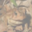

In [88]:
decode_img(img)

In [89]:
output=vae(adjust(torch.Tensor(img)[None, :]).to(device))[0]

In [91]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
